# Informe del Analisis sobre los datos tratados en el Taller 1
## Oscar Eduardo Mejia
### 20151670
***
### 1. Definición de Funciones

Nota: En cualquier momento que se haga referencia a :   
-Objetivo o serie objetivo es seria IDEAM  
-Referencia o serie referencia es la serie NREL

#### Explicacion resumida del codigo
 El codigo se divide en dos partes:  
 -Un analisis por cada ciudad, donde se muestran las series _NREAL_ e _IDEAM_.  
 -Una comparacion entre diferentes periodos de tiempo para diferentes años en una sola ciudad.  
 >Despues de encontrar el mejor y peor año para una ciudad en especial, se comparara esos años en otras ciudades, y ver si hubo problemas en la ciudad original o si fue un efecto climatico en diferentes lugares del pais
 

In [34]:
import os
import pandas as pd
from colorama import init,Fore, Back, Style
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [35]:
def serObjetivo(city):
    base_dir = os.path.join( '.','data')
    output_dir = os.path.join( '.','output')
    ciudad = city
    objetivo = 'IDEAM'
    serie_objetivo = os.path.join(base_dir,ciudad,objetivo+'.csv')
    serie_objetivo = pd.read_csv(serie_objetivo, sep = ';', encoding='latin-1')
    return serie_objetivo

In [36]:
def ghi_dia(serie_horaria):
    agnos = sorted(serie_horaria['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "DIAS", "GHImes"])
    for agno in agnos:
        for mes in range(1,13):
            nombre_energia = list(serie_horaria)[-1]
            dias = sorted(serie_horaria[(serie_horaria['AÑO'] == agno) & (serie_horaria['MES'] == mes)]["DIA"].unique())
            ghi_mes = serie_horaria.loc[((serie_horaria["AÑO"] == agno)
                            & (serie_horaria["MES"] == mes)),
                                        nombre_energia].sum()/1000
            ghi_dict = {"AÑO":agno, "MES":mes, "DIAS":dias[-1], "GHImes":ghi_mes}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    serie_ghi_mensual=ghi_df
    agnos = sorted(serie_ghi_mensual['AÑO'].unique())
    ghi_df = pd.DataFrame(columns=["AÑO", "MES", "GHIdiario"])
    for agno in agnos:
        for mes in range(1,13):
            dias = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno)    & (serie_ghi_mensual["MES"] == mes))
                                         ,"DIAS"].item()
            ghi_diario = serie_ghi_mensual.loc[((serie_ghi_mensual["AÑO"] == agno) & (serie_ghi_mensual["MES"] == mes)), "GHImes"].item()/dias
            ghi_dict = {"AÑO":agno, "MES":mes, "GHIdiario":ghi_diario}
            ghi_df = ghi_df.append(ghi_dict, ignore_index=True)
    return ghi_df
                     

In [37]:
def serReferencia(city):
    base_dir = os.path.join( '.','data')
    output_dir = os.path.join( '.','output')
    ciudad = city
    refer = 'NREL'
    serie_referencia = os.path.join(base_dir,ciudad,refer+'.csv')
    serie_referencia = pd.read_csv(serie_referencia,  sep = ';', encoding='latin-1')  
    return serie_referencia

In [38]:
def serCorregida(serieObjetivo,serieReferencia,serieLarga):
   
    nombre_referencia = list(serieReferencia)[-1]
    nombre_objetivo = list(serieObjetivo)[-1]
    mu_y=np.mean(serieObjetivo[ nombre_objetivo])
    mu_x=np.mean(serieReferencia[nombre_referencia])
    sigma_y=np.std(serieObjetivo[ nombre_objetivo])
    sigma_x=np.std(serieReferencia[nombre_referencia])
    nombre_energia = list(serieLarga)[-1]
    serieCorregida= pd.DataFrame(columns=["AÑO", "MES", "DIA","HORA",nombre_energia])
    serieCorregida["AÑO"]=serieLarga["AÑO"]
    serieCorregida["MES"]=serieLarga["MES"]
    serieCorregida["DIA"]=serieLarga["DIA"]
    serieCorregida["HORA"]=serieLarga["HORA"]
    serieCorregida[nombre_energia]=(mu_y-(sigma_y/sigma_x)*(mu_x))+((sigma_y/sigma_x)*serieLarga[nombre_energia])
    serieCorregida=serieCorregida.clip(lower=0)
     
    return serieCorregida

In [39]:
def promDiario(lista):
    nombre_objetivo = list(lista)[-1]
    a=lista[nombre_objetivo]
    return a

La siguiente funcion es aquella que a partir de una serie de 10 años, genera una seccion segun los parametros indicados

In [40]:
def mes(so,agno_inicial,agno_final,mes_Inicial,mes_Final):
    if agno_inicial<min(so['AÑO']):
        agno_inicial=min(so['AÑO'])
    if agno_final<min(so['AÑO']):
        agno_final=min(so['AÑO'])
                         
    if agno_final>max(so['AÑO']):
        agno_final=max(so['AÑO']) 
    if agno_inicial >max(so['AÑO']):
        agno_inicial =max(so['AÑO'])   
                       
    so = so.loc[((so['AÑO']>=agno_inicial) & (so['AÑO']<=agno_final))]
    a= pd.DataFrame(columns=["AÑO", "MES", "DIA","HORA","ENERGIA"])
    a["AÑO"]=so["AÑO"]
    a["MES"]=so["MES"]
    a["DIA"]=so["DIA"]
    a["HORA"]=so["HORA"]
    nombre_energia = list(so)[-1]
    if(agno_final==agno_inicial):
       a = so.loc [so['MES']>=mes_Inicial]
       a = so[so['MES']<=mes_Final]        
    if(agno_final>agno_inicial):
       a= so.loc[( ((so["AÑO"] == agno_inicial) & (so["MES"] >= mes_Inicial)) |  (so["AÑO"] > agno_inicial))]  
       a= a.loc[( ((so["AÑO"] == agno_final) & (so["MES"] <= mes_Final)) |  (so["AÑO"] < agno_final))]       
    return a

In [41]:
def RMSE(sC,sR):
    a=(sC-sR)**2
    suma=sum(a)
    res=(1/len(a)*suma)**(1/2)/(max(sC)-min(sC))*100
    return res

In [42]:
def MBE(sC,sR):
    a=(sC-sR)
    suma=sum(a)
    b=sum(sR)
    res=suma/b*100
    return res

In [43]:
def MCP(serieObjetivo,serieReferencia,serieLarga):
   
    nombre_referencia = list(serieReferencia)[-1]
    nombre_objetivo = list(serieObjetivo)[-1]
    mu_y=np.mean(serieObjetivo[ nombre_objetivo])
    mu_x=np.mean(serieReferencia[nombre_referencia])
    sigma_y=np.std(serieObjetivo[ nombre_objetivo])
    sigma_x=np.std(serieReferencia[nombre_referencia])
    nombre_energia = list(serieLarga)[-1]
    serieCorregida= pd.DataFrame(columns=["AÑO", "MES", "DIA","HORA",nombre_energia])
    serieCorregida["AÑO"]=serieLarga["AÑO"]
    serieCorregida["MES"]=serieLarga["MES"]
    serieCorregida["DIA"]=serieLarga["DIA"]
    serieCorregida["HORA"]=serieLarga["HORA"]
    serieCorregida[nombre_energia]=(mu_y-(sigma_y/sigma_x)*(mu_x))+((sigma_y/sigma_x)*serieLarga[nombre_energia])
    serieCorregida.loc[(serieCorregida[nombre_energia]<0)]=0
    serieCorregida["AÑO"]=serieLarga["AÑO"]
    serieCorregida["MES"]=serieLarga["MES"]
    serieCorregida["DIA"]=serieLarga["DIA"]
    serieCorregida["HORA"]=serieLarga["HORA"]    
    return serieCorregida

In [44]:
def grafica(serieObjetivo,serieReferencia,serieCorregida,city,correg):
    plt.figure() 
    pylab.xlabel("Datos")
    pylab.ylabel("Energía/Energía Base IDEAM")
    plt.title(city)
    numdatos_1 = range(len(serieObjetivo))
    numdatos_2= range(len(serieReferencia))
    numdatos_3 = range(len(serieCorregida))
    serieObjetivo=sorted(serieObjetivo)
    serieReferencia=sorted(serieReferencia)
    serieCorregida=sorted(serieCorregida)
    plt.hold(True)
    plt.grid(True)
    pylab.plot(numdatos_1,serieObjetivo/serieObjetivo[0],'-k', label='Serie Objetivo')
    pylab.plot(numdatos_2,serieReferencia/serieObjetivo[0],'-b', label='Serie Referencia')
    if (correg==False):
        pylab.plot(numdatos_3,serieCorregida/serieObjetivo[0],'-g', label='Serie Corregida')
    pylab.legend(loc='best')

In [45]:
def Error(meses,lista,nombre):
    plt.figure()
    plt.bar(meses,lista)
    plt.xlabel("Meses")
    plt.ylabel(nombre)
    plt.title(nombre)

In [46]:
def fechas(so,agno_inicial,agno_final):
    if agno_inicial<min(so['AÑO']):
        agno_inicial=min(so['AÑO'])
    if agno_final<min(so['AÑO']):
        agno_final=min(so['AÑO'])
                         
    if agno_final>max(so['AÑO']):
        agno_final=max(so['AÑO']) 
    if agno_inicial >max(so['AÑO']):
        agno_inicial =max(so['AÑO']) 
    return [agno_inicial,agno_final]

In [47]:
def recortar(obj,cir):
    agno_min=min(obj["AÑO"].unique())
    if(agno_min>min(cir["AÑO"].unique())):
        agno_min=min(obj["AÑO"].unique())
    agno_max=max(obj["AÑO"].unique())
    if(agno_max<max(cir["AÑO"].unique())):
        agno_max=max(obj["AÑO"].unique())
    cir=cir.loc[( ((cir["AÑO"] >= agno_min) & (cir["AÑO"] <= agno_max)))]  
    return cir

In [48]:
def PorCiudad(city,agno_inicial,agno_final,mes_Inicial,mes_Final,graf):
    objetivo=serObjetivo(city)
    refer=serReferencia(city)
    
    corta=mes(objetivo,agno_inicial,agno_final,mes_Inicial,mes_Final)   
    cortaRefer=mes(refer,agno_inicial,agno_final,mes_Inicial,mes_Final) 
    corregida=MCP(corta,cortaRefer,refer)
    cortaCorreg=recortar(objetivo,corregida)
    #print(cortaRefer,cortaCorreg)
    agno_inicial=fechas(objetivo,agno_inicial,agno_final)[0]
    agno_final=fechas(objetivo,agno_inicial,agno_final)[-1]
    
    dia_objetivo=ghi_dia(objetivo)
    dia_refer=ghi_dia(refer)
    ENFICC_OBJETIVO=percentil(dia_objetivo)  
    ENFICC_REFERENCIA=percentil(dia_refer)  
    o=promDiario(dia_objetivo)
    r=promDiario(dia_refer)
    dia_correg=ghi_dia(cortaCorreg)
    c=promDiario(dia_correg)
    dia_correg=ghi_dia(corregida)
    ENFICC_CORREGIDA=percentil(dia_correg)    
    k=promDiario(dia_correg)
    if(graf):  
       print("La ENFICC de la serie IDEAM en ", city," es: ",ENFICC_OBJETIVO)    
       print("La ENFICC de la serie NREL en ", city," es: ",ENFICC_REFERENCIA) 
       grafica(o,r,k,city,graf)
    else:
       grafica(o,r,k,city,graf)
       return [o,r,c,agno_inicial,agno_final,ENFICC_OBJETIVO,ENFICC_REFERENCIA, ENFICC_CORREGIDA]

In [49]:
def KSI(d1,d2):
    return stats.ks_2samp(d1,d2)  
    

In [50]:
def percentil(lista):
    percentil = 0.01
    enficc = lista.quantile(q=percentil, numeric_only=True)["GHIdiario"]
    return enficc

En la siguiente función, en el vector meses se puede indicar el **numero de meses** y el **mes inicial**  sobre los cuales se hara los respectivos calculos de correcion e indicadores estadisticos.

In [51]:
def Estadisticas(city,agno_inicial):
    meses =[1,3,6,12,24]
    estad_correc=pd.DataFrame(index=meses,columns=["Fecha Final","RMSE [%]","MBE [%]","KSI[p-Value]"])
    agno_final = agno_inicial
    mes_Inicial = 1    
    for mes in meses:
            mes_Final = mes
            agno_final = agno_inicial+int((mes-1)/12)
            mes_Final=mes%12
            if(mes_Final==0):
               mes_Final=12
            a=PorCiudad(city,agno_inicial,agno_final,mes_Inicial,mes_Final,False)
            o=a[0]
            r=a[1]
            c=a[2]
            if(agno_final>a[4]):
                agno_final=a[4]
            RMSE_REFERENCIA=RMSE(o,r)
            MBE_REFERENCIA=MBE(o,r)   
            estad_correc.loc[mes,"RMSE [%]"]=RMSE(o,c)
            estad_correc.loc[mes,"MBE [%]"]=MBE(o,c)
            estad_correc.loc[mes,"KSI[p-Value]"]=KSI(o,c)
            estad_correc.loc[mes,"Fecha Final"]= a[3] , mes_Inicial, agno_final , mes_Final 
            p=a[5]
            q=a[6]
            t=a[7]
    print("EL RMSE entre IDEAM y NREL es:" , RMSE_REFERENCIA)
    print("EL MBE entre IDEAM y NREL es:" ,MBE_REFERENCIA)
    print("La ENFICC de la serie IDEAM ",p)    
    print("La ENFICC de la serie NREL ",q) 
    print("La ENFICC de la serie CORREGIDA ",t ) 
    Error(meses,estad_correc["RMSE [%]"],"RMSE [%]")
    Error(meses,estad_correc["MBE [%]"],"MBE [%]")
    return(estad_correc)
   
    
   

### 2. Graficas entre serie Medida y Satelital de las Diferentes Ciudades
***
Las ciudades a analizar son:  
-Barranquilla   
-Cali   
-Carmen de bolivar    
-Medellin   
-SantaMarta   
-Sucre   
-Uribia   
-Valledupar
***
_NOTA:_ Se envita el analisis de Sucre debido a un error presenta en el archivo de datos. Para ver esto, revisar anexos del documento.

La ENFICC de la serie IDEAM en  Barranquilla  es:  4.16059025817
La ENFICC de la serie NREL en  Barranquilla  es:  4.60594683333
La ENFICC de la serie IDEAM en  Cali  es:  3.33077931605
La ENFICC de la serie NREL en  Cali  es:  4.36085916667
La ENFICC de la serie IDEAM en  Carmendebolivar  es:  4.06482175725
La ENFICC de la serie NREL en  Carmendebolivar  es:  4.2736665
La ENFICC de la serie IDEAM en  Medellin  es:  3.53519358791
La ENFICC de la serie NREL en  Medellin  es:  4.32600282796
La ENFICC de la serie IDEAM en  SantaMarta  es:  4.04071664383
La ENFICC de la serie NREL en  SantaMarta  es:  4.536077
La ENFICC de la serie IDEAM en  Uribia  es:  4.2818970848
La ENFICC de la serie NREL en  Uribia  es:  4.62250183333
La ENFICC de la serie IDEAM en  Valledupar  es:  4.56900737661
La ENFICC de la serie NREL en  Valledupar  es:  5.06265316667


C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


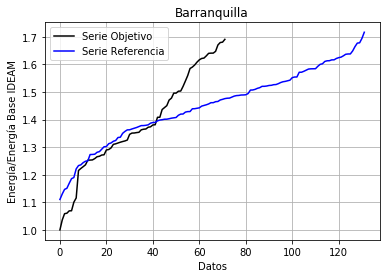

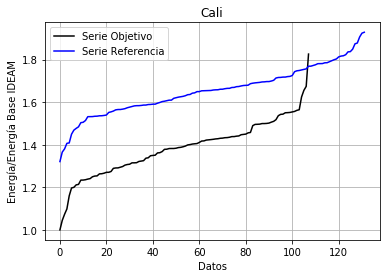

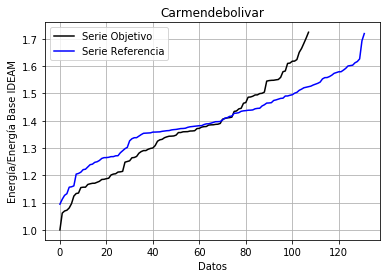

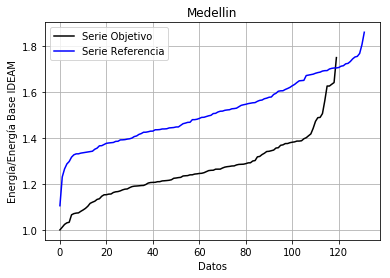

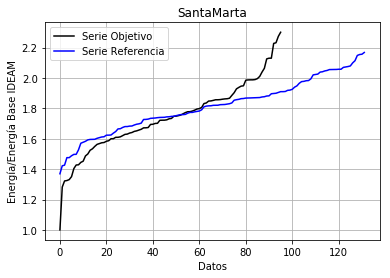

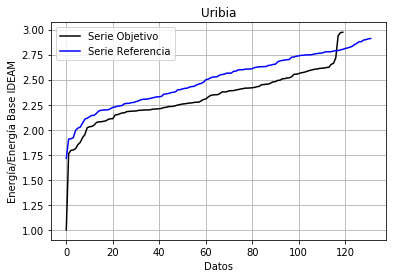

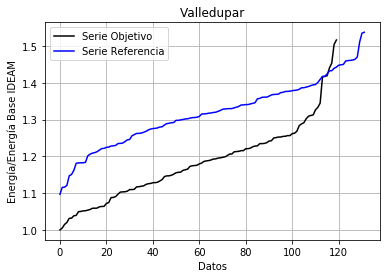

In [52]:
ciudades=["Barranquilla","Cali","Carmendebolivar","Medellin","SantaMarta","Uribia","Valledupar"]
for city in ciudades:
    PorCiudad(city,2005,2015,1,12,True)

### 3. Se tomara una ciudad de referencia y se vera los errores asociados a la corrección de la serie medida en tierra -comparandola con la serie satelital-  para estimar el tiempo necesario para una medida correcta. Adicionalmente se comararan diferentes años para ver cual habria sido el mejor año para tomar medidas en tierra.
***
Ciudad de estudio: **Medellin**
***
*Nota: Las graficas que se muestran a continuacion corresponden a: 1,3,6,12,24 meses desde el año inicial que se meustra en el comando incial, adicionalmente los indicadores RMSE Y MBE SIEMPRE se daran en porcentaje.*

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.66434312995


Fecha Final RMSE [%]    MBE [%]  \
1    (2007, 1, 2007, 1)  16.2938    5.34469   
3    (2007, 1, 2007, 3)  16.1257    5.12223   
6    (2007, 1, 2007, 6)  14.2147    1.42713   
12  (2007, 1, 2007, 12)  14.0782  0.0452672   
24  (2007, 1, 2008, 12)  14.4691   -1.75683   

                          KSI[p-Value]  
1            (0.25, 0.000851098187747)  
3   (0.241666666667, 0.00141569840521)  
6     (0.116666666667, 0.366570200771)  
12   (0.0833333333333, 0.781593040441)  
24              (0.15, 0.122279187014)

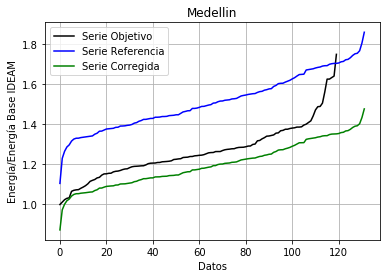

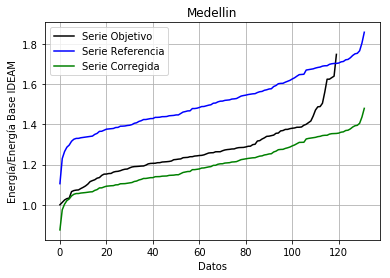

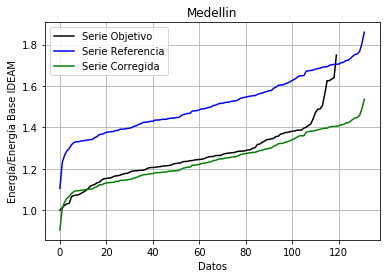

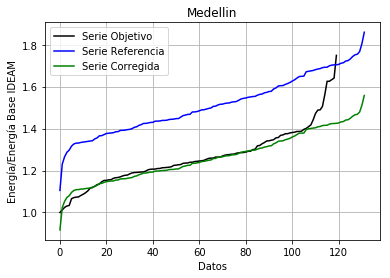

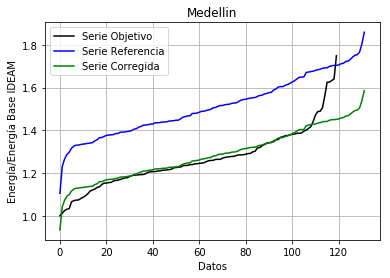

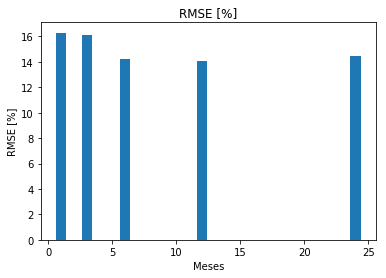

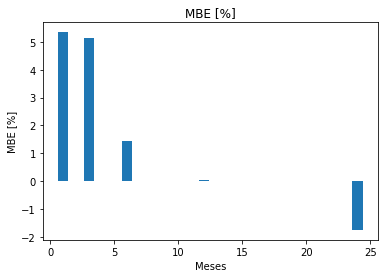

In [53]:
Estadisticas('Medellin',2007)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.66380660501


Fecha Final RMSE [%]  MBE [%]                        KSI[p-Value]
1    (2008, 1, 2008, 1)  14.1697 -1.13007    (0.116666666667, 0.366570200771)
3    (2008, 1, 2008, 3)  15.5071 -3.57488  (0.208333333333, 0.00912058680232)
6    (2008, 1, 2008, 6)  16.0583 -4.19532    (0.233333333333, 0.002314571475)
12  (2008, 1, 2008, 12)  15.5638 -3.59535  (0.208333333333, 0.00912058680232)
24  (2008, 1, 2009, 12)  14.3951 -1.63838    (0.141666666667, 0.165311302375)

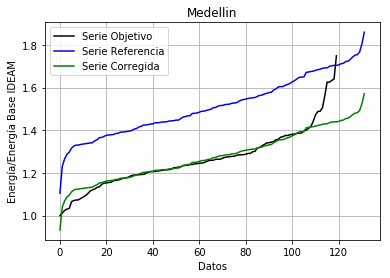

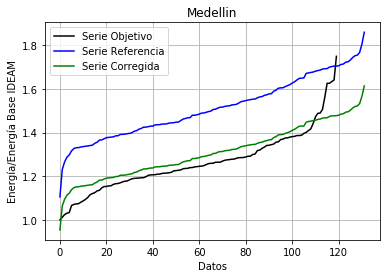

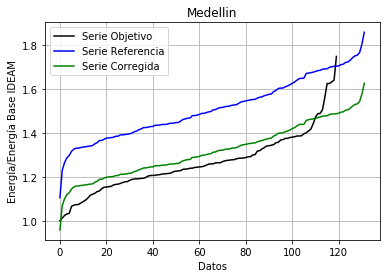

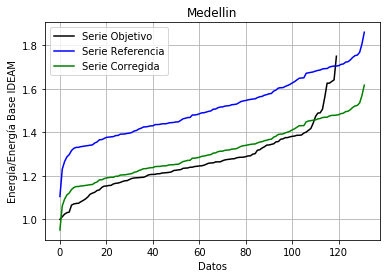

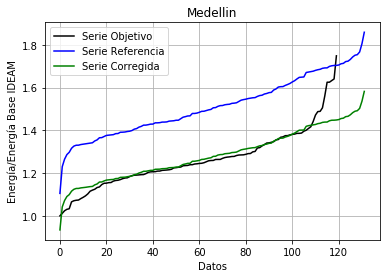

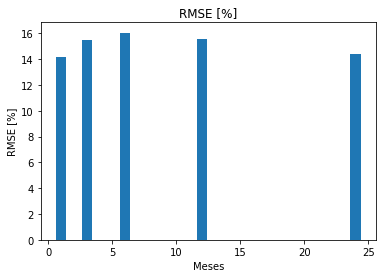

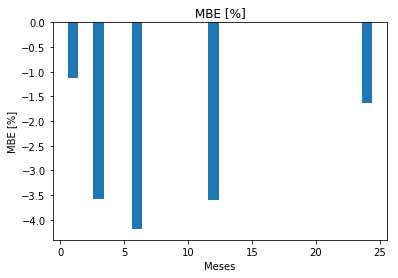

In [54]:
Estadisticas('Medellin',2008)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.57557301648


Fecha Final RMSE [%]   MBE [%]  \
1    (2009, 1, 2009, 1)  14.0417  0.142216   
3    (2009, 1, 2009, 3)  16.7036  -4.88825   
6    (2009, 1, 2009, 6)  15.6357  -3.75534   
12  (2009, 1, 2009, 12)  14.0241   0.36711   
24  (2009, 1, 2010, 12)  14.0691  0.925475   

                           KSI[p-Value]  
1     (0.0833333333333, 0.781593040441)  
3   (0.258333333333, 0.000502918215243)  
6    (0.216666666667, 0.00587484788094)  
12              (0.075, 0.875954629946)  
24    (0.0833333333333, 0.781593040441)

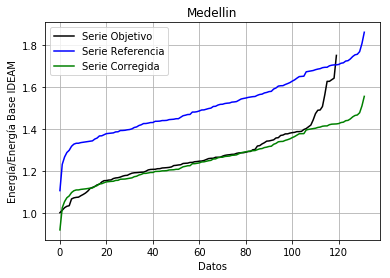

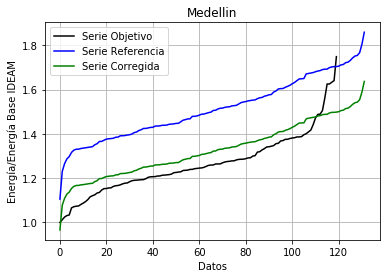

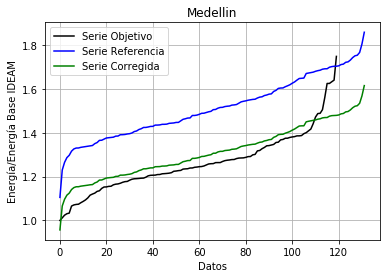

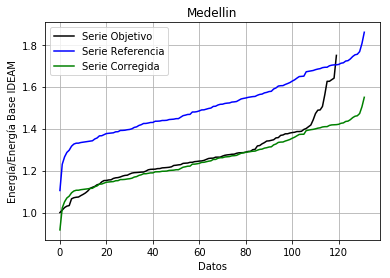

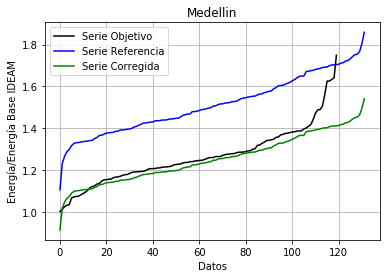

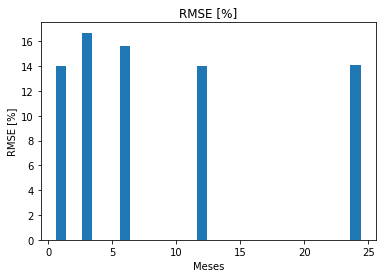

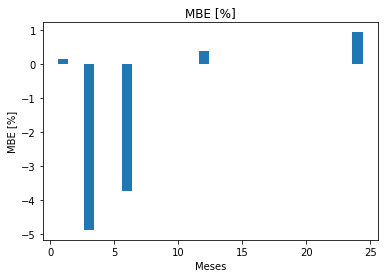

In [55]:
Estadisticas('Medellin',2009)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.54738564746


Fecha Final RMSE [%]  MBE [%]                        KSI[p-Value]
1    (2010, 1, 2010, 1)  27.1736  16.1598  (0.566666666667, 9.5790518299e-18)
3    (2010, 1, 2010, 3)  20.5994  9.98347            (0.4, 4.68965777206e-09)
6    (2010, 1, 2010, 6)  15.1701  3.73209              (0.2, 0.0139173848978)
12  (2010, 1, 2010, 12)   14.172  1.47549    (0.116666666667, 0.366570200771)
24  (2010, 1, 2011, 12)  14.2423  1.64871    (0.133333333333, 0.219571571973)

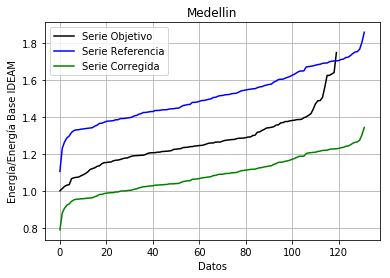

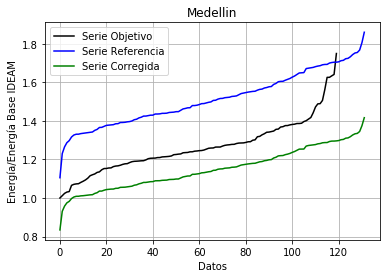

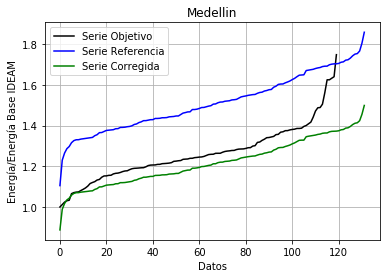

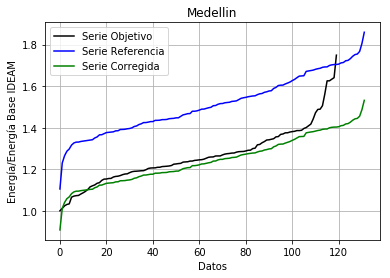

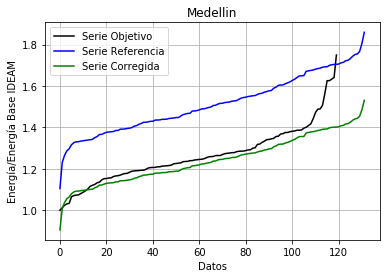

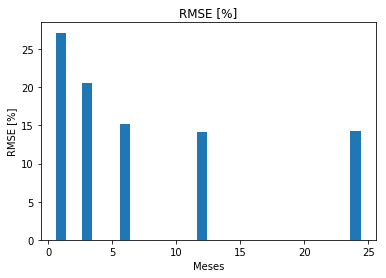

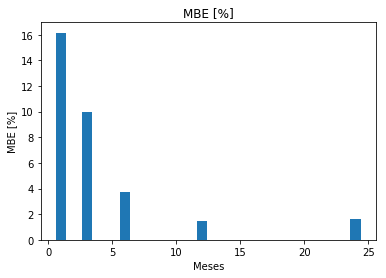

In [56]:
Estadisticas('Medellin',2010)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.5148391471


Fecha Final RMSE [%]  MBE [%]                         KSI[p-Value]
1    (2011, 1, 2011, 1)  18.3044  7.68198  (0.333333333333, 2.03259864377e-06)
3    (2011, 1, 2011, 3)  18.4131  7.84922  (0.333333333333, 2.03259864377e-06)
6    (2011, 1, 2011, 6)  15.2853  3.96762               (0.2, 0.0139173848978)
12  (2011, 1, 2011, 12)  14.3181  1.82519     (0.141666666667, 0.165311302375)
24  (2011, 1, 2012, 12)  14.5457  2.42207               (0.15, 0.122279187014)

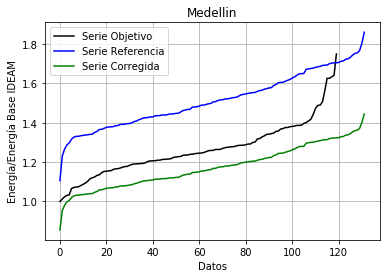

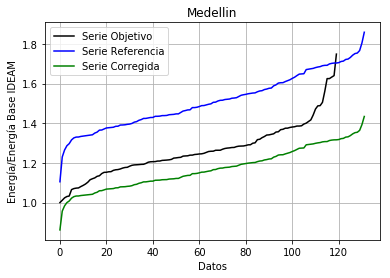

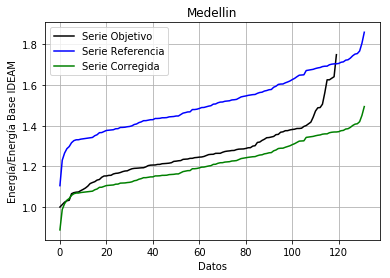

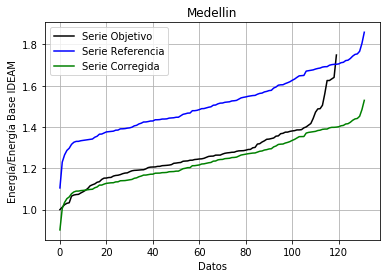

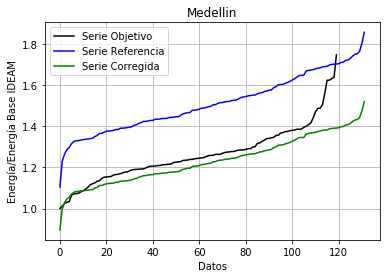

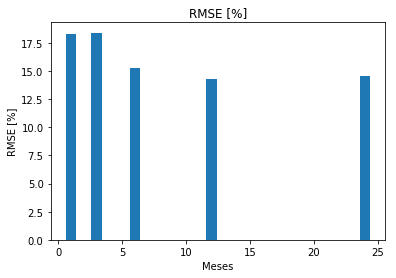

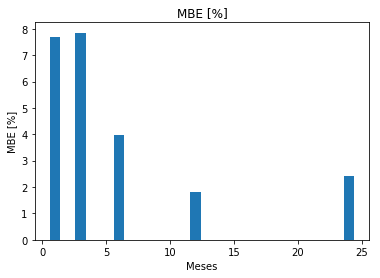

In [57]:
Estadisticas('Medellin',2011)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.53238245758


Fecha Final RMSE [%]  MBE [%]                         KSI[p-Value]
1    (2012, 1, 2012, 1)  14.7224 -2.81591    (0.183333333333, 0.0307717686522)
3    (2012, 1, 2012, 3)  18.5348  7.96715  (0.341666666667, 1.01078107456e-06)
6    (2012, 1, 2012, 6)  18.5948  7.96335  (0.341666666667, 1.01078107456e-06)
12  (2012, 1, 2012, 12)  14.8233  3.00673             (0.175, 0.0445872330161)
24  (2012, 1, 2013, 12)  14.3486  1.79246     (0.141666666667, 0.165311302375)

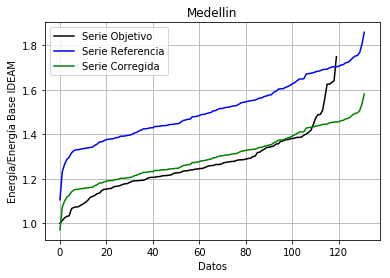

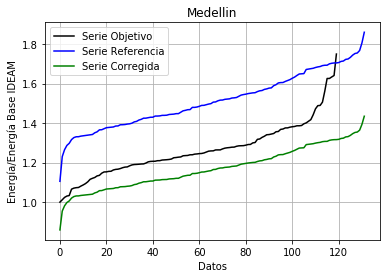

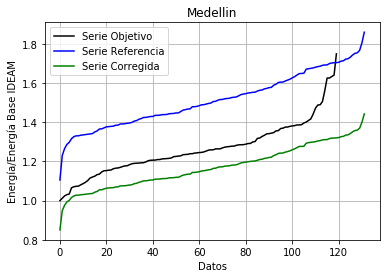

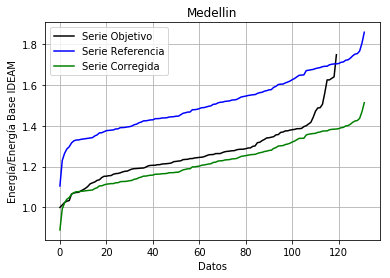

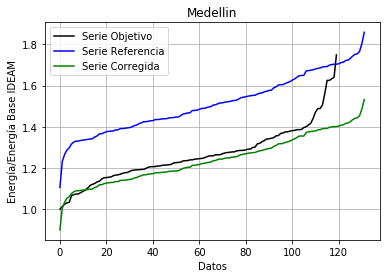

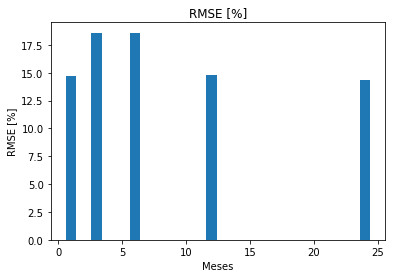

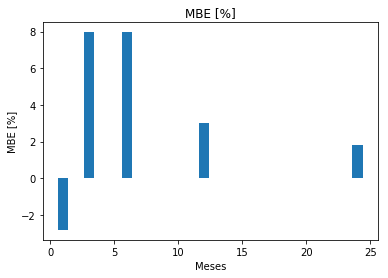

In [58]:
Estadisticas('Medellin',2012)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.65277552772


Fecha Final RMSE [%]   MBE [%]                       KSI[p-Value]
1    (2013, 1, 2013, 1)  14.1845   1.41809   (0.116666666667, 0.366570200771)
3    (2013, 1, 2013, 3)  14.1958 -0.715526              (0.1, 0.563756806825)
6    (2013, 1, 2013, 6)  14.1831  0.993517  (0.0916666666667, 0.673781227063)
12  (2013, 1, 2013, 12)  14.1328  0.594709  (0.0833333333333, 0.781593040441)
24  (2013, 1, 2014, 12)  14.4229  -1.55928   (0.133333333333, 0.219571571973)

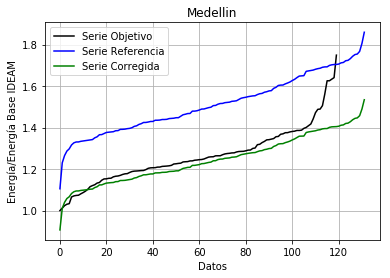

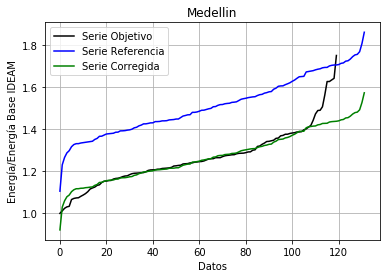

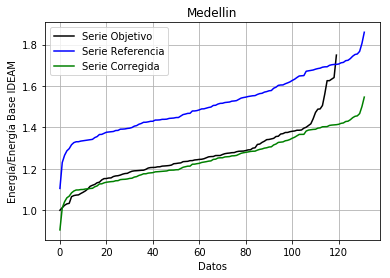

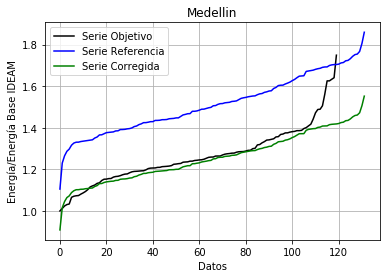

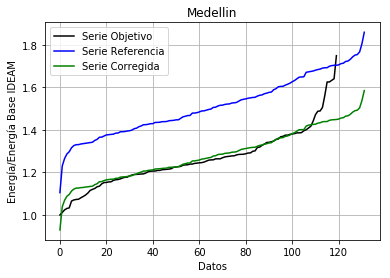

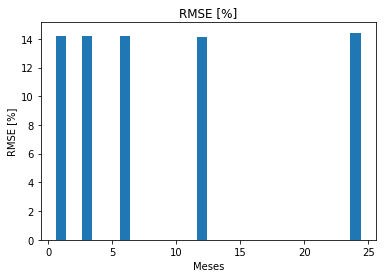

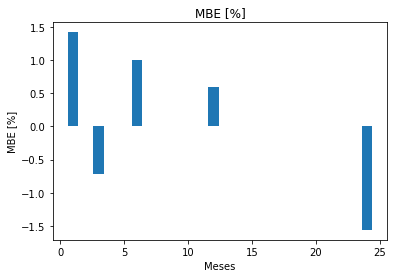

In [59]:
Estadisticas('Medellin',2013)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  3.96557747737


Fecha Final RMSE [%]    MBE [%]  \
1    (2014, 1, 2014, 1)  18.1239   -6.27936   
3    (2014, 1, 2014, 3)   14.176  -0.982096   
6    (2014, 1, 2014, 6)  14.0719  0.0654854   
12  (2014, 1, 2014, 12)  15.5378   -3.54575   
24  (2014, 1, 2015, 12)  22.5958   -9.27948   

                           KSI[p-Value]  
1            (0.325, 4.01749123745e-06)  
3      (0.108333333333, 0.459738479705)  
6     (0.0833333333333, 0.781593040441)  
12   (0.208333333333, 0.00912058680232)  
24  (0.458333333333, 9.34448294787e-12)

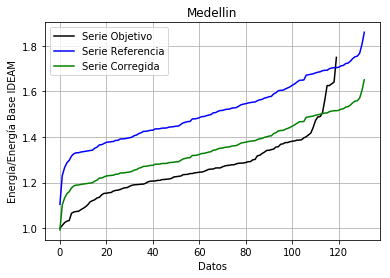

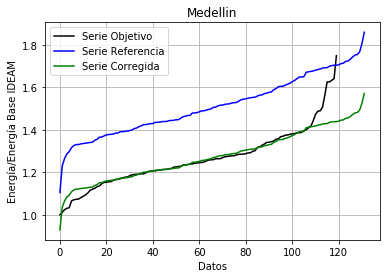

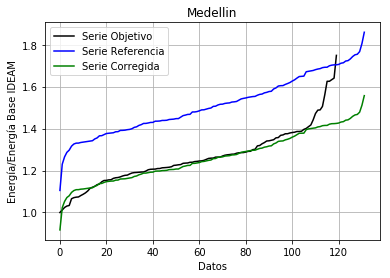

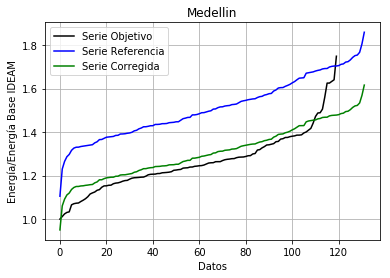

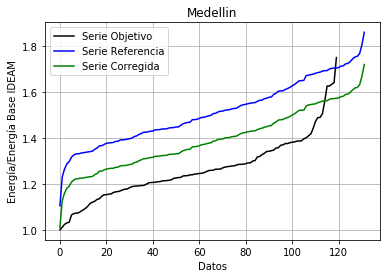

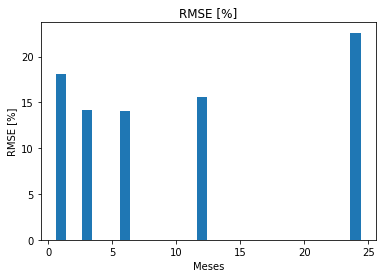

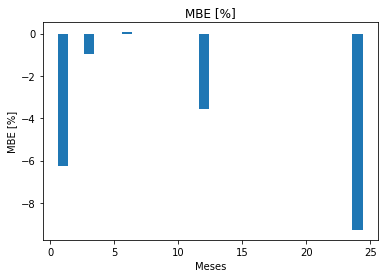

In [60]:
Estadisticas('Medellin',2014)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 35.4646727608
EL MBE entre IDEAM y NREL es: -14.629955640594062
La ENFICC de la serie IDEAM  3.53519358791
La ENFICC de la serie NREL  4.32600282796
La ENFICC de la serie CORREGIDA  4.19350498473


Fecha Final RMSE [%]  MBE [%]                         KSI[p-Value]
1    (2015, 1, 2015, 1)  27.5701 -12.1041   (0.566666666667, 9.5790518299e-18)
3    (2015, 1, 2015, 3)  27.8744 -12.2806           (0.575, 2.93882516949e-18)
6    (2015, 1, 2015, 6)   28.472 -12.5855  (0.583333333333, 8.86204100714e-19)
12  (2015, 1, 2015, 12)  31.6748 -14.1988  (0.633333333333, 4.63850576716e-22)
24  (2015, 1, 2015, 12)  31.6748 -14.1988  (0.633333333333, 4.63850576716e-22)

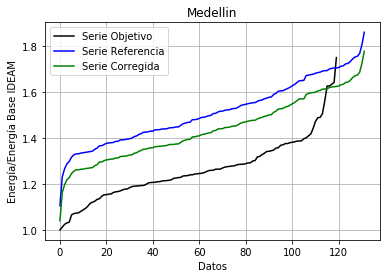

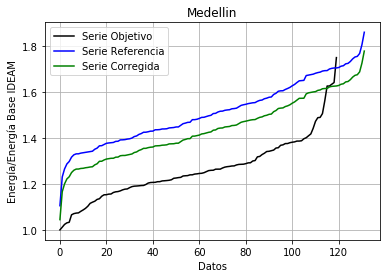

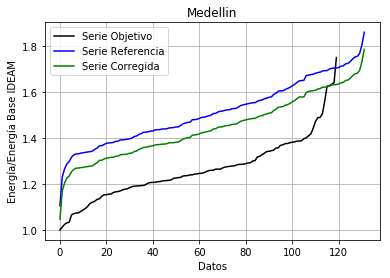

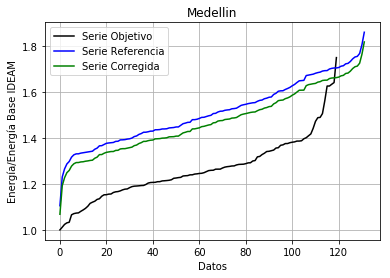

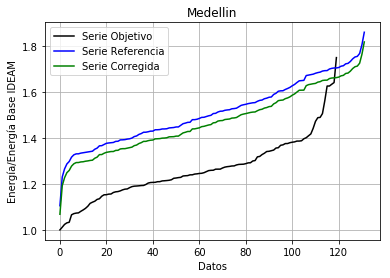

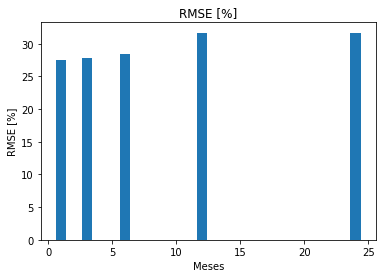

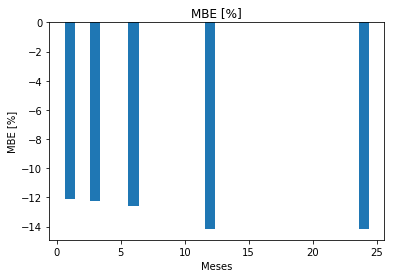

In [61]:
Estadisticas('Medellin',2015)

De todas las graficas presentadas anteriormente nos damos cuenta que con un año de medidas en terreno, y la correcta relación de datos 
se logra una gran estimacion del comportamiento a lo largo de 10 años.  
Para **Medellin** el mejor año para tomar datos fue el *2008*, mientras que el peor año fue el *2010*. Estos resultados se deben a que Colombia sufrio un cambio muy rapido entre los fenomenos del Niño y la Niña entre los años 2009, 2010  y 2011 ya que hubo periodos anormales de de lluvia y sol. Todo esto afecto, en el sentido de que no fue un periodo de condiciones normales. Por eso, las mediciones y correcciones en estos dos años no son adecuadas.



### 4. Visualizar los años 2008 - 2010 entre otras dos ciudades para comparar  
***

Ciudades a revisar: Cali y Valledupar

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 31.8355693269
EL MBE entre IDEAM y NREL es: -12.608555032995303
La ENFICC de la serie IDEAM  3.33077931605
La ENFICC de la serie NREL  4.36085916667
La ENFICC de la serie CORREGIDA  3.73530390815


Fecha Final RMSE [%]   MBE [%]                       KSI[p-Value]
1    (2008, 1, 2008, 1)  10.1239 -0.762575    (0.12962962963, 0.303467201496)
3    (2008, 1, 2008, 3)  10.1194 -0.745777    (0.12962962963, 0.303467201496)
6    (2008, 1, 2008, 6)  10.2265  -1.12214   (0.138888888889, 0.230166953954)
12  (2008, 1, 2008, 12)   11.048   -2.6603  (0.203703703704, 0.0191688358984)
24  (2008, 1, 2009, 12)  10.8725  -2.41903  (0.175925925926, 0.0624499367622)

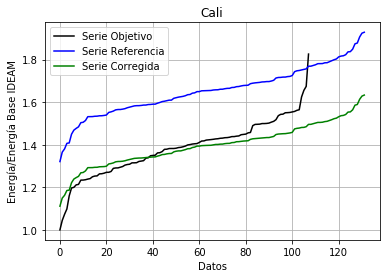

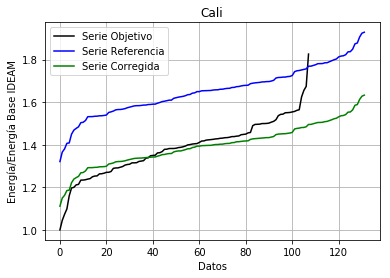

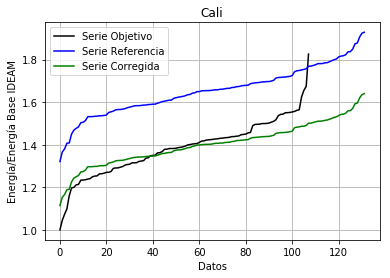

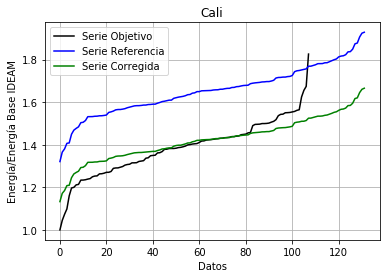

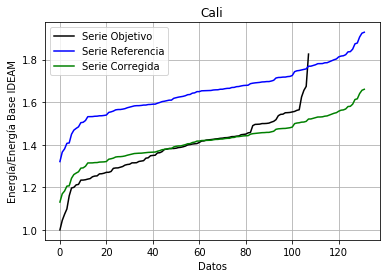

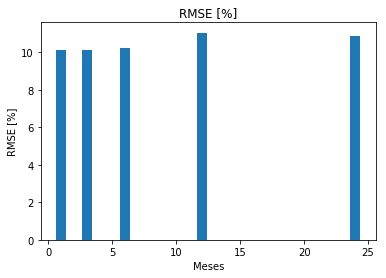

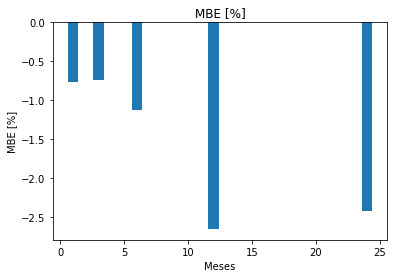

In [62]:
Estadisticas('Cali',2008)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 31.8355693269
EL MBE entre IDEAM y NREL es: -12.608555032995303
La ENFICC de la serie IDEAM  3.33077931605
La ENFICC de la serie NREL  4.36085916667
La ENFICC de la serie CORREGIDA  3.6922935542


Fecha Final RMSE [%]  MBE [%]                         KSI[p-Value]
1    (2009, 1, 2009, 1)  15.6702 -6.67364  (0.351851851852, 1.90147630361e-06)
3    (2009, 1, 2009, 3)  10.3319 -1.44348     (0.148148148148, 0.171063071645)
6    (2009, 1, 2009, 6)  10.8736 -2.41992    (0.175925925926, 0.0624499367622)
12  (2009, 1, 2009, 12)  10.7325 -2.21019    (0.175925925926, 0.0624499367622)
24  (2009, 1, 2010, 12)  10.2768 -1.28743     (0.148148148148, 0.171063071645)

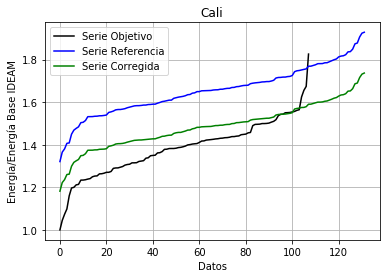

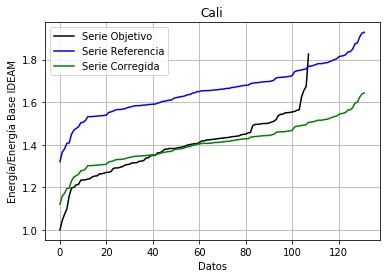

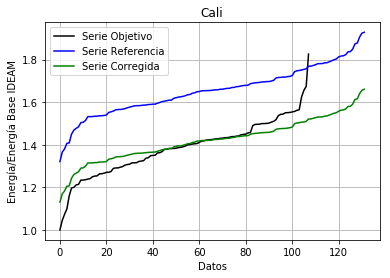

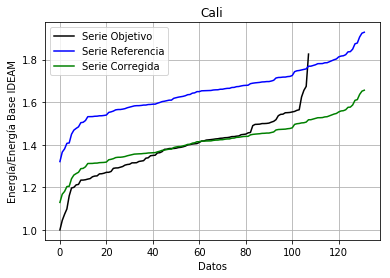

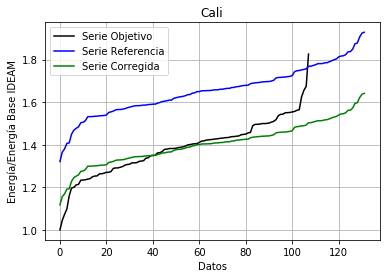

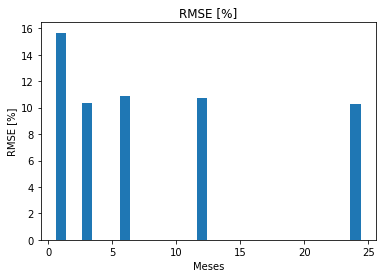

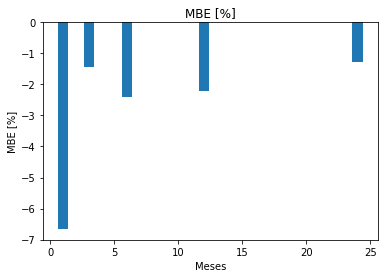

In [63]:
Estadisticas('Cali',2009)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 31.8355693269
EL MBE entre IDEAM y NREL es: -12.608555032995303
La ENFICC de la serie IDEAM  3.33077931605
La ENFICC de la serie NREL  4.36085916667
La ENFICC de la serie CORREGIDA  3.639737296


Fecha Final RMSE [%]    MBE [%]                       KSI[p-Value]
1    (2010, 1, 2010, 1)  10.4189    1.70588  (0.175925925926, 0.0624499367622)
3    (2010, 1, 2010, 3)  10.0283  0.0362264   (0.101851851852, 0.606668396628)
6    (2010, 1, 2010, 6)  10.0532  -0.345336   (0.111111111111, 0.493853645281)
12  (2010, 1, 2010, 12)  10.0518  -0.268932   (0.101851851852, 0.606668396628)
24  (2010, 1, 2011, 12)  10.0409   0.100162   (0.101851851852, 0.606668396628)

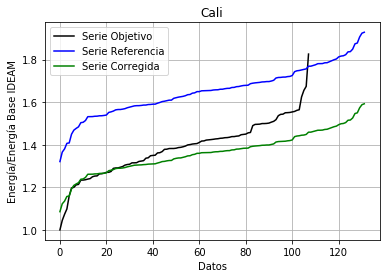

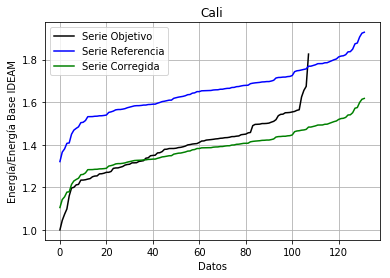

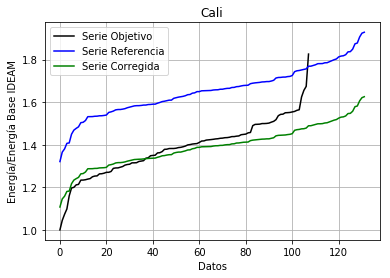

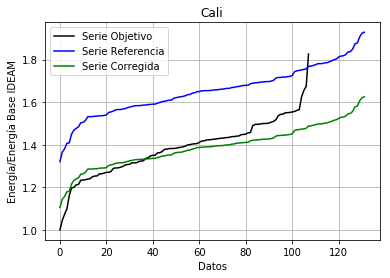

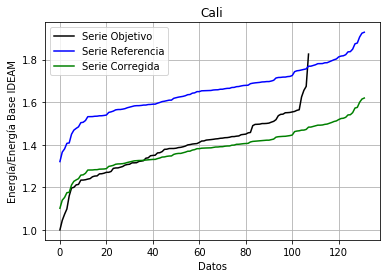

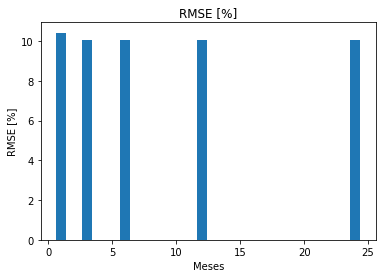

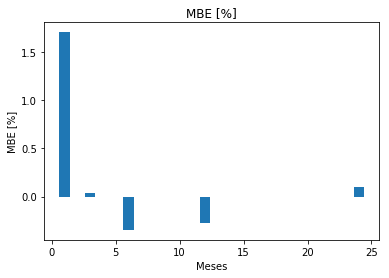

In [64]:
Estadisticas('Cali',2010)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 31.8355693269
EL MBE entre IDEAM y NREL es: -12.608555032995303
La ENFICC de la serie IDEAM  3.33077931605
La ENFICC de la serie NREL  4.36085916667
La ENFICC de la serie CORREGIDA  3.5862004234


Fecha Final RMSE [%]   MBE [%]                       KSI[p-Value]
1    (2011, 1, 2011, 1)  10.0383  0.257665   (0.111111111111, 0.493853645281)
3    (2011, 1, 2011, 3)    10.38   1.59756  (0.166666666667, 0.0890858229024)
6    (2011, 1, 2011, 6)  10.2828   1.33809  (0.166666666667, 0.0890858229024)
12  (2011, 1, 2011, 12)   10.066  0.451386    (0.12037037037, 0.391648792229)
24  (2011, 1, 2012, 12)   10.381   1.60767  (0.166666666667, 0.0890858229024)

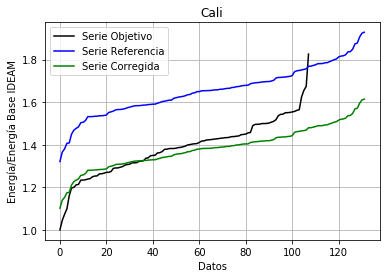

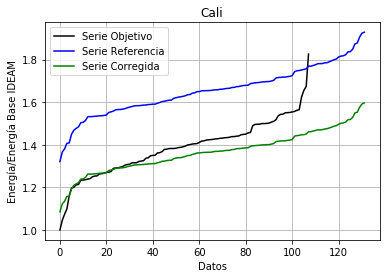

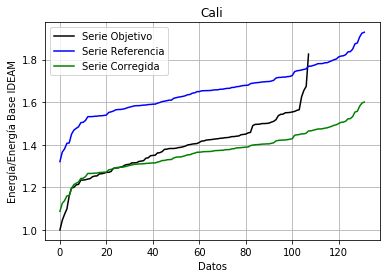

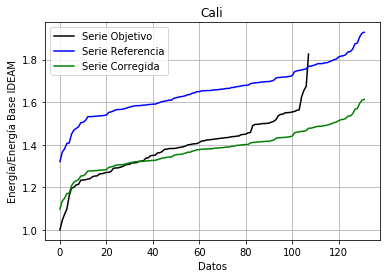

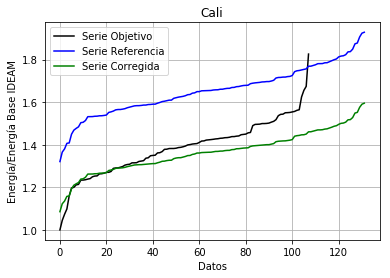

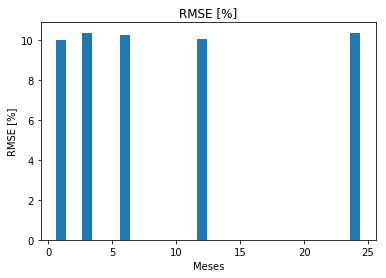

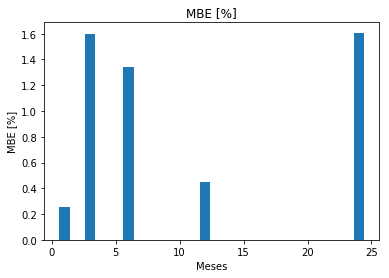

In [65]:
Estadisticas('Cali',2011)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 30.6477341498
EL MBE entre IDEAM y NREL es: -9.117161998892827
La ENFICC de la serie IDEAM  4.56900737661
La ENFICC de la serie NREL  5.06265316667
La ENFICC de la serie CORREGIDA  4.64242301116


Fecha Final RMSE [%]   MBE [%]                        KSI[p-Value]
1    (2008, 1, 2008, 1)  17.1238  -2.75465  (0.216666666667, 0.00587484788094)
3    (2008, 1, 2008, 3)  15.8453  0.442834   (0.0916666666667, 0.673781227063)
6    (2008, 1, 2008, 6)  16.2216   -1.4742   (0.158333333333, 0.0888845174088)
12  (2008, 1, 2008, 12)  17.0472  -2.63556  (0.208333333333, 0.00912058680232)
24  (2008, 1, 2009, 12)  16.8757  -2.42568              (0.2, 0.0139173848978)

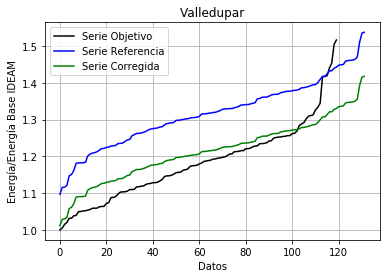

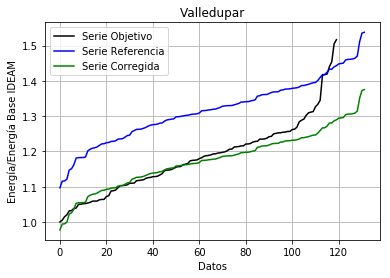

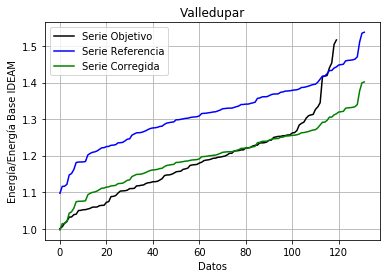

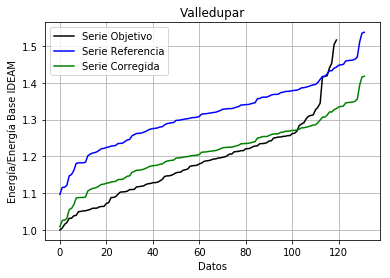

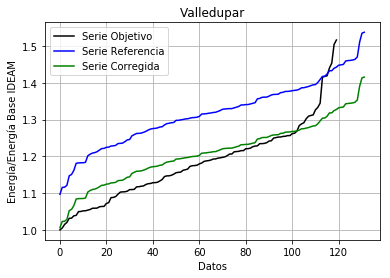

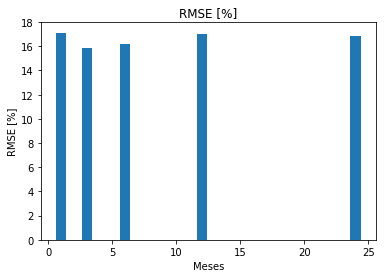

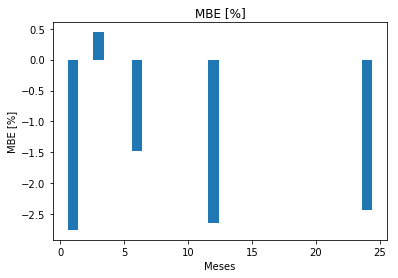

In [66]:
Estadisticas('Valledupar',2008)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 30.6477341498
EL MBE entre IDEAM y NREL es: -9.117161998892827
La ENFICC de la serie IDEAM  4.56900737661
La ENFICC de la serie NREL  5.06265316667
La ENFICC de la serie CORREGIDA  4.55189968787


Fecha Final RMSE [%]   MBE [%]  \
1    (2009, 1, 2009, 1)  18.5582  -4.01296   
3    (2009, 1, 2009, 3)  16.5895  -2.05056   
6    (2009, 1, 2009, 6)  16.8917  -2.44125   
12  (2009, 1, 2009, 12)  16.7157  -2.21319   
24  (2009, 1, 2010, 12)   15.908 -0.570233   

                           KSI[p-Value]  
1   (0.266666666667, 0.000292094811456)  
3     (0.183333333333, 0.0307717686522)  
6                (0.2, 0.0139173848978)  
12    (0.191666666667, 0.0208737765571)  
24     (0.133333333333, 0.219571571973)

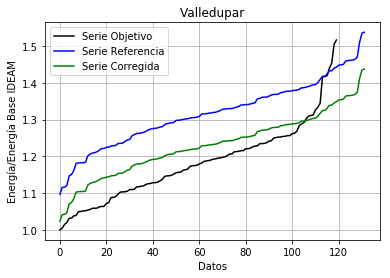

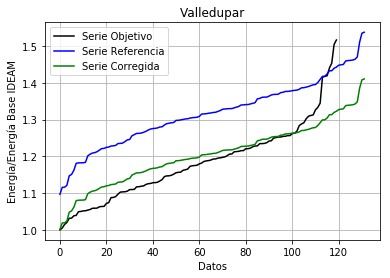

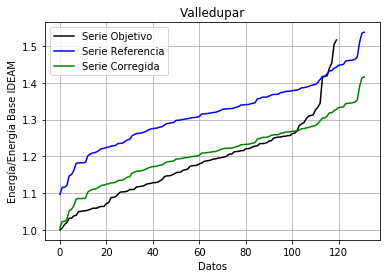

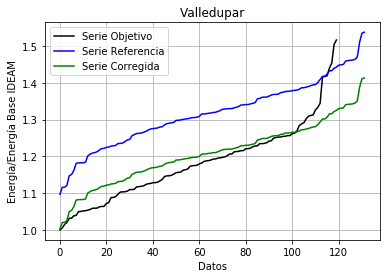

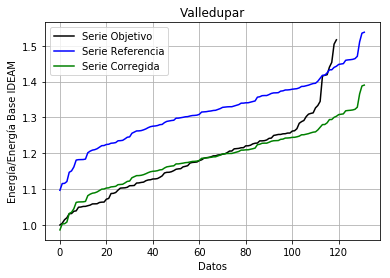

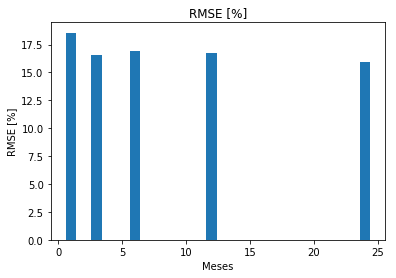

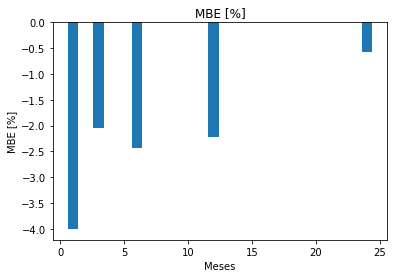

In [67]:
Estadisticas('Valledupar',2009)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 30.6477341498
EL MBE entre IDEAM y NREL es: -9.117161998892827
La ENFICC de la serie IDEAM  4.56900737661
La ENFICC de la serie NREL  5.06265316667
La ENFICC de la serie CORREGIDA  4.4798187135


Fecha Final RMSE [%]   MBE [%]                       KSI[p-Value]
1    (2010, 1, 2010, 1)  15.8151 -0.228225            (0.125, 0.286403832382)
3    (2010, 1, 2010, 3)  16.4766   2.10702   (0.141666666667, 0.165311302375)
6    (2010, 1, 2010, 6)   16.216   1.60999            (0.125, 0.286403832382)
12  (2010, 1, 2010, 12)  16.0712   1.26898   (0.108333333333, 0.459738479705)
24  (2010, 1, 2011, 12)   15.981  0.985597  (0.0916666666667, 0.673781227063)

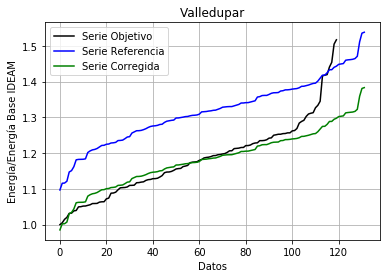

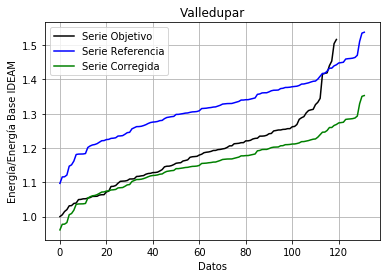

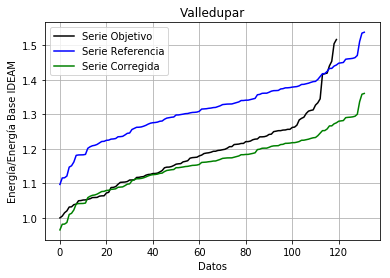

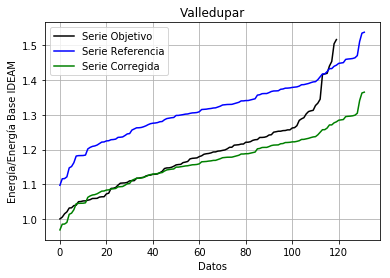

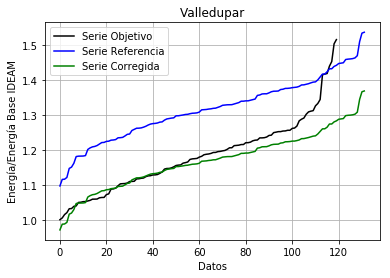

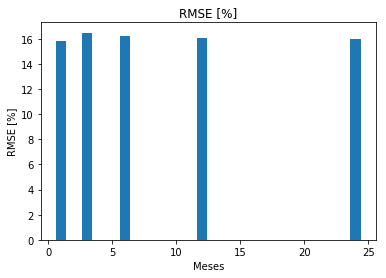

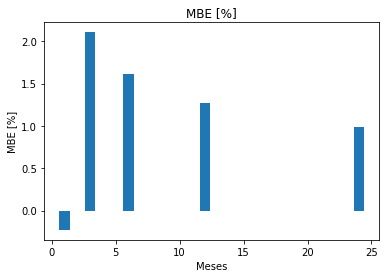

In [68]:
Estadisticas('Valledupar',2010)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


EL RMSE entre IDEAM y NREL es: 30.6477341498
EL MBE entre IDEAM y NREL es: -9.117161998892827
La ENFICC de la serie IDEAM  4.56900737661
La ENFICC de la serie NREL  5.06265316667
La ENFICC de la serie CORREGIDA  4.45520439275


Fecha Final RMSE [%]   MBE [%]                       KSI[p-Value]
1    (2011, 1, 2011, 1)  17.3971  -3.02297          (0.225, 0.00371945428863)
3    (2011, 1, 2011, 3)  15.8998 -0.549502   (0.133333333333, 0.219571571973)
6    (2011, 1, 2011, 6)  15.8658  0.372397  (0.0916666666667, 0.673781227063)
12  (2011, 1, 2011, 12)  15.9177  0.714055  (0.0833333333333, 0.781593040441)
24  (2011, 1, 2012, 12)  16.1806   1.51416            (0.125, 0.286403832382)

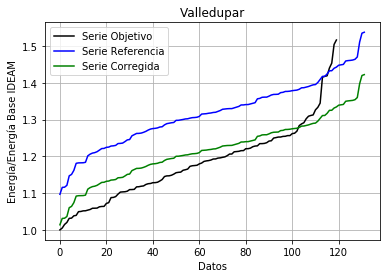

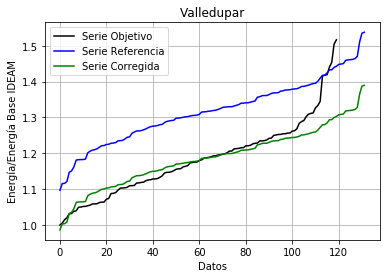

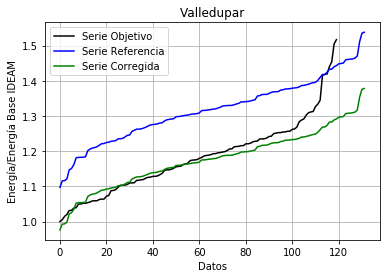

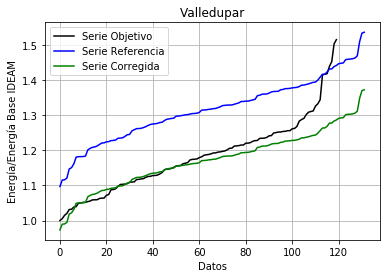

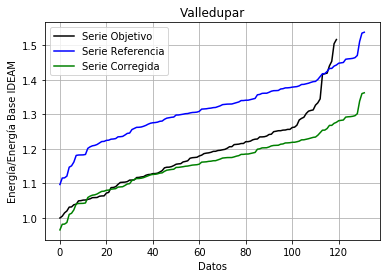

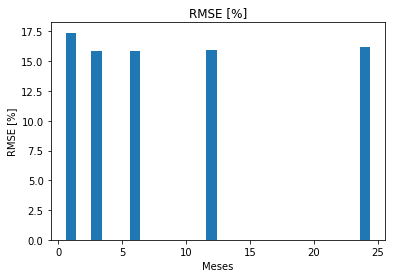

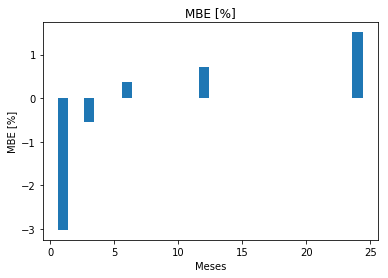

In [71]:
Estadisticas('Valledupar',2011)

Como nos podemos dar cuenta, en las ciudades de referencia, el error que se ve en la cidudad de **Medellin** para los años 2008-2011 no es relevante, esto se puede deber a que Medellin se vio mas afectada por la variabilidad en la toma de datos durante este periodo de tiempo. 

## Recomendaciones   
    1. Se puede realizar una analisis mas profundo comparando mismo periodo de tiempo, para diferentes años y todas las ciudades.
    2. Se podria comparar las diferentes series corregidas con la IDEAM y graficamente compararlas.

## ANEXOS

In [70]:
PorCiudad("Sucre",2005,2015,1,12,True)

TypeError: Could not convert 00000002.052.367.784145.826.1323.305.392.3265.498.185.2756.967.248.5317.788.195.6457.982.630.4875.519.789.1466.297.528.5174.526.011.0612.452.039.4055.076.909.782000000000001.080.193.571259.246.457176.071.5523.467.421.3625.519.789.1467.042.862.0817.831.403.387802.583.8237.528.949.188626.512.2713.996.716.2122.106.377.4635.076.909.7820000000000002.160.387.1411.263.826.4782.905.720.7054.839.267.1977.334.514.3457.917.818.8737.075.267.888795.022.4686.481.161.4244.601.624.6112.484.445.2135.184.929.1390000000000002.715.266.2931.284.399.1247.345.316.2812.970.532.3193.888.696.8544.677.238.1617.302.108.5385.379.363.9823.510.629.1051.695.903.9061.955.150.3634.752.851.7110000000000001.915.266.293367.265.8148.533.529.2082.171.189.0775.055.305.9113.121.759.4196.297.528.5177.961.026.6162.657.276.184221.439.6821.847.131.0063.564.638.7830000000000001.415.266.2931.155.807.1212.938.126.5123.856.291.0473.024.541.9983.769.875.562618.950.9165.163.325.2685.292.948.4961.188.212.9282.095.575.5273.888.696.8540000000000001.512.270.9997.453.335.6383.056.947.8054.547.614.9337.096.871.7598.285.084.6876.610.784.6536.437.953.681656.757.6914.752.851.7111.058.589.6992.700.483.927000000000000183.632.9071.490.667.1283.413.411.6834.623.228.4835.033.702.0396.783.615.6248.015.036.2957.550.553.0596.437.953.6814.255.962.6692.160.387.1416.481.161.4240000000000002.052.367.7841.641.894.2273.705.063.9475.606.204.6327.075.267.8887.961.026.616817.706.533772.338.4036.545.973.0384.914.880.7472.851.711.0277.345.316.281000000000001.080.193.5712.376.425.8561.663.498.0993.651.054.2695.562.996.889618.950.9167.550.553.0598.241.876.9447.842.205.3236.589.180.781488.247.4942.765.295.5416.913.238.8520000000000002.160.387.1411.220.618.735359.704.4594.968.890.4257.140.079.5028.079.847.9098.457.915.6587.766.591.773664.319.0464.828.465.2612.711.285.8626.697.200.1380000000000002.052.367.7841.663.498.0993.467.421.3625.876.253.0257.118.475.6317.982.630.4878.382.302.1096.206.364.2126.589.180.7814.860.871.0682.765.295.5416.805.219.4950000000000001.728.309.7131.058.589.6993.208.174.9055.303.750.4326.880.833.0457.917.818.8738.187.867.2667.669.374.3526.513.567.2314.742.049.7752.646.474.248626.512.2710000000000002.160.387.1411.512.270.999213.878.3273.661.856.2055.541.393.018618.950.9166.956.446.595694.564.4666.708.002.0744.623.228.4832.376.425.8565.508.987.2110000000000001.512.270.9999.073.625.9942.549.256.8274.904.078.8116.653.992.3957.626.166.609802.583.8237.431.731.7666.394.745.9384.472.001.3832.624.870.3776.373.142.0670000000000001.620.290.3561.393.449.706266.807.8123.326.996.1984.979.692.3617.831.403.3878.133.857.5877.712.582.095649.196.3364.709.643.9682.657.276.184626.512.2710000000000002.268.406.4981.479.865.1923.164.967.1625.779.035.6035.649.412.3756.913.238.8526.708.002.0745.357.760.1114.720.445.904458.002.0742.678.880.0558.641.548.566000000000000.1117441621.188.212.9281.436.657.449266.807.8123.218.976.8417.107.673.6957.982.630.4878.274.282.7517.831.403.387671.880.4015.044.503.9752.938.126.5125.184.929.1390000000000001.620.290.3561.620.290.3563.715.865.8835.725.025.9257.323.712.4098.447.113.7238.533.529.2088.015.036.2957.507.345.3165.411.769.7893.208.174.9058.533.529.2080000000000002.160.387.1411.717.507.7773.715.865.8835.368.562.0467.388.524.0248.263.480.8168.490.321.4668.220.273.0736.999.654.3385.303.750.4323.164.967.1629.397.684.0650000000000002.052.367.7841.641.894.227352.143.1045.562.996.8897.129.277.567810.145.1788.382.302.1097.907.016.937679.441.7565.033.702.0392.894.918.7694.644.832.354000000000000183.632.9071.436.657.4493.435.015.5555.433.373.6616.934.842.7247.896.215.0028.209.471.1377.744.987.9026.621.586.5884.958.088.4892.862.512.9627.777.393.7090000000000001.512.270.9991.209.816.7993.456.619.4265.001.296.2326.805.219.4958.004.234.3597.204.891.1168.220.273.073679.441.7564.796.059.4542.873.314.8987.669.374.352000000000000.1117441621.115.266.2938.317.490.4943.121.759.4193.651.054.2695.703.422.0537.572.156.9317.853.007.2597.496.543.3816.740.407.8814.925.682.6822.786.899.4125.292.948.4960000000000001.296.232.285160.948.8421.706.705.8423.726.667.8195.422.571.7257.388.524.0247.129.277.5677.842.205.3236.610.784.6534.990.494.2972.862.512.9624.860.871.0680000000000001.296.232.2851.350.241.9633.478.223.2983.942.706.5336.016.678.1897.928.620.8098.349.896.3017.907.016.9376.686.398.2034.925.682.682259.246.4575.076.909.7820000000000001.315.266.2933.564.638.783183.632.9071.415.053.5781.263.826.4782.797.701.3485.465.779.4685.292.948.4965.303.750.4325.465.779.4682.797.701.3484.536.812.9970000000000001.404.251.6421.231.420.6712.711.285.8625.779.035.6037.226.494.9888.241.876.9448.522.727.2735.606.204.6326.621.586.588352.143.1042.387.227.7917.021.258.2090000000000003.132.561.355183.632.9072.387.227.7913.532.232.9765.789.837.5396.513.567.2316.632.388.5244.763.653.6474.569.218.8044.115.537.5041.361.043.8994.495.892.384000000000001.080.193.5712.376.425.8561.479.865.1923.607.846.5265.627.808.5037.215.693.0528.198.669.2028.522.727.2738.015.036.2956.902.436.9175.163.325.2682.797.701.3489.613.722.779000000000000183.632.9071.490.667.1282.786.899.4124.688.040.0975.013.339.0948.522.727.2738.792.775.6658.187.867.2667.086.069.8245.346.958.1753.089.353.6125.725.025.9250000000000003.132.561.3551.307.034.2214.072.329.7615.800.639.4755.757.431.732893.320.0838.663.152.437795.022.4685.465.779.4683.046.145.8692.117.179.3994.212.754.9260000000000001.129.524.4681.101.797.4422.019.961.9772.635.672.3123.067.749.7413.272.986.5193.564.638.7833.305.392.3266.167.905.2894.482.803.3181.587.884.5493.780.677.4970000000000001.620.290.3561.415.053.5782.948.999.0835.627.808.5036.783.615.6245.973.470.4467.166.034.1584.212.754.9261.933.546.4921.317.836.1561.123.401.3144.104.735.5690000000000001.728.309.7136.373.142.0671.857.932.942229.001.0375.022.900.1046.286.726.5816.986.034.1588.123.055.6524.634.030.4182.300.812.3069.289.664.7083.456.619.4260000000000001.728.309.7131.209.816.7993.478.223.298221.439.6822.808.503.284138.264.7775.379.363.9828.263.480.8165.141.721.3962.700.483.9275.508.987.2112.160.387.1410000000000002.329.524.4681.188.212.9288.533.529.2082.149.585.2063.856.291.0474.104.735.569596.266.8518.198.669.2025.505.801.5045.394.260.6592.769.305.2196.540.972.963000000000000.0900161312.929.524.4689.658.393.8242.538.999.0834.933.899.0675.687.209.3068.117.345.3168.836.034.1589.079.649.0784.925.801.5045.254.260.6593.589.305.2191.084.097.296000000000000.0900161311.329.524.4688.158.393.8243.068.999.0833.023.899.0678.147.209.3065.567.345.3161.183.603.4168.129.649.0787.815.801.5044.324.260.6592.399.305.2198.440.972.963000000000000.0900161312.829.524.4681.105.839.3823.168.999.0833.343.899.0676.647.209.3069.637.345.3161.042.603.4164.829.649.0785.865.801.5043.784.260.6591.909.305.2191.144.097.296000000000000.0900161311.529.524.4689.158.393.8244.428.999.0834.245.160.7337.042.862.0818.371.500.1738.738.765.9878.263.480.8166.913.238.8525.260.542.6893.078.551.6769.505.703.422000000000000183.632.9071.090.995.5062.678.880.0555.617.006.5687.280.504.6668.187.867.2668.112.253.7168.144.659.5236.826.823.3675.120.117.5252.992.136.1915.508.987.2110000000000001.620.290.3561.307.034.2213.435.015.5555.433.373.6616.783.615.6248.112.253.716855.513.308795.022.4687.507.345.316558.460.0762.992.136.1911.004.580.0210000000000002.729.524.4681.285.430.3493.867.092.9835.476.581.4034.727.209.3069.857.345.3168.486.034.158832.829.2437.075.267.8885.314.552.3682.959.730.3847.021.258.2090000000000002.052.367.784153.387.4873.813.083.305596.266.8517.528.949.1888.565.935.0169.138.437.6088.641.548.5667.528.949.1885.681.818.1823.002.938.1271.047.787.7640000000000002.268.406.4981.717.507.7773.769.875.5626.081.489.8037.528.949.1888.501.123.4018.944.002.7656.619.649.0787.258.900.7955.465.779.4683.283.788.4551.047.787.7640000000000002.484.445.2131.652.696.1633.726.667.8195.779.035.6037.399.325.9598.414.707.9168.749.567.9238.295.886.6237.161.683.3745.422.571.7254.139.305.2194.040.972.963000000000001.080.193.5712.052.367.7841.447.459.3852.387.227.7915.800.639.4757.194.089.1818.447.113.7238.825.181.4738.295.886.6237.194.089.1815.465.779.4683.262.184.5839.721.742.1360000000000001.620.290.3561.026.183.8923.413.411.6834.115.537.5047.420.929.8318.522.727.273893.320.0838.490.321.4667.334.514.3455.552.194.9533.370.203.9411.069.391.6350000000000002.484.445.2131.253.024.5423.629.450.398359.704.4597.302.108.5387.399.325.959840.390.5988.317.490.4947.399.325.9595.638.610.4393.489.025.2331.134.203.2490000000000002.808.503.2841.814.725.1993.996.716.2126.092.291.7397.777.393.709885.758.7289.192.447.2878.695.558.2447.539.751.1235.725.025.925352.143.1041.199.014.8630000000000002.484.445.2131.782.319.3923.931.904.5976.005.876.2538.057.209.3068.771.171.7949.149.239.5447.669.649.0787.507.345.3162.784.260.6593.543.034.9121.134.203.2490000000000002.376.425.8561.717.507.7773.942.706.533603.828.2067.593.760.802878.197.3738.976.408.5728.533.529.2087.237.296.9245.692.620.1183.424.213.6191.123.401.3140000000000002.376.425.8561.674.300.0353.553.836.8485.671.016.2467.474.939.5098.565.935.0168.868.389.2158.371.500.1737.183.287.2455.444.175.5963.262.184.5831.026.183.892000000000001.080.193.5712.376.425.8561.566.280.6773.154.165.226588.705.496795.022.4688.814.379.5379.192.447.2878.663.152.4377.420.929.8315.617.006.5683.435.015.5551.026.183.8920000000000002.484.445.2131.695.903.9063.856.291.0475.768.233.6676.578.378.8458.673.954.3739.041.220.187847.951.9537.291.306.6025.519.789.1463.402.609.7481.101.797.4420000000000002.376.425.8561.393.449.7063.316.194.2625.508.987.2116.697.200.1387.150.881.4388.015.036.2955.357.760.1113.326.996.1984.115.537.5042.819.305.2195.292.948.4960000000000001.188.212.9287.993.432.4231.004.580.0211.695.903.9065.897.856.8967.053.664.0179.257.258.9016.016.678.1893.705.063.9473.272.986.5193.283.788.4556.913.238.8520000000000001.620.290.3561.512.270.999266.807.812435.318.0095.768.233.6679.030.418.251687.003.1117.042.862.0817.464.137.5735.606.204.6323.413.411.6831.101.797.4420000000000003.912.968.4951.782.319.392389.949.8795.973.470.4467.377.722.0888.684.756.3089.030.418.2518.414.707.9167.269.702.7315.465.779.4683.208.174.9058.209.471.1370000000000002.700.483.9271.749.913.5853.759.073.6266.081.489.8035.876.253.0256.519.948.1515.427.165.5728.447.113.7237.237.296.9245.346.958.1752.970.532.3195.184.929.1390000000000001.620.290.3561.523.072.9352.462.841.3414.547.614.9336.221.914.9677.744.987.9028.090.649.8447.064.465.9526.816.021.4313.964.310.4042.052.367.7844.644.832.3540000000000001.296.232.2851.371.845.8352.981.334.2553.780.677.4972.311.614.2416.070.687.8673.618.648.462588.705.4966.319.132.3895.314.552.3682.959.730.3845.617.006.5680000000000001.728.309.7138.749.567.9231.814.725.1995.184.929.1397.172.485.3095.184.929.1394.309.972.3475.703.422.0533.802.281.3693.294.590.3912.053.004.954478.950.9160000000000001.912.968.4951.771.517.4562.711.285.8624.774.455.5826.610.784.6536.621.586.5885.638.610.4393.543.034.9123.435.015.5551.253.024.5421.663.498.099183.632.907000000000000183.632.9071.296.232.2852.938.126.5123.618.648.4624.590.822.6755.044.503.9753.661.856.2052.916.522.641450.440.7192.041.565.8498.209.471.1373.240.580.7120000000000001.188.212.9285.833.045.2829.505.703.4222.246.802.6273.229.778.7765.033.702.0397.096.871.7596.956.446.5956.448.755.6174.212.754.9262.311.614.2414.212.754.9260000000000003.888.696.8541.728.309.7133.456.619.4264.439.595.5768.004.234.3596.232.716.903694.564.4668.187.867.2668.015.036.2955.487.383.3392.678.880.0557.237.296.9240000000000003.348.600.0691.922.744.5563.769.875.5625.454.977.532634.073.626855.513.3089.365.278.2589.030.418.2517.766.591.7735.822.243.3463.553.836.8481.220.618.7350000000000003.024.541.9981.663.498.099427.756.654664.319.0467.939.422.7458.987.210.5089.311.268.579863.074.6637.237.296.9245.465.779.4683.683.460.0761.220.618.735000000000000367.265.8142.030.763.913420.195.2996.081.489.8037.971.828.5529.030.418.2519.235.655.0298.911.596.9587.690.978.2235.897.856.8963.661.856.2058.749.567.9230000000000003.780.677.4971.998.358.1064.169.547.1836.383.944.0038.079.847.9098.609.142.7589.041.220.1878.879.191.151764.777.0484.390.086.4153.683.460.0761.026.183.892000000000000367.265.8141.933.546.4924.212.754.9266.329.934.3248.004.234.3599.052.022.1229.257.258.9018.879.191.1517.582.958.8665.865.451.0893.067.749.7411.036.985.8280000000000003.780.677.4971.706.705.8423.985.914.2766.103.093.6747.507.345.316870.636.0189.127.635.6728.220.273.0736.513.567.2315.292.948.4962.938.126.512885.758.7280000000000002.916.522.6411.825.527.1344.093.933.633611.389.5617.474.939.509817.706.533878.197.3738.511.925.337687.003.1114.029.122.0192.927.324.5774.968.890.4250000000000004.320.774.2832.041.565.8494.061.527.8264.839.267.1977.961.026.6168.209.471.1377.582.958.8668.749.567.9237.388.524.0244.796.059.4548.317.490.4941.404.251.6420000000000001.944.348.4278.749.567.9232.333.218.1133.759.073.6266.610.784.6536.913.238.8528.792.775.665870.636.0187.528.949.1885.595.402.6963.316.194.2626.697.200.1380000000000003.348.600.0691.631.092.2923.316.194.262581.144.141679.441.7569.019.616.3159.170.843.4158.663.152.4377.464.137.5735.671.016.2463.370.203.9418.965.606.6370000000000002.700.483.9278.209.471.1372.473.643.2775.779.035.6037.107.673.6958.198.669.2029.192.447.2878.673.954.3737.258.900.7955.368.562.0463.197.372.9697.885.413.0660000000000004.752.851.7111.652.696.163389.949.8795.854.649.1537.323.712.4097.053.664.0176.924.040.7888.565.935.0166.167.905.2893.910.300.726236.562.392367.265.8140000000000002.700.483.927183.632.9072.830.107.1552.700.483.927420.195.2996.167.905.289558.460.076656.757.6911.425.855.5131.015.381.9561.695.903.9066.913.238.8520000000000002.052.367.7847.777.393.7092.203.594.8843.391.807.8125.109.315.5893.056.947.8052.192.792.9481.058.589.6994.914.880.7472.765.295.5411.090.995.506259.246.4570000000000004.320.774.2831.004.580.0212.549.256.8275.951.866.5747.809.799.5169.376.080.1948.036.640.1662.527.652.9552.333.218.1135.433.373.6617.993.432.4231.512.270.9990000000000003.812.968.4956.913.238.8522.376.425.8562.722.087.7983.769.875.5624.601.624.611603.828.2064.104.735.5693.294.590.3912.333.218.1133.132.561.3554.212.754.9260000000000001.944.348.4271.209.816.7991.479.865.1922.506.049.0842.279.208.4343.078.551.6763.510.629.1054.363.982.0263.197.372.9692.646.474.2481.857.932.9426.805.219.4950000000000004.104.735.569191.194.2624.320.774.2836.934.842.7248.468.717.5949.214.051.1589.041.220.1878.684.756.3087.118.475.6315.595.402.6969.289.664.7082.808.503.284000000000000183.632.9071.274.628.413397.511.2346.913.238.8528.987.210.5089.062.824.0589.160.041.4797.820.601.452779.899.7585.822.243.3463.575.440.7191.166.609.0560000000000004.860.871.0681.998.358.106450.440.7196.762.011.7534.666.436.2259.430.089.8727.961.026.6168.317.490.4947.485.741.445566.021.4313.251.382.6481.944.348.4270000000000003.564.638.7832.279.208.4343.856.291.0475.627.808.5035.076.909.7825.973.470.4468.619.944.6945.508.987.2114.644.832.3544.947.286.5542.019.961.9772.916.522.6410000000000003.456.619.4261.555.478.7423.456.619.4266.200.311.0967.086.069.8247.907.016.9377.593.760.802581.144.1416.848.427.2384.688.040.0978.749.567.9237.885.413.066000000000001.080.193.5712.376.425.8561.631.092.2922.009.160.0414.482.803.3187.550.553.0598.285.084.6876.167.905.2894.547.614.9335.379.363.9825.519.789.1463.067.749.7415.725.025.9250000000000001.944.348.427176.071.5523.543.034.9125.314.552.3688.004.234.3599.116.833.7378.317.490.4947.420.929.831634.073.6263.499.827.1699.181.645.3514.104.735.569000000000000442.879.3647.885.413.066626.512.2713.186.571.0347.269.702.7318.792.775.6658.393.104.0448.295.886.6236.902.436.9174.634.030.4181.555.478.7423.996.716.2120000000000003.024.541.9981.069.391.6352.408.831.6635.822.243.3466.329.934.3246.405.547.8749.419.287.9368.825.181.4732.462.841.3411.307.034.2211.209.816.7991.620.290.3560000000000002.358.451.434442.879.3641.825.527.1342.776.097.4777.161.683.3746.988.852.4028.317.490.4948.133.857.5874.018.320.083145.826.1321.058.589.6993.456.619.426000000000001.080.193.5715.833.045.2821.577.082.613389.949.8797.399.325.9599.170.843.4157.831.403.3878.317.490.4948.360.698.2377.366.920.1525.779.035.6032.905.720.7053.456.619.4260000000000003.240.580.7121.285.430.3491.631.092.2922.732.889.7345.617.006.5687.086.069.8248.544.331.1448.166.263.3947.420.929.8313.877.894.9192.333.218.1134.536.812.9970000000000001.188.212.9281.069.391.6351.965.952.2992.462.841.3414.169.547.183596.266.8516.146.301.4178.275.760.4563.326.996.1982.246.802.6271.490.667.1286.589.180.7810000000000003.996.716.2121.933.546.4922.959.730.3843.856.291.0474.374.783.9615.476.581.4035.768.233.6673.132.561.3551.134.203.2497.237.296.9241.220.618.7355.725.025.925000000000001.080.193.571626.512.2711.901.140.6844.569.218.8046.913.238.8528.231.075.009840.390.5988.306.688.5598.112.253.7165.465.779.4681.080.193.5715.833.045.2827.561.354.9950000000000005.508.987.2111.890.338.749352.143.1045.573.798.8258.349.896.3015.708.247.7325.833.045.2823.413.411.683581.144.1415.044.503.9753.035.343.9343.024.541.998000000000000.6332169211.512.270.9993.996.716.2121.047.787.7642.203.594.8843.413.411.6834.093.933.6335.055.305.9114.125.760.4563.791.479.4331.868.734.8771.512.270.9991.080.193.571000000000001.080.193.5712.916.522.6411.253.024.5423.424.213.6195.757.431.732810.145.1787.896.215.0026.059.435.6174.666.436.2252.981.334.2553.283.788.4551.749.913.5855.184.929.139000000000001.080.193.5715.258.451.4345.076.909.7822.722.087.7982.430.435.5343.553.836.8485.422.571.7258.501.123.4016.632.388.5247.129.277.5675.714.223.9893.456.619.4261.188.212.9280000000000005.076.909.7822.279.208.4343.499.827.1697.118.475.631787.461.113817.706.5338.565.935.016450.440.7193.629.450.3982.376.425.8562.732.889.7341.393.449.706000000000001.080.193.5714.104.735.5691.177.410.9922.927.324.5777.345.316.2818.511.925.3379.797.355.686847.951.953764.777.0487.053.664.0175.184.929.1393.640.252.3331.058.589.699000000000002.160.387.1415.076.909.7821.976.754.2343.056.947.805596.266.8518.641.548.5666.740.407.881870.636.0184.936.484.618458.002.0744.363.982.0261.663.498.0991.404.251.6420000000000002.916.522.6418.317.490.4942.160.387.1413.132.561.3556.859.229.1747.507.345.3167.291.306.6027.993.432.4234.407.189.7684.180.349.1191.155.807.1219.721.742.136000000000001.080.193.5713.348.600.0691.296.232.2852.927.324.5774.493.605.2545.703.422.0537.107.673.695664.319.0464.968.890.4252.851.711.0271.501.469.0631.371.845.8354.320.774.283000000000002.160.387.1416.697.200.1381.890.338.7492.614.068.441435.318.0096.221.914.9678.360.698.2379.646.128.5868.511.925.3377.269.702.7312.970.532.3191.112.599.3783.132.561.3550000000000005.758.451.4347.561.354.9953.272.986.5193.067.749.7418.133.857.5878.965.606.6379.311.268.5798.727.964.0517.204.891.1165.595.402.6963.240.580.7126.697.200.138000000000002.160.387.1415.400.967.8532.084.773.5914.137.141.376397.511.2347.140.079.5029.764.949.8798.166.263.3947.658.572.416679.441.7564.990.494.2972.041.565.8495.400.967.8530000000000002.808.503.2847.885.413.0662.354.821.984244.123.7474.688.040.0972.527.652.9554.828.465.2613.607.846.5264.612.426.547427.756.6542.117.179.3995.281.510.6620000000000002.058.451.4344.968.890.4257.885.413.0663.780.677.4971.155.807.1212.646.474.2484.342.378.1545.789.837.5394.061.527.8263.132.561.3552.408.831.6635.941.064.639000000000002.160.387.1414.968.890.4256.805.219.4952.387.227.7914.698.842.0326.913.238.8527.701.780.1597.582.958.8665.282.146.5613.586.242.6552.257.604.5631.069.391.6354.752.851.7110000000000003.564.638.7832.354.821.984367.265.8144.720.445.9048.187.867.2668.814.379.5377.453.335.6387.907.016.9377.269.702.7315.444.175.5961.922.744.5564.320.774.2830000000000002.268.406.4989.397.684.0651.901.140.6842.527.652.955389.949.8793.921.102.6625.487.383.3396.999.654.3385.508.987.2115.519.789.146236.562.3929.073.625.994000000000001.080.193.5711.944.348.4272.905.720.7054.634.030.418641.634.9818.349.896.3016.427.151.7469.451.693.7446.578.378.8455.789.837.5395.454.977.5327.777.393.7091.512.270.999000000000001.080.193.5716.049.083.9962.333.218.1133.856.291.047588.705.4968.522.727.2739.127.635.672885.758.7288.339.094.3667.129.277.5675.066.107.8478.425.509.8511.728.309.7130000000000005.758.451.4348.533.529.2081.631.092.2923.424.213.6196.708.002.0745.919.460.7677.032.060.1452.160.387.1411.112.599.3782.311.614.2416.373.142.067183.632.907000000000002.160.387.1412.916.522.6411.901.140.6844.828.465.2617.377.722.0887.734.185.9667.485.741.4459.030.418.2518.695.558.2447.377.722.0885.303.750.4323.208.174.9056.157.103.3530000000000005.257.006.3021.192.278.1684.212.754.9268.965.606.6372.149.585.206367.265.8144.191.151.0543.888.696.8542.376.425.8561.955.150.363160.948.8425.833.045.282000000000001.080.193.571367.265.8141.285.430.3492.127.981.3345.995.074.3178.155.461.4597.669.374.3529.019.616.3156.816.021.4316.049.083.9965.876.253.0253.715.865.8835.725.025.925000000000001.080.193.5714.968.890.4251.825.527.1345.454.977.5327.032.060.1457.939.422.7459.797.355.6865.837.099.658706.435.2466.308.330.4533.575.440.7191.847.131.0065.833.045.282000000000002.160.387.1415.508.987.2111.415.053.5782.030.763.9133.283.788.4556.816.021.4318.220.273.073687.003.111641.634.9815.725.025.9253.575.440.7193.071.401.6596.475.106.579000000000001.080.193.5713.888.696.8542.030.763.9133.726.667.8193.348.600.0696.027.480.1248.976.408.5728.825.181.4737.863.809.195458.002.0745.087.711.7181.879.536.8131.080.193.571000000000002.160.387.1416.805.219.4952.689.681.9913.305.392.3265.692.620.1187.917.818.8739.192.447.287993.778.0856.427.151.7466.394.745.9385.346.958.1751.598.686.4852.268.406.4980000000000002.052.367.7841.220.618.7353.208.174.9055.044.503.9756.351.538.1965.725.025.9257.010.456.274885.758.7285.897.856.8961.371.845.8359.397.684.0653.780.677.497000000000001.080.193.5715.508.987.2111.976.754.2343.381.005.8765.487.383.3395.779.035.6034.968.890.4254.536.812.9975.346.958.1753.996.716.212213.878.3277.669.374.3522.376.425.856000000000003.048.642.9796.157.006.3021.272.278.1681.890.313.0035.090.306.4057.476.481.1617.457.034.7976.197.099.6581.695.903.9062.786.899.412229.001.0379.397.684.0653.348.600.069000000000003.240.580.7124.752.851.711168.510.1973.121.759.4193.780.677.4974.698.842.0326.232.716.9035.973.470.4466.297.528.5175.951.866.5742.722.087.798442.879.3641.188.212.928000000000001.080.193.5714.968.890.425274.369.1675.087.711.7185.422.571.7256.221.914.9679.332.872.4519.343.674.3866.816.021.4315.433.373.6611.695.903.9067.237.296.9242.484.445.213000000000002.160.387.1413.348.600.0696.373.142.0672.149.585.206558.460.0768.695.558.2449.343.674.3866.729.605.945878.197.3735.714.223.9893.186.571.034183.632.9074.968.890.425000000000002.048.642.9794.057.006.3021.142.278.1684.090.313.0033.160.306.4055.541.393.0186.329.934.3246.221.914.9675.217.334.9467.194.089.181566.021.4313.013.740.0629.397.684.065000000000002.160.387.1415.508.987.2112.430.435.5343.413.411.6831.728.309.7133.067.749.7417.150.881.4388.987.210.5088.468.717.594382.388.5241.544.676.8069.397.684.0653.888.696.854000000000001.080.193.5713.456.619.4261.452.278.1682.300.812.3065.141.721.396802.583.8238.760.369.8588.133.857.5875.779.035.6032.257.604.5631.944.348.4271.425.855.5134.644.832.354000000000001.080.193.571442.879.3641.803.923.2633.078.551.6765.109.315.5897.507.345.3167.788.195.6455.562.996.8895.238.938.818435.318.0094.385.585.8973.499.827.1699.289.664.708000000000002.160.387.1416.373.142.0671.717.507.7773.251.382.6484.439.595.5764.590.822.6756.578.378.8455.228.136.8824.612.426.5475.400.967.853558.460.0764.007.518.1471.641.894.227000000000001.080.193.5716.913.238.8521.134.203.2498.533.529.2085.498.185.2757.582.958.8668.976.408.5728.879.191.1518.231.075.0096.837.625.3025.703.422.0533.575.440.7195.076.909.782000000000003.240.580.7125.184.929.1391.825.527.1341.814.725.1993.197.372.9698.112.253.7166.675.596.2678.123.055.6527.593.760.8026.502.765.2963.937.436.3413.467.421.362993.778.085000000000003.240.580.7128.425.509.8512.473.643.2771.393.449.7065.336.156.2397.961.026.616764.777.0488.619.944.6948.090.649.8446.805.219.4955.573.798.8253.294.590.3918.209.471.137000000000002.160.387.1416.373.142.067213.878.3272.257.604.5634.774.455.5823.348.600.069832.829.2437.885.413.0667.928.620.8097.150.881.4385.411.769.7893.154.165.2266.697.200.138000000000004.320.774.2833.996.716.2122.354.821.9844.968.890.4254.330.306.4057.896.215.0029.073.625.9947.680.176.2887.604.562.738664.319.0465.444.175.5962.916.522.6418.317.490.494000000000001.080.193.5713.857.006.3021.512.270.9991.220.618.735274.369.1674.990.494.2976.535.171.1036.675.596.2676.653.992.3955.346.958.1754.299.170.4112.300.812.3061.253.024.542000000000003.240.580.7124.968.890.4251.328.638.0922.495.247.1484.828.465.2618.457.915.6588.619.944.6946.502.765.2967.928.620.8096.308.330.453450.440.7192.019.961.9777.129.277.567000000000002.160.387.1413.132.561.3554.752.851.7119.613.722.779160.948.8423.910.300.7267.453.335.638618.950.916626.512.2715.984.272.3824.223.556.8612.689.681.9911.026.183.8920000000000002.557.006.3022.916.522.6411.339.440.0282.354.821.984488.247.4944.288.368.4766.286.726.5817.107.673.6957.701.780.1595.055.305.9112.927.324.5777.129.277.567000000000002.160.387.1412.160.387.1418.533.529.2082.052.367.7845.357.760.1115.271.344.6256.783.615.6247.420.929.8317.863.809.1955.195.731.0752.506.049.0841.393.449.7063.780.677.497000000000000259.246.4574.860.871.0681.328.638.0923.013.740.0623.478.223.2983.553.836.8485.087.711.7184.288.368.4766.059.885.9325.487.383.3392.225.198.7564.536.812.997000000000001.080.193.5719.721.742.1362.084.773.5913.705.063.9476.319.132.3898.641.548.5668.079.847.909694.564.4667.744.987.9027.237.296.9245.541.393.018344.581.7498.209.471.137000000000002.160.387.1412.052.367.7849.505.703.4222.160.387.1413.370.203.9415.941.064.639687.003.1115.076.909.7825.109.315.5895.271.344.6252.927.324.5771.436.657.4494.752.851.711000000000001.080.193.5712.268.406.4988.641.548.566168.510.1972.970.532.3192.506.049.0843.456.619.4262.992.136.1915.260.542.6894.990.494.2971.415.053.5781.145.005.185442.879.3640000000000001.296.232.2857.237.296.9241.944.348.4272.387.227.7913.218.976.8415.530.591.0826.675.596.2676.988.852.4025.422.571.7253.640.252.3332.570.860.6981.069.391.635000000000003.240.580.7123.780.677.4971.166.609.0563.208.174.9055.217.334.9464.828.465.2618.944.002.7657.593.760.8026.459.557.5536.783.615.6244.925.682.682244.123.7475.725.025.925000000000004.320.774.2838.425.509.8511.112.599.3785.617.006.5681.069.391.6353.996.716.2124.212.754.9261.004.580.0212.344.020.0483.229.778.7762.603.266.5051.555.478.7425.076.909.782000000000002.160.387.141183.632.9077.453.335.6381.361.043.8991.825.527.1345.012.098.168764.777.0485.703.422.0537.291.306.6027.129.277.5676.394.745.9383.132.561.3554.536.812.997000000000003.240.580.7121.145.005.1852.322.416.177259.246.4574.472.001.3835.368.562.0464.342.974.5446.635.833.5395.390.165.9184.255.962.6692.236.000.6911.523.072.9353.564.638.7830000000000002.268.406.4984.860.871.0681.047.787.7642.160.387.1415.541.393.018664.319.0467.096.871.7597.010.456.2744.234.358.7975.033.702.0393.359.402.0051.317.836.156000000000001.080.193.5712.160.387.1416.697.200.1381.447.459.3853.381.005.8766.394.745.938802.583.8235.411.769.789389.949.879558.460.0763.489.025.2332.149.585.2067.561.354.9950000000000001.944.348.4278.209.471.1373.575.440.719480.686.1397.615.364.673772.338.4035.627.808.5037.291.306.6027.258.900.7955.357.760.1113.586.242.6556.049.083.9960000000000002.376.425.8561.036.985.8282.095.575.5273.543.034.9127.096.871.7599.613.722.7797.593.760.8024.742.049.7753.802.281.3692.538.454.8911.253.024.5427.021.258.2090000000000006.370.722.4332.006.657.4491.878.746.23526.607.0123.283.788.4553.985.914.2766.146.301.4178.425.509.8517.604.562.7385.789.837.5393.780.677.497442.879.364000000000002.160.387.1416.805.219.4951.307.034.2214.536.812.9976.535.171.1038.317.490.4948.944.002.7656.934.842.7248.069.045.9737.258.900.7955.595.402.6963.607.846.5261.285.430.349000000000003.240.580.712442.879.3642.700.483.9274.709.643.9686.589.180.7818.015.036.2958.544.331.1447.010.456.2748.263.480.8164.450.397.5118.317.490.4943.564.638.7833.240.580.7120000000000008.470.722.4333.024.541.9989.829.761.4932.797.701.3485.768.233.6677.842.205.3236.913.238.8526.837.625.3025.530.591.0824.644.832.3543.856.291.0471.058.589.699000000000000.6761624376.170.722.4331.086.657.4492.238.746.2356.329.934.3248.004.234.3598.749.567.9237.258.900.795679.441.7567.248.098.8595.789.837.5393.413.411.6833.564.638.783000000000003.240.580.7121.036.985.828266.807.8124.180.349.119488.247.4946.081.489.8035.260.542.6894.526.011.0613.802.281.3694.958.088.4893.996.716.2121.879.536.8137.345.316.281000000000000626.512.2712.506.049.0844.623.228.483641.634.9817.831.403.3878.619.944.6946.805.219.4957.993.432.4237.215.693.0525.541.393.0183.489.025.2331.274.628.413000000000002.160.387.1416.913.238.8522.181.991.0133.888.696.8545.249.740.754840.390.5986.286.726.5818.220.273.0735.833.045.2825.346.958.1754.850.069.132359.704.4591.199.014.863000000000005.400.967.8539.505.703.4221.890.338.7493.953.508.4696.556.774.9747.777.393.7098.598.340.8237.496.543.3817.334.514.3457.075.267.8885.228.136.882221.439.682626.512.271000000000002.160.387.141442.879.3641.706.705.8423.240.580.7123.737.469.7556.632.388.5247.550.553.0597.442.533.7026.848.427.2386.978.050.467558.460.0763.391.807.8121.296.232.285000000000001.080.193.5715.617.006.5682.073.971.6563.208.174.9054.461.199.4472.938.126.5123.316.194.262480.686.1394.374.783.9612.938.126.5122.117.179.3991.868.734.877626.512.271000000000004.320.774.2831.004.580.0212.506.049.0844.407.189.7686.686.398.2037.993.432.4238.987.210.5087.064.465.9527.971.828.5527.334.514.3455.400.967.8532.722.087.798810.145.178000000000002.160.387.1415.725.025.9258.533.529.2081.350.241.963480.686.1397.518.147.2528.047.442.1026.373.142.0673.586.242.6552.657.276.1841.814.725.1991.188.212.9283.888.696.8540000000000005.292.948.4961.868.734.8773.024.541.9984.255.962.6695.066.107.8474.569.218.8044.439.595.5764.482.803.3184.104.735.5692.830.107.1551.523.072.9355.941.064.639000000000003.240.580.7126.697.200.1382.387.227.7914.083.131.6976.524.369.1677.669.374.3528.727.964.0517.215.693.0528.004.234.3596.740.407.8815.228.136.8822.236.000.6911.706.705.8420000000000003.770.722.4336.481.161.4242.106.377.4634.904.078.8116.999.654.3387.626.166.6096.848.427.2387.701.780.1596.070.687.8674.039.923.9543.132.561.3551.274.628.413000000000001.080.193.5713.348.600.0697.561.354.995450.440.7196.135.499.4827.680.176.288832.829.2437.064.465.9527.366.920.1526.383.944.0035.195.731.0753.305.392.3261.253.024.5420000000000005.570.722.4331.620.290.356626.512.2711.890.338.7492.819.305.2194.018.320.083573.582.7866.157.103.3535.941.064.6393.143.363.2911.965.952.2996.913.238.852000000000002.160.387.1417.993.432.423229.001.0374.893.276.8756.826.823.3677.917.818.8738.673.954.3736.880.833.0458.015.036.2957.291.306.6025.757.431.7323.813.083.3051.587.884.549000000000001.080.193.5713.024.541.9981.469.063.2563.046.145.86927.507.01257.041.2788.842.974.5447.735.833.5395.393.457.5736.397.948.7943.442.899.5081.853.726.5936.984.536.992000000000002.160.387.1414.860.871.0682.452.039.4054.137.141.3764.526.011.0617.075.267.8888.425.509.8516.502.765.2967.831.403.3877.021.258.2095.562.996.8893.607.846.5261.469.063.256000000000001.080.193.5714.968.890.4252.181.991.0134.299.170.4116.049.083.9967.961.026.6168.673.954.3736.481.161.4247.853.007.2597.129.277.5675.292.948.4963.283.788.4551.415.053.578000000000002.160.387.1418.209.471.1372.452.039.4054.363.982.026649.196.3367.885.413.0666.891.634.9816.027.480.1247.961.026.6167.345.316.2813.370.203.9419.505.703.4224.536.812.997000000000001.080.193.5715.400.967.8531.199.014.8634.547.614.9336.049.083.9966.599.982.717611.389.561558.460.0766.146.301.4174.320.774.2833.326.996.198191.194.2626.589.180.781000000000001.080.193.5711.620.290.3566.805.219.4952.387.227.7913.305.392.3264.666.436.2255.606.204.6326.135.499.4826.708.002.0744.299.170.4112.970.532.3192.311.614.2411.135.217.767000000000002.160.387.1415.833.045.2821.717.507.7774.536.812.9976.599.982.7178.360.698.2378.727.964.0517.561.354.9957.615.364.6737.053.664.0175.671.016.246352.143.1041.577.082.613000000000002.160.387.141442.879.3641.652.696.1634.115.537.5045.508.987.2118.070.297.2697.485.741.4456.448.755.6176.383.944.0035.012.098.168412.633.9442.246.802.6271.566.280.6770000000000004.710.897.9531.201.677.0621.512.270.9993.262.184.5835.746.629.7966.286.726.5816.124.697.5467.118.475.6315.649.412.3755.476.581.4033.651.054.2691.209.816.799000000000002.160.387.1415.184.929.1391.871.677.062405.072.5895.552.194.9535.951.866.5747.712.582.0957.777.393.7096.751.209.8177.518.147.252558.460.0763.553.836.8481.296.232.285000000000002.160.387.1414.968.890.4251.782.319.3923.651.054.2695.508.987.2116.805.219.4957.907.016.937795.022.4687.485.741.4457.237.296.9245.692.620.1183.715.865.8831.145.217.767000000000001.080.193.5719.829.761.4932.646.474.248480.686.139656.757.6917.928.620.8098.695.558.2447.853.007.2597.388.524.0247.431.731.7665.757.431.732412.633.9441.663.498.099000000000001.080.193.5717.810.897.953176.071.5522.344.020.0484.601.624.6115.995.074.3177.928.620.809817.706.5337.183.287.2457.442.533.7025.865.451.0893.186.571.0341.415.053.578000000000002.160.387.1413.110.897.9531.490.667.1283.888.696.8543.985.914.2764.569.218.8048.112.253.7166.873.680.1476.099.131.036603.523.7836.364.334.1074.497.749.7411.875.217.7670000000000005.310.897.9537.561.354.9952.117.179.3993.575.440.7195.180.297.2699.263.422.5854.283.680.1476.069.131.036726.523.7837.054.334.1071.487.749.741545.217.767000000000001.215.217.7674.610.897.9531.611.677.0624.113.804.5865.805.237.8038.570.297.2695.313.422.5857.323.680.1478.059.131.036863.523.7836.534.334.1072.397.749.7411.755.217.7670000000000006.210.897.9532.571.677.0622.019.961.9774.709.643.9685.454.977.5326.221.914.9675.833.045.2827.485.741.445679.441.7564.666.436.2251.976.754.2341.328.638.092000000000001.215.217.7673.710.897.9538.016.770.6162.503.804.5864.445.237.8034.190.297.2696.363.422.5855.463.680.1476.609.131.036733.523.7833.844.334.1073.207.749.741855.217.767000000000001.080.193.5714.212.754.9261.825.527.1343.813.083.3056.092.291.7397.971.828.5528.889.993.0877.399.325.9596.059.885.9326.437.953.6813.964.310.4044.644.832.3549.505.703.422000000000001.215.217.7673.010.897.953138.264.7774.093.933.6334.309.972.3477.464.137.5737.961.026.6167.669.374.3527.129.277.5675.951.866.5742.444.334.1073.327.749.7411.405.217.767000000000001.215.217.7675.010.897.9531.151.677.0623.983.804.5865.275.237.8038.720.297.2697.053.422.5855.523.680.1477.429.131.036686.523.7836.664.334.1074.187.749.741985.217.767000000000001.215.217.7675.941.064.6391.071.677.0621.773.804.5866.165.237.8039.210.297.2696.653.422.5854.403.680.1471.046.913.104590.523.7834.544.334.1074.087.749.741645.217.767000000000001.215.217.7676.710.897.9532.376.425.8562.803.804.5861.577.082.6133.640.252.3334.936.484.6188.425.509.8518.058.244.037677.523.7835.114.334.1072.477.749.741555.217.767000000000001.215.217.7676.110.897.9531.981.677.0622.851.711.0275.044.503.9756.978.050.4677.755.789.8386.675.596.2676.709.131.036483.523.7834.714.334.1071.837.749.7411.055.217.767000000000001.080.193.5714.644.832.3541.922.744.5564.333.804.5866.081.489.8037.961.026.6168.155.461.4597.258.900.7958.522.727.2736.934.842.7245.703.422.0533.575.440.7191.125.217.767000000000001.080.193.5715.617.006.5681.350.241.9632.443.804.5865.930.262.703787.461.1138.382.302.1097.863.809.1958.187.867.2666.902.436.9172.624.334.1074.357.749.7411.115.217.767000000000002.160.387.1417.710.897.9532.181.991.0132.732.889.7344.147.943.3117.215.693.0528.846.785.3448.987.210.5087.788.195.6454.936.484.6184.385.585.8972.019.961.9774.644.832.3540000000000004.536.812.9972.117.179.3994.374.783.9613.640.252.3336.902.436.9176.178.707.2245.853.680.1479.849.131.0365.184.929.1394.547.614.9333.683.460.076715.217.767000000000001.080.193.5716.410.897.9531.123.401.3141.901.140.6841.814.725.1995.692.620.1186.016.678.1898.868.389.2157.961.026.616480.686.1393.035.343.9342.117.179.3997.129.277.567000000000001.080.193.5713.024.541.998183.632.9073.132.561.355641.634.981795.022.4687.939.422.7457.377.722.088687.003.1116.383.944.0034.331.576.2184.472.001.383625.217.7670000000000003.024.541.9981.641.894.2272.495.247.1481.717.507.7773.996.716.212412.633.9443.402.609.7486.783.615.624626.512.2714.515.209.1251.944.348.4271.523.072.935000000000001.080.193.5713.888.696.854251.685.1022.797.701.3483.164.967.1623.359.402.0059.030.418.2519.062.824.0588.447.113.7237.420.929.8315.573.798.8253.921.102.6621.739.111.6490000000000003.024.541.9982.084.773.5912.700.483.9276.848.427.238802.583.8236.653.992.3959.084.427.9297.755.789.8387.550.553.0595.444.175.5961.952.087.7981.269.606.673000000000001.080.193.571626.512.271221.439.6824.785.257.5186.394.745.9387.258.900.7956.599.982.7179.371.924.9388.360.698.2377.453.335.6385.314.552.368427.756.6541.080.193.571000000000001.080.193.5717.122.792.5641.244.915.3134.515.209.1256.632.388.5247.474.939.5099.041.220.1879.073.625.9948.663.152.4377.539.751.1235.498.185.2753.780.677.4971.447.459.385000000000000.5635792544.022.792.5649.849.153.1282.679.346.4433.503.392.0966.545.515.612404.159.5174.111.924.9385.634.978.0645.782.098.5674.350.819.2193.062.087.7989.596.066.7310000000000006.697.200.1381.976.754.2345.130.919.4616.070.687.8677.118.475.6315.681.818.1827.521.924.9388.014.978.0648.562.098.5675.120.819.2192.012.087.7981.129.606.673000000000000.5635792544.022.792.5642.398.029.7271.819.346.443442.879.364787.461.1138.717.162.1156.373.142.0678.090.649.8446.167.905.2894.029.122.0194.182.087.7986.396.066.731000000000001.080.193.5713.322.792.5642.364.915.3132.484.445.2136.373.142.0672.635.672.3125.033.702.0395.055.305.9114.612.426.5473.618.648.4621.101.797.4421.090.995.5065.184.929.139000000000001.080.193.5712.916.522.6411.620.290.3564.137.141.3766.556.774.9747.258.900.7958.133.857.587900.881.4388.565.935.0167.226.494.9883.220.819.2193.342.087.7986.596.066.731000000000000.5635792543.522.792.5641.784.915.3131.307.034.2213.121.759.4193.046.145.8693.931.904.5978.441.924.9387.434.978.0645.572.098.5674.980.819.2192.822.087.7981.149.606.673000000000000.5635792542.422.792.5642.300.812.3064.688.040.097694.564.4668.295.886.623749.159.5174.101.924.9384.724.978.0644.932.098.5674.880.819.2191.902.087.7988.296.066.7310000000000002.122.792.5642.268.406.4987.345.316.2815.941.064.6393.002.938.127382.388.5244.439.595.5764.796.059.4545.141.721.396412.633.9441.598.686.4855.400.967.853000000000000.5635792545.722.792.5642.560.058.7634.590.822.6756.599.982.7177.853.007.2597.734.185.9668.944.002.7654.844.978.0648.972.098.5673.280.819.2191.892.087.7987.596.066.7310000000000005.508.987.2112.430.435.534458.002.0746.729.605.9458.079.847.9098.868.389.2159.052.022.1225.055.305.9117.453.335.6385.552.194.9533.564.638.7839.396.066.731000000000001.080.193.5716.805.219.4952.009.160.0413.985.914.2766.481.161.4246.610.784.6536.578.378.845900.881.438855.513.3087.442.533.7025.573.798.8253.902.087.7983.696.066.7310000000000002.808.503.2841.220.618.7353.154.165.2263.856.291.047427.756.6542.300.812.3063.316.194.2625.930.262.7033.651.054.269405.072.5892.082.087.7985.400.967.853000000000000.5635792546.322.792.5641.844.915.3131.209.816.7994.698.842.0327.593.760.8027.388.524.0245.508.987.2115.552.194.9537.453.335.638412.633.9442.851.711.0275.725.025.9250000000000007.222.792.5644.212.754.9268.209.471.1371.436.657.4493.499.827.1696.502.765.2968.447.113.7237.539.751.1236.135.499.4824.039.923.9544.262.087.7981.189.606.673000000000001.080.193.5716.022.792.5641.884.915.3133.109.346.4431.955.150.3633.078.551.6764.569.218.8045.487.383.3394.450.397.5112.538.454.8911.544.676.8061.069.391.6354.536.812.997000000000001.080.193.5712.916.522.6411.134.203.2493.759.073.6264.029.122.0195.930.262.7036.103.093.6746.481.161.4248.944.002.7657.701.780.1595.465.779.4683.499.827.1698.965.606.637000000000002.160.387.1411.058.589.6992.862.512.9622.379.346.443664.319.0467.550.553.0591.749.913.5859.257.258.9017.356.118.2167.658.572.4165.109.315.5893.121.759.4198.996.066.7310000000000008.317.490.4942.830.107.1554.936.484.6186.762.011.7538.166.263.3948.944.002.7656.394.745.9388.112.253.7167.744.987.902566.021.4311.262.087.7981.155.807.1210000000000003.122.792.5642.678.880.0554.850.069.1325.671.016.2467.150.881.4388.511.925.3378.241.876.9448.717.162.1156.740.407.8815.703.422.0533.543.034.9121.566.280.677000000000000.5635792548.317.490.4942.311.614.2415.044.503.9754.914.880.7478.133.857.587802.583.8236.859.229.1747.496.543.3815.876.253.0254.785.257.5183.208.174.9057.777.393.709000000000001.080.193.5711.080.193.5715.508.987.2111.674.300.0353.294.590.3916.427.151.7465.055.305.911787.461.1138.760.369.8586.837.625.302588.705.4963.456.619.4261.026.183.892000000000001.080.193.5711.080.193.5711.058.589.6991.890.338.749427.756.6546.103.093.6747.863.809.1957.021.258.2095.120.117.525435.318.0091.371.845.8357.561.354.9952.160.387.1410000000000002.916.522.6411.641.894.2272.959.730.3843.651.054.2693.197.372.9693.813.083.305671.880.4018.263.480.8167.539.751.1236.005.876.2532.236.000.6911.199.014.8630000000000001.080.193.5713.780.677.4971.188.212.9283.499.827.1696.232.716.903558.460.0761.015.381.9567.842.205.3234.752.851.7115.238.938.818191.194.2627.669.374.352000000000000442.879.3641.404.251.6421.879.536.8134.634.030.4184.482.803.3185.033.702.0397.248.098.8598.241.876.9447.561.354.9955.562.996.8893.046.145.8691.123.401.3140000000000003.348.600.0691.782.319.3923.251.382.6483.942.706.5336.157.103.3537.572.156.9318.198.669.2027.809.799.5164.439.595.5765.217.334.9462.732.889.7346.913.238.852000000000001.080.193.5711.512.270.9992.160.387.1414.536.812.9972.549.256.8275.649.412.3755.606.204.6324.472.001.3834.407.189.7686.211.113.0314.547.614.9333.348.600.0699.397.684.065000000000000.5635792545.522.792.5642.560.058.7633.856.291.0475.444.175.5968.598.340.8239.062.824.0586.049.083.9967.550.553.0597.064.465.9525.562.996.8892.624.870.3778.209.471.137000000000001.080.193.5712.484.445.2134.536.812.9972.322.416.1774.752.851.711641.634.9815.833.045.282847.951.9534.979.692.3617.356.118.2164.212.754.9262.581.662.6343.996.716.2120000000000003.348.600.069153.387.4872.786.899.4126.988.852.4028.209.471.1378.944.002.7658.868.389.2157.939.422.745656.757.6913.715.865.883259.246.4574.644.832.3540000000000006.369.873.9912.376.425.8568.641.548.5662.149.585.2064.720.445.9047.096.871.7598.155.461.4598.004.234.3596.740.407.8814.396.387.8331.868.734.8775.184.929.1390000000000005.369.873.9915.066.305.6423.170.128.6634.320.774.2832.754.493.6054.698.842.0321.857.932.9425.303.750.4326.362.340.1315.779.035.6032.862.512.9627.021.258.2090000000000005.469.873.9911.263.826.4783.877.894.9196.373.142.0678.295.886.6238.015.036.2958.069.045.9738.846.785.3446.427.151.7464.709.643.9683.456.619.4266.373.142.0670000000000003.669.873.9912.160.387.1417.993.432.4232.203.594.8843.229.778.7766.664.794.3319.052.022.1226.027.480.1247.550.553.0595.897.856.8963.424.213.6199.613.722.779000000000001.080.193.5713.888.696.8541.393.449.7064.698.842.032634.073.6268.004.234.3598.717.162.1159.559.713.1018.036.640.1666.675.596.267480.686.139251.685.1024.536.812.9970000000000003.132.561.3551.004.580.0212.722.087.7985.379.363.9826.934.842.7247.636.968.5454.774.455.5827.917.818.8737.366.920.1524.601.624.6111.328.638.092259.246.457000000000002.160.387.1411.026.183.8922.959.730.3844.936.484.618352.143.1045.649.412.375817.706.5339.311.268.5798.565.935.0167.356.118.2165.346.958.1751.544.676.8061.404.251.642000000000001.080.193.571442.879.364244.123.747374.827.1696.167.905.28974.523.7058.932.073.6147.678.519.7335.280.132.1867.021.258.2095.022.900.1043.272.986.5198.749.567.923000000000001.080.193.5712.916.522.6415.076.909.7821.620.290.3565.130.919.4616.621.586.5888.954.804.701832.829.2436.599.982.7175.789.837.5393.002.938.1273.154.165.2267.669.374.3520000000000001.188.212.9288.965.606.6373.197.372.969389.949.8794.850.069.1325.357.760.1114.331.576.2184.688.040.097634.073.626581.144.1412.862.512.9626.697.200.138000000000001.080.193.5714.860.871.068168.510.1972.549.256.8275.444.175.5968.641.548.5667.237.296.9245.627.808.5035.530.591.082581.144.1413.715.865.8831.285.430.3493.348.600.0690000000000001.512.270.9996.157.103.353138.264.7771.890.338.7494.752.851.7117.507.345.3166.319.132.3895.627.808.503488.247.4943.661.856.205160.948.8424.644.832.354000000000001.080.193.5717.021.258.2092.646.474.2485.206.533.0116.967.248.5318.360.698.2379.084.427.9299.235.655.029870.636.0187.474.939.5095.411.769.7891.371.845.8353.780.677.497000000000001.080.193.5713.869.873.9911.176.630.5644.893.276.8755.368.562.0465.109.315.5898.371.500.1735.649.412.3756.319.132.3895.120.117.5252.581.662.6342.257.604.5634.644.832.3540000000000004.369.873.9911.188.212.9281.199.014.8633.607.846.5265.897.856.8968.619.944.6949.224.853.0948.641.548.5667.302.108.5385.444.175.596352.143.1041.036.985.828000000000001.080.193.5714.752.851.7111.479.865.1922.354.821.984405.072.5897.323.712.4096.913.238.8524.331.576.2183.197.372.9694.893.276.8753.326.996.198145.826.1323.456.619.426000000000001.080.193.5715.184.929.1391.447.459.3853.877.894.919588.705.4967.226.494.9885.476.581.4038.738.765.9878.814.379.5377.431.731.766480.686.1393.121.759.419442.879.364000000000001.080.193.5714.320.774.2835.666.305.6425.184.929.1396.070.687.8678.944.002.7657.863.809.1959.192.447.2878.684.756.3087.258.900.7955.357.760.1113.132.561.3557.453.335.638000000000002.160.387.1414.320.774.2832.052.367.7842.646.474.248679.441.7567.161.683.3749.203.249.2229.214.051.1588.598.340.8237.237.296.9245.325.354.3032.992.136.1916.481.161.424000000000001.080.193.5715.069.873.9915.292.948.4962.419.633.5984.493.605.2546.524.369.1677.366.920.1529.332.872.4519.397.684.0654.720.445.9045.867.177.4233.226.995.6023.932.437.904000000000002.160.387.1417.777.393.7091.350.241.9632.127.981.3345.044.503.975687.003.111772.338.403795.022.4688.695.558.2447.312.910.4744.377.177.4233.024.541.9986.913.238.8520000000000001.512.270.9991.188.212.9283.830.128.663427.756.6545.714.223.9898.241.876.9446.211.113.0317.248.098.8597.258.900.7955.292.948.4963.046.145.8696.589.180.781000000000001.080.193.5715.292.948.4961.307.034.2211.695.903.9063.813.083.3055.422.571.7256.049.083.9967.377.722.0887.755.789.8387.377.722.0885.282.146.5612.527.652.9555.508.987.211000000000001.080.193.5714.104.735.5691.922.744.5561.830.128.6634.774.486.21586.323.7058.306.688.5598.944.002.7658.641.548.5667.204.891.1165.271.344.6252.959.730.3846.805.219.495000000000001.080.193.5713.888.696.8542.408.831.6633.759.073.6266.545.973.0388.133.857.5879.538.109.229847.951.953847.951.9537.107.673.6955.152.523.3322.851.711.0276.049.083.996000000000001.080.193.5715.725.025.9251.933.546.4925.260.542.6897.388.524.0247.885.413.0668.544.331.1449.397.684.0658.306.688.5597.021.258.2095.055.305.9111.371.845.8355.032.437.9040000000000004.212.754.9261.026.183.8922.840.909.0913.780.677.4975.109.315.5896.297.528.5177.194.089.181679.441.7565.120.117.525382.388.5241.922.744.5563.996.716.2120000000000004.269.873.9911.188.212.9286.805.219.4951.955.150.3633.661.856.2054.828.465.2614.828.465.2614.774.455.5824.396.387.8333.586.242.655191.194.2624.752.851.711000000000001.080.193.5715.941.064.6391.652.696.1633.543.034.9126.805.219.4958.274.282.7519.149.239.5449.116.833.737840.390.5987.053.664.0174.968.890.425221.439.6823.348.600.069000000000002.160.387.1413.024.541.9981.998.358.1064.958.088.4896.816.021.431840.390.5989.138.437.6089.149.239.5448.490.321.4667.010.456.274435.318.0091.145.005.1851.080.193.5710000000000002.949.740.7542.268.406.4986.373.142.0671.112.599.3782.322.416.1775.120.117.5254.115.537.5045.833.045.2825.444.175.5964.796.059.4542.268.406.4984.104.735.569000000000001.080.193.5717.129.277.567153.387.4872.646.474.248420.195.299488.247.4946.556.774.9748.295.886.623817.706.5336.351.538.1964.536.812.9972.678.880.0553.888.696.854000000000001.080.193.571259.246.4579.829.761.4933.931.904.5977.312.910.4746.686.398.2038.609.142.7587.582.958.8668.349.896.3016.448.755.6175.103.772.7772.506.049.0844.968.890.425000000000002.160.387.1415.400.967.853213.878.3273.964.310.4045.919.460.7678.015.036.2958.576.736.9517.982.630.4877.291.306.6024.612.426.5473.910.300.7261.976.754.2342.160.387.141000000000001.080.193.5715.725.025.9251.231.420.6713.931.904.597664.319.0466.448.755.6178.306.688.5598.922.398.8948.339.094.3666.589.180.7814.612.426.5472.473.643.2774.449.476.143000000000001.080.193.5714.249.740.7543.024.541.998176.071.5523.499.827.1694.785.257.5186.545.973.0385.552.194.953558.460.076359.704.4594.245.160.7332.257.604.5633.024.541.998000000000001.080.193.5715.617.006.5687.783.023.678412.633.9446.589.180.781779.899.7588.998.012.4448.684.756.3087.593.760.8023.802.281.3692.030.763.9131.069.391.6351.620.290.356000000000000183.632.9072.808.503.284183.632.9073.430.101.3942.246.802.6272.970.532.3194.925.682.6824.558.416.8684.299.170.4112.408.831.6631.015.381.9561.512.270.9990000000000002.249.740.7541.358.302.3681.634.534.8291.749.913.5852.181.991.0138.326.898.7958.174.582.4535.388.943.5093.532.232.9762.700.483.927183.632.9078.641.548.566000000000002.160.387.1411.145.005.1851.868.734.8774.158.745.2476.383.944.0038.425.509.8519.602.920.8439.473.297.6157.853.007.2595.779.035.6033.651.054.2692.570.860.6984.536.812.997000000000001.080.193.5711.404.251.6423.456.619.4263.348.600.0692.873.314.8981.339.440.0285.725.025.925671.880.4013.337.798.1333.867.092.9834.688.040.0972.203.594.8842.916.522.64100000000000112.020.0743.049.740.7542.278.302.3681.764.534.8296.599.982.7177.582.958.8669.538.109.2299.203.249.2228.166.263.3945.228.136.8823.478.223.2987.453.335.6381.728.309.7130000000000008.049.740.7543.780.677.4971.123.401.3142.311.614.2415.098.513.6547.896.215.0028.058.244.0377.356.118.2166.275.924.646488.247.494244.123.7475.184.929.139000000000001.080.193.5712.376.425.8569.829.761.4932.560.058.7634.072.329.7614.493.605.2546.956.446.5958.944.002.7658.241.876.9446.772.813.688480.686.1392.538.454.8914.104.735.56900000000000112.020.0743.849.740.7542.418.302.368221.439.6822.916.522.6413.348.600.0696.545.973.038656.757.6917.204.891.116671.880.4014.947.286.554274.369.1673.888.696.854000000000002.160.387.1418.533.529.2082.938.126.5124.785.257.5186.891.634.9817.788.195.645870.636.0188.306.688.5597.658.572.4166.167.905.2894.439.595.5762.225.198.7563.024.541.998000000000002.160.387.1416.589.180.7812.257.604.5633.942.706.5335.703.422.0536.319.132.3897.961.026.616832.829.2437.734.185.9666.837.625.3023.316.194.2623.067.749.7417.021.258.209000000000002.160.387.1416.589.180.7813.013.740.0624.212.754.9266.999.654.3388.544.331.1448.598.340.8237.021.258.2097.701.780.1596.502.765.2964.439.595.576244.123.7472.916.522.641000000000001.080.193.5714.212.754.9262.873.314.8985.055.305.9116.913.238.8527.453.335.6388.868.389.2158.695.558.2448.090.649.8446.664.794.3314.742.049.775274.369.1675.076.909.782000000000002.160.387.1419.289.664.7082.851.711.0274.688.040.0977.107.673.6956.934.842.7247.982.630.4878.814.379.5376.589.180.7816.589.180.7814.104.735.5692.344.020.0481.512.270.9990000000000002.160.387.1416.805.219.495153.387.4876.481.161.4246.481.161.4248.911.596.9588.803.577.6016.653.992.395435.318.0093.683.460.0761.263.826.478183.632.907000000000001.080.193.5714.320.774.2831.501.469.0631.523.072.9354.160.101.394731.132.3177.026.898.7958.644.582.4537.848.943.5097.150.849.6135.183.772.7771.865.062.7562.149.476.14300000000000112.020.0744.249.740.7544.583.023.6782.394.534.8294.200.101.394557.132.3179.136.898.7959.624.582.4537.568.943.5094.360.849.6133.513.772.7771.975.062.7561.944.348.4270000000000005.549.740.7547.237.296.9242.560.058.7634.137.141.3766.826.823.3677.604.562.7389.104.582.4534.677.238.1613.132.561.3553.759.073.6262.624.870.3772.700.483.927000000000002.160.387.1417.777.393.7092.117.179.3994.634.030.4185.303.750.4327.042.862.0817.485.741.4457.712.582.0957.496.543.3816.362.340.131382.388.5241.663.498.0991.512.270.999000000000001.080.193.5713.024.541.9987.561.354.9958.749.567.9233.218.976.8417.161.683.3746.924.040.7888.047.442.1028.490.321.4666.049.083.9963.175.769.098810.145.1789.721.742.136000000000001.080.193.5715.549.740.7541.620.290.3566.157.103.3532.776.097.4776.243.518.8397.215.693.052618.950.9167.021.258.2096.880.833.0454.482.803.3182.236.000.6913.240.580.71200000000000112.020.0745.849.740.7542.368.302.3683.067.749.7414.472.001.3837.356.118.2166.157.103.3538.393.104.0445.076.909.7823.564.638.7832.095.575.527367.265.8147.561.354.9950000000000008.449.740.7542.368.302.3682.214.534.8296.960.101.3941.231.420.6712.981.334.2554.688.040.0974.558.416.8683.326.996.1982.506.049.0841.674.300.0351.188.212.928000000000001.080.193.5716.697.200.1382.657.276.1844.147.943.3114.936.484.6186.362.340.1317.388.524.0248.922.398.8947.528.949.1886.362.340.1314.212.754.9261.598.686.4852.376.425.856000000000001.080.193.5713.996.716.212153.387.4874.061.527.8266.243.518.8398.209.471.1378.868.389.2154.536.812.997787.461.1136.394.745.9384.417.991.7042.203.594.8842.916.522.641000000000001.080.193.5713.996.716.2122.084.773.5911.296.232.2854.396.387.8338.004.234.3598.911.596.9588.598.340.8237.744.987.9026.297.528.5174.331.576.2182.084.773.5912.484.445.213000000000002.160.387.1411.188.212.9285.400.967.8531.220.618.7351.998.358.1063.435.015.5554.169.547.1835.573.798.8256.686.398.2036.664.794.3314.612.426.5471.523.072.9353.024.541.998000000000000.6382962016.444.832.3548.422.640.8573.856.291.0473.564.638.7836.616.244.2397.086.069.8247.107.673.6956.092.291.7394.850.069.1323.100.155.5488.641.548.5668.641.548.5660000000000004.104.735.5691.706.705.8423.651.054.2695.055.305.9116.967.248.5316.913.238.8528.263.480.8167.518.147.2526.308.330.4533.953.508.4692.020.978.0661.944.348.427000000000001.080.193.571810.145.178145.826.132397.511.2345.066.107.8474.914.880.747649.196.3365.422.571.7256.578.378.8455.919.460.7673.694.262.0121.544.676.8069.721.742.1360000000000004.968.890.4251.544.676.8062.009.160.0413.953.508.4695.314.552.3686.427.151.7468.565.935.0167.744.987.9023.132.561.3553.996.716.2127.561.354.9951.080.193.5710000000000004.320.774.2833.002.938.1273.110.957.4843.834.687.1765.519.789.1466.902.436.9176.502.765.2966.848.427.2386.243.518.8394.234.358.7972.333.218.1133.024.541.9980000000000004.104.735.5691.026.183.8923.510.629.105435.318.0097.366.920.1524.601.624.6115.379.363.9824.817.663.3253.154.165.2262.106.377.4631.490.667.1281.296.232.285000000000001.080.193.5717.021.258.2091.155.807.1213.197.372.9693.499.827.1694.742.049.7751.058.589.6992.279.208.4345.897.856.896626.512.2714.212.754.9261.847.131.0065.400.967.8530000000000004.544.832.3541.620.290.3567.129.277.5671.793.121.3275.098.513.654450.440.7195.001.296.2323.737.469.7554.342.378.1542.657.276.1841.436.657.4492.052.367.784000000000001.080.193.5715.292.948.4962.095.575.527160.948.8424.752.851.7117.237.296.9247.669.374.352679.441.7565.109.315.5895.789.837.539397.511.2341.965.952.2991.159.235.9370000000000003.644.832.3541.620.290.3565.941.064.6391.890.338.7493.262.184.5833.780.677.4973.661.856.2054.363.982.0262.808.503.2844.039.923.9541.782.319.3928.641.548.566000000000000367.265.8141.490.667.1282.495.247.1483.877.894.919435.318.0093.110.957.4844.083.131.6975.325.354.3035.228.136.8824.018.320.0836.373.142.0672.160.387.141000000000001.080.193.5713.564.638.7831.587.884.5492.732.889.7344.472.001.3835.076.909.7827.928.620.8098.609.142.7586.243.518.8396.200.311.0963.257.376.8771.150.978.0662.359.235.937000000000001.080.193.5716.697.200.1382.225.198.7564.363.982.0265.508.987.2118.036.640.1668.360.698.2378.306.688.5597.582.958.8666.178.707.2244.331.576.2182.225.198.7562.700.483.9270000000000005.725.025.9251.641.894.2272.614.068.441389.949.8796.546.244.2393.661.475.9764.281.908.0543.702.586.4156.628.437.6082.547.376.8771.650.978.0661.959.235.937000000000000.6382962012.944.832.3542.342.264.0864.239.788.3494.321.389.5614.666.244.2394.151.475.9768.191.908.0546.052.586.4154.438.437.6084.087.376.8771.610.978.0666.592.359.368000000000000.6382962012.944.832.3542.422.264.0864.199.788.3495.031.389.5613.406.244.2397.671.475.9764.691.908.0545.692.586.4153.398.437.6084.417.376.8771.120.978.0661.059.235.937000000000000.6382962013.244.832.3549.822.640.8573.859.788.3493.191.389.5614.526.244.2397.621.475.9765.731.908.0543.782.586.4154.918.437.6083.557.376.8772.270.978.0662.359.235.937000000000000.6382962016.544.832.3541.542.264.0862.349.788.3493.491.389.5614.376.244.2399.031.475.9764.731.908.0547.592.586.4154.908.437.6084.277.376.8772.020.978.0661.759.235.9370000000000005.400.967.8531.587.884.5492.948.928.4485.649.412.3756.664.794.3317.939.422.745679.441.7565.789.837.5395.465.779.4684.039.923.9549.721.742.1361.620.290.356000000000000.6382962015.617.006.568251.685.1024.299.170.4116.621.586.5887.269.702.7318.587.538.8877.183.287.245480.686.1396.362.340.1314.191.151.0549.181.645.3511.620.290.356000000000000.6382962016.373.142.067259.246.4573.759.073.6265.066.107.8478.112.253.7166.805.219.4955.163.325.2683.985.914.2764.893.276.8752.398.029.7271.371.845.8351.188.212.928000000000001.080.193.5712.052.367.7841.425.855.513266.807.8124.590.822.6753.953.508.4695.444.175.5965.141.721.3966.448.755.6177.215.693.0523.888.696.8541.771.517.4566.481.161.424000000000000.6382962013.144.832.3541.793.121.3273.283.788.4554.871.673.0046.556.774.9747.042.862.0817.961.026.616679.441.7565.638.610.4391.901.140.6847.777.393.7099.721.742.136000000000001.080.193.5715.400.967.8531.749.913.5852.268.406.4983.931.904.5974.709.643.9683.759.073.6262.581.662.6342.797.701.3482.570.860.6984.207.376.8771.040.978.0661.296.232.2850000000000001.620.290.3562.084.773.5914.720.445.9045.991.389.5617.734.185.9666.891.634.981847.951.9536.462.586.4154.698.842.0324.871.673.0041.717.507.7779.721.742.136000000000001.080.193.5712.268.406.4981.479.865.1923.326.996.1985.206.533.011764.777.0488.393.104.0448.133.857.5877.183.287.2455.725.025.9253.381.005.8761.879.536.8132.160.387.1410000000000004.320.774.2831.328.638.0923.694.262.012588.705.4967.496.543.3816.394.745.938779.899.7587.021.258.209581.144.1413.769.875.5621.274.628.4131.188.212.928000000000001.080.193.5715.184.929.1392.171.189.0774.061.527.8265.498.185.2755.768.233.6676.459.557.5536.049.083.9966.762.011.7536.001.305.1943.867.092.9831.436.657.4491.512.270.999000000000000259.246.4571.695.903.9063.381.005.8765.941.064.6397.366.920.1526.848.427.2386.740.407.8817.420.929.8315.303.750.432374.827.1691.868.734.8772.484.445.213000000000001.080.193.5713.348.600.0691.652.696.1633.543.034.9126.200.311.0967.280.504.6667.971.828.5526.902.436.9177.550.553.0596.092.291.7394.288.368.476213.878.3272.700.483.927000000000001.080.193.5713.024.541.9981.998.358.1064.137.141.3765.454.977.5327.226.494.9887.993.432.4237.982.630.4877.323.712.4095.995.074.3174.180.349.1191.998.358.106183.632.9070000000000003.456.619.4262.117.179.3994.039.923.9545.174.127.2047.280.504.6668.155.461.4598.036.640.1667.356.118.2165.973.470.446396.503.5279.907.831.9022.017.102.289000000000000.2908213463.346.777.9371.283.038.8814.217.324.5774.532.957.9367.787.804.2126.545.423.0665.723.603.2794.944.438.9176.961.305.194362.503.527161.078.3192.617.102.289000000000000.2908213463.546.777.9371.523.038.8813.447.324.5775.312.957.9364.097.804.2126.605.423.0667.183.603.2798.424.438.9174.901.305.194355.503.527147.078.3193.617.102.2890000000000001.746.777.9371.620.290.3567.021.258.2091.976.754.2344.061.527.8265.930.262.7033.942.706.5333.510.629.1053.715.865.8832.376.425.8561.566.280.6773.348.600.0690000000000002.484.445.2131.598.686.4853.856.291.0476.459.557.5537.377.722.0888.231.075.0097.853.007.259825.267.888641.634.9814.191.151.0542.657.276.184442.879.3640000000000002.376.425.8567.561.354.9957.669.374.3523.024.541.9988.317.490.4941.706.705.8422.408.831.6633.121.759.4192.722.087.7981.479.865.1928.749.567.9231.620.290.3560000000000002.160.387.1411.404.251.642251.685.1024.180.349.1195.098.513.6545.822.243.3467.604.562.7385.055.305.9114.007.518.1472.927.324.5771.220.618.735183.632.9070000000000002.946.777.9373.348.600.0697.561.354.995259.246.4575.152.523.3325.725.025.9257.658.572.4167.291.306.6024.439.595.5764.320.774.283202.078.3193.417.102.2890000000000001.546.777.9378.330.388.8064.167.324.5774.572.957.9363.348.600.0691.922.744.5564.698.842.0327.410.127.8954.839.267.1972.635.672.3121.976.754.2343.348.600.069000000000000.2908213463.888.696.8541.361.043.8993.381.005.8765.714.223.9894.590.822.6758.241.876.9448.144.659.5237.550.553.0596.286.726.5814.472.001.383229.001.0373.888.696.854000000000001.080.193.5713.780.677.497183.632.9073.705.063.9475.476.581.4035.336.156.2394.309.972.3477.917.818.8737.539.751.1236.221.914.9674.407.189.7682.246.802.6273.456.619.426000000000000.2908213463.646.777.9371.603.038.8812.507.324.5775.962.957.9367.366.920.1525.575.423.0665.903.603.2795.064.438.9174.381.305.194394.503.527248.078.3193.217.102.289000000000000.2908213463.146.777.9371.901.140.6843.845.489.1125.681.818.1827.032.060.1457.777.393.7097.885.413.0667.302.108.5385.995.074.3174.223.556.8612.171.189.0773.024.541.9980000000000002.916.522.6419.289.664.7081.868.734.8773.229.778.7766.956.446.5957.680.176.2887.788.195.6457.183.287.2455.941.064.6394.212.754.9262.117.179.3993.132.561.355000000000001.080.193.571183.632.9071.112.599.3782.959.730.3843.121.759.4194.493.605.254427.756.6542.948.928.4483.100.155.5482.106.377.4631.544.676.8061.296.232.285183.632.9070000000000001.620.290.3561.047.787.7643.381.005.8765.541.393.0186.999.654.3387.712.582.0957.853.007.2597.323.712.4094.288.368.4762.678.880.0551.998.358.1061.512.270.9990000000000002.746.777.9371.501.469.063367.265.8143.322.957.9366.578.378.845764.777.0488.036.640.1667.377.722.0885.282.146.5613.802.281.3692.052.367.7841.620.290.3560000000000001.846.777.9377.453.335.6381.425.855.5133.791.479.4335.854.649.1537.896.215.002802.583.8237.593.760.8025.833.045.2823.813.083.3051.976.754.2341.512.270.9990000000000002.160.387.1419.073.625.9941.814.725.1992.581.662.6346.427.151.7467.075.267.8886.232.716.9035.951.866.5744.450.397.5113.294.590.3911.112.599.3782.808.503.2840000000000001.404.251.6421.274.628.4133.024.541.9985.206.533.0117.053.664.0177.928.620.8097.323.712.4094.472.001.3835.951.866.5743.402.609.7482.419.633.5982.376.425.856000000000001.080.193.5711.728.309.713160.948.8423.456.619.4263.456.619.4262.127.981.3347.075.267.8887.280.504.6667.766.591.773244.123.7474.061.527.8262.776.097.4772.376.425.8560000000000004.246.777.9376.697.200.1382.203.594.8845.109.315.5895.141.721.3966.805.219.4959.030.418.2517.215.693.0522.981.334.255442.879.3641.512.270.9996.481.161.424000000000000259.246.4571.641.894.2273.543.034.9125.519.789.1466.891.634.981772.338.4037.853.007.2597.291.306.602611.389.5614.363.982.0262.300.812.3064.644.832.3540000000000001.620.290.3569.721.742.1362.084.773.5914.774.455.5826.437.953.681817.706.5337.075.267.8886.578.378.8456.221.914.9674.417.991.7042.354.821.9844.536.812.9970000000000002.700.483.9271.631.092.2923.532.232.9765.400.967.853679.441.7567.593.760.8027.820.601.452656.757.6914.979.692.3614.363.982.0262.279.208.4344.536.812.997000000000001.080.193.5712.484.445.2131.631.092.2923.683.460.0764.623.228.4835.617.006.5687.788.195.6458.047.442.1027.993.432.4235.973.470.446442.879.3642.344.020.048442.879.364000000000001.080.193.5712.376.425.8561.339.440.0283.489.025.2335.411.769.7895.498.185.2752.862.512.9627.539.751.1237.366.920.152626.512.2714.536.812.9972.300.812.3063.024.541.9980000000000002.052.367.7841.523.072.9352.776.097.4773.218.976.8417.053.664.0177.528.949.1888.241.876.9446.297.528.5176.275.924.6464.558.416.868244.123.7474.968.890.425000000000000183.632.9071.479.865.1923.543.034.9125.400.967.8536.826.823.3677.528.949.1887.917.818.8737.366.920.1526.200.311.0964.526.011.0612.408.831.6634.212.754.9260000000000001.512.270.9992.354.821.984420.195.2994.482.803.3186.913.238.8526.059.885.9325.854.649.1537.258.900.7954.698.842.0325.636.580.8071.890.338.7494.536.812.9970000000000003.024.541.9981.631.092.2923.110.957.4845.260.542.6896.826.823.3677.766.591.7737.863.809.1957.420.929.8315.746.629.7963.326.996.1981.566.280.6773.888.696.8540000000000002.808.503.2841.652.696.1633.532.232.976367.265.8146.146.301.4177.561.354.9958.090.649.8447.539.751.1236.297.528.5174.569.218.8042.462.841.3411.944.348.427000000000001.080.193.5712.268.406.4981.512.270.9993.435.015.5553.802.281.3694.493.605.254626.512.2717.993.432.4237.474.939.5096.275.924.6464.698.842.032259.246.4575.833.045.2820000000000001.944.348.4271.728.309.7133.683.460.0765.152.523.3326.956.446.5957.464.137.5737.636.968.5457.269.702.731588.705.4964.407.189.7681.814.725.1993.996.716.2120000000000001.188.212.9287.777.393.7091.706.705.8423.985.914.2765.400.967.8534.936.484.6186.783.615.6247.453.335.6386.362.340.1314.623.228.4832.581.662.6345.292.948.4960000000000002.052.367.7841.361.043.8993.262.184.5833.337.798.1334.666.436.2256.275.924.6467.669.374.3527.086.069.8246.427.151.7464.407.189.7682.711.285.8625.833.045.2820000000000002.052.367.7841.291.993.3173.402.609.7485.336.156.2396.805.219.4957.744.987.9028.015.036.2957.550.553.0596.308.330.4534.601.624.611251.685.1025.833.045.282000000000001.080.193.5712.268.406.498153.387.4873.510.629.1055.379.363.9826.934.842.7247.853.007.2598.285.084.6877.658.572.4166.513.567.2314.817.663.3252.732.889.7346.697.200.138000000000001.080.193.5711.080.193.5711.307.034.221367.265.8145.508.987.2116.967.248.5317.863.809.1957.863.809.1957.669.374.3526.481.161.424480.686.1392.596.769.2136.373.142.067000000000001.080.193.5711.728.309.7131.371.845.8353.229.778.7764.839.267.1976.967.248.531795.022.468802.583.8237.701.780.1596.621.586.5884.516.580.8072.732.889.7346.805.219.4950000000000002.052.367.7841.501.469.0633.543.034.9125.454.977.5326.891.634.9817.831.403.3878.069.045.9737.701.780.1596.621.586.5884.947.286.5542.830.107.1557.129.277.567000000000001.080.193.5713.132.561.3551.706.705.8422.277.946.1923.436.910.9347.032.060.1457.615.364.6736.059.885.9325.617.006.5685.433.373.6614.072.329.7612.246.802.6275.941.064.639000000000001.080.193.5711.944.348.4271.447.459.3853.489.025.2335.454.977.5326.924.040.7887.788.195.6458.241.876.9447.431.731.7666.524.369.1674.590.822.675266.807.8123.996.716.212000000000001.080.193.571183.632.9071.296.232.2853.499.827.1695.498.185.2757.032.060.1457.896.215.0027.712.582.0957.928.620.8096.729.605.9455.001.296.2322.959.730.3848.641.548.5660000000000001.944.348.4271.566.280.6773.629.450.3985.562.996.8897.064.465.9527.982.630.4878.241.876.9447.809.799.5166.697.200.1385.022.900.1042.938.126.5127.453.335.638000000000000183.632.9071.501.469.0633.489.025.2335.595.402.6966.762.011.753825.267.8887.734.185.9667.507.345.3166.751.209.8174.990.494.2972.776.097.4777.237.296.9240000000000001.620.290.3561.220.618.7351.868.734.8774.677.238.1616.740.407.881779.899.7588.155.461.4597.528.949.1886.632.388.5244.871.673.0042.711.285.8626.589.180.781000000000001.080.193.5711.944.348.4271.415.053.5783.402.609.7485.174.127.2046.816.021.4317.831.403.3878.295.886.6236.762.011.7536.632.388.5244.796.059.4542.776.097.4777.021.258.2090000000000001.404.251.6421.209.816.7993.035.343.9344.180.349.1195.444.175.5967.420.929.8318.133.857.5877.788.195.645664.319.0464.925.682.6822.776.097.4776.589.180.7810000000000001.080.193.5716.481.161.4242.311.614.2414.925.682.6826.999.654.3387.885.413.0668.187.867.2667.734.185.9666.556.774.9744.839.267.1972.711.285.8626.481.161.4240000000000002.052.367.7841.317.836.1562.840.909.0914.039.923.9545.919.460.7676.200.311.0968.436.311.7877.226.494.9887.107.673.695352.143.104251.685.1024.104.735.5690000000000001.080.193.5714.968.890.4257.669.374.3526.373.142.0671.706.705.8422.333.218.113405.072.5894.774.455.582618.950.9164.212.754.9266.373.142.067367.265.8140000000000002.261.533.5876.805.219.4953.132.561.3555.228.136.8826.535.171.1036.988.852.4027.582.958.8667.496.543.3816.351.538.1964.709.643.9682.786.899.4127.561.354.9950000000000001.404.251.6428.641.548.5663.056.947.8055.087.711.7187.096.871.7598.036.640.1668.360.698.2377.993.432.4236.653.992.3954.990.494.2972.830.107.1556.913.238.852000000000001.080.193.5711.188.212.9289.613.722.7792.722.087.7983.391.807.8127.021.258.2097.885.413.0668.220.273.0737.863.809.1956.708.002.0744.925.682.6822.689.681.9913.456.619.4260000000000001.404.251.6428.209.471.137183.632.9074.850.069.1326.211.113.0317.161.683.374810.145.178764.777.0486.535.171.1034.839.267.1972.678.880.0557.453.335.6380000000000001.728.309.7138.317.490.4942.257.604.5634.558.416.8687.280.504.6668.166.263.3948.587.538.8878.015.036.2956.805.219.4955.033.702.0392.916.522.6417.669.374.352000000000000183.632.9071.436.657.4493.218.976.8415.087.711.7187.021.258.2098.047.442.1028.511.925.3377.917.818.8736.729.605.9455.012.098.1682.938.126.5127.669.374.352000000000000183.632.9071.447.459.3853.489.025.2335.454.977.532679.441.7568.349.896.301832.829.2437.928.620.8096.826.823.3675.130.919.4612.981.334.2557.021.258.2090000000000001.728.309.7131.166.609.0563.294.590.3914.331.576.2187.129.277.5678.133.857.5878.501.123.401802.583.8236.934.842.7245.238.938.8183.110.957.4849.397.684.0650000000000001.620.290.3561.112.599.3783.333.266.6382.916.522.6416.167.905.2898.133.857.5878.339.094.3667.993.432.4236.826.823.3675.012.098.1682.959.730.3848.641.548.5660000000000001.620.290.3561.361.043.8993.402.609.7485.465.779.4687.075.267.8888.015.036.2958.565.935.0168.058.244.0376.880.833.0455.184.929.1393.035.343.934885.758.728000000000000183.632.9079.829.761.4931.803.923.2633.251.382.6487.010.456.2747.982.630.4878.371.500.1738.015.036.295694.564.4665.228.136.8822.927.324.5775.184.929.1390000000000001.620.290.3561.155.807.1213.435.015.5555.508.987.2117.161.683.3748.241.876.9448.609.142.758832.829.2437.118.475.6315.346.958.1753.056.947.8058.641.548.5660000000000001.944.348.4271.242.222.6064.013.266.6385.476.581.4037.183.287.2458.079.847.9098.209.471.1378.166.263.3946.902.436.9175.066.107.8472.732.889.7347.885.413.0660000000000001.404.251.6428.317.490.4943.078.551.6764.147.943.3117.086.069.8248.069.045.9738.414.707.9167.971.828.5526.826.823.3675.109.315.5892.894.918.7695.941.064.6390000000000001.944.348.4271.188.212.9282.678.880.0555.390.165.9187.334.514.3458.447.113.7239.138.437.6088.673.954.3737.129.277.5675.249.740.7543.056.947.8056.373.142.0670000000000001.512.270.999810.145.1781.847.131.0065.022.900.1045.746.629.7968.058.244.0378.544.331.1448.274.282.7517.075.267.8885.130.919.4613.013.740.0626.589.180.7810000000000001.944.348.427138.264.7773.424.213.6195.508.987.2115.757.431.7327.993.432.423870.636.0188.123.055.6526.913.238.8525.001.296.2322.948.928.4489.073.625.994000000000000.0800143392.268.406.4981.479.865.1923.456.619.4265.519.789.1467.226.494.9888.576.736.9518.393.104.0448.133.857.5877.010.456.2744.839.267.1971.965.952.2995.508.987.2110000000000001.944.348.4271.404.251.6423.564.638.7835.098.513.6545.725.025.9254.720.445.9046.146.301.4178.069.045.9737.215.693.0525.379.363.9823.121.759.419810.145.178000000000001.080.193.5712.215.266.2936.157.103.3539.397.684.065168.510.1974.245.160.7338.015.036.295863.074.6638.047.442.1026.999.654.338558.460.0763.002.938.1275.617.006.568000000000001.080.193.5711.512.270.9991.199.014.8633.283.788.4556.232.716.9037.712.582.0958.738.765.9878.814.379.5376.664.794.3315.908.658.8325.076.909.7821.523.072.9356.049.083.9960000000000002.215.266.2939.289.664.7082.797.701.348558.460.0767.345.316.2818.511.925.3378.058.244.0378.004.234.3597.420.929.8315.552.194.9533.359.402.0058.965.606.6370000000000002.052.367.784153.387.4872.646.474.2485.152.523.3324.904.078.811420.195.2998.771.171.7946.902.436.9177.183.287.2455.022.900.1046.805.219.4951.404.251.6420000000000001.296.232.2851.177.410.992251.685.1023.661.856.2056.221.914.9678.447.113.7239.419.287.936900.881.4387.204.891.1164.234.358.7973.262.184.5838.965.606.6370000000000002.268.406.4981.652.696.1633.553.836.8485.951.866.5747.636.968.5458.889.993.0879.170.843.4158.760.369.8587.572.156.9315.919.460.7673.737.469.7551.274.628.4130000000000002.700.483.9271.695.903.9063.856.291.0475.941.064.639764.777.0488.684.756.3089.073.625.9948.695.558.2447.528.949.1885.746.629.7963.532.232.9761.134.203.2490000000000002.376.425.8561.695.903.9063.856.291.0476.059.885.9327.777.393.7098.835.983.4089.203.249.2228.695.558.2447.518.147.2525.746.629.796352.143.1041.155.807.1210000000000002.376.425.8561.512.270.9992.495.247.1485.325.354.3037.593.760.8028.522.727.273885.758.728840.390.5987.215.693.0525.444.175.5963.186.571.034993.778.0850000000000002.160.387.141153.387.4873.121.759.4195.919.460.7677.539.751.1238.425.509.8518.717.162.1158.220.273.0737.021.258.2095.206.533.0113.013.740.0628.533.529.2080000000000002.160.387.1411.415.053.5783.467.421.3625.292.948.4967.204.891.1166.762.011.7537.518.147.2526.999.654.3385.325.354.3034.331.576.218138.264.7774.860.871.0680000000000002.484.445.2131.577.082.613382.388.5245.897.856.8967.485.741.4458.598.340.8238.868.389.2158.285.084.6877.096.871.7595.346.958.1753.089.353.6127.885.413.0660000000000001.728.309.7137.021.258.2092.462.841.3414.299.170.4116.783.615.6248.447.113.723863.074.6638.231.075.0096.859.229.1745.163.325.2682.905.720.7059.181.645.3510000000000001.620.290.3561.145.005.1853.348.600.069566.021.4317.485.741.4458.609.142.7588.771.171.7948.274.282.7517.064.465.9525.292.948.4962.938.126.5128.317.490.4940000000000001.620.290.3561.469.063.2563.661.856.2055.649.412.3757.766.591.7738.533.529.2089.019.616.3157.561.354.995687.003.1115.292.948.4963.056.947.8058.965.606.6370000000000001.900.483.9271.631.092.2922.905.720.7054.515.209.125367.265.8148.339.094.3665.833.045.2824.342.378.1544.472.001.3832.819.305.2191.674.300.0357.993.432.4230000000000002.376.425.8561.587.884.5493.543.034.9125.617.006.5687.312.910.4748.360.698.237772.338.4037.226.494.9886.545.973.0384.785.257.5182.711.285.8627.345.316.2810000000000002.484.445.2139.721.742.1362.484.445.2134.936.484.618465.563.4294.947.286.5547.021.258.2094.666.436.225344.581.7498.641.548.5665.617.006.5684.536.812.9970000000000002.052.367.7841.339.440.0283.121.759.4194.720.445.9047.669.374.3528.220.273.0737.194.089.1818.187.867.2667.183.287.2453.024.541.9981.944.348.4271.058.589.6990000000000003.024.541.9981.706.705.8422.538.454.8915.444.175.5967.528.949.1887.971.828.5528.447.113.7238.414.707.9167.161.683.3745.271.344.6253.110.957.4849.721.742.1360000000000002.376.425.8561.285.430.3493.326.996.1985.022.900.1047.453.335.6388.609.142.7588.663.152.437840.390.5987.161.683.3745.271.344.6251.922.744.556810.145.178000000000000183.632.9071.231.420.6711.577.082.6132.873.314.8984.450.397.5115.454.977.5325.973.470.4464.817.663.3254.320.774.2833.381.005.8761.350.241.9634.644.832.3540000000000001.620.290.3561.209.816.799168.510.1974.288.368.4767.064.465.9526.891.634.9816.902.436.9172.916.522.6417.453.335.6382.700.483.9271.188.212.9288.641.548.5660000000000002.808.503.2841.577.082.6133.769.875.5625.876.253.0257.604.562.7388.771.171.7949.116.833.7378.717.162.1157.096.871.7594.947.286.5542.905.720.7053.456.619.4260000000000002.160.387.1419.289.664.7082.873.314.8984.072.329.7615.044.503.9755.465.779.468694.564.4667.863.809.1957.410.127.8953.348.600.0691.847.131.006626.512.2710000000000002.916.522.6411.641.894.2271.965.952.299566.021.4317.474.939.5098.393.104.0448.835.983.4088.133.857.5876.254.320.7743.985.914.2762.581.662.634993.778.0850000000000003.348.600.0691.728.309.7133.856.291.0475.822.243.3467.626.166.6098.447.113.7238.835.983.4087.712.582.0955.357.760.1113.056.947.8051.555.478.7425.400.967.8530000000000002.916.522.6411.231.420.6713.586.242.6555.454.977.5327.356.118.2168.565.935.0169.181.645.3515.155.574.7596.924.040.7885.476.477.7052.484.445.2134.928.890.6910000000000003.400.483.9271.663.498.0993.618.648.4625.671.016.2467.258.900.7958.641.548.5669.214.051.1586.157.103.3535.444.175.5964.493.605.2542.786.899.4126.373.142.0670000000000002.808.503.2841.361.043.8993.499.827.1694.234.358.7976.167.905.2895.109.315.5897.204.891.1165.238.938.8185.163.325.2682.268.406.4981.166.609.0564.968.890.4250000000000003.900.483.9271.865.042.8243.691.732.5343.776.098.8355.101.534.6114.836.178.954953.745.7789.165.574.7596.425.749.0995.896.477.7051.787.552.5856.328.890.6910000000000001.700.483.9271.125.042.8243.781.732.5343.816.098.8356.911.534.6118.366.178.954904.745.7788.705.574.7595.905.749.0994.576.477.7051.877.552.5853.628.890.6910000000000003.700.483.9271.805.042.8243.131.732.5343.136.098.8357.631.534.6115.306.178.954567.745.7787.465.574.7594.265.749.0994.736.477.7052.387.552.5854.628.890.6910000000000003.800.483.9271.544.676.8062.473.643.2775.595.402.6966.740.407.8818.522.727.2737.982.630.487825.267.8887.075.267.8885.141.721.3962.927.324.5778.317.490.4940000000000002.484.445.2139.181.645.351168.510.1972.819.305.2193.683.460.076634.073.626817.706.5337.885.413.0665.433.373.6615.076.909.7821.976.754.2347.453.335.6380000000000003.780.677.4971.317.836.1562.473.643.2773.629.450.3983.629.450.3985.055.305.911596.266.8515.422.571.7256.816.021.4312.196.477.7051.137.552.5853.528.890.6910000000000003.400.483.9271.155.042.8244.299.170.4116.448.755.6178.036.640.1668.944.002.7658.976.408.5728.360.698.2377.388.524.0245.379.363.9823.100.155.548810.145.1780000000000003.888.696.8541.436.657.4492.862.512.9622.387.227.7916.351.538.1967.961.026.6167.572.156.9314.029.122.0193.229.778.7764.018.320.0838.533.529.2087.561.354.9950000000000002.160.387.1411.339.440.0282.657.276.1845.292.948.4965.649.412.375618.950.9165.055.305.9113.661.856.205266.807.8125.217.334.9462.560.058.7634.104.735.5690000000000002.700.483.9271.047.787.7642.271.732.5346.243.518.8394.720.445.9043.359.402.0055.779.035.6037.388.524.0244.547.614.9333.435.015.5559.613.722.7795.184.929.1390000000000003.564.638.7831.101.797.4422.333.218.113374.827.1695.411.769.789810.145.1786.383.944.0034.007.518.1475.174.127.2043.381.005.8761.231.420.6711.404.251.6420000000000002.700.483.9271.069.391.6353.046.145.8694.796.059.4547.982.630.4875.454.977.5324.774.455.5825.238.938.8184.828.465.2614.223.556.8612.603.266.5055.833.045.2820000000000003.780.677.497183.632.9073.651.054.2695.714.223.9896.281.534.6119.106.031.8016.988.852.4027.669.374.3525.260.542.6892.896.477.7053.100.155.5485.508.987.211000000000000183.632.9071.058.589.6993.921.102.6626.405.547.8746.859.229.1749.505.703.4229.613.722.7796.405.547.874168.510.1975.292.948.496626.512.2712.268.406.4980000000000003.564.638.7831.350.241.9632.819.305.2195.271.344.6255.779.035.6037.269.702.7314.309.972.3478.317.490.4947.096.871.7596.178.707.2241.404.251.6423.456.619.4260000000000004.212.754.926176.071.5523.424.213.6196.729.605.945832.829.2438.738.765.9878.058.244.0377.615.364.673626.512.2715.314.552.3681.793.121.3272.052.367.7840000000000002.268.406.4981.177.410.9924.439.595.576671.880.4017.690.978.2235.995.074.3174.309.972.3476.675.596.267649.196.3364.526.011.0611.285.430.3491.188.212.9280000000000004.882.695.7793.024.541.998810.145.1782.073.971.6563.510.629.1053.208.174.905764.777.048840.390.5985.995.074.3175.249.740.7541.058.589.6993.240.580.7120000000000003.282.695.7791.371.845.8355.012.098.1684.968.890.4256.448.755.6179.149.239.5441.028.344.2799.473.297.6156.578.378.8451.425.855.5137.345.316.2811.728.309.7130000000000003.780.677.4971.955.150.3634.342.378.1545.757.431.7327.712.582.0957.280.504.6666.621.586.5886.513.567.231634.073.6265.152.523.3326.697.200.1386.481.161.4240000000000005.617.006.5682.452.039.405458.002.0744.817.663.3256.535.171.1037.215.693.0528.944.002.7658.533.529.2087.377.722.0885.314.552.3682.786.899.4124.968.890.4250000000000005.482.695.7798.466.609.056447.843.7325.449.512.6172.473.643.2774.407.189.7685.152.523.3327.961.026.6165.843.847.2175.800.639.4753.910.300.7265.941.064.6390000000000005.782.695.7794.968.890.4251.371.845.8352.570.860.6982.678.880.0554.169.547.1836.362.340.1316.632.388.5247.215.693.0525.800.639.4752.398.029.7271.209.816.7990000000000002.376.425.8561.404.251.6423.467.421.3625.714.223.9894.623.228.4837.496.543.3816.545.973.0386.545.973.038473.124.7843.164.967.1622.073.971.6565.867.023.8510000000000006.481.161.4241.717.507.7775.336.156.2396.146.301.4177.907.016.9378.447.113.7236.329.934.3247.248.098.8597.215.693.0524.763.653.6472.257.604.5638.641.548.5660000000000002.682.695.7797.237.296.924229.001.0374.601.624.6118.198.669.2029.181.645.3516.471.904.7416.848.427.2386.751.209.8175.465.779.4683.391.807.8121.047.787.764000000000000.4050725893.282.695.7792.344.020.0483.532.232.9766.481.161.4246.427.151.7466.632.388.5245.228.136.8826.988.852.4027.258.900.7955.098.513.6542.797.701.3486.589.180.781000000000000.4050725891.582.695.7791.393.449.7063.100.155.5483.564.638.7838.036.640.1668.814.379.5378.749.567.9238.339.094.3665.973.470.4464.947.286.5542.840.909.0917.885.413.0660000000000001.080.193.5713.024.541.9988.641.548.5662.786.899.4124.461.199.4476.783.615.6247.788.195.6457.064.465.9525.195.731.0754.223.556.861183.632.907626.512.271000000000000442.879.3641.771.517.4562.354.821.9843.737.469.7555.681.818.182878.197.3739.397.684.0658.371.500.173649.196.3364.860.871.0682.419.633.5983.564.638.7830000000000001.620.290.3561.274.628.4133.046.145.8694.417.991.7044.288.368.476817.706.5337.582.958.8667.582.958.8666.513.567.2314.601.624.6112.408.831.6632.916.522.641000000000001.080.193.5711.404.251.6424.212.754.9262.106.377.4633.467.421.3624.072.329.7617.431.731.766817.706.5337.237.296.9245.681.818.1825.076.909.782229.001.0378.425.509.8510000000000002.376.425.8561.231.420.6713.759.073.6264.688.040.0975.044.503.9755.627.808.5036.826.823.3675.703.422.0534.169.547.1833.942.706.5332.374.155.2552.867.023.851000000000000.4050725892.082.695.7791.186.660.906455.843.7325.539.512.617745.060.0924.031.386.1049.771.904.7416.970.481.3663.984.774.7883.168.381.0223.064.155.2558.667.023.851000000000000.4050725894.882.695.7792.136.660.906301.843.7326.269.512.617798.060.0927.331.386.1048.221.904.7419.220.481.3665.174.774.7885.878.381.0221.584.155.2557.267.023.851000000000000.4050725895.782.695.7791.686.660.906256.843.7326.589.512.617794.060.0929.141.386.1046.091.904.7414.600.481.3665.744.774.7884.718.381.0222.154.155.2554.167.023.851000000000000.4050725892.482.695.7791.886.660.906262.843.7327.149.512.617603.060.0924.361.386.1049.511.904.7416.535.171.1035.530.591.0824.860.871.0682.160.387.1411.047.787.764000000000001.080.193.5716.049.083.9962.279.208.434172.843.7327.453.335.6387.788.195.6458.425.509.8519.311.268.5798.835.983.4087.496.543.3815.627.808.5032.225.198.756183.632.9070000000000005.282.695.7797.669.374.3522.765.295.541480.686.1395.984.272.3824.979.692.361374.827.1692.948.928.4483.618.648.4621.415.053.5785.833.045.2822.484.445.2130000000000002.484.445.2131.231.420.6712.398.029.7274.331.576.2183.813.083.3052.106.377.4632.484.445.2133.489.025.2337.129.277.5671.253.024.5421.674.300.0354.644.832.354000000000001.080.193.5713.780.677.4971.220.618.7352.246.802.6276.708.002.0748.198.669.2029.138.437.6086.805.219.4957.226.494.9884.794.774.7883.478.223.2982.905.720.7055.400.967.853000000000001.080.193.5714.752.851.7112.073.971.6563.402.609.7484.958.088.4897.172.485.3099.570.515.0369.138.437.6087.971.828.5525.530.591.0823.316.194.2622.106.377.463367.265.814000000000002.160.387.141626.512.2711.285.430.3492.732.889.7345.076.909.7827.615.364.6735.649.412.3757.474.939.5098.565.935.0166.967.248.5315.314.552.3683.100.155.5489.181.645.351000000000001.080.193.5712.808.503.2849.289.664.7081.058.589.6992.376.425.8565.476.581.4035.876.253.0255.076.909.7825.400.967.8535.725.025.9252.484.445.2131.080.193.5713.024.541.998000000000002.160.387.141810.145.1782.279.208.434352.143.1046.783.615.6248.447.113.7237.591.386.1048.081.904.7418.349.896.3017.150.881.4385.195.731.0753.218.976.8414.320.774.2830000000000007.245.407.9561.772.516.9953.132.561.3551.004.580.0216.589.180.7818.965.606.6371.350.241.9632.052.367.7842.797.701.3481.965.952.2997.345.316.2813.456.619.426000000000002.160.387.1417.453.335.6382.117.179.3993.370.203.9415.541.393.0187.539.751.1238.717.162.1159.127.635.6728.954.804.701795.022.4685.390.165.9182.117.179.3992.160.387.141000000000001.080.193.5713.780.677.4971.436.657.4493.510.629.1055.422.571.725618.950.9166.816.021.431626.512.2714.947.286.5545.941.064.639558.460.0762.840.909.0918.749.567.9230000000000006.245.407.9563.456.619.4261.209.816.7991.285.430.349176.071.5521.879.536.8132.257.604.563244.123.7473.888.696.8543.651.054.2691.793.121.3275.617.006.568000000000002.160.387.1417.345.316.2812.300.812.3062.181.991.0135.314.552.3686.599.982.717863.074.6639.667.732.4588.619.944.6947.291.306.6025.044.503.9752.257.604.5633.024.541.998000000000002.160.387.1415.833.045.2829.397.684.0653.435.015.5557.075.267.8884.742.049.7757.518.147.2527.701.780.1596.675.596.267588.705.4961.350.241.9636.697.200.138259.246.457000000000001.080.193.5713.024.541.9981.112.599.3782.657.276.1845.930.262.7039.192.447.2876.664.794.3315.282.146.5612.473.643.2777.453.335.6385.238.938.818236.562.3925.400.967.853000000000001.527.170.2215.145.407.9564.860.871.0682.041.565.8493.132.561.3553.164.967.1623.607.846.5264.817.663.3253.640.252.3333.737.469.755412.633.9442.959.730.3846.373.142.067000000000002.160.387.1415.508.987.211206.316.9723.391.807.8123.867.092.9837.669.374.3521.361.043.8994.526.011.0616.513.567.2315.541.393.018168.510.1975.617.006.5682.484.445.2130000000000003.445.407.9567.777.393.7091.577.082.6132.732.889.7345.022.900.1044.245.160.7333.726.667.8193.640.252.3333.121.759.4191.350.241.9636.913.238.852259.246.457000000000003.240.580.7128.749.567.9233.197.372.969389.949.8796.610.784.6538.090.649.8448.879.191.1519.214.051.1587.248.098.8595.336.156.2395.519.789.1463.413.411.6831.058.589.6990000000000007.645.407.9563.888.696.8548.641.548.5662.106.377.4634.331.576.2185.606.204.6326.697.200.1386.513.567.2316.243.518.8393.942.706.5331.890.338.7495.941.064.6390000000000002.245.407.9561.620.290.356810.145.1781.512.270.9992.344.020.0485.012.098.1685.746.629.7965.163.325.2684.288.368.4763.964.310.4041.825.527.1347.129.277.567000000000003.240.580.7129.721.742.1361.922.744.5563.370.203.941772.338.4036.427.151.7466.772.813.6889.192.447.2878.241.876.9446.956.446.5955.617.006.5683.489.025.2331.036.985.828000000000002.160.387.1413.780.677.497993.778.0853.856.291.0473.391.807.8127.982.630.4878.922.398.894900.881.4388.511.925.3376.891.634.9815.033.702.0391.512.270.9993.024.541.9980000000000003.245.407.9562.484.445.2134.212.754.9261.469.063.2564.029.122.0198.457.915.6586.859.229.1744.698.842.0323.510.629.1052.905.720.705221.439.6826.373.142.067000000000002.160.387.1414.212.754.9261.782.319.3922.462.841.3412.268.406.4982.246.802.6271.847.131.0063.510.629.1052.635.672.3121.976.754.2341.296.232.2856.697.200.1382.916.522.641000000000003.240.580.7125.941.064.6391.879.536.8134.191.151.054656.757.691772.338.4038.436.311.7877.690.978.2237.809.799.5166.319.132.3893.326.996.1981.717.507.7776.157.103.3530000000000005.184.929.1391.706.705.842382.388.5244.061.527.8264.019.136.084794.720.1296.978.050.4678.241.876.9444.191.151.0544.936.484.6183.769.875.5621.220.618.735000000000001.080.193.5711.944.348.4277.129.277.5672.019.961.9773.100.155.5484.763.653.6478.036.640.1666.524.369.1677.518.147.2524.958.088.4894.493.605.2541.112.599.3781.080.193.571000000000001.080.193.5713.024.541.9987.561.354.9951.479.865.192442.879.3646.837.625.3028.360.698.2374.839.267.1975.066.107.8473.262.184.5832.495.247.1487.345.316.281183.632.907000000000003.240.580.7125.184.929.1391.307.034.2213.877.894.9194.363.982.0265.120.117.5258.241.876.9447.561.354.9954.947.286.5543.132.561.3552.603.266.5051.274.628.4132.916.522.641000000000001.080.193.5711.188.212.9281.728.309.7133.575.440.7195.357.760.1117.302.108.5387.539.751.1238.738.765.9877.863.809.1955.422.571.7252.149.585.2061.253.024.5424.752.851.711000000000001.080.193.5713.888.696.8541.242.222.6063.467.421.3623.813.083.3054.893.276.8756.934.842.7248.198.669.2026.967.248.5314.104.735.5691.274.628.4131.166.609.0564.212.754.926000000000002.160.387.1414.320.774.283145.826.1323.391.807.8123.197.372.9693.456.619.4265.465.779.468649.196.336779.899.758664.319.0463.651.054.2691.717.507.7771.296.232.285000000000002.160.387.1415.941.064.639191.194.2624.061.527.8266.059.885.9326.027.480.124611.389.5613.629.450.398359.704.4593.791.479.4332.560.058.7631.749.913.5855.076.909.782000000000002.160.387.1416.049.083.9961.598.686.4851.922.744.5564.147.943.3116.149.136.0848.112.253.7166.826.823.3677.291.306.6027.377.722.088458.002.0743.726.667.8196.481.161.424000000000004.320.774.2835.184.929.1391.479.865.1923.164.967.1622.419.633.5985.822.243.3467.323.712.4097.993.432.4235.703.422.0537.064.465.9525.692.620.1182.484.445.2133.024.541.998000000000000.5271702213.745.407.9561.004.580.0211.717.507.7772.819.305.2193.348.600.0693.262.184.583344.581.7493.337.798.1333.175.769.098198.755.6179.181.645.3513.240.580.712000000000001.080.193.5715.292.948.4962.246.802.6274.007.518.1476.448.755.6177.712.582.0957.420.929.8317.690.978.2237.766.591.7736.610.784.6535.238.938.818266.807.8124.212.754.9260000000000001.188.212.928367.265.8146.913.238.8521.253.024.5423.834.687.1766.632.388.5245.141.721.396618.950.9165.444.175.5962.851.711.0271.274.628.4135.292.948.496000000000004.400.430.1577.325.436.3981.749.913.5859.289.664.7082.495.247.1488.339.094.3667.971.828.5525.897.856.8964.547.614.9335.530.591.082374.827.1693.305.392.3261.004.580.021000000000000259.246.4571.501.469.0632.009.160.0412.938.126.5126.005.876.2534.417.991.704596.266.8517.604.562.7386.729.605.945558.460.0763.575.440.7198.749.567.923000000000001.080.193.5711.512.270.999367.265.8141.188.212.9281.177.410.992244.123.747344.581.7496.653.992.3955.336.156.2393.337.798.1331.749.913.585885.758.7285.076.909.782000000000004.320.774.2836.481.161.4241.998.358.1064.623.228.4837.042.862.0818.144.659.5238.263.480.8167.410.127.8957.518.147.2527.215.693.0525.573.798.8253.543.034.9121.242.222.606000000000006.481.161.4249.613.722.779344.581.7495.919.460.7676.351.538.1968.490.321.4668.900.795.0226.913.238.8526.437.953.6816.232.716.9033.272.986.519359.704.4598.317.490.494000000000007.561.354.9959.181.645.3512.246.802.6274.968.890.4254.407.189.7686.437.953.6818.846.785.3446.675.596.2677.809.799.5167.334.514.3455.595.402.6963.575.440.7191.285.430.349000000000006.481.161.4246.589.180.7813.456.619.4263.996.716.2121.069.391.6352.700.483.9273.651.054.2696.816.021.4318.522.727.2738.447.113.7233.953.508.4693.877.894.9191.350.241.9630000000000003.825.436.3988.965.606.637221.439.6824.147.943.311664.319.0467.237.296.9245.260.542.689626.512.2716.459.557.5534.493.605.2542.959.730.3841.188.212.9280000000000002.625.436.3984.860.871.0689.613.722.7792.052.367.7843.629.450.3985.152.523.3324.947.286.5545.638.610.4395.228.136.8824.936.484.6183.705.063.9471.296.232.285000000000002.160.387.1413.348.600.0691.512.270.9993.867.092.9836.178.707.2248.619.944.6949.386.882.1295.930.262.7035.508.987.2117.258.900.795558.460.0763.413.411.6836.049.083.9960000000000001.620.290.3565.400.967.8531.782.319.3922.884.116.8347.248.098.8597.453.335.6386.772.813.6887.064.465.952656.757.6914.450.397.5112.646.474.2487.345.316.281000000000000442.879.3641.728.309.7134.601.624.611596.266.8518.036.640.1668.360.698.2376.826.823.367802.583.8236.535.171.1033.553.836.8483.316.194.2621.177.410.992000000000003.240.580.7126.589.180.7812.570.860.6984.331.576.2186.383.944.0038.123.055.6528.641.548.5667.204.891.1167.982.630.4877.366.920.1524.018.320.0833.262.184.5831.253.024.542000000000001.080.193.5711.944.348.4277.777.393.709236.562.3924.061.527.8266.049.083.9966.783.615.6246.319.132.3896.513.567.2314.634.030.4184.331.576.2182.246.802.6278.965.606.6370000000000003.024.541.9981.436.657.4492.851.711.0275.184.929.1395.033.702.0397.064.465.9526.362.340.1317.993.432.423458.002.0742.797.701.3481.749.913.585810.145.178000000000003.240.580.7128.641.548.5661.793.121.3273.197.372.9696.988.852.4028.231.075.009802.583.8236.978.050.4677.809.799.5167.248.098.8594.709.643.968259.246.4571.036.985.828000000000003.240.580.712626.512.2712.894.918.7694.342.378.1546.697.200.1388.263.480.8168.835.983.4087.939.422.7456.686.398.2037.496.543.3814.493.605.2542.776.097.4779.397.684.065000000000002.160.387.141626.512.2711.512.270.999221.439.6823.942.706.5336.351.538.1967.993.432.4236.578.378.8457.442.533.7026.934.842.7245.411.769.7893.510.629.1051.868.734.877000000000002.160.387.1415.508.987.2112.127.981.3344.374.783.9616.319.132.3898.069.045.9738.727.964.0517.410.127.8957.474.939.5097.215.693.0525.282.146.5617.561.354.9951.130.438.991000000000003.400.430.1577.625.436.3981.585.377.044473.124.7846.556.774.9746.103.093.6746.805.219.4956.545.973.0387.539.751.1234.547.614.9334.644.832.3542.073.971.6561.490.667.128000000000003.400.430.1574.725.436.3981.145.377.0441.350.241.9634.385.585.8975.184.929.1396.772.813.6886.275.924.6468.155.461.4597.312.910.4745.671.016.2464.234.358.7971.814.725.199000000000002.400.430.1576.825.436.3981.035.377.0442.400.653.7955.119.915.3957.688.378.8458.613.303.3766.406.260.5965.761.833.3256.191.145.2935.459.429.4933.063.497.1111.540.438.991000000000004.400.430.1572.225.436.3981.375.377.0443.960.653.7953.769.915.3958.508.378.8458.043.303.3768.336.260.5961.023.183.3339.451.145.2934.919.429.4933.073.497.1119.604.389.907000000000004.400.430.1577.025.436.3981.305.377.0441.620.653.7955.319.915.3959.918.378.8459.823.303.3765.196.260.5966.091.833.3253.551.145.2933.409.429.4934.403.497.1119.704.389.907000000000000.4004301575.725.436.3982.315.377.0442.240.653.7956.219.915.3959.618.378.8456.583.303.3767.396.260.5967.341.833.3256.851.145.2935.209.429.4934.253.497.1111.690.438.991000000000002.400.430.1574.125.436.3987.153.770.4444.870.653.7956.039.915.3955.628.378.8457.283.303.3767.056.260.5966.201.833.3254.801.145.2934.619.429.4933.023.497.1111.030.438.991000000000002.400.430.1577.525.436.3981.225.377.0442.990.653.7956.749.915.3956.548.378.8451.082.330.3386.236.260.5966.301.833.3255.551.145.2932.509.429.4931.823.497.1111.380.438.991000000000000.4004301575.525.436.3982.355.377.0443.230.653.7954.659.915.3957.198.378.8458.403.303.3763.916.260.5964.001.833.3259.251.145.2934.739.429.4933.823.497.1116.104.389.907000000000002.400.430.1574.025.436.3981.755.377.0441.500.653.7955.809.915.3955.018.378.8456.623.303.3768.486.260.5964.981.833.3258.481.145.2933.959.429.4932.403.497.1111.240.438.991000000000000.4004301573.525.436.3981.285.377.0441.340.653.7956.699.915.3955.278.378.8456.633.303.3764.106.260.5965.741.833.3255.561.145.2935.279.429.4932.023.497.1111.500.438.991000000000001.215.217.7673.610.897.9531.581.677.0622.183.804.5863.375.237.8038.360.297.2698.233.422.5858.363.680.1477.349.131.036576.523.7834.694.334.1072.237.749.7411.005.217.767000000000001.215.217.7674.610.897.9532.351.677.0622.513.804.5865.575.237.8034.200.297.2697.903.422.5856.803.680.1479.399.131.036369.523.7836.464.334.1072.107.749.741815.217.767000000000001.215.217.7674.310.897.9531.581.677.0623.173.804.5865.555.237.8035.100.297.2699.253.422.5857.593.680.1471.035.913.104775.523.7834.824.334.1071.617.749.741575.217.767000000000001.215.217.7673.410.897.9537.916.770.6162.143.804.5866.345.237.8037.850.297.2695.223.422.5854.253.680.1479.959.131.036829.523.7837.014.334.1072.667.749.7411.235.217.767000000000001.215.217.7672.410.897.9531.851.677.0622.123.804.5865.445.237.8037.700.297.2696.333.422.5858.883.680.1476.819.131.036700.523.7834.484.334.1071.697.749.7411.635.217.767000000000001.215.217.7673.210.897.9532.431.677.0622.103.804.5863.835.237.8036.980.297.2695.183.422.5858.383.680.1476.029.131.036363.523.7836.874.334.1072.437.749.7411.785.217.767000000000001.215.217.7674.910.897.9531.871.677.0622.143.804.5864.365.237.8036.090.297.2695.063.422.5859.423.680.1475.879.131.036694.523.7836.484.334.1072.867.749.741965.217.767000000000001.215.217.7673.710.897.9532.351.677.0622.483.804.5863.275.237.8038.580.297.2699.863.422.5851.027.368.0155.949.131.036633.523.7835.114.334.1071.637.749.7411.405.217.767000000000001.215.217.7677.110.897.9531.291.677.0623.433.804.5865.975.237.8034.640.297.2694.413.422.5858.313.680.1477.149.131.036660.523.7835.684.334.1071.877.749.7411.415.217.767000000000001.215.217.7676.610.897.9532.391.677.0623.483.804.5865.535.237.8037.770.297.2695.443.422.5856.573.680.1478.789.131.036619.523.7836.904.334.1074.287.749.7411.585.217.767000000000001.215.217.7672.410.897.9532.361.677.0622.593.804.5862.995.237.8038.200.297.2697.333.422.5851.036.368.0151.013.913.104379.523.7835.634.334.1072.747.749.741925.217.767000000000001.215.217.7674.110.897.9531.161.677.0624.173.804.5866.285.237.8034.200.297.2697.583.422.5858.363.680.1475.189.131.036452.523.7834.164.334.1074.297.749.7411.485.217.767000000000001.215.217.7676.710.897.9531.351.677.0623.473.804.5863.935.237.8035.240.297.2699.443.422.5859.553.680.1471.018.913.104470.523.7832.904.334.1071.837.749.741915.217.767000000000001.215.217.7676.910.897.9531.071.677.0623.263.804.5863.365.237.8038.560.297.2698.783.422.5855.613.680.1474.559.131.036661.523.7834.394.334.1073.507.749.7411.125.217.767000000000001.215.217.7677.010.897.9532.381.677.0623.073.804.5863.785.237.8035.810.297.2694.553.422.5856.173.680.1475.079.131.036417.523.7833.504.334.1072.687.749.741895.217.767000000000001.215.217.7673.810.897.9532.541.677.0621.733.804.5865.775.237.8035.110.297.2697.553.422.5858.853.680.1476.859.131.036912.523.7832.904.334.1071.547.749.741975.217.767000000000001.215.217.7677.010.897.9538.816.770.6163.393.804.5865.105.237.8034.000.297.2696.283.422.5854.093.680.1475.609.131.036357.523.7834.534.334.1072.237.749.7411.075.217.767000000000001.215.217.7674.110.897.9531.381.677.0624.323.804.5865.765.237.8036.930.297.2696.413.422.5854.073.680.1476.179.131.036867.523.7836.914.334.1072.197.749.7411.275.217.767000000000001.215.217.7676.310.897.9531.611.677.0622.283.804.5866.685.237.8036.580.297.2695.753.422.5857.813.680.1478.089.131.036666.523.7834.784.334.1072.327.749.741745.217.767000000000001.215.217.7677.410.897.9531.811.677.0623.023.804.5864.285.237.8035.020.297.2699.203.422.5854.273.680.1475.369.131.036763.523.7834.174.334.1071.677.749.7411.275.217.767000000000001.215.217.7674.010.897.9532.331.677.0624.803.804.5863.765.237.8036.740.297.2699.393.422.5854.873.680.1477.459.131.036519.523.7836.824.334.1073.217.749.741565.217.767000000000001.215.217.7675.910.897.9532.021.677.0624.723.804.5864.955.237.8035.000.297.2697.563.422.5858.423.680.1476.039.131.036590.523.7832.864.334.1073.607.749.7411.245.217.767000000000001.215.217.7676.810.897.9532.261.677.0622.293.804.5865.005.237.8035.390.297.2694.743.422.5854.053.680.1474.689.131.036358.523.7835.954.334.1073.277.749.7411.215.217.767000000000001.215.217.7675.110.897.9532.291.677.0623.273.804.5866.115.237.8038.260.297.2699.683.422.5855.243.680.1474.259.131.036529.523.7832.874.334.1071.677.749.7411.555.217.767000000000001.215.217.7676.910.897.9531.101.677.0623.513.804.5864.255.237.8037.180.297.2697.213.422.5856.113.680.1476.519.131.036373.523.7832.954.334.1074.137.749.741585.217.767000000000001.215.217.7673.910.897.9538.616.770.6162.813.804.5866.625.237.8035.060.297.2696.953.422.5854.143.680.1479.949.131.036823.523.7834.464.334.1072.267.749.7411.675.217.767000000000001.215.217.7674.510.897.9531.041.677.0622.673.804.5865.795.237.8035.730.297.2691.022.342.2599.823.680.1477.519.131.036768.523.7833.764.334.1072.067.749.7411.715.217.767000000000001.215.217.7674.910.897.9532.081.677.0622.903.804.5863.045.237.8037.700.297.2696.053.422.5856.593.680.1476.979.131.036515.523.7832.374.334.1071.917.749.7411.505.217.767000000000001.215.217.7675.210.897.9532.141.677.0624.763.804.5863.605.237.8034.220.297.2699.783.422.5854.753.680.1474.149.131.036415.523.7836.134.334.1071.587.749.7411.265.217.767000000000001.215.217.7672.310.897.9531.541.677.0624.113.804.5862.915.237.8038.410.297.2697.053.422.5856.333.680.1479.949.131.036783.523.7836.564.334.1072.627.749.7411.525.217.767000000000001.215.217.7677.810.897.9532.221.677.0622.483.804.5865.275.237.8039.140.297.2696.383.422.5854.643.680.1479.229.131.036884.523.7836.544.334.1072.937.749.741735.217.767000000000000.5635792546.622.792.5642.014.915.3133.799.346.4436.413.392.0967.795.515.612803.159.5177.431.924.9385.224.978.0648.092.098.5676.440.819.2193.152.087.7987.496.066.731000000000000.5635792541.622.792.5642.644.915.3131.859.346.4433.323.392.0966.025.515.612475.159.5175.581.924.9385.504.978.0643.812.098.5674.150.819.2192.982.087.7988.596.066.731000000000000.5635792542.222.792.5641.194.915.3132.339.346.4432.833.392.0966.935.515.612888.159.5178.831.924.9388.534.978.0645.682.098.5675.930.819.2191.392.087.7988.096.066.731000000000000.5635792546.022.792.5641.814.915.3133.649.346.4435.413.392.0967.755.515.612407.159.5176.451.924.9385.104.978.0646.972.098.5672.770.819.2191.892.087.7984.896.066.731000000000000.5635792542.222.792.5647.149.153.1282.839.346.4432.803.392.0967.655.515.612808.159.5171.008.192.4946.774.978.0645.902.098.5675.820.819.2194.142.087.7986.596.066.731000000000000.5635792546.422.792.5642.014.915.3133.589.346.4435.643.392.0966.815.515.612654.159.5176.751.924.9389.794.978.0646.742.098.5672.660.819.2191.272.087.7987.696.066.731000000000000.5635792546.922.792.5649.749.153.1282.669.346.4433.523.392.0964.755.515.612598.159.5174.931.924.9386.734.978.0648.772.098.5675.660.819.2193.532.087.7988.296.066.731000000000000.5635792547.422.792.5641.974.915.3132.589.346.4433.863.392.0967.355.515.612661.159.5178.261.924.9381.015.497.8067.902.098.5674.360.819.2192.632.087.7981.299.606.673000000000000.5635792545.722.792.5642.464.915.3131.449.346.4434.973.392.0968.195.515.612620.159.5175.101.924.9385.274.978.0644.122.098.5673.670.819.2193.062.087.7981.279.606.673000000000000.5635792542.222.792.5641.834.915.3133.769.346.4435.043.392.0964.205.515.612758.159.5174.331.924.9389.654.978.0644.042.098.5675.610.819.2192.422.087.7984.996.066.731000000000000.5635792547.422.792.5641.484.915.3131.449.346.4433.143.392.0965.655.515.612463.159.5175.131.924.9385.464.978.0645.902.098.5673.290.819.2193.932.087.7983.596.066.731000000000000.5635792547.022.792.5646.949.153.1282.749.346.4435.283.392.0964.495.515.612867.159.5177.571.924.9388.564.978.0647.912.098.5675.120.819.2194.102.087.7981.199.606.673000000000000.5635792544.622.792.5647.849.153.1283.659.346.4434.923.392.0968.045.515.612729.159.5174.161.924.9387.704.978.0643.772.098.5673.700.819.2191.812.087.7981.029.606.673000000000000.5635792546.722.792.5642.144.915.3131.429.346.4436.033.392.0965.215.515.612766.159.5176.511.924.9389.644.978.0644.972.098.5672.670.819.2192.892.087.7981.079.606.673000000000000.5635792545.722.792.5641.484.915.3131.469.346.4436.413.392.0968.355.515.612707.159.5178.311.924.9386.034.978.0646.312.098.5675.860.819.2191.662.087.7981.199.606.673000000000000.5635792543.122.792.5641.694.915.3132.419.346.4433.123.392.0965.625.515.612523.159.5179.881.924.9388.624.978.0645.502.098.5673.970.819.2192.572.087.7981.229.606.673000000000000.5635792543.922.792.5647.349.153.1282.169.346.4434.003.392.0965.605.515.612506.159.5179.331.924.9387.594.978.0646.922.098.5674.960.819.2193.082.087.7987.396.066.731000000000000.5635792542.322.792.5642.694.915.3134.149.346.4434.603.392.0965.295.515.612503.159.5174.701.924.9384.764.978.0648.172.098.5673.100.819.2191.192.087.7987.696.066.731000000000000.5635792543.122.792.5642.364.915.3131.699.346.4436.613.392.0967.645.515.612414.159.5176.931.924.9384.424.978.0645.352.098.5676.080.819.2192.772.087.7988.596.066.731000000000000.5635792544.322.792.5646.949.153.1284.599.346.4433.783.392.0967.555.515.612659.159.5178.281.924.9388.114.978.0643.912.098.5676.560.819.2194.212.087.7981.319.606.673000000000000.5635792544.122.792.5647.949.153.1281.439.346.4435.323.392.0964.755.515.612594.159.5178.561.924.9385.844.978.0647.422.098.5674.160.819.2191.322.087.7988.896.066.731000000000000.5635792546.922.792.5641.124.915.3133.739.346.4434.473.392.0965.755.515.612471.159.5174.851.924.9381.011.497.8066.002.098.5674.460.819.2192.762.087.7981.169.606.673000000000000.5635792543.022.792.5642.274.915.3134.489.346.4433.693.392.0966.585.515.612704.159.5174.271.924.9388.754.978.0647.622.098.5673.770.819.2192.712.087.7981.169.606.673000000000000.5635792542.022.792.5641.984.915.3132.159.346.4432.783.392.0965.695.515.612499.159.5178.741.924.9388.604.978.0647.342.098.5675.980.819.2194.032.087.7981.149.606.673000000000000.5635792546.122.792.5641.994.915.3133.349.346.4435.953.392.0965.515.515.612801.159.5174.841.924.9388.514.978.0647.632.098.5676.660.819.2193.012.087.7981.029.606.673000000000000.5635792542.922.792.5641.784.915.3132.869.346.4434.723.392.0966.255.515.612875.159.5175.451.924.9389.204.978.0643.852.098.5675.550.819.2192.532.087.7987.196.066.731000000000000.5635792543.722.792.5641.444.915.3132.839.346.4435.983.392.0966.915.515.612887.159.5179.961.924.9389.984.978.0644.572.098.5673.460.819.2191.482.087.7981.329.606.673000000000000.5635792542.922.792.5648.049.153.1282.099.346.4432.583.392.0965.605.515.612429.159.5177.121.924.9389.504.978.0648.722.098.5674.960.819.2193.032.087.7981.099.606.673000000000000.5635792543.122.792.5642.384.915.3132.509.346.4436.043.392.0967.445.515.612763.159.5178.511.924.9388.654.978.0646.572.098.5674.300.819.2193.042.087.7986.096.066.731000000000000.5635792544.822.792.5642.644.915.3133.479.346.4435.063.392.0964.465.515.612603.159.5176.461.924.9381.008.497.8067.152.098.5673.250.819.2191.312.087.7983.896.066.731000000000000.5635792544.122.792.5642.694.915.3132.159.346.4433.863.392.0967.285.515.612766.159.5174.791.924.9386.264.978.0644.222.098.5672.880.819.2193.272.087.7981.109.606.673000000000000.7561354991.869.873.9911.166.630.5642.140.128.6634.264.486.21543.723.7059.152.073.6149.548.519.7335.350.132.1865.899.573.6845.157.177.4232.426.995.6024.732.437.904000000000000.7561354992.069.873.9911.786.630.5642.290.128.6634.754.486.21561.923.7059.372.073.6146.128.519.7338.090.132.1866.699.573.6845.187.177.4231.786.995.6025.432.437.904000000000000.7561354994.569.873.9911.926.630.5641.500.128.6634.444.486.21561.223.7056.972.073.6149.928.519.7338.250.132.1867.209.573.6844.477.177.4232.736.995.6024.132.437.904000000000000.7561354993.869.873.9911.926.630.5644.560.128.6635.054.486.21581.223.7056.982.073.6147.478.519.7336.600.132.1867.159.573.6845.627.177.4232.226.995.6027.432.437.904000000000000.7561354991.869.873.9919.366.305.6423.350.128.6635.404.486.21553.623.7057.142.073.6147.488.519.7338.550.132.1865.739.573.6845.567.177.4231.696.995.6023.332.437.904000000000000.7561354996.569.873.9911.246.630.5641.750.128.6635.354.486.21555.023.7058.382.073.6146.208.519.7336.720.132.1866.799.573.6844.607.177.4231.936.995.6023.432.437.904000000000000.7561354996.269.873.9911.006.630.5641.410.128.6634.494.486.21549.623.7056.722.073.6146.678.519.7339.300.132.1865.909.573.6843.507.177.4233.076.995.6024.232.437.904000000000000.7561354994.969.873.9911.996.630.5641.930.128.6636.274.486.21582.423.7059.292.073.6146.358.519.7339.340.132.1866.949.573.6845.637.177.4232.766.995.6024.332.437.904000000000000.7561354995.569.873.9911.996.630.5642.240.128.6636.324.486.21550.323.7058.392.073.6149.898.519.7337.840.132.1866.789.573.6845.677.177.4232.326.995.6024.632.437.904000000000000.7561354993.069.873.9911.376.630.5641.700.128.6634.624.486.21543.023.7057.862.073.6149.608.519.7337.650.132.1865.739.573.6843.957.177.4232.476.995.6026.932.437.904000000000000.7561354993.569.873.9911.066.630.5641.350.128.6633.734.486.21586.123.7057.902.073.6148.778.519.7338.150.132.1867.459.573.6844.717.177.4233.016.995.6026.832.437.904000000000000.7561354995.769.873.9911.726.630.5644.140.128.6635.574.486.21581.523.7058.702.073.6148.148.519.7336.750.132.1866.359.573.6845.697.177.4231.746.995.6027.632.437.904000000000000.7561354995.169.873.9917.366.305.6423.820.128.6636.394.486.21584.923.7056.302.073.6146.548.519.7337.700.132.1867.349.573.6845.037.177.4232.526.995.6026.132.437.904000000000000.7561354995.269.873.9911.956.630.5642.640.128.6635.384.486.21554.423.7058.762.073.6147.338.519.7338.700.132.1867.409.573.6844.657.177.4231.736.995.6025.132.437.904000000000000.7561354995.869.873.9911.326.630.5643.680.128.6635.604.486.21556.023.7057.702.073.6146.008.519.7337.670.132.1867.529.573.6843.997.177.4232.276.995.6023.932.437.904000000000000.7561354994.669.873.9915.266.305.6422.090.128.6636.244.486.21560.723.7058.582.073.6147.438.519.7336.810.132.1865.789.573.6845.747.177.4231.736.995.6023.232.437.904000000000000.7561354996.169.873.9911.236.630.5643.170.128.6632.754.486.21552.523.7055.882.073.6148.848.519.7336.050.132.1867.279.573.6843.597.177.4231.906.995.6027.432.437.904000000000000.7561354991.769.873.9915.666.305.6421.590.128.6633.274.486.21548.123.7059.062.073.6147.898.519.7339.160.132.1867.199.573.6845.157.177.4233.286.995.6023.932.437.904000000000000.7561354994.169.873.9911.136.630.5644.580.128.6636.184.486.21584.823.7059.092.073.6147.328.519.7336.410.132.1866.549.573.6843.997.177.4232.566.995.6024.732.437.904000000000000.7561354992.469.873.9911.656.630.5643.660.128.6635.254.486.21573.723.7057.282.073.6148.438.519.7338.390.132.1866.209.573.6845.087.177.4232.306.995.6024.632.437.904000000000000.7561354993.469.873.9911.856.630.5644.210.128.6633.024.486.21573.223.7055.922.073.6145.968.519.7338.020.132.1865.979.573.6844.247.177.4233.266.995.6023.332.437.904000000000000.7561354994.469.873.9916.166.305.6424.150.128.6636.524.486.21583.623.7056.992.073.6148.398.519.7336.620.132.1865.649.573.6844.497.177.4232.706.995.6025.032.437.904000000000000.7561354996.369.873.9911.456.630.5644.170.128.6633.454.486.21574.323.7056.482.073.6147.688.519.7338.350.132.1867.529.573.6845.427.177.4232.846.995.6024.532.437.904000000000000.7561354992.769.873.9911.176.630.5642.950.128.6634.474.486.21558.823.7057.932.073.6147.078.519.7338.290.132.1866.089.573.6844.137.177.4232.336.995.6025.532.437.904000000000000.7561354993.269.873.9911.996.630.5643.180.128.6635.864.486.21549.823.7056.192.073.6145.768.519.7336.620.132.1867.509.573.6844.287.177.4232.006.995.6024.632.437.904000000000000.7561354996.269.873.9911.416.630.5642.160.128.6636.434.486.21544.823.7056.222.073.6146.008.519.7337.780.132.1865.879.573.6845.197.177.4232.166.995.6026.532.437.904000000000000.7561354994.269.873.9911.326.630.5642.260.128.6636.254.486.21585.323.7056.442.073.6145.918.519.7335.860.132.1866.429.573.6844.347.177.4232.046.995.6025.732.437.904000000000000.7561354994.169.873.9916.866.305.6423.780.128.6633.744.486.21553.823.7056.332.073.6147.628.519.7335.200.132.1865.789.573.6844.277.177.4232.216.995.6025.532.437.904000000000000.7561354994.069.873.9911.606.630.5641.840.128.6633.604.486.21566.723.7058.622.073.6147.308.519.7338.110.132.1866.489.573.6846.097.177.4232.746.995.6023.832.437.904000000000000.7561354995.169.873.9917.566.305.6423.100.128.6634.004.486.21582.823.7057.662.073.6146.458.519.7337.890.132.1866.709.573.6845.687.177.4233.326.995.6025.332.437.90400000000000112.020.0742.849.740.7542.288.302.3681.524.534.8294.910.101.394627.132.3178.326.898.7958.174.582.4535.628.943.5095.190.849.6132.513.772.7772.355.062.7563.149.476.14300000000000112.020.0747.049.740.7543.983.023.6783.914.534.8295.850.101.394537.132.3174.976.898.7955.904.582.4537.598.943.5096.570.849.6135.183.772.7771.735.062.7563.849.476.14300000000000112.020.0745.549.740.7547.383.023.6781.534.534.8297.050.101.394809.132.3178.016.898.7957.704.582.4538.668.943.5095.740.849.6134.433.772.7771.585.062.7563.449.476.14300000000000112.020.0742.749.740.7541.868.302.3683.654.534.8296.390.101.394462.132.3176.486.898.7954.814.582.4538.778.943.5097.350.849.6134.373.772.7771.165.062.7562.549.476.14300000000000112.020.0743.049.740.7541.598.302.3682.184.534.8295.660.101.394504.132.3175.366.898.7956.864.582.4534.988.943.5093.770.849.6133.403.772.7771.575.062.7561.949.476.14300000000000112.020.0744.349.740.7541.908.302.3681.704.534.8292.790.101.394381.132.3177.486.898.7954.974.582.4537.738.943.5094.740.849.6133.733.772.7772.005.062.7562.049.476.14300000000000112.020.0745.349.740.7541.908.302.3684.034.534.8295.240.101.394544.132.3179.656.898.7955.964.582.4534.528.943.5093.740.849.6134.613.772.7771.745.062.7561.649.476.14300000000000112.020.0745.349.740.7541.668.302.3681.364.534.8293.610.101.394639.132.3178.986.898.7956.894.582.4535.328.943.5094.270.849.6132.643.772.7771.755.062.7562.049.476.14300000000000112.020.0746.149.740.7542.178.302.3681.944.534.8297.340.101.394800.132.3178.526.898.7956.084.582.4535.308.943.5095.100.849.6134.933.772.7772.765.062.7563.549.476.14300000000000112.020.0748.449.740.7546.483.023.6783.404.534.8293.590.101.394659.132.3175.556.898.7955.354.582.4537.708.943.5095.740.849.6134.043.772.7771.675.062.7562.149.476.14300000000000112.020.0743.549.740.7541.228.302.3681.794.534.8297.020.101.394772.132.3175.666.898.7958.554.582.4534.698.943.5096.760.849.6133.353.772.7771.465.062.7562.049.476.14300000000000112.020.0746.849.740.7542.328.302.3681.984.534.8294.890.101.394666.132.3178.516.898.7956.384.582.4535.108.943.5095.770.849.6132.963.772.7772.515.062.7561.349.476.14300000000000112.020.0744.349.740.7544.283.023.6784.404.534.8294.120.101.394403.132.317102.668.9886.784.582.4534.958.943.5096.550.849.6134.483.772.7771.795.062.7563.949.476.14300000000000112.020.0748.449.740.7547.683.023.6784.574.534.8295.180.101.394744.132.3177.746.898.7951.008.458.2457.858.943.5094.310.849.6134.753.772.7771.175.062.7563.149.476.14300000000000112.020.0745.649.740.7541.888.302.3684.114.534.8294.510.101.394629.132.3176.086.898.7958.114.582.4537.598.943.5096.480.849.6133.383.772.7771.735.062.7563.649.476.14300000000000112.020.0746.349.740.7542.188.302.3681.424.534.8293.190.101.394705.132.3178.036.898.7955.084.582.4538.338.943.5096.120.849.6135.293.772.7771.525.062.7562.949.476.14300000000000112.020.0742.849.740.7541.818.302.3683.734.534.8297.040.101.394794.132.3178.556.898.7956.844.582.4538.728.943.5095.700.849.6134.123.772.7771.555.062.7562.249.476.14300000000000112.020.0744.749.740.7541.488.302.3682.734.534.8296.000.101.394426.132.3179.296.898.7959.984.582.4535.348.943.5097.200.849.6134.203.772.7771.335.062.7563.849.476.14300000000000112.020.0743.049.740.7541.838.302.3684.704.534.8292.840.101.394560.132.3176.316.898.7958.014.582.4539.058.943.5096.250.849.6132.473.772.7772.165.062.7563.949.476.14300000000000112.020.0744.649.740.7541.418.302.3681.584.534.8294.440.101.394711.132.3176.046.898.7957.824.582.4534.898.943.5097.330.849.6132.613.772.7772.335.062.7563.649.476.14300000000000112.020.0745.349.740.7541.118.302.3681.994.534.8295.280.101.394725.132.3178.196.898.7957.934.582.4537.718.943.5093.890.849.6133.113.772.7772.755.062.7564.349.476.14300000000000112.020.0743.649.740.7541.228.302.3682.564.534.8296.070.101.394534.132.3175.176.898.7951.050.458.2458.258.943.5094.720.849.6135.013.772.7771.635.062.7562.449.476.14300000000000112.020.0744.849.740.7541.878.302.3681.774.534.8295.250.101.394437.132.317101.368.9881.014.458.2455.588.943.5096.930.849.6134.493.772.7772.145.062.7564.449.476.14300000000000112.020.0746.449.740.7541.018.302.3683.034.534.8295.140.101.394731.132.3177.116.898.7958.624.582.4535.798.943.5094.570.849.6133.913.772.7772.655.062.7563.549.476.14300000000000112.020.0743.849.740.7544.483.023.6782.434.534.8294.050.101.394696.132.3178.346.898.7959.414.582.4538.488.943.5094.170.849.6135.343.772.7772.145.062.7564.249.476.14300000000000112.020.0746.949.740.7541.698.302.3683.024.534.8297.180.101.394738.132.3178.456.898.7951.005.458.2457.228.943.5095.560.849.6134.173.772.7772.615.062.7562.249.476.14300000000000112.020.0743.749.740.7547.583.023.6783.984.534.8295.110.101.394666.132.3178.656.898.7955.444.582.4538.498.943.5095.440.849.6133.973.772.7772.335.062.7563.949.476.14300000000000112.020.0742.849.740.7542.078.302.3682.564.534.8295.510.101.394735.132.3179.556.898.7959.994.582.4535.698.943.5096.780.849.6132.823.772.7772.535.062.7562.549.476.14300000000000112.020.0742.549.740.7546.883.023.6783.604.534.8295.560.101.394625.132.3175.676.898.7956.314.582.4535.348.943.5093.680.849.6134.773.772.7772.545.062.7562.849.476.14300000000000112.020.0743.449.740.7541.228.302.3684.474.534.8295.350.101.394530.132.3178.536.898.7956.844.582.4536.978.943.5097.200.849.6134.403.772.7771.525.062.7563.149.476.14300000000000112.020.0748.549.740.7541.908.302.3682.624.534.8294.160.101.394735.132.3179.136.898.7956.864.582.4536.838.943.5097.350.849.6132.773.772.7771.285.062.7561.349.476.143000000000000.6382962016.144.832.3541.612.264.0861.649.788.3493.721.389.5617.776.244.2397.221.475.9764.321.908.0545.522.586.4156.218.437.6084.667.376.8771.050.978.0669.592.359.368000000000000.6382962017.044.832.3541.792.264.0862.409.788.3492.981.389.5615.696.244.2398.921.475.9766.041.908.0544.502.586.4153.818.437.6082.297.376.8772.120.978.0669.592.359.368000000000000.6382962016.444.832.3548.422.640.8571.839.788.3493.891.389.5616.856.244.2397.111.475.9763.651.908.0547.112.586.4153.808.437.6084.457.376.8771.780.978.0665.592.359.368000000000000.6382962012.044.832.3542.072.264.0862.709.788.3495.231.389.5614.796.244.2396.201.475.9767.411.908.0546.552.586.4156.308.437.6084.347.376.8776.909.780.6622.259.235.937000000000000.6382962017.044.832.3541.872.264.0863.349.788.3495.711.389.5616.266.244.2395.551.475.9768.571.908.0545.292.586.4156.318.437.6082.237.376.8771.630.978.0661.159.235.937000000000000.6382962014.644.832.3541.842.264.0864.309.788.3496.321.389.5617.356.244.2398.871.475.9768.361.908.0546.552.586.4153.908.437.6084.937.376.8776.809.780.6628.592.359.368000000000000.6382962013.744.832.3542.272.264.0863.089.788.3492.421.389.5615.376.244.2394.091.475.9767.541.908.0546.922.586.4156.678.437.6084.827.376.8771.380.978.0661.059.235.937000000000000.6382962014.344.832.3541.072.264.0863.399.788.3496.101.389.5615.006.244.2398.811.475.9768.441.908.0543.542.586.4157.138.437.6083.627.376.8771.320.978.0662.359.235.937000000000000.6382962015.544.832.3541.872.264.0863.339.788.3494.721.389.5617.786.244.2395.151.475.9768.501.908.0543.882.586.4157.468.437.6083.387.376.8771.590.978.0661.959.235.937000000000000.6382962013.544.832.3541.592.264.0862.379.788.3495.201.389.5617.186.244.2393.371.475.9766.871.908.0544.442.586.4153.438.437.6083.017.376.8777.809.780.6628.592.359.368000000000000.6382962016.544.832.3541.522.264.0862.279.788.3494.931.389.5618.846.244.2396.311.475.9767.461.908.0546.982.586.4155.998.437.6083.587.376.8776.809.780.6629.592.359.368000000000000.6382962013.344.832.3542.282.264.0862.509.788.3494.201.389.5614.916.244.2399.211.475.9767.681.908.0546.552.586.4155.438.437.6084.747.376.8772.310.978.0661.259.235.937000000000000.6382962015.644.832.3541.082.264.0864.009.788.3496.031.389.5616.176.244.2395.981.475.9766.961.908.0546.032.586.4153.998.437.6085.127.376.8771.140.978.0661.959.235.937000000000000.6382962015.844.832.3542.342.264.0861.529.788.3492.521.389.5614.706.244.2395.221.475.9766.311.908.0545.952.586.4156.178.437.6083.157.376.8772.080.978.0661.559.235.937000000000000.6382962015.344.832.3542.122.264.0864.119.788.3493.031.389.5615.386.244.2397.791.475.9765.721.908.0543.752.586.4157.018.437.6084.687.376.8771.090.978.0661.859.235.937000000000000.6382962012.644.832.3548.122.640.8572.759.788.3493.021.389.5617.926.244.2394.511.475.9765.561.908.0548.432.586.4153.258.437.6083.977.376.8771.050.978.0662.259.235.937000000000000.6382962012.544.832.3541.452.264.0862.719.788.3493.571.389.5614.796.244.2397.561.475.9767.391.908.0547.492.586.4157.108.437.6084.157.376.8771.300.978.0661.159.235.937000000000000.6382962014.644.832.3541.242.264.0861.939.788.3496.271.389.5616.616.244.2397.071.475.9767.651.908.0548.092.586.4154.008.437.6082.197.376.8771.810.978.0662.359.235.937000000000000.6382962013.744.832.3541.542.264.0863.249.788.3495.731.389.5614.496.244.2399.081.475.9769.281.908.0547.162.586.4153.678.437.6083.997.376.8772.070.978.0661.059.235.937000000000000.6382962013.344.832.3541.072.264.0864.339.788.3493.711.389.5614.126.244.2398.141.475.9766.741.908.0545.512.586.4154.918.437.6082.157.376.8771.180.978.0662.159.235.937000000000000.6382962015.544.832.3541.262.264.0864.079.788.3496.121.389.5614.066.244.2398.741.475.9763.561.908.0547.432.586.4154.078.437.6082.717.376.8771.950.978.0662.159.235.937000000000000.6382962015.844.832.3541.862.264.0863.129.788.3494.611.389.5616.376.244.2394.361.475.9763.701.908.0548.082.586.4154.798.437.6082.827.376.8772.260.978.0662.159.235.937000000000000.6382962013.244.832.3542.412.264.0863.859.788.3493.891.389.5613.906.244.2396.661.475.9764.191.908.0545.372.586.4157.488.437.6082.617.376.8771.950.978.0666.592.359.368000000000000.6382962015.744.832.3548.022.640.8573.199.788.3493.041.389.5616.746.244.2393.951.475.9767.271.908.0548.332.586.4155.608.437.6082.927.376.8771.130.978.0661.559.235.937000000000000.6382962012.744.832.3541.912.264.0863.079.788.3494.301.389.5617.536.244.2399.311.475.9764.041.908.0544.792.586.4153.298.437.6083.097.376.8772.320.978.0662.459.235.937000000000000.6382962015.844.832.3541.992.264.0863.809.788.3493.351.389.5617.626.244.2395.551.475.9767.731.908.0546.762.586.4155.608.437.6083.717.376.8777.009.780.6621.659.235.937000000000000.6382962012.444.832.3542.372.264.0861.829.788.3493.071.389.5618.796.244.2396.631.475.9767.361.908.0543.362.586.4153.408.437.6081.917.376.8771.020.978.0661.659.235.937000000000000.6382962014.144.832.3549.622.640.8573.759.788.3493.331.389.5617.356.244.2399.051.475.9765.071.908.0548.672.586.4157.438.437.6084.077.376.8771.930.978.0662.259.235.937000000000000.6382962015.144.832.3542.082.264.0862.709.788.3494.921.389.5614.276.244.2395.281.475.9768.861.908.0545.602.586.4156.088.437.6083.287.376.8771.270.978.0662.459.235.937000000000000.6382962016.344.832.3541.142.264.0862.339.788.3495.621.389.5613.646.244.2393.361.475.9767.861.908.0543.912.586.4153.628.437.6082.147.376.8771.390.978.0665.592.359.368000000000000.2908213463.346.777.9371.423.038.8813.797.324.5772.932.957.9366.977.804.2126.005.423.0665.773.603.2795.314.438.9175.161.305.194476.503.527215.078.3192.917.102.289000000000000.2908213464.046.777.9377.130.388.8063.677.324.5774.862.957.9367.267.804.2126.945.423.0666.943.603.2798.174.438.9175.731.305.194355.503.527268.078.3191.317.102.289000000000000.2908213462.746.777.9377.930.388.8063.987.324.5774.382.957.9364.537.804.2125.005.423.0666.273.603.2796.514.438.9175.251.305.194229.503.527193.078.3192.917.102.289000000000000.2908213462.346.777.9371.053.038.8813.977.324.5774.462.957.9365.287.804.2127.445.423.0666.563.603.2798.584.438.9175.341.305.194345.503.527110.078.3192.717.102.289000000000000.2908213463.646.777.9371.593.038.8812.567.324.5774.482.957.9363.967.804.2127.975.423.0666.533.603.2795.874.438.9175.731.305.194285.503.527267.078.3193.217.102.289000000000000.2908213464.146.777.9379.030.388.8062.267.324.5773.632.957.9366.227.804.2124.925.423.0667.273.603.2797.494.438.9174.991.305.194435.503.527134.078.3192.217.102.289000000000000.2908213462.346.777.9371.623.038.8812.307.324.5774.862.957.9366.877.804.2128.235.423.0664.663.603.2797.364.438.9176.831.305.194404.503.527175.078.3192.817.102.289000000000000.2908213462.946.777.9371.813.038.8812.237.324.5776.552.957.9366.787.804.2128.375.423.0668.013.603.2796.594.438.9176.761.305.194273.503.527160.078.3192.717.102.289000000000000.2908213461.846.777.9377.130.388.8061.927.324.5774.922.957.9364.737.804.2127.475.423.0669.633.603.2797.044.438.9175.901.305.194246.503.527120.078.3192.017.102.289000000000000.2908213463.446.777.9371.833.038.8812.737.324.5776.652.957.9365.187.804.2125.035.423.0668.723.603.2798.084.438.9176.281.305.194353.503.527152.078.3192.917.102.289000000000000.2908213463.646.777.9371.063.038.8814.237.324.5772.602.957.9365.097.804.2129.155.423.0665.993.603.2795.234.438.9173.351.305.194354.503.527159.078.3192.017.102.289000000000000.2908213461.646.777.9376.730.388.8061.917.324.5772.982.957.9367.707.804.2127.335.423.0666.163.603.2794.594.438.9174.041.305.194306.503.527246.078.3193.317.102.289000000000000.2908213463.346.777.9371.453.038.8813.707.324.5776.382.957.9365.787.804.2124.805.423.0667.523.603.2796.934.438.9174.651.305.194474.503.527274.078.3193.917.102.289000000000000.2908213462.446.777.9371.253.038.8813.167.324.5776.582.957.9367.437.804.2126.195.423.0665.933.603.2798.084.438.9176.111.305.194425.503.527253.078.3193.717.102.289000000000000.2908213461.946.777.9371.693.038.8812.717.324.5774.122.957.9363.907.804.2125.605.423.0665.363.603.2796.474.438.9173.811.305.194452.503.527174.078.3193.417.102.289000000000000.2908213464.046.777.9371.963.038.8813.887.324.5776.482.957.9364.837.804.2127.915.423.0664.913.603.2796.164.438.9176.011.305.194299.503.527182.078.3193.717.102.289000000000000.2908213462.246.777.9371.693.038.8814.307.324.5774.182.957.9365.827.804.2127.435.423.0666.213.603.2798.044.438.9174.921.305.194333.503.527169.078.3193.817.102.289000000000000.2908213461.746.777.9371.213.038.8813.397.324.5775.572.957.9367.917.804.2128.135.423.0665.973.603.2796.714.438.9176.871.305.194341.503.527261.078.3192.217.102.289000000000000.2908213462.246.777.9371.053.038.8814.227.324.5772.822.957.9364.687.804.2126.005.423.0665.853.603.2798.974.438.9175.151.305.194473.503.527110.078.3193.017.102.289000000000000.2908213462.946.777.9371.303.038.8811.557.324.5776.192.957.9365.057.804.2127.785.423.0664.953.603.2796.044.438.9173.641.305.194436.503.527131.078.3192.017.102.289000000000000.2908213463.546.777.9371.093.038.8812.327.324.5773.382.957.9363.427.804.2125.815.423.0665.803.603.2797.064.438.9177.101.305.194503.503.527160.078.3192.017.102.289000000000000.2908213464.146.777.9371.163.038.8811.747.324.5773.772.957.9365.237.804.2128.565.423.0668.933.603.2796.394.438.9173.521.305.194349.503.527160.078.3193.517.102.289000000000000.2908213461.446.777.9371.063.038.8813.317.324.5773.972.957.9365.737.804.2125.535.423.0664.843.603.2796.004.438.9176.381.305.194477.503.527248.078.3192.917.102.289000000000000.2908213461.246.777.9377.730.388.8061.827.324.5776.602.957.9367.527.804.2124.775.423.0668.823.603.2794.764.438.9176.041.305.194263.503.527103.078.3191.717.102.289000000000000.2908213464.146.777.9371.653.038.8813.797.324.5774.632.957.9366.967.804.2129.165.423.0665.733.603.2795.314.438.9173.411.305.194424.503.527190.078.3192.517.102.289000000000000.2908213462.646.777.9371.943.038.8813.177.324.5775.852.957.9368.017.804.2127.635.423.0664.773.603.2795.054.438.9174.731.305.194431.503.527207.078.3193.817.102.289000000000000.2908213463.946.777.9371.363.038.8811.727.324.5776.272.957.9366.767.804.2125.435.423.0664.993.603.2794.904.438.9176.091.305.194327.503.527195.078.3192.917.102.289000000000000.2908213462.946.777.9377.330.388.8062.427.324.5775.932.957.9366.297.804.2124.715.423.0668.583.603.2794.244.438.9175.861.305.194344.503.5279.907.831.9022.017.102.289000000000000.2908213462.946.777.9371.773.038.8813.207.324.5775.462.957.9365.737.804.2126.935.423.0668.683.603.2798.254.438.9177.011.305.194404.503.527191.078.3193.117.102.289000000000000.2908213462.046.777.9371.853.038.8814.007.324.5772.782.957.9365.387.804.2125.375.423.0667.053.603.2798.034.438.9173.251.305.194368.503.527123.078.3192.417.102.289000000000000.2908213462.146.777.9371.733.038.8814.207.324.5775.892.957.9365.787.804.2127.885.423.0668.383.603.2798.504.438.9174.391.305.194350.503.527216.078.3194.117.102.289000000000000.1117441622.015.266.2931.214.399.1243.541.329.2373.650.612.6026.743.339.0946.248.585.6857.833.975.8935.886.364.2125.654.945.9763.968.970.3732.893.681.6345.295.892.384000000000000.1117441622.315.266.2931.414.399.1243.221.329.2374.020.612.6025.483.339.0945.808.585.6858.563.975.8937.516.364.2126.404.945.9763.978.970.3732.053.681.6344.695.892.384000000000000.1117441621.515.266.2931.774.399.1242.271.329.2374.220.612.6025.833.339.0948.158.585.6857.393.975.8937.606.364.2125.434.945.9763.528.970.3732.893.681.6344.395.892.384000000000000.1117441622.715.266.2931.114.399.1242.261.329.2374.170.612.6025.433.339.0946.828.585.6858.523.975.8937.946.364.2126.704.945.9763.488.970.3733.003.681.6347.495.892.384000000000000.1117441621.415.266.2931.554.399.1242.741.329.2374.370.612.6026.523.339.0948.268.585.6857.423.975.8938.786.364.2126.404.945.9764.788.970.3732.763.681.6345.395.892.384000000000000.1117441621.615.266.2931.044.399.1242.551.329.2374.770.612.6025.303.339.0948.348.585.6857.793.975.8935.486.364.2125.224.945.9764.828.970.3732.723.681.6344.695.892.384000000000000.1117441621.715.266.2939.443.991.2432.091.329.2374.670.612.6027.473.339.0945.968.585.6857.693.975.8938.746.364.2126.814.945.9764.648.970.3732.773.681.6347.095.892.384000000000000.1117441622.215.266.2931.664.399.1243.141.329.2375.540.612.6026.273.339.0947.898.585.6858.453.975.8938.016.364.2126.144.945.9764.168.970.3732.263.681.6346.095.892.384000000000000.1117441622.315.266.2931.724.399.1243.161.329.2374.560.612.6026.103.339.0946.508.585.6857.193.975.8936.776.364.2125.724.945.9763.898.970.3732.093.681.6345.695.892.384000000000000.1117441622.215.266.2931.564.399.1243.071.329.2375.630.612.6027.063.339.0948.388.585.6857.883.975.8936.526.364.2126.404.945.9765.028.970.3732.423.681.6346.795.892.384000000000000.1117441622.315.266.2931.454.399.1243.651.329.2374.360.612.6026.953.339.0947.888.585.6857.913.975.8937.276.364.2126.264.945.9765.068.970.3732.143.681.6345.495.892.384000000000000.1117441621.515.266.2931.054.399.1243.151.329.2375.280.612.6027.093.339.0946.348.585.6856.873.975.8936.616.364.2126.074.945.9763.608.970.3732.133.681.6344.895.892.384000000000000.1117441622.315.266.2931.384.399.1242.201.329.2375.000.612.6026.533.339.0947.478.585.6857.953.975.8938.716.364.2127.044.945.9764.558.970.3732.763.681.6347.595.892.384000000000000.1117441621.815.266.2931.524.399.1242.981.329.2374.710.612.6027.783.339.0947.088.585.6857.903.975.8936.556.364.2126.444.945.9763.798.970.3732.573.681.6347.895.892.384000000000000.1117441621.215.266.2931.464.399.1243.761.329.2374.290.612.6026.663.339.0948.118.585.6857.033.975.8935.586.364.2126.634.945.9764.468.970.3732.943.681.6346.495.892.384000000000000.1117441621.215.266.2931.314.399.1242.211.329.2375.280.612.6024.963.339.0948.058.585.6858.453.975.8937.986.364.2125.874.945.9764.888.970.3732.183.681.6345.495.892.384000000000000.1117441622.215.266.2931.094.399.1243.331.329.2375.610.612.6024.933.339.0946.718.585.6857.113.975.8937.146.364.2125.524.945.9764.918.970.3732.083.681.6346.295.892.384000000000000.1117441621.615.266.2939.343.991.2432.521.329.2375.540.612.6025.283.339.0946.238.585.6858.183.975.8935.926.364.2126.874.945.9764.138.970.3733.023.681.6347.395.892.384000000000000.1117441622.515.266.2931.134.399.1242.991.329.2375.010.612.6027.163.339.0948.528.585.6857.323.975.8936.716.364.2125.364.945.9764.668.970.3732.893.681.6347.595.892.384000000000000.1117441621.815.266.2931.234.399.1243.061.329.2374.660.612.6024.743.339.0946.428.585.6857.543.975.8936.106.364.2125.474.945.9763.818.970.3732.293.681.6347.195.892.384000000000000.1117441621.715.266.2931.534.399.1243.611.329.2373.730.612.6025.743.339.0946.168.585.6857.703.975.8936.646.364.2125.824.945.9764.858.970.3732.693.681.6345.895.892.384000000000000.1117441622.515.266.2931.644.399.1242.851.329.2374.690.612.6025.473.339.0947.988.585.6857.243.975.8935.696.364.2126.684.945.9764.768.970.3732.783.681.6347.195.892.384000000000000.1117441622.515.266.2931.134.399.1242.511.329.2373.720.612.6027.683.339.0948.168.585.6858.173.975.8938.056.364.2125.784.945.9763.778.970.3732.833.681.6345.795.892.384000000000000.1117441622.615.266.2931.324.399.1242.091.329.2374.510.612.6027.553.339.0945.988.585.6857.943.975.8936.396.364.2126.614.945.9765.488.970.3732.553.681.6345.995.892.384000000000000.1117441621.515.266.2931.534.399.1242.251.329.2375.470.612.6027.123.339.0948.468.585.6857.363.975.8938.806.364.2125.874.945.9764.818.970.3732.963.681.6346.495.892.384000000000000.1117441621.115.266.2931.464.399.1242.071.329.2375.320.612.6025.823.339.0946.828.585.6857.653.975.8938.096.364.2125.204.945.9764.908.970.3732.353.681.6346.395.892.384000000000000.1117441621.115.266.2931.244.399.1242.481.329.2375.020.612.6026.403.339.0946.218.585.6857.463.975.8936.976.364.2125.944.945.9765.288.970.3732.233.681.6346.795.892.384000000000000.1117441621.815.266.2931.194.399.1243.741.329.2375.260.612.6025.813.339.0948.218.585.6858.313.975.8937.426.364.2126.044.945.9764.648.970.3732.993.681.6347.295.892.384000000000000.1117441622.015.266.2931.764.399.1243.311.329.2373.780.612.6025.783.339.0948.088.585.6857.703.975.8938.376.364.2126.024.945.9765.288.970.3732.133.681.6344.995.892.384000000000000.1117441621.715.266.2931.304.399.1242.611.329.2374.400.612.6026.323.339.0947.488.585.6857.763.975.8937.856.364.2127.264.945.9763.478.970.3732.403.681.6347.995.892.384000000000000.1117441621.115.266.2938.943.991.2433.291.329.2375.370.612.6024.393.339.0945.688.585.6857.323.975.8937.576.364.2126.354.945.9763.798.970.3732.223.681.6347.795.892.384000000000000.0900161312.429.524.4681.305.839.3824.588.999.0835.443.899.0675.477.209.3066.747.345.3165.706.034.1589.379.649.0786.285.801.5045.204.260.6592.999.305.2195.040.972.963000000000000.0900161312.529.524.4681.285.839.3821.798.999.0834.223.899.0678.357.209.3065.397.345.3166.496.034.1586.249.649.0785.195.801.5043.454.260.6592.539.305.2198.640.972.963000000000000.0900161312.829.524.4681.075.839.3821.848.999.0835.263.899.0677.067.209.3065.327.345.3168.216.034.1589.849.649.0787.535.801.5046.604.260.6593.879.305.2195.340.972.963000000000000.0900161312.129.524.4681.135.839.3824.268.999.0832.783.899.0676.327.209.3066.547.345.3165.636.034.1589.779.649.0786.515.801.5046.444.260.6593.629.305.2198.040.972.963000000000000.0900161313.029.524.4681.325.839.3822.898.999.0835.583.899.0678.747.209.3067.927.345.3168.546.034.1587.529.649.0789.075.801.5044.984.260.6592.819.305.2195.540.972.963000000000000.0900161312.529.524.4681.655.839.3822.968.999.0833.943.899.0675.687.209.3061.022.734.5328.656.034.1585.199.649.0786.885.801.5046.664.260.6593.279.305.2194.240.972.963000000000000.0900161312.529.524.4681.065.839.3823.878.999.0835.423.899.0677.787.209.3067.037.345.3169.876.034.1586.329.649.0787.355.801.5044.514.260.6593.279.305.2198.440.972.963000000000000.0900161312.329.524.4681.035.839.3824.408.999.0832.993.899.0678.657.209.3069.387.345.3169.436.034.1585.089.649.0784.365.801.5046.164.260.6592.329.305.2198.740.972.963000000000000.0900161312.729.524.4681.565.839.3821.838.999.0832.963.899.0674.677.209.3067.147.345.3168.096.034.1587.179.649.0788.335.801.5044.524.260.6592.989.305.2198.540.972.963000000000000.0900161312.029.524.4681.245.839.3822.828.999.0833.183.899.0677.417.209.3069.387.345.3167.286.034.1585.629.649.0787.895.801.5043.414.260.6593.529.305.2196.540.972.963000000000000.0900161311.129.524.4681.315.839.3823.098.999.0835.853.899.0675.047.209.3061.034.734.5325.356.034.1586.059.649.0785.405.801.5046.564.260.6592.389.305.2197.640.972.963000000000000.0900161312.629.524.4681.845.839.3823.588.999.0834.603.899.0676.427.209.3065.887.345.3161.054.603.4168.109.649.0786.535.801.5046.294.260.6592.359.305.2194.340.972.963000000000000.0900161311.929.524.4681.225.839.3823.178.999.0834.053.899.0676.837.209.3064.417.345.3169.056.034.1584.989.649.0788.915.801.5046.904.260.6592.749.305.2195.140.972.963000000000000.0900161311.829.524.4681.655.839.3824.368.999.0833.943.899.0678.777.209.3061.028.734.5326.636.034.1581.058.964.9087.935.801.5043.144.260.6591.859.305.2195.240.972.963000000000000.0900161311.229.524.4687.758.393.8244.358.999.0834.623.899.0674.507.209.3064.457.345.3166.016.034.1586.249.649.0787.755.801.5043.224.260.6592.199.305.2191.254.097.296000000000000.0900161312.929.524.4681.465.839.3824.458.999.0834.153.899.0674.267.209.3065.627.345.3161.163.603.4169.539.649.0787.265.801.5042.934.260.6592.439.305.2191.064.097.296000000000000.0900161311.129.524.4681.365.839.3822.508.999.0835.073.899.0678.987.209.3069.107.345.3161.009.603.4169.809.649.0788.865.801.5043.344.260.6591.679.305.2195.540.972.963000000000000.0900161311.129.524.4689.058.393.8241.748.999.0835.203.899.0679.167.209.3068.027.345.3165.386.034.1586.519.649.0785.805.801.5046.494.260.6592.869.305.2197.640.972.963000000000000.0900161311.729.524.4681.335.839.3823.458.999.0834.843.899.0678.937.209.3067.987.345.3165.766.034.1587.749.649.0788.245.801.5045.244.260.6593.769.305.2191.044.097.296000000000000.0900161311.929.524.4681.265.839.3823.868.999.0834.013.899.0675.547.209.3065.247.345.3167.326.034.1584.879.649.0788.915.801.5045.554.260.6592.399.305.2191.194.097.296000000000000.0900161311.229.524.4681.865.839.3822.898.999.0836.053.899.0674.777.209.3064.447.345.3161.149.603.4161.017.964.9087.605.801.5043.764.260.6592.079.305.2191.164.097.296000000000000.0900161312.329.524.4681.735.839.3823.948.999.0835.893.899.0677.317.209.3067.547.345.3169.526.034.1586.919.649.0788.375.801.5043.504.260.6591.989.305.2199.140.972.963000000000000.0900161312.429.524.4688.758.393.8241.678.999.0833.033.899.0676.277.209.3066.197.345.3169.476.034.1589.859.649.0784.245.801.5043.924.260.6593.009.305.2198.540.972.963000000000000.0900161312.229.524.4689.758.393.8243.348.999.0836.073.899.0673.737.209.3065.037.345.3167.146.034.1586.139.649.0786.375.801.5046.814.260.6592.259.305.2199.640.972.963000000000000.0900161312.629.524.4681.085.839.3822.418.999.0836.383.899.0676.737.209.3061.068.734.5321.092.603.4168.909.649.0787.345.801.5043.784.260.6592.079.305.2191.024.097.296000000000000.0900161311.529.524.4688.158.393.8241.768.999.0835.583.899.0679.267.209.3067.507.345.3161.155.603.4164.939.649.0786.985.801.5046.314.260.6592.549.305.2199.840.972.963000000000000.0900161312.629.524.4681.875.839.3821.778.999.0836.513.899.0679.157.209.3067.947.345.3169.696.034.1581.088.964.9085.635.801.5042.634.260.6592.429.305.2199.840.972.963000000000000.0900161312.829.524.4681.625.839.3824.018.999.0833.743.899.0677.547.209.3064.357.345.3169.516.034.1585.079.649.0788.285.801.5044.574.260.6592.939.305.2194.740.972.963000000000000.0900161311.529.524.4681.895.839.3824.278.999.0833.803.899.0674.637.209.3069.637.345.3167.776.034.1588.119.649.0785.715.801.5043.884.260.6591.549.305.2197.240.972.9630000000000003.112.968.495162.655.7432.448.456.6753.875.554.34179.260.3475.789.948.1514.947.165.5728.187.702.0174.459.924.2893.540.086.4152.283.004.954718.950.9160000000000003.712.968.495129.655.7432.388.456.6756.355.554.34162.660.3477.289.948.1516.677.165.5726.757.702.0175.159.924.2894.820.086.4151.803.004.954488.950.9160000000000003.312.968.495119.655.7433.968.456.6755.395.554.34147.060.3476.399.948.1516.557.165.5725.617.702.0176.249.924.2896.010.086.4151.863.004.954308.950.9160000000000003.312.968.495160.655.7432.778.456.6756.055.554.34150.960.3475.619.948.1517.917.165.5727.537.702.0175.979.924.2893.710.086.4152.943.004.954578.950.9160000000000002.512.968.495135.655.7433.038.456.6753.925.554.34166.260.3479.489.948.1516.617.165.5725.357.702.0176.249.924.2893.820.086.4152.183.004.954688.950.9160000000000003.012.968.495116.655.7434.148.456.6756.355.554.34173.760.3475.749.948.1515.627.165.5728.557.702.0175.419.924.2895.750.086.4153.153.004.954758.950.9160000000000002.212.968.495115.655.7433.948.456.6755.235.554.34180.360.3478.269.948.1518.557.165.5727.477.702.0174.989.924.2894.240.086.4151.793.004.954348.950.9160000000000004.312.968.495188.655.7433.738.456.6756.485.554.34148.160.3477.009.948.1518.867.165.5728.647.702.0177.879.924.2893.720.086.4153.453.004.954388.950.9160000000000002.512.968.495177.655.7433.698.456.6754.735.554.34174.360.3478.119.948.1517.557.165.5725.097.702.0177.019.924.2894.960.086.4152.983.004.954908.950.9160000000000003.312.968.495129.655.7433.648.456.6756.515.554.34164.060.3478.369.948.1516.597.165.5727.477.702.0174.989.924.2893.660.086.4152.463.004.954828.950.9160000000000001.712.968.495113.655.7432.408.456.6753.885.554.34180.760.3476.739.948.1514.987.165.5725.077.702.0175.889.924.2894.640.086.4152.833.004.954698.950.9160000000000002.512.968.495134.655.7433.428.456.6756.385.554.34156.060.3476.829.948.1516.537.165.5726.897.702.0177.649.924.2893.820.086.4153.063.004.954548.950.9160000000000002.212.968.495113.655.7432.998.456.6755.255.554.34159.160.3479.409.948.1517.097.165.5728.237.702.0176.059.924.2895.500.086.4153.183.004.954898.950.9160000000000002.912.968.495115.655.7433.348.456.6753.745.554.34161.160.3478.169.948.1517.797.165.5726.817.702.0174.709.924.2893.920.086.4152.513.004.954738.950.9160000000000001.712.968.495162.655.7432.518.456.6755.215.554.34172.960.3477.509.948.1517.467.165.5725.367.702.0177.329.924.2892.860.086.4152.143.004.954828.950.9160000000000002.812.968.495175.655.7433.178.456.6754.935.554.34174.260.3478.099.948.1517.907.165.5727.527.702.0176.639.924.2893.480.086.4153.263.004.954708.950.9160000000000002.912.968.495119.655.7433.598.456.6754.785.554.34162.560.3476.659.948.1519.087.165.5729.007.702.0175.959.924.2895.870.086.4151.473.004.954898.950.9160000000000003.312.968.495147.655.7432.598.456.6755.915.554.34180.060.3478.759.948.1516.717.165.5727.507.702.0176.469.924.2893.750.086.4151.593.004.954598.950.9160000000000003.312.968.495134.655.7434.048.456.6754.185.554.34175.160.3477.139.948.1516.377.165.5725.417.702.0176.139.924.2892.910.086.4152.893.004.954368.950.9160000000000004.212.968.495172.655.7433.868.456.6754.035.554.34171.160.3477.019.948.1518.787.165.5725.347.702.0177.859.924.2895.880.086.4153.473.004.954848.950.9160000000000001.712.968.495164.655.7432.748.456.6753.865.554.34173.660.3475.249.948.1516.277.165.5726.987.702.0175.949.924.2893.980.086.4153.543.004.954318.950.9160000000000003.012.968.495175.655.7433.958.456.6754.875.554.34170.460.3476.399.948.1518.637.165.5725.937.702.0175.419.924.2894.050.086.4153.263.004.954578.950.9160000000000002.812.968.495121.655.7434.128.456.6755.205.554.34179.060.3477.919.948.1519.217.165.5725.427.702.0177.359.924.2893.530.086.4153.223.004.954408.950.9160000000000004.012.968.495162.655.7432.988.456.6755.905.554.34160.860.3477.989.948.1516.067.165.5727.467.702.0175.039.924.2895.100.086.4151.693.004.954408.950.9160000000000002.912.968.495161.655.7434.188.456.6755.145.554.34151.160.3479.199.948.1515.377.165.5728.937.702.0174.349.924.2892.880.086.4152.463.004.954698.950.9160000000000002.812.968.495173.655.7433.968.456.6754.655.554.34168.660.3478.959.948.1514.967.165.5727.297.702.0175.979.924.2893.950.086.4152.703.004.954728.950.9160000000000004.012.968.495132.655.7432.838.456.6755.395.554.34158.360.3478.229.948.1515.187.165.5727.447.702.0176.959.924.2894.990.086.4152.233.004.954388.950.9160000000000003.712.968.495186.655.7434.038.456.6754.545.554.34164.160.3475.469.948.1517.887.165.5725.727.702.0177.319.924.2894.020.086.4151.583.004.954548.950.9160000000000002.112.968.495187.655.7432.418.456.6754.895.554.34149.460.3475.299.948.1515.137.165.5725.657.702.0174.859.924.2895.380.086.4151.963.004.954778.950.9160000000000002.312.968.495122.655.7433.298.456.6755.415.554.34174.860.3475.209.948.1515.737.165.5727.097.702.0177.539.924.2895.410.086.4152.613.004.954698.950.9160000000000002.012.968.495185.655.7433.288.456.6755.835.554.34153.460.3479.469.948.1515.147.165.5725.557.702.0177.139.924.2892.950.086.4151.593.004.954338.950.916000000000000.6332169214.958.451.4341.661.845.8352.022.529.6694.661.821.6386.096.987.5568.088.247.7327.929.435.6173.955.760.4563.539.790.2984.858.861.0442.594.561.5855.081.510.662000000000000.6332169214.458.451.4341.681.845.8353.242.529.6695.031.821.6387.296.987.5567.268.247.7327.329.435.6178.445.760.4565.539.790.2982.618.861.0442.484.561.5854.381.510.662000000000000.6332169212.758.451.4348.518.458.3481.882.529.6692.951.821.6386.226.987.5566.678.247.7328.229.435.6174.925.760.4566.809.790.2984.088.861.0442.624.561.5855.081.510.662000000000000.6332169212.458.451.4341.821.845.8351.902.529.6692.641.821.6386.986.987.5568.798.247.7327.819.435.6175.905.760.4566.499.790.2983.878.861.0441.884.561.5855.981.510.662000000000000.6332169214.258.451.4341.381.845.8351.842.529.6694.081.821.6387.236.987.5567.338.247.7326.339.435.6175.835.760.4566.469.790.2983.758.861.0441.274.561.5851.781.510.662000000000000.6332169213.458.451.4349.918.458.3481.792.529.6693.051.821.6388.556.987.5567.528.247.7325.629.435.6174.505.760.4564.479.790.2983.408.861.0449.245.615.8543.381.510.662000000000000.6332169212.758.451.4341.161.845.8352.582.529.6693.861.821.6387.486.987.5567.688.247.7329.059.435.6176.325.760.4563.299.790.2984.018.861.0442.624.561.5854.381.510.662000000000000.6332169215.158.451.4341.901.845.8353.262.529.6695.921.821.6387.886.987.5567.378.247.7328.369.435.6178.585.760.4566.159.790.2982.368.861.0442.694.561.5851.781.510.662000000000000.6332169213.258.451.4341.761.845.8352.602.529.6695.481.821.6385.596.987.5569.198.247.7328.469.435.6176.605.760.4566.669.790.2983.868.861.0441.474.561.5855.981.510.662000000000000.6332169213.058.451.4341.751.845.8352.192.529.6695.881.821.6387.246.987.5566.678.247.7326.069.435.6178.595.760.4565.169.790.2984.228.861.0442.004.561.5852.581.510.662000000000000.6332169214.658.451.4341.331.845.8353.462.529.6695.351.821.6385.586.987.5568.728.247.7326.189.435.6174.865.760.4566.289.790.2982.668.861.0441.704.561.5856.781.510.662000000000000.6332169213.258.451.4342.001.845.8352.292.529.6693.811.821.6388.386.987.5566.688.247.7327.919.435.6176.755.760.4566.079.790.2984.068.861.0449.645.615.8546.181.510.662000000000000.6332169215.358.451.4341.911.845.8351.702.529.6696.071.821.6387.626.987.5566.128.247.7326.519.435.6178.175.760.4564.369.790.2984.548.861.0442.544.561.5851.281.510.662000000000000.6332169212.458.451.4341.241.845.8352.842.529.6695.311.821.6387.106.987.5566.318.247.7326.559.435.6175.715.760.4564.239.790.2984.458.861.0442.534.561.5851.881.510.662000000000000.6332169213.358.451.4341.581.845.8352.432.529.6693.911.821.6385.226.987.5567.418.247.7327.409.435.6175.715.760.4563.349.790.2985.178.861.0442.054.561.5853.781.510.662000000000000.6332169213.058.451.4348.018.458.3483.332.529.6693.681.821.6386.946.987.5568.698.247.7327.799.435.6175.545.760.4566.809.790.2984.008.861.0441.074.561.5856.181.510.662000000000000.6332169215.758.451.4348.618.458.3483.632.529.6693.141.821.6386.586.987.5566.128.247.7327.609.435.6176.895.760.4566.739.790.2982.588.861.0441.124.561.5851.481.510.662000000000000.6332169213.758.451.4341.371.845.8352.412.529.6694.311.821.6387.816.987.5568.478.247.7325.789.435.6177.565.760.4565.009.790.2982.258.861.0441.054.561.5851.481.510.662000000000000.6332169215.558.451.4349.718.458.3483.102.529.6694.311.821.6388.576.987.5566.098.247.7327.349.435.6175.945.760.4563.409.790.2982.898.861.0442.284.561.5856.681.510.662000000000000.6332169213.458.451.4341.651.845.8353.492.529.6694.021.821.6388.546.987.5566.258.247.7328.509.435.6176.125.760.4565.989.790.2985.278.861.0441.094.561.5857.281.510.662000000000000.6332169215.758.451.4341.601.845.8352.932.529.6695.711.821.6385.956.987.5565.748.247.7328.899.435.6177.475.760.4563.379.790.2982.238.861.0441.644.561.5854.081.510.662000000000000.6332169212.758.451.4348.218.458.3483.212.529.6695.901.821.6386.716.987.5568.698.247.7326.779.435.6178.605.760.4565.509.790.2984.878.861.0441.354.561.5856.481.510.662000000000000.6332169214.958.451.4341.241.845.8352.062.529.6694.021.821.6386.676.987.5565.018.247.7327.029.435.6175.435.760.4566.749.790.2985.318.861.0442.714.561.5853.081.510.662000000000000.6332169215.358.451.4349.518.458.3483.012.529.6694.391.821.6386.586.987.5568.638.247.7327.079.435.6178.995.760.4566.569.790.2982.648.861.0441.784.561.5857.381.510.662000000000000.6332169213.058.451.4349.018.458.3482.232.529.6693.971.821.6386.276.987.5566.308.247.7329.329.435.6176.175.760.4564.009.790.2983.288.861.0442.364.561.5853.481.510.662000000000000.6332169212.958.451.4341.631.845.8351.852.529.6694.241.821.6387.926.987.5568.378.247.7328.779.435.6178.145.760.4566.149.790.2984.388.861.0442.484.561.5852.781.510.662000000000000.6332169214.458.451.4349.018.458.3483.242.529.6694.821.821.6386.946.987.5567.518.247.7328.719.435.6174.825.760.4563.509.790.2983.728.861.0449.145.615.8542.681.510.662000000000000.6332169215.858.451.4349.518.458.3483.502.529.6692.801.821.6386.466.987.5566.038.247.7325.659.435.6175.685.760.4566.439.790.2982.598.861.0449.545.615.8547.481.510.662000000000000.6332169215.358.451.4341.761.845.8352.762.529.6695.531.821.6387.316.987.5565.088.247.7329.339.435.6178.495.760.4566.349.790.2983.218.861.0441.114.561.5857.281.510.662000000000000.6332169214.358.451.4341.891.845.8353.202.529.6693.841.821.6387.296.987.5569.288.247.7328.029.435.6176.805.760.4564.349.790.2982.758.861.0441.304.561.5852.881.510.662000000000003.048.642.9795.657.006.3026.822.781.6822.920.313.0032.740.306.4057.946.481.1615.457.034.7974.847.099.658721.435.2465.354.429.0452.807.436.3412.521.401.6598.775.106.579000000000000.0486429794.357.006.3022.222.278.1682.520.313.0033.280.306.4056.166.481.1618.677.034.7977.587.099.658476.435.2464.254.429.0455.207.436.3412.371.401.6595.975.106.579000000000004.048.642.9794.157.006.3021.232.278.1683.220.313.0034.620.306.4055.186.481.1615.997.034.7975.137.099.658763.435.2466.034.429.0452.557.436.3412.991.401.6594.975.106.579000000000001.048.642.9792.957.006.3021.162.278.1683.090.313.0035.070.306.4055.536.481.1616.967.034.7977.717.099.658582.435.2466.914.429.0455.067.436.3411.881.401.6596.975.106.579000000000002.048.642.9794.857.006.3021.282.278.1683.790.313.0034.220.306.4057.446.481.1618.477.034.7976.807.099.658853.435.2467.034.429.0452.887.436.3412.931.401.6593.675.106.579000000000002.048.642.9794.857.006.3022.212.278.1684.050.313.0035.540.306.4057.296.481.1617.507.034.7976.647.099.658839.435.2466.544.429.0453.607.436.3412.881.401.6597.875.106.579000000000004.048.642.9794.457.006.3021.932.278.1682.620.313.0034.290.306.4056.006.481.1619.327.034.7979.157.099.658645.435.2466.714.429.0454.507.436.3412.461.401.6593.675.106.579000000000001.048.642.9795.757.006.3021.362.278.1683.560.313.0034.750.306.4057.926.481.1619.317.034.7975.147.099.658778.435.2464.924.429.0452.957.436.3412.331.401.6596.575.106.579000000000002.048.642.9793.257.006.3021.422.278.1682.000.313.0033.080.306.4055.756.481.1618.147.034.7978.127.099.658724.435.2465.684.429.0455.597.436.3413.221.401.6597.675.106.579000000000004.048.642.9795.857.006.3021.992.278.1682.800.313.0033.270.306.4056.266.481.1618.787.034.7976.687.099.658828.435.2465.964.429.0453.187.436.3411.421.401.6596.575.106.579000000000000.0486429792.357.006.3022.212.278.1681.760.313.0035.160.306.4054.426.481.1618.637.034.7976.517.099.658714.435.2464.274.429.0452.597.436.3412.931.401.6595.775.106.579000000000002.048.642.9792.957.006.3027.522.781.6823.320.313.0032.710.306.4057.896.481.1619.247.034.7978.907.099.658860.435.2465.274.429.0452.747.436.3412.401.401.6599.675.106.579000000000003.048.642.9792.557.006.3021.202.278.1681.920.313.0034.680.306.4057.106.481.1617.717.034.7977.157.099.658553.435.2464.384.429.0453.457.436.3413.141.401.6592.675.106.579000000000004.048.642.9796.057.006.3022.092.278.1681.890.313.0033.320.306.4057.726.481.1618.327.034.7977.327.099.658547.435.2466.094.429.0454.957.436.3412.841.401.6592.875.106.579000000000003.048.642.9795.757.006.3021.232.278.1681.350.313.0034.570.306.4054.716.481.1616.357.034.7975.037.099.658518.435.2467.044.429.0453.927.436.3413.261.401.6598.075.106.579000000000000.0486429794.357.006.3022.392.278.1683.040.313.0033.500.306.4054.386.481.1618.457.034.7975.007.099.658629.435.2465.094.429.0453.087.436.3413.071.401.6596.375.106.579000000000002.048.642.9796.457.006.3022.112.278.1682.720.313.0034.550.306.4056.336.481.1616.437.034.7977.677.099.658662.435.2464.504.429.0453.637.436.3412.961.401.6598.475.106.579000000000002.048.642.9793.657.006.3021.522.278.1682.230.313.0035.570.306.4054.776.481.1618.217.034.7979.097.099.658677.435.2465.584.429.0452.617.436.3411.251.401.6595.075.106.579000000000002.048.642.9794.257.006.3021.562.278.1682.040.313.0032.970.306.4054.936.481.1618.467.034.7976.987.099.658784.435.2466.234.429.0454.117.436.3413.351.401.6594.675.106.579000000000003.048.642.9794.257.006.3021.782.278.1683.520.313.0035.900.306.4055.066.481.1618.107.034.7976.677.099.658592.435.2465.284.429.0454.607.436.3412.391.401.6592.975.106.579000000000004.048.642.9795.157.006.3022.292.278.1681.910.313.0033.220.306.4056.126.481.1615.767.034.7976.017.099.658498.435.2465.324.429.0452.647.436.3412.351.401.6599.575.106.579000000000001.048.642.9795.757.006.3022.022.278.1682.190.313.0035.800.306.4056.586.481.1616.807.034.7977.387.099.658759.435.2464.324.429.0454.177.436.3412.321.401.6598.075.106.579000000000003.048.642.9796.757.006.3021.302.278.1681.330.313.0034.220.306.4054.936.481.1616.357.034.7977.807.099.658645.435.2465.594.429.0454.957.436.3412.411.401.6594.675.106.579000000000002.048.642.9794.357.006.3021.862.278.1682.050.313.0033.750.306.4055.326.481.1616.487.034.7974.877.099.658842.435.2465.504.429.0452.707.436.3411.761.401.6597.375.106.579000000000001.048.642.9792.557.006.3028.722.781.6823.740.313.0033.660.306.4058.116.481.1616.597.034.7979.047.099.658552.435.2465.494.429.0453.037.436.3411.631.401.6595.275.106.579000000000004.048.642.9793.057.006.3022.402.278.1683.410.313.0034.750.306.4058.016.481.1619.027.034.7977.047.099.658587.435.2464.994.429.0454.167.436.3411.821.401.6598.175.106.579000000000000.0486429792.757.006.3021.212.278.1683.880.313.0033.280.306.4054.196.481.1615.777.034.7979.137.099.658644.435.2464.404.429.0454.527.436.3411.721.401.6593.975.106.579000000000002.048.642.9793.857.006.3022.322.278.1683.230.313.0033.920.306.4055.226.481.1616.707.034.7976.557.099.658511.435.2464.654.429.0453.997.436.3412.941.401.6594.575.106.579000000000001.048.642.9796.957.006.3021.652.278.1683.240.313.0032.620.306.4057.606.481.1617.707.034.7975.797.099.658632.435.2466.894.429.0454.557.436.3412.021.401.6596.875.106.579000000000001.048.642.9794.757.006.3022.342.278.1684.070.313.0033.810.306.4057.806.481.1618.097.034.7976.907.099.658672.435.2466.914.429.0452.687.436.3412.681.401.6599.275.106.579000000000000.0486429796.057.006.3021.102.278.1683.060.313.0032.530.306.4054.376.481.1617.987.034.7974.947.099.658524.435.2465.534.429.0454.377.436.3412.421.401.6596.775.106.579000000000002.676.162.4374.170.722.4331.986.657.4493.348.746.23545.107.01264.841.2786.192.974.5446.665.833.5396.813.457.5736.487.948.7943.242.899.5081.823.726.5931.188.453.699000000000002.676.162.4377.470.722.4331.636.657.4491.478.746.23553.707.01268.941.2786.812.974.5446.725.833.5394.783.457.5735.777.948.7942.612.899.5083.483.726.5936.284.536.992000000000002.676.162.4377.770.722.4331.406.657.4491.398.746.23551.907.01243.241.2786.592.974.5448.015.833.5396.823.457.5737.147.948.7945.672.899.5083.073.726.5931.238.453.699000000000001.676.162.4372.270.722.4331.946.657.4492.878.746.23559.707.01252.541.2788.112.974.5446.135.833.5395.643.457.5735.367.948.7943.322.899.5083.053.726.5931.088.453.699000000000002.676.162.4374.970.722.4331.456.657.4492.908.746.23564.207.01248.941.2788.812.974.5445.775.833.5395.063.457.5734.097.948.7943.862.899.5082.613.726.5938.384.536.992000000000001.676.162.4373.970.722.4331.356.657.4493.358.746.23558.607.01270.041.2786.692.974.5444.315.833.5396.433.457.5734.767.948.7943.462.899.5081.783.726.5938.384.536.992000000000001.676.162.4375.570.722.4332.256.657.4492.558.746.23544.007.01238.441.2784.772.974.5446.475.833.5395.263.457.5734.907.948.7945.632.899.5082.193.726.5938.284.536.992000000000001.676.162.4374.570.722.4331.356.657.4491.388.746.23557.407.01254.841.2784.582.974.5448.205.833.5397.103.457.5734.477.948.7944.662.899.5082.063.726.5938.884.536.992000000000001.676.162.4372.070.722.433856.657.4491.498.746.23546.107.01273.241.2784.742.974.5447.115.833.5395.713.457.5737.517.948.7943.082.899.5083.443.726.5931.238.453.699000000000001.676.162.4373.070.722.4331.946.657.4491.978.746.23552.907.01240.641.2785.902.974.5446.145.833.5394.373.457.5736.307.948.7942.552.899.5082.993.726.5931.178.453.699000000000001.676.162.4374.170.722.4331.886.657.4491.488.746.23557.707.01283.841.2788.522.974.5444.885.833.5395.953.457.5736.467.948.7943.592.899.5081.643.726.5931.178.453.699000000000002.676.162.4375.370.722.4331.456.657.4492.988.746.23550.207.01244.041.2785.012.974.5447.065.833.5395.943.457.5735.267.948.7944.492.899.5081.873.726.5935.084.536.992000000000002.676.162.4375.270.722.4331.346.657.4491.458.746.23526.507.01257.341.2788.402.974.5446.425.833.5398.283.457.5733.957.948.7943.982.899.5082.833.726.5931.228.453.699000000000001.676.162.4375.570.722.4331.586.657.4492.058.746.23527.107.01272.441.2787.972.974.5447.665.833.5397.763.457.5736.237.948.7943.162.899.5083.073.726.5931.228.453.699000000000000.6761624374.270.722.433996.657.4491.388.746.23555.807.01272.841.2785.012.974.5444.935.833.5396.723.457.5735.817.948.7943.632.899.5083.173.726.5937.084.536.992000000000002.676.162.4376.070.722.4331.106.657.4492.388.746.23536.907.01259.041.2785.452.974.5446.755.833.5397.173.457.5736.057.948.7944.252.899.5082.553.726.5931.148.453.699000000000001.676.162.4374.470.722.4331.086.657.4491.868.746.23561.807.01283.141.2786.722.974.5448.375.833.5398.133.457.5735.617.948.7945.152.899.5083.423.726.5938.084.536.992000000000002.676.162.4372.870.722.4331.336.657.4491.778.746.23562.407.01282.741.2789.282.974.5444.505.833.5396.883.457.5734.337.948.7944.732.899.5082.463.726.5934.884.536.992000000000002.676.162.4373.870.722.433866.657.4493.338.746.23535.607.01264.641.2789.472.974.5445.145.833.5397.033.457.5737.487.948.7945.772.899.5082.173.726.5931.238.453.699000000000001.676.162.4372.370.722.4331.506.657.4492.498.746.23559.007.01237.041.2787.152.974.5447.205.833.5396.053.457.5736.287.948.7944.932.899.5082.443.726.5931.118.453.699000000000000.6761624373.770.722.433736.657.4492.688.746.23539.507.01243.741.2784.242.974.5446.955.833.5395.383.457.5735.207.948.7945.522.899.5083.593.726.5938.484.536.992000000000001.676.162.4376.070.722.4332.076.657.4492.458.746.23532.107.01249.841.2787.442.974.5444.235.833.5394.973.457.5737.457.948.7943.602.899.5082.853.726.5937.084.536.992000000000001.676.162.4372.670.722.433706.657.4493.348.746.23541.907.01257.241.2789.292.974.5444.645.833.5396.753.457.5734.127.948.7942.942.899.5083.113.726.5939.984.536.992000000000002.676.162.4372.470.722.433596.657.4493.848.746.23540.007.01244.241.2789.582.974.5447.295.833.5395.953.457.5736.147.948.7944.232.899.5082.003.726.5934.784.536.992000000000001.676.162.4376.170.722.433826.657.4492.408.746.23527.107.01261.241.2785.112.974.5445.105.833.5396.783.457.5736.227.948.7943.152.899.5081.643.726.5931.118.453.699000000000001.676.162.4378.670.722.4331.416.657.4492.668.746.23562.307.01260.941.2788.852.974.5445.115.833.5398.253.457.5734.857.948.7943.992.899.5081.993.726.5935.184.536.992000000000002.676.162.4374.370.722.433716.657.4492.468.746.23540.707.01269.441.2788.492.974.5446.485.833.5396.683.457.5734.307.948.7944.712.899.5083.393.726.5938.384.536.992000000000000.6761624378.170.722.4332.156.657.4491.918.746.23561.607.01264.241.2789.162.974.5444.335.833.5395.063.457.5737.077.948.7944.592.899.5081.703.726.5935.384.536.992000000000002.676.162.4375.470.722.4332.056.657.4492.318.746.23564.407.01267.141.2789.402.974.5445.595.833.5396.493.457.5735.637.948.7945.012.899.5083.183.726.5935.184.536.992000000000001.676.162.4376.770.722.4332.086.657.4493.498.746.23564.507.01269.841.2787.772.974.5445.015.833.5396.813.457.5734.827.948.7943.722.899.5083.543.726.5931.188.453.699000000000001.215.217.7675.810.897.9532.091.677.0624.333.804.5864.955.237.8039.140.297.2694.853.422.5859.633.680.1479.999.131.036635.523.7832.794.334.1073.367.749.7411.315.217.767000000000001.215.217.7675.010.897.9531.391.677.0624.803.804.5863.215.237.8036.700.297.2695.743.422.5854.483.680.1474.859.131.036435.523.7834.694.334.1074.617.749.7411.535.217.767000000000001.215.217.7673.010.897.9539.816.770.6164.233.804.5862.925.237.8034.480.297.2691.009.342.2599.843.680.1474.859.131.036568.523.7834.744.334.1072.777.749.741805.217.767000000000001.215.217.7676.810.897.9539.016.770.6163.423.804.5864.495.237.8036.720.297.2694.693.422.5859.193.680.1477.689.131.036528.523.7837.024.334.1071.717.749.7411.235.217.767000000000001.215.217.7674.310.897.9531.621.677.0623.503.804.5866.635.237.8033.810.297.2699.783.422.5853.963.680.1476.849.131.036440.523.7833.584.334.1072.397.749.7411.355.217.767000000000001.215.217.7676.310.897.9531.731.677.0623.043.804.5866.775.237.8037.940.297.2698.813.422.5859.823.680.1478.599.131.036787.523.7835.564.334.1072.677.749.7411.715.217.767000000000001.215.217.7672.210.897.9532.531.677.0624.613.804.5863.635.237.8033.550.297.2695.963.422.5856.013.680.1475.289.131.036554.523.7835.164.334.1074.427.749.7411.895.217.767000000000001.215.217.7675.310.897.9531.851.677.0624.003.804.5864.815.237.8036.450.297.2699.933.422.5855.663.680.1479.659.131.036575.523.7833.654.334.1073.437.749.7411.215.217.767000000000001.215.217.7672.410.897.9532.141.677.0622.473.804.5865.025.237.8034.260.297.2699.323.422.5856.793.680.1474.599.131.036643.523.7835.824.334.1071.897.749.741955.217.767000000000001.215.217.7674.210.897.9531.671.677.0624.803.804.5865.465.237.8039.010.297.2695.683.422.5855.423.680.1471.037.913.104425.523.7835.434.334.1073.627.749.741645.217.767000000000001.215.217.7673.610.897.9531.791.677.0622.923.804.5864.215.237.8037.730.297.2699.183.422.5854.313.680.1474.989.131.036558.523.7832.354.334.1071.897.749.741835.217.767000000000001.215.217.7677.510.897.9532.161.677.0623.333.804.5866.055.237.8038.180.297.2698.593.422.5859.003.680.1479.629.131.036717.523.7836.324.334.1071.537.749.7411.495.217.767000000000001.215.217.7673.810.897.9531.511.677.0624.113.804.5864.605.237.8037.210.297.2696.583.422.5859.373.680.1471.001.913.104400.523.7834.254.334.1074.157.749.741935.217.767000000000001.215.217.7676.210.897.9531.331.677.0622.903.804.5864.895.237.8037.610.297.2695.953.422.5857.713.680.1478.789.131.036546.523.7837.094.334.1074.247.749.7411.015.217.767000000000001.215.217.7677.410.897.9532.001.677.0622.393.804.5864.275.237.8039.020.297.2697.283.422.5853.993.680.1478.469.131.036877.523.7836.704.334.1073.407.749.7411.135.217.767000000000001.215.217.7675.610.897.9531.411.677.0623.883.804.5863.325.237.8038.310.297.2691.022.342.2598.443.680.1477.299.131.036840.523.7835.064.334.1071.727.749.7411.445.217.767000000000001.215.217.7674.210.897.9531.161.677.0622.073.804.5865.315.237.8035.290.297.2699.163.422.5855.353.680.1471.018.913.104373.523.7835.844.334.1074.027.749.741565.217.767000000000001.215.217.7673.110.897.9531.861.677.0623.213.804.5865.335.237.8037.990.297.2696.043.422.5858.243.680.1478.709.131.036430.523.7833.464.334.1071.677.749.741735.217.767000000000001.215.217.7677.110.897.9532.321.677.0622.623.804.5864.515.237.8037.340.297.2697.763.422.5858.043.680.1476.029.131.036883.523.7832.734.334.1073.147.749.7411.685.217.767000000000001.215.217.7673.010.897.9531.561.677.0624.593.804.5864.365.237.8034.910.297.2697.883.422.5858.533.680.1478.669.131.036856.523.7832.694.334.1074.057.749.741825.217.767000000000001.215.217.7675.910.897.9531.231.677.0624.623.804.5864.835.237.8034.340.297.2699.733.422.5855.663.680.1475.689.131.036526.523.7834.114.334.1073.227.749.741695.217.767000000000001.215.217.7677.510.897.9531.351.677.0623.083.804.5866.205.237.8039.300.297.2696.653.422.5855.813.680.1478.829.131.036640.523.7834.604.334.1072.637.749.7411.515.217.767000000000001.215.217.7672.610.897.9539.116.770.6164.033.804.5865.495.237.8038.710.297.2695.293.422.5859.113.680.1477.719.131.036476.523.7834.174.334.1074.317.749.7411.125.217.767000000000001.215.217.7672.710.897.9532.381.677.0624.363.804.5866.245.237.8034.050.297.2695.143.422.5859.503.680.1471.068.913.104376.523.7833.784.334.1072.907.749.7411.505.217.767000000000001.215.217.7677.610.897.9531.221.677.0623.983.804.5863.025.237.8036.030.297.2695.463.422.5857.363.680.1474.129.131.036531.523.7834.684.334.1074.677.749.7411.215.217.767000000000001.215.217.7675.110.897.9532.211.677.0624.203.804.5864.915.237.8037.390.297.2691.032.342.2594.313.680.1471.064.913.104675.523.7833.044.334.1071.667.749.7411.585.217.767000000000001.215.217.7673.910.897.9531.701.677.0621.723.804.5864.565.237.8037.140.297.2691.043.342.2598.203.680.1478.449.131.036725.523.7836.034.334.1073.027.749.741815.217.767000000000001.215.217.7673.210.897.9531.721.677.0622.973.804.5862.665.237.8036.480.297.2698.143.422.5857.853.680.1475.869.131.036467.523.7832.374.334.1072.907.749.741835.217.767000000000001.215.217.7673.710.897.9531.721.677.0622.003.804.5863.305.237.8036.660.297.2691.010.342.2594.603.680.1477.779.131.036927.523.7833.524.334.1073.407.749.741655.217.767000000000001.215.217.7676.110.897.9531.351.677.0622.883.804.5865.585.237.8037.990.297.2698.113.422.5858.813.680.1478.749.131.036806.523.7836.034.334.1073.137.749.741805.217.767000000000001.215.217.7673.510.897.9531.421.677.0624.073.804.5866.105.237.8034.080.297.2698.333.422.5851.038.368.0151.049.913.104586.523.7836.104.334.1073.217.749.741725.217.767000000000000.5635792541.522.792.5641.224.915.3133.939.346.4436.653.392.0967.705.515.612606.159.5177.771.924.9381.020.497.8066.592.098.5673.510.819.2192.002.087.7984.296.066.731000000000000.5635792546.122.792.5641.874.915.3133.709.346.4436.413.392.0968.265.515.612608.159.5174.731.924.9388.104.978.0643.572.098.5676.890.819.2191.512.087.7988.596.066.731000000000000.5635792542.422.792.5641.314.915.3131.449.346.4435.273.392.0965.095.515.612700.159.5171.037.192.4941.014.497.8063.992.098.5676.190.819.2191.732.087.7981.319.606.673000000000000.5635792543.722.792.5642.504.915.3132.329.346.4434.033.392.0967.555.515.612631.159.5175.591.924.9389.434.978.0648.792.098.5674.960.819.2193.982.087.7981.309.606.673000000000000.5635792544.922.792.5641.344.915.3133.509.346.4432.893.392.0967.295.515.612415.159.5177.091.924.9385.314.978.0644.482.098.5674.040.819.2191.902.087.7989.096.066.731000000000000.5635792544.722.792.5641.194.915.3133.679.346.4434.133.392.0964.535.515.612635.159.5179.081.924.9389.934.978.0646.492.098.5674.740.819.2191.862.087.7988.696.066.731000000000000.5635792545.122.792.5642.594.915.3133.099.346.4435.823.392.0965.755.515.612602.159.5176.811.924.9385.704.978.0648.992.098.5676.450.819.2192.252.087.7988.796.066.731000000000000.5635792544.822.792.5642.644.915.3133.549.346.4434.973.392.0965.835.515.612416.159.5179.171.924.9385.584.978.0648.032.098.5675.800.819.2191.702.087.7984.296.066.731000000000000.5635792543.822.792.5641.914.915.3134.469.346.4436.553.392.0966.455.515.612390.159.5175.791.924.9384.184.978.0647.222.098.5673.950.819.2193.162.087.7987.796.066.731000000000000.5635792546.322.792.5641.724.915.3132.729.346.4432.953.392.0967.205.515.612770.159.5175.121.924.9387.414.978.0646.132.098.5676.840.819.2193.452.087.7988.996.066.731000000000000.5635792541.822.792.5642.154.915.3131.629.346.4433.673.392.0968.345.515.612779.159.5174.941.924.9389.624.978.0646.602.098.5675.620.819.2192.252.087.7988.996.066.731000000000000.5635792543.422.792.5646.949.153.1282.689.346.4435.143.392.0966.075.515.612392.159.5175.191.924.9386.614.978.0645.602.098.5673.420.819.2192.262.087.7981.219.606.673000000000000.5635792545.422.792.5642.604.915.3132.249.346.4434.753.392.0967.475.515.612863.159.5175.051.924.9384.394.978.0647.372.098.5673.300.819.2192.122.087.7981.119.606.673000000000000.5635792541.722.792.5641.514.915.3132.869.346.4435.993.392.0964.695.515.612677.159.5179.171.924.9389.534.978.0646.242.098.5673.760.819.2193.372.087.7984.196.066.731000000000000.5635792545.822.792.5641.704.915.3134.069.346.4436.313.392.0968.055.515.612800.159.5175.781.924.9385.914.978.0643.872.098.5674.440.819.2194.222.087.7984.396.066.731000000000000.5635792545.722.792.5649.749.153.1284.379.346.4434.453.392.0968.315.515.612754.159.5177.011.924.9387.104.978.0647.132.098.5676.680.819.2191.832.087.7981.289.606.673000000000000.5635792543.122.792.5641.174.915.3132.429.346.4432.953.392.0966.575.515.612811.159.5174.161.924.9386.754.978.0648.352.098.5675.010.819.2191.512.087.7985.996.066.731000000000000.5635792543.422.792.5641.464.915.3132.979.346.4434.633.392.0964.235.515.612783.159.5174.361.924.9386.244.978.0646.202.098.5675.550.819.2194.232.087.7988.096.066.731000000000000.5635792542.322.792.5647.749.153.1281.939.346.4434.563.392.0968.125.515.612550.159.5175.651.924.9388.604.978.0647.332.098.5675.740.819.2193.312.087.7984.696.066.731000000000000.5635792546.622.792.5641.444.915.3134.319.346.4435.553.392.0965.265.515.612453.159.5176.371.924.9381.007.497.8066.192.098.5674.270.819.2192.132.087.7981.249.606.673000000000000.5635792544.322.792.5641.404.915.3131.949.346.4436.383.392.0966.825.515.612569.159.5178.091.924.9389.734.978.0647.902.098.5675.630.819.2191.772.087.7987.096.066.731000000000000.5635792547.422.792.5642.364.915.3133.009.346.4435.913.392.0966.815.515.612628.159.5176.341.924.9386.894.978.0648.372.098.5674.660.819.2193.132.087.7988.496.066.731000000000000.5635792547.122.792.5641.874.915.3133.309.346.4435.373.392.0966.065.515.612787.159.5174.571.924.9387.374.978.0644.042.098.5673.620.819.2193.412.087.7981.149.606.673000000000000.5635792545.122.792.5641.174.915.3132.849.346.4434.193.392.0967.305.515.612571.159.5176.581.924.9389.774.978.0644.782.098.5672.540.819.2192.042.087.7981.039.606.673000000000000.5635792543.022.792.5646.949.153.1283.649.346.4434.073.392.0966.355.515.612867.159.5177.081.924.9386.784.978.0647.432.098.5672.610.819.2193.832.087.7984.696.066.731000000000000.5635792546.622.792.5642.094.915.3132.759.346.4433.343.392.0967.815.515.612808.159.5174.451.924.9385.874.978.0645.802.098.5673.240.819.2193.002.087.7981.099.606.673000000000000.5635792542.122.792.5641.434.915.3131.929.346.4436.393.392.0967.775.515.612749.159.5175.041.924.9385.404.978.0646.802.098.5674.880.819.2191.962.087.7984.396.066.731000000000000.5635792541.722.792.5642.364.915.3132.359.346.4433.093.392.0967.265.515.612512.159.5174.501.924.9384.144.978.0645.672.098.5675.380.819.2192.452.087.7989.296.066.731000000000000.5635792542.122.792.5642.724.915.3132.699.346.4433.433.392.0966.045.515.612449.159.5177.901.924.9385.604.978.0648.972.098.5674.120.819.2191.932.087.7989.196.066.731000000000000.5635792541.822.792.5642.484.915.3134.449.346.4435.603.392.0967.215.515.612684.159.5177.391.924.9386.014.978.0648.192.098.5676.470.819.2192.412.087.7981.189.606.673000000000000.5635792547.322.792.5642.014.915.3132.349.346.4436.623.392.0968.255.515.612455.159.5176.681.924.9386.034.978.0644.872.098.5674.660.819.2192.072.087.7981.359.606.673000000000000.7561354995.269.873.9919.266.305.6423.210.128.6633.204.486.21562.923.7059.062.073.6147.698.519.7337.750.132.1866.959.573.6844.747.177.4233.016.995.6027.332.437.904000000000000.7561354991.869.873.9916.666.305.6422.340.128.6636.294.486.21568.523.7058.162.073.6146.688.519.7335.880.132.1866.929.573.6844.507.177.4232.086.995.6023.932.437.904000000000000.7561354991.969.873.9911.746.630.5643.840.128.6635.164.486.21560.423.7056.442.073.6149.238.519.7335.680.132.1866.929.573.6846.107.177.4233.296.995.6024.532.437.904000000000000.7561354994.669.873.9911.086.630.5643.090.128.6634.404.486.21567.523.7058.392.073.6146.248.519.7338.230.132.1866.329.573.6844.227.177.4232.436.995.6026.032.437.904000000000000.7561354994.369.873.9911.986.630.5643.120.128.6633.114.486.21582.523.7058.652.073.6146.978.519.7336.490.132.1866.539.573.6845.577.177.4232.006.995.6026.432.437.904000000000000.7561354996.169.873.9918.166.305.6421.610.128.6633.294.486.21556.823.7056.192.073.6149.218.519.7338.660.132.1866.549.573.6845.227.177.4231.636.995.6027.332.437.904000000000000.7561354993.669.873.9911.936.630.5641.490.128.6636.084.486.21567.023.7059.242.073.6149.538.519.7337.240.132.1866.829.573.6844.457.177.4231.636.995.6026.332.437.904000000000000.7561354991.769.873.9911.836.630.5643.200.128.6635.184.486.21555.823.7059.072.073.6149.088.519.7336.010.132.1867.409.573.6843.757.177.4233.246.995.6025.032.437.904000000000000.7561354994.069.873.9911.886.630.5643.050.128.6633.524.486.21547.223.7057.882.073.6147.748.519.7337.460.132.1865.869.573.6844.317.177.4232.996.995.6026.432.437.904000000000000.7561354993.569.873.9911.996.630.5643.640.128.6633.384.486.21542.923.7059.252.073.6148.108.519.7336.600.132.1865.919.573.6844.097.177.4232.266.995.6024.132.437.904000000000000.7561354992.569.873.9916.566.305.6423.240.128.6632.764.486.21581.223.7057.932.073.6148.698.519.7336.170.132.1865.689.573.6844.977.177.4231.676.995.6023.332.437.904000000000000.7561354994.169.873.9911.936.630.5643.100.128.6634.404.486.21544.623.7057.022.073.6149.318.519.7336.590.132.1865.799.573.6843.947.177.4231.806.995.6023.332.437.904000000000000.7561354994.969.873.9911.106.630.5642.790.128.6635.774.486.21578.523.7059.032.073.6146.948.519.7338.700.132.1866.619.573.6844.177.177.4233.056.995.6023.832.437.904000000000000.7561354993.569.873.9914.366.305.6423.170.128.6636.054.486.21575.723.7057.622.073.6146.988.519.7337.980.132.1866.969.573.6843.947.177.4233.206.995.6024.732.437.904000000000000.7561354995.069.873.9911.446.630.5643.440.128.6633.664.486.21586.223.7056.962.073.6149.308.519.7336.670.132.1866.169.573.6844.637.177.4232.046.995.6023.532.437.904000000000000.7561354996.969.873.9911.616.630.5641.980.128.6632.844.486.21568.423.7057.602.073.6147.988.519.7337.640.132.1866.639.573.6846.047.177.4232.356.995.6023.732.437.904000000000000.7561354991.769.873.9911.506.630.5642.230.128.6633.744.486.21583.023.7058.322.073.6148.978.519.7335.460.132.1865.719.573.6844.887.177.4232.436.995.6024.432.437.904000000000000.7561354996.769.873.9911.696.630.5643.140.128.6636.164.486.21576.723.7057.822.073.6149.848.519.7336.360.132.1866.669.573.6843.367.177.4233.256.995.6024.832.437.904000000000000.7561354993.969.873.9911.476.630.5641.510.128.6636.354.486.21583.023.7058.622.073.6147.838.519.7336.330.132.1865.629.573.6843.307.177.4232.116.995.6027.632.437.904000000000000.7561354994.369.873.9911.436.630.5642.950.128.6634.624.486.21581.723.7058.152.073.6145.448.519.7336.260.132.1866.979.573.6845.127.177.4232.636.995.6025.432.437.904000000000000.7561354992.069.873.9915.366.305.6423.360.128.6635.324.486.21559.523.7056.962.073.6149.368.519.7338.610.132.1865.679.573.6845.377.177.4232.536.995.6026.332.437.904000000000000.7561354995.169.873.9919.766.305.6424.370.128.6633.104.486.21554.823.7058.962.073.6146.748.519.7339.020.132.1867.019.573.6844.167.177.4232.386.995.6025.632.437.904000000000000.7561354992.669.873.9911.546.630.5644.170.128.6632.794.486.21541.123.7058.842.073.6145.168.519.7339.110.132.1866.829.573.6843.337.177.4233.176.995.6023.832.437.904000000000000.7561354995.969.873.9918.966.305.6421.510.128.6636.574.486.21571.723.7057.142.073.6147.118.519.7336.020.132.1866.919.573.6844.627.177.4232.716.995.6028.032.437.904000000000000.7561354996.869.873.9911.676.630.5643.870.128.6636.054.486.21554.523.7056.972.073.6149.328.519.7336.970.132.1866.639.573.6844.327.177.4232.976.995.6027.432.437.904000000000000.7561354991.769.873.9911.876.630.5643.000.128.6635.894.486.21544.023.7058.672.073.6148.948.519.7338.110.132.1867.229.573.6844.537.177.4231.696.995.6027.432.437.904000000000000.7561354994.569.873.9911.426.630.5644.010.128.6633.274.486.21545.423.7056.322.073.6149.358.519.7335.540.132.1866.939.573.6843.837.177.4233.226.995.6027.832.437.904000000000000.7561354992.869.873.9911.256.630.5642.560.128.6635.364.486.21549.023.7055.902.073.6147.478.519.7337.130.132.1867.409.573.6843.417.177.4232.406.995.6027.832.437.904000000000000.7561354992.669.873.9915.566.305.6424.430.128.6632.794.486.21582.623.7058.492.073.6145.648.519.7338.030.132.1867.419.573.6844.307.177.4232.166.995.6025.232.437.904000000000000.7561354996.369.873.9911.866.630.5643.870.128.6635.094.486.21578.023.7057.792.073.6146.188.519.7336.540.132.1867.009.573.6844.437.177.4232.776.995.6026.432.437.90400000000000112.020.0747.549.740.7548.783.023.6781.274.534.8295.840.101.394559.132.3176.536.898.7951.025.458.2459.098.943.5096.710.849.6135.043.772.7771.895.062.7563.749.476.14300000000000112.020.0741.949.740.7541.658.302.3683.344.534.8294.850.101.394667.132.3179.786.898.7958.034.582.4536.708.943.5094.460.849.6132.833.772.7771.965.062.7564.249.476.14300000000000112.020.0747.049.740.7542.028.302.3683.744.534.8295.360.101.394719.132.3174.826.898.7959.334.582.4538.548.943.5094.140.849.6134.953.772.7771.605.062.7561.449.476.14300000000000112.020.0747.549.740.7541.428.302.3684.134.534.8296.300.101.394587.132.3178.796.898.7956.844.582.4535.788.943.5095.970.849.6133.613.772.7772.835.062.7563.649.476.14300000000000112.020.0741.949.740.7541.428.302.3683.304.534.8296.370.101.394367.132.3177.616.898.7955.274.582.4538.908.943.5094.140.849.6134.663.772.7771.325.062.7563.549.476.14300000000000112.020.0746.349.740.7549.883.023.6783.174.534.8296.720.101.394667.132.3179.086.898.7958.924.582.4535.448.943.5095.700.849.6133.723.772.7771.335.062.7561.249.476.14300000000000112.020.0742.649.740.7541.168.302.3681.514.534.8293.280.101.394707.132.3174.876.898.7957.994.582.4536.148.943.5096.700.849.6133.463.772.7771.205.062.7563.549.476.14300000000000112.020.0747.249.740.7542.318.302.3682.394.534.8296.220.101.394501.132.3176.936.898.7951.051.458.2456.968.943.5095.750.849.6133.323.772.7772.375.062.7561.649.476.14300000000000112.020.0747.049.740.7541.938.302.3681.884.534.8295.020.101.394480.132.3177.246.898.7959.194.582.4539.358.943.5093.800.849.6133.353.772.7771.865.062.7563.049.476.14300000000000112.020.0747.949.740.7541.978.302.3681.314.534.8296.920.101.394564.132.3179.886.898.7955.414.582.4535.448.943.5095.760.849.6135.333.772.7771.645.062.7564.049.476.14300000000000112.020.0745.049.740.7548.483.023.6781.354.534.8296.530.101.394558.132.3177.226.898.7954.994.582.4538.988.943.5096.760.849.6133.873.772.7772.655.062.7563.249.476.14300000000000112.020.0745.949.740.7541.108.302.3681.544.534.8295.930.101.394537.132.3175.366.898.7958.714.582.4537.628.943.5093.790.849.6134.133.772.7771.655.062.7564.049.476.14300000000000112.020.0748.049.740.7542.028.302.3684.464.534.8296.350.101.394766.132.3176.656.898.7956.014.582.4538.508.943.5097.120.849.6134.003.772.7771.795.062.7562.049.476.14300000000000112.020.0742.149.740.7549.483.023.6781.334.534.8295.710.101.394356.132.3179.406.898.7956.104.582.4535.638.943.5096.710.849.6133.123.772.7772.815.062.7563.849.476.14300000000000112.020.0744.949.740.7547.283.023.6782.694.534.8295.210.101.394524.132.3176.476.898.7957.314.582.4538.028.943.5094.370.849.6133.983.772.7772.285.062.7562.749.476.14300000000000112.020.0746.949.740.7541.588.302.3683.814.534.8293.410.101.394848.132.3174.766.898.7956.104.582.4535.788.943.5097.090.849.6133.933.772.7772.205.062.7561.249.476.14300000000000112.020.0744.049.740.7541.728.302.3684.314.534.8295.000.101.394542.132.3179.336.898.7955.434.582.4535.178.943.5096.690.849.6132.793.772.7771.915.062.7563.649.476.14300000000000112.020.0742.249.740.7542.148.302.3683.194.534.8294.180.101.394608.132.3175.036.898.7957.314.582.4535.808.943.5095.980.849.6134.093.772.7772.305.062.7561.949.476.14300000000000112.020.0744.149.740.7542.198.302.3684.264.534.8296.190.101.394712.132.3178.916.898.7957.754.582.4535.618.943.5096.650.849.6135.253.772.7771.165.062.7562.849.476.14300000000000112.020.0745.449.740.7541.698.302.3681.904.534.8296.670.101.394824.132.3179.826.898.7956.494.582.4536.928.943.5095.990.849.6134.583.772.7771.835.062.7563.749.476.14300000000000112.020.0745.149.740.7542.298.302.3682.304.534.8295.040.101.394395.132.3177.106.898.7958.284.582.4537.408.943.5095.140.849.6132.573.772.7772.825.062.7564.049.476.14300000000000112.020.0746.449.740.7542.218.302.3683.624.534.8293.460.101.394743.132.3179.906.898.7957.064.582.4537.768.943.5096.700.849.6134.583.772.7772.825.062.7562.049.476.14300000000000112.020.0742.149.740.7541.778.302.3684.714.534.8296.170.101.394596.132.3174.836.898.7951.037.458.2455.418.943.5096.980.849.6133.693.772.7772.785.062.7561.649.476.14300000000000112.020.0742.149.740.7541.808.302.3682.954.534.8292.600.101.394384.132.3176.546.898.7959.414.582.4536.218.943.5094.190.849.6132.913.772.7772.355.062.7563.149.476.14300000000000112.020.0748.149.740.7547.883.023.6781.794.534.8295.580.101.394729.132.3177.956.898.7951.064.458.2455.588.943.5095.480.849.6134.503.772.7772.685.062.7561.949.476.14300000000000112.020.0742.249.740.7544.983.023.6783.414.534.8297.470.101.394712.132.3179.256.898.7955.644.582.4537.298.943.5093.740.849.6133.313.772.7771.745.062.7561.749.476.14300000000000112.020.0748.549.740.7541.168.302.3682.754.534.8294.780.101.394390.132.3178.026.898.7957.314.582.4536.368.943.5096.480.849.6135.213.772.7771.795.062.7561.949.476.14300000000000112.020.0744.349.740.7542.388.302.3681.564.534.8296.200.101.394578.132.3178.896.898.7958.034.582.4539.218.943.5094.910.849.6132.683.772.7772.505.062.7564.349.476.14300000000000112.020.0744.249.740.7544.483.023.6783.864.534.8297.310.101.394463.132.3177.366.898.7958.744.582.4534.728.943.5094.360.849.6135.253.772.7772.255.062.7564.249.476.14300000000000112.020.0746.749.740.7541.908.302.3681.534.534.8296.640.101.394842.132.3175.206.898.7957.474.582.4537.298.943.5096.350.849.6134.093.772.7772.345.062.7563.549.476.14300000000000112.020.0747.949.740.7548.783.023.6783.164.534.8294.580.101.394459.132.3177.176.898.7957.134.582.4537.518.943.5096.890.849.6135.063.772.7771.805.062.7562.749.476.143000000000000.6382962016.244.832.3541.202.264.0863.059.788.3494.681.389.5614.816.244.2393.581.475.9765.031.908.0543.342.586.4153.888.437.6082.087.376.8771.170.978.0661.559.235.937000000000000.6382962014.044.832.3541.302.264.0861.889.788.3495.961.389.5616.146.244.2398.081.475.9767.621.908.0543.462.586.4155.738.437.6084.477.376.8778.609.780.6621.059.235.937000000000000.6382962015.444.832.3542.292.264.0864.399.788.3493.781.389.5617.256.244.2393.551.475.9764.221.908.0547.662.586.4157.648.437.6082.407.376.8771.920.978.0661.059.235.937000000000000.6382962015.544.832.3541.902.264.0862.369.788.3492.801.389.5617.816.244.2394.261.475.9769.121.908.0544.832.586.4153.198.437.6082.207.376.8779.109.780.6622.559.235.937000000000000.6382962016.744.832.3542.382.264.0862.959.788.3494.391.389.5617.516.244.2393.701.475.9763.741.908.0547.152.586.4156.048.437.6082.637.376.8779.309.780.6627.592.359.368000000000000.6382962016.144.832.3541.372.264.0862.649.788.3492.441.389.5615.866.244.2398.781.475.9767.881.908.0546.362.586.4153.258.437.6082.657.376.8771.550.978.0661.059.235.937000000000000.6382962016.644.832.3541.182.264.0861.889.788.3492.481.389.5618.746.244.2396.751.475.9764.241.908.0547.172.586.4156.198.437.6082.677.376.8771.590.978.0662.359.235.937000000000000.6382962016.744.832.3549.022.640.8571.689.788.3494.181.389.5613.786.244.2398.301.475.9765.991.908.0547.332.586.4157.128.437.6084.617.376.8772.110.978.0661.259.235.937000000000000.6382962012.044.832.3541.922.264.0861.759.788.3495.401.389.5618.416.244.2394.951.475.9763.961.908.0547.462.586.4157.568.437.6082.747.376.8779.809.780.6621.759.235.937000000000000.6382962013.944.832.3549.622.640.8572.659.788.3494.821.389.5618.736.244.2398.551.475.9769.061.908.0543.932.586.4153.358.437.6082.687.376.8771.860.978.0661.559.235.937000000000000.6382962015.644.832.3541.932.264.0862.939.788.3492.901.389.5616.236.244.2398.871.475.9765.961.908.0545.232.586.4155.968.437.6084.247.376.8771.900.978.0662.159.235.937000000000000.6382962013.144.832.3542.282.264.0863.639.788.3495.051.389.5615.776.244.2394.201.475.9767.141.908.0543.412.586.4155.238.437.6084.947.376.8771.370.978.0666.592.359.368000000000000.6382962012.844.832.3541.912.264.0862.759.788.3494.251.389.5615.676.244.2395.631.475.9763.631.908.0545.132.586.4155.978.437.6082.347.376.8772.230.978.0662.259.235.937000000000000.6382962013.844.832.3542.042.264.0861.849.788.3496.301.389.5617.696.244.2394.821.475.9763.981.908.0546.172.586.4155.588.437.6083.607.376.8771.360.978.0661.859.235.937000000000000.6382962012.844.832.3541.842.264.0862.549.788.3494.291.389.5618.896.244.2394.531.475.9766.371.908.0545.972.586.4154.038.437.6083.987.376.8777.509.780.6621.859.235.937000000000000.6382962012.344.832.3541.272.264.0863.309.788.3496.331.389.5616.326.244.2396.611.475.9763.881.908.0546.882.586.4157.038.437.6084.897.376.8771.350.978.0661.959.235.937000000000000.6382962013.144.832.3542.312.264.0862.849.788.3496.231.389.5616.086.244.2394.781.475.9764.621.908.0547.792.586.4153.128.437.6082.317.376.8776.709.780.6621.959.235.937000000000000.6382962012.844.832.3541.072.264.0863.799.788.3495.801.389.5616.656.244.2393.821.475.9766.311.908.0548.832.586.4155.038.437.6083.757.376.8771.240.978.0661.559.235.937000000000000.6382962013.844.832.3542.342.264.0862.599.788.3496.161.389.5618.926.244.2395.541.475.9767.551.908.0544.322.586.4154.168.437.6082.097.376.8779.009.780.6629.592.359.368000000000000.6382962015.644.832.3541.362.264.0864.229.788.3494.201.389.5613.646.244.2395.271.475.9765.231.908.0545.582.586.4157.738.437.6083.887.376.8772.020.978.0667.592.359.368000000000000.6382962014.744.832.3547.822.640.8573.909.788.3493.521.389.5614.346.244.2399.331.475.9767.701.908.0546.502.586.4156.258.437.6083.217.376.8771.190.978.0662.059.235.937000000000000.6382962014.744.832.3542.422.264.0861.849.788.3494.851.389.5614.406.244.2397.071.475.9765.591.908.0545.802.586.4155.878.437.6083.787.376.8771.820.978.0662.559.235.937000000000000.6382962015.444.832.3541.172.264.0863.619.788.3496.131.389.5616.366.244.2395.451.475.9766.051.908.0543.292.586.4153.808.437.6085.017.376.8771.840.978.0662.359.235.937000000000000.6382962012.944.832.3542.072.264.0861.489.788.3492.801.389.5613.586.244.2396.341.475.9764.111.908.0543.522.586.4155.528.437.6083.597.376.8771.830.978.0661.659.235.937000000000000.6382962014.744.832.3542.252.264.0862.289.788.3492.991.389.5616.776.244.2397.171.475.9765.211.908.0548.262.586.4154.508.437.6084.137.376.8779.409.780.6621.159.235.937000000000000.6382962015.544.832.3542.172.264.0863.789.788.3495.121.389.5614.216.244.2394.721.475.9767.491.908.0543.302.586.4155.958.437.6084.767.376.8772.010.978.0661.559.235.937000000000000.6382962017.144.832.3541.082.264.0864.239.788.3495.041.389.5614.616.244.2397.811.475.9767.171.908.0548.662.586.4154.768.437.6081.877.376.8771.590.978.0661.259.235.937000000000000.6382962017.144.832.3541.682.264.0863.019.788.3496.271.389.5614.896.244.2395.361.475.9763.371.908.0543.612.586.4157.208.437.6083.207.376.8771.190.978.0661.959.235.937000000000000.6382962012.944.832.3541.902.264.0862.189.788.3494.651.389.5614.966.244.2395.471.475.9763.661.908.0545.712.586.4156.458.437.6082.067.376.8771.790.978.0662.159.235.937000000000000.6382962015.444.832.3541.232.264.0861.879.788.3494.771.389.5618.476.244.2394.241.475.9764.441.908.0547.882.586.4155.188.437.6084.877.376.8772.150.978.0661.359.235.937000000000000.2908213463.146.777.9371.953.038.8812.917.324.5774.572.957.9365.727.804.2127.875.423.0666.693.603.2796.704.438.9173.741.305.194341.503.527123.078.3191.917.102.289000000000000.2908213461.346.777.9371.933.038.8812.607.324.5773.852.957.9366.457.804.2124.675.423.0669.623.603.2797.634.438.9173.801.305.194472.503.527245.078.3192.017.102.289000000000000.2908213461.746.777.9379.030.388.8062.927.324.5775.132.957.9367.737.804.2126.035.423.0665.513.603.2794.574.438.9176.501.305.194212.503.527232.078.3194.117.102.289000000000000.2908213462.746.777.9371.243.038.8813.507.324.5775.082.957.9368.017.804.2128.035.423.0668.763.603.2795.614.438.9176.531.305.194250.503.527227.078.3191.517.102.289000000000000.2908213461.846.777.9377.430.388.8062.167.324.5773.872.957.9368.077.804.2127.895.423.0668.103.603.2797.534.438.9176.681.305.194498.503.527145.078.3194.117.102.289000000000000.2908213462.546.777.9379.630.388.8062.867.324.5774.912.957.9367.487.804.2124.645.423.0665.883.603.2798.754.438.9174.841.305.194340.503.527264.078.3191.517.102.289000000000000.2908213463.346.777.9371.593.038.8813.947.324.5774.962.957.9364.437.804.2126.265.423.0666.273.603.2797.234.438.9176.271.305.194239.503.527233.078.3192.517.102.289000000000000.2908213463.446.777.9379.130.388.8062.207.324.5774.812.957.9367.547.804.2128.585.423.0669.403.603.2798.424.438.9176.381.305.194251.503.527260.078.3194.017.102.289000000000000.2908213463.946.777.9371.003.038.8813.267.324.5774.212.957.9367.307.804.2125.585.423.0667.023.603.2795.584.438.9176.881.305.194328.503.527175.078.3191.917.102.289000000000000.2908213462.546.777.9371.573.038.8812.267.324.5774.812.957.9368.037.804.2124.825.423.0667.413.603.2798.044.438.9173.601.305.194378.503.527159.078.3191.917.102.289000000000000.2908213461.246.777.9377.830.388.8062.207.324.5776.572.957.9367.047.804.2128.555.423.0665.143.603.2798.804.438.9174.881.305.194303.503.527141.078.3192.117.102.289000000000000.2908213464.146.777.9371.073.038.8812.177.324.5773.282.957.9365.427.804.2128.455.423.0665.893.603.2794.744.438.9173.801.305.194255.503.527139.078.3193.917.102.289000000000000.2908213461.446.777.9371.953.038.8813.957.324.5772.632.957.9364.247.804.2128.915.423.0666.923.603.2795.354.438.9176.031.305.194355.503.527234.078.3193.417.102.289000000000000.2908213462.346.777.9371.963.038.8812.317.324.5776.582.957.9367.847.804.2127.345.423.0667.983.603.2795.304.438.9173.521.305.194272.503.527180.078.3192.417.102.289000000000000.2908213464.246.777.9379.230.388.8063.787.324.5773.852.957.9365.737.804.2128.095.423.0665.433.603.2794.574.438.9175.931.305.194202.503.527237.078.3193.517.102.289000000000000.2908213463.546.777.9371.123.038.8812.117.324.5772.652.957.9366.907.804.2124.645.423.0664.603.603.2796.834.438.9176.261.305.194345.503.527236.078.3193.117.102.289000000000000.2908213464.046.777.9371.133.038.8812.917.324.5772.782.957.9367.927.804.2125.215.423.0664.543.603.2794.484.438.9174.901.305.194485.503.527225.078.3193.717.102.289000000000000.2908213463.346.777.9371.983.038.8811.757.324.5774.252.957.9367.487.804.2128.035.423.0669.473.603.2795.014.438.9173.201.305.194404.503.527187.078.3191.917.102.289000000000000.2908213463.446.777.9379.430.388.8062.117.324.5772.422.957.9363.837.804.2124.845.423.0665.093.603.2795.004.438.9174.171.305.194455.503.527232.078.3192.717.102.289000000000000.2908213461.446.777.9371.873.038.8812.747.324.5774.552.957.9363.937.804.2127.475.423.0666.163.603.2796.674.438.9174.101.305.194216.503.527121.078.3192.717.102.289000000000000.2908213462.446.777.9371.533.038.8813.377.324.5776.192.957.9365.687.804.2128.335.423.0667.463.603.2796.134.438.9175.791.305.194425.503.527227.078.3192.917.102.289000000000000.2908213463.746.777.9371.343.038.8812.717.324.5775.232.957.9367.227.804.2128.595.423.0664.973.603.2798.354.438.9173.501.305.194414.503.527139.078.3191.817.102.289000000000000.2908213464.246.777.9371.863.038.8812.217.324.5772.822.957.9363.797.804.2127.275.423.0667.083.603.2796.714.438.9176.401.305.194449.503.527225.078.3193.517.102.289000000000000.2908213463.546.777.9377.730.388.8062.837.324.5774.502.957.9365.567.804.2129.345.423.0667.783.603.2798.934.438.9176.201.305.194323.503.527231.078.3193.117.102.289000000000000.2908213461.646.777.9371.793.038.8813.817.324.5773.472.957.9367.687.804.2128.045.423.0666.193.603.2797.534.438.9174.081.305.194207.503.527228.078.3192.317.102.289000000000000.2908213461.246.777.9371.363.038.8814.337.324.5775.692.957.9366.507.804.2125.805.423.0665.043.603.2795.764.438.9175.981.305.194279.503.527125.078.3191.517.102.289000000000000.2908213464.146.777.9378.730.388.8061.567.324.5773.382.957.9364.097.804.2124.725.423.0666.343.603.2796.474.438.9173.681.305.194253.503.527220.078.3194.017.102.289000000000000.2908213462.946.777.9378.030.388.8062.047.324.5772.982.957.9365.557.804.2126.655.423.0667.513.603.2797.464.438.9173.251.305.194203.503.527111.078.3194.017.102.289000000000000.2908213464.246.777.9371.633.038.8812.887.324.5772.572.957.9364.947.804.2126.015.423.0665.883.603.2794.644.438.9173.151.305.194427.503.527208.078.3194.017.102.289000000000000.2908213462.046.777.9371.693.038.8812.537.324.5775.292.957.9367.147.804.2129.115.423.0666.493.603.2798.064.438.9175.231.305.194501.503.527228.078.3192.117.102.289000000000000.2908213462.246.777.9378.330.388.8063.697.324.5775.472.957.9365.047.804.2124.445.423.0667.523.603.2796.144.438.9176.171.305.194329.503.527216.078.3192.517.102.2890000000000001.925.855.5131.755.001.7284.008.135.4745.323.232.0677.262.446.3565.717.759.7278.311.555.2327.190.483.3094.213.490.1613.339.218.8043.054.078.1463.551.538.1960000000000002.025.855.5131.125.001.7282.078.135.4743.113.232.0676.042.446.3567.637.759.7271.006.155.5237.840.483.3097.203.490.1616.309.218.8042.944.078.1466.451.538.1960000000000001.425.855.5137.150.017.2833.568.135.4743.093.232.0676.842.446.3566.077.759.7271.024.155.5235.920.483.3096.013.490.1615.149.218.8043.694.078.1466.951.538.1960000000000008.258.555.1331.045.001.7282.898.135.4745.423.232.0675.432.446.3566.487.759.7279.131.555.2325.970.483.3094.583.490.1613.519.218.8042.074.078.1468.451.538.1960000000000001.625.855.5131.185.001.7283.528.135.4744.643.232.0676.482.446.3566.957.759.7276.211.555.2328.330.483.3094.503.490.1614.249.218.8043.414.078.1465.651.538.1960000000000008.258.555.1338.450.017.2833.218.135.4745.053.232.0676.442.446.3565.627.759.7279.191.555.2326.020.483.3097.113.490.1615.089.218.8041.894.078.1468.151.538.1960000000000001.625.855.5131.445.001.7282.528.135.4745.673.232.0676.892.446.3565.787.759.7276.201.555.2326.260.483.3095.343.490.1616.189.218.8042.344.078.1464.451.538.1960000000000001.125.855.5131.365.001.7283.678.135.4745.793.232.0677.492.446.3566.887.759.7278.201.555.2329.370.483.3097.913.490.1616.189.218.8043.044.078.1464.051.538.1960000000000008.258.555.1331.045.001.7282.448.135.4744.003.232.0677.642.446.3566.457.759.7276.551.555.2327.680.483.3098.143.490.1615.189.218.8042.354.078.1466.051.538.1960000000000001.225.855.5131.345.001.7282.968.135.4743.353.232.0676.632.446.3569.557.759.7276.711.555.2328.930.483.3095.293.490.1615.769.218.8042.374.078.1468.251.538.1960000000000008.258.555.1339.050.017.2832.808.135.4743.453.232.0673.862.446.3569.817.759.7279.691.555.2326.490.483.3096.773.490.1615.169.218.8042.104.078.1468.351.538.1960000000000001.425.855.5131.425.001.7282.588.135.4743.733.232.0673.992.446.3566.287.759.7271.000.155.5236.350.483.3098.193.490.1613.189.218.8042.764.078.1468.951.538.1960000000000001.125.855.5131.545.001.7283.078.135.4746.333.232.0676.562.446.3569.067.759.7276.651.555.2327.350.483.3096.503.490.1615.009.218.8043.484.078.1466.151.538.1960000000000001.425.855.5131.685.001.7282.948.135.4744.983.232.0677.132.446.3569.637.759.7276.941.555.2325.470.483.3094.283.490.1615.589.218.8043.324.078.1464.151.538.1960000000000001.225.855.5131.325.001.7282.488.135.4745.943.232.0678.212.446.3569.507.759.7276.491.555.2329.470.483.3096.393.490.1614.019.218.8042.064.078.1467.451.538.1960000000000001.125.855.5131.415.001.7281.878.135.4745.993.232.0677.642.446.3566.097.759.7279.611.555.2325.890.483.3094.663.490.1614.049.218.8042.414.078.1468.851.538.1960000000000002.125.855.5139.450.017.2834.128.135.4745.013.232.0678.362.446.3565.177.759.7278.891.555.2325.690.483.3097.863.490.1613.479.218.8041.864.078.1464.151.538.1960000000000002.125.855.5131.715.001.7282.158.135.4745.123.232.0677.372.446.3565.847.759.7276.601.555.2327.080.483.3094.613.490.1614.939.218.8043.414.078.1464.951.538.1960000000000001.525.855.5137.250.017.2833.618.135.4743.843.232.0674.722.446.3565.517.759.7275.901.555.2327.470.483.3095.043.490.1615.119.218.8042.554.078.1467.351.538.1960000000000001.725.855.5131.735.001.7282.878.135.4743.163.232.0677.852.446.3565.237.759.7278.781.555.2327.400.483.3097.433.490.1612.699.218.8042.294.078.1467.351.538.1960000000000008.258.555.1336.850.017.2833.758.135.4744.523.232.0674.812.446.3568.807.759.7277.381.555.2326.250.483.3097.803.490.1613.549.218.8043.474.078.1467.951.538.1960000000000009.258.555.1331.325.001.7282.678.135.4743.923.232.0674.942.446.3568.417.759.7276.741.555.2326.640.483.3096.053.490.1615.239.218.8043.514.078.1468.051.538.1960000000000001.125.855.5131.355.001.7283.108.135.4745.233.232.0673.792.446.3568.577.759.7279.151.555.2328.830.483.3097.283.490.1613.339.218.8043.614.078.1468.151.538.1960000000000001.925.855.5131.085.001.7282.958.135.4743.543.232.0678.132.446.3568.207.759.7275.941.555.2327.410.483.3096.493.490.1615.439.218.8043.044.078.1468.251.538.1960000000000007.258.555.1336.550.017.2833.138.135.4744.143.232.0676.542.446.3566.007.759.7276.911.555.2326.320.483.3094.263.490.1614.459.218.8042.964.078.1467.251.538.1960000000000001.125.855.5131.395.001.7282.688.135.4745.193.232.0674.972.446.3567.107.759.7275.981.555.2328.950.483.3095.473.490.1616.069.218.8041.954.078.1465.151.538.1960000000000001.525.855.5131.655.001.7281.868.135.4743.123.232.0674.002.446.3565.237.759.7275.771.555.2327.640.483.3097.093.490.1614.779.218.8043.114.078.1468.951.538.1960000000000001.425.855.5131.205.001.7282.588.135.4744.933.232.0677.652.446.3569.047.759.7279.531.555.2325.390.483.3094.013.490.1615.119.218.8042.514.078.1463.551.538.1960000000000001.025.855.5131.055.001.7282.098.135.4746.293.232.0677.902.446.3567.007.759.7276.311.555.2327.520.483.3096.743.490.1616.409.218.8042.434.078.1466.651.538.1960000000000009.258.555.1331.215.001.7281.958.135.4744.533.232.0677.322.446.3569.837.759.7276.091.555.2328.600.483.3097.483.490.1615.779.218.8043.434.078.1467.751.538.1960000000000001.325.855.5139.850.017.2833.048.135.4743.243.232.0676.492.446.3566.767.759.7279.441.555.2325.260.483.3096.683.490.1615.239.218.8043.644.078.1467.551.538.1960000000000001.479.324.0981.459.516.0733.616.300.354492.268.925401.904.9434.678.523.891586.010.1018.609.672.2617.939.362.5423.187.010.0242.633.169.8534.641.636.4210000000000001.579.324.0987.795.160.7332.286.300.354382.268.925538.904.9439.168.523.891566.010.1018.959.672.2615.579.362.5425.057.010.0242.503.169.8537.141.636.421000000000000679.324.0981.389.516.0732.716.300.354478.268.925735.904.9438.618.523.891512.010.1018.359.672.2615.279.362.5424.027.010.0242.183.169.8534.441.636.4210000000000001.379.324.0981.379.516.0733.036.300.354478.268.925412.904.9436.318.523.891665.010.1017.809.672.2615.689.362.5423.047.010.0243.123.169.8537.041.636.4210000000000001.579.324.0981.379.516.0732.186.300.354550.268.925580.904.9438.778.523.891579.010.1017.979.672.2617.049.362.5423.467.010.0242.093.169.8537.541.636.421000000000000679.324.0981.299.516.0733.086.300.354507.268.925625.904.9436.448.523.891614.010.1015.819.672.2615.269.362.5423.417.010.0241.713.169.8536.641.636.4210000000000001.579.324.0986.595.160.7332.056.300.354530.268.925435.904.9439.188.523.891944.010.1016.039.672.2614.959.362.5424.197.010.0242.813.169.8537.941.636.421000000000000879.324.0987.095.160.7333.396.300.354385.268.925654.904.9435.058.523.891814.010.1016.189.672.2617.329.362.5425.637.010.0242.683.169.8534.641.636.4210000000000001.179.324.0981.139.516.0732.436.300.354545.268.925571.904.9438.108.523.891663.010.1015.929.672.2615.549.362.5423.807.010.0242.713.169.8535.641.636.4210000000000001.479.324.0989.395.160.7332.956.300.354434.268.925691.904.9438.108.523.891746.010.1016.999.672.2615.269.362.5422.777.010.0242.883.169.8538.441.636.421000000000000979.324.0988.395.160.7332.786.300.354332.268.925508.904.9438.928.523.891862.010.1017.829.672.2617.699.362.5424.027.010.0242.933.169.8535.841.636.4210000000000001.879.324.0986.695.160.7332.266.300.354507.268.925464.904.9438.318.523.891701.010.1018.979.672.2614.569.362.5424.557.010.0242.943.169.8533.841.636.4210000000000001.379.324.0986.695.160.7333.276.300.354543.268.925394.904.9439.188.523.891915.010.1016.909.672.2614.889.362.5424.917.010.0242.123.169.8536.541.636.4210000000000001.779.324.0981.289.516.0733.606.300.354582.268.925694.904.9438.858.523.891882.010.1018.109.672.2618.239.362.5424.137.010.0241.753.169.8539.141.636.4210000000000002.079.324.0981.029.516.0733.216.300.354331.268.925479.904.9438.308.523.891763.010.1016.079.672.2614.369.362.5423.497.010.0242.373.169.8535.441.636.421000000000000679.324.0981.219.516.0733.436.300.354536.268.925467.904.9434.618.523.891899.010.1018.909.672.2615.129.362.5423.367.010.0242.973.169.8533.841.636.421000000000000679.324.0981.469.516.0733.446.300.354411.268.925581.904.9435.968.523.891822.010.1015.189.672.2614.119.362.5423.997.010.0243.293.169.8536.241.636.4210000000000001.679.324.0981.179.516.0732.106.300.354453.268.925659.904.9439.078.523.891614.010.1017.469.672.2615.679.362.5423.307.010.0242.573.169.8536.841.636.4210000000000001.579.324.0981.189.516.0732.856.300.354280.268.925511.904.9436.528.523.891921.010.1017.319.672.2617.629.362.5424.087.010.0243.193.169.8538.541.636.421000000000000979.324.0981.439.516.0732.566.300.354479.268.925439.904.9438.558.523.891626.010.1016.649.672.2616.479.362.5424.127.010.0241.843.169.8534.841.636.421000000000000879.324.0981.389.516.0733.366.300.354573.268.925550.904.9437.108.523.891913.010.1018.739.672.2616.619.362.5425.117.010.0241.993.169.8535.641.636.4210000000000001.079.324.0986.795.160.7333.006.300.354297.268.925398.904.9439.218.523.891590.010.1018.079.672.2617.079.362.5423.837.010.0241.753.169.8537.241.636.4210000000000001.479.324.0988.995.160.7333.226.300.354387.268.925671.904.9434.888.523.891593.010.1015.109.672.2616.629.362.5424.177.010.0241.733.169.8534.141.636.421000000000000779.324.0981.109.516.0732.106.300.354365.268.925362.904.9437.658.523.891605.010.1016.149.672.2615.729.362.5425.057.010.0241.973.169.8533.541.636.4210000000000001.479.324.0986.295.160.7332.056.300.354578.268.925602.904.9437.388.523.891678.010.1015.669.672.2616.949.362.5423.817.010.0242.533.169.8534.541.636.4210000000000001.179.324.0981.269.516.0733.006.300.354545.268.925576.904.9436.718.523.891514.010.1018.589.672.2614.219.362.5423.537.010.0242.213.169.8538.841.636.4210000000000001.079.324.0986.995.160.7332.616.300.354422.268.925585.904.9434.958.523.891524.010.1017.239.672.2613.719.362.5425.687.010.0242.313.169.8538.541.636.4210000000000001.879.324.0989.395.160.7333.306.300.354344.268.925425.904.9438.578.523.891933.010.1018.719.672.2617.289.362.5423.887.010.0242.413.169.8535.641.636.4210000000000001.950.075.4171.578.870.2812.308.322.9633.064.857.0447.164.998.889677.855.8597.020.022.5284.627.639.641737.606.0054.187.092.98320.653.13498.283.6650000000000001.850.075.4171.198.870.2813.568.322.9632.664.857.0446.624.998.889773.855.8597.690.022.5285.137.639.641662.606.0052.147.092.98316.553.13471.283.6650000000000002.650.075.4179.188.702.8142.758.322.9634.614.857.0446.394.998.889878.855.8599.710.022.5289.317.639.641572.606.0055.527.092.98316.753.13454.283.6650000000000002.050.075.4171.088.870.2812.288.322.9634.744.857.0446.684.998.889752.855.8597.380.022.5286.177.639.641648.606.0052.157.092.98327.253.13473.283.6650000000000002.450.075.4178.888.702.8141.988.322.9633.104.857.0444.454.998.889436.855.8597.410.022.5286.387.639.641436.606.0052.127.092.98327.353.13483.283.6650000000000002.150.075.4171.168.870.2813.088.322.9632.814.857.0443.164.998.889803.855.8599.320.022.5289.227.639.641346.606.0054.917.092.98331.953.13461.283.6650000000000003.550.075.4179.988.702.8142.338.322.9633.424.857.0446.494.998.889600.855.8597.850.022.5288.937.639.641426.606.0055.017.092.98313.553.13489.283.6650000000000001.550.075.4171.278.870.2812.098.322.9634.424.857.0443.894.998.889742.855.8596.340.022.5287.867.639.641650.606.0052.587.092.98317.753.13449.283.6650000000000003.750.075.4171.588.870.2813.558.322.9635.554.857.0443.484.998.889744.855.8599.990.022.5284.597.639.641721.606.0055.317.092.98314.853.13449.283.6650000000000002.150.075.4179.988.702.8143.608.322.9633.934.857.0445.694.998.889530.855.8595.050.022.5286.507.639.641721.606.0052.617.092.98327.153.13490.283.6650000000000003.250.075.4177.688.702.8142.858.322.9634.224.857.0445.514.998.889690.855.8595.950.022.5285.637.639.641600.606.0053.567.092.98331.153.13443.283.6650000000000002.750.075.4171.138.870.2813.078.322.9632.804.857.0443.984.998.889447.855.8599.640.022.5284.887.639.641617.606.0054.067.092.98320.153.13436.283.6650000000000002.650.075.4171.618.870.2812.888.322.9634.444.857.0444.084.998.889728.855.8595.660.022.5286.487.639.641599.606.0053.757.092.98329.353.13447.283.6650000000000001.450.075.4171.718.870.2812.578.322.9632.754.857.0446.314.998.889619.855.8596.890.022.5287.567.639.641394.606.0053.507.092.98315.653.13482.283.6650000000000001.550.075.4179.588.702.8141.978.322.9633.234.857.0447.604.998.889827.855.8597.310.022.5287.997.639.641549.606.0055.547.092.98329.053.13482.283.6650000000000002.850.075.4171.538.870.2812.638.322.9635.894.857.0447.144.998.889756.855.8594.580.022.5289.637.639.641462.606.0053.837.092.98330.953.13485.283.6650000000000003.150.075.4171.448.870.2813.168.322.9634.844.857.0443.514.998.889621.855.8598.250.022.5285.587.639.641701.606.0054.887.092.98313.753.13499.283.6650000000000002.550.075.4171.528.870.2812.758.322.9632.454.857.0445.834.998.889719.855.8596.920.022.5285.427.639.641337.606.0055.247.092.98322.753.13467.283.6650000000000003.550.075.4171.088.870.2812.978.322.9632.754.857.0444.634.998.889743.855.8595.440.022.5284.757.639.641595.606.0055.467.092.98321.153.13487.283.6650000000000001.150.075.4171.618.870.2812.408.322.9632.804.857.0445.114.998.889586.855.8596.340.022.5284.077.639.641496.606.0055.577.092.98326.953.13472.283.6650000000000003.450.075.4178.588.702.8143.308.322.9635.764.857.0445.784.998.889640.855.8598.650.022.5285.907.639.641526.606.0052.397.092.98327.053.13479.283.6650000000000001.950.075.4171.288.870.2813.518.322.9635.654.857.0443.854.998.889765.855.8595.550.022.5287.287.639.641718.606.0055.657.092.98326.053.13487.283.6650000000000002.350.075.4177.588.702.8142.588.322.9635.064.857.0446.244.998.889856.855.8596.930.022.5285.467.639.641704.606.0053.207.092.98321.353.13455.283.6650000000000001.950.075.4171.178.870.2812.098.322.9633.684.857.0443.964.998.889682.855.8597.590.022.5284.787.639.641660.606.0054.917.092.98326.653.13496.283.6650000000000002.650.075.4171.668.870.2812.528.322.9632.924.857.0444.784.998.889871.855.8594.890.022.5289.427.639.641338.606.0053.997.092.98320.953.13475.283.6650000000000003.550.075.4171.158.870.2812.738.322.9633.944.857.0447.704.998.889533.855.8596.780.022.5288.957.639.641696.606.0054.587.092.98322.853.13475.283.6650000000000001.850.075.4171.128.870.2812.978.322.9634.184.857.0446.274.998.889826.855.8596.540.022.5287.597.639.641511.606.0053.897.092.98322.853.13471.283.6650000000000001.950.075.4171.418.870.2813.148.322.9634.364.857.0445.294.998.889702.855.8596.740.022.5287.607.639.641745.606.0053.697.092.98314.253.13471.283.6650000000000001.450.075.4171.508.870.2811.988.322.9635.054.857.0446.534.998.889457.855.8597.920.022.5287.167.639.641569.606.0052.167.092.98313.153.13484.283.6650000000000001.250.075.4171.708.870.2812.668.322.9634.704.857.0445.514.998.889495.855.8599.280.022.5287.047.639.641523.606.0053.777.092.98319.953.13451.283.6650000000000003.550.075.4171.488.870.2812.548.322.9634.934.857.0443.494.998.889574.855.8594.870.022.5287.477.639.641659.606.0054.607.092.98325.153.13464.283.665000000000000.2234883252.591.947.3111.380.667.1282.214.836.3874.921.085.4984.474.075.3549.616.334.132895.780.0955.711.220.5715.452.564.8123.081.081.3052.466.167.3244.238.172.998000000000000.2234883254.491.947.3111.880.667.1283.004.836.3874.641.085.4985.654.075.3547.686.334.132937.780.0955.221.220.5716.682.564.8123.091.081.3052.566.167.3248.438.172.998000000000000.2234883255.491.947.3111.650.667.1283.584.836.3875.061.085.4986.324.075.3547.036.334.1321.072.780.0958.241.220.5713.672.564.8123.741.081.3051.936.167.3249.738.172.998000000000000.2234883251.691.947.3112.140.667.1283.104.836.3875.081.085.4987.364.075.3549.156.334.132737.780.0955.431.220.5715.412.564.8122.771.081.3051.686.167.3245.038.172.998000000000000.2234883254.691.947.3111.190.667.1282.634.836.3872.601.085.4985.444.075.3548.236.334.132906.780.0958.781.220.5717.782.564.8125.361.081.3053.456.167.3246.338.172.998000000000000.2234883254.991.947.3111.960.667.1282.314.836.3874.281.085.4984.294.075.3544.286.334.132956.780.0955.761.220.5713.442.564.8124.771.081.3053.086.167.3247.138.172.998000000000000.2234883253.291.947.3111.790.667.1283.594.836.3874.631.085.4985.214.075.3546.946.334.132560.780.0959.201.220.5715.532.564.8122.801.081.3052.916.167.3247.738.172.998000000000000.2234883255.091.947.3112.200.667.1284.244.836.3874.091.085.4984.684.075.3547.976.334.132497.780.0955.601.220.5714.742.564.8123.261.081.3053.036.167.3249.238.172.998000000000000.2234883255.091.947.3111.580.667.1281.844.836.3873.321.085.4987.704.075.3548.506.334.132567.780.0959.021.220.5715.542.564.8125.441.081.3051.876.167.3243.338.172.998000000000000.2234883252.791.947.3111.670.667.1284.244.836.3874.181.085.4986.444.075.3546.086.334.132670.780.0956.691.220.5717.452.564.8125.361.081.3051.426.167.3248.738.172.998000000000000.2234883252.191.947.3119.006.671.2753.514.836.3873.941.085.4984.464.075.3544.516.334.132712.780.0955.811.220.5717.602.564.8122.811.081.3051.796.167.3246.738.172.998000000000000.2234883252.491.947.3112.200.667.1282.454.836.3875.351.085.4988.134.075.3548.976.334.132899.780.0955.621.220.5715.682.564.8123.761.081.3052.456.167.3249.338.172.998000000000000.2234883254.791.947.3111.160.667.1282.104.836.3872.991.085.4985.424.075.3547.936.334.1321.036.780.0956.591.220.5716.562.564.8125.021.081.3051.346.167.3248.338.172.998000000000000.2234883254.991.947.3111.610.667.1284.404.836.3874.751.085.4987.604.075.3545.206.334.132788.780.0959.321.220.5714.412.564.8124.011.081.3052.056.167.3248.138.172.998000000000000.2234883253.291.947.3111.580.667.1284.004.836.3873.831.085.4987.714.075.3544.786.334.132546.780.0957.571.220.5713.862.564.8123.321.081.3052.236.167.3249.238.172.998000000000000.2234883254.291.947.3117.806.671.2752.984.836.3874.551.085.4987.674.075.3548.396.334.132590.780.0954.381.220.5716.052.564.8122.821.081.3051.746.167.3245.638.172.998000000000000.2234883252.291.947.3112.010.667.1282.824.836.3874.221.085.4987.934.075.3547.716.334.132713.780.0954.371.220.5714.842.564.8122.771.081.3051.546.167.3246.138.172.998000000000000.2234883255.591.947.3111.170.667.1282.424.836.3875.721.085.4986.834.075.3546.896.334.132712.780.0954.761.220.5717.662.564.8122.551.081.3052.566.167.3247.738.172.998000000000000.2234883254.591.947.3112.100.667.1282.044.836.3872.861.085.4986.834.075.3549.376.334.132657.780.0958.571.220.5715.822.564.8122.881.081.3052.176.167.3244.138.172.998000000000000.2234883254.391.947.3118.406.671.2752.984.836.3873.091.085.4985.414.075.3546.406.334.1321.078.780.0954.591.220.5717.422.564.8123.181.081.3051.776.167.3243.838.172.998000000000000.2234883253.691.947.3111.960.667.1284.284.836.3874.651.085.4987.814.075.3549.706.334.132937.780.0959.271.220.5717.662.564.8123.321.081.3052.946.167.3244.338.172.998000000000000.2234883252.891.947.3111.010.667.1284.024.836.3874.071.085.4986.234.075.3547.966.334.132498.780.0955.081.220.5716.802.564.8124.401.081.3051.936.167.3246.938.172.998000000000000.2234883253.591.947.3111.070.667.1282.144.836.3875.761.085.4986.634.075.3545.186.334.1321.031.780.0955.321.220.5715.282.564.8124.741.081.3051.486.167.3247.438.172.998000000000000.2234883253.191.947.3112.010.667.1282.064.836.3872.711.085.4987.814.075.3544.516.334.132587.780.0957.091.220.5714.452.564.8123.431.081.3052.796.167.3249.538.172.998000000000000.2234883254.891.947.3111.710.667.1281.954.836.3875.971.085.4987.654.075.3547.626.334.132766.780.0957.331.220.5713.582.564.8124.831.081.3052.996.167.3247.738.172.998000000000000.2234883253.291.947.3117.706.671.2752.524.836.3873.931.085.4985.004.075.3548.586.334.132590.780.0957.071.220.5717.172.564.8122.461.081.3052.086.167.3246.638.172.998000000000000.2234883254.191.947.3111.230.667.1283.444.836.3873.071.085.4987.834.075.3548.236.334.132851.780.0954.701.220.5715.332.564.8122.611.081.3053.296.167.3243.438.172.998000000000000.2234883254.691.947.3112.160.667.1281.994.836.3873.901.085.4985.154.075.3547.016.334.132826.780.0955.621.220.5717.052.564.8124.271.081.3052.496.167.3249.738.172.998000000000000.2234883252.291.947.3111.350.667.1282.684.836.3873.281.085.4985.914.075.3546.786.334.132730.780.0955.951.220.5713.982.564.8124.571.081.3052.646.167.3247.538.172.998000000000000.2234883253.191.947.3111.190.667.1282.454.836.3874.801.085.4984.264.075.3549.356.334.132731.780.0957.171.220.5714.462.564.8124.841.081.3052.196.167.3246.938.172.998000000000000.5959688674.267.646.0421.035.981.1482.010.880.2416.128.241.6537.011.380.6737.274.275.8387.955.791.5667.868.168.7725.168.619.0214.380.768.6042.892.559.0091.069.233.584000000000000.5959688675.767.646.0421.375.981.1484.800.880.2414.298.241.6536.561.380.6737.384.275.8387.455.791.5666.908.168.7724.118.619.0213.650.768.6042.002.559.009749.233.584000000000000.5959688671.867.646.0422.115.981.1483.630.880.2413.798.241.6538.011.380.6734.824.275.8389.275.791.5665.388.168.7727.148.619.0213.080.768.6041.142.559.009299.233.584000000000000.5959688677.167.646.0421.235.981.1481.610.880.2415.718.241.6535.451.380.6731.011.427.5845.995.791.5667.198.168.7724.208.619.0214.540.768.6042.402.559.0091.019.233.584000000000000.5959688675.867.646.0421.755.981.1484.380.880.2413.058.241.6535.791.380.6736.374.275.8387.305.791.5666.838.168.7723.948.619.0213.350.768.6042.602.559.009909.233.584000000000000.5959688676.167.646.0428.659.811.4814.580.880.2414.748.241.6534.941.380.6737.584.275.8385.215.791.5668.328.168.7724.358.619.0214.850.768.6043.172.559.009239.233.584000000000000.5959688676.667.646.0421.825.981.1482.260.880.2413.898.241.6533.741.380.6734.984.275.8388.615.791.5666.848.168.7724.708.619.0215.200.768.6043.252.559.009649.233.584000000000000.5959688673.967.646.0421.295.981.1484.720.880.2414.568.241.6533.551.380.6736.054.275.8386.865.791.5667.398.168.7725.218.619.0214.440.768.6042.372.559.0091.019.233.584000000000000.5959688676.367.646.0427.859.811.4812.800.880.2415.948.241.6533.671.380.6737.614.275.8386.065.791.5665.588.168.7726.438.619.0212.340.768.6041.872.559.0091.029.233.584000000000000.5959688677.767.646.0421.435.981.1482.600.880.2413.318.241.6537.901.380.6736.584.275.8385.445.791.5664.858.168.7726.678.619.0213.780.768.6042.782.559.009649.233.584000000000000.5959688678.167.646.0421.655.981.1483.370.880.2414.018.241.6533.531.380.6739.744.275.8388.695.791.5664.848.168.7723.728.619.0214.300.768.6041.972.559.009639.233.584000000000000.5959688673.167.646.0429.559.811.4811.610.880.2412.818.241.6537.431.380.6733.804.275.8388.915.791.5664.688.168.7726.258.619.0212.770.768.6042.732.559.009849.233.584000000000000.5959688675.767.646.0429.759.811.4812.350.880.2413.458.241.6535.711.380.6737.374.275.8386.955.791.5666.948.168.7726.818.619.0215.410.768.6042.732.559.009709.233.584000000000000.5959688676.467.646.0421.835.981.1483.200.880.2415.688.241.6536.021.380.6735.784.275.8384.985.791.5667.618.168.7726.508.619.0212.380.768.6042.692.559.009789.233.584000000000000.5959688674.567.646.0421.175.981.1481.920.880.2414.618.241.6536.321.380.6737.194.275.8386.095.791.5665.128.168.7725.858.619.0214.320.768.6042.022.559.009289.233.584000000000000.5959688674.167.646.0422.285.981.1483.800.880.2415.688.241.6537.781.380.6739.304.275.8387.205.791.5665.848.168.7726.108.619.0214.650.768.6042.852.559.009339.233.584000000000000.5959688678.367.646.0421.955.981.1481.800.880.2416.368.241.6537.191.380.6736.104.275.8386.075.791.5666.518.168.7724.738.619.0214.680.768.6041.092.559.009819.233.584000000000000.5959688675.167.646.0427.359.811.4813.580.880.2412.778.241.6537.451.380.6735.154.275.8388.215.791.5664.758.168.7725.348.619.0214.370.768.6042.972.559.009569.233.584000000000000.5959688675.267.646.0421.445.981.1484.360.880.2414.578.241.6537.161.380.6735.024.275.8386.915.791.5666.298.168.7726.098.619.0213.510.768.6043.012.559.009349.233.584000000000000.5959688672.267.646.0421.375.981.1484.040.880.2413.758.241.6535.331.380.6731.001.427.5847.425.791.5665.478.168.7727.208.619.0215.040.768.6043.192.559.009849.233.584000000000000.5959688678.267.646.0422.035.981.1482.130.880.2414.808.241.6536.011.380.6739.994.275.8387.535.791.5666.638.168.7725.208.619.0212.920.768.6042.432.559.009379.233.584000000000000.5959688675.367.646.0422.305.981.1482.550.880.2414.868.241.6533.891.380.6735.104.275.8389.205.791.5667.158.168.7726.838.619.0213.930.768.6041.842.559.009469.233.584000000000000.5959688677.067.646.0421.745.981.1484.410.880.2416.568.241.6537.391.380.6734.244.275.8385.645.791.5664.978.168.7725.318.619.0214.490.768.6042.862.559.009789.233.584000000000000.5959688675.167.646.0422.115.981.1484.670.880.2414.658.241.6534.381.380.6735.454.275.8389.345.791.5666.228.168.7726.378.619.0215.070.768.6042.362.559.0091.089.233.584000000000000.5959688671.967.646.0421.365.981.1483.580.880.2414.738.241.6534.941.380.6731.039.427.5847.105.791.5668.148.168.7726.928.619.0213.390.768.6043.312.559.009679.233.584000000000000.5959688672.967.646.0421.945.981.1484.140.880.2414.328.241.6533.361.380.6736.534.275.8388.275.791.5666.578.168.7726.328.619.0213.590.768.6041.362.559.009869.233.584000000000000.5959688676.267.646.0426.459.811.4812.750.880.2416.268.241.6537.941.380.6735.844.275.8385.845.791.5667.398.168.7723.968.619.0214.150.768.6043.282.559.009899.233.584000000000000.5959688673.167.646.0421.905.981.1482.070.880.2416.268.241.6534.851.380.6731.011.427.5849.025.791.5668.158.168.7726.448.619.0215.270.768.6041.912.559.009559.233.584000000000000.5959688677.067.646.0421.435.981.1483.490.880.2414.538.241.6535.021.380.6731.052.427.5845.225.791.5668.148.168.7725.768.619.0214.850.768.6043.192.559.009629.233.584000000000000.5959688674.767.646.0426.759.811.4813.920.880.2416.128.241.6536.921.380.6731.000.427.5845.665.791.5665.438.168.7726.788.619.0214.030.768.6041.912.559.009229.233.584000000000000.5959688676.667.646.0427.159.811.4812.810.880.2413.998.241.6536.501.380.6734.744.275.8387.845.791.5664.918.168.7723.608.619.0213.530.768.6043.392.559.009389.233.584000000000000.3857834187.551.478.0818.267.058.417296.131.4544.264.700.6456.136.340.6326.917.594.9343.787.106.6865.099.427.0657.352.437.9043.721.576.2182.041.164.3874.393.128.734000000000000.3857834183.251.478.0811.126.705.842421.131.4544.294.700.6457.946.340.6324.277.594.9346.997.106.6866.109.427.0655.002.437.9044.881.576.2182.161.164.3878.993.128.734000000000000.3857834182.451.478.0812.176.705.842347.131.4543.564.700.6457.486.340.6325.997.594.9346.577.106.6866.889.427.0654.212.437.9043.931.576.2183.761.164.3876.193.128.734000000000000.3857834184.951.478.0811.146.705.842301.131.4543.124.700.6456.406.340.6324.087.594.9345.757.106.6866.119.427.0654.682.437.9045.581.576.2183.101.164.3871.159.312.873000000000000.3857834185.551.478.0812.386.705.842417.131.4544.544.700.6453.996.340.6325.767.594.9344.677.106.6864.339.427.0653.592.437.9043.711.576.2182.111.164.3876.593.128.734000000000000.3857834184.051.478.0811.436.705.842224.131.4543.774.700.6458.196.340.6325.847.594.9347.257.106.6866.909.427.0654.892.437.9044.211.576.2183.301.164.3871.029.312.873000000000000.3857834185.451.478.0811.786.705.842211.131.4546.194.700.6455.306.340.6324.917.594.9345.647.106.6865.429.427.0656.082.437.9045.331.576.2182.311.164.3871.179.312.873000000000000.3857834184.951.478.0812.326.705.842279.131.4544.634.700.6455.596.340.6328.467.594.9346.657.106.6865.559.427.0653.812.437.9043.441.576.2181.741.164.3879.993.128.734000000000000.3857834182.151.478.0812.496.705.842263.131.4546.074.700.6453.886.340.6328.687.594.9346.117.106.6867.689.427.0655.862.437.9043.801.576.2183.331.164.3877.993.128.734000000000000.3857834182.351.478.0812.146.705.842292.131.4545.464.700.6454.306.340.6324.407.594.9343.997.106.6866.089.427.0654.042.437.9043.361.576.2182.271.164.3877.193.128.734000000000000.3857834186.051.478.0811.046.705.842400.131.4543.444.700.6456.446.340.6326.067.594.9346.047.106.6867.629.427.0655.372.437.9043.371.576.2181.931.164.3873.893.128.734000000000000.3857834184.651.478.0812.186.705.842163.131.4543.504.700.6456.376.340.6324.067.594.9347.177.106.6867.059.427.0655.312.437.9046.171.576.2181.931.164.3876.793.128.734000000000000.3857834186.851.478.0811.476.705.842364.131.4543.984.700.6457.026.340.6324.647.594.9345.447.106.6864.319.427.0654.152.437.9044.861.576.2183.171.164.3879.393.128.734000000000000.3857834185.551.478.0811.696.705.842383.131.4543.234.700.6455.296.340.6327.597.594.9347.807.106.6866.959.427.0655.282.437.9042.651.576.2183.641.164.3871.009.312.873000000000000.3857834182.951.478.0819.167.058.417233.131.4542.614.700.6455.486.340.6326.527.594.9346.197.106.6866.229.427.0654.332.437.9043.781.576.2182.201.164.3877.893.128.734000000000000.3857834184.451.478.0812.336.705.842162.131.4545.214.700.6455.206.340.6325.787.594.9347.267.106.6867.069.427.0655.212.437.9045.411.576.2182.161.164.3871.099.312.873000000000000.3857834183.151.478.0811.576.705.842168.131.4546.274.700.6453.606.340.6327.817.594.9347.347.106.6868.409.427.0653.902.437.9042.531.576.2183.001.164.3876.493.128.734000000000000.3857834184.351.478.0811.806.705.842368.131.4542.254.700.6454.146.340.6326.667.594.9344.337.106.6866.459.427.0654.182.437.9045.621.576.2182.121.164.3874.293.128.734000000000000.3857834185.751.478.0811.406.705.842223.131.4543.194.700.6453.876.340.6326.127.594.9343.867.106.6866.349.427.0653.662.437.9045.651.576.2181.661.164.3877.793.128.734000000000000.3857834187.451.478.0812.536.705.842371.131.4542.854.700.6457.616.340.6329.357.594.9345.627.106.6865.739.427.0654.562.437.9042.631.576.2183.211.164.3878.293.128.734000000000000.3857834186.851.478.0811.986.705.842217.131.4542.354.700.6454.316.340.6326.397.594.9346.617.106.6864.179.427.0655.532.437.9045.341.576.2182.921.164.3871.019.312.873000000000000.3857834187.051.478.0812.316.705.842300.131.4542.924.700.6455.846.340.6329.267.594.9347.557.106.6865.949.427.0655.712.437.9044.221.576.2182.861.164.3876.693.128.734000000000000.3857834183.851.478.0812.236.705.842256.131.4542.544.700.6456.626.340.6324.547.594.9343.847.106.6865.259.427.0654.082.437.9046.161.576.2183.831.164.3877.693.128.734000000000000.3857834187.551.478.0811.256.705.842317.131.4544.684.700.6454.046.340.6327.897.594.9346.217.106.6866.429.427.0654.772.437.9044.661.576.2183.541.164.3873.893.128.734000000000000.3857834182.251.478.0811.556.705.842426.131.4544.374.700.6454.356.340.6327.867.594.9347.327.106.6867.279.427.0653.802.437.9045.481.576.2182.161.164.3871.029.312.873000000000000.3857834184.351.478.0811.666.705.842259.131.4543.424.700.6456.926.340.6326.247.594.9345.587.106.6865.159.427.0654.442.437.9043.431.576.2183.151.164.3875.993.128.734000000000000.3857834182.951.478.0812.596.705.842209.131.4543.434.700.6457.976.340.6324.707.594.9347.377.106.6864.419.427.0657.312.437.9042.531.576.2182.431.164.3874.993.128.734000000000000.3857834185.851.478.0812.556.705.842243.131.4545.214.700.6458.046.340.6327.617.594.9344.277.106.6865.859.427.0657.592.437.9043.971.576.2181.851.164.3873.993.128.734000000000000.3857834186.551.478.0818.367.058.417186.131.4544.084.700.6457.426.340.6328.767.594.9344.437.106.6864.689.427.0654.642.437.9045.821.576.2183.501.164.3877.793.128.734000000000000.3857834187.151.478.0811.936.705.842299.131.4544.874.700.6455.526.340.6326.057.594.9345.207.106.6867.479.427.0657.352.437.9044.561.576.2182.501.164.3871.099.312.873000000000000.4154590667.576.619.9582.821.958.7512.885.498.684253.697.0529.913.815.861112.918.6461.130.537.4519.410.939.6695.270.040.6824.950.069.1324.753.320.5775.595.131.105000000000000.4154590666.876.619.9582.841.958.7515.235.498.684705.697.0525.683.815.8619.231.864.5991.187.537.4511.020.093.9678.390.040.6824.250.069.1321.893.320.5776.395.131.105000000000000.4154590662.576.619.9582.901.958.7515.335.498.684605.697.0528.553.815.8614.591.864.5996.595.374.5119.540.939.6697.580.040.6822.670.069.1324.273.320.5777.095.131.105000000000000.4154590666.676.619.9581.121.958.7513.775.498.684545.697.0526.313.815.861108.818.6466.435.374.5114.120.939.6694.440.040.6824.310.069.1324.333.320.577121.951.311000000000000.4154590666.776.619.9581.441.958.7512.905.498.684257.697.0525.773.815.8616.611.864.5996.005.374.5119.270.939.6697.030.040.6826.830.069.1324.303.320.5778.495.131.105000000000000.4154590664.276.619.9582.271.958.7515.395.498.684525.697.0525.783.815.8618.751.864.5997.125.374.5114.010.939.6693.900.040.6824.680.069.1323.523.320.577116.951.311000000000000.4154590662.576.619.9582.341.958.7513.805.498.684336.697.0524.013.815.8617.831.864.5995.965.374.5119.150.939.6696.650.040.6824.320.069.1323.873.320.5776.995.131.105000000000000.4154590662.576.619.9582.981.958.7512.715.498.684256.697.0528.523.815.8619.381.864.5998.585.374.5111.110.093.9677.660.040.6822.660.069.1323.093.320.577142.951.311000000000000.4154590666.976.619.9581.511.958.7512.895.498.684397.697.0524.393.815.861103.718.6469.895.374.5118.510.939.6699.410.040.6824.690.069.1322.183.320.577139.951.311000000000000.4154590667.576.619.9581.591.958.7515.245.498.684731.697.0521.052.381.586102.518.6467.855.374.5111.117.093.9679.570.040.6825.180.069.1323.103.320.577145.951.311000000000000.4154590667.776.619.9582.891.958.7511.885.498.684775.697.0528.943.815.8616.611.864.5995.465.374.5117.370.939.6694.470.040.6826.250.069.1324.383.320.577149.951.311000000000000.4154590667.476.619.9582.341.958.7513.235.498.684606.697.0523.873.815.8615.281.864.5999.955.374.5116.580.939.6698.800.040.6827.310.069.1322.813.320.5778.395.131.105000000000000.4154590666.276.619.9583.051.958.7513.315.498.684602.697.0527.563.815.8618.561.864.5998.505.374.5117.470.939.6697.870.040.6823.900.069.1324.763.320.577126.951.311000000000000.4154590664.976.619.9581.731.958.7512.405.498.684349.697.0527.323.815.861114.418.6461.161.537.4511.121.093.9678.910.040.6825.250.069.1323.183.320.5774.895.131.105000000000000.4154590667.776.619.9583.001.958.7512.335.498.684556.697.0523.453.815.861115.218.6468.675.374.5111.115.093.9676.900.040.6826.570.069.1324.263.320.5778.995.131.105000000000000.4154590663.576.619.9582.191.958.7513.765.498.684716.697.0529.123.815.8618.941.864.5991.058.537.4514.770.939.6696.200.040.6825.970.069.1322.253.320.577142.951.311000000000000.4154590663.976.619.9582.741.958.7513.955.498.684574.697.0521.040.381.5869.351.864.5995.225.374.5114.820.939.6694.220.040.6825.820.069.1324.723.320.5775.095.131.1050000000000005.400.967.853251.685.102458.002.0746.221.914.9677.907.016.9378.846.785.3447.237.296.9248.295.886.623687.003.1115.984.272.3823.715.865.8838.425.509.851000000000000.4154590664.576.619.9581.491.958.7513.115.498.6846.275.924.6467.917.818.8739.106.031.8017.561.354.9958.511.925.3376.859.229.1745.163.325.2683.737.469.7557.453.335.6380000000000001.080.193.5713.456.619.4261.285.430.3492.268.406.4984.223.556.8616.124.697.5467.863.809.195787.461.1136.610.784.6534.860.871.0682.581.662.6341.728.309.7130000000000005.292.948.4961.512.270.9993.272.986.519266.807.8124.169.547.1836.059.885.9324.968.890.4258.263.480.8167.237.296.9244.547.614.9332.279.208.4346.049.083.9960000000000003.564.638.7831.512.270.9994.385.585.8976.092.291.739817.706.5339.354.476.3229.440.891.8088.349.896.3017.172.485.3095.163.325.2683.813.083.3051.026.183.8920000000000002.484.445.2131.512.270.9994.547.614.9335.984.272.3827.755.789.8387.528.949.1886.394.745.9385.152.523.3325.865.451.0895.271.344.6253.154.165.2266.049.083.9960000000000005.941.064.6392.797.701.3484.536.812.9973.726.667.8197.237.296.9249.203.249.2228.889.993.0878.738.765.9874.914.880.7473.532.232.9763.218.976.8411.220.618.735000000000002.160.387.1411.058.589.6992.894.918.769427.756.6545.671.016.2467.734.185.9668.976.408.5729.440.891.808878.197.3737.194.089.1815.228.136.8823.791.479.4331.674.300.035000000000001.080.193.5714.320.774.2832.257.604.5632.884.116.8345.001.296.2328.069.045.9739.516.505.3589.527.307.2937.993.432.4235.692.620.1183.143.363.2913.283.788.4554.536.812.997000000000001.080.193.5717.237.296.9242.635.672.3122.700.483.9275.130.919.4618.447.113.7239.419.287.9369.062.824.0588.609.142.7586.978.050.4674.482.803.3182.894.918.7699.721.742.136000000000001.080.193.5717.993.432.4232.603.266.5054.590.822.6756.232.716.9037.777.393.7098.360.698.2378.749.567.9237.345.316.2816.502.765.2965.206.533.0113.856.291.0471.425.855.5130000000000006.373.142.0671.674.300.0353.208.174.9054.785.257.5186.319.132.389802.583.8237.863.809.1957.194.089.1816.308.330.4534.644.832.3543.316.194.2621.123.401.3140000000000002.916.522.6412.821.958.7512.678.880.0554.860.871.0687.258.900.7958.501.123.4016.335.374.5111.140.093.9673.470.040.6825.292.948.4963.856.291.0471.566.280.6770000000000004.104.735.569176.071.5523.272.986.5196.437.953.6816.459.557.55398.621.6739.408.486.0018.771.171.7947.334.514.3455.379.363.9823.867.092.9831.544.676.8060000000000004.536.812.9972.765.295.5413.337.798.1334.234.358.7977.961.026.6168.825.181.4739.224.853.0948.835.983.4087.291.306.6025.411.769.7893.780.677.4971.695.903.9060000000000005.400.967.8531.317.836.1561.857.932.9424.093.933.633825.267.8881.003.499.8278.241.876.9446.373.142.0676.837.625.3025.044.503.9753.348.600.069176.071.5520000000000006.589.180.7812.495.247.1482.938.126.5126.146.301.4177.940.206.3249.268.060.8379.548.911.1658.598.340.8237.172.485.3095.238.938.8183.629.450.398153.387.487000000000000183.632.9071.436.657.4493.769.875.5626.859.229.174847.951.9539.505.703.4228.641.548.566679.441.7567.453.335.6385.411.769.7893.640.252.3331.145.005.1850000000000002.261.037.6147.129.277.5672.181.991.0132.819.305.2193.272.986.5193.759.073.6264.936.484.6188.166.263.3946.027.480.1244.515.209.1252.840.909.0914.968.890.4250000000000002.052.367.7841.112.599.3782.106.377.4632.884.116.834382.388.5243.489.025.2333.229.778.776389.949.8794.029.122.0193.154.165.226160.948.8427.129.277.5670000000000003.761.037.6145.076.909.7821.123.401.3142.614.068.441450.440.7195.012.098.1687.161.683.3745.822.243.3464.018.320.0833.024.541.9981.922.744.5566.049.083.9960000000000003.996.716.2121.641.894.2273.251.382.6484.104.735.569603.828.2064.644.832.3544.936.484.6188.220.273.0735.833.045.2825.876.253.0253.218.976.8411.425.855.5130000000000005.161.037.6142.700.483.9271.577.082.6132.754.493.6055.400.967.8538.015.036.2959.235.655.0298.792.775.6657.269.702.7315.757.431.7321.036.985.8283.888.696.8540000000000004.860.871.0681.901.140.6844.191.151.0546.708.002.074817.706.5339.624.524.7159.743.346.0088.911.596.9584.543.325.8643.661.329.9343.877.894.9191.717.507.777000000000000626.512.2712.084.773.5914.407.189.7685.400.967.8538.231.075.0099.721.742.1369.656.930.522878.197.3737.172.485.3095.260.542.6893.715.865.8831.469.063.2560000000000002.461.037.6141.101.797.4423.575.440.7196.448.755.6177.539.751.1237.248.098.8595.346.958.1758.447.113.7237.042.862.0814.039.923.954229.001.0378.641.548.5660000000000002.808.503.284206.316.972458.002.0745.120.117.525810.145.1789.138.437.6089.516.505.3588.079.847.9097.258.900.7955.314.552.3683.759.073.6261.058.589.6990000000000004.661.037.6141.367.073.6013.240.580.7121.652.696.1632.776.097.4773.002.938.1274.688.040.0973.910.300.7263.424.213.619359.704.4591.901.140.6845.833.045.2820000000000001.512.270.999229.001.0374.439.595.5766.751.209.8178.382.302.1099.570.515.0369.797.355.6869.181.645.3517.582.958.866566.021.4313.888.696.8541.944.348.4270000000000003.024.541.9982.160.387.1413.834.687.1766.232.716.903870.636.0189.397.684.0659.700.138.2653.272.986.5193.024.541.9982.160.387.1415.076.909.7824.536.812.9970000000000001.080.193.5711.123.401.3143.229.778.7765.822.243.3466.653.992.3957.053.664.0179.570.515.0368.425.509.8516.740.407.8815.195.731.0752.916.522.6418.641.548.5660000000000002.052.367.784138.264.7771.890.338.7494.417.991.704802.583.8239.700.138.2659.678.534.3938.900.795.0227.712.582.0955.822.243.346259.246.4572.268.406.498000000000000183.632.9073.024.541.9982.236.000.691649.196.3367.658.572.4169.408.486.0011.006.740.408900.881.4387.161.683.3745.562.996.8893.575.440.7191.447.459.3850000000000003.761.037.6141.407.073.6013.851.535.8121.404.251.642420.195.2996.167.905.2894.569.218.8045.876.253.0255.130.919.4616.111.329.9342.783.102.3166.589.180.7810000000000003.888.696.8542.106.377.4634.061.527.826458.002.0745.941.064.6396.200.311.096588.705.496573.582.7866.708.002.0745.292.948.4963.067.749.7411.155.807.121000000000000183.632.9071.285.430.349359.704.4594.590.822.6756.697.200.138465.563.4296.297.528.5179.419.287.9367.431.731.7665.541.393.0183.294.590.3911.134.203.2490000000000003.024.541.9982.246.802.6274.860.871.0686.513.567.2317.572.156.9319.624.524.7157.561.354.9957.150.881.4386.275.924.6465.746.629.7963.575.440.7191.166.609.0560000000000002.461.037.6144.104.735.5691.965.952.299596.266.8517.388.524.0246.459.557.5538.275.298.9987.239.326.5356.833.325.8643.841.329.9343.931.904.5971.155.807.1210000000000001.861.037.6149.770.736.0132.431.535.8128.425.509.8513.197.372.9696.373.142.0676.394.745.9384.558.416.8684.083.131.697274.369.1671.479.865.1924.212.754.9260000000000005.833.045.2821.177.410.9921.425.855.5133.510.629.1056.675.596.2678.619.944.6941.018.622.5375.973.470.446374.827.1693.305.392.3261.857.932.942367.265.8140000000000004.968.890.4251.350.241.9632.754.493.6055.206.533.0118.533.529.2089.916.176.9798.760.369.8588.231.075.0097.107.673.6954.688.040.0972.722.087.798626.512.2710000000000004.644.832.354153.387.4873.110.957.4845.508.987.2117.734.185.9668.717.162.1158.652.350.501855.513.3086.967.248.5315.228.136.8823.510.629.1058.641.548.5660000000000006.589.180.7811.112.599.3781.015.381.9566.491.215.0024.710.206.3243.240.580.7129.397.684.0651.965.952.299213.878.3271.793.121.3271.069.391.6352.376.425.8560000000000004.661.037.6145.833.045.2823.467.421.3627.226.494.9888.004.234.3599.084.427.929847.951.9536.373.142.0677.258.900.7955.671.016.2461.890.338.7493.996.716.2120000000000004.104.735.5692.041.565.8494.482.803.3186.232.716.903840.390.5988.835.983.4081.020.782.9249.116.833.7377.204.891.1165.562.996.8893.640.252.3331.296.232.2850000000000005.723.391.8868.334.980.9893.024.541.9981.577.082.6133.316.194.2625.422.571.7255.390.165.9185.800.639.4754.137.141.3762.786.899.4121.825.527.1345.833.045.2820000000000006.481.161.4242.560.058.763465.563.4296.448.755.6178.166.263.394787.461.1139.678.534.3938.047.442.1027.032.060.1455.228.136.8823.089.353.6124.644.832.3540000000000005.833.045.2822.041.565.8494.742.049.7756.200.311.0967.842.205.3237.928.620.8097.669.374.3526.708.002.0745.606.204.6323.921.102.6621.447.459.385183.632.9070000000000001.188.212.9281.350.241.9633.607.846.5265.260.542.689581.144.1418.155.461.459656.757.6915.044.503.9754.785.257.5184.104.735.5691.922.744.5563.024.541.9980000000000005.941.064.6397.885.413.0663.251.382.6486.103.093.6745.930.262.7037.107.673.6957.777.393.7098.976.408.5727.388.524.0245.238.938.8183.424.213.619810.145.1780000000000003.780.677.4971.620.290.3561.771.517.4564.029.122.0198.544.331.1449.678.534.3939.829.761.4938.393.104.0447.086.069.8245.325.354.3033.402.609.7481.026.183.892000000000001.080.193.5717.023.391.8861.093.498.0992.236.000.6913.002.938.1273.856.291.0475.908.658.8326.599.982.7176.664.794.3315.681.818.182344.581.7492.084.773.5916.697.200.1380000000000003.780.677.4972.203.594.8844.688.040.0976.437.953.6818.144.659.5239.635.326.6519.484.099.5518.306.688.559618.950.9162.862.512.9625.833.045.2829.721.742.1360000000000002.623.391.8861.512.270.9999.397.684.0652.797.701.3483.435.015.5553.996.716.2125.130.919.4614.374.783.961465.563.4293.305.392.3261.523.072.9353.348.600.0690000000000005.923.391.8861.209.816.7994.558.416.8684.029.122.0193.089.353.6129.840.563.4291.014.301.7638.825.181.4737.118.475.6315.346.958.1753.348.600.0697.345.316.2810000000000003.132.561.3552.225.198.7563.715.865.883566.021.4318.565.935.0169.494.901.4869.570.515.036832.829.2436.686.398.2035.314.552.3683.316.194.2628.965.606.6370000000000002.700.483.9271.036.985.8282.171.189.0775.346.958.1757.183.287.2457.334.514.3456.524.369.1672.851.711.027344.581.7492.711.285.8622.689.681.9914.644.832.3540000000000006.223.391.8861.843.498.0993.871.069.9474.819.267.1977.669.044.7816.985.706.5217.179.140.4138.458.269.783506.742.3153.438.228.1851.767.372.3732.290.099.765000000000000.0744961086.913.238.8522.840.909.0914.763.653.6476.697.200.1388.760.369.8581.019.702.7319.970.186.6578.835.983.4087.064.465.9525.638.610.4392.732.889.734367.265.8140000000000002.916.522.6411.350.241.9632.646.474.2484.569.218.8044.634.030.4185.303.750.4325.757.431.7327.593.760.8026.848.427.2382.938.126.5126.913.238.852183.632.9070000000000006.923.391.8869.234.980.9894.644.832.3541.447.459.3852.236.000.6912.840.909.091389.949.8794.223.556.861397.511.2343.575.440.7192.095.575.5274.212.754.9260000000000001.080.193.5715.617.006.5687.021.258.209810.145.1781.220.618.735138.264.7771.674.300.0353.996.716.2124.860.871.0684.547.614.9331.976.754.2345.400.967.8530000000000003.456.619.426168.510.1972.279.208.434450.440.7196.967.248.5311.009.980.9891.020.782.9248.673.954.3736.632.388.5245.184.929.1393.294.590.3918.749.567.9230000000000001.069.391.6352.127.981.3343.867.092.9836.599.982.717863.074.6639.667.732.4589.311.268.5798.209.471.1377.053.664.0175.033.702.039244.123.7471.512.270.9990000000000002.160.387.1419.181.645.3512.959.730.3843.856.291.0475.768.233.6676.167.905.2897.518.147.2529.095.229.8656.837.625.3025.033.702.0392.873.314.8987.777.393.7090000000000004.536.812.9972.430.435.5344.677.238.1616.610.784.6538.490.321.4669.451.693.7449.386.882.1298.339.094.3666.524.369.1673.035.343.9341.177.410.9926.481.161.4240000000000003.023.391.8861.944.348.4275.833.045.2822.333.218.1134.018.320.0833.651.054.2694.245.160.7334.785.257.5183.262.184.5831.793.121.3271.285.430.3492.808.503.2840000000000003.888.696.8541.317.836.1563.078.551.6763.856.291.0475.552.194.9537.464.137.5738.360.698.2376.383.944.0036.502.765.2965.195.731.0752.732.889.7346.481.161.424000000000001.080.193.5716.157.103.3531.134.203.2492.419.633.5985.746.629.7966.254.320.7749.840.563.42998.621.6738.598.340.8236.686.398.2034.385.585.8973.218.976.841810.145.1780000000000006.913.238.8522.527.652.9554.450.397.511649.196.3367.582.958.8669.440.891.8088.814.379.5378.468.717.5946.772.813.6884.612.426.5472.192.792.9482.376.425.8560000000000006.223.391.8869.613.722.7793.024.541.9985.087.711.7188.738.765.9876.956.446.5957.615.364.6738.133.857.5876.070.687.8673.715.865.8832.830.107.1555.725.025.9250000000000005.508.987.2112.646.474.2484.536.812.9975.789.837.5396.697.200.1389.700.138.2658.198.669.2027.809.799.5165.822.243.3462.938.126.5121.944.348.4273.996.716.2120000000000003.780.677.4971.706.705.8424.666.436.2256.049.083.9968.468.717.5949.494.901.4869.570.515.0368.576.736.9516.653.992.3954.698.842.032213.878.3271.296.232.2850000000000006.697.200.1382.938.126.5122.830.107.1556.524.369.1678.447.113.7239.440.891.8087.377.722.0888.587.538.8876.653.992.3955.001.296.2322.992.136.1914.860.871.0680000000000006.373.142.0672.722.087.7981.931.069.9476.470.359.4888.349.896.3019.116.833.7376.739.140.4138.436.311.7876.470.359.4884.828.465.2612.797.701.3483.780.677.4970000000000005.962.320.1895.076.909.7822.624.870.3774.990.494.2977.334.514.3454.417.991.7042.549.256.8272.506.049.0841.890.338.7491.350.241.9631.134.203.2492.052.367.784000000000000.1157350256.805.219.4952.203.594.8843.780.677.4975.411.769.7897.334.514.3455.303.750.4326.524.369.1678.619.944.6944.590.822.6752.506.049.0849.829.761.4933.456.619.4260000000000001.944.348.4271.090.995.506191.194.2622.398.029.7273.532.232.9762.830.107.1553.510.629.1053.424.213.6193.737.469.7552.700.483.9271.728.309.7134.644.832.3540000000000003.562.320.1896.481.161.4241.598.686.4851.847.131.0063.381.005.8763.110.957.4842.387.227.7913.132.561.3553.272.986.5192.149.585.2066.157.103.3535.400.967.853000000000001.080.193.5716.589.180.7812.268.406.4985.012.098.1686.157.103.3538.036.640.1669.538.109.2298.285.084.6878.468.717.5946.653.992.3954.839.267.1972.614.068.441367.265.8140000000000004.536.812.9972.041.565.849473.124.7844.850.069.1327.809.799.5167.021.258.2095.541.393.0183.229.778.7762.884.116.8342.657.276.1841.015.381.956183.632.9070000000000003.132.561.3551.469.063.2563.953.508.4694.515.209.1257.928.620.8099.473.297.6159.138.437.6088.133.857.5875.475.452.076405.072.5891.101.797.4421.728.309.7130000000000001.296.232.2851.112.599.3781.317.836.1565.390.165.918840.390.5987.042.862.0819.203.249.2228.166.263.3946.621.586.5884.774.455.582266.807.8123.780.677.4970000000000008.533.529.2082.830.107.1555.044.503.9756.880.833.0457.420.929.831795.022.4689.602.920.8438.371.500.1736.437.953.681405.072.5891.890.338.7492.376.425.856000000000001.080.193.5716.157.103.353213.878.3274.623.228.4835.756.473.8647.937.907.081877.111.8718.315.451.6855.442.800.219367.265.8141.058.589.6998.749.567.9232.808.503.2840000000000004.752.851.7111.739.111.6494.482.803.3184.515.209.1256.632.388.5246.351.538.196558.460.0768.360.698.2372.624.870.3771.361.043.8998.641.548.5661.404.251.6420000000000001.188.212.9286.805.219.4951.641.894.2273.651.054.2692.624.870.3773.564.638.7837.993.432.423863.074.6635.757.431.7323.694.262.0121.263.826.4782.700.483.9270000000000001.188.212.9289.829.761.4934.677.238.1616.405.547.8746.599.982.7178.576.736.9518.544.331.1447.237.296.9245.725.452.0761.942.659.8699.289.664.7081.944.348.4270000000000003.240.580.7121.544.676.8062.160.387.1415.346.958.175465.563.4296.362.340.1319.084.427.9298.900.795.0226.362.340.1313.921.102.6626.805.219.4957.561.354.9950000000000001.296.232.2857.129.277.5671.307.034.2211.944.348.4271.663.498.099536.111.8716.178.707.2246.999.654.3386.524.369.167488.247.4942.776.097.4775.076.909.7820000000000005.833.045.2821.847.131.0063.942.706.5336.070.687.8676.297.528.5177.863.809.1959.667.732.4587.863.809.1956.373.142.067442.879.3642.311.614.2413.996.716.212000000000000.1157350257.561.354.9952.527.652.9554.612.426.5476.308.330.4538.187.867.2669.246.456.9659.160.041.4798.004.234.3596.211.113.031458.002.0742.430.435.5341.080.193.5710000000000006.373.142.0672.452.039.4053.791.479.4336.459.557.5538.285.084.6879.840.563.429558.460.0768.209.471.1371.101.797.4421.728.309.713885.758.7282.160.387.1410000000000001.944.348.4278.273.368.5355.400.967.8532.527.652.9553.715.865.8835.400.967.8537.377.722.0885.606.204.6324.309.972.3472.722.087.7981.652.696.1631.944.348.427000000000000.1157350252.484.445.2139.829.761.4931.512.270.9992.851.711.0272.722.087.7984.752.851.7118.095.451.685558.460.0764.093.933.6333.154.165.2261.791.407.7981.080.193.5710000000000002.162.320.1896.049.083.9962.506.049.084649.196.3364.407.189.7686.999.654.3387.269.702.7315.184.929.1393.867.092.9832.527.652.9552.732.889.7341.526.881.3890000000000004.968.890.4252.765.295.5414.569.218.8046.092.291.7397.582.958.866505.111.8717.604.562.7386.751.209.8176.092.291.7394.147.943.3112.624.870.3774.968.890.425000000000001.080.193.571810.145.1782.970.532.319367.265.8145.854.649.1537.788.195.6455.368.562.0465.714.223.9897.539.751.1234.850.069.1322.257.604.5631.739.111.6493.888.696.8540000000000003.456.619.4261.285.430.3492.225.198.7565.703.422.0538.069.045.9736.708.002.0747.010.456.2745.260.542.6892.311.614.2412.127.981.3341.004.580.021183.632.9070000000000004.062.320.1891.361.043.8992.376.425.8565.636.473.8648.747.907.0818.684.756.3088.198.669.2028.047.442.102558.460.0764.590.822.6752.527.652.9553.240.580.7120000000000007.021.258.2092.657.276.1842.808.503.2842.398.029.7277.464.137.5738.846.785.3447.064.465.9527.658.572.4165.951.866.5742.203.594.8842.052.367.7843.348.600.0690000000000007.669.374.3522.851.711.0274.266.764.6045.541.393.0186.762.011.7538.814.379.5376.880.833.0456.103.093.6744.742.049.7751.544.676.8061.161.407.7983.726.881.3890000000000003.996.716.2121.339.440.0282.981.334.2554.850.069.1324.450.397.5116.059.885.932427.756.6543.543.034.9122.711.285.8622.905.720.7051.793.121.3271.188.212.9280000000000002.268.406.498236.562.3922.927.324.5776.211.113.0317.712.582.0958.738.765.9878.663.152.4377.658.572.4165.368.562.0463.110.957.4841.944.348.4272.484.445.2130000000000005.262.320.1891.037.336.8544.540.204.5176.226.473.8648.677.907.0811.134.203.2492.192.792.9483.262.184.5834.085.452.0762.192.792.9488.209.471.1377.561.354.9950000000000001.080.193.5719.505.703.4222.905.720.7052.776.473.8643.787.907.0818.187.867.2663.953.508.4697.982.800.2194.072.329.7612.160.387.1411.361.043.8993.726.881.3890000000000003.064.967.1621.260.209.702249.874.8344.985.324.9223.263.831.0877.665.521.848393.959.2874.449.680.6956.139.569.2192.291.262.2671.944.072.1018.419.189.1760000000000003.564.967.1621.361.043.899359.704.459359.704.4598.317.490.4948.393.104.0447.712.582.095588.705.4964.309.972.3474.450.397.5111.244.072.1011.241.918.9180000000000002.376.425.856138.264.777174.874.8345.595.324.9223.953.831.0874.215.521.8486.545.973.0387.161.683.374412.633.9445.044.503.975183.632.9077.561.354.9950000000000002.464.967.1628.602.097.016416.874.8343.737.469.7552.797.701.3485.854.649.153585.959.2876.556.774.9745.649.412.3753.499.827.1691.594.072.1011.944.348.4270000000000004.320.774.2831.469.063.2563.316.194.2626.448.755.6177.993.432.4236.095.521.8484.796.059.4542.322.416.1775.039.569.2194.309.972.347153.387.4871.080.193.5710000000000002.164.967.1624.644.832.3548.641.548.5661.728.309.7135.823.831.0879.775.521.8484.698.842.0327.899.680.6956.059.885.9325.181.262.2672.134.072.1018.419.189.1760000000000003.064.967.1621.090.995.506412.874.8343.532.232.9765.617.006.5689.311.268.5798.447.113.7237.399.325.9595.822.243.3464.482.803.3182.054.072.1014.320.774.2830000000000003.264.967.1621.820.209.7021.566.280.6773.085.324.9224.363.831.0879.995.521.848840.390.5987.410.127.8955.703.422.0535.001.296.2322.732.889.7341.080.193.5710000000000003.132.561.3555.202.097.0161.155.807.1212.225.198.7563.873.831.0877.226.494.9888.155.461.459656.757.691596.266.8514.482.803.3182.434.072.1011.341.918.9180000000000002.052.367.7848.602.097.0162.181.991.0133.910.300.7266.632.388.524588.705.4963.726.667.8196.653.992.3955.379.363.9824.581.262.2671.764.072.101259.246.4570000000000003.456.619.4269.102.097.016442.879.3642.565.324.9225.498.185.2758.187.867.266847.951.9537.248.098.8595.703.422.0534.083.131.6971.155.807.1213.240.580.7120000000000003.864.967.1627.453.335.6382.322.416.177641.634.9817.961.026.6166.513.567.2317.183.287.2457.420.929.8316.027.480.1244.472.001.3832.246.802.6274.320.774.2830000000000004.464.967.1623.132.561.355148.874.8341.645.324.9224.103.831.0878.911.596.958752.959.2877.636.968.5456.059.885.9324.472.001.3836.049.083.9969.721.742.136000000000000183.632.9077.453.335.6381.415.053.5781.847.131.0061.955.150.3631.631.092.292259.246.4573.510.629.1055.217.334.9462.279.208.4341.058.589.6991.188.212.9280000000000001.564.967.1621.728.309.7132.646.474.2483.888.696.8546.157.103.3534.212.754.9268.425.509.8516.783.615.6246.639.569.2192.246.802.627984.072.1012.268.406.4980000000000004.264.967.1621.793.121.327238.874.8343.965.324.9226.943.831.0873.465.521.8486.751.209.8175.703.422.0533.229.778.7765.481.262.267804.072.1011.404.251.6420000000000002.264.967.1622.203.594.8841.436.657.4492.106.377.4637.103.831.0874.825.521.8482.786.899.4128.649.680.6952.989.569.2193.601.262.2671.674.072.1015.419.189.176000000000000259.246.4571.652.696.1633.877.894.9194.968.890.4256.816.021.4317.155.521.8484.061.527.8264.526.011.0613.218.976.8411.933.546.4928.641.548.5661.641.918.9180000000000001.964.967.1629.181.645.3511.307.034.2212.322.416.1774.293.831.0876.362.340.131825.267.8887.042.862.0815.292.948.4964.007.518.1471.652.696.1631.841.918.9180000000000002.864.967.1621.740.209.702160.874.8344.385.585.8975.703.422.0537.507.345.316810.145.1786.286.726.5815.012.098.1682.257.604.5638.317.490.4946.481.161.4240000000000003.780.677.4975.802.097.016442.879.3645.671.016.2467.086.069.824656.757.6917.842.205.3237.086.069.8245.530.591.0824.212.754.9262.106.377.4634.320.774.2830000000000002.916.522.6411.555.478.742265.874.8344.482.803.3185.238.938.8187.248.098.8597.788.195.6456.221.914.9675.066.107.8473.478.223.2981.749.913.5857.561.354.9950000000000002.764.967.1621.296.232.2853.564.638.7831.080.193.5712.484.445.2135.314.552.3686.675.596.2675.206.533.0115.174.127.2043.661.856.2058.317.490.4941.296.232.2850000000000005.184.929.1395.502.097.0163.489.025.2335.833.045.2827.366.920.1528.220.273.0737.474.939.5096.178.707.2245.336.156.2392.781.262.267734.072.1018.641.548.5660000000000002.064.967.1626.602.097.016387.874.8341.655.324.9224.963.831.0877.075.521.848823.959.2877.229.680.6954.223.556.8613.370.203.9412.257.604.5631.512.270.9990000000000002.164.967.1621.070.209.7024.363.982.0267.734.185.9662.833.831.0876.525.521.848676.959.2877.140.079.5025.746.629.7964.320.774.2831.534.072.1012.160.387.1410000000000004.664.967.1621.580.209.7023.402.609.7482.865.324.9225.174.127.2049.805.521.848811.959.2877.909.680.6955.659.569.2194.234.358.797176.071.5527.419.189.1760000000000001.664.967.1621.510.209.702259.874.8342.445.324.922465.563.4298.465.521.848473.124.7846.448.755.6173.435.015.5553.424.213.6191.674.300.0351.080.193.5710000000000002.564.967.1621.680.209.7024.169.547.1834.990.494.297611.389.5618.004.234.3597.237.296.9247.032.060.1455.822.243.3464.623.228.4832.030.763.9137.561.354.9950000000000004.064.967.1621.530.209.702175.874.8346.015.324.9227.243.831.0876.105.521.848392.959.2873.899.680.6956.869.569.2194.741.262.267924.072.1015.419.189.1760000000000002.585.314.6851.259.816.7991.468.160.2146.665.857.5475.823.291.5664.810.698.8855.473.649.3266.806.596.0943.121.878.2413.304.765.5982.093.831.1544.355.761.7530000000000001.685.314.6858.398.167.9921.398.160.2145.525.857.5475.173.291.5669.810.698.8859.413.649.3263.186.596.0946.341.878.2414.564.765.5981.273.831.1543.355.761.7530000000000001.385.314.6851.109.816.7992.008.160.2143.195.857.5475.963.291.5666.670.698.8857.413.649.3264.306.596.0942.881.878.2412.994.765.5982.273.831.1541.355.761.7530000000000001.385.314.6851.889.816.7991.188.160.2144.915.857.5477.103.291.5665.300.698.8855.823.649.3268.776.596.0944.941.878.2412.114.765.5982.443.831.1544.555.761.7530000000000002.085.314.6856.698.167.9923.168.160.2142.635.857.5474.933.291.5666.300.698.8856.943.649.3263.006.596.0944.011.878.2414.334.765.5982.363.831.1544.255.761.7530000000000001.085.314.6851.639.816.7991.738.160.2144.345.857.5472.873.291.5663.690.698.8857.773.649.3264.996.596.0947.101.878.2414.054.765.5987.138.311.5434.555.761.7530000000000001.785.314.6859.898.167.9921.838.160.2143.655.857.5474.643.291.5663.640.698.8856.003.649.3264.226.596.0945.841.878.2412.854.765.5981.153.831.1542.455.761.7530000000000001.885.314.6851.609.816.7993.448.160.2143.985.857.5476.443.291.5666.980.698.8855.003.649.3267.186.596.0946.761.878.2415.434.765.5981.283.831.1541.755.761.7530000000000002.885.314.6857.798.167.9921.858.160.2143.815.857.5473.043.291.5667.690.698.8859.323.649.3268.636.596.0945.661.878.2414.784.765.5981.133.831.1544.455.761.7530000000000001.485.314.6857.798.167.9923.858.160.2145.845.857.5475.813.291.5668.860.698.8855.963.649.3267.666.596.0943.091.878.2413.814.765.5981.543.831.1541.955.761.7530000000000002.685.314.6855.898.167.9921.848.160.2143.745.857.5474.983.291.5664.730.698.8858.393.649.3263.846.596.0946.261.878.2411.824.765.5981.003.831.1541.855.761.7530000000000003.285.314.6858.898.167.9921.928.160.2143.775.857.5475.523.291.5665.960.698.8853.373.649.3263.356.596.0944.481.878.2412.824.765.5981.863.831.1543.555.761.7530000000000002.485.314.6851.729.816.7993.008.160.2144.835.857.5476.483.291.5666.430.698.8855.263.649.3265.076.596.0945.991.878.2413.154.765.5981.613.831.1542.755.761.7530000000000001.385.314.6859.098.167.9921.258.160.2145.395.857.5472.693.291.5666.400.698.8854.023.649.3269.296.596.0943.821.878.2415.424.765.5981.103.831.1541.155.761.7530000000000003.132.561.3551.944.348.4273.218.976.8415.346.958.175656.757.691626.512.2716.211.113.0316.308.330.4535.271.344.6254.439.595.576236.562.3922.268.406.4980000000000002.916.522.6411.512.270.9992.905.720.7055.184.929.1395.001.296.2327.086.069.8246.221.914.9674.450.397.5112.851.711.0273.942.706.5331.112.599.3784.055.761.7530000000000003.240.580.7121.739.111.6492.646.474.2484.515.209.1255.314.552.3686.762.011.753634.073.6266.556.774.9745.562.996.8894.255.962.6691.134.203.249183.632.9070000000000002.160.387.1411.544.676.8062.927.324.577450.440.7196.740.407.8815.789.837.5394.817.663.3255.120.117.5253.543.034.9122.171.189.0779.613.722.7797.561.354.9950000000000001.944.348.4279.397.684.0651.523.072.9353.510.629.1053.197.372.9695.238.938.8184.698.842.0323.683.460.0768.209.471.1371.090.995.5063.024.541.9983.240.580.7120000000000002.484.445.2131.706.705.8422.992.136.1915.552.194.9537.496.543.3817.442.533.7027.237.296.9246.848.427.2385.703.422.0534.288.368.4762.462.841.3413.996.716.2120000000000001.404.251.6421.371.845.8352.581.662.6343.348.600.0695.995.074.3177.356.118.2167.042.862.0815.692.620.1185.627.808.5033.845.489.112145.826.1322.808.503.2840000000000001.385.314.6856.049.083.9962.095.575.5273.759.073.6266.545.973.0386.448.755.6177.831.403.3876.545.973.0383.499.827.1691.479.865.1927.561.354.9952.268.406.4980000000000002.385.314.6855.400.967.8531.069.391.6351.145.005.1854.223.556.8618.036.640.1666.297.528.5176.092.291.7393.337.798.1331.728.309.7139.289.664.7082.052.367.7840000000000002.268.406.4985.076.909.7821.166.609.0562.830.107.1554.709.643.9686.394.745.9387.312.910.4746.924.040.7885.897.856.8964.234.358.7971.728.309.7132.484.445.2130000000000001.728.309.7139.598.167.9922.278.160.2145.249.740.754618.950.9166.913.238.852634.073.6266.221.914.9675.303.750.4324.018.320.0831.739.111.6494.320.774.2830000000000001.188.212.9288.533.529.2082.073.971.6563.435.015.5553.769.875.5624.871.673.0044.331.576.2185.087.711.7183.759.073.6264.828.465.2619.289.664.7081.620.290.3560000000000003.085.314.6857.669.374.3522.765.295.5415.109.315.5895.184.929.1395.357.760.1117.863.809.1957.129.277.5675.098.513.6543.553.836.8482.387.227.7912.808.503.2840000000000003.085.314.685442.879.3642.452.039.4055.444.175.5965.703.291.5663.990.698.8859.343.649.3265.076.596.0945.661.878.2412.194.765.5982.549.256.8274.860.871.0680000000000001.944.348.4271.706.705.8423.553.836.8484.180.349.1194.612.426.5476.070.687.8674.817.663.3257.399.325.9595.779.035.6034.547.614.9332.700.483.9275.184.929.1390000000000001.944.348.4271.587.884.549374.827.1695.141.721.3966.535.171.1037.496.543.3817.658.572.4166.783.615.6245.854.649.1534.493.605.2542.430.435.5343.456.619.4260000000000002.052.367.7841.587.884.5493.370.203.9415.282.146.5616.448.755.6177.280.504.6667.593.760.8027.021.258.209603.828.206427.756.6542.678.880.0554.644.832.3540000000000001.728.309.7131.555.478.7423.381.005.8765.271.344.6255.919.460.7677.356.118.2167.636.968.5457.075.267.8885.822.243.3464.558.416.8682.700.483.9275.508.987.2110000000000009.258.555.1331.755.001.7282.508.135.4744.763.653.647694.564.466764.777.0487.734.185.9667.096.871.7595.995.074.3174.623.228.4832.754.493.6056.157.103.3530000000000001.404.251.642885.758.7281.868.734.8772.603.266.5055.541.393.0187.356.118.2167.690.978.2237.118.475.6316.016.678.1894.569.218.8042.635.672.3125.184.929.1390000000000001.404.251.642153.387.4873.197.372.9695.163.325.2686.405.547.8747.485.741.4457.777.393.7097.150.881.4386.016.678.1894.623.228.4832.678.880.0552.916.522.6410000000000001.188.212.928367.265.814993.778.0853.413.411.6835.206.533.0115.007.759.7276.319.132.3897.291.306.6025.973.470.446458.002.0742.689.681.9915.400.967.8530000000000001.512.270.999810.145.1783.121.759.4195.217.334.9466.621.586.5886.956.446.5957.701.780.1597.150.881.4385.984.272.3824.558.416.8682.711.285.8625.941.064.6390000000000002.052.367.7841.425.855.5133.348.600.0695.055.305.9117.932.446.3567.539.751.1237.853.007.2596.967.248.531588.705.496442.879.3642.570.860.6985.400.967.8530000000000001.728.309.7131.447.459.3853.262.184.5835.076.909.7826.535.171.1037.420.929.8317.744.987.9027.204.891.1165.995.074.3175.739.218.8043.114.078.1464.751.538.1960000000000001.825.855.5139.850.017.2833.418.135.4743.123.232.0675.232.446.3565.537.759.7276.971.555.2326.540.483.3094.053.490.1613.179.218.8043.654.078.1464.651.538.1960000000000002.025.855.5136.750.017.2832.008.135.4743.193.232.0678.542.446.3566.487.759.7276.771.555.2325.870.483.3096.603.490.1613.279.218.8043.184.078.1465.051.538.1960000000000001.625.855.5138.150.017.2833.238.135.4745.813.232.0677.932.446.3565.497.759.7279.171.555.2327.490.483.3096.473.490.1614.449.218.8042.564.078.1467.451.538.1960000000000007.258.555.1331.620.290.3563.543.034.9124.720.445.9046.178.707.2247.377.722.088787.461.1137.302.108.5386.263.490.1613.249.218.8041.794.078.1464.751.538.1960000000000002.125.855.5131.544.676.806359.704.4595.217.334.9466.632.388.5247.680.176.2887.993.432.4237.518.147.2526.308.330.4534.850.069.1322.970.532.3197.561.354.9950000000000001.620.290.3561.371.845.8353.575.440.7194.860.871.0686.545.973.0387.561.354.9957.896.215.0027.356.118.2166.016.678.1894.666.436.2252.894.918.7697.129.277.5670000000000001.620.290.3561.166.609.0563.175.769.0983.453.232.067656.757.6917.615.364.6737.928.620.8097.334.514.3456.135.499.4824.698.842.0322.808.503.2846.913.238.8520000000000001.296.232.2851.317.836.1563.089.353.6125.033.702.0396.556.774.9747.572.156.931787.461.1137.345.316.2816.146.301.4174.742.049.7752.894.918.7697.345.316.2810000000000001.188.212.9288.425.509.8512.268.406.498397.511.234473.124.7847.464.137.573787.461.1137.334.514.3456.124.697.5464.612.426.5472.408.831.6632.808.503.2840000000000001.404.251.6421.296.232.2853.402.609.7485.228.136.8826.653.992.3957.680.176.2888.004.234.3597.528.949.1886.200.311.0964.634.030.4182.797.701.3485.184.929.1390000000000001.188.212.9281.263.826.4783.078.551.6764.968.890.4256.772.813.6887.712.582.0958.058.244.0377.582.958.8666.297.528.5174.796.059.4542.905.720.7056.851.538.1960000000000002.125.855.5137.453.335.6382.333.218.1134.482.803.3185.454.977.532795.022.4687.626.166.6097.582.958.8666.211.113.0314.860.871.0682.948.928.4487.345.316.2810000000000001.404.251.6421.415.053.5783.294.590.3914.828.465.2616.675.596.2677.928.620.809810.145.178802.583.823634.073.6263.316.194.2622.419.633.5985.725.025.9250000000000001.296.232.2851.479.865.1923.316.194.2625.066.107.8477.412.446.356764.777.0487.907.016.9377.377.722.0886.146.301.4174.612.426.5472.603.266.5056.049.083.9960000000000001.025.855.5137.453.335.6382.927.324.5772.689.681.9914.320.774.2836.308.330.4538.123.055.652779.899.7586.470.359.488480.686.1392.387.227.7914.752.851.7110000000000009.258.555.1338.850.017.2832.052.367.7845.001.296.2326.275.924.6467.431.731.7668.090.649.844671.880.4013.931.904.5972.894.918.7693.046.145.8697.561.354.9950000000000001.080.193.5711.188.212.9283.272.986.5195.141.721.3966.621.586.5887.842.205.3238.133.857.5877.431.731.7666.157.103.3534.569.218.8042.246.802.6277.345.316.2810000000000001.525.855.5131.188.212.9282.916.522.6414.093.933.6336.243.518.8398.015.036.2957.788.195.6457.680.176.2886.297.528.5174.850.069.1322.603.266.5056.805.219.4950000000000001.188.212.9281.166.609.0562.657.276.1843.651.054.269473.124.7847.939.422.745810.145.1787.712.582.0956.221.914.9674.893.276.8752.959.730.384810.145.1780000000000001.296.232.2851.263.826.4783.024.541.9984.536.812.997687.003.1118.069.045.9738.306.688.5597.777.393.7096.470.359.4884.893.276.8753.078.551.6768.533.529.2080000000000002.025.855.5139.850.017.2833.467.421.3625.130.919.4616.578.378.8457.734.185.9668.144.659.5237.626.166.6096.351.538.1964.796.059.4542.938.126.5127.237.296.9240000000000001.620.290.356138.264.7773.262.184.5835.076.909.7826.589.180.7817.690.978.2238.090.649.8447.453.335.638634.073.6264.796.059.4542.927.324.5777.777.393.7090000000000001.296.232.2851.350.241.9633.251.382.6485.098.513.654656.757.6917.885.413.0668.306.688.5597.669.374.3526.394.745.9382.999.218.8043.024.541.998810.145.1780000000000001.404.251.6421.404.251.6423.316.194.2625.098.513.654664.319.0467.853.007.2598.295.886.6237.809.799.5166.470.359.4884.968.890.4253.154.165.2269.397.684.0650000000000001.479.324.0988.695.160.7332.073.971.6564.979.692.3616.816.021.4317.939.422.7458.349.896.3017.853.007.2596.535.171.1034.968.890.4253.089.353.6128.749.567.9230000000000001.404.251.6421.393.449.7063.218.976.8414.234.358.797400.904.9437.298.523.891942.010.1016.079.672.2615.599.362.5425.347.010.0242.183.169.8537.541.636.4210000000000001.188.212.9281.296.232.2853.240.580.7125.163.325.2686.675.596.2677.917.818.873825.267.8887.755.789.8387.379.362.5424.893.276.8752.819.305.2196.589.180.7810000000000001.579.324.0986.805.219.4951.523.072.9353.046.145.869566.021.4316.610.784.6534.871.673.0043.218.976.8415.595.402.6963.964.310.404191.194.2623.564.638.7830000000000001.279.324.0981.296.232.2852.635.672.3124.871.673.004497.904.9435.130.919.4617.896.215.002779.899.7586.470.359.4882.981.334.2551.663.498.0994.968.890.4250000000000001.079.324.0989.289.664.7082.398.029.7273.294.590.3915.109.315.5898.414.707.916863.074.663611.389.5616.632.388.5244.990.494.2973.078.551.6767.021.258.2090000000000001.080.193.5711.296.232.2853.305.392.3265.055.305.9116.902.436.9176.751.209.8178.079.847.9097.820.601.4526.621.586.5884.904.078.8112.938.126.5127.993.432.4230000000000001.512.270.999153.387.487236.562.392572.268.925542.904.9437.345.316.2818.576.736.9518.036.640.1666.697.200.1385.076.909.7823.132.561.3558.749.567.9230000000000001.296.232.2851.350.241.9632.992.136.1913.013.740.0623.586.242.6555.022.900.1045.012.098.1687.690.978.2234.999.362.5424.037.010.0242.732.889.7345.617.006.5680000000000001.879.324.0987.237.296.9243.229.778.776259.246.4574.061.527.8267.766.591.7738.447.113.7238.123.055.6526.762.011.7534.536.812.9972.722.087.7985.725.025.9250000000000001.512.270.9991.296.232.2853.175.769.0984.979.692.3616.610.784.6537.971.828.5528.565.935.0167.885.413.0664.849.362.5423.307.010.0241.683.169.8539.041.636.4210000000000001.979.324.0989.721.742.1362.073.971.6563.888.696.8545.465.779.4685.941.064.6395.411.769.7893.575.440.7194.083.131.6973.272.986.5192.009.160.0416.049.083.9960000000000001.479.324.0981.047.787.7642.754.493.6054.061.527.8265.325.354.3037.572.156.9316.740.407.8815.508.987.2115.530.591.0823.813.083.305213.878.3279.721.742.1360000000000001.188.212.9288.317.490.4942.981.334.2554.255.962.6696.535.171.1037.615.364.6738.058.244.0377.626.166.6096.373.142.0674.212.754.926251.685.1026.805.219.495000000000000979.324.0987.993.432.4233.143.363.2914.850.069.1326.740.407.8818.047.442.1028.565.935.0167.388.524.0246.362.340.1314.990.494.297259.246.4575.941.636.4210000000000001.179.324.0988.595.160.7332.436.300.354543.268.9253.381.005.8765.422.571.7252.484.445.213566.021.4313.694.262.0123.813.083.3052.160.387.1417.129.277.5670000000000001.188.212.9287.885.413.0663.208.174.9055.141.721.3967.064.465.9528.371.500.1738.047.442.102840.390.5986.751.209.8174.936.484.6182.981.334.2558.317.490.4940000000000001.404.251.6421.274.628.4133.175.769.0984.968.890.4256.513.567.2317.712.582.0958.209.471.1377.712.582.0956.221.914.9674.558.416.8682.635.672.3126.805.219.4950000000000001.579.324.0988.749.567.923176.071.5523.985.914.2765.984.272.382634.073.6264.947.286.5547.831.403.3876.708.002.0744.698.842.0322.765.295.5416.341.636.421000000000000779.324.0987.129.277.5672.268.406.4985.260.542.689694.564.4668.501.123.4018.457.915.6588.144.659.5236.837.625.302488.247.4942.560.058.7635.400.967.8530000000000002.079.324.0988.425.509.8513.002.938.1275.022.900.1045.606.204.6327.939.422.7458.490.321.4667.712.582.0954.396.387.8332.570.860.6982.052.367.7844.644.832.3540000000000001.679.324.0981.231.420.671221.439.6821.155.807.1212.149.585.2064.245.160.733641.634.9814.115.537.5044.158.745.2473.294.590.391198.755.6175.400.967.8530000000000001.944.348.4271.523.072.9353.910.300.7264.644.832.3545.120.117.5254.137.141.3768.187.867.2668.533.529.2084.752.851.711412.633.9441.317.836.1562.484.445.213000000000000779.324.0989.095.160.7333.106.300.354416.268.9258.209.471.1373.175.769.0983.467.421.3624.958.088.4894.547.614.933397.511.2341.393.449.7063.240.580.7120000000000001.512.270.9997.021.258.2091.976.754.2345.400.967.8534.666.436.2254.778.523.8915.671.016.2468.079.847.9096.049.083.9963.586.242.6552.732.889.7347.021.258.2090000000000001.679.324.0986.913.238.8522.452.039.4055.368.562.0466.967.248.531870.636.0189.160.041.4798.587.538.8877.172.485.3095.249.740.7543.316.194.2624.752.851.7110000000000001.296.232.2857.453.335.6381.965.952.2992.981.334.2556.124.697.5468.468.717.5948.727.964.0517.744.987.9026.880.833.0454.158.745.2472.419.633.5986.049.083.9960000000000002.350.075.4171.209.816.7993.543.034.9125.195.731.0757.096.871.7596.956.446.5956.826.823.3677.302.108.5386.783.615.6245.228.136.8823.100.155.5488.317.490.4940000000000002.484.445.2131.155.807.1212.884.116.8342.474.857.0446.334.998.8897.377.722.0885.087.711.7185.779.035.6035.498.185.2752.722.087.7981.976.754.2349.397.684.0650000000000002.950.075.4173.780.677.4976.805.219.4956.481.161.4241.188.212.9282.462.841.3414.396.387.8332.603.266.5051.587.884.549229.001.0371.404.251.6422.808.503.2840000000000001.620.290.3561.501.469.0632.678.880.0554.817.663.3256.772.813.6888.317.490.4948.663.152.4377.269.702.731664.319.0465.195.731.0752.840.909.0911.036.985.8280000000000001.620.290.3566.805.219.4952.648.322.9633.654.857.0441.825.527.1341.933.546.4925.833.045.2828.609.142.7586.848.427.2384.363.982.0261.857.932.9424.860.871.0680000000000002.950.075.417810.145.1783.424.213.6194.309.972.3475.357.760.1112.225.198.7564.407.189.7684.493.605.2541.890.338.7491.339.440.0281.015.381.9563.240.580.7120000000000003.550.075.4171.328.638.0923.424.213.6191.879.536.813427.756.6546.135.499.4825.692.620.1185.303.750.4327.312.910.4744.968.890.425160.948.8427.129.277.5670000000000003.050.075.4171.501.469.0631.728.309.7133.456.619.4263.575.440.7196.999.654.3384.472.001.383656.757.6916.751.209.8173.964.310.4041.641.894.2272.808.503.2840000000000003.350.075.4177.345.316.281138.264.7774.742.049.775764.777.0489.419.287.9369.635.326.651634.073.6266.448.755.6172.894.918.7691.285.430.3495.617.006.5680000000000002.160.387.1411.036.985.8283.996.716.2124.850.069.1325.104.998.8898.889.993.0877.561.354.9959.160.041.4796.059.885.9325.206.533.0111.587.884.5491.080.193.5710000000000001.080.193.5718.425.509.8512.333.218.1133.564.638.7831.090.995.506465.563.4298.684.756.3088.803.577.6013.737.469.7551.296.232.2858.641.548.5663.456.619.4260000000000002.160.387.1411.026.183.8922.786.899.4123.607.846.5265.671.016.2466.956.446.5955.822.243.3465.444.175.596687.003.1112.430.435.5341.674.300.0359.613.722.7790000000000002.160.387.1411.631.092.2922.862.512.9625.044.503.9756.762.011.7537.626.166.6098.058.244.0376.610.784.6536.243.518.839442.879.3642.387.227.7919.181.645.3510000000000002.650.075.417145.826.1323.164.967.1624.839.267.1976.016.678.1896.146.301.417900.881.438573.582.7866.999.654.3385.130.919.4613.013.740.0629.613.722.7790000000000002.484.445.2131.652.696.163352.143.1045.606.204.6324.191.151.054450.440.7194.255.962.6694.590.822.6753.964.310.4044.072.329.7612.700.483.9277.777.393.7090000000000001.728.309.7131.415.053.5782.927.324.5774.709.643.9686.167.905.2898.868.389.2158.965.606.6378.069.045.9734.677.238.1614.007.518.1472.765.295.5416.697.200.1380000000000001.296.232.285810.145.1781.749.913.5852.181.991.013244.123.747259.246.4572.484.445.2133.002.938.1272.171.189.0771.036.985.8285.508.987.2111.188.212.9280000000000002.650.075.4176.589.180.781198.755.6171.415.053.5785.303.750.4325.292.948.4965.195.731.0757.086.069.8242.711.285.8623.024.541.9981.728.309.7131.404.251.6420000000000001.944.348.4271.317.836.1562.765.295.5413.942.706.5336.664.794.3319.721.742.1369.635.326.6519.052.022.1227.550.553.059558.460.0763.553.836.8481.166.609.056000000000000259.246.4571.631.092.292352.143.1043.456.619.426588.705.4968.047.442.1029.538.109.2294.497.639.641655.606.0054.497.092.98325.453.13468.283.6650000000000002.376.425.8561.598.686.4854.255.962.6693.985.914.2766.729.605.9457.755.789.8387.669.374.352772.338.4036.902.436.9175.044.503.9753.564.638.7831.101.797.4420000000000002.916.522.6419.088.702.814344.581.7495.800.639.4758.015.036.2958.241.876.9449.548.911.1658.112.253.716626.512.271480.686.1393.056.947.8055.508.987.2110000000000001.404.251.6429.289.664.7081.577.082.6132.257.604.5636.448.755.6178.382.302.1099.656.930.522878.197.3737.129.277.5675.184.929.1393.208.174.90540.283.6650000000000003.240.580.7121.890.338.7494.255.962.6692.724.857.0445.664.998.889882.855.8597.330.022.5288.857.639.6416.988.852.4025.066.107.8472.916.522.641810.145.1780000000000002.484.445.2131.155.807.1213.651.054.2694.547.614.9337.334.514.3458.814.379.5379.030.418.251795.022.4686.653.992.3954.720.445.9042.808.503.2847.453.335.6380000000000004.104.735.5691.253.024.5422.905.720.7054.666.436.2254.958.088.4898.349.896.3019.030.418.2518.209.471.137656.757.6914.752.851.7113.024.541.9985.617.006.5680000000000002.052.367.7841.469.063.2563.618.648.4625.843.847.2174.288.368.476855.513.3089.106.031.8018.371.500.173687.003.1115.087.711.7183.046.145.8698.425.509.851000000000000367.265.814183.632.9073.694.262.0125.498.185.2756.243.518.839893.320.0839.224.853.0948.144.659.5236.848.427.2384.914.880.7472.927.324.5776.697.200.138000000000000442.879.3641.469.063.2562.948.928.4484.644.832.3546.956.446.5957.690.978.2239.550.022.5287.557.639.641724.606.0051.134.203.2497.885.413.0668.425.509.8510000000000001.750.075.4177.588.702.8142.344.020.0484.180.349.1193.218.976.8412.462.841.3411.523.072.9356.727.639.641183.632.9073.237.092.9831.631.092.29292.283.6650000000000003.888.696.8541.544.676.8063.489.025.2336.362.340.1317.248.098.859634.073.6267.755.789.8387.658.572.4166.924.040.7884.968.890.4252.884.116.8343.996.716.2120000000000002.484.445.2131.274.628.4133.435.015.5555.260.542.6897.896.215.0027.809.799.5166.621.586.588870.636.0187.140.079.5025.217.334.9462.992.136.1918.749.567.923000000000000183.632.9071.479.865.1923.143.363.2915.228.136.8825.498.185.2756.913.238.8527.820.601.4525.314.552.3685.692.620.1184.666.436.2252.495.247.1487.885.413.0660000000000003.888.696.8542.030.763.9134.396.387.8336.286.726.5816.437.953.6818.619.944.6949.462.495.6798.673.954.3735.379.363.9824.374.783.9613.056.947.8056.589.180.7810000000000003.348.600.0691.123.401.3143.499.827.1695.076.909.7825.951.866.5748.116.334.1325.217.334.9463.532.232.9763.283.788.4552.484.445.2132.106.377.4637.777.393.7090000000000005.508.987.2111.253.024.5422.862.512.9623.218.976.8417.712.582.0959.354.476.3229.365.278.2587.518.147.2524.893.276.875442.879.3643.348.600.0694.320.774.2830000000000001.296.232.2856.373.142.0671.955.150.3634.742.049.7755.725.025.9255.379.363.9829.224.853.0947.518.147.2525.444.175.5964.374.783.961153.387.4873.348.600.069000000000000.2234883253.691.947.3112.646.474.2484.623.228.4836.470.359.4888.749.567.9231.009.980.9891.014.301.763802.583.8237.366.920.1525.476.581.4033.769.875.5621.242.222.6060000000000005.941.064.6392.171.189.0774.450.397.511687.003.1118.619.944.6949.030.418.251893.320.083611.389.5615.617.006.5685.109.315.5893.283.788.4555.508.987.2110000000000003.996.716.2121.631.092.2923.326.996.198611.389.5618.090.649.8449.203.249.2228.047.442.1028.241.876.9446.243.518.8393.553.836.8482.192.792.9486.589.180.7810000000000001.188.212.9288.317.490.4942.387.227.7914.720.445.9045.541.393.0186.070.687.867951.780.0954.471.220.5717.762.564.8125.061.081.3053.381.005.8767.129.277.5670000000000001.080.193.5716.049.083.9961.922.744.5564.115.537.5046.405.547.8747.680.176.2888.846.785.3449.764.949.8795.725.025.9253.078.551.6766.805.219.495183.632.9070000000000003.888.696.8546.589.180.7814.104.735.5696.589.180.7812.495.247.1484.169.547.1834.860.871.068566.021.4315.076.909.782251.685.1021.847.131.0064.860.871.068000000000000367.265.8142.776.097.4774.817.663.3256.783.615.6248.306.688.5597.971.828.5529.062.824.0587.917.818.8737.431.731.7666.027.480.1242.603.266.5053.240.580.7120000000000005.491.947.3112.376.425.8563.564.638.7836.157.103.3539.181.645.3511.674.300.035266.807.812405.072.5893.834.687.1765.552.194.9533.024.541.9981.242.222.606000000000000810.145.1782.722.087.7983.694.262.0123.607.846.5266.772.813.6881.018.622.5377.615.364.6735.422.571.7254.417.991.7043.953.508.4693.845.489.112626.512.2710000000000003.348.600.0691.847.131.0063.121.759.4195.617.006.5687.853.007.2598.803.577.6019.980.988.5938.382.302.1095.757.431.7323.175.769.098885.758.7281.080.193.5710000000000006.697.200.1383.067.749.7414.536.812.9975.951.866.5745.476.581.4037.712.582.095681.780.0956.610.784.653588.705.4965.282.146.5613.100.155.548885.758.7280000000000004.968.890.4251.447.459.3854.742.049.7753.370.203.9417.766.591.7739.406.334.132773.780.0958.851.220.5717.892.564.8124.901.081.3052.396.167.3245.038.172.9980000000000001.620.290.3566.481.161.4241.447.459.3852.581.662.6343.921.102.6624.407.189.7685.055.305.9113.467.421.3626.182.564.8121.307.034.221885.758.7282.700.483.9270000000000006.049.083.9961.620.290.3564.871.673.0044.104.735.569153.387.4871.922.744.556588.705.4966.729.605.9455.952.564.8124.191.151.0541.717.507.7778.317.490.4940000000000001.512.270.9991.263.826.478352.143.1045.984.272.3828.447.113.7238.241.876.9449.656.930.5228.663.152.4376.967.248.5315.249.740.7543.305.392.3267.993.432.4230000000000001.728.309.7131.123.401.3142.894.918.7695.951.866.5748.274.282.7519.592.118.908978.655.3758.954.804.7017.129.277.5675.271.344.6253.305.392.3261.155.807.121000000000003.240.580.7125.617.006.568885.758.7282.646.474.2483.575.440.7197.399.325.9598.339.094.3668.285.084.6877.669.374.3526.653.992.395480.686.1392.927.324.5775.292.948.496000000000001.080.193.5716.157.103.353176.071.5521.544.676.8061.998.358.1064.007.518.147596.266.8517.248.098.8596.124.697.5464.925.682.6823.218.976.8411.922.744.5568.749.567.9230000000000001.080.193.5711.523.072.9353.046.145.8696.362.340.1319.106.031.801847.951.9536.502.765.2968.295.886.623611.389.5613.791.479.4333.186.571.0347.237.296.9240000000000004.860.871.0681.566.280.6773.164.967.162236.562.3925.552.194.9535.519.789.1466.772.813.6883.326.996.1984.212.754.9264.331.576.2182.084.773.5917.021.258.209000000000000259.246.4575.508.987.2111.004.580.0212.927.324.5775.076.909.7826.470.359.4888.533.529.2084.742.049.7752.970.532.3192.117.179.3991.479.865.1923.456.619.4260000000000003.456.619.4261.577.082.6132.560.058.7633.586.242.6553.629.450.3985.800.639.4759.602.920.8436.362.340.1313.985.914.2763.553.836.8481.339.440.0283.132.561.355000000000001.080.193.5713.024.541.9981.544.676.8064.677.238.1615.801.085.498772.338.4035.249.740.7547.021.258.2098.931.220.5715.682.564.8125.368.562.0463.877.894.9191.566.280.677000000000001.080.193.571442.879.364221.439.6824.083.131.6974.644.832.3545.833.045.2826.632.388.524885.758.7288.112.253.7166.913.238.852465.563.4292.322.416.1775.400.967.8530000000000004.267.646.042183.632.9071.803.923.2634.331.576.218626.512.2716.859.229.174893.320.0838.015.036.2957.129.277.5674.115.537.5043.154.165.2268.749.567.9230000000000001.728.309.7132.808.503.284367.265.8148.641.548.5669.505.703.4221.771.517.4563.834.687.1764.958.088.4893.921.102.6622.462.841.3411.717.507.7774.644.832.354000000000000885.758.7281.944.348.4274.677.238.1615.768.233.6676.243.518.839641.634.9818.306.688.5595.573.798.8252.938.126.5125.941.064.6393.132.561.3554.320.774.2830000000000002.700.483.9271.058.589.6993.164.967.1625.930.262.703810.145.1789.797.355.6869.775.751.8158.965.606.6377.086.069.8245.022.900.1043.435.015.5551.242.222.606000000000002.160.387.1411.155.807.1213.002.938.1275.357.760.1114.688.040.0974.904.078.8118.576.736.9519.073.625.9948.565.935.0165.578.619.0215.580.768.6042.942.559.009269.233.584000000000000367.265.8141.652.696.1633.490.880.2413.888.696.8544.828.465.2619.116.833.7379.743.346.0088.231.075.0096.059.885.9324.309.972.347198.755.6173.132.561.355000000000001.080.193.5712.916.522.6411.566.280.6771.890.338.7495.120.117.525764.777.0485.774.275.8389.592.118.9088.565.935.0166.751.209.8174.914.880.7473.326.996.1981.123.401.314000000000001.080.193.5717.777.393.7092.732.889.734480.686.1395.379.363.9825.919.460.7678.814.379.5378.717.162.1156.394.745.9386.708.002.0742.851.711.0271.090.995.5062.484.445.2130000000000006.767.646.0426.589.180.7812.419.633.5985.292.948.4966.999.654.3385.714.223.989596.266.8515.465.779.4684.472.001.3834.785.257.5181.955.150.3631.145.005.185000000000001.080.193.5717.345.316.2811.479.865.192236.562.3925.854.649.1537.961.026.6169.559.713.1019.570.515.0368.447.113.7237.053.664.0174.839.267.1973.229.778.7766.373.142.0670000000000002.052.367.7846.913.238.8521.371.845.8353.110.957.484412.633.9445.465.779.4684.115.537.5044.223.556.8614.936.484.6184.623.228.4831.695.903.9065.508.987.211000000000002.160.387.1416.805.219.495229.001.037473.124.784603.828.2066.383.944.0038.954.804.7018.209.471.1375.303.750.4325.055.305.9113.970.768.6042.842.559.0091.009.233.5840000000000001.728.309.7138.965.606.6373.002.938.1275.725.025.925581.144.1416.880.833.0459.851.365.3658.339.094.3667.312.910.4745.314.552.368367.265.8141.090.995.5060000000000002.867.646.0425.617.006.5682.149.585.206389.949.8796.059.885.9328.634.275.8386.081.489.8038.306.688.5596.092.291.7395.368.562.0462.603.266.5057.669.374.352000000000001.080.193.5711.047.787.7642.549.256.8273.510.629.1054.093.933.6338.144.659.5238.447.113.7235.260.542.6894.493.605.2545.271.344.6252.992.136.1912.203.594.8841.112.599.3780000000000002.700.483.927138.264.7773.888.696.8544.439.595.5765.066.107.8477.226.494.9886.956.446.5955.184.929.1394.752.851.7115.303.750.4323.175.769.0982.808.503.284000000000000.5959688674.267.646.0422.385.981.1482.820.880.2414.788.241.6537.111.380.6738.154.275.8386.124.697.5466.481.161.424588.705.4962.678.880.0551.620.290.3563.132.561.355000000000002.160.387.141810.145.1782.624.870.3774.612.426.5476.448.755.6178.274.282.7519.181.645.3518.998.012.4446.708.002.0745.617.006.5685.152.523.3322.322.416.1775.508.987.2110000000000003.888.696.854160.948.8422.473.643.277251.685.102458.002.0746.254.320.7747.474.939.5096.708.002.0744.072.329.7612.160.387.1411.047.787.7645.184.929.139000000000001.080.193.5716.373.142.0672.333.218.1134.763.653.647618.950.9167.626.166.6095.941.064.6394.472.001.3836.005.876.2533.013.740.0621.998.358.1061.263.826.4782.268.406.4980000000000003.567.646.0422.195.981.1483.050.880.2414.608.241.6534.921.380.6737.404.275.8388.235.791.5661.371.845.8352.462.841.3412.149.585.2061.415.053.5784.212.754.9260000000000002.700.483.927198.755.6173.802.281.3695.044.503.9755.422.571.7259.654.275.8387.096.871.7599.019.616.3156.405.547.8745.271.344.6253.640.252.3331.512.270.9990000000000001.296.232.2856.589.180.7811.469.063.2562.430.435.5343.046.145.8693.251.382.6483.186.571.0343.067.749.7414.385.585.8975.217.334.9464.029.122.0191.371.845.835000000000001.080.193.5716.373.142.0672.375.981.1484.979.692.361588.705.4967.626.166.6099.365.278.2587.377.722.0886.157.103.3533.788.619.0212.530.768.6041.242.559.0093.564.638.783000000000003.240.580.7129.397.684.0652.171.189.0774.104.735.569596.266.8518.490.321.4669.160.041.4797.539.751.1237.680.176.2886.059.885.9325.195.731.0752.581.662.6342.916.522.6410000000000003.240.580.7129.505.703.4221.771.517.4564.417.991.7045.930.262.7035.390.165.9187.345.316.2817.561.354.9955.346.958.1752.344.020.0481.447.459.3856.589.180.7810000000000002.484.445.2131.209.816.7992.311.614.2413.100.155.5482.689.681.9914.461.199.4473.532.232.9764.234.358.7974.191.151.054183.632.907626.512.2711.512.270.9990000000000005.725.025.9256.959.811.4811.890.880.2413.640.252.3333.056.947.8059.604.275.838435.318.0095.627.808.5034.547.614.933389.949.8791.490.667.128367.265.8140000000000004.860.871.0682.160.387.1414.958.088.4896.956.446.5956.124.697.5467.971.828.5527.431.731.7668.133.857.5876.578.378.8453.553.836.8486.589.180.7813.240.580.712000000000001.080.193.571442.879.3641.036.985.8284.547.614.9336.783.615.6245.501.380.6739.538.109.2298.058.244.0377.885.413.0666.254.320.7745.444.175.596359.704.4591.361.043.899000000000000.5959688672.967.646.0426.559.811.4814.970.880.2411.285.430.3493.877.894.9194.990.494.2975.897.856.8967.626.166.6095.617.006.5682.300.812.3063.489.025.2337.993.432.4230000000000005.617.006.5681.285.430.3493.553.836.8486.081.489.8038.079.847.9096.902.436.9175.714.223.9895.487.383.3394.623.228.4835.519.789.1461.728.309.7136.049.083.9960000000000005.725.025.9253.002.938.127206.316.9723.251.382.6485.941.064.6397.755.789.8383.834.687.1766.005.876.2535.573.798.8254.342.378.1541.933.546.4924.320.774.2830000000000003.240.580.7122.160.387.141359.704.4596.891.634.9817.615.364.6737.539.751.1237.140.079.5027.258.900.7957.269.702.7315.638.610.4393.586.242.6551.350.241.9630000000000004.151.478.0811.456.705.8421.263.826.4785.973.470.4467.496.543.3818.889.993.087687.003.1117.172.485.3097.194.089.1815.627.808.5033.402.609.7488.533.529.208000000000002.160.387.1417.885.413.0662.635.672.3123.910.300.7263.996.716.212618.950.9169.170.843.4157.042.862.0816.664.794.3317.064.465.9525.519.789.146359.704.4591.328.638.092000000000002.160.387.1418.209.471.1372.398.029.7273.877.894.9196.243.518.839810.145.1788.965.606.6376.059.885.9326.816.021.431694.564.4665.746.629.7964.223.556.8611.220.618.735000000000001.080.193.5716.589.180.7812.646.474.2482.398.029.7273.381.005.8765.120.117.5257.636.968.5454.688.040.0975.995.074.3175.476.581.4032.840.909.0912.408.831.6633.780.677.4970000000000003.240.580.7121.436.657.4493.532.232.9764.698.842.0327.053.664.0178.187.867.2665.800.639.4756.243.518.8394.785.257.5183.607.846.5263.229.778.7769.505.703.4220000000000004.451.478.0812.336.705.842184.131.4544.968.890.4251.285.430.3492.657.276.1842.376.425.8562.754.493.6052.624.870.3772.560.058.7632.257.604.5634.860.871.0680000000000005.292.948.4961.350.241.9632.905.720.7055.800.639.4758.015.036.2959.570.515.0367.140.079.5027.345.316.2817.064.465.9523.501.576.2181.479.865.1924.320.774.283000000000001.080.193.5715.833.045.2821.501.469.0633.391.807.8125.336.156.2398.522.727.2739.214.051.1587.064.465.9527.669.374.3527.204.891.1165.595.402.6963.694.262.0121.501.469.063000000000000.3857834184.351.478.0811.596.705.842214.131.4545.617.006.5687.712.582.0958.317.490.4947.140.079.5027.971.828.5527.086.069.8245.390.165.9182.506.049.0844.104.735.569000000000000.3857834182.051.478.0812.226.705.842390.131.4544.134.700.6457.646.340.6328.117.594.9344.787.106.6866.599.427.0654.642.437.9045.711.576.2182.791.164.3876.493.128.734000000000001.080.193.5716.481.161.424138.264.7772.711.285.8625.541.393.0186.697.200.1384.688.040.0976.319.132.3898.349.896.3017.053.664.0175.055.305.9111.577.082.6138.893.128.7340000000000001.620.290.3566.805.219.495221.439.6825.076.909.7824.871.673.0046.675.596.2676.956.446.5958.220.273.0736.146.301.4174.439.595.576176.071.5523.888.696.8540000000000002.751.478.0815.184.929.1391.577.082.6132.970.532.3193.208.174.9054.623.228.4834.968.890.4256.081.489.8035.703.422.0534.569.218.8043.586.242.6551.263.826.478000000000001.080.193.5717.051.478.0811.176.705.8423.996.716.2121.512.270.9994.061.527.8266.200.311.0966.837.625.3026.967.248.5316.578.378.8454.947.286.5542.992.136.1911.015.381.9560000000000001.296.232.2859.289.664.7082.776.097.4774.925.682.6825.206.533.011671.880.4017.366.920.152795.022.4687.474.939.5095.303.750.4323.553.836.8481.112.599.3780000000000003.132.561.3551.955.150.3634.147.943.3115.573.798.8255.206.533.0117.127.594.9346.697.106.6864.059.427.0655.087.711.7183.067.749.7413.100.155.5488.641.548.5660000000000001.944.348.4271.145.005.1851.717.507.777213.878.3273.078.551.6764.137.141.376359.704.4596.135.499.4824.061.527.8262.246.802.6271.404.251.6424.212.754.9260000000000003.132.561.3551.598.686.4853.953.508.4694.309.972.3474.871.673.0044.396.387.8334.407.189.7683.910.300.7263.381.005.8762.786.899.4123.132.561.3555.400.967.8530000000000004.860.871.0681.922.744.5563.240.580.7125.573.798.8257.269.702.7318.263.480.8166.308.330.4536.081.489.8037.626.166.6095.703.422.0533.791.479.4331.123.401.3140000000000003.240.580.712160.948.8423.056.947.8051.220.618.7351.177.410.9921.728.309.7135.044.503.975779.899.7587.150.881.4385.703.422.053458.002.0741.415.053.5780000000000005.751.478.0818.367.058.4173.024.541.9981.036.985.8283.024.541.9984.482.803.3184.871.673.0043.197.372.9693.456.619.4265.087.711.7182.495.247.1488.209.471.1370000000000002.700.483.9271.112.599.3783.391.807.8126.092.291.7396.924.040.7888.727.964.0517.042.862.0816.632.388.5246.232.716.9035.292.948.4962.905.720.7051.112.599.3780000000000007.237.296.9242.246.802.6273.694.262.0121.793.121.3277.410.127.8958.187.867.2664.115.537.5042.570.860.6982.171.189.0771.922.744.5561.231.420.6713.888.696.8540000000000003.888.696.8541.425.855.5132.030.763.913183.632.9072.236.000.6912.884.116.8342.344.020.0483.132.561.3552.840.909.0911.998.358.1061.317.836.1565.292.948.496000000000001.080.193.5714.644.832.3541.361.043.8992.678.880.0553.985.914.276671.880.4018.209.471.1377.204.891.1168.522.727.2736.978.050.4674.634.030.418191.194.2626.157.103.3530000000000006.805.219.4952.268.406.4984.698.842.032694.564.466787.461.1138.317.490.4947.226.494.988779.899.7586.692.437.9044.411.576.2181.571.164.3872.700.483.927000000000001.080.193.5718.965.606.6372.387.227.7914.439.595.5766.243.518.8397.993.432.4238.123.055.6526.275.924.6465.368.562.0462.851.711.0271.803.923.2631.404.251.6426.589.180.7810000000000002.052.367.7845.508.987.2111.587.884.5495.066.107.8476.751.209.8177.226.494.988588.705.4967.485.741.4456.978.050.4675.541.393.0183.705.063.9471.134.203.2490000000000001.631.579.0991.080.193.5711.285.430.3493.564.638.7834.763.653.6477.150.881.4386.200.311.0967.496.543.3817.593.760.8023.856.291.0472.279.208.4345.725.025.9250000000000003.731.579.0991.104.067.4241.722.076.1554.228.389.9831.652.696.1631.825.527.1342.894.918.7694.039.923.9544.709.643.9683.262.184.5832.041.565.8497.561.354.9950000000000002.268.406.4981.199.014.8633.326.996.198649.196.3365.498.185.2757.939.422.7457.051.696.706810.145.1786.394.745.9385.725.025.9253.791.479.4331.188.212.9280000000000004.431.579.0994.640.674.2447.237.296.9242.009.160.0414.029.122.0197.064.465.9527.183.287.2454.709.643.9683.661.856.2052.938.126.512160.948.8425.400.967.8530000000000001.512.270.9991.123.401.3143.921.102.6622.981.334.2554.644.832.3545.325.354.3033.877.894.9194.147.943.311764.777.0485.249.740.7543.262.184.5831.598.686.4850000000000002.231.579.0996.440.674.2442.332.076.1553.338.389.9831.026.183.8922.387.227.7914.828.465.2613.651.054.2697.600.769.5092.835.598.2423.272.986.5191.566.280.6770000000000001.188.212.9289.721.742.1363.888.696.8546.124.697.5466.783.615.6247.777.393.7096.394.745.9386.070.687.8675.552.194.9532.484.445.2131.469.063.2564.860.871.0680000000000004.031.579.099145.826.1323.197.372.9692.830.107.1553.456.619.4266.481.161.4242.776.097.4772.030.763.9132.106.377.4632.948.928.4484.968.890.4254.536.812.9970000000000004.320.774.2831.879.536.8134.212.754.9265.390.165.9187.907.016.9378.911.596.958772.338.4037.550.553.0596.805.219.4954.569.218.8042.311.614.2412.808.503.2840000000000002.916.522.6417.021.258.2091.447.459.3859.397.684.0652.376.425.8568.425.509.8518.317.490.4941.890.338.749266.807.8121.965.952.2991.134.203.2494.104.735.5690000000000006.157.103.3532.117.179.3993.867.092.9835.519.789.1467.744.987.9028.166.263.3947.075.267.8885.876.253.0256.351.538.196389.949.8792.333.218.1131.587.884.5490000000000005.031.579.0993.456.619.4262.225.198.7563.780.677.4974.871.673.0045.228.136.8824.007.518.1476.070.687.8676.675.596.2675.865.451.0893.056.947.8051.090.995.5060000000000002.808.503.284810.145.1784.299.170.4116.502.765.2967.971.828.5528.727.964.0518.220.273.0736.049.083.9962.344.020.0482.884.116.8342.225.198.7567.021.258.2090000000000002.631.579.0996.913.238.8527.885.413.0662.959.730.3845.400.967.8537.464.137.5737.366.920.1526.805.219.4954.796.059.4543.326.996.1982.117.179.3991.231.420.6710000000000004.531.579.0999.940.674.2442.552.076.1554.188.389.983583.067.6511.695.903.906244.123.7473.186.571.0342.884.116.8343.834.687.1762.830.107.1557.129.277.5670000000000002.160.387.1411.425.855.5133.402.609.7481.848.389.9836.459.557.5538.209.471.1376.891.634.9815.562.996.889427.756.6543.996.716.2122.484.445.2131.242.222.6060000000000004.860.871.0681.771.517.4562.689.681.9914.318.389.9833.078.551.6762.948.928.4485.833.045.282817.706.5332.722.087.798168.510.1973.651.054.2692.344.020.0480000000000003.024.541.9981.771.517.4564.677.238.1615.487.383.3397.971.828.552840.390.5987.086.069.8248.490.321.4666.880.833.0455.833.045.2823.845.489.1121.631.092.2920000000000003.331.579.0991.123.401.3143.759.073.6266.697.200.1386.200.311.0968.511.925.3377.496.543.3818.663.152.4376.826.823.3675.357.760.111374.827.1691.415.053.5780000000000001.631.579.0995.740.674.2441.145.005.1854.029.122.0195.779.035.6037.474.939.5097.528.949.1888.544.331.1446.999.654.3385.703.422.0533.942.706.5331.587.884.5490000000000005.508.987.2111.739.111.649450.440.7197.161.683.374383.067.6512.860.392.7982.701.696.7068.967.349.2444.560.769.5093.075.598.2423.778.798.3531.587.884.549000000000001.080.193.5713.331.579.0991.814.067.4243.612.076.1551.814.725.1993.834.687.1767.744.987.9025.930.262.7037.561.354.9955.390.165.9185.919.460.7672.225.198.7566.373.142.067000000000000.0469649382.331.579.0999.940.674.2441.382.076.1555.478.389.983599.067.6519.420.392.7987.351.696.7067.867.349.2447.510.769.5096.265.598.2423.488.798.3539.964.363.757000000000000.0469649381.431.579.0991.564.067.4242.532.076.1553.208.389.983575.067.6512.840.392.7987.221.696.7063.487.349.2447.660.769.5091.895.598.2423.438.798.3536.864.363.757000000000000.0469649384.831.579.0997.940.674.2443.852.076.1555.468.389.983539.067.6519.010.392.7985.531.696.7067.937.349.2446.610.769.5095.755.598.2421.568.798.3531.536.436.376000000000000.0469649384.131.579.0994.540.674.2441.922.076.1554.928.389.983385.067.6519.110.392.7984.311.696.7064.117.349.2446.250.769.5094.475.598.2422.238.798.3536.664.363.757000000000000.0469649383.631.579.0991.874.067.4242.332.076.1552.878.389.983717.067.6518.230.392.7983.071.696.7062.947.349.2444.170.769.5093.775.598.2422.368.798.3531.516.436.376000000000000.0469649382.631.579.0995.940.674.2442.852.076.1551.898.389.983549.067.6515.980.392.7988.541.696.7068.247.349.2442.590.769.5093.305.598.2422.118.798.3536.364.363.757000000000000.0469649382.231.579.0991.114.067.4242.552.076.1555.768.389.983262.067.6514.350.392.7984.751.696.7065.407.349.2446.190.769.5092.765.598.2423.258.798.3531.086.436.376000000000000.0469649383.431.579.0991.434.067.4241.342.076.1555.078.389.983608.067.6516.960.392.7988.021.696.7066.367.349.2447.220.769.5092.585.598.2421.928.798.3539.164.363.7570000000000003.070.532.3199.721.258.2092.808.503.28440.433.9442.970.691.3245.993.615.6241.019.459.3858.953.860.468438.301.3025.793.753.3132.863.920.3831.025.938.4720000000000003.370.532.3197.421.258.2091.958.503.28431.033.9443.910.691.3249.333.615.6241.086.459.3854.613.860.468680.301.3025.013.753.3131.753.920.3831.165.938.4720000000000002.570.532.3197.121.258.2093.068.503.28425.233.9445.230.691.3249.273.615.6246.774.593.8476.113.860.468623.301.3023.513.753.3131.833.920.3837.059.384.7220000000000003.070.532.3194.321.258.2092.148.503.28438.933.9443.020.691.3248.353.615.6248.154.593.8477.243.860.468540.301.3024.993.753.3133.703.920.3837.059.384.7220000000000002.370.532.3198.121.258.2093.338.503.28440.133.9444.660.691.3245.633.615.6241.115.459.3859.323.860.468682.301.3025.473.753.3131.713.920.3836.959.384.722000000000000367.265.8141.328.638.0923.877.894.9195.541.393.0186.470.691.3249.143.615.6249.062.824.0588.425.509.8516.221.914.9673.078.551.6761.922.744.5568.533.529.2080000000000002.268.406.4987.345.316.2812.959.730.3844.137.141.3766.027.480.1249.300.466.6449.430.089.872893.320.0836.956.446.5955.012.098.168367.265.8141.274.628.4130000000000003.270.532.3193.564.638.7831.868.734.8772.452.039.4055.001.296.2326.599.982.7176.016.678.1897.496.543.3815.044.503.9754.212.754.9263.283.788.4556.697.200.1380000000000002.670.532.3193.888.696.8542.527.652.9555.055.305.9118.738.765.9879.494.901.4867.356.118.2166.697.200.1385.617.006.5686.124.697.5463.780.677.4971.469.063.2560000000000002.470.532.3195.921.258.2093.058.503.2841.631.092.2923.251.382.6487.237.296.9249.257.258.9017.356.118.2166.988.852.4025.022.900.1043.175.769.0987.129.277.5670000000000003.670.532.3196.421.258.2092.358.503.28427.933.9446.320.691.3247.313.615.6241.000.459.3854.643.860.468403.301.3022.923.753.3132.953.920.3831.125.938.4720000000000002.870.532.3194.621.258.2092.008.503.28424.733.9444.460.691.3244.713.615.6246.004.593.8477.273.860.468380.301.3024.213.753.3131.863.920.3831.195.938.4720000000000002.770.532.3197.021.258.2092.218.503.28432.433.9443.170.691.3246.653.615.6245.254.593.8476.163.860.468780.301.3022.573.753.3132.223.920.3838.359.384.7220000000000002.270.532.3194.821.258.2093.128.503.28450.433.9443.880.691.3244.883.615.6245.334.593.8478.293.860.468657.301.3025.983.753.3132.583.920.3831.085.938.4720000000000003.470.532.3194.521.258.2092.698.503.28440.333.9446.120.691.3245.753.615.6249.444.593.8477.123.860.468776.301.3022.863.753.3133.003.920.3831.335.938.4720000000000003.070.532.3199.721.258.2092.738.503.28449.333.9444.370.691.3245.733.615.6245.734.593.8477.343.860.468694.301.3025.023.753.3132.683.920.3831.025.938.4720000000000002.870.532.3198.921.258.2092.938.503.28447.533.9444.020.691.3246.763.615.6248.074.593.8476.313.860.468371.301.3022.903.753.3132.423.920.3839.259.384.7220000000000002.470.532.3194.721.258.2092.988.503.28432.533.9444.250.691.3245.213.615.6246.644.593.8475.083.860.468696.301.3023.583.753.3132.503.920.3831.135.938.4720000000000003.370.532.3194.521.258.2093.768.503.28446.133.9445.060.691.3244.783.615.6247.124.593.8474.513.860.468473.301.3022.683.753.3133.193.920.3831.305.938.4720000000000002.570.532.3197.621.258.2092.468.503.28441.433.9444.260.691.3248.053.615.6249.064.593.8479.843.860.468536.301.3022.723.753.3131.703.920.3831.375.938.4720000000000003.070.532.3198.221.258.2092.118.503.28440.933.9446.790.691.3244.713.615.6248.194.593.8478.953.860.468587.301.3022.873.753.3132.883.920.3836.059.384.7220000000000003.270.532.3197.421.258.2092.748.503.28431.433.9445.590.691.3246.603.615.6241.114.459.3854.603.860.468547.301.3024.393.753.3133.013.920.3831.265.938.4720000000000002.670.532.3198.421.258.2093.178.503.28430.933.9444.180.691.3244.583.615.6249.834.593.8479.783.860.468565.301.3022.993.753.3132.193.920.3831.365.938.4720000000000002.570.532.3195.721.258.2091.838.503.28441.833.9443.850.691.3245.413.615.6247.184.593.8475.543.860.468723.301.3022.983.753.3133.323.920.3837.359.384.7220000000000002.770.532.3199.621.258.2093.068.503.28441.033.9443.920.691.3248.133.615.6247.554.593.8475.103.860.468693.301.3024.613.753.3132.203.920.3837.759.384.7220000000000003.070.532.3196.021.258.2092.878.503.28444.233.9447.345.316.2811.285.430.3491.036.459.3853.294.590.3913.089.353.6121.771.517.4561.587.884.5491.045.938.4720000000000002.370.532.3196.021.258.2092.658.503.28452.533.9446.410.691.3245.913.615.6247.324.593.8474.823.860.468696.301.3025.483.753.3133.163.920.3831.305.938.4720000000000002.470.532.3196.421.258.2092.838.503.28425.433.9445.520.691.3248.343.615.6241.077.459.3857.003.860.468642.301.3023.523.753.3133.423.920.3831.045.938.4720000000000003.370.532.3195.021.258.2092.118.503.28445.933.9443.100.691.3249.293.615.6245.634.593.8478.613.860.468700.301.3023.643.753.3133.243.920.3831.385.938.4720000000000002.970.532.3197.521.258.2093.148.503.28435.133.9445.480.691.3245.953.615.6246.134.593.8479.313.860.468447.301.3022.543.753.3133.513.920.3836.059.384.7220000000000003.570.532.3196.721.258.2091.898.503.28430.733.9444.670.691.3247.643.615.6249.214.593.8476.043.860.468704.301.3025.823.753.3134.073.920.3837.859.384.722000000000000.0635407983.495.080.0781.927.950.2253.034.656.0665.426.641.4622.805.604.6038.379.820.8667.799.292.5457.904.777.048437.315.5082.557.954.0651.187.348.9656.420.720.513000000000000.0635407982.395.080.0781.147.950.2253.064.656.0661.736.641.4628.085.604.6039.189.820.8668.669.292.5455.274.777.048354.315.5082.777.954.0651.197.348.9655.120.720.513000000000000.0635407982.995.080.0781.837.950.2253.794.656.0663.926.641.4627.235.604.6033.219.820.8661.149.929.2551.018.477.705362.315.5084.237.954.0652.047.348.9652.320.720.513000000000000.0635407981.995.080.0781.397.950.2254.874.656.0665.406.641.4626.745.604.6037.779.820.8666.469.292.5451.050.477.705376.315.5083.307.954.0652.297.348.9655.720.720.513000000000000.0635407984.595.080.0788.479.502.2475.014.656.0667.016.641.4628.645.604.6034.539.820.8667.339.292.5458.634.777.048412.315.5085.147.954.0653.077.348.9653.020.720.513000000000000.0635407983.595.080.0781.957.950.2254.794.656.0666.886.641.4628.475.604.6039.549.820.8669.949.292.5454.234.777.048409.315.5083.177.954.0652.257.348.9654.720.720.513000000000000.0635407981.595.080.0782.277.950.2253.944.656.0665.936.641.4629.545.604.6032.999.820.8661.150.929.2559.074.777.048582.315.5084.607.954.0651.717.348.9655.720.720.513000000000000.0635407984.995.080.0781.687.950.2252.564.656.0665.066.641.4627.165.604.6039.459.820.8666.089.292.5451.018.477.705748.315.5084.327.954.0652.237.348.9654.220.720.513000000000000.0635407983.795.080.0781.197.950.2254.944.656.0663.766.641.4624.025.604.6035.319.820.8661.058.929.2556.374.777.048712.315.5084.317.954.0652.537.348.9652.620.720.513000000000000.0635407983.995.080.0781.507.950.2254.344.656.0666.286.641.4622.595.604.6039.259.820.8664.399.292.5454.954.777.048682.315.5084.987.954.0652.697.348.9654.320.720.513000000000000.0635407985.495.080.0781.007.950.2254.384.656.0662.976.641.4625.615.604.6038.229.820.8661.063.929.2554.544.777.048325.315.5083.377.954.0651.157.348.9651.512.270.9990000000000001.188.212.9285.292.948.4961.328.638.0922.711.285.8623.759.073.6265.897.856.8966.708.002.0744.018.320.0836.599.982.7176.232.716.9031.490.667.1282.700.483.9270000000000004.104.735.5691.436.657.4493.629.450.3986.135.499.4828.187.867.2668.987.210.5081.020.929.2556.044.777.0486.675.596.2673.132.561.355626.512.2711.720.720.5130000000000005.292.948.4961.955.150.3633.024.541.9985.336.156.239641.634.9818.090.649.844101.646.215870.636.0187.766.591.7734.644.832.354259.246.4579.181.645.3510000000000003.695.080.0782.377.950.2253.214.656.0662.711.285.8628.414.707.9168.274.282.7518.954.804.7018.792.775.6657.528.949.1885.141.721.3962.732.889.7345.400.967.8530000000000002.395.080.0789.779.502.2471.474.656.0664.336.641.4622.171.189.0775.519.789.146397.511.234420.195.2993.953.508.4692.884.116.8341.447.459.3853.996.716.2120000000000004.860.871.0681.890.338.7494.450.397.5115.400.967.8538.112.253.7169.592.118.9089.462.495.6798.727.964.0517.172.485.3095.390.165.9182.203.594.8843.348.600.0690000000000004.860.871.0681.339.440.0281.717.507.7771.523.072.9352.862.512.9625.552.194.9537.431.731.7667.939.422.7455.530.591.0824.785.257.5182.765.295.541367.265.8140000000000005.076.909.7821.641.894.2272.776.097.4771.631.092.2921.857.932.942153.387.4875.159.292.5458.714.777.048653.315.5082.192.792.9481.436.657.4494.536.812.9970000000000004.104.735.5691.955.150.3634.320.774.2836.124.697.5469.116.833.7379.592.118.9087.539.751.1233.856.291.0477.183.287.2455.552.194.9532.894.918.7699.721.742.1360000000000005.508.987.2111.566.280.6773.100.155.548558.460.0768.641.548.5668.846.785.344810.145.1788.576.736.9517.518.147.2525.357.760.1113.132.561.3555.508.987.2110000000000001.620.290.3567.885.413.066221.439.6823.877.894.919618.950.9167.096.871.7599.149.239.5447.053.664.0177.420.929.8315.368.562.0463.143.363.291810.145.1780000000000001.404.251.6421.350.241.9633.759.073.6262.976.641.4628.745.604.6031.020.982.0879.235.655.0298.879.191.1516.394.745.9384.839.267.1971.317.836.1563.564.638.783000000000000183.632.9077.129.277.567221.439.6825.303.750.4325.951.866.5744.904.078.8116.221.914.9675.411.769.7895.562.996.8893.035.343.9341.631.092.2923.456.619.426000000000000.0635407987.453.335.6382.257.604.5635.303.750.4326.999.654.3388.922.398.8949.592.118.9084.569.292.5457.724.777.048424.315.5084.007.954.0651.857.348.9654.820.720.513000000000000.0635407985.195.080.0781.687.950.2254.354.656.0664.826.641.4622.462.841.3413.413.411.6834.342.378.1548.414.707.9165.692.620.1182.873.314.8981.145.005.1853.024.541.9980000000000001.620.290.3563.780.677.4971.415.053.5781.976.754.2342.455.604.6035.229.820.8665.039.292.5451.016.477.7054.266.764.6042.354.821.9849.181.645.3511.404.251.6420000000000003.996.716.2121.857.932.942389.949.879687.003.1118.511.925.3379.883.771.1729.322.070.5158.609.142.7586.373.142.0675.260.542.689221.439.6824.860.871.068000000000001.080.193.5713.996.716.2122.959.730.3845.066.107.8476.880.833.045878.197.3739.095.229.8659.440.891.808863.074.6636.232.716.903465.563.4292.268.406.4984.644.832.3540000000000002.695.080.0781.647.950.2253.094.656.0661.598.686.4852.754.493.6053.294.590.3914.839.267.1973.402.609.7483.240.580.7122.041.565.8491.090.995.5062.484.445.2130000000000001.748.725.5321.989.237.1511.322.667.4471.501.469.0632.786.899.412480.686.1394.601.624.611405.072.5896.254.320.7744.779.034.9382.527.652.9553.132.561.3550000000000003.448.725.5321.728.309.7137.021.258.2091.253.024.5422.484.445.2134.763.653.6472.765.295.5414.493.605.2545.692.620.1183.359.402.005138.264.777367.265.8140000000000002.376.425.8561.004.580.0212.122.667.447374.827.1698.619.944.694847.951.9539.041.220.1878.760.369.858810.145.1783.543.034.9129.613.722.7791.944.348.427000000000000.3036818963.648.725.5321.469.237.1511.992.667.4471.862.928.1273.846.702.8798.704.737.3574.814.837.0455.855.578.2435.297.101.0072.639.034.93817.748.9842.836.592.488000000000001.080.193.571442.879.3648.965.606.637153.387.4873.489.025.2335.465.779.4687.658.572.4168.339.094.3668.339.094.3664.871.673.0043.391.807.8122.398.029.727259.246.4570000000000001.944.348.4276.697.200.1381.090.995.5063.694.262.0127.816.702.8799.300.466.644656.757.6916.049.083.9964.839.267.1972.484.445.2139.397.684.0655.400.967.853000000000001.080.193.5716.049.083.9962.236.000.6911.879.536.8134.623.228.4837.107.673.6959.224.853.0948.987.210.5087.150.881.4385.627.808.5034.472.001.3835.508.987.2111.404.251.642000000000001.080.193.5715.400.967.8532.916.522.6414.677.238.1616.286.726.5817.885.413.0666.427.151.7465.152.523.332412.633.944367.265.8143.316.194.2627.777.393.709367.265.8140000000000002.268.406.4988.749.567.9233.316.194.2623.543.034.9123.359.402.0058.598.340.8238.501.123.4018.133.857.5876.913.238.8524.634.030.4182.398.029.7275.076.909.782000000000001.080.193.5712.376.425.8565.400.967.8538.209.471.1374.536.812.9976.297.528.5176.059.885.9327.248.098.8594.947.286.5544.860.871.068374.827.1692.073.971.656367.265.814000000000001.080.193.5716.481.161.4241.523.072.9354.115.537.5046.751.209.8178.511.925.3376.675.596.2678.889.993.087802.583.823656.757.6915.130.919.4612.635.672.3122.268.406.498000000000001.404.251.6421.209.816.7991.890.338.7493.078.551.6766.297.528.5178.263.480.8169.073.625.9949.095.229.8658.220.273.0736.232.716.9034.871.673.0042.635.672.312442.879.364000000000007.561.354.9953.780.677.4972.927.324.5774.828.465.2617.086.069.8248.198.669.202900.881.4389.041.220.1878.187.867.2666.507.101.0075.219.034.9382.322.416.1774.320.774.2830000000000003.996.716.2121.899.237.1514.223.556.8615.076.909.7823.759.073.6265.941.064.6396.524.369.1674.990.494.2973.845.489.1123.002.938.1271.544.676.8061.620.290.356000000000001.080.193.5713.024.541.9981.199.014.8632.582.667.4474.083.131.6973.845.489.1121.415.053.5782.776.097.477405.072.5892.236.000.6912.344.020.0481.447.459.3851.944.348.427000000000001.080.193.5717.993.432.4233.013.740.0623.694.262.0122.873.314.8983.780.677.4973.575.440.7194.709.643.9685.779.035.6034.191.151.0542.344.020.0485.617.006.5681.620.290.3560000000000001.296.232.2851.519.237.1511.512.270.9993.996.716.212810.145.1781.523.072.9352.722.087.7984.796.059.4545.390.165.9183.543.034.9121.803.923.2633.024.541.9980000000000001.512.270.9995.725.025.9251.123.401.314229.001.0372.257.604.563213.878.3272.603.266.5054.547.614.9335.476.581.4034.212.754.9262.732.889.734442.879.364000000000001.080.193.5716.049.083.9962.430.435.5343.370.203.9416.697.200.1384.839.267.1979.613.722.7799.324.837.0458.436.311.7875.995.074.3174.536.812.9972.538.454.8912.484.445.2130000000000002.484.445.2139.397.684.0652.052.367.7844.461.199.4476.632.388.5247.096.871.7591.739.111.6495.025.578.2435.638.610.4393.586.242.6552.160.387.1411.512.270.9990000000000002.484.445.2137.453.335.6382.041.565.8493.078.551.6767.453.335.6389.192.447.2878.944.002.7658.285.084.6876.740.407.8814.979.034.9382.927.324.5774.104.735.569000000000000183.632.9075.508.987.2111.188.212.9282.376.425.8563.780.677.4973.964.310.4042.873.314.8983.683.460.0762.127.981.3349.289.664.7089.073.625.9941.512.270.9990000000000001.080.193.571885.758.7281.479.865.1924.052.928.1274.936.484.6184.191.151.0545.487.383.3395.174.127.2043.629.450.3983.834.687.1762.786.899.4122.052.367.7840000000000003.024.541.9985.184.929.1399.613.722.7791.231.420.6714.472.001.3838.544.331.1448.889.993.0878.544.331.1444.342.378.1544.115.537.5041.425.855.5132.916.522.641000000000001.080.193.5715.076.909.7821.965.952.2991.432.667.4474.882.928.1277.126.702.8798.424.737.3579.494.837.0458.975.578.2436.507.101.0072.269.034.93812.448.9843.136.592.488000000000001.303.681.8963.148.725.5322.159.237.1514.374.783.9616.351.538.1967.853.007.259679.441.7565.044.503.9757.215.693.0526.535.171.103420.195.2991.566.280.6771.728.309.713000000000000259.246.4576.697.200.1384.860.871.0684.320.774.283168.510.1973.564.638.7834.169.547.1834.601.624.6114.515.209.1253.272.986.5191.793.121.3271.296.232.285000000000001.080.193.5714.212.754.9266.589.180.7811.933.546.4926.092.291.7395.595.402.6968.090.649.8448.998.012.4448.155.461.4596.394.745.9384.752.851.71124.348.9841.944.348.427000000000002.160.387.1415.400.967.8532.819.305.2194.515.209.125649.196.3368.501.123.4018.846.785.3448.900.795.0228.036.640.1665.411.769.7894.472.001.3831.080.193.5718.641.548.566000000000001.080.193.5715.400.967.853145.826.1323.175.769.0984.666.436.2257.280.504.6669.527.307.2938.825.181.473795.022.468656.757.691442.879.3641.101.797.442259.246.457000000000002.160.387.1414.644.832.3542.560.058.7634.774.455.5826.589.180.7818.004.234.3598.889.993.0878.457.915.6584.904.078.811480.686.1391.825.527.1348.749.567.9231.188.212.9280000000000001.728.309.713367.265.8145.400.967.8531.555.478.7423.769.875.5624.828.465.2614.180.349.1195.411.769.7895.454.977.5323.467.421.3621.479.865.1922.376.425.8560000000000004.104.735.5691.209.816.7991.976.754.2344.407.189.7684.061.527.8265.152.523.3328.047.442.1022.830.107.1551.793.121.3271.749.913.5851.220.618.7351.080.193.571000000000001.080.193.5713.564.638.7831.199.014.8632.711.285.8625.530.591.0827.604.562.7385.552.194.9537.896.215.0027.248.098.8596.254.320.7741.479.865.1923.240.580.7121.728.309.713000000000001.080.193.5716.049.083.9961.695.903.9064.385.585.8973.586.242.655687.003.1117.291.306.6027.280.504.6667.021.258.2094.417.991.7044.271.238.0661.879.536.8132.160.387.1410000000000003.240.580.7121.631.092.2924.634.030.4186.092.291.7397.744.987.9024.526.011.0614.385.585.8973.618.648.4629.829.761.493176.071.5521.318.287.6621.080.193.571000000000001.080.193.5714.860.871.0681.479.865.192206.316.9723.694.262.0126.610.784.6533.640.252.3336.589.180.7811.123.401.3142.117.179.3993.175.769.0981.004.580.021183.632.907000000000001.080.193.5714.968.890.4252.322.416.177465.563.4296.578.378.8457.572.156.9318.371.500.173870.636.0187.150.881.4385.217.334.9464.191.151.0541.771.517.4561.620.290.356000000000001.080.193.5714.104.735.5691.112.599.3781.263.826.4782.484.445.2134.083.131.6973.510.629.1051.663.498.099160.948.842570.419.2766.049.083.9962.484.445.2133.240.580.712000000000001.080.193.5713.564.638.7831.512.270.9991.566.029.8074.742.049.7755.260.542.6895.908.658.8328.576.736.951694.564.4666.545.973.0385.217.334.9462.041.565.8492.160.387.1410000000000002.700.483.9277.129.277.5671.814.725.199581.144.141825.267.8887.669.374.3525.368.562.0466.502.765.2966.329.934.324397.511.2341.512.270.9991.728.309.713000000000001.080.193.5713.996.716.2121.101.797.4423.143.363.2913.953.508.4695.465.779.4687.928.620.8097.528.949.1886.826.823.3674.698.842.0322.073.971.6561.026.183.8921.512.270.9990000000000003.888.696.8541.145.005.1852.884.116.8342.387.227.7912.160.387.1413.316.194.262236.562.3922.408.831.6633.121.759.4194.180.349.1191.523.072.9351.296.232.2850000000000002.484.445.2139.397.684.065244.123.7473.381.005.8764.342.378.154566.021.4316.362.340.1316.610.784.6535.033.702.0391.868.734.8771.328.638.0928.641.548.566000000000001.080.193.571367.265.8147.237.296.9241.825.527.1344.774.455.5825.400.967.8536.708.002.0746.200.311.0967.744.987.9024.245.160.7333.024.541.9989.721.742.1363.240.580.712000000000000367.265.8148.317.490.4941.112.599.3782.959.730.3847.690.978.2239.559.713.1018.998.012.4447.680.176.2886.373.142.0674.396.387.8337.885.413.0661.512.270.9990000000000004.644.832.3541.663.498.0993.877.894.9195.973.470.4465.843.847.2174.299.170.4118.015.036.2957.626.166.6096.124.697.5464.601.624.611236.562.3922.376.425.8560000000000003.132.561.3551.857.932.942405.072.5895.984.272.3826.027.480.1245.044.503.9755.876.253.0256.988.852.4024.536.812.9973.197.372.9691.307.034.2212.484.445.2130000000000004.024.613.6911.858.621.9613.306.029.8074.197.970.3475.076.909.7823.888.696.8546.848.427.2385.357.760.1113.305.392.3262.452.039.4051.339.440.0281.296.232.2850000000000003.780.677.4971.620.290.3563.813.083.3055.927.970.3477.907.016.9378.501.123.4015.535.128.3897.334.514.3456.211.113.031442.879.3642.236.000.6912.268.406.498000000000001.080.193.5713.780.677.4976.697.200.1386.589.180.7815.508.987.2117.129.277.5677.593.760.8026.934.842.7244.914.880.7476.254.320.7744.407.189.7682.127.981.334259.246.457000000000000259.246.457206.316.9723.640.252.3336.092.291.7397.377.722.0887.528.949.1887.831.403.3875.044.503.9754.958.088.489412.633.9441.717.507.7771.620.290.3560000000000003.240.580.7121.418.621.9613.406.029.8074.839.267.1977.842.205.3238.371.500.173825.267.8887.442.533.7025.725.025.9254.255.962.6697.885.413.0662.376.425.856000000000000.3352324874.324.613.6918.886.219.6118.425.509.8513.413.411.6835.400.967.853885.758.7286.795.128.3897.420.775.4753.489.025.2332.819.305.2191.901.140.6841.728.309.7130000000000002.916.522.6411.285.430.3494.320.774.2836.167.905.2897.518.147.2528.263.480.8168.241.876.9447.496.543.3816.146.301.4174.450.397.5112.149.585.2066.481.161.4240000000000001.620.290.3563.780.677.4971.236.029.8073.294.590.3916.437.953.681817.706.5338.155.461.4597.464.137.5735.919.460.7673.985.914.2762.236.000.6913.132.561.3550000000000001.620.290.3561.080.193.5713.564.638.7834.914.880.7477.388.524.0248.187.867.2668.749.567.9237.129.277.5673.953.508.4693.067.749.7412.236.000.6912.916.522.6410000000000001.512.270.9991.155.807.121191.194.2625.022.900.1047.496.543.3818.663.152.4378.868.389.2154.979.692.3614.601.624.6113.651.054.2692.181.991.0131.404.251.6420000000000004.024.613.6913.780.677.4971.242.222.6063.467.421.3624.828.465.261802.583.8238.673.954.3737.755.789.8386.513.567.2312.862.512.9621.145.005.1851.404.251.6420000000000003.456.619.4261.123.401.3141.425.855.5135.703.422.0536.308.330.4536.924.040.7886.988.852.4026.740.407.881611.389.5614.450.397.5112.225.198.756864.988.0210000000000003.564.638.7832.181.991.0134.255.962.6694.742.049.7754.612.426.5476.837.625.3028.047.442.1027.593.760.8026.362.340.1314.245.160.7332.117.179.3991.404.251.6420000000000002.052.367.784367.265.8141.317.836.1563.413.411.6834.904.078.811649.196.3367.734.185.9666.913.238.8525.865.451.0894.137.141.3762.095.575.5277.561.354.9950000000000002.160.387.1411.004.580.0213.132.561.3555.995.074.3176.373.142.0677.853.007.2598.792.775.6655.249.740.7543.381.005.8761.393.449.7068.749.567.9239.721.742.1360000000000001.728.309.7136.913.238.8521.404.251.6422.246.802.6273.208.174.9057.418.735.9016.978.050.4675.314.552.3682.851.711.0271.242.222.6066.697.200.1383.240.580.7120000000000001.728.309.7131.663.498.0993.964.310.4046.308.330.4536.697.200.1388.598.340.8236.470.359.4886.275.924.6466.448.755.6173.510.629.1051.793.121.3279.721.742.1360000000000001.620.290.3562.581.662.6344.299.170.4114.623.228.4835.044.503.9756.653.992.3955.757.431.7327.507.345.3166.103.093.6744.439.595.5762.354.821.9843.780.677.4970000000000003.564.638.7832.419.633.5983.931.904.5976.027.480.124764.777.0487.550.553.0597.939.422.7457.366.920.1526.103.093.6744.385.585.8972.257.604.5631.944.348.4270000000000003.564.638.7831.749.913.5852.970.532.3194.018.320.0837.626.166.6098.339.094.3668.382.302.1097.626.166.6095.465.779.4681.771.517.4567.237.296.9241.296.232.285000000000000183.632.9077.561.354.9952.246.802.627244.123.7473.046.145.869473.124.7845.022.900.104397.511.2343.931.904.5971.955.150.363138.264.7772.160.387.1410000000000001.404.251.6424.968.890.4252.192.792.9484.785.257.5186.286.726.5818.209.471.1378.112.253.7167.420.929.8316.124.697.5463.283.788.4551.101.797.4421.404.251.6420000000000001.944.348.4271.847.131.0061.825.527.1343.856.291.0474.623.228.4834.858.735.9013.834.687.1764.018.320.0834.850.069.1322.840.909.0911.404.251.642183.632.9070000000000002.916.522.6411.101.797.4422.873.314.8982.849.844.9294.828.465.2616.610.784.6536.653.992.3954.785.257.5184.688.040.0973.715.865.8831.479.865.1921.620.290.3560000000000003.996.716.2121.857.932.9423.154.165.2263.002.938.1276.902.436.917825.267.888795.022.4687.323.712.4096.850.380.3474.072.329.7611.328.638.092367.265.814000000000000259.246.4577.885.413.0669.397.684.0657.021.258.2091.371.845.8352.052.367.7842.560.058.7632.614.068.4412.959.730.3842.614.068.4411.501.469.063259.246.457000000000000183.632.9071.231.420.671168.510.1972.160.387.1412.678.880.0553.316.194.2622.894.918.7692.862.512.9623.500.380.3473.272.986.5197.453.335.6381.188.212.9280000000000002.152.975.1623.564.638.7837.345.316.2811.188.212.9283.618.648.4624.223.556.8612.657.276.1841.857.932.9421.879.536.8131.069.391.6355.833.045.2822.160.387.1410000000000001.752.975.1621.069.391.6351.371.845.8354.212.754.9264.072.329.7616.938.735.9015.843.847.2177.086.069.8243.694.262.0124.083.131.6972.106.377.4632.268.406.4980000000000001.944.348.4271.566.280.6772.322.416.1773.435.015.5555.012.098.168671.880.4016.913.238.8525.941.064.639618.950.9163.705.063.9471.134.203.2491.944.348.4270000000000002.160.387.1418.209.471.1372.603.266.505427.756.654397.511.2345.627.808.5037.485.741.4455.314.552.3684.461.199.4473.921.102.6624.320.774.2838.641.548.5660000000000001.404.251.6427.777.393.7091.090.995.5061.350.241.9632.052.367.7844.266.764.6045.671.016.246412.633.9441.047.787.7641.134.203.2498.425.509.8512.268.406.4980000000000002.484.445.2132.106.377.4633.629.450.3985.055.305.9116.610.784.6537.204.891.1167.788.195.6456.502.765.2965.238.938.8184.526.011.0611.436.657.449183.632.9070000000000002.376.425.8561.663.498.099244.123.7473.640.252.3335.833.045.2828.198.669.2025.762.732.4585.454.977.5326.027.480.1243.391.807.8127.669.374.3521.728.309.7130000000000003.564.638.7831.890.338.749270.295.5294.899.844.9295.368.562.0466.157.103.3537.626.166.6096.211.113.0316.243.518.8394.601.624.6112.473.643.2774.320.774.2830000000000002.052.367.7841.036.985.8281.447.459.3854.083.131.6977.010.456.2748.187.867.2668.004.234.3597.431.731.7666.275.924.6464.234.358.7972.506.049.0844.320.774.2830000000000001.352.975.1626.365.269.616356.295.5294.331.576.2185.638.610.4398.288.735.9017.842.205.3236.124.697.5466.383.944.0034.137.141.3762.376.425.8562.808.503.2840000000000002.376.425.8561.766.526.9623.726.667.819435.318.0096.524.369.1675.508.987.211679.441.7567.021.258.2095.368.562.0463.175.769.0981.501.469.0634.104.735.5690000000000001.188.212.9287.565.269.6161.695.903.9062.603.266.5055.422.571.7255.476.581.4035.800.639.4755.552.194.9536.232.716.9033.294.590.3912.398.029.7274.104.735.5690000000000001.404.251.6425.508.987.2111.231.420.6711.361.043.8993.175.769.0982.398.029.7275.487.383.3394.796.059.454352.143.1041.793.121.3271.036.985.8283.564.638.7830000000000002.916.522.6411.726.526.962374.827.169558.460.0765.822.243.3465.984.272.3826.135.499.4827.215.693.0526.329.934.3244.396.387.8332.873.314.8984.968.890.4250000000000001.512.270.9997.665.269.616244.123.7474.839.267.1976.545.973.0386.859.229.1746.902.436.9176.470.359.4883.813.083.3053.370.203.9412.581.662.6346.049.083.9960000000000002.376.425.8561.066.526.962374.827.1695.541.393.0186.934.842.7247.809.799.516802.583.8237.474.939.509634.073.6264.763.653.6472.754.493.6055.292.948.4960000000000002.376.425.8567.365.269.6163.834.687.1765.627.808.5036.556.774.9747.863.809.1958.220.273.0737.496.543.3816.319.132.3894.796.059.454274.369.1675.617.006.5680000000000002.268.406.4981.524.563.3663.791.479.4335.508.987.2117.248.098.8597.356.118.216817.706.5337.572.156.9316.405.547.8744.839.267.1972.819.305.2196.481.161.4240000000000001.728.309.7131.296.232.2853.888.696.854558.460.0767.302.108.5388.036.640.1668.079.847.9097.507.345.3166.481.161.424480.686.1392.689.681.9914.320.774.283000000000000183.632.9073.564.638.783810.145.1784.266.764.6046.675.596.2677.680.176.288825.267.8887.744.987.9026.405.547.8744.623.228.4831.631.092.2923.132.561.355000000000000259.246.4571.024.563.3662.073.971.6564.634.030.4183.867.092.9836.308.330.453626.512.2717.183.287.245618.950.9164.860.871.0682.884.116.8346.805.219.495000000000000120.753.6767.345.633.661266.807.8125.260.542.6896.913.238.8527.917.818.8738.166.263.3947.636.968.5456.481.161.4244.904.078.8112.884.116.8347.021.258.2090000000000001.620.290.3561.554.563.3661.361.043.8992.722.087.7983.942.706.533687.003.1118.684.756.3087.755.789.8386.405.547.8744.709.643.9682.041.565.8496.481.161.4240000000000001.728.309.7139.073.625.9942.495.247.1484.018.320.083671.880.4017.972.927.6375.379.363.9826.481.161.4247.289.705.0355.326.746.745286.089.296367.265.814000000000000110.753.6766.045.633.6612.387.227.7911.955.150.3631.436.657.4493.985.914.2763.737.469.7555.292.948.4966.599.982.7174.720.445.9042.614.068.4415.292.948.496000000000000190.753.6769.613.722.7793.769.875.5625.368.562.0466.978.050.4677.528.949.1887.971.828.5526.481.161.4246.470.359.4884.612.426.5472.257.604.5635.292.948.4960000000000001.512.270.9991.244.563.3662.322.416.1774.785.257.5185.692.620.1186.610.784.6534.407.189.7687.701.780.1595.519.789.146480.686.1392.754.493.6055.184.929.1390000000000002.484.445.2131.474.563.3663.607.846.526581.144.1417.215.693.0527.496.543.3817.863.809.1957.236.749.2286.578.378.8454.266.764.6041.285.430.3497.561.354.9950000000000001.728.309.7131.598.686.4853.618.648.4625.303.750.4326.200.311.0967.021.258.209772.338.4037.528.949.1886.448.755.6174.968.890.425274.369.1677.129.277.5670000000000001.620.290.3561.624.563.3663.262.184.5834.677.238.1615.282.146.5615.260.542.6896.686.398.2037.183.287.2455.260.542.6894.558.416.8682.873.314.8987.237.296.9240000000000001.512.270.9996.045.633.6612.376.425.8564.558.416.8683.888.696.8546.448.755.6177.785.833.3437.431.731.766581.144.1414.450.397.5112.884.116.8344.860.871.0680000000000001.296.232.2851.134.203.2492.840.909.0914.688.040.0976.740.407.8817.248.098.859641.634.9818.996.749.2286.275.924.646473.124.7842.689.681.9915.508.987.2110000000000001.188.212.9289.505.703.4223.229.778.7765.044.503.9756.005.876.2537.172.485.3097.734.185.9667.507.345.3166.394.745.9384.493.605.2542.462.841.3412.160.387.141000000000000150.753.6763.888.696.8542.894.918.7695.087.711.7186.632.388.5247.183.287.2457.842.205.3237.690.978.2236.502.765.2964.958.088.4892.808.503.2847.021.258.2090000000000001.512.270.9991.253.024.5423.510.629.1054.558.416.8684.893.276.8756.297.528.5175.368.562.0467.431.731.7666.545.973.0385.109.315.5892.938.126.5128.209.471.137000000000000183.632.9071.371.845.8352.570.860.698274.369.1674.947.286.5545.973.470.4464.774.455.5824.331.576.2185.854.649.1534.569.218.8042.678.880.0554.644.832.3540000000000001.296.232.2851.328.638.0922.754.493.6052.938.126.5125.606.204.6327.593.760.8028.079.847.9097.809.799.5166.589.180.7815.109.315.5893.024.541.9988.425.509.8510000000000002.052.367.7841.328.638.0922.786.899.4125.562.996.8896.848.427.2387.012.927.6377.842.205.3237.777.393.7096.016.678.1894.979.692.3613.067.749.7416.913.238.8520000000000001.620.290.3561.512.270.9993.035.343.9345.217.334.9466.729.605.9457.518.147.2528.047.442.102779.899.7586.708.002.0745.228.136.8823.132.561.3558.425.509.8510000000000001.296.232.285810.145.1782.117.179.3993.629.450.3987.215.693.0525.843.847.2177.842.205.3237.928.620.8096.675.596.2675.195.731.0753.175.769.0989.073.625.9940000000000001.188.212.9289.721.742.1363.413.411.6834.601.624.611618.950.9165.444.175.5966.295.833.3437.269.702.7316.524.369.1675.098.513.6542.225.198.7569.505.703.422000000000000110.753.6761.371.845.8353.651.054.2695.357.760.1115.649.412.3755.995.074.317832.829.2436.999.654.3386.286.726.5815.271.344.6253.305.392.3268.317.490.494000000000000183.632.9071.145.005.1853.618.648.4624.817.663.3255.746.629.796679.441.7568.198.669.2027.680.176.2886.200.311.0964.968.890.4252.722.087.7986.373.142.0670000000000002.160.387.1411.425.855.5133.089.353.6125.357.760.1113.845.489.112664.319.0468.274.282.7518.047.442.1026.729.605.9455.076.909.7822.927.324.5778.749.567.923000000000000183.632.9079.721.742.1363.067.749.7415.120.117.5256.859.229.1748.004.234.3598.047.442.1027.539.751.1236.816.021.4315.044.503.9753.208.174.9059.073.625.9940000000000001.728.309.7131.307.034.2213.640.252.3335.141.721.3965.314.552.3687.658.572.4168.220.273.0738.004.234.3596.848.427.2385.217.334.9463.240.580.7129.829.761.4930000000000001.296.232.2858.641.548.5662.268.406.4984.623.228.4836.664.794.3315.282.146.5617.518.147.252795.022.4686.956.446.5955.260.542.6893.294.590.3919.505.703.4220000000000001.620.290.3561.263.826.478352.143.1045.487.383.3396.891.634.9817.820.601.4527.939.422.7457.496.543.3816.708.002.0743.661.856.2053.262.184.5831.026.183.8920000000000001.620.290.3561.855.944.7273.527.054.1635.314.552.3685.930.262.7037.291.306.6028.241.876.9441.026.542.041618.950.9165.400.967.8533.305.392.3261.036.985.8280000000000001.620.290.356845.944.7274.157.054.1634.732.619.9858.445.789.4397.464.137.5738.231.075.0098.069.045.9736.891.634.9815.357.760.1113.370.203.9411.090.995.5060000000000001.080.193.5711.915.944.7272.052.367.7844.439.595.5767.021.258.2098.123.055.6529.073.625.9947.377.722.0886.740.407.8815.400.967.8533.413.411.6831.112.599.3780000000000001.728.309.7131.245.944.727367.265.8145.714.223.9896.902.436.917795.022.4688.522.727.2738.285.084.6877.032.060.1455.498.185.2752.492.145.1521.134.203.2490000000000001.622.826.6511.393.449.7063.391.807.812634.073.6267.258.900.7957.453.335.6387.842.205.3238.285.084.6877.194.089.1815.595.402.6963.467.421.3621.015.381.9560000000000001.728.309.7131.425.855.5133.467.421.3625.595.402.6967.053.664.0177.971.828.5528.501.123.4018.306.688.5597.086.069.8245.433.373.6613.359.402.0051.058.589.6990000000000001.822.826.6511.242.222.606359.704.4595.044.503.9756.675.596.2677.161.683.3748.274.282.7517.453.335.6386.232.716.9033.586.242.6552.030.763.9136.589.180.7810000000000001.512.270.9999.721.742.136183.632.9074.763.653.6477.388.524.0248.047.442.1028.533.529.208832.829.2437.118.475.6315.476.581.403344.581.7491.026.183.8920000000000001.512.270.9991.361.043.8993.607.846.5265.465.779.4687.032.060.1457.971.828.5528.587.538.8878.339.094.3667.448.407.9615.487.383.3393.370.203.9416.481.161.4240000000000001.728.309.7131.285.430.3493.726.667.8195.109.315.5897.291.306.6028.079.847.909870.636.0187.863.809.1957.291.306.6025.498.185.2753.586.242.6551.090.995.506000000000000183.632.9079.505.703.4223.694.262.0125.671.016.2467.312.910.4748.468.717.5948.879.191.1518.468.717.5947.204.891.1165.573.798.8253.467.421.3628.209.471.1370000000000002.522.826.6519.181.645.3512.927.324.5775.519.789.1467.485.741.4458.393.104.0448.814.379.5378.165.420.411687.003.1115.757.431.7321.868.734.8775.833.045.2820000000000002.052.367.7849.073.625.9943.272.986.5193.694.262.0124.029.122.0196.816.021.4319.214.051.1588.436.311.7876.880.833.0455.411.769.7893.381.005.8761.080.193.5710000000000001.944.348.4274.536.812.9973.143.363.2915.573.798.8257.145.789.4395.314.552.3688.047.442.1027.096.871.7596.599.982.7172.797.701.3482.646.474.2489.613.722.7790000000000001.080.193.5717.021.258.2091.728.309.7135.444.175.5964.223.556.8614.817.663.3258.349.896.3016.653.992.3955.598.407.961558.460.0761.393.449.7063.348.600.0690000000000001.620.290.3561.045.944.7272.181.991.0134.752.851.711634.073.6268.546.511.1191.021.872.8351.075.542.041573.582.786176.071.5521.274.628.4139.921.670.4430000000000001.620.290.3561.715.944.7273.651.054.2695.672.619.9855.422.571.7258.468.717.5947.453.335.6387.405.420.4117.712.582.0951.890.338.7491.415.053.5785.076.909.7820000000000002.422.826.6511.455.944.7272.678.880.0555.368.562.0463.607.846.5262.959.730.3846.243.518.8397.593.760.8026.081.489.8035.487.383.3393.532.232.9767.453.335.6380000000000002.160.387.1411.479.865.1923.834.687.1765.973.470.446795.022.4688.814.379.5379.214.051.1588.695.558.2447.366.920.1525.692.620.118352.143.1049.289.664.7080000000000001.620.290.3561.620.290.3563.780.677.4974.299.170.4115.681.818.1824.115.537.5049.257.258.9018.792.775.6657.431.731.7665.725.025.9253.694.262.0121.166.609.0560000000000001.944.348.4271.425.855.5133.661.856.2055.671.016.246596.266.8516.988.852.4027.701.780.1598.889.993.0877.539.751.1235.800.639.4753.629.450.3981.220.618.735000000000000259.246.4571.555.478.7423.413.411.6835.649.412.3756.599.982.7178.425.509.8519.116.833.7378.792.775.6657.507.345.3165.649.412.3753.683.460.0761.177.410.9920000000000001.620.290.3561.620.290.3563.715.865.8836.092.291.7397.420.929.8318.511.925.3379.203.249.2228.533.529.2085.152.523.3324.904.078.8111.587.884.5495.292.948.4960000000000001.512.270.999810.145.178183.632.9073.478.223.2985.779.035.6037.572.156.9316.729.605.945694.564.4667.680.176.2885.336.156.2392.581.662.6345.725.025.9250000000000002.160.387.1411.706.705.8423.737.469.7555.368.562.0467.291.306.602870.636.0189.743.346.0088.771.171.7947.582.958.8665.865.451.089382.388.5241.447.459.3850000000000002.052.367.7841.620.290.3564.526.011.061649.196.3365.725.025.9255.044.503.9759.527.307.2938.954.804.7017.518.147.2525.822.243.3464.093.933.6331.674.300.0350000000000003.240.580.7121.901.140.6843.877.894.9195.508.987.211687.003.1117.680.176.2888.695.558.2448.998.012.4447.744.987.9025.822.243.3463.888.696.8545.833.045.2820000000000002.160.387.1411.652.696.1634.968.890.4254.482.803.3187.853.007.259893.320.0839.570.515.0368.998.012.4447.572.156.9315.833.045.2823.305.392.3269.613.722.7790000000000001.620.290.3569.829.761.4932.495.247.148412.633.9445.120.117.5254.245.160.733382.388.5245.411.769.7896.556.774.9745.379.363.9823.218.976.8416.157.103.3530000000000002.052.367.7841.371.845.8352.419.633.5983.262.184.5834.147.943.311687.003.1114.191.151.0544.255.962.6695.109.315.5892.884.116.8349.829.761.4933.564.638.7830000000000001.778.841.5019.181.645.3511.976.754.2342.873.314.898405.072.5894.904.078.8115.681.818.1825.433.373.6614.288.368.4764.083.131.697382.388.5245.292.948.4960000000000002.700.483.927176.071.5524.439.595.576596.266.8517.269.702.7319.127.635.6728.684.756.3088.846.785.3447.312.910.4745.843.847.2173.154.165.2261.328.638.0920000000000002.916.522.6411.425.855.5133.478.223.298611.389.5617.809.799.5168.835.983.4089.062.824.0587.928.620.8095.044.503.9754.979.692.3612.171.189.0771.090.995.5060000000000002.484.445.2131.069.391.635344.581.7494.958.088.4897.582.958.8669.376.080.1949.527.307.2939.116.833.7376.816.021.4313.100.155.5484.860.871.0683.888.696.8540000000000002.376.425.8561.188.212.9283.056.947.8053.348.600.069588.705.4967.064.465.9529.656.643.7517.302.108.5387.604.562.7385.768.233.6673.294.590.3911.069.391.6350000000000003.278.841.5011.793.121.3274.115.537.504573.582.7868.231.075.0098.349.896.3019.365.278.2588.976.408.5727.658.572.4165.876.253.0253.737.469.7556.697.200.1380000000000002.160.387.1411.695.903.906405.072.5896.459.557.5538.220.273.0739.343.674.3868.056.643.7516.167.905.2896.610.784.6535.411.769.789229.001.0373.240.580.7120000000000001.620.290.3561.155.807.121183.632.9072.376.425.8563.715.865.8837.804.185.966840.390.5987.291.306.6026.243.518.8393.132.561.3551.955.150.3631.199.014.863000000000000367.265.8141.307.034.2212.765.295.5414.029.122.0196.103.093.6746.556.774.9744.590.822.6756.686.398.2031.015.381.9567.453.335.6382.192.792.9488.317.490.4940000000000002.376.425.856191.194.2624.234.358.7975.671.016.2467.366.920.1529.451.693.7441.004.580.0219.451.693.7448.069.045.9736.005.876.2533.834.687.1761.307.034.2210000000000002.700.483.9271.879.536.8134.526.011.0616.524.369.1678.317.490.4949.581.316.972100.133.9449.397.684.0657.863.809.1956.049.083.996374.827.1691.253.024.5420000000000002.916.522.6411.890.338.7494.493.605.2546.437.953.6818.209.471.1379.419.287.9369.808.157.6229.322.070.5157.885.413.0662.986.181.9853.769.875.5621.296.232.2850000000000003.780.677.497191.194.2624.309.972.3476.049.083.9965.379.363.9829.138.437.6089.678.534.3938.814.379.5377.366.920.1525.454.977.5323.024.541.9987.885.413.0660000000000003.348.600.0691.944.348.4273.845.489.1126.286.726.5818.079.847.9099.289.664.7089.689.336.3299.214.051.1587.744.987.9025.833.045.2823.845.489.112138.264.7770000000000003.456.619.4261.955.150.3631.951.785.7615.755.561.207473.124.7847.896.215.0029.916.176.9799.073.625.9947.593.760.8025.768.233.6672.894.918.7691.371.845.8350000000000003.564.638.783183.632.9074.104.735.5694.742.049.7756.545.973.0388.749.567.9239.062.824.0587.021.258.2096.178.707.2244.947.286.5542.624.870.377885.758.7280000000000004.860.871.0682.484.445.2134.482.803.3185.422.571.7256.092.291.7397.204.891.1169.268.060.8378.889.993.087817.706.5336.178.707.2243.478.223.2985.941.064.639000000000000259.246.4571.145.005.1851.976.754.2342.678.880.0555.314.552.368397.511.2344.796.059.4544.947.286.554427.756.6543.888.696.8542.160.387.1415.691.723.1840000000000004.178.841.5015.400.967.853229.001.0372.549.256.8276.621.586.5888.425.509.8517.744.987.9024.925.682.6826.729.605.9451.631.092.2921.015.381.9564.968.890.4250000000000003.378.841.5019.073.625.994206.316.9726.885.561.2076.405.547.8744.796.059.4548.900.795.0226.653.992.3955.433.373.6613.089.353.6121.145.005.1859.591.723.1840000000000001.296.232.285885.758.7282.387.227.7914.266.764.6045.368.562.0465.757.431.7328.476.643.7519.484.099.5518.695.558.2446.319.132.3893.942.706.5331.479.865.1920000000000003.240.580.7121.490.667.128367.265.8146.589.180.7817.993.432.4239.592.118.9089.970.186.6579.116.833.7377.626.166.6095.541.393.0182.981.334.2553.564.638.7830000000000004.752.851.7111.112.599.3783.013.740.062634.073.6268.306.688.5597.237.296.9245.206.643.751832.829.2436.934.842.7244.850.069.1321.090.995.5062.268.406.4980000000000003.348.600.0691.101.797.4422.732.889.7345.357.760.1118.339.094.3669.235.655.0298.447.113.7238.371.500.1737.140.079.5025.033.702.0392.106.377.4633.996.716.2120000000000003.278.841.5013.564.638.7831.317.836.1564.169.547.1836.664.794.331863.074.663588.705.4964.979.692.3613.931.904.5973.489.025.233251.685.1024.212.754.9260000000000003.564.638.783221.439.6822.761.785.7616.005.876.2538.187.867.2668.868.389.2158.889.993.0877.831.403.387664.319.046359.704.4592.236.000.6917.453.335.6380000000000001.404.251.6424.644.832.3541.145.005.1852.246.802.6273.424.213.6194.450.397.5115.292.948.4964.742.049.7757.037.980.0233.856.291.0471.587.884.5494.320.774.2830000000000004.644.832.3542.354.821.9844.245.160.7336.211.113.0317.701.780.1599.408.486.0019.689.336.3297.518.147.2526.178.707.2244.926.181.9851.209.816.7991.944.348.4270000000000003.996.716.212153.387.4873.640.252.3333.965.561.2076.383.944.0036.243.518.8397.096.871.7595.098.513.6544.577.980.0233.391.807.812266.807.8122.700.483.9270000000000003.348.600.0691.361.043.8991.717.507.7774.677.238.1612.862.512.9627.172.485.3095.766.162.3188.011.188.3626.988.852.4025.076.909.7821.868.734.8774.860.871.068000000000000.4842247043.348.600.0691.490.667.1283.056.947.8054.331.576.218581.144.1416.999.654.3388.371.500.173787.461.1137.248.098.8595.941.064.6392.916.522.6411.188.212.9280000000000002.700.483.9271.069.391.6351.944.348.4272.354.821.9843.370.203.9414.169.547.1832.797.701.3482.884.116.8343.262.184.5832.797.701.3482.851.711.0278.317.490.4940000000000004.860.871.068229.001.0374.363.982.0266.470.359.4887.755.789.8389.149.239.5449.646.128.5869.224.853.0947.561.354.9955.476.581.4033.553.836.8481.090.995.506000000000001.080.193.5713.780.677.4971.047.787.764266.807.8124.309.972.347679.441.7567.410.127.8955.012.098.1685.822.243.3463.510.629.105183.632.9075.400.967.8531.296.232.2850000000000004.644.832.3541.220.618.7353.910.300.7265.519.789.1467.820.601.4521.008.900.7959.365.278.2589.365.278.2585.066.187.4683.765.362.2892.766.552.6784.752.851.711000000000000183.632.9076.805.219.4952.527.652.9554.742.049.7758.998.012.444855.513.3087.334.514.3456.978.050.4675.779.035.6033.564.638.7831.328.638.0923.024.541.998000000000000367.265.8141.296.232.2852.797.701.3483.845.489.1125.519.789.1467.161.683.3745.508.987.2116.124.697.5466.740.407.8812.722.087.7981.242.222.6063.780.677.4970000000000004.104.735.5691.479.865.1923.435.015.5554.461.199.4476.243.518.8391.019.702.7311.002.419.6344.742.049.7754.169.547.1833.402.609.748427.756.6542.700.483.9270000000000002.700.483.9277.237.296.9241.242.222.6066.459.557.5538.490.321.4667.690.978.2236.049.083.9966.675.596.2673.942.706.5332.419.633.5982.916.522.6414.320.774.2830000000000002.052.367.7841.253.024.5422.830.107.1556.621.586.5888.609.142.7589.667.732.4589.818.959.5586.535.171.1033.780.677.4971.361.043.8994.212.754.9264.320.774.2830000000000004.084.785.7541.404.251.6421.695.903.9063.478.223.2982.419.633.598367.265.814900.881.4388.695.558.2447.690.978.2235.930.262.7032.765.295.5411.188.212.9280000000000004.644.832.3542.560.058.7633.467.421.362649.196.3365.865.451.0899.764.949.8799.905.375.0438.576.736.951603.828.2063.121.759.4191.555.478.7421.101.797.4420000000000005.184.929.139244.123.747435.318.0094.450.397.511825.267.8888.868.389.2159.818.959.5589.149.239.5447.604.562.7385.703.422.0532.322.416.1771.209.816.7990000000000004.752.851.7111.447.459.3853.121.759.4194.590.822.675596.266.8517.485.741.4457.982.630.4876.459.557.553656.757.6914.590.822.6751.393.449.706367.265.8140000000000003.284.785.7542.916.522.6417.885.413.0661.631.092.2922.538.454.8913.024.541.9983.391.807.8123.435.015.5556.200.311.096679.441.7561.771.517.4569.613.722.779000000000001.080.193.5714.644.832.3541.469.063.2564.526.011.0616.837.625.3028.814.379.5379.062.824.0589.732.544.0728.954.804.7017.593.760.8025.314.552.3681.782.319.3924.644.832.3540000000000003.456.619.4261.641.894.2273.553.836.8486.092.291.7395.303.750.4325.703.422.0538.339.094.3668.998.012.4447.712.582.0955.271.344.6253.056.947.8056.157.103.3530000000000006.589.180.7812.560.058.7634.623.228.483488.247.4947.161.683.3749.019.616.315694.564.466596.266.8513.316.194.2622.408.831.6631.469.063.256259.246.4570000000000001.944.348.4271.479.865.192374.827.1694.914.880.7477.528.949.1889.602.920.8438.349.896.3017.075.267.8884.688.040.0971.998.358.106885.758.7282.052.367.784000000000001.080.193.5716.049.083.9962.041.565.8493.921.102.6626.275.924.6463.931.904.5976.351.538.1965.325.354.303694.564.4665.552.194.9533.229.778.7761.825.527.1341.501.469.063000000000001.080.193.5713.240.580.7121.145.005.185274.369.1676.092.291.7397.269.702.7318.641.548.5669.505.703.4229.030.418.2517.312.910.4745.465.779.4683.391.807.8121.058.589.699000000000001.080.193.5717.237.296.924259.246.457344.581.7494.299.170.411649.196.3367.593.760.8025.400.967.8538.306.688.5595.184.929.1392.549.256.8271.058.589.6994.212.754.9260000000000002.376.425.8561.577.082.6131.944.348.4274.093.933.6337.140.079.5029.494.901.4869.721.742.1368.976.408.5727.496.543.3815.681.818.1823.424.213.6191.015.381.956000000000001.080.193.5717.345.316.2812.830.107.1554.450.397.5115.649.412.3756.978.050.467855.513.3081.000.259.2468.684.756.308664.319.0463.705.063.947153.387.487367.265.814000000000001.080.193.5712.052.367.7841.080.193.5712.959.730.384573.582.7868.771.171.7941.027.264.0869.883.771.1729.268.060.8377.248.098.8595.638.610.4392.527.652.9555.292.948.496000000000002.160.387.1418.641.548.5661.328.638.0923.035.343.9347.248.098.8598.393.104.0446.211.113.031558.460.0767.280.504.6666.092.291.739458.002.0743.996.716.2121.188.212.9280000000000003.984.785.7541.080.193.5714.644.832.3549.721.742.1364.336.113.3297.466.241.3443.391.807.8125.627.808.5037.561.354.9956.448.755.6173.931.904.5971.371.845.835000000000002.160.387.1417.561.354.9953.110.957.4844.526.011.0616.599.982.7178.717.162.1159.775.751.8158.922.398.8948.814.379.5377.356.118.216558.460.0763.240.580.7121.004.580.021000000000002.160.387.1415.617.006.5682.009.160.0415.066.107.8476.913.238.852863.074.6639.656.930.522978.655.3758.166.263.3946.816.021.4313.629.450.3985.617.006.5681.620.290.3560000000000003.348.600.0692.862.512.9624.936.484.6186.103.093.6746.988.852.4028.717.162.1157.474.939.5097.971.828.5527.788.195.6454.482.803.3182.894.918.7699.829.761.4930000000000004.173.106.2211.080.193.5716.697.200.1382.430.435.5345.130.919.4614.614.365.8349.970.186.6578.889.993.0877.032.060.1455.530.591.0823.532.232.9761.253.024.542000000000002.160.387.1415.184.929.1392.106.377.4634.515.209.1256.027.480.1246.513.567.2314.104.365.8349.437.222.1894.072.329.7612.840.909.0912.160.387.1411.069.391.6354.212.754.926000000000002.160.387.1415.184.929.1391.490.667.128420.195.2998.112.253.7166.070.687.867764.777.0489.537.222.1896.669.750.5274.086.924.473581.144.1411.263.826.4782.160.387.1410000000000003.273.106.2212.160.387.1417.021.258.2092.236.000.6915.768.233.6677.820.601.4529.473.297.6157.939.422.7455.822.243.3464.515.209.1252.344.020.0485.833.045.282000000000002.160.387.1418.641.548.5661.793.121.3273.759.073.6267.118.475.6318.490.321.4669.106.031.8019.181.645.3518.306.688.5597.226.494.9885.022.900.1043.154.165.2261.058.589.699000000000001.080.193.5711.512.270.9991.447.459.3854.093.933.6335.897.856.8968.609.142.7586.697.200.1387.021.258.2097.453.335.6385.897.856.8964.115.537.5041.404.251.6424.536.812.997000000000002.160.387.1418.317.490.4942.430.435.5343.370.203.9414.169.547.1835.951.866.5746.502.765.2966.103.093.6746.437.953.6815.422.571.7252.019.961.9776.913.238.8521.296.232.285000000000001.080.193.5713.456.619.4267.777.393.7091.976.754.2344.601.624.6115.973.470.4463.834.687.1765.400.967.8536.988.852.402641.634.9812.300.812.3063.240.580.712259.246.457000000000002.160.387.1413.996.716.2122.203.594.8843.618.648.4626.826.823.3679.030.418.2519.322.070.5159.311.268.5798.029.750.5276.373.142.0671.296.232.2851.328.638.0924.536.812.997000000000002.160.387.1414.968.890.4251.080.193.5718.749.567.9232.192.792.9483.996.716.2126.729.605.9456.275.924.6467.680.176.2885.606.204.6324.255.962.6691.339.440.0281.728.309.7130000000000001.944.348.4278.533.529.2086.589.180.7816.373.142.0671.415.053.578236.562.3924.029.122.0194.936.484.618420.195.2992.225.198.7561.112.599.378367.265.814000000000004.320.774.2837.021.258.209266.807.8122.073.971.6561.695.903.906191.194.2622.938.126.512344.581.7493.316.194.2622.786.899.4122.398.029.7271.415.053.5787.453.335.638000000000004.320.774.283885.758.7283.024.541.9985.422.571.7256.502.765.2965.152.523.3328.609.142.7583.661.856.2056.805.219.4953.683.460.0764.169.547.1832.894.918.7697.237.296.924000000000001.080.193.571885.758.7281.814.725.1995.228.136.8823.456.619.4265.908.658.8326.124.697.5468.641.548.5668.835.983.4087.326.924.4733.910.300.7264.212.754.9269.721.742.136000000000004.320.774.2837.237.296.9249.181.645.3512.181.991.0132.825.800.9236.275.924.6466.632.388.5241.857.932.9421.847.131.0066.599.982.7172.149.585.2064.536.812.9971.944.348.427000000000004.320.774.2838.209.471.1372.322.416.1773.607.846.5265.519.789.1467.323.712.4099.872.969.2369.397.684.0654.644.832.3547.886.924.4734.341.383.2441.155.807.121993.778.085000000000002.160.387.1415.400.967.8531.793.121.3272.797.701.3484.493.605.2547.431.731.7669.484.099.5518.760.369.858885.758.7287.280.504.6664.201.383.2442.473.643.2771.004.580.021000000000003.083.230.4588.965.606.637262.071.5524.180.349.1195.595.402.696885.758.7286.783.615.6248.663.152.4377.885.413.0666.545.973.0384.914.880.7473.143.363.2916.481.161.424000000000005.400.967.8531.004.580.0212.992.136.1914.828.465.2616.848.427.2388.457.915.6587.034.365.8349.311.268.579863.074.6636.848.427.2385.346.958.1753.337.798.1339.505.703.422000000000003.083.230.4585.941.064.6392.236.000.6914.360.379.1556.837.625.3025.035.696.5099.505.703.4229.516.505.3588.803.577.601603.828.2063.218.976.8411.663.498.0994.752.851.711000000000002.160.387.1415.184.929.139237.071.5522.560.058.7634.677.238.1614.828.465.2616.902.436.9174.612.426.5477.755.789.8384.526.011.0615.400.967.8531.274.628.4132.700.483.9270000000000001.047.787.7642.246.802.6275.249.740.7547.496.543.3818.015.036.2959.451.693.7448.425.509.8518.684.756.3086.805.219.4955.552.194.9533.586.242.6551.361.043.899000000000004.320.774.2836.373.142.0672.538.454.8915.195.731.075694.564.4667.572.156.9317.831.403.3878.274.282.7518.738.765.9876.740.407.8815.649.412.3753.543.034.9122.052.367.784000000000002.083.230.4587.973.106.221211.071.5523.760.379.1555.125.800.9231.469.063.2563.640.252.3333.413.411.6835.422.571.7256.405.547.8744.828.465.2612.052.367.784993.778.085000000000002.160.387.1411.145.005.1853.002.938.1274.180.349.1193.921.102.6625.541.393.018664.319.0466.070.687.8677.658.572.4166.913.238.8525.692.620.1183.586.242.6557.453.335.638000000000001.080.193.571259.246.4577.345.316.281236.562.3924.223.556.861626.512.2719.246.456.9658.349.896.3018.295.886.6236.621.586.5884.472.001.3833.435.015.5551.620.290.356000000000003.240.580.7124.320.774.2831.231.420.6712.354.821.9843.208.174.9054.115.537.5045.671.016.246634.073.6266.157.103.3532.635.672.3123.056.947.8051.123.401.3145.184.929.139000000000002.160.387.1415.292.948.4962.430.435.5345.022.900.1046.059.885.9327.690.978.2237.788.195.6457.388.524.0248.231.075.0096.481.161.4245.552.194.9533.489.025.2331.555.478.742000000000002.160.387.1413.888.696.8541.393.449.7062.646.474.2484.169.547.1833.910.300.7264.396.387.8334.407.189.7683.888.696.8544.407.189.7683.553.836.8482.387.227.7911.199.014.8630000000000005.073.106.2215.833.045.2821.566.280.6771.652.696.1632.203.594.8843.056.947.8055.238.938.8184.990.494.297412.633.9445.336.156.2394.385.585.897145.826.132000000000002.160.387.1414.104.735.5691.069.391.6351.490.667.1282.862.512.9623.856.291.0473.759.073.6263.931.904.5974.461.199.4475.195.731.0754.180.349.1192.873.314.8981.058.589.699000000000001.080.193.5713.996.716.2121.739.111.6492.387.227.7914.029.122.019435.318.0096.740.407.8816.157.103.3537.280.504.6667.096.871.7594.666.436.2251.523.072.9355.508.987.211000000000001.080.193.5713.240.580.7121.047.787.7642.495.247.1484.007.518.1475.757.431.732435.318.009382.388.5243.737.469.7555.001.296.2324.958.088.489274.369.1678.425.509.851000000000003.240.580.7121.015.381.9562.840.909.0914.439.595.576442.879.3646.221.914.9677.075.267.8885.757.431.732687.003.1117.086.069.8245.195.731.0752.992.136.1916.481.161.424000000000003.240.580.7124.320.774.2831.793.121.3273.694.262.0124.720.445.9045.422.571.725603.828.2067.032.060.1457.485.741.4457.118.475.6315.714.223.9893.780.677.4977.453.335.638000000000004.320.774.2839.397.684.0653.132.561.3554.925.682.6824.990.494.2977.507.345.3166.437.953.6815.336.156.2397.528.949.1887.485.741.4455.649.412.3753.759.073.6261.328.638.092000000000002.160.387.1412.808.503.2847.021.258.2091.728.309.7132.462.841.3412.689.681.9913.586.242.6553.715.865.8834.785.257.5187.291.306.6023.035.343.9343.013.740.0621.771.517.456000000000003.240.580.7123.348.600.0695.184.929.1397.237.296.9242.052.367.7843.759.073.6265.217.334.9465.465.779.4686.697.200.1383.132.561.355221.439.6822.333.218.1139.397.684.065000000000003.240.580.7129.289.664.7082.419.633.5982.722.087.7986.427.151.7467.615.364.6735.757.431.7327.086.069.8247.312.910.4746.740.407.8815.530.591.0823.564.638.7831.166.609.056000000000003.240.580.7122.268.406.4988.965.606.6372.192.792.9484.169.547.1837.982.630.4878.792.775.6656.275.924.6467.528.949.1887.496.543.3815.271.344.6253.359.402.0056.697.200.138000000000003.240.580.7129.181.645.3512.473.643.2773.715.865.8835.498.185.2758.004.234.3599.721.742.1367.118.475.6316.805.219.495603.828.2064.547.614.9332.527.652.9557.669.374.352000000000005.400.967.8536.805.219.4952.192.792.9483.856.291.0475.390.165.9187.528.949.1889.235.655.0296.816.021.4317.669.374.3525.627.808.5036.103.093.6743.813.083.3051.350.241.963000000000004.320.774.2836.913.238.8522.009.160.0413.651.054.2695.854.649.1535.465.779.4689.311.268.5796.859.229.1747.518.147.2527.226.494.9885.346.958.1753.240.580.7121.177.410.9920000000000001.512.270.9996.913.238.8521.803.923.2634.709.643.9685.541.393.0186.405.547.8746.589.180.7816.859.229.1746.589.180.7815.346.958.175374.827.1691.209.816.7990000000000003.240.580.7125.076.909.7821.328.638.0922.333.218.1134.752.851.7117.971.828.5525.487.383.3395.465.779.4687.528.949.188367.265.814251.685.1026.805.219.495000000000002.160.387.1415.184.929.1391.890.338.749374.827.1695.908.658.8328.263.480.8168.922.398.8946.956.446.5957.485.741.4456.610.784.6533.618.648.4621.134.203.2495.617.006.568000000000002.160.387.1414.536.812.9972.192.792.9482.776.097.4773.435.015.5555.681.818.1827.712.582.0957.291.306.602795.022.4686.124.697.5465.357.760.1113.942.706.5331.317.836.156000000000002.160.387.141367.265.8141.361.043.8992.948.928.4485.325.354.3037.701.780.159810.145.1787.312.910.474772.338.4036.621.586.5884.828.465.2612.959.730.3841.231.420.6710000000000006.200.360.4762.700.483.9271.512.270.9993.262.184.5835.368.562.0464.472.001.3832.959.730.3842.246.802.6273.715.865.8833.089.353.6122.149.585.2068.209.471.137000000000004.320.774.2837.345.316.2812.084.773.5912.624.870.3774.536.812.9977.993.432.4239.246.456.9657.410.127.895810.145.1787.388.524.0245.562.996.8891.674.300.0355.076.909.782000000000004.320.774.2831.004.580.0212.236.000.6914.450.397.5116.610.784.6538.641.548.5669.840.563.4297.431.731.7668.069.045.9737.356.118.2165.714.223.9893.845.489.1121.706.705.84200000000000123.488.3258.400.360.4761.804.190.3764.033.748.6445.489.880.449389.949.8795.638.610.4395.984.272.3823.834.687.1763.143.363.2913.154.165.2261.447.459.3854.212.754.9260000000000001.728.309.7139.181.645.3512.635.672.3125.487.383.3395.627.808.5036.383.944.0036.016.678.1895.671.016.2464.947.286.5545.022.900.1042.624.870.3771.069.391.6350000000000001.296.232.285367.265.8149.289.664.7082.754.493.6053.575.440.7194.839.267.1975.552.194.9535.638.610.4394.904.078.8113.640.252.3332.257.604.5635.292.948.4960000000000002.160.387.1418.425.509.8512.009.160.0412.322.416.1773.510.629.1053.575.440.7193.381.005.8765.768.233.6675.044.503.9752.333.218.1131.242.222.6064.752.851.7110000000000002.160.387.1411.371.845.8352.268.406.4985.044.503.9756.448.755.6174.234.358.7975.703.422.053772.338.4037.464.137.5736.329.934.3244.137.141.3761.771.517.456000000000001.080.193.5711.296.232.2852.916.522.6419.505.703.4223.348.600.0696.762.011.7537.626.166.6095.703.422.0535.519.789.1466.157.103.3534.093.933.6332.894.918.7697.885.413.066000000000003.240.580.7129.505.703.422274.369.167488.247.4946.459.557.553764.777.0489.570.515.0367.312.910.474772.338.4037.345.316.281573.582.7863.910.300.7261.641.894.227000000000004.320.774.2838.533.529.2082.117.179.3994.072.329.761634.073.6268.112.253.7169.170.843.4157.572.156.931772.338.4035.541.393.0185.444.175.5962.030.763.913885.758.728000000000001.080.193.5717.561.354.9951.479.865.1922.894.918.7695.433.373.6617.064.465.9527.626.166.6095.595.402.6964.914.880.7474.072.329.7612.019.961.9776.049.083.996259.246.457000000000001.080.193.5714.008.718.3624.644.832.3541.177.410.9921.782.319.3923.996.716.2124.439.595.5765.033.702.0394.590.822.6755.238.938.8182.376.425.8562.019.961.9778.533.529.208000000000001.080.193.5712.808.503.2847.669.374.3521.641.894.2273.208.174.9054.958.088.4895.044.503.9756.275.924.6466.092.291.739244.123.7472.095.575.5271.674.300.0355.617.006.568000000000001.080.193.5714.860.871.0681.620.290.3564.472.001.3834.061.527.8266.978.050.4678.112.253.7166.351.538.1967.258.900.7957.399.325.9595.746.629.796191.194.2629.829.761.493000000000000442.879.3641.263.826.4787.453.335.6383.132.561.355183.632.9076.373.142.0673.175.769.0986.373.142.0676.772.813.6884.612.426.5473.499.827.1696.697.200.138000000000002.160.387.1416.373.142.0671.879.536.8133.737.469.7554.871.673.0047.539.751.1235.357.760.1116.027.480.124687.003.1115.822.243.3466.513.567.2312.959.730.3848.965.606.637000000000002.160.387.1412.160.387.1416.481.161.4245.725.025.9255.725.025.9252.884.116.8346.092.291.7395.120.117.525626.512.2716.092.291.7395.638.610.439427.756.6541.857.932.9420000000000002.708.718.3621.404.251.6422.268.406.4989.505.703.4225.487.383.3396.362.340.1316.978.050.4675.627.808.5035.725.025.9254.547.614.9333.067.749.7411.220.618.7350000000000003.564.638.7831.825.527.1343.143.363.2914.331.576.2187.593.760.8029.581.316.9727.820.601.4527.669.374.3527.345.316.2816.308.330.4532.452.039.4051.771.517.456000000000003.240.580.7125.400.967.8532.300.812.3062.938.126.5124.979.692.3616.880.833.0459.095.229.8657.885.413.0667.701.780.1596.848.427.2384.018.320.0831.296.232.2852.268.406.498000000000001.080.193.5711.188.212.9284.104.735.5692.344.020.0484.212.754.9264.039.923.9547.518.147.2525.217.334.9467.183.287.2456.729.605.9455.714.223.9893.413.411.6831.209.816.799000000000000259.246.4571.425.855.5134.147.943.3114.417.991.7046.751.209.8179.700.138.2658.522.727.2738.317.490.4945.854.649.1535.390.165.9181.706.705.8428.425.509.8510000000000004.308.718.3621.512.270.9995.833.045.2821.652.696.1633.294.590.3915.022.900.1046.092.291.7396.070.687.867405.072.5892.786.899.4121.728.309.7135.941.064.6390000000000001.188.212.9282.052.367.7846.805.219.4951.566.280.6773.089.353.6124.223.556.861465.563.4295.120.117.525420.195.2993.867.092.9831.771.517.4565.076.909.7820000000000001.296.232.2858.425.509.8511.965.952.2993.348.600.069367.265.8144.147.943.3113.715.865.8833.435.015.5553.056.947.8053.013.740.0622.160.387.1417.129.277.567000000000004.320.774.2833.780.677.4971.415.053.5782.797.701.3483.985.914.2762.700.483.927236.562.3924.039.923.9547.680.176.288679.441.7565.174.127.2041.998.358.1067.885.413.066000000000001.080.193.571626.512.271160.948.8424.191.151.0547.377.722.088772.338.403825.267.8887.464.137.5737.096.871.7596.535.171.1035.411.769.7892.819.305.2191.425.855.513000000000004.320.774.2839.289.664.7081.803.923.2633.759.073.6264.979.692.3615.973.470.4468.695.558.2446.967.248.5316.167.905.2895.022.900.1043.456.619.4262.041.565.8495.833.045.282000000000001.080.193.5716.589.180.7811.177.410.9922.797.701.3483.046.145.8695.217.334.9464.763.653.647374.827.1691.523.072.9352.624.870.377221.439.6821.393.449.7066.373.142.0670000000000003.996.716.2122.722.087.7984.309.972.3476.708.002.0748.349.896.3019.548.911.1658.036.640.1668.684.756.3086.902.436.9175.951.866.5744.147.943.3111.166.609.056000000000001.080.193.5713.456.619.4261.728.309.7133.813.083.305581.144.1417.118.475.6315.865.451.0897.226.494.9887.593.760.8027.734.185.9666.880.833.0454.482.803.318138.264.777000000000001.080.193.5714.968.890.4251.663.498.0994.234.358.7975.919.460.7678.015.036.2958.047.442.1027.928.620.8099.192.447.2877.150.881.438581.144.1413.780.677.497145.826.1320000000000003.132.561.3551.361.043.899450.440.7195.336.156.2396.772.813.6888.220.273.0739.300.466.6448.749.567.9237.291.306.6025.789.837.5393.867.092.9831.857.932.9420000000000006.157.103.3532.495.247.1484.796.059.454656.757.6918.241.876.9449.322.070.5159.408.486.0018.911.596.9587.410.127.8955.627.808.5034.093.933.6331.879.536.8130000000000002.052.367.7841.209.816.7993.121.759.4194.569.218.8045.163.325.268634.073.6268.911.596.9588.749.567.9237.453.335.6382.765.295.5411.339.440.0285.400.967.853000000000001.080.193.5714.212.754.9261.415.053.5783.532.232.9766.232.716.9037.982.630.487870.636.0188.317.490.4948.889.993.0877.561.354.9955.606.204.6323.877.894.9191.652.696.1630000000000002.052.367.7841.134.203.249213.878.3274.266.764.6046.232.716.9036.308.330.4537.582.958.8669.041.220.187694.564.4665.692.620.1183.985.914.2761.339.440.028000000000001.080.193.5714.860.871.0682.300.812.3064.029.122.0195.789.837.5396.211.113.0318.587.538.8878.166.263.3946.999.654.3386.524.369.1675.530.591.0823.456.619.4261.123.401.314000000000001.080.193.5713.888.696.854213.878.3274.169.547.1836.200.311.0968.047.442.102779.899.7587.474.939.5096.373.142.0675.044.503.9753.435.015.5552.052.367.7849.829.761.493000000000000183.632.9071.350.241.9633.326.996.1984.914.880.7478.220.273.0739.646.128.5869.646.128.5869.170.843.4155.984.272.3824.407.189.7682.376.425.8567.237.296.9240000000000004.308.718.3623.564.638.7831.004.580.0211.253.024.5422.203.594.8843.272.986.5195.055.305.9114.115.537.5043.996.716.212344.581.7491.717.507.777810.145.1780000000000005.833.045.282213.878.3274.039.923.9546.351.538.1968.285.084.6879.397.684.0659.602.920.8439.127.635.6727.572.156.9315.692.620.1184.147.943.3111.868.734.8770000000000002.808.503.2841.004.580.0211.857.932.9422.754.493.6054.698.842.0325.779.035.6036.751.209.8177.420.929.8316.437.953.681558.460.0763.661.856.2051.371.845.8350000000000006.373.142.0672.127.981.3344.515.209.1255.822.243.3466.243.518.8399.332.872.4519.376.080.1947.593.760.8025.919.460.7675.109.315.5892.732.889.7347.561.354.9950000000000003.132.561.3551.166.609.0562.473.643.2774.104.735.5696.848.427.2388.187.867.2669.106.031.8015.541.393.0185.854.649.1535.768.233.6672.959.730.3841.717.507.777000000000001.080.193.5715.833.045.2827.129.277.5673.532.232.9766.578.378.845847.951.9538.868.389.2159.440.891.8089.052.022.1227.636.968.5455.606.204.6323.985.914.2769.721.742.136000000000000183.632.9072.765.295.5414.850.069.1326.751.209.8178.274.282.7519.635.326.6519.624.524.7159.062.824.0587.690.978.2235.249.740.7543.996.716.2121.447.459.3850000000000005.076.909.7821.587.884.5493.262.184.5836.232.716.9037.615.364.6738.965.606.6379.624.524.7158.965.606.6377.075.267.8886.059.885.9324.860.871.0682.127.981.334000000000002.160.387.1417.129.277.5672.376.425.8564.234.358.7974.007.518.1475.671.016.2465.228.136.8827.064.465.9525.930.262.7035.292.948.4964.223.556.8612.992.136.191367.265.8140000000000001.080.193.5711.339.440.0288.425.509.8518.641.548.5661.566.280.6774.914.880.7475.249.740.7545.120.117.5254.147.943.3113.143.363.2912.722.087.7981.285.430.3490000000000005.076.909.7821.447.459.3852.041.565.8492.948.928.4483.467.421.3624.234.358.7975.066.107.8474.914.880.7474.083.131.697259.246.4577.669.374.3524.968.890.4250000000000005.695.898.1451.060.749.6158.965.606.6377.669.374.3522.009.160.0414.223.556.861480.686.1394.439.595.5763.208.174.9051.901.140.6841.209.816.7993.564.638.7830000000000003.495.898.1458.209.471.1372.344.020.0482.840.909.0913.921.102.6624.947.286.5545.130.919.4614.774.455.5823.305.392.3262.246.802.6276.697.200.1381.512.270.9990000000000003.095.898.1451.670.749.6151.944.348.4272.484.445.2137.021.258.2091.717.507.7771.145.005.1852.192.792.948191.194.2623.456.619.4261.080.193.57100000000000002.295.898.1453.564.638.7835.833.045.2822.009.160.0413.424.213.6194.698.842.0324.482.803.3184.472.001.3833.348.600.0691.253.024.5425.292.948.4961.080.193.5710000000000003.348.600.069168.510.197198.755.6174.342.378.1546.394.745.9386.729.605.9455.789.837.5395.055.305.9112.095.575.5271.447.459.3852.657.276.1842.268.406.4980000000000002.195.898.1451.512.270.9998.533.529.2081.069.391.6352.560.058.7632.376.425.8563.802.281.3691.479.865.1922.009.160.0418.209.471.1371.080.193.57100000000000004.495.898.1459.613.722.7793.953.508.4691.652.696.1636.762.011.7535.865.451.0895.465.779.4683.391.807.8121.393.449.7061.188.212.9282.374.486.6925.644.850.2770000000000003.395.898.1451.404.251.6428.209.471.137442.879.364427.756.6544.666.436.2251.339.440.0282.257.604.5633.964.310.4047.021.258.2092.494.486.6922.916.522.6410000000000004.644.832.3542.462.841.3414.482.803.3185.206.533.011450.440.7194.115.537.5044.990.494.2977.334.514.3452.689.681.9912.084.773.5911.199.014.8632.268.406.4980000000000005.400.967.8531.177.410.9922.019.961.9774.860.871.0688.166.263.3946.708.002.0744.990.494.2976.329.934.3243.715.865.8832.948.928.4482.333.218.1135.508.987.211000000000000367.265.8149.829.761.4931.015.381.9563.921.102.6623.413.411.6836.729.605.9455.930.262.703558.460.0763.489.025.2335.941.064.6397.777.393.7093.348.600.0690000000000004.995.898.1453.456.619.4261.415.053.5783.359.402.0051.868.734.8775.336.156.2394.536.812.9975.033.702.0393.337.798.1331.695.903.9064.536.812.99700000000000001.944.348.4271.004.580.0212.009.160.0413.856.291.0472.786.899.4123.478.223.2984.137.141.3764.417.991.7041.749.913.5859.829.761.4933.024.541.99800000000000004.095.898.1451.550.749.6152.967.209.7671.969.900.2526.697.200.1383.110.957.4841.134.203.2496.697.200.1387.993.432.4231.609.937.2871.104.486.6921.644.850.2770000000000002.995.898.1451.610.749.6151.209.816.7993.888.696.8541.436.657.449244.123.7473.175.769.098352.143.1043.942.706.533198.755.6171.174.486.6920000000000000.1117441624.395.898.1451.420.749.6151.607.209.7674.589.900.252578.111.613440.787.4062.868.443.8064.679.144.6652.277.465.4642.419.937.2872.194.486.6921.064.485.0280000000000005.495.898.1457.345.316.2812.030.763.9132.981.334.255382.388.5245.120.117.5255.174.127.2044.623.228.4833.510.629.1052.236.000.6915.400.967.85300000000000001.080.193.5711.944.348.4273.478.223.2982.894.918.7693.931.904.5974.914.880.747488.247.4944.385.585.8973.326.996.1981.782.319.3927.561.354.9952.160.387.141000000000000.1117441625.195.898.1458.307.496.1517.372.097.6741.349.900.252598.111.613566.787.4068.078.443.8063.669.144.6652.887.465.4643.329.937.2872.714.486.6921.448.502.7720000000000004.295.898.1451.440.749.615885.758.728198.755.6174.850.069.1325.984.272.382588.705.4964.644.832.3543.316.194.2622.376.425.8563.132.561.35500000000000005.195.898.1451.080.749.6151.101.797.4422.527.652.9554.569.218.8045.163.325.268488.247.4944.709.643.9683.499.827.169198.755.617367.265.81400000000000005.795.898.1458.107.496.1516.697.200.1382.149.585.2064.115.537.5042.484.445.213588.705.4964.374.783.9613.402.609.7482.041.565.849885.758.72800000000000003.181.498.4452.552.367.7843.240.580.7121.166.609.0563.175.769.0984.720.445.9046.556.774.974405.072.5894.234.358.7972.894.918.7695.833.045.28200000000000002.281.498.4451.852.367.7842.052.367.7842.225.198.7564.968.890.4255.552.194.9536.319.132.3895.519.789.146473.124.7841.739.111.6492.160.387.14100000000000001.881.498.4452.152.367.7841.268.164.535236.809.5564.813.910.1572.476.411.1336.350.065.5483.679.052.269480.141.4917.076.944.3484.488.696.8546.200.215.0790000000000002.681.498.4451.952.367.7841.415.053.5783.218.976.8415.422.571.7256.729.605.9457.064.465.9522.679.052.2699.505.703.4221.177.694.4351.488.696.8543.132.561.3550000000000001.781.498.4451.852.367.7849.397.684.0652.840.909.0916.221.914.9677.215.693.052694.564.466603.828.2064.515.209.1252.732.889.7347.777.393.70900000000000003.481.498.4451.452.367.7848.641.548.5661.857.932.9422.700.483.9275.627.808.5035.779.035.603566.021.431420.195.2992.484.445.2136.049.083.99600000000000002.081.498.4451.752.367.7841.339.440.0283.575.440.7194.871.673.0044.039.923.9546.902.436.9172.851.711.0273.996.716.2122.560.058.7635.833.045.28200000000000002.281.498.4452.252.367.7846.281.645.351176.809.5567.129.277.5672.538.454.8911.663.498.0996.157.103.353810.145.178259.246.4571.080.193.57100000000000003.381.498.4452.452.367.7845.781.645.351248.809.5561.307.034.2211.631.092.2921.069.391.6351.749.913.5851.803.923.2631.425.855.5135.488.696.8540.2002150790000000000002.681.498.4452.252.367.784993.778.0853.013.740.0625.325.354.3037.107.673.6957.075.267.8885.617.006.5685.476.581.4032.981.334.2551.220.618.73500000000000003.681.498.4452.352.367.7841.404.251.6421.620.290.3564.374.783.9615.530.591.0824.018.320.0833.683.460.0763.931.904.5972.300.812.3065.400.967.85300000000000002.481.498.4451.852.367.7844.644.832.3541.177.410.9921.058.589.6992.840.909.0914.083.131.6973.154.165.2262.873.314.8984.536.812.9974.644.832.35400000000000002.481.498.4451.752.367.7841.090.995.5062.419.633.5983.218.976.8415.400.967.8535.271.344.6254.925.682.6824.039.923.954251.685.1028.209.471.1371.080.193.5710000000000002.781.498.4451.752.367.7841.008.164.535259.246.4571.773.910.1575.530.591.0822.670.065.5485.044.503.9753.856.291.0472.181.991.0131.512.270.99900000000000001.781.498.4451.452.367.7841.418.164.535183.809.5563.607.846.5264.569.218.8043.337.798.1333.543.034.9123.164.967.1622.916.522.6412.488.696.85400000000000002.581.498.4451.752.367.7841.268.164.535146.809.5564.313.910.1573.996.716.2122.808.503.2842.052.367.7842.279.208.4347.776.944.3483.564.638.78300000000000003.681.498.4452.152.367.7846.157.103.3532.300.812.3064.223.556.8615.951.866.5746.081.489.8035.130.919.461344.581.749176.071.5523.348.600.06900000000000002.981.498.4452.452.367.7845.581.645.351280.809.5562.463.910.157160.948.8422.452.039.4053.510.629.1051.188.212.9282.376.425.8561.080.193.57100000000000003.781.498.4452.052.367.7848.681.645.3519.380.955.5984.133.910.157442.879.3645.606.204.6323.715.865.883168.510.1972.677.694.4355.088.696.854-1.799.784.9210000000000003.181.498.4451.852.367.7841.318.164.5355.400.967.8532.041.565.8491.296.232.2851.728.309.7132.894.918.7692.894.918.7691.641.894.2271.080.193.57100000000000003.781.498.4453.024.541.9981.944.348.4272.700.483.9272.948.928.4485.498.185.2755.973.470.4465.303.750.4323.910.300.7261.177.410.9922.588.696.85400000000000002.181.498.4451.728.309.7133.888.696.8541.469.063.2562.635.672.312473.124.7843.640.252.3331.469.063.2563.381.005.8761.782.319.3922.160.387.14100000000000002.381.498.4452.252.367.7843.781.645.3519.721.742.1362.981.334.2552.596.411.1335.195.731.0754.417.991.7043.272.986.5191.641.894.2271.620.290.35600000000000002.981.498.4452.052.367.7847.681.645.351310.809.5563.193.910.1572.311.614.2413.370.203.9413.737.469.755183.632.907259.246.4572.188.696.85400000000000003.181.498.4452.052.367.7841.944.348.4271.242.222.6065.282.146.5613.976.411.1335.357.760.1114.342.378.154206.141.4911.667.694.4353.456.619.42600000000000003.581.498.4452.252.367.7841.248.164.5352.160.387.1419.289.664.7082.927.324.5774.007.518.1473.424.213.6192.840.909.0912.019.961.9771.620.290.35600000000000002.481.498.4451.752.367.784183.632.907389.949.8796.027.480.1246.848.427.2386.783.615.6245.833.045.2824.169.547.1832.333.218.1134.320.774.28300000000000003.581.498.4451.404.251.6421.663.498.0993.888.696.8546.049.083.9966.578.378.8453.920.065.5484.979.692.3613.413.411.6831.739.111.6498.641.548.56600000000000003.481.498.4452.052.367.7841.555.478.7423.564.638.7834.774.455.5825.325.354.3034.752.851.711229.001.0371.188.212.928183.632.9072.888.696.85400000000000001.881.498.4451.852.367.7845.508.987.2113.175.769.0983.553.836.8485.271.344.625656.757.6913.056.947.805411.141.491259.246.4575.617.006.56800000000000002.292.787.1871.728.309.7136.493.268.2348.439.854.8224.308.049.403291.897.3963.269.443.7853.837.287.994432.236.8052.304.814.1694.158.068.54700000000000003.792.787.1872.160.387.141153.387.4873.931.904.5976.329.934.3246.664.794.3315.489.443.7857.593.760.8025.163.325.2683.013.740.0627.993.432.42300000000000004.092.787.1871.328.309.7131.189.326.8231.253.024.5424.245.160.7336.059.885.9325.454.977.5324.169.547.1831.847.131.0065.400.967.8533.758.068.54700000000000005.792.787.1872.228.309.7131.349.326.8231.703.985.4823.578.049.403330.897.3967.089.443.7855.767.287.994260.236.8052.094.814.1695.158.068.54700000000000002.692.787.1872.028.309.7135.292.948.4963.067.749.7415.627.808.5035.919.460.7676.978.050.4676.319.132.3894.958.088.4893.046.145.8699.181.645.35100000000000005.792.787.1872.128.309.7136.393.268.2342.106.377.4633.370.203.9414.374.783.9614.785.257.5185.541.393.0183.370.203.9412.084.773.5911.620.290.35600000000000004.292.787.1871.828.309.7138.533.529.2082.430.435.534581.144.141317.897.3966.535.171.1035.541.393.0183.834.687.1768.965.606.6377.580.685.47400000000000006.392.787.1871.928.309.7133.132.561.355251.685.1025.368.562.0466.664.794.331641.634.9814.757.287.9942.171.189.0771.555.478.7424.758.068.54700000000000002.792.787.1872.028.309.7132.268.406.498183.632.9071.263.826.478176.071.5525.606.204.6324.871.673.0044.083.131.6971.874.814.1696.481.161.42400000000000002.192.787.1872.028.309.7131.139.326.8233.240.580.7122.419.633.5984.893.276.8756.599.982.7175.562.996.8895.292.948.4962.624.870.3775.833.045.28200000000000005.892.787.1872.128.309.7136.293.268.2347.453.335.6382.614.068.4413.359.402.005412.633.9445.908.658.832458.002.0743.316.194.2623.456.619.42600000000000005.992.787.1871.728.309.7131.793.121.3272.398.029.7274.493.605.2544.720.445.9047.194.089.1814.623.228.4839.397.684.0657.448.141.6911.758.068.54700000000000004.392.787.1871.296.232.2851.598.686.4852.484.445.2131.015.381.9564.720.445.904359.704.4594.357.287.9941.479.865.192183.632.9073.024.541.99800000000000003.392.787.1872.228.309.7137.561.354.9952.473.643.2774.709.643.9686.146.301.4176.891.634.9815.044.503.9753.802.281.3692.019.961.9774.458.068.54700000000000003.592.787.1871.328.309.7132.268.406.4981.512.270.9993.370.203.9412.527.652.9553.921.102.6625.130.919.4613.391.807.8124.212.754.9262.160.387.14100000000000003.992.787.1871.928.309.7133.348.600.0691.209.816.7993.489.025.2335.822.243.3466.254.320.7744.742.049.7753.564.638.7839.721.742.1363.132.561.35500000000000002.992.787.1871.328.309.7131.036.985.8281.134.203.2491.501.469.0631.404.251.6426.989.443.7853.564.638.7833.467.421.3621.857.932.9421.958.068.54700000000000002.892.787.1872.028.309.7131.149.326.8237.939.854.8222.838.049.403262.897.3963.449.443.7852.427.287.994162.236.8051.694.814.1693.158.068.54700000000000005.792.787.1871.728.309.7137.885.413.0662.905.720.7052.198.049.4036.848.427.2384.374.783.9614.047.287.9946.697.200.1384.644.832.3541.558.068.54700000000000002.392.787.1871.728.309.7134.104.735.5691.134.203.2494.137.141.3763.661.856.2055.703.422.0534.234.358.797335.236.8051.994.814.1699.580.685.47400000000000004.292.787.1872.228.309.7137.021.258.209352.143.1045.184.929.139258.897.3965.044.503.9754.914.880.7473.413.411.683153.387.4871.080.193.57100000000000002.292.787.1871.828.309.7131.058.589.6992.560.058.763435.318.0095.530.591.0825.487.383.3394.493.605.2543.035.343.9341.479.865.1929.721.742.13600000000000005.192.787.1871.728.309.7131.361.043.8992.603.266.5054.396.387.8335.390.165.9185.357.760.111450.440.7193.067.749.7411.490.667.1289.721.742.13600000000000006.492.787.1872.228.309.7134.593.268.2343.132.561.3552.981.334.2553.251.382.6485.184.929.1394.396.387.8333.089.353.6121.307.034.2214.158.068.54700000000000002.892.787.1871.828.309.7131.209.816.799221.439.6824.785.257.5185.001.296.2325.476.581.4034.115.537.5043.046.145.8691.577.082.6131.058.068.54700000000000003.792.787.1872.128.309.7135.725.025.925274.369.1674.007.518.1475.411.769.7895.671.016.2463.283.788.4552.797.701.3481.145.005.1851.058.068.54700000000000005.792.787.1872.028.309.7137.561.354.9951.155.807.1211.771.517.4562.549.256.8274.149.443.7852.894.918.7692.106.377.4631.188.212.9283.240.580.71200000000000002.392.787.1871.328.309.7138.293.268.2341.503.985.4821.220.618.735367.897.3964.666.436.2253.640.252.3332.019.961.977259.246.4572.658.068.54700000000000003.592.787.1871.628.309.7136.993.268.2341.243.985.4827.669.374.3527.345.316.2811.479.865.1921.620.290.3563.564.638.7836.697.200.1384.358.068.54700000000000002.992.787.1871.528.309.7138.793.268.2342.753.985.4823.928.049.403409.897.3964.009.443.7854.907.287.994324.236.8052.534.814.1691.758.068.54700000000000002.292.787.1871.428.309.7133.240.580.7121.523.072.9352.754.493.6052.376.425.8562.909.443.7852.808.503.2841.728.309.7135.748.141.6913.358.068.54700000000000005.122.202.6073.514.880.7471.026.937.4352.387.227.7913.694.262.0124.309.972.3474.623.228.4833.769.875.5622.462.841.3411.026.183.8922.160.387.14100000000000004.022.202.6078.209.471.1372.376.425.8563.143.363.2914.115.537.5044.763.653.647488.247.494397.511.2342.560.058.7631.090.995.5063.240.580.71200000000000003.922.202.6075.814.880.7472.052.367.784352.143.1042.624.870.3772.786.899.4123.143.363.2912.073.971.656176.071.5527.885.413.0661.017.343.58800000000000002.022.202.6073.414.880.7473.348.600.0692.203.594.884206.316.9724.066.895.9562.894.918.7694.515.209.125160.948.8427.777.393.7098.641.548.56600000000000002.422.202.6074.514.880.7471.469.063.2562.797.701.3483.143.363.2913.348.600.0692.624.870.377344.581.7491.976.754.2348.209.471.1371.817.343.58800000000000002.622.202.6073.514.880.7471.112.599.3783.002.938.1272.073.971.6563.985.914.2763.759.073.6264.804.942.9662.581.662.6348.533.529.2081.617.343.58800000000000004.922.202.6075.914.880.7474.769.374.3521.743.530.6232.248.657.9012.646.895.9564.283.564.0314.244.942.9662.764.027.2181.034.389.9072.417.343.58800000000000003.822.202.6073.514.880.7473.269.374.3522.443.530.6232.378.657.9013.476.895.9563.613.564.0314.644.942.9661.314.027.2181.724.389.9071.117.343.58800000000000002.522.202.6076.214.880.7471.316.937.4351.598.686.4852.192.792.9484.601.624.6113.845.489.112465.563.4292.495.247.1481.425.855.5138.641.548.56600000000000002.322.202.6075.714.880.7472.769.374.3522.743.530.6233.448.657.9012.484.445.2131.469.063.2562.019.961.9771.641.894.2272.808.503.2843.017.343.58800000000000002.922.202.6073.614.880.7472.469.374.3522.283.530.6232.095.575.5273.816.895.9563.326.996.1983.910.300.7262.560.058.7631.123.401.3142.160.387.14100000000000004.122.202.6075.814.880.7477.469.374.3526.913.238.852221.439.682221.439.6824.752.851.7111.263.826.4783.024.541.9989.829.761.4937.561.354.99500000000000004.222.202.6074.314.880.7472.808.503.2841.706.705.8422.106.377.4634.450.397.5114.515.209.1253.305.392.3261.922.744.5569.829.761.4931.017.343.58800000000000005.122.202.6075.814.880.7479.073.625.9942.981.334.2554.709.643.9684.914.880.747412.633.9443.316.194.2623.888.696.8541.284.389.9072.017.343.58800000000000004.222.202.6073.914.880.7477.869.374.3522.573.530.6233.251.382.6484.255.962.6694.979.692.3614.472.001.3833.154.165.2263.132.561.3551.717.343.58800000000000003.422.202.6075.614.880.7475.969.374.3522.183.530.6231.620.290.3562.300.812.3069.613.722.7791.955.150.3633.262.184.5831.554.389.9071.404.251.64200000000000003.822.202.6075.314.880.7473.240.580.7122.117.179.3993.326.996.198397.511.2344.439.595.5763.510.629.105206.316.9723.780.677.4972.717.343.58800000000000002.422.202.6071.620.290.3561.080.193.5711.782.319.3922.181.991.0134.180.349.1195.303.750.4322.484.445.2133.046.145.8691.199.014.8631.317.343.58800000000000004.722.202.6076.414.880.7475.469.374.3521.004.580.0212.905.720.7055.152.523.3326.405.547.8744.558.416.8683.759.073.6261.922.744.5562.268.406.49800000000000002.322.202.6075.914.880.7471.176.937.435259.246.457251.685.1023.921.102.6624.763.653.6474.796.059.4543.769.875.5622.279.208.4344.212.754.92600000000000003.022.202.6074.614.880.747183.632.9071.285.430.3494.893.276.8756.059.885.9323.910.300.7264.407.189.768382.388.5242.300.812.3063.996.716.21200000000000002.822.202.6075.714.880.7471.371.845.8352.851.711.0274.709.643.9685.789.837.5395.552.194.9534.093.933.6333.629.450.3982.030.763.9132.376.425.85600000000000002.822.202.6073.514.880.7474.869.374.3525.835.306.2253.510.629.1054.526.011.0615.109.315.5895.098.513.6545.076.909.7821.944.348.4274.212.754.92600000000000003.922.202.6073.814.880.7472.569.374.3529.073.625.9943.370.203.9414.299.170.4114.374.783.9613.640.252.3331.361.043.8991.145.005.1853.996.716.21200000000000003.622.202.6074.914.880.7474.669.374.352259.246.4571.620.290.3563.240.580.7125.519.789.146374.827.1692.322.416.1775.941.064.6392.717.343.58800000000000003.922.202.6075.514.880.7477.269.374.3521.101.797.4423.564.638.7834.914.880.7476.632.388.5243.813.083.305359.704.4594.320.774.2832.217.343.58800000000000005.122.202.6075.414.880.7472.069.374.3526.913.238.8523.813.083.3054.817.663.325603.828.206397.511.2344.093.933.6331.706.705.8421.944.348.42700000000000003.222.202.6075.214.880.7475.292.948.4961.739.111.6492.376.425.8564.785.257.5185.908.658.8324.569.218.8042.398.029.7278.425.509.8511.296.232.28500000000000002.122.202.6074.214.880.7474.469.374.3523.240.580.7122.127.981.3344.828.465.2615.530.591.0822.094.942.9661.317.836.156367.265.8141.728.309.71300000000000004.822.202.6074.314.880.7473.269.374.3521.993.530.6231.848.657.9012.386.895.9562.683.564.0314.484.942.9662.524.027.2188.643.899.0671.717.343.58800000000000002.762.304.6561.496.232.2853.115.095.8251.067.112.9822.487.358.6314.196.020.2294.861.226.3325.468.600.6653.395.785.8051.755.763.6154.596.163.15200000000000004.062.304.6561.296.232.2852.700.483.9272.430.435.5343.175.769.0982.970.532.3194.936.484.6184.450.397.5113.251.382.6481.739.111.649183.632.90700000000000005.262.304.6561.096.232.285626.512.2711.944.348.4272.462.841.3414.461.199.447465.563.4293.456.619.4262.830.107.1551.479.865.1921.296.232.28500000000000003.762.304.6561.396.232.2858.915.095.8251.825.527.1344.083.131.6974.472.001.3831.728.309.7133.175.769.0982.938.126.5121.134.203.2495.400.967.85300000000000003.762.304.6561.196.232.2857.715.095.8251.069.391.6351.523.072.9353.110.957.4842.797.701.3482.916.522.6413.456.619.4266.157.103.3533.240.580.71200000000000003.262.304.6561.396.232.2853.240.580.7121.296.232.2851.793.121.3274.007.518.147221.439.6824.180.349.1192.192.792.9487.561.354.9956.481.161.42400000000000001.762.304.6561.096.232.2859.915.095.8259.073.625.9942.570.860.6982.840.909.091259.246.4572.689.681.9911.641.894.2271.275.763.6158.961.631.52400000000000004.162.304.6561.396.232.2853.415.095.8252.635.672.3124.266.764.6045.368.562.0465.228.136.8824.558.416.8683.726.667.8191.577.082.6132.896.163.15200000000000002.662.304.6561.096.232.2858.641.548.5662.657.276.184480.686.1392.106.020.2295.649.412.375488.247.4943.651.054.2691.922.744.5562.160.387.14100000000000002.462.304.6561.196.232.2851.188.212.9281.404.251.6422.765.295.541603.828.2068.079.847.9096.967.248.5314.385.585.897221.439.6823.456.619.42600000000000001.562.304.6561.296.232.2859.289.664.7081.361.043.8994.623.228.4834.106.020.2297.474.939.5092.603.266.5056.589.180.7813.348.600.0692.496.163.15200000000000003.162.304.6561.096.232.2853.132.561.3551.469.063.2563.110.957.4845.541.393.0183.164.967.1624.158.745.2474.299.170.4112.203.594.884183.632.90700000000000002.962.304.6561.296.232.2851.415.053.5783.499.827.1694.493.605.2545.649.412.3759.397.684.0656.135.499.4823.640.252.333266.807.8125.292.948.49600000000000002.862.304.6561.296.232.2856.157.103.3533.435.015.555473.124.7845.390.165.9186.545.973.0384.839.267.1973.002.938.1271.188.212.9283.396.163.15200000000000005.062.304.6561.096.232.2856.373.142.067885.758.728244.123.7475.044.503.9755.617.006.568412.633.9442.484.445.2131.080.193.5713.240.580.71200000000000005.362.304.6561.196.232.2853.815.095.825259.246.4571.814.725.1992.356.020.2292.646.474.2483.607.846.5263.305.392.326236.562.3924.860.871.06800000000000004.762.304.6561.496.232.2853.315.095.8252.916.522.6412.287.358.6312.560.058.7633.337.798.1334.061.527.8263.467.421.3622.581.662.6343.564.638.78300000000000002.362.304.6561.296.232.2852.415.095.825198.755.6173.089.353.6124.839.267.1975.573.798.8254.990.494.2973.726.667.8191.166.609.0565.400.967.85300000000000002.662.304.6561.296.232.2853.132.561.3551.739.111.6491.944.348.4273.985.914.2764.417.991.7044.698.842.0322.538.454.8911.436.657.4493.240.580.71200000000000001.962.304.6561.496.232.2851.296.232.2856.049.083.9963.456.619.426397.511.2345.422.571.7254.688.040.0973.564.638.7832.073.971.656367.265.81400000000000001.762.304.6561.296.232.2855.315.095.8256.049.083.9963.888.696.8545.087.711.7185.379.363.982480.686.139367.265.8142.268.406.4984.860.871.06800000000000003.362.304.6561.196.232.2859.015.095.8251.695.903.9064.029.122.0195.916.020.2296.851.226.332480.686.1393.953.508.4692.462.841.3415.400.967.85300000000000004.362.304.6561.496.232.2851.231.420.6711.977.112.9822.477.358.6313.446.020.2293.131.226.3325.012.098.1683.737.469.7551.879.536.8133.996.716.21200000000000003.262.304.6561.196.232.2852.715.095.8251.987.112.9829.721.742.1369.613.722.7795.941.226.3322.916.522.6412.862.512.9629.505.703.4225.400.967.85300000000000003.362.304.6561.396.232.2858.641.548.5663.046.145.8694.634.030.4185.260.542.6895.336.156.2394.936.484.6183.985.914.2762.484.445.2135.941.064.63900000000000005.162.304.6561.196.232.2855.725.025.9251.587.884.5492.537.358.6316.126.020.2293.348.600.0693.089.353.6122.236.000.6919.073.625.9941.496.163.15200000000000005.062.304.6561.296.232.2856.805.219.4952.452.039.4054.439.595.5765.519.789.1465.476.581.4035.055.305.9113.910.300.7262.430.435.5344.968.890.42500000000000001.962.304.6561.296.232.2853.715.095.8251.015.381.9562.041.565.8494.180.349.1192.484.445.2135.388.600.6653.813.083.3051.307.034.2213.996.716.21200000000000005.262.304.6561.396.232.2858.209.471.1379.613.722.7793.737.469.755488.247.4942.927.324.5774.958.088.4893.056.947.8052.484.445.2132.052.367.78400000000000002.662.304.6561.496.232.2852.808.503.284221.439.6822.948.928.4483.826.020.2293.769.875.562412.633.9442.624.870.3774.752.851.711442.879.36400000000000002.062.304.6561.196.232.2855.715.095.8253.240.580.7123.240.580.7122.430.435.5344.299.170.4113.489.025.2331.868.734.8771.447.459.3855.400.967.8530000000000000190.753.6761.314.563.3666.373.142.0672.225.198.7563.964.310.4042.462.841.3415.022.900.1044.774.455.5823.607.846.5262.095.575.5274.212.754.9260000000000000110.753.6766.045.633.6616.697.200.1382.203.594.884374.827.1694.472.001.3833.715.865.8833.921.102.6622.473.643.277138.264.7772.624.845.6870000000000000140.753.6761.244.563.3665.061.669.0966.049.083.9962.549.256.8273.229.778.7767.237.296.9241.263.826.4782.499.243.9541.586.622.5254.124.845.6870000000000000130.753.6761.264.563.3662.461.669.0961.030.320.9892.484.445.2132.225.198.756473.124.7842.808.503.2842.819.305.2192.268.406.498885.758.7280000000000000110.753.6761.544.563.3667.021.258.2092.160.387.1413.877.894.919488.247.4945.249.740.7544.709.643.9682.819.305.2191.587.884.5491.512.270.9990000000000000160.753.6761.664.563.3664.104.735.5691.695.903.9063.683.460.0763.093.426.3744.342.378.1544.472.001.3833.435.015.5552.041.565.8493.888.696.8540000000000000100.753.6767.345.633.6612.376.425.8561.749.913.5853.002.938.1273.543.034.9125.098.513.654442.879.3643.424.213.6192.149.585.206442.879.3640000000000000240.753.6761.634.563.3663.132.561.3551.036.985.8282.506.049.0843.175.769.0984.223.556.8613.996.716.2123.262.184.5831.728.309.7132.808.503.2840000000000000220.753.6761.054.563.3666.157.103.3532.203.594.8843.759.073.6264.720.445.9045.282.146.5614.871.673.0041.933.546.4926.049.083.9967.561.354.9950000000000000110.753.6769.545.633.6612.376.425.8562.560.058.7634.407.189.768412.633.9445.519.789.146473.124.7843.424.213.6191.749.913.5853.132.561.3550000000000000140.753.6768.445.633.6613.132.561.3552.084.773.591405.072.5895.163.325.2685.498.185.2754.860.871.0683.759.073.6262.246.802.6274.644.832.3540000000000000230.753.6761.084.563.3661.404.251.6429.073.625.994236.562.3923.218.976.8413.910.300.7264.515.209.1251.479.865.1925.941.064.6391.080.193.5710000000000000190.753.6769.145.633.6617.261.669.096259.246.4577.885.413.0664.943.426.3744.990.494.2972.754.493.6051.112.599.3782.916.522.6418.641.548.5661.080.193.571000000000000220.753.6768.845.633.6612.461.669.0961.620.290.356168.510.1974.558.416.8685.206.533.0114.612.426.5473.121.759.4192.052.367.7842.268.406.4980000000000000220.753.6767.245.633.6611.145.005.1851.631.092.292389.949.8794.936.484.6185.271.344.6253.046.145.8693.791.479.4331.652.696.1632.160.387.1410000000000000190.753.6761.474.563.3668.209.471.1372.398.029.7273.985.914.2765.066.107.8475.238.938.8184.677.238.1613.694.262.012244.123.7476.913.238.8520000000000000200.753.6761.354.563.3667.261.669.0961.130.320.9893.095.540.3854.893.426.3744.548.056.8043.402.493.3753.749.243.9541.886.622.5251.624.845.6870.036006452000000000000100.753.6761.654.563.366442.879.364213.878.3273.661.856.2054.828.465.2615.141.721.3964.612.426.5473.391.807.8121.998.358.1064.644.832.3540000000000000240.753.6761.524.563.3664.752.851.7111.620.290.356367.265.8144.828.465.2615.087.711.7184.590.822.6753.402.609.7482.041.565.8494.860.871.0680000000000000220.753.6766.645.633.6614.961.669.0961.317.836.1562.700.483.9274.493.605.2544.817.663.3254.547.614.9333.402.609.7482.052.367.7844.752.851.7110000000000000150.753.6761.144.563.3663.888.696.8541.879.536.8133.370.203.9414.547.614.9334.850.069.1324.396.387.8333.208.174.905183.632.9073.888.696.8540000000000000130.753.6768.045.633.6614.968.890.4252.009.160.0413.575.440.7194.493.605.2544.785.257.5184.309.972.3473.067.749.7411.944.348.4274.104.735.5690000000000000240.753.6767.545.633.6613.780.677.4971.814.725.1993.229.778.7764.299.170.4114.309.972.3474.180.349.1193.067.749.7411.717.507.7773.132.561.3550000000000000220.753.6765.745.633.6611.512.270.9991.328.638.0922.959.730.3844.191.151.0544.612.426.5473.726.667.8191.523.072.935183.632.9074.320.774.2830000000000000210.753.6767.945.633.6612.361.669.096168.510.1973.489.025.2334.482.803.3184.612.426.5474.137.141.3762.916.522.6411.577.082.6132.376.425.8560000000000000140.753.6761.574.563.3663.888.696.8541.793.121.3273.056.947.8054.493.605.2543.845.489.1124.320.774.2832.948.928.4481.652.696.1633.024.541.9980000000000000200.753.6761.474.563.3663.240.580.7129.073.625.9942.981.334.2552.603.266.5054.461.199.4474.007.518.1472.884.116.8341.620.290.3562.808.503.2840000000000000100.753.6769.945.633.6612.916.522.6414.644.832.3541.965.952.2992.884.116.8343.370.203.9413.802.281.3692.786.899.4121.469.063.256183.632.9070000000000000240.753.6769.945.633.6614.104.735.569153.387.4872.862.512.9623.931.904.5974.266.764.6043.834.687.176274.369.1671.317.836.1567.561.354.9950000000000000240.753.6761.594.563.3662.761.669.0969.289.664.708145.826.1323.629.450.398420.195.2993.910.300.7262.819.305.2191.501.469.0632.268.406.4980000000000000210.753.6765.445.633.6612.700.483.9271.944.348.4272.959.730.3844.007.518.147435.318.0093.953.508.4692.916.522.6411.371.845.8353.024.541.99800000000000002.413.485.7541.202.132.5522.808.503.284160.948.8422.992.136.1914.083.131.6974.407.189.7683.737.469.7552.722.087.7981.501.469.0632.160.387.14100000000000001.613.485.7548.321.325.5232.268.406.4981.825.527.1343.348.600.0694.147.943.3114.396.387.8332.830.107.1552.311.614.2416.589.180.7811.944.348.42700000000000002.413.485.7549.621.325.5233.348.600.0699.181.645.3512.862.512.9623.813.083.3054.590.822.6752.851.711.0271.652.696.1636.373.142.0674.320.774.28300000000000002.013.485.7549.021.325.5233.347.170.6131.512.270.9992.678.880.0552.884.116.8344.526.011.061397.511.2342.538.454.8915.076.909.7821.296.232.28500000000000001.113.485.7541.212.132.5521.620.290.3569.289.664.708138.264.7772.117.179.3991.328.638.0929.181.645.3515.308.926.272208.783.3981.192.751.7255.672.586.4470000000000001.013.485.7541.582.132.5523.627.170.6131.921.427.456607.517.2095.932.920.4737.752.756.2844.482.118.5373.748.926.272264.783.3981.572.751.7255.725.864.4750000000000002.213.485.7541.182.132.5521.427.170.6131.577.082.6132.776.097.4773.348.600.0691.901.140.6843.586.242.6553.024.541.9981.652.696.1633.240.580.71200000000000002.713.485.7546.021.325.5233.257.170.6131.242.222.6063.132.561.355374.827.169405.072.5893.175.769.0981.717.507.7778.317.490.4945.400.967.85300000000000001.513.485.7541.382.132.5523.607.170.6132.811.427.4563.996.716.212160.948.8423.100.155.5482.560.058.7632.689.681.9911.793.121.3272.484.445.21300000000000001.513.485.7547.821.325.5236.373.142.0672.430.435.5344.115.537.5045.109.315.5895.617.006.5685.120.117.5253.845.489.1122.484.445.2131.177.410.9923.240.580.7120000000000001.313.485.7545.508.987.2111.080.193.5712.819.305.2195.757.431.7326.729.605.9457.291.306.6026.545.973.0385.055.305.9113.705.063.9472.279.208.43400000000000001.013.485.7542.052.367.7841.296.232.2851.501.469.0633.931.904.5977.410.127.8954.860.871.0685.854.649.153367.265.8143.002.938.1271.620.290.3561.080.193.5710000000000001.713.485.7547.885.413.0661.555.478.7422.452.039.4056.740.407.8817.064.465.9527.096.871.7596.848.427.2386.005.876.2534.331.576.2182.473.643.2773.456.619.4260000000000001.413.485.7541.242.222.6062.419.633.5984.590.822.6756.664.794.3317.680.176.2888.133.857.5877.971.828.5526.632.388.5244.925.682.6823.229.778.7768.425.509.8510000000000001.613.485.7541.123.401.3143.467.421.3624.990.494.2976.772.813.688810.145.1788.425.509.8518.036.640.166588.705.4963.953.508.4692.624.870.3775.292.948.4960000000000001.188.212.9287.237.296.9243.424.213.6195.476.581.4037.086.069.8248.295.886.623870.636.0188.058.244.0376.837.625.3025.163.325.2683.337.798.1339.505.703.4220000000000001.620.290.3561.479.865.1923.769.875.5625.433.373.6617.129.277.567832.829.2438.717.162.115817.706.5336.762.011.7535.120.117.5253.337.798.1338.641.548.5660000000000001.944.348.4271.188.212.928367.265.8145.454.977.5327.183.287.2458.447.113.7238.792.775.6658.220.273.0736.988.852.4025.217.334.9463.208.174.905810.145.1780000000000002.484.445.2131.328.638.0923.391.807.8123.694.262.0127.539.751.1238.727.964.0519.052.022.122817.706.5336.826.823.3675.184.929.1393.294.590.3918.533.529.2080000000000002.376.425.8561.145.005.1852.570.860.6984.461.199.4477.010.456.2748.522.727.2738.889.993.0878.263.480.816679.441.7565.098.513.6543.110.957.4847.021.258.2090000000000002.268.406.4981.145.005.1853.283.788.4555.552.194.9537.194.089.181847.951.9538.760.369.8588.187.867.266664.319.0464.925.682.6823.013.740.0625.292.948.4960000000000001.188.212.9289.829.761.4932.473.643.2773.067.749.7415.130.919.4616.405.547.874855.513.3087.896.215.0026.297.528.517465.563.4292.754.493.6053.240.580.712000000000000183.632.9071.361.043.899352.143.1045.087.711.7186.653.992.3957.464.137.5737.582.958.8667.420.929.831656.757.6913.024.541.9981.307.034.2213.564.638.7830000000000001.728.309.7131.339.440.0283.543.034.9124.968.890.4256.524.369.1677.194.089.1817.561.354.9957.550.553.0596.545.973.0384.860.871.0682.916.522.6413.780.677.4970000000000001.404.251.6421.112.599.3783.305.392.3265.314.552.3686.286.726.581772.338.4036.556.774.9747.885.413.0666.859.229.1743.272.986.5191.695.903.9064.320.774.2830000000000001.512.270.9999.397.684.0652.052.367.7843.726.667.819687.003.111611.389.5613.780.677.4976.124.697.546618.950.9164.904.078.8112.095.575.5275.725.025.9250000000000002.052.367.7841.274.628.4133.737.469.7553.877.894.9196.913.238.852764.777.0487.615.364.6737.572.156.9316.373.142.0674.925.682.6822.927.324.5773.564.638.7830000000000003.348.600.0691.587.884.549344.581.7495.174.127.2046.448.755.6177.356.118.2167.842.205.3237.442.533.7025.833.045.2824.331.576.2182.506.049.0840000000000000183.632.9071.231.420.6712.678.880.0554.850.069.1325.897.856.8964.288.368.4766.297.528.5177.550.553.0596.286.726.5814.850.069.1322.873.314.8983.348.600.0690000000000002.376.425.8561.350.241.9633.726.667.8194.860.871.0686.599.982.7177.690.978.2237.593.760.8027.496.543.381626.512.2714.612.426.5472.635.672.3122.268.406.4980000000000002.484.445.2131.350.241.9633.543.034.912450.440.7196.200.311.0967.377.722.0887.366.920.1527.258.900.7955.865.451.089420.195.2992.225.198.7561.188.212.9280000000000004.090.725.6242.808.503.2841.847.131.0061.512.270.9995.260.542.6896.211.113.0317.312.910.4747.183.287.2456.513.567.2314.612.426.5472.862.512.9621.620.290.3560000000000002.190.725.6246.049.083.9961.555.478.7423.489.025.2334.374.783.9616.708.002.0744.417.991.7045.465.779.4686.481.161.4243.035.343.9344.644.832.35400000000000001.990.725.6246.049.083.9963.100.155.5483.651.054.2695.260.542.6894.266.764.6043.737.469.7555.465.779.4685.444.175.5964.266.764.6041.944.348.4273.024.541.998000000000000259.246.4576.373.142.0671.739.111.6493.456.619.4265.303.750.4325.681.818.1827.150.881.4386.535.171.103588.705.4963.435.015.5551.803.923.2630000000000000183.632.9071.209.816.7993.867.092.9835.098.513.6546.545.973.0387.345.316.281810.145.1788.015.036.2956.848.427.2385.022.900.1042.700.483.9276.697.200.1380000000000002.052.367.7841.242.222.6063.553.836.8484.720.445.9046.070.687.8677.042.862.0817.269.702.7317.356.118.2166.599.982.717488.247.4942.776.097.4774.320.774.283000000000000259.246.4571.274.628.413359.704.4594.061.527.8265.930.262.7037.172.485.3097.129.277.5676.956.446.5956.275.924.6464.742.049.7752.754.493.6053.348.600.0690000000000001.990.725.6247.669.374.3522.311.614.2414.828.465.2616.535.171.1037.604.562.7387.485.741.4456.816.021.4312.538.454.8913.845.489.1123.035.343.9342.700.483.9270000000000002.268.406.4981.123.401.3143.391.807.8123.683.460.076588.705.4965.465.779.4685.951.866.5746.924.040.7885.973.470.4464.698.842.0321.296.232.2854.752.851.7110000000000003.456.619.4261.523.072.9353.359.402.0054.752.851.7117.064.465.9528.241.876.944840.390.5988.144.659.5237.096.871.7595.314.552.3683.186.571.0347.561.354.9950000000000002.808.503.2841.393.449.7062.560.058.7635.206.533.0116.783.615.6247.820.601.4528.220.273.0738.133.857.5876.988.852.4025.206.533.0113.218.976.8417.453.335.6380000000000003.564.638.7831.847.131.0063.510.629.1054.774.455.5827.323.712.4098.587.538.8878.663.152.4378.112.253.7165.984.272.3823.607.846.5262.538.454.8917.669.374.352000000000001.080.193.5713.240.580.7121.652.696.1633.780.677.4975.465.779.4686.924.040.7888.069.045.9738.457.915.658810.145.1786.967.248.5314.893.276.8752.722.087.7987.561.354.995000000000001.080.193.5711.620.290.3569.721.742.1362.192.792.9483.251.382.6484.515.209.1255.238.938.8187.788.195.6457.183.287.2455.617.006.5684.623.228.4831.285.430.34900000000000002.484.445.2131.371.845.835191.194.2622.462.841.3413.283.788.4552.970.532.3194.083.131.697435.318.0092.009.160.041993.778.0853.888.696.85400000000000001.620.290.3561.501.469.063382.388.5244.601.624.6117.086.069.8248.166.263.3948.004.234.3598.263.480.8163.845.489.1122.009.160.0411.447.459.3854.320.774.2830000000000005.617.006.5681.631.092.2922.732.889.7342.549.256.8274.439.595.5764.968.890.4258.511.925.3377.204.891.1167.442.533.7025.384.244.1531.253.024.5423.348.600.0690000000000005.184.929.139993.778.0852.376.425.856405.072.589412.633.9449.635.326.651810.145.1785.141.721.396274.369.1677.669.374.3521.080.193.5711.404.251.642000000000000367.265.8142.279.208.4344.093.933.6336.286.726.5817.356.118.2169.991.790.5299.311.268.5795.562.996.8897.453.335.6383.467.421.362221.439.6825.400.967.8530000000000002.916.522.6411.090.995.5063.424.213.6194.774.455.5826.837.625.302596.266.8518.166.263.3949.386.882.1297.744.987.9025.779.035.6033.661.856.2057.561.354.995000000000002.160.387.1413.888.696.8541.317.836.1563.845.489.1125.465.779.4685.530.591.0829.527.307.2939.916.176.9799.462.495.6797.831.403.3875.606.204.6323.402.609.7483.456.619.4260000000000004.536.812.9971.965.952.2994.072.329.761581.144.141787.461.1137.572.156.9315.260.542.6895.779.035.6037.204.891.116382.388.5243.413.411.6831.155.807.1210000000000003.132.561.3551.803.923.2634.093.933.6335.282.146.5617.010.456.2749.656.930.52298.621.6739.278.862.7727.615.364.673558.460.0763.218.976.8418.317.490.4940000000000001.404.251.6424.644.832.3542.030.763.9133.813.083.3055.152.523.3325.109.315.589618.950.9161.030.504.6666.902.436.9174.871.673.004236.562.3923.888.696.8540000000000004.968.890.4259.829.761.4931.080.193.571236.562.3928.727.964.0519.343.674.3869.700.138.2659.332.872.4517.572.156.9315.725.025.9253.705.063.9471.188.212.928000000000000367.265.8141.879.536.8134.007.518.147427.756.6545.206.533.0118.652.350.5019.916.176.9799.376.080.1947.690.978.2235.800.639.4754.212.754.9261.523.072.935000000000002.160.387.1414.752.851.7111.512.270.999420.195.2995.141.721.3966.427.151.7467.572.156.9318.220.273.0739.289.664.7087.572.156.931442.879.3642.646.474.2481.123.401.3140000000000001.590.725.6241.944.348.4273.456.619.4269.829.761.4934.083.131.6975.163.325.2686.254.320.7746.913.238.8526.437.953.6813.272.986.5191.674.300.0356.481.161.4240000000000004.212.754.9261.652.696.1633.921.102.6626.578.378.845847.951.9531.026.183.8921.018.622.5379.473.297.6157.615.364.6734.796.059.454206.316.9726.805.219.4950000000000003.024.541.9981.296.232.2853.143.363.2914.407.189.7686.275.924.6467.377.722.0885.012.098.1686.254.320.774442.879.3644.925.682.6822.808.503.2843.564.638.7830000000000003.888.696.8549.505.703.4223.067.749.7416.470.359.4888.814.379.5379.203.249.2229.203.249.2228.944.002.7657.399.325.9594.461.199.4471.512.270.9994.104.735.569000000000001.080.193.5711.512.270.9992.181.991.0132.181.991.0132.570.860.6981.847.131.0061.663.498.0994.796.059.4545.995.074.3176.157.103.3532.700.483.9274.212.754.9262.484.445.2130000000000004.212.754.9261.998.358.1063.391.807.812412.633.9445.552.194.9539.095.229.865817.706.5338.382.302.1097.086.069.824480.686.1391.620.290.3562.160.387.1410000000000006.440.795.7913.996.716.2122.700.483.9271.080.193.5712.506.049.0843.715.865.883656.757.6916.157.103.3534.180.349.1192.808.503.2841.361.043.8995.292.948.496000000000000183.632.9075.941.064.6391.814.725.1993.834.687.1764.461.199.447488.247.4941.012.141.3765.368.562.0461.857.932.9421.036.985.8289.613.722.7793.348.600.0690000000000004.212.754.9261.209.816.799259.246.4574.871.673.0044.968.890.4256.934.842.724885.758.7288.695.558.2444.472.001.383450.440.7191.209.816.7991.620.290.3560000000000002.376.425.8561.101.797.4422.160.387.1413.640.252.3336.211.113.0317.636.968.5458.209.471.1376.286.726.5814.677.238.1616.146.301.4172.840.909.0915.184.929.139000000000001.080.193.5711.080.193.5714.536.812.9972.948.928.4485.098.513.6549.268.060.8377.410.127.8955.800.639.4754.396.387.8333.413.411.6836.405.547.8743.715.865.8833.132.561.3550000000000005.184.929.1391.965.952.299359.704.4597.140.079.5029.224.853.0949.592.118.9081.011.061.1827.766.591.7736.589.180.7815.703.422.0532.862.512.9625.076.909.7820000000000005.833.045.282244.123.7474.396.387.8336.135.499.4825.973.470.4466.632.388.5247.507.345.3164.439.595.576259.246.4573.251.382.6482.268.406.4983.240.580.7120000000000004.968.890.4251.371.845.8352.117.179.3993.024.541.9983.661.856.2053.110.957.4843.046.145.8694.947.286.5544.526.011.0614.634.030.4183.305.392.3267.993.432.423000000000002.160.387.1415.508.987.2112.581.662.6344.709.643.9686.837.625.3028.015.036.2951.017.542.3441.028.344.2799.365.278.258787.461.1136.383.944.0031.393.449.7064.968.890.4250000000000001.840.795.7915.508.987.2111.782.319.3922.462.841.3413.381.005.8763.769.875.5623.921.102.6623.715.865.8833.305.392.3262.236.000.6912.797.701.3481.036.985.828000000000001.080.193.5714.212.754.9261.199.014.8633.294.590.3915.606.204.6326.243.518.8399.030.418.251847.951.9539.581.316.9727.626.166.6095.681.818.1823.694.262.0121.371.845.8350000000000009.505.703.4222.894.918.7694.342.378.1546.956.446.5959.062.824.0581.027.264.0869.581.316.9728.792.775.6657.150.881.4384.007.518.1472.127.981.3342.700.483.9270000000000002.052.367.7841.436.657.4491.965.952.2997.053.664.0179.138.437.6089.916.176.9799.116.833.7378.360.698.2376.167.905.2891.058.589.6993.564.638.7836.481.161.424000000000000367.265.8142.538.454.8914.601.624.6115.292.948.4965.779.035.6037.788.195.6459.170.843.4159.127.635.6727.474.939.5095.433.373.6612.570.860.6982.808.503.284000000000001.080.193.5714.752.851.7112.127.981.3345.228.136.8826.502.765.2968.144.659.5239.473.297.6159.581.316.9728.015.036.2956.092.291.739450.440.7192.398.029.7274.860.871.068000000000001.080.193.5715.508.987.2112.257.604.5635.217.334.9467.161.683.3749.073.625.9949.624.524.7158.835.983.4088.814.379.5374.785.257.5182.300.812.3061.274.628.4133.888.696.8540000000000003.564.638.7831.447.459.3854.147.943.3116.621.586.5885.163.325.2687.226.494.9889.160.041.4795.422.571.7255.627.808.5033.186.571.0341.728.309.713442.879.3640000000000006.840.795.7912.160.387.1414.968.890.4251.177.410.9922.894.918.7694.072.329.7612.581.662.6344.104.735.5693.802.281.3694.968.890.4253.607.846.5267.453.335.638000000000000.4842247047.453.335.6382.019.961.9774.417.991.7046.783.615.6248.663.152.4379.829.761.4939.829.761.4938.987.210.5087.323.712.4095.271.344.6253.100.155.548626.512.2710000000000002.700.483.9271.101.797.4421.782.319.3924.828.465.2618.047.442.1027.431.731.7666.708.002.0744.742.049.7751.771.517.4562.333.218.1132.052.367.7847.453.335.638000000000001.080.193.5717.453.335.638198.755.6173.640.252.3334.547.614.9337.302.108.5385.595.402.6968.607.314.6839.419.287.9366.816.021.4314.817.663.3251.544.676.8064.644.832.3540000000000001.728.309.7135.941.064.6391.695.903.9065.163.325.2685.995.074.3175.465.779.4683.240.580.7123.391.807.8123.337.798.1333.294.590.3911.814.725.1995.508.987.2110000000000003.024.541.9988.749.567.9231.901.140.6843.262.184.5834.688.040.097397.511.2348.036.640.1667.474.939.509183.632.9071.307.034.2211.242.222.6068.209.471.137000000000001.080.193.5711.004.580.0212.905.720.7054.299.170.4116.740.407.8818.727.964.0519.613.722.7791.042.386.7969.214.051.1587.399.325.9595.012.098.1689.721.742.1361.620.290.3560000000000001.296.232.2857.021.258.2091.263.826.4782.408.831.6634.018.320.083458.002.0744.839.267.1973.813.083.3052.689.681.991191.194.262183.632.9075.508.987.211000000000004.320.774.2839.289.664.7082.765.295.5413.251.382.6485.174.127.2048.090.649.8448.382.302.109825.267.8886.319.132.3896.027.480.1245.368.562.0462.419.633.598626.512.2710000000000002.268.406.4981.922.744.5561.598.686.4851.674.300.035573.582.7863.359.402.0055.757.431.7322.646.474.2482.149.585.2062.149.585.2061.436.657.4493.888.696.854000000000001.080.193.571442.879.3642.430.435.5343.964.310.4044.029.122.0197.096.871.7596.297.528.517160.948.8426.805.219.4951.058.589.6991.695.903.9061.317.836.1563.888.696.854000000000003.240.580.7128.425.509.8512.624.870.3775.411.769.7896.751.209.8178.879.191.1519.926.978.9159.343.674.3869.246.456.9657.550.553.0594.785.257.5183.056.947.8051.285.430.3490000000000005.741.064.6393.348.600.0691.587.884.5492.106.377.4635.779.035.6036.805.219.4955.833.045.2824.839.267.1975.066.107.8474.331.576.218191.194.2625.725.025.925000000000003.240.580.7129.397.684.0653.305.392.3264.990.494.2975.671.016.2465.001.296.2325.098.513.6544.147.943.3118.090.649.8447.269.702.7315.498.185.2752.376.425.8563.780.677.497000000000004.320.774.2831.058.589.6992.171.189.0774.839.267.1976.848.427.2388.684.756.3089.689.336.3291.004.580.0217.291.306.6025.562.996.8892.819.305.2191.674.300.0356.157.103.353000000000001.080.193.5711.944.348.4273.456.619.4268.965.606.6371.199.014.8631.015.381.9562.722.087.7983.348.600.0692.009.160.0411.695.903.9069.829.761.4934.644.832.3541.188.212.928000000000005.400.967.8531.080.193.5713.056.947.8054.936.484.618687.003.1118.598.340.8239.851.365.3659.678.534.393885.758.7287.226.494.9885.498.185.2753.348.600.0691.166.609.056000000000004.320.774.2837.777.393.7091.242.222.6062.797.701.3485.454.977.5328.317.490.4948.727.964.0519.430.089.8728.317.490.4946.319.132.389382.388.5241.123.401.314367.265.814000000000001.080.193.5714.104.735.5691.598.686.485213.878.3275.519.789.146641.634.9817.269.702.7317.053.664.0176.610.784.6536.610.784.653435.318.0091.296.232.2853.456.619.4260000000000007.241.064.6392.705.609.2292.376.425.8561.587.884.5492.938.126.5124.677.238.1618.587.538.8878.306.688.559626.512.271458.002.0743.326.996.1987.561.354.995000000000003.240.580.7121.220.618.7353.283.788.4555.012.098.168671.880.401840.390.5989.041.220.1878.533.529.2088.468.717.5943.046.145.8691.695.903.9068.317.490.4949.181.645.351000000000002.160.387.1415.292.948.4961.976.754.2345.368.562.0467.280.504.6667.388.524.0247.086.069.8248.641.548.566885.758.7287.269.702.731367.265.8148.209.471.1371.404.251.6420000000000001.188.212.9283.888.696.854626.512.2711.307.034.2212.181.991.0133.683.460.0763.867.092.9833.553.836.8484.850.069.1325.314.552.3683.197.372.9691.036.985.828000000000001.080.193.5715.725.025.9252.862.512.9625.217.334.9466.427.151.7466.805.219.4957.312.910.4749.797.355.6868.814.379.5377.010.456.2745.001.296.2323.402.609.7485.941.064.639000000000004.320.774.2838.317.490.4942.560.058.7633.921.102.6624.914.880.7478.544.331.1449.592.118.9089.160.041.479840.390.598694.564.4664.925.682.6823.337.798.1339.181.645.351000000000001.080.193.5715.617.006.5688.965.606.6373.143.363.291656.757.6916.999.654.3387.150.881.4389.311.268.5799.095.229.865588.705.496435.318.0091.026.183.8923.240.580.7120000000000004.641.064.6391.035.609.2292.595.324.218680.639.3211.242.222.6064.979.692.3617.237.296.9246.070.687.8675.357.760.1114.558.416.8682.635.672.3124.212.754.9260000000000002.041.064.6392.645.609.2291.090.995.5065.217.334.9466.891.634.981573.582.7866.049.083.9965.498.185.2755.357.760.1113.586.242.655191.194.2627.021.258.2090000000000006.741.064.6394.104.735.5691.112.599.3782.073.971.6562.830.107.1553.283.788.4553.337.798.1334.147.943.3113.651.054.2692.236.000.6911.847.131.0065.292.948.4960000000000002.641.064.6391.145.005.1853.996.716.2126.383.944.0037.982.630.4878.976.408.5727.982.630.4878.393.104.0446.599.982.7174.309.972.347138.264.7775.400.967.8530000000000001.080.193.5711.080.193.5712.055.324.218490.639.3215.595.402.6968.760.369.8587.388.524.0248.371.500.173656.757.6914.158.745.2473.143.363.2917.669.374.3520000000000004.641.064.639183.632.9071.209.816.7995.001.296.2327.323.712.4099.030.418.2514.158.745.2473.013.740.0622.052.367.7842.117.179.3992.322.416.1779.289.664.708000000000000367.265.8141.749.913.585405.072.5894.363.982.0265.854.649.1537.312.910.4746.513.567.2317.140.079.502566.021.4313.726.667.8192.797.701.3488.533.529.2080000000000004.141.064.6391.195.609.2293.805.324.218307.639.3218.130.358.8922.160.387.1412.711.285.8623.996.716.2122.927.324.5771.393.449.7062.484.445.21300000000000009.141.064.6397.456.092.2921.047.787.7643.272.986.5192.894.918.7695.001.296.2324.320.774.2834.558.416.8683.132.561.3551.706.705.8421.080.193.571183.632.9070000000000006.541.064.639236.562.3921.868.734.8771.361.043.8993.467.421.3625.087.711.7184.212.754.926458.002.0743.370.203.9411.965.952.2991.274.628.4131.620.290.3560000000000009.041.064.6391.815.609.2291.793.121.3273.694.262.0123.705.063.9473.931.904.5974.212.754.9262.819.305.2192.073.971.6567.129.277.5671.490.667.1289.721.742.1360000000000004.104.735.5692.203.594.8843.683.460.0763.240.580.7124.569.218.8045.109.315.589412.633.9444.536.812.997435.318.0092.970.532.3191.285.430.3495.833.045.2820000000000005.041.064.6398.356.092.2922.695.324.218524.639.3213.490.358.8926.805.219.4951.771.517.4563.391.807.8122.657.276.184626.512.2713.024.541.9981.080.193.5710000000000007.641.064.6391.274.628.413244.123.747397.511.2341.847.131.0063.715.865.8833.931.904.5973.586.242.6553.532.232.9762.657.276.1842.462.841.3411.134.203.2490000000000001.520.290.3562.326.802.6273.024.541.9981.598.686.4855.292.948.4966.675.596.2673.251.382.6482.722.087.7982.722.087.7982.560.058.7631.674.300.0353.564.638.7830000000000001.620.290.3562.246.802.6273.742.706.5331.487.261.4934.266.764.6044.968.890.4253.305.392.3263.381.005.8762.117.179.3993.780.677.4971.703.072.9351.768.406.4980000000000001.520.290.3562.296.802.6278.425.509.8511.901.140.6844.234.358.7975.897.856.8963.110.957.4844.666.436.2253.413.411.6832.873.314.8981.371.845.8359.721.742.1360000000000001.720.290.3561.986.802.627259.246.4571.641.894.227344.581.7493.489.025.2334.601.624.611412.633.9442.840.909.0917.129.277.5671.233.072.9351.868.406.4980000000000001.420.290.3562.196.802.6271.728.309.7132.927.324.5775.699.972.3476.057.842.2054.747.339.2674.913.967.3352.913.396.9931.211.092.2921.363.072.9352.868.406.4980000000000001.620.290.3562.116.802.6273.142.706.5332.267.261.4933.469.972.3477.077.842.2052.457.339.2672.613.967.3351.823.396.9932.231.092.2921.823.072.9352.268.406.4980000000000001.820.290.3562.506.802.6272.942.706.5331.977.261.4933.569.972.3476.197.842.2052.827.339.2674.783.967.3353.273.396.9931.111.092.2921.413.072.9352.368.406.4980000000000001.620.290.3562.386.802.6274.842.706.5331.677.261.4935.809.972.3474.447.842.2054.607.339.2674.563.967.3352.423.396.9939.910.922.9171.553.072.9351.868.406.4980000000000001.620.290.3562.166.802.6275.042.706.5332.107.261.4935.069.972.3474.377.842.2052.327.339.2674.723.967.3352.083.396.9931.041.092.2921.363.072.9352.168.406.4980000000000001.420.290.3562.326.802.6275.042.706.5331.327.261.4935.239.972.3476.577.842.2053.107.339.2674.613.967.3352.703.396.9931.111.092.2921.853.072.9352.168.406.4980000000000001.620.290.3562.306.802.6274.942.706.5332.507.261.4934.499.972.3476.347.842.2053.397.339.2673.603.967.3352.123.396.9931.571.092.2921.513.072.9352.868.406.4980000000000001.820.290.3561.856.802.6272.842.706.5331.677.261.4934.879.972.3473.527.842.2053.447.339.2673.043.967.3352.893.396.9932.061.092.2921.253.072.9351.968.406.4980000000000001.420.290.3562.146.802.6275.542.706.5332.697.261.4935.749.972.3477.057.842.2053.987.339.2673.353.967.3353.493.396.9931.321.092.2921.863.072.9351.668.406.4980000000000001.720.290.3562.216.802.6275.342.706.5331.407.261.4933.219.972.3475.997.842.2054.697.339.2672.933.967.3353.043.396.9931.021.092.2921.373.072.9352.668.406.4980000000000001.420.290.3562.556.802.6274.942.706.5332.657.261.4935.579.972.3475.517.842.2052.677.339.2673.773.967.3353.523.396.9931.211.092.2921.303.072.9351.668.406.4980000000000001.420.290.3561.966.802.6273.142.706.5331.507.261.4933.569.972.3473.517.842.2054.707.339.2674.093.967.3352.443.396.9931.891.092.2921.213.072.9352.068.406.4980000000000001.720.290.3562.226.802.6273.942.706.5331.307.261.4933.619.972.3475.787.842.2053.737.339.2674.193.967.3352.973.396.9931.141.092.2921.723.072.9351.768.406.4980000000000001.520.290.3562.466.802.6274.742.706.5331.367.261.4933.439.972.3473.537.842.2052.457.339.2674.513.967.3353.733.396.9931.761.092.2921.823.072.9352.068.406.4980000000000001.720.290.3561.956.802.6273.242.706.5331.517.261.4934.059.972.3475.057.842.2053.847.339.2674.193.967.3352.563.396.9931.581.092.2921.773.072.9352.668.406.4980000000000001.820.290.3562.256.802.6275.342.706.5331.407.261.4933.929.972.3476.277.842.2053.597.339.2673.553.967.3352.973.396.9931.581.092.2921.213.072.9352.068.406.4980000000000001.520.290.3562.436.802.6274.642.706.5331.457.261.4934.369.972.3475.707.842.2052.747.339.2673.873.967.3352.393.396.9931.451.092.2921.803.072.9351.868.406.4980000000000001.620.290.3561.966.802.6274.442.706.5332.677.261.4933.459.972.3475.677.842.2053.937.339.2672.813.967.3353.303.396.9932.211.092.2921.823.072.9352.268.406.4980000000000001.420.290.3562.186.802.6273.342.706.5331.627.261.4934.149.972.3475.907.842.2053.197.339.2674.853.967.3352.503.396.9931.681.092.2921.513.072.9352.768.406.4980000000000001.620.290.3561.846.802.6273.542.706.5331.337.261.4934.169.972.3475.457.842.2053.477.339.2674.083.967.3353.343.396.9932.221.092.2921.483.072.9352.468.406.4980000000000001.720.290.3562.096.802.6273.542.706.5332.527.261.4933.259.972.3473.457.842.2052.697.339.2673.303.967.3352.813.396.9931.751.092.2921.903.072.9352.668.406.4980000000000001.820.290.3562.206.802.6272.842.706.5332.537.261.4935.559.972.3477.077.842.2052.557.339.2673.203.967.3352.723.396.9931.731.092.2921.783.072.9352.868.406.4980000000000001.720.290.3562.376.802.6272.742.706.5331.337.261.4934.889.972.3476.057.842.2052.487.339.2673.333.967.3353.303.396.9931.431.092.2921.853.072.9352.668.406.4980000000000001.420.290.3562.236.802.6273.542.706.5332.597.261.4933.649.972.3475.097.842.2052.857.339.2675.023.967.3352.063.396.9931.021.092.2921.623.072.9352.268.406.4980000000000001.520.290.3561.866.802.6275.042.706.5332.587.261.4934.049.972.3475.257.842.2053.777.339.2673.353.967.3352.243.396.9931.691.092.2921.653.072.9351.868.406.4980000000000001.420.290.3562.326.802.6275.242.706.5331.727.261.4934.559.972.3476.967.842.2053.397.339.2674.873.967.3351.883.396.9931.911.092.2921.253.072.9352.368.406.498000000000000.9059688012.308.718.3621.493.726.4591.639.133.5043.020.000.6697.900.291.0257.179.539.2665.920.656.3125.548.503.9537.074.134.0054.424.312.1883.668.6757.586.947.359000000000000.9059688015.308.718.3621.693.726.4594.089.133.5043.240.000.6697.100.291.0255.169.539.2668.190.656.3128.048.503.9534.694.134.0053.504.312.1883.618.6751.518.694.73600000000000-0.0940311993.908.718.3621.053.726.4593.399.133.5043.800.000.6697.620.291.0258.919.539.2665.900.656.3125.608.503.9534.704.134.0053.994.312.1883.068.6757.086.947.359000000000001.905.968.8013.108.718.3629.637.264.5873.529.133.5043.980.000.6694.680.291.0255.679.539.2667.520.656.3126.788.503.9534.484.134.0054.794.312.1883.618.6751.398.694.73600000000000-0.0940311995.608.718.3622.003.726.4592.869.133.5043.100.000.6696.540.291.0255.549.539.2668.520.656.3126.078.503.9536.654.134.0055.074.312.1883.568.6758.086.947.359000000000000.9059688012.008.718.3621.893.726.4594.099.133.5042.960.000.6697.530.291.0256.279.539.2667.140.656.3125.888.503.9537.004.134.0054.494.312.1882.628.6751.018.694.73600000000000-0.0940311992.108.718.3626.837.264.5871.509.133.5045.540.000.6697.170.291.0257.869.539.2665.700.656.3125.138.503.9534.874.134.0054.964.312.1881.978.6751.198.694.73600000000000-0.0940311995.208.718.3621.833.726.4591.519.133.5043.380.000.6695.160.291.0254.649.539.2665.430.656.3128.628.503.9536.044.134.0053.574.312.1883.438.6751.058.694.736000000000000.9059688014.908.718.3621.663.726.4591.969.133.5043.740.000.6695.470.291.0257.559.539.2665.090.656.3128.368.503.9534.654.134.0054.704.312.1883.238.6751.188.694.736000000000001.905.968.8015.808.718.3628.237.264.5872.559.133.5044.640.000.6696.100.291.0256.149.539.2666.680.656.3125.618.503.9537.254.134.0053.784.312.1883.198.6759.986.947.359000000000000.9059688016.008.718.3629.537.264.5874.239.133.5044.440.000.6697.680.291.0255.919.539.2668.000.656.3127.008.503.9537.194.134.0054.424.312.1883.228.6751.028.694.73600000000000-0.0940311994.908.718.3629.337.264.5873.189.133.5042.420.000.6694.030.291.0256.239.539.2667.410.656.3128.668.503.9537.224.134.0053.834.312.1883.368.6751.368.694.73600000000000-0.0940311993.008.718.3621.753.726.4592.109.133.5045.720.000.6694.820.291.0258.129.539.2665.420.656.3128.168.503.9536.594.134.0054.314.312.1883.658.6751.368.694.736000000000000.9059688011.808.718.3621.053.726.4592.119.133.5044.200.000.6695.130.291.0257.939.539.2668.050.656.3128.628.503.9535.514.134.0053.354.312.1882.058.6751.278.694.736000000000001.905.968.8016.208.718.3621.903.726.4593.749.133.5042.530.000.6696.040.291.0255.759.539.2665.810.656.3126.488.503.9535.954.134.0053.394.312.1883.088.6757.386.947.35900000000000-0.0940311994.708.718.3621.683.726.4593.129.133.5043.710.000.6694.930.291.0256.289.539.2665.210.656.3127.298.503.9535.234.134.0055.214.312.1882.308.6751.408.694.73600000000000-0.0940311994.608.718.3621.913.726.4594.199.133.5043.330.000.6694.330.291.0254.519.539.2666.520.656.3127.448.503.9536.294.134.0054.034.312.1881.738.6751.378.694.736000000000001.905.968.8012.508.718.3621.043.726.4592.859.133.5044.030.000.6695.800.291.0258.689.539.2667.140.656.3125.328.503.9535.384.134.0055.014.312.1883.558.6751.378.694.736000000000001.905.968.8015.808.718.3627.037.264.5871.639.133.5045.800.000.6697.610.291.0256.379.539.2665.880.656.3127.898.503.9537.074.134.0053.444.312.1881.888.6757.886.947.359000000000001.905.968.8012.008.718.3621.313.726.4592.079.133.5045.090.000.6696.410.291.0257.749.539.2667.990.656.3126.778.503.9536.004.134.0055.404.312.1883.468.6756.986.947.359000000000001.905.968.8014.208.718.3622.043.726.4592.699.133.5043.070.000.6696.660.291.0257.039.539.2665.040.656.3128.268.503.9534.964.134.0055.384.312.1882.938.6751.108.694.736000000000001.905.968.8013.908.718.3621.433.726.4593.969.133.5043.880.000.6694.100.291.0254.809.539.2668.630.656.3128.448.503.9535.954.134.0053.414.312.1883.198.6751.218.694.736000000000000.9059688014.608.718.3621.163.726.4592.199.133.5046.060.000.6697.680.291.0256.819.539.2668.110.656.3127.248.503.9535.484.134.0053.864.312.1881.768.6756.486.947.35900000000000-0.0940311994.108.718.3621.643.726.4593.189.133.5043.710.000.6697.730.291.0257.609.539.2667.990.656.3125.398.503.9534.524.134.0053.804.312.1882.248.6751.308.694.736000000000001.905.968.8013.708.718.3627.537.264.5872.649.133.5044.450.000.6693.610.291.0258.459.539.2665.630.656.3128.708.503.9534.784.134.0053.994.312.1882.098.6759.586.947.359000000000000.9059688011.808.718.3622.013.726.4592.049.133.5042.820.000.6697.120.291.0255.249.539.2665.550.656.3128.558.503.9537.214.134.0055.494.312.1883.768.6756.586.947.35900000000000-0.0940311993.508.718.3621.673.726.4593.969.133.5045.930.000.6695.840.291.0254.989.539.2665.440.656.3125.788.503.9536.894.134.0054.764.312.1882.968.6759.786.947.359000000000000.9059688015.008.718.3621.603.726.4593.899.133.5043.110.000.6694.840.291.0258.909.539.2665.440.656.3128.108.503.9534.834.134.0055.374.312.1883.238.6751.268.694.73600000000000-0.0940311992.208.718.3621.753.726.4593.429.133.5042.680.000.6697.940.291.0255.829.539.2665.490.656.3125.758.503.9536.234.134.0054.184.312.1882.978.6751.118.694.736000000000000.9059688016.108.718.3621.593.726.4594.099.133.5044.850.000.6695.090.291.0258.739.539.2667.750.656.3127.838.503.9535.454.134.0053.484.312.1883.068.6751.298.694.736000000000001.905.968.8013.708.718.3621.093.726.4592.829.133.5044.490.000.6695.440.291.0254.809.539.2665.770.656.3128.178.503.9534.964.134.0053.634.312.1881.788.6751.388.694.736000000000000.1117441624.895.898.1452.070.749.6152.997.209.7671.659.900.252378.111.613302.787.4064.458.443.8064.559.144.6653.387.465.4643.309.937.2871.714.486.6928.444.850.277000000000000.1117441626.095.898.1455.507.496.1512.967.209.7671.449.900.252316.111.613541.787.4067.868.443.8064.519.144.6654.107.465.4641.859.937.2872.684.486.6926.344.850.277000000000000.1117441623.195.898.1451.040.749.6152.167.209.7672.139.900.252512.111.613463.787.4067.428.443.8066.379.144.6653.297.465.4641.049.937.2872.214.486.6923.344.850.277000000000000.1117441623.095.898.1455.407.496.1512.997.209.7672.539.900.252234.111.613332.787.4067.268.443.8065.959.144.6653.097.465.4642.219.937.287294.486.6924.644.850.277000000000000.1117441622.595.898.1451.730.749.6152.037.209.7671.539.900.252226.111.613597.787.4067.748.443.8064.529.144.6655.827.465.4644.069.937.287494.486.6921.744.850.277000000000000.1117441624.895.898.1451.520.749.6151.707.209.7674.069.900.252384.111.613632.787.4067.648.443.8064.289.144.6652.057.465.4643.839.937.2872.174.486.6928.844.850.277000000000000.1117441624.795.898.1451.850.749.6152.447.209.7672.729.900.252460.111.613579.787.4065.968.443.8063.019.144.6652.567.465.4642.919.937.2871.754.486.6921.034.485.028000000000000.1117441622.295.898.1459.907.496.1511.217.209.7673.659.900.252323.111.613768.787.4067.858.443.8066.179.144.6655.157.465.4641.839.937.2872.314.486.6921.054.485.028000000000000.1117441623.495.898.1451.120.749.6156.972.097.6743.989.900.252439.111.613736.787.4063.768.443.8065.279.144.6655.137.465.4642.909.937.2871.174.486.6927.444.850.277000000000000.1117441622.295.898.1451.000.749.6152.597.209.7673.039.900.252559.111.613537.787.4066.568.443.8064.789.144.6652.027.465.4641.549.937.2872.704.486.6923.744.850.277000000000000.1117441624.095.898.1456.907.496.1517.772.097.6743.999.900.252525.111.613327.787.4067.578.443.8063.679.144.6655.167.465.464999.937.2872.664.486.6929.744.850.277000000000000.1117441622.695.898.1451.950.749.6152.287.209.7674.979.900.252613.111.613564.787.4067.898.443.8064.399.144.6654.977.465.4641.529.937.2872.564.486.6926.644.850.277000000000000.1117441625.395.898.1458.407.496.1511.487.209.7673.079.900.252661.111.613714.787.4066.688.443.8065.419.144.6654.287.465.4642.779.937.2871.014.486.6927.744.850.277000000000000.1117441625.795.898.1456.207.496.1511.967.209.7671.899.900.252572.111.613336.787.4065.348.443.8065.159.144.6652.517.465.4643.839.937.2872.414.486.6921.944.850.277000000000000.1117441623.895.898.1451.410.749.6151.607.209.7674.729.900.252625.111.613718.787.4064.328.443.8066.969.144.6652.527.465.4641.999.937.2871.814.486.692-1.055.149.723000000000000.1117441625.395.898.1451.260.749.6153.437.209.7672.389.900.252489.111.613382.787.4064.528.443.8064.179.144.6654.437.465.464629.937.287674.486.6923.444.850.277000000000000.1117441625.695.898.1451.690.749.6153.437.209.7674.029.900.252402.111.613767.787.4066.958.443.8064.989.144.6652.397.465.4643.709.937.287224.486.692-9.551.497.228000000000000.1117441624.795.898.1451.600.749.6152.787.209.7671.789.900.252448.111.613517.787.4067.928.443.8067.139.144.6655.667.465.4642.509.937.287974.486.692-1.155.149.723000000000000.1117441624.395.898.1451.890.749.6157.772.097.6741.939.900.252669.111.613335.787.4065.238.443.8064.419.144.6654.367.465.464719.937.287204.486.6925.744.850.277000000000000.1117441622.095.898.1456.907.496.1512.337.209.7672.889.900.252409.111.613641.787.4064.888.443.8064.579.144.6653.977.465.4643.689.937.287444.486.6924.144.850.277000000000000.1117441622.395.898.1458.607.496.1512.687.209.7672.979.900.252363.111.613565.787.4064.308.443.8067.289.144.6654.887.465.4644.069.937.287894.486.6929.344.850.277000000000000.1117441626.095.898.1451.830.749.6156.972.097.6741.879.900.252542.111.613468.787.4062.968.443.8065.039.144.6655.107.465.4641.059.937.2873.074.486.6921.344.850.277000000000000.1117441622.295.898.1451.220.749.6152.267.209.7671.449.900.252250.111.613672.787.4063.228.443.8063.469.144.6655.327.465.4644.149.937.287304.486.6925.844.850.277000000000000.1117441622.795.898.1452.070.749.6157.172.097.6742.989.900.252214.111.613352.787.4063.058.443.8063.859.144.6654.367.465.4642.589.937.287474.486.6924.044.850.277000000000000.1117441623.795.898.1451.470.749.6152.287.209.7673.629.900.252452.111.613360.787.4064.058.443.8063.269.144.6652.447.465.4644.059.937.2872.084.486.6922.744.850.277000000000000.1117441622.395.898.1456.807.496.1511.787.209.7671.459.900.252530.111.613437.787.4066.768.443.8067.189.144.6652.007.465.4642.389.937.287984.486.692-5.551.497.228000000000000.1117441625.895.898.1457.807.496.1511.047.209.7671.979.900.252395.111.613401.787.4064.498.443.8064.709.144.6654.667.465.4642.389.937.287224.486.6921.044.850.277000000000000.1117441625.795.898.1451.600.749.6151.197.209.7674.039.900.252217.111.613448.787.4066.988.443.8064.909.144.6655.797.465.4643.449.937.2871.174.486.6923.544.850.277000000000000.1117441625.695.898.1451.950.749.6152.797.209.7673.649.900.252631.111.613416.787.4063.818.443.8066.469.144.6652.977.465.4642.719.937.2871.824.486.6924.344.850.277000000000000.1117441622.795.898.1451.830.749.6153.147.209.7671.999.900.252579.111.613638.787.4063.238.443.8062.769.144.6651.957.465.4642.309.937.2871.134.486.6928.844.850.277000000000000.1117441623.695.898.1451.480.749.6152.767.209.7674.849.900.252681.111.613359.787.4068.058.443.8062.839.144.6652.887.465.4642.579.937.287344.486.6927.448.502.772000000000000.3600645243.181.498.4456.225.993.778329.221.9152.704.770.1356.351.901.1416.161.354.9951.016.821.2936.562.157.9185.336.632.6772.062.854.5921.769.176.1722.571.443.386000000000000.3600645243.381.498.4457.525.993.778324.221.9154.764.770.1354.621.901.1419.301.354.9959.728.212.9288.522.157.9184.636.632.6772.312.854.5922.299.176.1722.671.443.386000000000000.3600645243.581.498.4457.025.993.778365.221.9154.344.770.1352.921.901.1411.015.135.4996.338.212.9288.202.157.9185.256.632.6773.522.854.5922.349.176.1722.471.443.386000000000000.3600645242.181.498.4451.672.599.378217.221.9152.944.770.1355.411.901.1417.981.354.9958.418.212.9288.942.157.9183.866.632.6772.792.854.5922.279.176.1723.271.443.386000000000000.3600645243.381.498.4458.025.993.778194.221.9152.114.770.1353.431.901.1418.971.354.9955.758.212.9288.322.157.9182.916.632.6772.782.854.5922.749.176.1723.171.443.386000000000000.3600645242.481.498.4451.492.599.378237.221.9154.164.770.1353.291.901.1411.014.135.4998.378.212.9285.082.157.9186.236.632.6772.512.854.5922.599.176.1723.471.443.386000000000000.3600645243.081.498.4451.522.599.378299.221.9152.474.770.1353.521.901.1415.541.354.9955.128.212.9288.402.157.9182.996.632.6772.622.854.5921.439.176.1723.871.443.386000000000000.3600645242.881.498.4451.282.599.378269.221.9153.194.770.1356.681.901.1416.251.354.9955.228.212.9286.622.157.9183.036.632.6774.452.854.5921.279.176.1721.871.443.386000000000000.3600645243.581.498.4459.025.993.778368.221.9152.554.770.1356.371.901.1416.801.354.9956.038.212.9286.392.157.9183.486.632.6774.602.854.5922.249.176.1724.071.443.386000000000000.3600645243.081.498.4451.252.599.378364.221.9153.204.770.1355.921.901.1415.991.354.9958.188.212.9285.582.157.9183.676.632.6774.402.854.5921.629.176.1723.371.443.386000000000000.3600645242.481.498.4451.072.599.378214.221.9153.514.770.1356.801.901.1418.161.354.9959.208.212.9286.482.157.9185.906.632.6773.642.854.5922.469.176.1722.571.443.386000000000000.3600645242.181.498.4458.025.993.778335.221.9153.884.770.1354.931.901.1415.711.354.9957.888.212.9284.832.157.9184.266.632.6774.652.854.5922.139.176.1724.771.443.386000000000000.3600645242.681.498.4451.032.599.378314.221.9151.834.770.1355.221.901.1416.461.354.9955.308.212.9286.512.157.9183.146.632.6772.562.854.5921.489.176.1722.771.443.386000000000000.3600645242.581.498.4451.502.599.378167.221.9153.204.770.1355.001.901.1417.831.354.9956.838.212.9283.562.157.9184.986.632.6773.542.854.5922.999.176.1723.771.443.386000000000000.3600645242.181.498.4459.225.993.778336.221.9152.664.770.1355.971.901.1416.261.354.9956.468.212.9283.652.157.9183.106.632.6772.202.854.5921.449.176.1722.471.443.386000000000000.3600645242.181.498.4451.042.599.378268.221.9152.684.770.1357.111.901.1417.171.354.9958.288.212.9284.172.157.9183.256.632.6772.132.854.5922.559.176.1724.471.443.386000000000000.3600645242.681.498.4451.602.599.378242.221.9152.964.770.1354.461.901.1419.941.354.9954.678.212.9287.122.157.9185.776.632.6772.332.854.5923.019.176.1723.171.443.386000000000000.3600645241.881.498.4451.672.599.378200.221.9154.874.770.1355.981.901.1419.631.354.9958.938.212.9285.002.157.9185.866.632.6773.772.854.5922.749.176.1722.071.443.386000000000000.3600645243.681.498.4456.225.993.778186.221.9152.094.770.1352.891.901.1418.831.354.9955.848.212.9287.532.157.9184.076.632.6774.082.854.5921.299.176.1722.371.443.386000000000000.3600645242.881.498.4451.622.599.378138.221.9153.284.770.1356.791.901.1418.781.354.9957.028.212.9285.702.157.9183.606.632.6772.582.854.5922.939.176.1722.971.443.386000000000000.3600645242.281.498.4451.182.599.378139.221.9155.725.025.9251.631.092.2929.301.354.9958.965.606.6377.907.016.9375.886.632.6775.066.107.8472.646.474.2483.348.600.0690000000000002.581.498.4451.728.309.713626.512.271236.562.3923.715.865.8835.271.354.9956.589.180.7814.223.556.8613.024.541.9983.791.479.4332.970.532.3194.860.871.068000000000001.080.193.5712.484.445.2131.307.034.2212.786.899.4126.686.398.2038.673.954.373978.655.3759.570.515.0368.576.736.9516.243.518.8394.363.982.0261.739.111.6493.132.561.3550000000000002.681.498.4451.188.212.9284.968.890.4259.289.664.7082.905.720.7055.130.919.4616.621.586.5885.325.354.3033.888.696.8542.603.266.5056.481.161.4241.728.309.7130000000000003.564.638.7835.292.948.496324.221.9152.814.770.1355.151.901.1419.071.354.9951.014.821.2937.032.060.1455.087.711.7182.582.854.5921.641.894.2272.376.425.8560000000000001.512.270.9991.706.705.8424.007.518.1471.924.770.1355.261.901.1417.442.533.7026.118.212.9288.738.765.987649.196.3364.709.643.9682.948.928.4486.157.103.353000000000001.080.193.5713.564.638.7832.840.909.0914.893.276.8756.470.359.4889.332.872.4517.885.413.0665.444.175.5962.311.614.2413.143.363.291138.264.7772.689.176.1721.296.232.285000000000000.3600645243.181.498.4451.562.599.378272.221.9154.384.770.1353.571.901.1411.009.135.4997.218.212.9288.362.157.9183.586.632.6774.332.854.5921.909.176.1722.871.443.386000000000000.3600645243.781.498.4451.282.599.378204.221.9153.954.770.1357.101.901.1415.631.354.9959.028.212.9285.352.157.9182.946.632.6772.932.854.5922.549.176.1722.471.443.386000000000000.3600645241.881.498.4456.525.993.778362.221.9153.044.770.1355.711.901.1418.411.354.9959.798.212.9283.932.157.9183.766.632.6772.152.854.5921.349.176.1721.771.443.386000000000001.003.036.8876.192.787.1879.555.214.5573.697.485.0932.193.802.2816.623.354.6491.037.235.396690.651.8698.215.562.8533.488.908.4493.368.478.5942.359.340.9381.325.198.756000000000001.003.036.8872.492.787.1876.055.214.5572.857.485.0936.143.802.2816.513.354.6491.001.235.396955.651.8696.705.562.8536.988.908.4491.878.478.5941.619.340.9381.325.198.756000000000001.003.036.8875.592.787.1879.555.214.5571.507.485.0932.833.802.2818.053.354.6497.572.353.958697.651.8693.745.562.8532.508.908.4494.528.478.5941.869.340.9383.125.198.756000000000001.003.036.8874.792.787.1871.405.521.4561.297.485.0934.233.802.2813.493.354.6495.462.353.958744.651.8699.625.562.8536.418.908.4494.368.478.5942.459.340.9381.825.198.756000000000001.003.036.8875.092.787.1871.915.521.4562.257.485.0933.993.802.2819.573.354.6493.832.353.958509.651.8696.205.562.8537.498.908.4494.318.478.5941.549.340.9382.525.198.756000000000001.003.036.8875.692.787.1871.395.521.4563.957.485.0935.573.802.2817.873.354.6499.382.353.958903.651.8696.245.562.8533.098.908.4494.068.478.5941.039.340.9382.925.198.756000000000001.003.036.8874.092.787.1872.125.521.4561.307.485.0935.133.802.2816.933.354.6495.632.353.9581.175.651.8697.235.562.8535.288.908.4494.508.478.5941.859.340.9382.325.198.756000000000001.003.036.8876.292.787.1872.095.521.4562.147.485.0935.313.802.2818.063.354.6498.682.353.958602.651.8699.775.562.8534.098.908.4492.168.478.5942.079.340.9382.125.198.756000000000001.003.036.8875.492.787.1871.595.521.4563.467.485.0933.573.802.2814.443.354.6495.002.353.958938.651.8696.925.562.8536.018.908.4495.068.478.5941.809.340.9382.225.198.756000000000001.003.036.8874.092.787.1871.605.521.4563.057.485.0934.943.802.2817.813.354.6495.862.353.958444.651.8694.865.562.8535.498.908.4495.048.478.5942.579.340.9382.925.198.756000000000001.003.036.8875.692.787.1876.755.214.5573.487.485.0933.283.802.2814.353.354.6498.762.353.958630.651.8698.425.562.8536.958.908.4491.978.478.5941.229.340.9383.525.198.756000000000001.003.036.8875.892.787.1871.425.521.4561.207.485.0932.373.802.2813.533.354.6491.006.235.396744.651.8695.945.562.8532.918.908.4494.868.478.5941.639.340.9382.425.198.756000000000001.003.036.8873.692.787.1875.955.214.5574.047.485.0933.163.802.2814.073.354.6496.092.353.958788.651.8694.345.562.8537.248.908.4491.928.478.5941.229.340.9381.225.198.756000000000001.003.036.8875.092.787.1871.115.521.4563.247.485.0933.073.802.2815.203.354.6499.322.353.958451.651.8696.185.562.8534.178.908.4494.088.478.5942.659.340.9381.025.198.756000000000001.003.036.8874.992.787.1871.345.521.4562.087.485.0935.793.802.2814.383.354.6499.842.353.958409.651.8694.995.562.8532.498.908.4492.558.478.5947.393.409.3792.425.198.756000000000001.003.036.8872.992.787.1878.555.214.5573.607.485.0932.743.802.2819.553.354.6499.702.353.958701.651.8699.905.562.8535.698.908.4494.388.478.5942.449.340.9382.725.198.756000000000001.003.036.8875.492.787.1871.575.521.4562.637.485.0933.743.802.2817.443.354.6498.452.353.958702.651.8697.075.562.8532.958.908.4494.168.478.5942.049.340.9381.825.198.756000000000001.003.036.8872.192.787.1871.815.521.4563.567.485.0933.353.802.2813.173.354.6495.332.353.9581.005.651.8696.545.562.8535.908.908.4494.068.478.5942.329.340.9382.925.198.756000000000001.003.036.8873.992.787.1876.455.214.5572.147.485.0935.943.802.2815.623.354.6491.023.235.3961.173.651.8694.645.562.8534.788.908.4492.718.478.5941.519.340.9382.625.198.756000000000001.003.036.8875.392.787.1876.955.214.5572.097.485.0935.073.802.2819.003.354.6498.742.353.9581.116.651.8699.145.562.8536.788.908.4492.628.478.5942.329.340.9381.225.198.756000000000001.003.036.8875.092.787.1878.855.214.5573.757.485.0933.893.802.2814.973.354.6499.882.353.9581.203.651.8698.855.562.8532.928.908.4493.048.478.5941.419.340.9381.625.198.756000000000001.003.036.8874.592.787.1871.635.521.4561.077.485.0934.993.802.2817.573.354.6494.762.353.958438.651.8696.155.562.8537.128.908.4493.688.478.5949.793.409.3792.325.198.756000000000001.003.036.8874.192.787.1875.555.214.5573.977.485.0934.723.802.2816.673.354.6495.912.353.958833.651.8697.725.562.8536.808.908.4494.708.478.5941.809.340.9389.251.987.556000000000001.003.036.8872.592.787.1871.995.521.4561.977.485.0934.693.802.2818.193.354.6499.782.353.958467.651.8699.695.562.8537.288.908.4493.998.478.5941.759.340.9382.325.198.756000000000001.003.036.8876.192.787.1879.055.214.5573.537.485.0933.193.802.2814.883.354.6498.072.353.958632.651.8699.745.562.8537.978.908.4494.008.478.5949.993.409.3791.025.198.756000000000001.003.036.8873.392.787.1871.595.521.4561.477.485.0932.133.802.2819.443.354.6491.120.235.396468.651.8691.029.556.2855.028.908.4491.478.478.5941.749.340.9381.925.198.756000000000001.003.036.8876.392.787.1871.755.521.4561.137.485.0936.353.802.2816.243.354.6497.572.353.9581.096.651.8696.845.562.8535.398.908.4492.498.478.5942.419.340.9382.525.198.756000000000001.003.036.8874.992.787.1876.255.214.5573.637.485.0933.823.802.2814.643.354.6494.092.353.958848.651.8697.615.562.8537.888.908.4494.198.478.5942.199.340.9382.725.198.756000000000001.003.036.8873.692.787.1871.535.521.4562.377.485.0932.783.802.2817.433.354.6495.132.353.958877.651.8699.785.562.8532.978.908.4491.928.478.5941.959.340.9383.225.198.756000000000001.003.036.8874.792.787.1871.875.521.4562.257.485.0933.563.802.2815.673.354.6491.080.235.3961.019.651.8697.625.562.8537.198.908.4492.688.478.5941.689.340.9382.825.198.756000000000001.003.036.8874.892.787.1871.185.521.4564.147.485.0934.823.802.2817.223.354.6493.792.353.9581.141.651.8698.135.562.8536.008.908.4493.238.478.5941.199.340.9382.625.198.756000000000000.6332169215.122.202.6071.088.861.6994.212.357.7854.869.197.4476.538.248.3587.306.161.2327.573.750.0484.337.149.9534.434.403.8572.314.578.0461.878.088.1191.752.314.015000000000000.6332169213.722.202.6072.048.861.6993.582.357.7853.679.197.4478.138.248.3586.436.161.2327.123.750.0488.017.149.9535.484.403.8572.374.578.0461.348.088.1191.752.314.015000000000000.6332169213.522.202.6077.988.616.9954.092.357.7853.529.197.4478.168.248.3587.906.161.2329.853.750.0486.777.149.9534.654.403.8573.564.578.0461.698.088.1191.352.314.015000000000000.6332169213.522.202.6077.988.616.9952.892.357.7855.199.197.4476.918.248.3587.806.161.2327.203.750.0485.877.149.9535.604.403.8573.524.578.0461.378.088.1192.652.314.015000000000000.6332169212.622.202.6071.758.861.6992.742.357.7855.169.197.4476.028.248.3588.196.161.2329.343.750.0486.457.149.9535.774.403.8574.644.578.0468.580.881.1919.523.140.147000000000000.6332169214.922.202.6071.568.861.6993.062.357.7853.279.197.4477.858.248.3586.796.161.2329.723.750.0485.687.149.9533.984.403.8572.844.578.0461.308.088.1199.523.140.147000000000000.6332169214.022.202.6071.598.861.6993.792.357.7855.889.197.4475.338.248.3589.196.161.2327.833.750.0486.107.149.9535.674.403.8574.724.578.0468.780.881.1911.552.314.015000000000000.6332169212.222.202.6071.078.861.6994.072.357.7855.549.197.4474.448.248.3581.000.616.1235.893.750.0485.677.149.9536.114.403.8573.554.578.0461.498.088.1191.252.314.015000000000000.6332169213.822.202.6078.888.616.9953.782.357.7856.409.197.4477.988.248.3587.156.161.2329.063.750.0484.627.149.9533.744.403.8574.194.578.0461.378.088.1192.452.314.015000000000000.6332169212.622.202.6071.298.861.6993.372.357.7853.229.197.4475.268.248.3588.446.161.2326.383.750.0484.477.149.9535.534.403.8574.004.578.0461.668.088.1191.852.314.015000000000000.6332169212.822.202.6071.298.861.6992.682.357.7853.999.197.4476.088.248.3586.746.161.2329.383.750.0484.587.149.9534.434.403.8574.444.578.0461.058.088.1192.252.314.015000000000000.6332169214.622.202.6077.888.616.9953.222.357.7854.439.197.4475.108.248.3587.276.161.2325.273.750.0485.237.149.9534.194.403.8573.254.578.0461.658.088.1199.523.140.147000000000000.6332169212.722.202.6072.188.861.6993.392.357.7854.749.197.4474.678.248.3589.136.161.2328.513.750.0485.597.149.9535.204.403.8574.474.578.0461.028.088.1192.652.314.015000000000000.6332169212.522.202.6071.668.861.6993.592.357.7855.299.197.4477.598.248.3586.326.161.2326.433.750.0487.537.149.9535.514.403.8572.904.578.0461.358.088.1191.952.314.015000000000000.6332169213.222.202.6071.928.861.6993.452.357.7856.179.197.4478.168.248.3588.956.161.2325.943.750.0487.647.149.9533.664.403.8574.304.578.0461.508.088.1192.152.314.015000000000000.6332169213.622.202.6077.888.616.9953.692.357.7853.759.197.4476.958.248.3588.686.161.2329.013.750.0488.257.149.9535.874.403.8573.594.578.0461.488.088.1198.523.140.147000000000000.6332169214.722.202.6071.768.861.6993.752.357.7855.529.197.4474.678.248.3589.426.161.2327.703.750.0488.587.149.9533.654.403.8574.704.578.0461.338.088.1198.523.140.147000000000000.6332169213.222.202.6071.818.861.6994.492.357.7853.109.197.4477.538.248.3585.436.161.2326.963.750.0486.467.149.9536.404.403.8574.754.578.0461.288.088.1192.452.314.015000000000000.6332169214.122.202.6071.558.861.6992.112.357.7854.739.197.4476.438.248.3586.916.161.2326.273.750.0485.187.149.9536.244.403.8573.244.578.0461.118.088.1191.152.314.015000000000000.6332169213.122.202.6071.818.861.6993.682.357.7855.099.197.4476.728.248.3589.196.161.2326.733.750.0484.407.149.9534.744.403.8573.044.578.0461.408.088.1191.352.314.015000000000000.6332169214.722.202.6071.088.861.6994.212.357.7856.169.197.4475.938.248.3588.526.161.2325.083.750.0484.197.149.9536.084.403.8574.794.578.0468.380.881.1911.752.314.015000000000000.6332169212.622.202.6071.498.861.6993.382.357.7854.129.197.4477.458.248.3589.336.161.2329.503.750.0484.807.149.9535.014.403.8572.884.578.0461.838.088.1191.452.314.015000000000000.6332169213.922.202.6071.498.861.6993.042.357.7855.049.197.4476.728.248.3586.236.161.2326.633.750.0485.467.149.9534.084.403.8572.634.578.0462.068.088.1192.152.314.015000000000000.6332169214.822.202.6071.168.861.6991.922.357.7854.459.197.4474.588.248.3581.004.616.1239.233.750.0488.497.149.9534.544.403.8574.694.578.0468.280.881.1912.552.314.015000000000000.6332169212.522.202.6078.888.616.9954.052.357.7854.069.197.4476.798.248.3588.786.161.2328.803.750.0484.707.149.9534.774.403.8572.444.578.0461.798.088.1192.652.314.015000000000000.6332169213.322.202.6071.558.861.6993.412.357.7855.209.197.4477.888.248.3588.296.161.2325.963.750.0488.397.149.9534.004.403.8573.864.578.0461.228.088.1191.252.314.015000000000000.6332169212.622.202.6071.848.861.6993.822.357.7853.849.197.4475.158.248.3588.436.161.2329.173.750.0485.937.149.9536.384.403.8573.954.578.0469.280.881.1919.523.140.147000000000000.6332169213.522.202.6071.188.861.6994.482.357.7856.329.197.4478.078.248.3588.456.161.2325.663.750.0485.817.149.9536.024.403.8572.634.578.0462.208.088.1191.052.314.015000000000000.6332169213.522.202.6071.048.861.6992.672.357.7853.529.197.4476.098.248.3587.266.161.2327.903.750.0488.207.149.9535.584.403.8574.754.578.0461.198.088.1191.952.314.015000000000000.6332169212.722.202.6071.208.861.6992.472.357.7855.679.197.4476.748.248.3588.666.161.2327.263.750.0484.787.149.9535.824.403.8573.424.578.0468.280.881.1919.523.140.147000000000000.2571889453.962.304.6562.170.667.1284.240.303.0833.902.836.1566.595.433.8064.138.935.3614.432.245.165799.063.8617.641.312.3634.674.920.5891.162.096.35794.778.305000000000000.2571889455.162.304.6567.106.671.2753.670.303.0836.462.836.1568.445.433.8067.958.935.3618.522.245.165681.063.8613.721.312.3632.984.920.5892.652.096.357264.778.305000000000000.2571889451.662.304.6561.930.667.1283.880.303.0834.232.836.1565.855.433.8064.608.935.3615.622.245.165567.063.8613.591.312.3634.514.920.5893.162.096.357424.778.305000000000000.2571889453.162.304.6568.106.671.2753.010.303.0835.682.836.1566.185.433.8064.478.935.3613.852.245.165719.063.8615.781.312.3632.884.920.5891.402.096.357294.778.305000000000000.2571889453.162.304.6561.130.667.1282.530.303.0833.032.836.1566.795.433.8063.158.935.3618.132.245.165691.063.8616.171.312.3633.514.920.5893.222.096.357414.778.305000000000000.2571889455.362.304.6561.740.667.1282.800.303.0832.262.836.1567.535.433.8066.118.935.3619.772.245.165865.063.8612.831.312.3635.254.920.5891.992.096.357314.778.305000000000000.2571889452.262.304.6569.606.671.2753.800.303.0833.822.836.1565.205.433.8067.268.935.3618.572.245.165843.063.8617.041.312.3633.464.920.5892.732.096.357294.778.305000000000000.2571889455.062.304.6561.930.667.1284.360.303.0835.252.836.1564.575.433.8066.708.935.3619.972.245.165470.063.8612.641.312.3633.274.920.5891.392.096.357194.778.305000000000000.2571889454.562.304.6561.740.667.1284.500.303.0832.862.836.1569.095.433.8064.308.935.3617.422.245.165611.063.8612.641.312.3632.184.920.5891.582.096.357394.778.305000000000000.2571889453.162.304.6561.260.667.1284.240.303.0834.822.836.1564.105.433.8068.998.935.3617.392.245.165313.063.8615.791.312.3634.984.920.5893.042.096.357224.778.305000000000000.2571889452.362.304.6561.680.667.1282.220.303.0836.072.836.1568.215.433.8066.138.935.3616.782.245.165331.063.8613.361.312.3633.474.920.5892.662.096.357124.778.305000000000000.2571889452.862.304.6562.140.667.1282.900.303.0836.242.836.1564.275.433.8065.698.935.3619.632.245.165856.063.8613.381.312.3634.564.920.5891.252.096.357274.778.305000000000000.2571889454.062.304.6569.406.671.2751.960.303.0835.472.836.1564.205.433.8063.418.935.3618.202.245.165713.063.8616.621.312.3635.634.920.5891.462.096.357114.778.305000000000000.2571889453.762.304.6562.080.667.1283.610.303.0836.072.836.1564.225.433.8066.958.935.3616.752.245.165501.063.8617.251.312.3633.754.920.5892.882.096.357314.778.305000000000000.2571889452.262.304.6561.050.667.1284.400.303.0833.482.836.1565.235.433.8063.188.935.3619.522.245.165685.063.8612.621.312.3633.194.920.5892.852.096.357354.778.305000000000000.2571889454.862.304.6566.606.671.2754.130.303.0834.292.836.1565.595.433.8065.018.935.3616.192.245.165747.063.8615.291.312.3633.794.920.5891.802.096.357104.778.305000000000000.2571889454.962.304.6562.200.667.1283.600.303.0832.292.836.1564.165.433.8063.228.935.3615.792.245.165330.063.8616.631.312.3633.564.920.5891.672.096.357364.778.305000000000000.2571889452.962.304.6561.730.667.1284.230.303.0833.412.836.1566.305.433.8064.188.935.3618.362.245.165486.063.8617.621.312.3632.594.920.5891.282.096.357314.778.305000000000000.2571889453.962.304.6561.520.667.1282.120.303.0832.752.836.1566.745.433.8067.588.935.3617.762.245.165656.063.8614.261.312.3634.204.920.5892.082.096.357234.778.305000000000000.2571889452.862.304.6569.306.671.2753.120.303.0832.662.836.1567.885.433.8064.498.935.3617.862.245.165856.063.8613.901.312.3633.084.920.5892.942.096.357204.778.305000000000000.2571889454.762.304.6568.106.671.2753.260.303.0835.302.836.1567.415.433.8069.688.935.3619.772.245.165747.063.8616.311.312.3633.644.920.5892.072.096.357224.778.305000000000000.2571889455.062.304.6561.390.667.1283.240.303.0836.182.836.1567.615.433.8063.648.935.3613.462.245.165500.063.8614.391.312.3632.114.920.5899.920.963.574334.778.305000000000000.2571889453.162.304.6561.460.667.1283.890.303.0832.462.836.1564.195.433.8064.328.935.3614.922.245.165391.063.8615.951.312.3635.024.920.5899.920.963.574314.778.305000000000000.2571889455.162.304.6561.810.667.1282.460.303.0835.332.836.1564.945.433.8067.818.935.3618.612.245.165390.063.8612.951.312.3634.564.920.5891.182.096.357454.778.305000000000000.2571889451.662.304.6568.806.671.2751.840.303.0833.002.836.1566.735.433.8065.538.935.3617.302.245.165652.063.8617.621.312.3635.224.920.5891.242.096.357184.778.305000000000000.2571889455.062.304.6562.130.667.1281.480.303.0836.252.836.1566.835.433.8064.738.935.3619.122.245.165586.063.8616.281.312.3632.734.920.5891.062.096.35794.778.305000000000000.2571889454.062.304.6562.100.667.1284.040.303.0832.202.836.1568.465.433.8069.888.935.3615.162.245.165634.063.8613.401.312.3633.774.920.5892.532.096.357444.778.305000000000000.2571889453.862.304.6561.270.667.1283.030.303.0834.122.836.1565.705.433.8065.228.935.3618.342.245.165574.063.8615.071.312.3633.124.920.5891.132.096.357364.778.305000000000000.2571889453.562.304.6561.310.667.1283.330.303.0835.332.836.1564.135.433.8069.368.935.3619.272.245.165591.063.8614.671.312.3632.184.920.5891.812.096.357164.778.305000000000000.2571889452.862.304.6561.000.667.1283.750.303.0836.062.836.1568.525.433.8067.218.935.3619.962.245.165748.063.8615.401.312.3633.244.920.5892.622.096.357314.778.305000000000000.2571889455.162.304.6561.450.667.1281.910.303.0832.602.836.1566.285.433.8068.638.935.3619.662.245.165446.063.8614.311.312.3633.574.920.5892.262.096.357114.778.305000000000000.0450080651.740.865.4721.099.072.0422.676.442.8383.410.978.0794.278.396.4175.221.581.3281.057.558.1848.028.852.4027.496.236.8946.062.083.4773.436.433.2013.699.736.433000000000000.0450080651.940.865.4727.390.720.4171.846.442.8382.730.978.0795.678.396.4179.611.581.3281.086.558.1847.478.852.4025.176.236.8946.142.083.4772.976.433.2018.399.736.433000000000000.0450080652.140.865.4721.369.072.0422.426.442.8383.650.978.0795.668.396.4174.721.581.3287.035.581.8399.518.852.4026.926.236.8944.652.083.4772.576.433.2017.099.736.433000000000000.0450080651.940.865.4721.429.072.0422.446.442.8385.470.978.0796.868.396.4175.681.581.3287.415.581.8398.518.852.4028.296.236.8942.632.083.4773.796.433.2017.199.736.433000000000000.0450080652.240.865.4729.390.720.4173.086.442.8383.940.978.0796.858.396.4179.171.581.3286.115.581.8396.418.852.4023.446.236.8943.692.083.4771.456.433.2017.999.736.433000000000000.0450080658.408.654.7171.139.072.0421.806.442.8386.640.978.0795.988.396.4176.921.581.3286.995.581.8394.668.852.4024.766.236.8943.122.083.4772.956.433.2014.499.736.433000000000000.0450080652.240.865.4721.179.072.0422.376.442.8386.540.978.0797.248.396.4179.001.581.3285.375.581.8394.518.852.4027.356.236.8942.432.083.4773.286.433.2016.699.736.433000000000000.0450080651.840.865.4729.490.720.4172.336.442.8384.330.978.0795.268.396.4174.451.581.3284.075.581.8395.338.852.4027.976.236.8944.092.083.4771.856.433.2017.199.736.433000000000000.0450080652.040.865.4728.690.720.4174.136.442.8384.870.978.0794.278.396.4177.581.581.3287.265.581.8394.468.852.4024.986.236.8944.892.083.4772.646.433.2017.699.736.433000000000000.0450080651.040.865.4728.790.720.4173.306.442.8385.840.978.0794.338.396.4178.851.581.3284.165.581.8396.958.852.4023.526.236.8945.992.083.4773.586.433.2018.899.736.433000000000000.0450080651.840.865.4727.390.720.4173.856.442.8382.840.978.0795.718.396.4179.451.581.3287.815.581.8395.628.852.4025.036.236.8944.632.083.4772.006.433.2013.899.736.433000000000000.0450080651.440.865.4728.790.720.4171.716.442.8385.720.978.0798.138.396.4177.691.581.3285.985.581.8399.468.852.4025.166.236.8942.682.083.4772.136.433.2016.499.736.433000000000000.0450080651.040.865.4721.799.072.0421.676.442.8383.390.978.0794.108.396.4178.261.581.3289.265.581.8397.458.852.4026.976.236.8946.042.083.4772.896.433.2016.199.736.433000000000000.0450080651.140.865.4721.399.072.0423.866.442.8383.570.978.0794.288.396.4179.741.581.3285.175.581.8399.308.852.4026.376.236.8943.172.083.4773.956.433.2017.999.736.433000000000000.0450080651.640.865.4726.990.720.4174.086.442.8386.160.978.0793.498.396.4175.651.581.3281.045.558.1846.038.852.4025.166.236.8945.912.083.4771.806.433.2017.399.736.433000000000000.0450080651.740.865.4729.390.720.4172.276.442.8386.650.978.0795.368.396.4177.451.581.3286.405.581.8399.578.852.4024.816.236.8944.502.083.4773.096.433.2018.899.736.433000000000000.0450080658.408.654.7171.309.072.0422.066.442.8385.010.978.0796.298.396.4176.131.581.3288.475.581.8394.398.852.4026.706.236.8944.802.083.4773.756.433.2015.099.736.433000000000000.0450080651.240.865.4728.190.720.4173.296.442.8382.960.978.0796.158.396.4176.101.581.3287.695.581.8397.118.852.4025.846.236.8946.052.083.4773.426.433.2017.799.736.433000000000000.0450080651.540.865.4726.590.720.4172.486.442.8384.370.978.0795.738.396.4179.721.581.3288.345.581.8397.178.852.4024.176.236.8943.062.083.4773.786.433.2015.999.736.433000000000000.0450080658.408.654.7179.290.720.4173.006.442.8383.600.978.0798.068.396.4175.851.581.3285.145.581.8398.428.852.4027.956.236.8943.662.083.4773.926.433.2019.599.736.433000000000000.0450080651.640.865.4721.549.072.0422.756.442.8383.110.978.0796.908.396.4176.771.581.3289.355.581.8398.498.852.4025.196.236.8942.812.083.4772.346.433.2017.199.736.433000000000000.0450080658.408.654.7171.059.072.0424.236.442.8386.240.978.0797.018.396.4175.541.581.3281.010.558.1844.998.852.4025.566.236.8943.972.083.4772.096.433.2016.999.736.433000000000000.0450080651.240.865.4721.379.072.0421.636.442.8384.220.978.0793.458.396.4176.871.581.3288.045.581.8395.058.852.4025.466.236.8944.122.083.4772.296.433.2014.199.736.433000000000000.0450080652.340.865.4721.699.072.0422.766.442.8385.180.978.0798.268.396.4175.631.581.3288.345.581.8395.548.852.4024.856.236.8945.982.083.4772.826.433.2017.399.736.433000000000000.0450080651.140.865.4721.489.072.0422.686.442.8382.660.978.0798.788.396.4178.581.581.3287.985.581.8395.088.852.4025.096.236.8946.242.083.4773.376.433.2015.499.736.433000000000000.0450080658.408.654.7176.590.720.4173.406.442.8386.140.978.0793.668.396.4177.691.581.3284.645.581.8397.818.852.4023.886.236.8946.272.083.4773.786.433.2017.599.736.433000000000000.0450080651.640.865.4721.079.072.0421.676.442.8385.940.978.0798.078.396.4174.921.581.3286.715.581.8397.058.852.4028.286.236.8943.312.083.4771.826.433.2016.599.736.433000000000000.0450080652.440.865.4728.090.720.4172.996.442.8382.930.978.0798.398.396.4173.981.581.3288.325.581.8399.638.852.4025.666.236.8944.652.083.4772.466.433.2013.999.736.433000000000000.0450080651.240.865.4721.009.072.0421.956.442.8386.060.978.0794.968.396.4175.491.581.3289.715.581.8394.498.852.4025.566.236.8946.072.083.4773.466.433.2013.499.736.433000000000000.0450080652.040.865.4727.990.720.4172.386.442.8385.410.978.0797.298.396.4174.201.581.3287.285.581.8397.888.852.4026.866.236.8944.092.083.4772.006.433.2014.299.736.433000000000000.0450080652.140.865.4721.119.072.0422.586.442.8384.710.978.0794.748.396.4179.711.581.3281.011.558.1845.758.852.4026.886.236.8943.342.083.4772.946.433.2014.999.736.433000000000000.2077295331.702.385.0678.477.931.4052.607.694.1794.535.991.7845.992.204.9247.961.171.5287.818.705.0487.735.825.68465.468.2674.765.521.8262.951.411.4978.681.092.292000000000000.2077295331.402.385.0678.177.931.4052.977.694.1793.385.991.7845.882.204.9241.013.117.1537.828.705.0486.665.825.68459.868.2674.595.521.8262.541.411.4979.881.092.292000000000000.2077295331.502.385.0679.577.931.4052.797.694.1793.465.991.7845.122.204.9246.031.171.5287.748.705.0486.465.825.68460.468.2674.575.521.8263.681.411.4977.581.092.292000000000000.2077295331.602.385.0678.977.931.4052.017.694.1795.935.991.7847.692.204.9245.901.171.5288.698.705.0489.415.825.68469.068.2674.855.521.8262.701.411.4979.081.092.292000000000000.2077295331.502.385.0671.007.793.1412.637.694.1795.315.991.7848.212.204.9247.741.171.5287.508.705.0486.475.825.68463.268.2674.455.521.8262.681.411.4971.068.109.229000000000000.2077295331.902.385.0671.367.793.1412.687.694.1793.955.991.7847.082.204.9246.831.171.5286.758.705.0488.965.825.68467.668.2675.045.521.8263.391.411.4978.581.092.292000000000000.2077295331.102.385.0671.357.793.1412.237.694.1793.835.991.7848.282.204.9248.971.171.5286.778.705.0487.795.825.68465.368.2674.805.521.8263.141.411.4976.781.092.292000000000000.2077295331.702.385.0678.377.931.4052.477.694.1794.245.991.7846.562.204.9246.201.171.5286.818.705.0486.565.825.68459.668.2674.835.521.8262.961.411.4978.081.092.292000000000000.2077295332.102.385.0679.877.931.4052.197.694.1795.495.991.7847.722.204.9249.361.171.5287.988.705.0486.495.825.68461.468.2674.865.521.8263.431.411.4977.981.092.292000000000000.2077295332.102.385.0679.377.931.4052.177.694.1794.735.991.7845.752.204.9248.541.171.5288.848.705.0488.585.825.68465.568.2674.995.521.8262.041.411.4971.048.109.229000000000000.2077295331.202.385.0671.137.793.1412.447.694.1793.565.991.7846.922.204.9249.711.171.5286.708.705.0487.935.825.68462.068.2674.545.521.8262.311.411.4971.098.109.229000000000000.2077295331.902.385.0671.307.793.1412.957.694.1795.465.991.7847.602.204.9246.001.171.5288.328.705.0487.315.825.68462.468.2675.065.521.8261.981.411.4976.981.092.292000000000000.2077295332.002.385.0671.007.793.1412.897.694.1793.275.991.7847.762.204.9246.551.171.5289.498.705.0488.685.825.68469.068.2674.785.521.8263.551.411.4974.881.092.292000000000000.2077295332.102.385.0678.177.931.4052.577.694.1795.675.991.7844.872.204.9248.181.171.5287.738.705.0486.715.825.68460.568.2674.765.521.8262.941.411.4978.981.092.292000000000000.2077295331.102.385.0671.257.793.1412.697.694.1795.625.991.7845.702.204.9249.681.171.5287.028.705.0486.635.825.68466.668.2674.945.521.8262.241.411.4978.681.092.292000000000000.2077295332.002.385.0671.317.793.1413.407.694.1795.135.991.7846.992.204.9248.661.171.5288.708.705.0488.145.825.68467.368.2674.635.521.8263.411.411.4979.281.092.292000000000000.2077295332.302.385.0677.777.931.4052.387.694.1794.035.991.7846.712.204.9246.641.171.5281.020.870.5057.605.825.68469.268.2674.665.521.8262.541.411.4975.081.092.292000000000000.2077295331.202.385.0671.167.793.1413.157.694.1795.815.991.7847.042.204.9246.871.171.5288.778.705.0486.715.825.68460.468.2674.815.521.8262.691.411.4976.781.092.292000000000000.2077295332.202.385.0671.007.793.1412.457.694.1795.905.991.7844.772.204.9248.931.171.5289.588.705.0488.325.825.68468.768.2674.825.521.8263.121.411.4976.281.092.292000000000000.2077295332.002.385.0671.387.793.1413.227.694.1794.525.991.7847.302.204.9247.651.171.5287.578.705.0489.365.825.68462.368.2674.955.521.8263.611.411.4975.681.092.292000000000000.2077295332.302.385.0671.137.793.1413.207.694.1795.385.991.7846.982.204.9248.321.171.5287.748.705.0488.615.825.68466.868.2674.535.521.8262.731.411.4979.681.092.292000000000000.2077295331.902.385.0678.377.931.4052.327.694.1795.645.991.7848.002.204.9248.581.171.5288.228.705.0486.505.825.68463.368.2674.955.521.8261.941.411.4978.881.092.292000000000000.2077295331.102.385.0678.977.931.4052.677.694.1795.435.991.7845.802.204.9246.331.171.5287.898.705.0488.745.825.68461.268.2674.925.521.8262.071.411.4971.048.109.229000000000000.2077295331.302.385.0679.077.931.4052.747.694.1794.255.991.7846.692.204.9249.681.171.5289.228.705.0488.375.825.68464.268.2674.495.521.8263.651.411.4979.881.092.292000000000000.2077295332.002.385.0678.777.931.4052.977.694.1793.285.991.7847.592.204.9249.671.171.5289.248.705.0488.485.825.68459.368.2674.685.521.8262.901.411.4971.068.109.229000000000000.2077295332.102.385.0678.677.931.4052.827.694.1794.825.991.7846.682.204.9249.541.171.5289.688.705.0488.565.825.68460.368.2674.835.521.8262.071.411.4971.048.109.229000000000000.2077295331.502.385.0677.977.931.4052.637.694.1795.145.991.7846.842.204.9247.991.171.5288.268.705.0487.005.825.68462.568.2674.615.521.8263.121.411.4975.681.092.292000000000000.2077295331.902.385.0671.327.793.1413.477.694.1794.605.991.7847.382.204.9249.261.171.5281.010.870.5056.705.825.68468.268.2675.015.521.8263.581.411.4975.181.092.292000000000000.2454985392.431.007.3171.784.137.2854.043.756.1936.743.666.7227.341.344.6256.367.787.4635.610.760.456907.559.2814.979.937.7812.386.453.7972.149.644.3526.020.650.832000000000000.2454985391.731.007.3171.904.137.2852.543.756.1934.333.666.7227.201.344.6251.120.778.7469.470.760.456690.559.2818.359.937.7813.246.453.7972.749.644.3528.220.650.832000000000000.2454985392.831.007.3171.974.137.2852.583.756.1934.643.666.7224.531.344.6259.897.787.4638.140.760.456896.559.2816.619.937.7814.346.453.7973.139.644.3524.120.650.832000000000000.2454985392.831.007.3171.254.137.2852.013.756.1934.553.666.7223.931.344.6255.457.787.4631.170.076.046722.559.2817.769.937.7813.786.453.7971.609.644.3521.052.065.083000000000000.2454985394.231.007.3171.934.137.2853.593.756.1933.493.666.7229.291.344.6251.159.778.7464.980.760.456669.559.2817.349.937.7812.856.453.7972.099.644.3526.720.650.832000000000000.2454985392.031.007.3171.314.137.2852.543.756.1936.433.666.7226.161.344.6255.257.787.4631.179.076.046872.559.2816.089.937.7813.376.453.7972.919.644.3529.720.650.832000000000000.2454985391.831.007.3178.741.372.8544.513.756.1935.163.666.7225.251.344.6257.587.787.4637.880.760.456845.559.2815.019.937.7815.856.453.7971.359.644.3526.620.650.832000000000000.2454985393.931.007.3171.694.137.2853.713.756.1934.053.666.7227.561.344.6251.071.778.7461.056.076.0461.036.559.2814.869.937.7812.316.453.7972.249.644.3529.220.650.832000000000000.2454985391.531.007.3171.624.137.2854.733.756.1936.273.666.7226.351.344.6256.837.787.4631.023.076.046793.559.2816.059.937.7812.946.453.7972.399.644.3526.420.650.832000000000000.2454985394.131.007.3171.614.137.2854.033.756.1935.853.666.7224.301.344.6257.837.787.4636.790.760.4561.103.559.2813.979.937.7815.576.453.7972.809.644.3525.720.650.832000000000000.2454985393.031.007.3171.094.137.2853.183.756.1935.243.666.7225.041.344.6255.547.787.4636.550.760.4561.137.559.2816.349.937.7814.946.453.7971.499.644.3526.020.650.832000000000000.2454985393.731.007.3171.914.137.2854.483.756.1937.223.666.7227.071.344.6257.937.787.4635.320.760.456635.559.2814.389.937.7815.436.453.7972.989.644.3526.220.650.832000000000000.2454985393.931.007.3176.741.372.8541.593.756.1934.943.666.7227.441.344.6259.187.787.4634.980.760.456647.559.2816.949.937.7815.816.453.7972.209.644.3528.020.650.832000000000000.2454985393.231.007.3171.564.137.2853.683.756.1936.063.666.7225.611.344.6258.297.787.4638.720.760.456922.559.2818.019.937.7816.266.453.7971.929.644.3523.320.650.832000000000000.2454985392.231.007.3171.984.137.2854.323.756.1932.733.666.7228.181.344.6257.417.787.4631.165.076.046773.559.2813.719.937.7812.966.453.7972.489.644.3527.820.650.832000000000000.2454985391.531.007.3171.314.137.2852.983.756.1937.053.666.7224.021.344.6256.667.787.4635.210.760.456901.559.2814.559.937.7813.906.453.7972.249.644.3524.620.650.832000000000000.2454985393.731.007.3171.164.137.2851.833.756.1935.833.666.7225.271.344.6256.377.787.4638.410.760.456675.559.2818.129.937.7814.046.453.7972.009.644.3523.720.650.832000000000000.2454985392.431.007.3177.641.372.8544.733.756.1933.553.666.7226.741.344.6251.165.778.7461.066.076.046752.559.2814.799.937.7813.696.453.7973.139.644.3524.720.650.832000000000000.2454985392.331.007.3171.174.137.2852.063.756.1934.393.666.7226.801.344.6258.517.787.4639.630.760.456704.559.2814.989.937.7815.016.453.7971.619.644.3523.820.650.832000000000000.2454985392.131.007.3177.441.372.8543.913.756.1936.393.666.7227.141.344.6251.178.778.7466.380.760.456808.559.2816.079.937.7813.886.453.7971.849.644.3528.820.650.832000000000000.2454985391.631.007.3171.264.137.2852.543.756.1935.053.666.7226.271.344.6255.607.787.4631.068.076.0461.083.559.2815.969.937.7814.986.453.7972.099.644.3524.420.650.832000000000000.2454985392.731.007.3171.844.137.2851.653.756.1933.693.666.7227.101.344.6256.567.787.4638.640.760.4561.055.559.2816.799.937.7812.386.453.7971.979.644.3521.002.065.083000000000000.2454985392.431.007.3171.894.137.2851.943.756.1934.163.666.7227.371.344.6254.747.787.4631.073.076.046950.559.2818.899.937.7816.006.453.7972.139.644.3528.020.650.832000000000000.2454985391.931.007.3171.694.137.2853.693.756.1933.943.666.7228.451.344.6251.023.778.7467.720.760.4561.018.559.2814.069.937.7814.236.453.7971.709.644.3527.320.650.832000000000000.2454985393.431.007.3171.374.137.2852.863.756.1937.123.666.7225.851.344.6257.867.787.4638.720.760.456875.559.2818.169.937.7814.606.453.7972.299.644.3523.820.650.832000000000000.2454985392.231.007.3171.574.137.2852.613.756.1936.523.666.7227.741.344.6259.107.787.4631.066.076.046834.559.2814.019.937.7812.886.453.7972.759.644.3521.052.065.083000000000000.2454985391.831.007.3171.604.137.2853.963.756.1936.603.666.7228.441.344.6254.697.787.4636.120.760.456526.559.2816.119.937.7815.656.453.7972.109.644.3527.520.650.832000000000000.2454985393.331.007.3178.241.372.8543.803.756.1937.153.666.7225.211.344.6259.437.787.4631.032.076.046956.559.2817.859.937.7813.046.453.7971.599.644.3523.820.650.832000000000000.2454985393.531.007.3171.464.137.2853.073.756.1934.363.666.7227.301.344.6258.337.787.4631.194.076.046608.559.2816.899.937.7812.526.453.7971.359.644.3528.520.650.832000000000000.2454985391.631.007.3171.984.137.2852.423.756.1936.653.666.7226.751.344.6255.337.787.4631.176.076.0461.063.559.2813.559.937.7813.306.453.7972.299.644.3526.420.650.832000000000000.2454985393.031.007.3171.644.137.2854.223.756.1933.643.666.7228.801.344.6251.113.778.7461.199.076.046832.559.2814.489.937.7813.196.453.7972.429.644.3524.020.650.832000000000000.5400967852.616.356.0951.937.249.1412.154.101.2796.811.579.8917.733.322.1269.091.785.5365.434.577.8214.249.588.6628.358.715.7844.508.942.2742.253.710.6817.055.875.236000000000000.5400967853.016.356.0951.287.249.1412.754.101.2794.481.579.8918.963.322.1269.061.785.5366.084.577.8214.329.588.6622.828.715.7844.268.942.2742.863.710.6812.955.875.236000000000000.5400967853.216.356.0951.877.249.1413.434.101.2793.111.579.8916.893.322.1265.751.785.5364.304.577.8217.959.588.6628.008.715.7845.868.942.2741.643.710.6812.155.875.236000000000000.5400967854.416.356.0959.472.491.4091.124.101.2795.481.579.8917.123.322.1266.121.785.5367.814.577.8217.229.588.6626.518.715.7842.308.942.274693.710.6814.255.875.236000000000000.5400967855.616.356.0951.807.249.1412.864.101.2796.591.579.8916.483.322.1264.431.785.5361.151.457.7829.139.588.6626.468.715.7843.478.942.274873.710.6815.655.875.236000000000000.5400967855.816.356.0951.907.249.1412.074.101.2794.921.579.8914.443.322.1266.121.785.5365.484.577.8219.269.588.6627.898.715.7845.548.942.2742.753.710.6811.755.875.236000000000000.5400967855.916.356.0951.887.249.1414.104.101.2792.711.579.8918.333.322.1263.761.785.5368.844.577.8218.239.588.6625.898.715.7845.348.942.274853.710.6814.755.875.236000000000000.5400967855.716.356.0952.077.249.1412.544.101.2793.801.579.8919.273.322.1261.134.178.5541.140.457.7824.639.588.6622.708.715.7841.878.942.2741.493.710.6816.855.875.236000000000000.5400967855.516.356.0952.067.249.1412.444.101.2793.971.579.8917.323.322.1267.881.785.5368.784.577.8216.549.588.6625.648.715.7844.658.942.2741.783.710.6811.555.875.236000000000000.5400967854.116.356.0952.417.249.1413.534.101.2795.511.579.8919.193.322.1265.271.785.5366.084.577.8219.889.588.6627.208.715.7843.378.942.2741.903.710.6817.055.875.236000000000000.5400967854.916.356.0951.327.249.1411.984.101.2793.891.579.8913.663.322.1269.751.785.5368.334.577.8218.979.588.6623.988.715.7845.908.942.2742.073.710.6816.055.875.236000000000000.5400967852.616.356.0959.972.491.4091.374.101.2795.911.579.8916.183.322.1264.601.785.5361.067.457.7824.869.588.6623.648.715.7843.708.942.274833.710.6814.855.875.236000000000000.5400967854.616.356.0951.767.249.1413.784.101.2792.361.579.8918.483.322.1268.411.785.5364.484.577.8217.609.588.6626.908.715.7842.878.942.2742.873.710.6813.555.875.236000000000000.5400967853.616.356.0959.972.491.4092.464.101.2792.691.579.8912.993.322.1261.013.178.5545.114.577.8219.809.588.6624.968.715.7843.878.942.2741.013.710.6815.055.875.236000000000000.5400967853.516.356.0951.737.249.1413.764.101.2795.591.579.8919.513.322.1267.931.785.5366.464.577.8211.012.958.8665.448.715.7845.278.942.2742.633.710.6811.355.875.236000000000000.5400967853.116.356.0958.872.491.4092.134.101.2795.641.579.8916.773.322.1261.009.178.5545.204.577.8214.909.588.6624.568.715.7846.018.942.2742.833.710.6817.355.875.236000000000000.5400967852.216.356.0951.447.249.1412.004.101.2795.351.579.8918.323.322.1264.931.785.5361.101.457.7821.016.958.8663.338.715.7842.668.942.2742.563.710.6811.355.875.236000000000000.5400967854.016.356.0959.872.491.4091.224.101.2792.861.579.8916.733.322.1261.110.178.5547.494.577.8215.439.588.6623.108.715.7843.548.942.2741.073.710.6812.955.875.236000000000000.5400967854.816.356.0952.457.249.1414.064.101.2795.861.579.8916.983.322.1265.641.785.5361.169.457.7825.719.588.6626.878.715.7842.968.942.2741.703.710.6812.555.875.236000000000000.5400967855.216.356.0951.807.249.1413.704.101.2796.051.579.8919.283.322.1267.731.785.5365.234.577.8216.269.588.6626.398.715.7842.988.942.274833.710.6815.855.875.236000000000000.5400967854.916.356.0959.572.491.4093.884.101.2794.321.579.8916.603.322.1266.151.785.5367.244.577.8215.899.588.6628.348.715.7843.818.942.2742.583.710.6816.855.875.236000000000000.5400967856.116.356.0952.177.249.1411.874.101.2796.931.579.8913.593.322.1268.001.785.5369.434.577.8217.029.588.6623.788.715.7842.298.942.2741.163.710.6812.555.875.236000000000000.5400967852.016.356.0952.367.249.1412.974.101.2795.261.579.8917.923.322.1264.441.785.5367.644.577.8219.569.588.6628.588.715.7844.868.942.2741.773.710.6811.555.875.236000000000000.5400967855.516.356.0958.772.491.4093.164.101.2794.921.579.8916.563.322.1261.042.178.5548.594.577.8218.709.588.6626.518.715.7842.098.942.274893.710.6817.055.875.236000000000000.5400967856.116.356.0958.472.491.4092.144.101.2794.671.579.8917.683.322.1261.086.178.5548.374.577.8217.539.588.6623.388.715.7843.628.942.2741.433.710.6814.955.875.236000000000000.5400967853.016.356.0951.497.249.1413.794.101.2793.061.579.8914.193.322.1266.021.785.5367.004.577.8218.049.588.6627.528.715.7843.868.942.2742.343.710.6815.855.875.236000000000000.5400967855.416.356.0958.372.491.4092.464.101.2795.861.579.8915.963.322.1269.901.785.5367.794.577.8215.379.588.6628.158.715.7844.168.942.2742.313.710.6812.155.875.236000000000000.5400967856.216.356.0952.187.249.1414.014.101.2796.331.579.8916.723.322.1267.101.785.5368.894.577.8216.929.588.6624.178.715.7845.458.942.2741.453.710.6816.755.875.236000000000000.5400967855.816.356.0951.757.249.1412.834.101.2793.531.579.8916.663.322.1263.851.785.5366.164.577.8216.379.588.6625.538.715.7843.328.942.2741.243.710.6817.055.875.236000000000000.5400967852.516.356.0951.377.249.1412.194.101.2793.191.579.8919.533.322.1268.391.785.5361.082.457.7826.079.588.6627.468.715.7841.998.942.2741.493.710.6815.555.875.236000000000003.787.596.3114.964.633.0222.110.572.1262.099.453.6314.594.082.1444.211.590.8798.436.655.8449.213.855.2424.721.419.9555.121.885.5864.504.754.004175.040.0418.722.440.612000000000002.787.596.3114.964.633.0221.250.572.1262.349.453.6313.554.082.1446.421.590.8795.046.655.8445.003.855.2425.571.419.9555.011.885.5864.684.754.004230.040.0412.622.440.612000000000003.787.596.3115.864.633.0221.880.572.1261.789.453.6316.274.082.1444.431.590.8798.316.655.8446.463.855.2427.391.419.9554.371.885.5863.054.754.004252.040.0417.022.440.612000000000003.787.596.3117.164.633.0221.000.572.1262.089.453.6314.364.082.1448.831.590.8796.206.655.8447.443.855.2426.011.419.9555.171.885.5863.584.754.004209.040.0416.422.440.612000000000001.787.596.3117.964.633.0221.720.572.1261.889.453.6313.404.082.1447.931.590.8796.576.655.8445.653.855.2425.731.419.9556.071.885.5864.354.754.004162.040.0415.222.440.612000000000003.787.596.3113.864.633.0221.990.572.1262.749.453.6313.684.082.1444.411.590.8791.040.665.5846.643.855.2427.541.419.9555.081.885.5863.904.754.004199.040.0418.822.440.612000000000001.787.596.3114.164.633.0221.530.572.1263.699.453.6315.644.082.1444.151.590.8797.456.655.8448.713.855.2425.861.419.9556.541.885.5861.944.754.004183.040.0414.422.440.612000000000001.787.596.3116.564.633.0222.260.572.1264.109.453.6315.124.082.1444.321.590.8794.796.655.8448.243.855.2427.281.419.9553.611.885.5862.914.754.004165.040.0415.522.440.612000000000002.787.596.3115.964.633.0221.560.572.1261.779.453.6315.614.082.1445.421.590.8798.946.655.8446.653.855.2427.081.419.9554.421.885.5863.424.754.004227.040.0418.622.440.612000000000001.787.596.3116.764.633.0222.210.572.1262.209.453.6312.714.082.1446.651.590.8795.696.655.8449.573.855.2424.191.419.9553.281.885.5862.624.754.004107.040.0413.822.440.612000000000003.787.596.3115.264.633.0221.230.572.1262.319.453.6312.914.082.1445.481.590.8791.038.665.5846.373.855.2424.891.419.9554.401.885.5862.984.754.004243.040.0416.822.440.612000000000001.787.596.3117.064.633.0222.360.572.1262.199.453.6315.704.082.1446.551.590.8795.326.655.8448.103.855.2427.201.419.9557.011.885.5862.374.754.004215.040.0417.922.440.612000000000002.787.596.3113.464.633.0222.240.572.1262.989.453.6315.214.082.1446.011.590.8799.796.655.8448.123.855.2424.171.419.9555.391.885.5862.514.754.004174.040.0413.422.440.612000000000003.787.596.3115.964.633.0221.820.572.1262.499.453.6312.954.082.1446.981.590.8798.826.655.8449.223.855.2425.431.419.9556.221.885.5863.224.754.004165.040.0414.122.440.612000000000003.787.596.3116.764.633.0222.380.572.1262.669.453.6312.574.082.1444.661.590.8794.856.655.8445.963.855.2428.031.419.9553.351.885.5862.924.754.004118.040.0418.622.440.612000000000001.787.596.3115.164.633.0221.220.572.1262.719.453.6312.644.082.1447.791.590.8796.536.655.8449.653.855.2424.581.419.9555.331.885.5863.854.754.004146.040.0416.222.440.612000000000001.787.596.3114.864.633.0222.160.572.1262.479.453.6314.274.082.1446.891.590.8797.506.655.8447.833.855.2426.311.419.9553.111.885.5864.134.754.004217.040.0413.922.440.612000000000003.787.596.3117.764.633.0221.780.572.1264.089.453.6313.954.082.1447.821.590.8795.316.655.8448.473.855.2428.021.419.9554.671.885.5863.924.754.004122.040.0412.822.440.612000000000002.787.596.3118.164.633.0221.490.572.1262.069.453.6315.144.082.1444.641.590.8791.018.665.5847.243.855.2426.181.419.9554.501.885.5862.254.754.004147.040.0418.222.440.612000000000002.787.596.3117.964.633.0222.360.572.1262.679.453.6315.454.082.1447.841.590.8797.546.655.8449.203.855.2424.491.419.9555.431.885.5864.244.754.004157.040.0419.222.440.612000000000002.787.596.3115.264.633.0221.600.572.1264.099.453.6314.074.082.1446.421.590.8797.436.655.8447.713.855.2425.751.419.9555.881.885.5864.784.754.004235.040.0418.422.440.612000000000001.787.596.3113.564.633.0222.220.572.1262.609.453.6314.634.082.1448.791.590.8795.236.655.8447.293.855.2427.941.419.9556.511.885.5862.664.754.004217.040.0413.222.440.612000000000001.787.596.3115.764.633.0221.590.572.1263.689.453.6313.974.082.1447.471.590.8796.276.655.8447.503.855.2424.781.419.9554.521.885.5862.404.754.004226.040.0416.122.440.612000000000003.787.596.3115.064.633.0221.240.572.1263.699.453.6312.764.082.1446.151.590.8798.816.655.8449.523.855.2428.091.419.9556.691.885.5862.264.754.004131.040.0416.722.440.612000000000002.787.596.3117.664.633.0221.270.572.1262.079.453.6313.254.082.1447.321.590.8796.536.655.8444.983.855.2424.351.419.9554.021.885.5862.334.754.004172.040.0417.022.440.612000000000002.787.596.3114.464.633.0222.200.572.1263.719.453.6314.784.082.1447.771.590.8794.666.655.8446.063.855.2426.141.419.9556.541.885.5863.814.754.004179.040.0415.022.440.612000000000001.787.596.3118.164.633.0221.370.572.1262.759.453.6312.894.082.1445.651.590.8799.066.655.8446.843.855.2426.041.419.9556.811.885.5863.954.754.0049.704.004.1038.522.440.612000000000003.787.596.3113.864.633.0221.900.572.1263.339.453.6315.684.082.1445.701.590.8799.166.655.8446.913.855.2426.681.419.9554.701.885.5863.244.754.004178.040.0417.722.440.612000000000002.787.596.3116.464.633.0221.540.572.1262.379.453.6315.074.082.1446.381.590.8794.516.655.8446.623.855.2427.581.419.9554.901.885.5864.744.754.004190.040.0413.622.440.612000000000002.787.596.3113.464.633.0222.360.572.1261.789.453.6313.044.082.1447.171.590.8796.686.655.8449.433.855.2426.841.419.9556.091.885.5864.554.754.004244.040.0418.722.440.612000000000001.787.596.3114.164.633.0221.110.572.1262.499.453.6313.364.082.1446.661.590.8795.526.655.8447.543.855.2428.721.419.9555.251.885.5864.424.754.004132.040.0418.322.440.61200000000000378.357.5748.289.037.3962.497.932.9422.702.485.3094.186.870.3515.367.021.2589.482.987.9825.244.790.5457.493.076.3915.330.966.4132.139.339.1853.223.741.5027.472.949.29400000000000278.357.5748.389.037.3962.167.932.9421.812.485.3096.216.870.3515.047.021.2588.262.987.9823.864.790.5456.393.076.3917.140.966.4132.529.339.1852.613.741.5028.272.949.29400000000000178.357.5743.489.037.3962.117.932.9423.742.485.3093.146.870.3516.717.021.2586.622.987.9824.704.790.5458.553.076.3917.780.966.4135.689.339.1851.593.741.5021.277.294.92900000000000278.357.5747.089.037.3961.927.932.9424.362.485.3094.666.870.3515.147.021.2588.412.987.9826.394.790.5455.633.076.3917.040.966.4135.899.339.1851.293.741.5021.217.294.92900000000000278.357.5747.589.037.3961.597.932.9423.722.485.3095.776.870.3515.207.021.2589.562.987.9825.374.790.5458.883.076.3915.240.966.4134.499.339.1853.193.741.5028.872.949.29400000000000478.357.5745.389.037.3961.717.932.9423.132.485.3093.026.870.3516.337.021.2581.048.298.7986.524.790.5455.393.076.3914.280.966.4134.219.339.1852.843.741.5023.272.949.29400000000000378.357.5744.689.037.3962.427.932.9423.192.485.3096.506.870.3516.027.021.2584.862.987.9826.984.790.5458.973.076.3917.040.966.4135.789.339.1852.223.741.5024.072.949.29400000000000178.357.5743.089.037.3962.657.932.9422.252.485.3094.736.870.3516.067.021.2581.110.298.7984.624.790.5456.333.076.3917.120.966.4133.789.339.1852.763.741.5021.077.294.92900000000000378.357.5745.989.037.3962.607.932.9424.552.485.3096.546.870.3518.367.021.2585.092.987.9829.244.790.5458.073.076.3914.130.966.4133.029.339.1853.093.741.5029.972.949.29400000000000478.357.5744.089.037.3961.727.932.9424.872.485.3093.666.870.3517.247.021.2581.052.298.7988.574.790.5456.013.076.3914.020.966.4133.059.339.1851.533.741.5028.372.949.29400000000000178.357.5747.389.037.3961.477.932.9422.292.485.3096.216.870.3517.087.021.2585.812.987.9826.284.790.5453.883.076.3913.520.966.4132.439.339.1853.623.741.5029.972.949.29400000000000278.357.5747.989.037.3962.577.932.9423.522.485.3094.836.870.3518.197.021.2586.142.987.9828.574.790.5454.483.076.3914.680.966.4132.869.339.1853.723.741.5029.072.949.29400000000000278.357.5742.889.037.3962.027.932.9422.112.485.3093.976.870.3514.487.021.2581.074.298.7983.904.790.5457.113.076.3916.160.966.4133.069.339.1852.323.741.5026.972.949.29400000000000478.357.5747.889.037.3962.217.932.9422.092.485.3093.576.870.3516.657.021.2585.342.987.9824.684.790.5457.853.076.3914.810.966.4134.259.339.1851.293.741.5028.272.949.29400000000000378.357.5744.089.037.3962.587.932.9423.832.485.3095.566.870.3515.807.021.2586.532.987.9826.534.790.5454.953.076.3915.010.966.4134.279.339.1852.573.741.5028.272.949.29400000000000478.357.5745.889.037.3962.327.932.9424.092.485.3094.906.870.3516.947.021.2587.952.987.9823.324.790.5458.643.076.3917.600.966.4133.979.339.1853.453.741.5021.107.294.929000000000000.783575743.889.037.3962.537.932.9423.192.485.3093.836.870.3516.797.021.2589.852.987.9827.154.790.5455.623.076.3915.010.966.4134.199.339.1853.093.741.5021.197.294.92900000000000378.357.5746.789.037.3961.867.932.9424.182.485.3096.476.870.3518.247.021.2586.372.987.9825.104.790.5456.603.076.3915.580.966.4133.419.339.1853.693.741.5024.172.949.29400000000000178.357.5743.689.037.3962.737.932.9424.062.485.3094.426.870.3514.157.021.2584.922.987.9824.034.790.5454.823.076.3915.330.966.4133.179.339.1853.433.741.5021.187.294.92900000000000278.357.5744.389.037.3962.467.932.9424.532.485.3094.796.870.3517.467.021.2589.852.987.9825.364.790.5455.733.076.3918.250.966.4134.979.339.1851.683.741.5022.372.949.29400000000000178.357.5743.189.037.3961.377.932.9422.862.485.3093.876.870.3517.617.021.2581.007.298.7989.184.790.5457.943.076.3918.310.966.4133.729.339.1852.783.741.5025.972.949.29400000000000178.357.5746.189.037.3962.657.932.9424.012.485.3094.056.870.3517.327.021.2587.522.987.9823.404.790.5456.503.076.3916.480.966.4133.349.339.1851.453.741.5028.272.949.29400000000000478.357.5747.989.037.3961.827.932.9422.982.485.3094.576.870.3517.177.021.2589.952.987.9825.144.790.5454.383.076.3916.990.966.4135.149.339.1851.943.741.5021.087.294.92900000000000278.357.5744.789.037.3962.517.932.9422.802.485.3096.356.870.3515.037.021.2585.422.987.9824.404.790.5457.203.076.3916.460.966.4134.549.339.1851.153.741.5029.472.949.294000000000000.783575746.189.037.3961.797.932.9423.412.485.3094.146.870.3516.367.021.2586.392.987.9827.924.790.5457.813.076.3917.710.966.4132.859.339.1851.183.741.5021.017.294.929000000000000.783575746.889.037.3962.147.932.9422.962.485.3093.076.870.3514.147.021.2589.372.987.9829.314.790.5458.713.076.3917.200.966.4132.039.339.1851.243.741.5028.472.949.29400000000000178.357.5744.589.037.3961.707.932.9424.232.485.3095.746.870.3514.207.021.2587.882.987.9824.664.790.5454.673.076.3913.580.966.4135.109.339.1853.153.741.5024.472.949.29400000000000478.357.5743.289.037.3962.657.932.9424.902.485.3093.736.870.3514.587.021.2589.362.987.9823.914.790.5457.813.076.3913.510.966.4133.459.339.1853.593.741.5021.257.294.92900000000000278.357.5745.789.037.3962.687.932.9423.832.485.3096.456.870.3517.697.021.2585.852.987.9827.674.790.5456.653.076.3914.130.966.4135.139.339.1853.043.741.5029.572.949.29400000000000278.357.5743.589.037.3962.167.932.9424.182.485.3094.356.870.3516.267.021.2589.322.987.9823.654.790.5455.073.076.3915.810.966.4133.219.339.1852.593.741.5027.372.949.294000000000001.728.309.7134.887.875.9071.807.655.8362.594.230.9025.841.379.191397.828.2069.768.015.3247.019.116.2585.670.210.854767.810.1745.080.085.2633.435.703.4221.166.543.381000000000001.728.309.7134.387.875.9078.876.558.3591.884.230.9023.401.379.191470.828.2061.108.801.5326.659.116.2585.820.210.854409.810.1746.470.085.2632.505.703.4221.406.543.381000000000001.728.309.7135.787.875.9071.357.655.8363.764.230.9025.271.379.191550.828.2068.878.015.3246.249.116.2585.720.210.854381.810.1746.010.085.2632.265.703.4221.696.543.381000000000001.728.309.7134.487.875.9071.647.655.8363.104.230.9025.061.379.191478.828.2068.968.015.3245.309.116.2584.740.210.854846.810.1746.600.085.2632.785.703.4221.516.543.381000000000001.728.309.7134.587.875.9072.037.655.8364.174.230.9023.291.379.191398.828.2067.848.015.3247.589.116.2586.740.210.854622.810.1746.770.085.2633.355.703.4221.106.543.381000000000001.728.309.7134.287.875.9079.376.558.3594.294.230.9022.991.379.191377.828.2066.318.015.3245.749.116.2585.870.210.854602.810.1744.880.085.2633.305.703.4221.316.543.381000000000001.728.309.7136.487.875.9072.027.655.8362.774.230.9024.111.379.191662.828.2069.998.015.3248.329.116.2585.940.210.854826.810.1746.560.085.2632.685.703.4221.026.543.381000000000001.728.309.7134.087.875.9071.647.655.8362.224.230.9025.191.379.191413.828.2068.588.015.3246.709.116.2586.880.210.854367.810.1744.320.085.2632.515.703.4221.026.543.381000000000001.728.309.7134.187.875.9071.077.655.8361.944.230.9025.021.379.191669.828.2065.108.015.3245.209.116.2587.120.210.854856.810.1746.820.085.2632.745.703.4229.965.433.806000000000001.728.309.7136.687.875.9071.497.655.8363.424.230.9024.391.379.191526.828.2065.968.015.3243.869.116.2584.790.210.854394.810.1743.020.085.2634.105.703.4228.865.433.806000000000001.728.309.7134.687.875.9071.137.655.8363.794.230.9024.491.379.191443.828.2067.218.015.3246.459.116.2588.560.210.854420.810.1745.680.085.2633.945.703.4228.165.433.806000000000001.728.309.7134.987.875.9077.676.558.3594.274.230.9023.151.379.191657.828.2064.918.015.3244.499.116.2588.620.210.854481.810.1745.880.085.2632.055.703.4221.656.543.381000000000001.728.309.7133.387.875.9071.557.655.8361.944.230.9024.641.379.191515.828.2067.478.015.3244.149.116.2586.890.210.854412.810.1745.270.085.2633.945.703.4227.765.433.806000000000001.728.309.7136.187.875.9071.667.655.8362.544.230.9024.641.379.191430.828.2061.080.801.5326.869.116.2589.080.210.854522.810.1743.950.085.2634.345.703.4221.006.543.381000000000001.728.309.7136.387.875.9078.976.558.3594.164.230.9026.081.379.191815.828.2066.808.015.3246.469.116.2586.950.210.854613.810.1745.600.085.2633.135.703.4221.106.543.381000000000001.728.309.7133.687.875.9071.267.655.8363.724.230.9025.421.379.191543.828.2065.628.015.3245.469.116.2586.810.210.854604.810.1743.010.085.2633.905.703.4227.665.433.806000000000001.728.309.7134.687.875.9071.357.655.8363.214.230.9024.931.379.191672.828.2069.958.015.3248.469.116.2589.430.210.854787.810.1745.870.085.2632.615.703.4221.666.543.381000000000001.728.309.7134.687.875.9071.647.655.8363.324.230.9023.871.379.191390.828.2069.318.015.3247.289.116.2585.680.210.854691.810.1745.220.085.2634.215.703.4221.696.543.381000000000001.728.309.7133.587.875.9071.597.655.8362.944.230.9024.271.379.191491.828.2068.998.015.3247.989.116.2588.760.210.854492.810.1744.740.085.2633.505.703.4221.006.543.381000000000001.728.309.7135.387.875.9071.007.655.8363.384.230.9025.611.379.191539.828.2067.578.015.3245.399.116.2584.520.210.854448.810.1743.050.085.2633.285.703.4221.626.543.381000000000001.728.309.7133.087.875.9071.907.655.8363.644.230.9024.161.379.191546.828.2061.101.801.5325.619.116.2586.410.210.854553.810.1744.100.085.2632.745.703.4221.216.543.381000000000001.728.309.7133.287.875.9071.257.655.8364.084.230.9025.971.379.191633.828.2064.738.015.3248.429.116.2586.280.210.854651.810.1746.770.085.2633.525.703.4221.626.543.381000000000001.728.309.7135.487.875.9071.287.655.8363.444.230.9025.021.379.191476.828.2066.298.015.3248.089.116.2586.270.210.854855.810.1744.890.085.2632.435.703.4229.165.433.806000000000001.728.309.7135.187.875.9071.587.655.8363.844.230.9024.531.379.191679.828.2064.748.015.3243.809.116.2588.710.210.854768.810.1745.780.085.2633.495.703.4221.116.543.381000000000001.728.309.7136.187.875.9071.777.655.8362.444.230.9022.951.379.191427.828.2065.508.015.3246.679.116.2586.470.210.854408.810.1746.330.085.2634.235.703.4221.676.543.381000000000001.728.309.7136.587.875.9071.797.655.8361.984.230.9024.051.379.191655.828.2068.018.015.3245.599.116.2584.430.210.854636.810.1744.680.085.2632.995.703.4221.646.543.381000000000001.728.309.7136.687.875.9079.776.558.3593.904.230.9025.811.379.191725.828.2069.868.015.3244.839.116.2587.180.210.854532.810.1744.250.085.2633.255.703.4221.006.543.381000000000001.728.309.7136.387.875.9077.776.558.3593.004.230.9026.301.379.191378.828.2066.488.015.3248.239.116.2585.060.210.854657.810.1744.650.085.2634.035.703.4228.365.433.806000000000001.728.309.7136.387.875.9071.627.655.8361.884.230.9024.651.379.191741.828.2068.138.015.3247.249.116.2587.080.210.854511.810.1745.710.085.2632.985.703.4221.206.543.381000000000001.728.309.7133.087.875.9071.627.655.8364.284.230.9025.311.379.191577.828.2069.508.015.3245.809.116.2589.280.210.854442.810.1744.560.085.2632.155.703.4221.566.543.381000000000001.728.309.7135.687.875.9078.576.558.3592.694.230.9024.931.379.191436.828.2066.498.015.3246.449.116.2585.240.210.854725.810.1743.510.085.2632.405.703.4221.026.543.381000000000000.5400967854.666.460.916110.826.1323.995.537.5045.369.566.7264.617.490.4941.081.272.7278.387.663.3256.910.166.5824.277.277.247251.533.7023.660.912.5489.774.801.244000000000000.5400967853.466.460.916140.826.1321.805.537.5044.749.566.7268.187.490.4941.064.272.7278.257.663.3258.980.166.5827.067.277.247294.533.7021.480.912.5489.574.801.244000000000000.5400967853.366.460.9166.682.613.2043.615.537.5045.029.566.7265.447.490.4941.202.272.7276.817.663.3257.030.166.5825.567.277.247271.533.7022.140.912.5486.574.801.244000000000000.5400967854.866.460.9167.182.613.2041.765.537.5043.139.566.7266.367.490.4949.802.727.2739.187.663.3251.015.016.6587.587.277.247284.533.7021.790.912.5485.574.801.244000000000000.5400967854.566.460.916113.826.1323.465.537.5045.949.566.7267.097.490.4945.752.727.2736.877.663.3255.970.166.5828.217.277.247518.533.7024.040.912.5488.074.801.244000000000000.5400967853.366.460.9168.782.613.2043.275.537.5045.139.566.7265.357.490.4941.108.272.7279.097.663.3258.890.166.5828.667.277.247595.533.7021.630.912.5481.447.480.124000000000000.5400967856.466.460.9169.282.613.2042.595.537.5043.909.566.7264.777.490.4946.182.727.2735.877.663.3251.004.016.6584.747.277.247567.533.7022.990.912.5481.567.480.124000000000000.5400967854.666.460.9166.282.613.2043.875.537.5044.849.566.7265.587.490.4941.108.272.7271.151.766.3336.570.166.5826.477.277.247521.533.7023.480.912.5481.317.480.124000000000000.5400967852.866.460.916108.826.1322.545.537.5044.809.566.7268.737.490.4945.662.727.2731.011.766.3339.400.166.5823.967.277.247441.533.7021.380.912.5486.674.801.244000000000000.5400967851.966.460.916166.826.1323.865.537.5043.319.566.7266.057.490.4949.562.727.2735.337.663.3256.930.166.5828.337.277.247533.533.7023.610.912.5481.497.480.124000000000000.5400967854.566.460.916172.826.1323.355.537.5042.819.566.7265.127.490.4945.352.727.2737.967.663.3258.000.166.5828.557.277.247259.533.7023.110.912.5481.027.480.124000000000000.5400967855.266.460.916170.826.1323.585.537.5046.739.566.7264.377.490.4947.302.727.2731.056.766.3331.012.016.6586.807.277.247555.533.7023.410.912.5489.374.801.244000000000000.5400967852.366.460.916123.826.1323.335.537.5045.739.566.7269.597.490.4941.010.272.7278.227.663.3256.230.166.5827.917.277.247551.533.7023.210.912.5486.274.801.244000000000000.5400967853.266.460.9167.382.613.2042.375.537.5044.369.566.7261.000.749.0498.142.727.2737.817.663.3257.550.166.5824.217.277.247636.533.7023.600.912.5481.417.480.124000000000000.5400967855.766.460.9168.782.613.2042.845.537.5042.799.566.7269.167.490.4941.119.272.7279.897.663.3258.420.166.5826.167.277.247268.533.7024.000.912.5481.507.480.124000000000000.5400967852.766.460.916139.826.1324.025.537.5043.259.566.7268.567.490.4949.892.727.2738.947.663.3257.010.166.5828.337.277.247454.533.7023.780.912.5488.474.801.244000000000000.5400967855.566.460.916138.826.1323.295.537.5044.429.566.7269.147.490.4949.792.727.2737.237.663.3257.040.166.5824.597.277.247498.533.7023.460.912.5485.674.801.244000000000000.5400967855.366.460.916178.826.1321.865.537.5043.949.566.7265.137.490.4947.122.727.2737.237.663.3255.630.166.5826.177.277.247375.533.7023.460.912.5481.367.480.124000000000000.5400967853.766.460.9167.182.613.2043.855.537.5044.289.566.7266.147.490.4945.682.727.2731.195.766.3337.240.166.5828.127.277.247454.533.7022.200.912.5481.347.480.124000000000000.5400967852.966.460.916165.826.1322.745.537.5042.929.566.7269.947.490.4941.206.272.7271.081.766.3339.950.166.5824.697.277.247449.533.7023.180.912.5486.874.801.244000000000000.5400967852.966.460.916109.826.1323.935.537.5043.849.566.7263.987.490.4941.083.272.7271.199.766.3335.540.166.5827.577.277.247396.533.7021.760.912.5485.674.801.244000000000000.5400967856.366.460.916102.826.1323.445.537.5043.069.566.7269.747.490.4949.662.727.2731.116.766.3336.610.166.5828.117.277.247354.533.7022.390.912.5488.074.801.244000000000000.5400967855.766.460.916222.826.1322.545.537.5043.639.566.7269.437.490.4946.822.727.2735.597.663.3258.850.166.5826.717.277.247520.533.7021.880.912.5481.277.480.124000000000000.5400967855.966.460.916149.826.1323.085.537.5045.719.566.7264.157.490.4941.125.272.7271.061.766.3331.049.016.6586.857.277.247512.533.7023.370.912.5486.074.801.244000000000000.5400967852.266.460.916202.826.1323.925.537.5044.639.566.7269.537.490.4941.101.272.7271.178.766.3336.490.166.5828.387.277.247503.533.7023.760.912.5485.374.801.244000000000000.5400967852.966.460.916157.826.1323.215.537.5046.619.566.7267.667.490.4948.922.727.2735.177.663.3254.580.166.5825.987.277.247596.533.7023.970.912.5481.207.480.124000000000000.5400967855.666.460.916110.826.1322.645.537.5043.059.566.7269.747.490.4948.872.727.2739.787.663.3256.650.166.5823.907.277.247393.533.7023.190.912.5481.357.480.124000000000000.5400967854.666.460.916109.826.1321.665.537.5043.969.566.7264.187.490.4948.262.727.2731.022.766.3335.360.166.5827.987.277.247565.533.7023.530.912.5487.974.801.244000000000000.5400967854.166.460.916122.826.1322.275.537.5042.839.566.7269.537.490.4941.206.272.7277.427.663.3259.730.166.5828.677.277.247436.533.7021.430.912.5481.417.480.124000000000000.5400967852.466.460.916142.826.1323.075.537.5045.389.566.7264.367.490.4941.103.272.7271.048.766.3338.060.166.5826.667.277.247439.533.7023.970.912.5481.057.480.124000000000000.5400967855.966.460.916194.826.1323.215.537.5045.459.566.7267.647.490.4947.732.727.2731.153.766.3338.930.166.5826.537.277.247323.533.7023.890.912.5487.174.801.244000000000000.3600645241.881.498.4459.425.993.778247.221.9154.394.770.1356.221.901.1417.571.354.9957.088.212.9284.752.157.9183.206.632.6774.092.854.5921.279.176.1722.371.443.386000000000000.3600645241.881.498.4451.402.599.378348.221.9152.824.770.1353.721.901.1418.001.354.9955.078.212.9287.592.157.9185.096.632.6774.732.854.5921.389.176.1724.771.443.386000000000000.3600645242.481.498.4451.652.599.378196.221.9153.004.770.1356.291.901.1417.071.354.9959.188.212.9286.492.157.9184.696.632.6774.902.854.5922.069.176.1723.071.443.386000000000000.3600645243.281.498.4451.272.599.378226.221.9153.974.770.1355.701.901.1418.151.354.9955.308.212.9287.722.157.9184.116.632.6773.252.854.5921.529.176.1723.871.443.386000000000000.3600645243.781.498.4459.825.993.778146.221.9151.844.770.1354.301.901.1417.771.354.9959.108.212.9287.732.157.9186.276.632.6773.282.854.5922.659.176.1722.371.443.386000000000000.3600645241.981.498.4451.002.599.378196.221.9154.614.770.1355.971.901.1415.951.354.9954.588.212.9284.082.157.9186.216.632.6775.172.854.5922.209.176.1724.471.443.386000000000000.3600645242.681.498.4451.362.599.378310.221.9154.264.770.1356.421.901.1418.731.354.9957.488.212.9285.922.157.9186.536.632.6775.232.854.5922.819.176.1723.271.443.386000000000000.3600645243.181.498.4451.572.599.378285.221.9154.124.770.1355.261.901.1415.461.354.9954.968.212.9287.202.157.9182.936.632.6774.782.854.5921.859.176.1722.071.443.386000000000000.3600645242.081.498.4451.342.599.378187.221.9153.554.770.1353.111.901.1415.741.354.9956.608.212.9283.592.157.9183.116.632.6772.242.854.5922.039.176.1723.071.443.386000000000000.3600645242.881.498.4451.572.599.378163.221.9153.624.770.1354.901.901.1419.421.354.9955.858.212.9286.052.157.9182.966.632.6773.972.854.5922.059.176.1724.371.443.386000000000000.3600645242.181.498.4451.382.599.378140.221.9154.924.770.1353.551.901.1415.251.354.9956.258.212.9283.802.157.9182.976.632.6774.712.854.5922.459.176.1724.471.443.386000000000000.3600645242.681.498.4451.282.599.378350.221.9154.624.770.1356.441.901.1417.131.354.9958.218.212.9289.142.157.9185.316.632.6773.432.854.5922.559.176.1724.271.443.386000000000000.3600645243.781.498.4451.502.599.378313.221.9151.864.770.1354.901.901.1416.941.354.9955.148.212.9285.092.157.9185.796.632.6774.792.854.5921.279.176.1723.171.443.386000000000000.3600645242.981.498.4451.292.599.378356.221.9154.224.770.1354.621.901.1416.151.354.9957.148.212.9283.632.157.9184.856.632.6772.212.854.5922.289.176.1723.071.443.386000000000000.3600645242.181.498.4458.925.993.778346.221.9152.744.770.1353.251.901.1418.751.354.9958.208.212.9286.312.157.9186.606.632.6774.802.854.5922.249.176.1723.571.443.386000000000000.3600645243.581.498.4458.925.993.778207.221.9154.144.770.1356.151.901.1416.051.354.9959.008.212.9288.622.157.9185.676.632.6775.192.854.5921.419.176.1722.971.443.386000000000000.3600645243.681.498.4451.302.599.378223.221.9152.164.770.1354.911.901.1418.061.354.9957.838.212.9284.032.157.9183.906.632.6772.812.854.5922.049.176.1724.871.443.386000000000000.3600645243.581.498.4451.292.599.378193.221.9153.994.770.1355.471.901.1418.931.354.9958.968.212.9288.212.157.9183.956.632.6774.112.854.5922.179.176.1722.671.443.386000000000000.3600645242.081.498.4458.725.993.778315.221.9154.754.770.1357.601.901.1416.741.354.9956.458.212.9284.302.157.9183.796.632.6773.622.854.5922.809.176.1724.471.443.386000000000000.3600645243.381.498.4457.725.993.778273.221.9153.224.770.1354.091.901.1418.461.354.9956.978.212.9285.752.157.9186.106.632.6774.952.854.5921.929.176.1724.771.443.386000000000000.3600645242.881.498.4451.182.599.378320.221.9154.464.770.1356.621.901.1419.891.354.9956.548.212.9287.712.157.9184.326.632.6773.192.854.5921.849.176.1722.171.443.386000000000000.3600645243.681.498.4451.352.599.378325.221.9153.464.770.1354.031.901.1416.231.354.9954.598.212.9288.092.157.9183.156.632.6773.822.854.5921.549.176.1724.671.443.386000000000000.3600645243.781.498.4457.525.993.778258.221.9153.524.770.1353.801.901.1419.881.354.9954.718.212.9285.632.157.9185.926.632.6775.032.854.5922.039.176.1723.771.443.386000000000000.3600645241.881.498.4451.162.599.378222.221.9154.104.770.1356.031.901.1418.291.354.9956.998.212.9286.682.157.9183.746.632.6775.082.854.5922.159.176.1724.071.443.386000000000000.3600645243.181.498.4451.522.599.378255.221.9152.094.770.1356.781.901.1418.711.354.9959.408.212.9286.352.157.9182.886.632.6774.852.854.5922.189.176.1721.871.443.386000000000000.3600645243.081.498.4451.252.599.378193.221.9153.544.770.1355.871.901.1416.191.354.9958.588.212.9289.222.157.9184.976.632.6772.972.854.5921.249.176.1723.871.443.386000000000000.3600645243.581.498.4451.172.599.378349.221.9151.744.770.1354.261.901.1419.611.354.9956.218.212.9288.612.157.9183.156.632.6772.922.854.5922.659.176.1723.171.443.386000000000000.3600645242.981.498.4456.525.993.778263.221.9152.424.770.1357.221.901.1416.471.354.9958.338.212.9285.302.157.9183.506.632.6773.432.854.5921.609.176.1724.171.443.386000000000000.3600645241.881.498.4451.632.599.378273.221.9154.814.770.1355.961.901.1419.641.354.9956.288.212.9287.492.157.9184.356.632.6772.542.854.5922.849.176.1722.571.443.386000000000000.3600645243.681.498.4459.025.993.778345.221.9151.764.770.1354.041.901.1417.001.354.9958.468.212.9284.932.157.9185.006.632.6773.592.854.5921.839.176.1723.571.443.386000000000001.003.036.8873.692.787.1879.455.214.5573.137.485.0933.183.802.2813.393.354.6495.182.353.9581.156.651.8698.805.562.8537.028.908.4494.498.478.5941.329.340.9383.125.198.756000000000001.003.036.8875.292.787.1871.765.521.4562.037.485.0933.323.802.2816.923.354.6493.372.353.958810.651.8699.225.562.8536.368.908.4492.048.478.5942.329.340.9383.325.198.756000000000001.003.036.8875.192.787.1871.645.521.4562.667.485.0934.353.802.2817.893.354.6494.582.353.958714.651.8696.825.562.8532.778.908.4494.588.478.5942.559.340.9381.225.198.756000000000001.003.036.8873.892.787.1871.305.521.4563.957.485.0936.403.802.2813.183.354.6494.642.353.958428.651.8698.785.562.8535.778.908.4491.678.478.5941.389.340.9383.025.198.756000000000001.003.036.8876.692.787.1871.165.521.4561.127.485.0936.633.802.2817.943.354.6496.722.353.958675.651.8696.385.562.8532.908.908.4493.608.478.5941.089.340.9383.125.198.756000000000001.003.036.8876.392.787.1871.615.521.4562.197.485.0933.913.802.2819.863.354.6493.412.353.958407.651.8697.775.562.8533.178.908.4491.608.478.5948.893.409.3793.425.198.756000000000001.003.036.8875.192.787.1871.725.521.4561.527.485.0935.913.802.2817.223.354.6499.772.353.958706.651.8696.235.562.8537.138.908.4495.118.478.5949.093.409.3792.025.198.756000000000001.003.036.8873.092.787.1876.555.214.5573.847.485.0931.903.802.2813.973.354.6494.382.353.9581.152.651.8693.985.562.8536.628.908.4493.958.478.5942.059.340.9382.225.198.756000000000001.003.036.8872.492.787.1871.175.521.4561.707.485.0932.823.802.2813.703.354.6491.006.235.3961.123.651.8697.325.562.8538.008.908.4494.498.478.5941.689.340.9382.325.198.756000000000001.003.036.8873.292.787.1878.855.214.5574.017.485.0932.613.802.2816.593.354.6495.832.353.958774.651.8694.795.562.8535.638.908.4491.748.478.5942.529.340.9381.425.198.756000000000001.003.036.8872.392.787.1872.055.521.4562.087.485.0934.393.802.2819.503.354.6498.662.353.958617.651.8694.805.562.8537.338.908.4494.088.478.5942.319.340.9382.825.198.756000000000001.003.036.8875.092.787.1871.045.521.4562.067.485.0933.693.802.2815.333.354.6494.282.353.958812.651.8697.875.562.8532.648.908.4491.688.478.5949.093.409.3792.525.198.756000000000001.003.036.8874.092.787.1871.315.521.4561.967.485.0936.553.802.2817.683.354.6491.130.235.396835.651.8697.895.562.8537.738.908.4492.818.478.5942.169.340.9383.425.198.756000000000001.003.036.8873.192.787.1877.455.214.5571.447.485.0934.503.802.2817.233.354.6498.802.353.958568.651.8693.515.562.8534.058.908.4494.828.478.5941.199.340.9382.425.198.756000000000001.003.036.8874.092.787.1879.555.214.5572.517.485.0936.213.802.2818.443.354.6493.562.353.958952.651.8699.015.562.8534.398.908.4491.838.478.5941.679.340.9383.425.198.7560000000000005.192.787.1871.296.232.2857.021.258.2091.447.459.3851.717.507.7772.117.179.3991.023.651.869641.634.9815.228.136.8824.147.943.3111.415.053.5782.376.425.856000000000002.160.387.1414.752.851.7111.955.150.3633.888.696.8544.904.078.8118.760.369.8585.379.363.9829.538.109.2296.848.427.2385.854.649.1534.007.518.1472.560.058.763442.879.364000000000001.080.193.571442.879.364183.632.9073.845.489.112618.950.916825.267.8889.052.022.1228.922.398.8947.788.195.6456.070.687.8674.363.982.0262.603.266.5054.752.851.711000000000001.080.193.5714.644.832.354198.755.6173.564.638.7834.115.537.5047.809.799.5168.792.775.6658.911.596.9587.734.185.9665.854.649.1534.212.754.9261.901.140.6842.160.387.1410000000000003.392.787.1871.675.521.4562.484.445.2132.354.821.9844.309.972.3476.891.634.9817.269.702.731626.512.2715.854.649.153435.318.0092.192.792.9481.404.251.642000000000002.160.387.1416.913.238.8521.631.092.2924.320.774.2835.508.987.2117.086.069.8248.090.649.844810.145.1786.805.219.4956.027.480.1243.078.551.6767.129.277.5671.080.193.5710000000000005.792.787.187259.246.4577.345.316.2811.447.459.3851.415.053.5784.472.001.3834.493.605.254420.195.2995.746.629.7961.944.348.4271.166.609.0562.160.387.141000000000001.080.193.5714.104.735.569160.948.8422.754.493.605389.949.8797.744.987.9029.667.732.4588.533.529.2087.204.891.116458.002.0742.635.672.3122.117.179.3992.052.367.7840000000000003.996.716.212168.510.1974.061.527.8264.472.001.3837.928.620.8099.052.022.1229.559.713.1018.144.659.5231.350.241.9635.184.929.1393.780.677.4977.561.354.995000000000001.080.193.5715.400.967.853244.123.747420.195.2995.951.866.5747.788.195.6459.019.616.3158.652.350.5017.658.572.4165.897.856.8963.921.102.6621.361.043.899183.632.907000000000001.080.193.5716.481.161.424206.316.9724.104.735.5695.130.919.4617.237.296.9245.249.740.7545.671.016.2464.536.812.9973.607.846.5261.782.319.3928.965.606.6371.296.232.285000000000001.080.193.5713.132.561.3556.805.219.4951.199.014.8635.173.802.2815.573.798.8256.697.200.1387.907.016.9377.820.601.4525.789.837.5392.851.711.027885.758.7281.080.193.571000000000002.160.387.1415.400.967.8531.101.797.4423.651.054.2695.973.470.446779.899.7588.976.408.5728.889.993.0877.485.741.4455.854.649.1534.299.170.4112.549.256.8273.564.638.783000000000001.003.036.8872.392.787.1871.845.521.4569.505.703.4224.093.933.633671.880.4019.652.353.958576.651.8695.785.562.8535.788.908.4495.108.478.5942.073.971.6562.808.503.284000000000001.080.193.5711.188.212.928367.265.8146.805.219.4953.586.242.6555.228.136.8829.041.220.1878.684.756.3087.420.929.8314.068.908.4494.428.478.5942.059.340.9382.925.198.756000000000001.003.036.8872.268.406.4986.697.200.1382.171.189.077473.124.784772.338.4037.485.741.4456.816.021.4317.701.780.1595.487.383.339420.195.2992.376.425.8561.620.290.356000000000001.080.193.5714.536.812.9972.862.512.9624.245.160.7335.897.856.8967.086.069.8243.694.262.012679.441.7567.518.147.2524.450.397.5113.607.846.5261.004.580.0212.052.367.7840000000000003.348.600.0692.862.512.9624.450.397.5115.951.866.5747.788.195.6457.280.504.6668.447.113.7237.464.137.5735.779.035.6034.245.160.7332.614.068.4413.456.619.426000000000002.160.387.1413.024.541.9982.776.097.4774.526.011.0616.470.359.4887.226.494.9888.825.181.4738.641.548.5667.291.306.6025.076.909.7824.299.170.4117.129.277.5672.700.483.927000000000001.080.193.5713.240.580.7122.149.585.2063.791.479.4335.346.958.1757.258.900.7958.339.094.3668.263.480.816420.195.2995.919.460.7674.558.416.8682.127.981.3348.641.548.5660000000000003.022.202.6078.965.606.6373.661.856.2055.292.948.4966.556.774.9747.615.364.673885.758.7287.377.722.0885.595.402.696427.756.6541.674.300.0353.888.696.854000000000001.080.193.5713.780.677.4971.317.836.1563.348.600.0695.292.948.4962.873.314.8989.667.732.4588.673.954.3737.496.543.3812.581.662.6342.722.087.7981.199.014.8631.404.251.6420000000000003.348.600.0691.479.865.1923.456.619.4262.959.730.3844.634.030.418679.441.7569.149.239.5445.562.996.8893.370.203.9412.236.000.6915.617.006.5686.481.161.424000000000001.080.193.5714.212.754.9261.739.111.6493.813.083.3055.044.503.9757.680.176.2889.268.060.8378.166.263.3947.453.335.6384.061.527.8262.970.532.3191.393.449.7061.188.212.928000000000001.080.193.5717.345.316.2812.030.763.9134.302.357.7855.329.197.4475.798.248.3588.936.161.2321.002.375.0056.287.149.9533.844.403.8572.314.578.0461.228.088.1191.852.314.015000000000000.6332169215.022.202.6079.488.616.9952.592.357.7855.209.197.4478.388.248.3586.436.161.2325.653.750.0487.291.306.6025.476.581.4033.618.648.4629.829.761.4931.080.193.571000000000002.160.387.1413.888.696.8541.328.638.0924.461.199.4473.705.063.9476.535.171.103810.145.1787.496.543.3817.215.693.0525.562.996.8894.255.962.6691.695.903.9062.376.425.856000000000001.080.193.571367.265.8141.523.072.9353.337.798.1335.627.808.5035.411.769.7898.036.640.1667.453.335.6387.507.345.3165.249.740.7543.186.571.0341.263.826.4781.296.232.2850000000000003.132.561.3551.112.599.3783.499.827.169367.265.8146.599.982.7177.183.287.2455.454.977.5326.070.687.8674.817.663.325160.948.8427.669.374.3529.721.742.1360000000000003.348.600.0691.404.251.6423.888.696.8545.498.185.275772.338.4036.103.093.6748.965.606.6377.291.306.6025.357.760.1114.255.962.6692.387.227.7912.376.425.856000000000001.080.193.5714.212.754.9261.231.420.6714.223.556.8615.627.808.5037.464.137.5738.231.075.0097.680.176.288656.757.6915.120.117.5253.737.469.7551.307.034.2212.700.483.927000000000000183.632.9074.752.851.711168.510.1974.439.595.5766.837.625.302802.583.8237.971.828.5526.999.654.3385.476.581.4034.104.735.5692.279.208.434183.632.907000000000001.080.193.5715.725.025.9251.933.546.4923.456.619.4265.465.779.4686.708.002.0747.939.422.7458.004.234.3596.988.852.4025.433.373.6614.039.923.9541.749.913.5856.481.161.4240000000000003.780.677.4971.069.391.6352.830.107.1554.417.991.7046.956.446.5957.572.156.9316.427.151.7466.027.480.124412.633.9441.631.092.2921.728.309.7131.080.193.571000000000001.080.193.5714.320.774.2831.285.430.349352.143.1045.238.938.8185.671.016.2467.215.693.0527.496.543.3815.703.422.0533.845.489.1122.722.087.7981.058.589.6991.620.290.3560000000000002.484.445.213160.948.8423.845.489.1125.606.204.6327.280.504.666802.583.823802.583.8236.956.446.5955.519.789.1464.255.962.6692.408.831.663259.246.457000000000001.080.193.5714.104.735.5692.268.406.4982.506.049.0844.515.209.1257.302.108.5388.436.161.2327.820.601.4526.535.171.1035.098.513.6543.996.716.2122.117.179.3991.080.193.5710000000000002.484.445.2136.373.142.0672.106.377.4633.985.914.276641.634.9818.673.954.373832.829.2437.053.664.0175.562.996.8894.212.754.9262.171.189.0772.376.425.856000000000001.080.193.5711.188.212.9285.725.025.9251.188.212.928236.562.3925.033.702.0397.982.630.4875.725.025.9254.407.189.7684.288.368.4764.299.170.4119.505.703.4227.561.354.9950000000000001.944.348.4271.263.826.478344.581.7495.411.769.7894.342.378.1544.968.890.4257.345.316.2815.919.460.767626.512.2712.300.812.3067.453.335.6388.641.548.5660000000000002.376.425.8568.209.471.1371.868.734.8773.002.938.127480.686.1395.779.035.6033.510.629.1053.877.894.9194.914.880.7473.154.165.2262.009.160.0411.080.193.5710000000000001.080.193.5717.561.354.9952.959.730.384566.021.4317.118.475.6317.993.432.4237.302.108.5384.267.149.9532.041.565.8491.706.705.8427.453.335.6381.352.314.015000000000001.080.193.5713.132.561.3551.101.797.4421.717.507.7774.493.605.2547.366.920.152787.461.1137.107.673.6955.390.165.918558.460.0764.396.387.8331.145.005.1851.944.348.427000000000000626.512.2712.506.049.0843.910.300.7265.562.996.8895.941.064.6398.112.253.7166.805.219.4954.634.030.4184.590.822.6754.536.812.9971.631.092.2922.808.503.284000000000001.080.193.571367.265.814885.758.7282.689.681.9914.547.614.9335.789.837.5397.788.195.6457.496.543.3816.459.557.5535.595.402.6964.309.972.3472.354.821.9841.620.290.3560000000000003.132.561.3551.566.280.6773.964.310.4044.958.088.4897.021.258.2098.004.234.3598.913.750.0487.187.149.9535.614.403.8573.174.578.0469.880.881.1912.352.314.015000000000001.080.193.5714.536.812.9971.652.696.1632.117.179.3994.191.151.0546.729.605.9457.863.809.1957.690.978.2236.729.605.9455.368.562.0464.191.151.0542.408.831.6632.808.503.2840000000000005.292.948.496213.878.3274.331.576.218473.124.7845.995.074.3174.407.189.7686.081.489.8036.383.944.0035.325.354.3033.921.102.6621.933.546.4921.512.270.9990000000000002.052.367.7844.752.851.7113.024.541.9984.180.349.1193.164.967.1625.228.136.882344.581.7492.786.899.4121.663.498.0991.587.884.5497.021.258.2098.641.548.5660000000000002.484.445.2131.469.063.2563.251.382.6484.688.040.0976.978.050.4677.528.949.1887.291.306.6026.448.755.6175.498.185.2753.953.508.4691.976.754.234183.632.9070000000000004.968.890.4251.188.212.9281.706.705.8424.104.735.5696.016.678.1897.539.751.1236.142.245.1656.675.596.2675.325.354.3034.115.537.5042.160.387.1411.296.232.285000000000001.080.193.5715.292.948.4961.728.309.7133.413.411.6834.796.059.4545.508.987.2116.610.784.6536.751.209.8176.308.330.4535.033.702.0391.984.920.5891.642.096.3577.561.354.995000000000000.2571889452.762.304.6567.237.296.9243.283.788.4553.572.836.1566.329.934.3245.258.935.361671.880.401582.063.8614.547.614.9334.191.151.0542.149.585.2061.728.309.7130000000000004.860.871.0682.322.416.1774.039.923.9545.325.354.3036.599.982.7177.528.949.1887.615.364.6736.837.625.3025.508.987.2114.288.368.476244.123.7472.052.367.784000000000001.080.193.5711.296.232.2857.993.432.4231.955.150.3632.635.672.3127.685.433.8063.737.469.7553.462.245.1654.774.455.5825.768.233.6671.904.920.5892.700.483.9273.888.696.8540000000000004.320.774.283221.439.6824.039.923.9545.562.996.8896.880.833.0455.552.194.9537.766.591.7736.848.427.2385.433.373.6614.223.556.861244.123.7473.240.580.7120000000000002.484.445.2132.084.773.591389.949.8793.629.450.3986.859.229.1747.269.702.7317.248.098.8596.783.615.6245.433.373.6614.191.151.0542.322.416.1774.104.735.5690000000000003.780.677.4971.253.024.5422.700.483.9273.467.421.3626.988.852.4026.751.209.8177.485.741.4456.254.320.7744.936.484.6182.127.981.3349.829.761.4931.728.309.7130000000000003.780.677.4971.771.517.456236.562.3925.346.958.1756.016.678.1896.837.625.3025.303.750.4324.990.494.2974.385.585.897251.685.1028.965.606.6379.721.742.1360000000000002.700.483.9271.901.140.6842.797.701.3485.962.836.1565.885.433.8068.858.935.3614.342.245.165835.063.8613.381.312.3634.191.151.054213.878.3271.080.193.5710000000000003.564.638.7831.803.923.2632.927.324.5774.374.783.9616.632.388.5247.636.968.5457.539.751.1236.275.924.6465.519.789.1464.363.982.0262.581.662.6343.456.619.4260000000000002.762.304.6565.292.948.4961.425.855.5134.083.131.6976.373.142.0677.582.958.8666.913.238.852641.634.9815.465.779.4684.245.160.7332.570.860.698442.879.3640000000000004.762.304.6563.024.541.9982.538.454.8913.078.551.6765.541.393.0181.771.517.4563.435.015.555420.195.2992.678.880.0552.074.920.5891.155.807.1211.404.251.6420000000000003.888.696.8541.263.826.478344.581.7495.141.721.3966.837.625.3027.636.968.545779.899.7586.610.784.6535.595.402.6964.180.349.1192.646.474.2484.104.735.569000000000000259.246.4571.166.609.0561.749.913.5854.417.991.7045.465.779.4687.334.514.3457.053.664.0176.653.992.3956.610.784.6533.456.619.426229.001.0375.076.909.7820000000000002.808.503.2842.030.763.9133.737.469.755480.686.1396.545.973.0387.388.524.0247.356.118.2166.729.605.9455.595.402.6964.396.387.8332.732.889.7345.184.929.139000000000002.160.387.141259.246.4571.933.546.492367.265.8145.174.127.2046.427.151.7467.507.345.3167.561.354.995687.003.1115.552.194.9534.439.595.5762.765.295.5415.617.006.5680000000000002.484.445.2132.041.565.8493.802.281.3695.120.117.525641.634.9817.464.137.5737.615.364.6737.032.060.1455.671.016.2464.472.001.3832.776.097.4775.508.987.211000000000000.2571889452.962.304.6569.306.671.2751.510.303.0834.352.836.1565.855.433.8068.778.935.3618.452.245.165695.063.8613.891.312.3632.194.920.5891.672.096.357174.778.305000000000000.2571889452.562.304.6561.090.667.1281.980.303.0835.992.836.1566.505.433.8064.448.935.3619.312.245.165653.063.8617.331.312.3633.094.920.5893.082.096.357404.778.305000000000000.2571889452.162.304.6569.206.671.2754.310.303.0832.952.836.1565.205.433.8063.818.935.3618.342.245.165896.063.8612.581.312.3634.624.920.5893.132.096.357434.778.305000000000000.2571889454.562.304.6561.290.667.1281.710.303.0835.002.836.1566.175.433.8064.988.935.3614.492.245.165551.063.8615.871.312.3634.014.920.5893.052.096.357244.778.305000000000000.2571889455.162.304.6568.806.671.2753.140.303.0836.092.836.1563.875.433.8064.688.935.3619.392.245.165389.063.8612.951.312.3632.904.920.5891.622.096.357134.778.305000000000000.2571889454.962.304.6561.340.667.1281.800.303.0834.192.836.1567.415.433.8068.578.935.3614.322.245.165422.063.8614.041.312.3635.324.920.5892.022.096.357124.778.305000000000000.2571889452.062.304.6561.500.667.1282.430.303.0834.532.836.1563.925.433.8065.738.935.3616.772.245.165493.063.8616.371.312.3633.784.920.5891.182.096.357194.778.305000000000000.2571889454.662.304.6561.440.667.1282.420.303.0832.942.836.1565.195.433.8069.058.935.3613.912.245.165859.063.8613.311.312.3635.114.920.5892.282.096.357154.778.305000000000000.2571889454.062.304.6561.040.667.1283.300.303.0836.452.836.1565.215.433.8064.328.935.3615.752.245.165485.063.8617.301.312.3634.774.920.5892.902.096.357464.778.305000000000000.0450080651.740.865.4727.690.720.4172.746.442.8385.280.978.0795.378.396.4177.431.581.3287.895.581.8399.258.852.4026.556.236.8946.112.083.4772.126.433.2017.199.736.433000000000000.0450080651.540.865.4721.189.072.0422.226.442.8386.280.978.0798.708.396.4179.331.581.3281.062.558.1849.458.852.4026.666.236.8942.702.083.4773.246.433.2017.799.736.433000000000000.0450080658.408.654.7171.469.072.0421.696.442.8385.650.978.0797.318.396.4174.481.581.3281.086.558.1848.758.852.4026.016.236.8944.612.083.4772.756.433.2019.499.736.433000000000000.0450080658.408.654.7171.239.072.0422.866.442.8385.820.978.0795.958.396.4179.911.581.3285.785.581.8399.598.852.4024.886.236.8944.402.083.4772.836.433.2016.799.736.433000000000000.0450080651.340.865.4727.590.720.4172.216.442.8382.690.978.0796.038.396.4174.301.581.3284.375.581.8394.578.852.4027.426.236.8943.472.083.4773.156.433.2014.699.736.433000000000000.0450080651.340.865.4721.449.072.0422.006.442.8386.090.978.0796.348.396.4179.071.581.3285.375.581.8399.388.852.4027.406.236.8943.322.083.4773.466.433.2019.399.736.433000000000000.0450080651.940.865.4721.019.072.0423.426.442.8384.140.978.0794.788.396.4178.441.581.3289.225.581.8395.798.852.4023.336.236.8942.772.083.4771.706.433.2018.899.736.4330000000000002.052.367.7841.361.043.8993.316.194.2624.677.238.1615.217.334.9465.981.581.3286.715.581.8397.183.287.2455.876.253.0254.515.209.1252.894.918.7697.453.335.638000000000000183.632.9071.501.469.0633.089.353.612465.563.4296.535.171.1037.842.205.3237.896.215.0027.237.296.9245.908.658.8324.612.426.5472.992.136.1917.237.296.9240000000000001.944.348.4271.631.092.2923.564.638.7835.022.900.1046.448.755.617764.777.0487.680.176.2885.843.847.2175.930.262.7034.688.040.0973.067.749.7418.317.490.494000000000000183.632.9071.749.913.5853.478.223.2983.543.034.9125.055.305.911764.777.0487.896.215.0027.237.296.9245.865.451.0894.612.426.5473.024.541.998810.145.1780000000000001.620.290.3561.598.686.485352.143.1044.450.397.5115.930.262.7037.582.958.8667.907.016.9377.280.504.6665.908.658.8324.526.011.0612.862.512.9627.021.258.2090000000000001.728.309.7131.307.034.2213.121.759.4193.456.619.4266.157.103.3537.485.741.4457.809.799.5167.215.693.0525.897.856.8964.526.011.0612.862.512.9626.805.219.4950000000000001.620.290.3561.469.063.2563.218.976.8414.839.267.1976.362.340.1317.042.862.0817.734.185.9667.107.673.6955.757.431.7324.309.972.3472.646.474.248626.512.2710000000000001.620.290.3561.231.420.6713.272.986.5195.228.136.8826.351.538.1967.453.335.6387.788.195.6457.183.287.2455.908.658.8324.515.209.1252.786.899.4126.805.219.4950000000000001.620.290.3561.469.063.2563.402.609.7485.238.938.8186.437.953.6815.843.847.217795.022.4687.356.118.2165.973.470.4464.536.812.9972.884.116.8347.021.258.2090000000000001.404.251.642993.778.0851.436.657.4494.180.349.1196.373.142.0677.474.939.5097.853.007.2597.215.693.0525.930.262.7034.461.199.4472.808.503.2847.453.335.6380000000000001.240.865.4727.021.258.209274.369.1675.098.513.6546.200.311.0967.312.910.4747.788.195.6457.356.118.2166.027.480.1244.385.585.897251.685.1026.373.142.0670000000000001.620.290.356145.826.1323.056.947.8055.228.136.8826.891.634.981687.003.1116.427.151.7465.714.223.9895.984.272.3823.467.421.3621.404.251.6424.104.735.5690000000000002.052.367.7841.404.251.6422.884.116.8345.238.938.8186.200.311.0965.346.958.1756.740.407.8816.934.842.7244.526.011.0614.958.088.4893.478.223.2987.993.432.4230000000000001.080.193.5719.721.742.1362.452.039.4053.251.382.6485.390.165.9186.708.002.0747.669.374.3527.010.456.2745.930.262.7034.396.387.8332.398.029.7273.564.638.7830000000000008.408.654.7172.376.425.8561.793.121.3273.305.392.3263.651.054.2694.299.170.4119.505.703.4222.149.585.2061.922.744.5569.613.722.7793.996.716.2121.296.232.285000000000001.080.193.5711.512.270.9991.166.609.0562.765.295.5413.964.310.404641.634.9817.615.364.673787.461.1137.420.929.8315.498.185.275405.072.5892.819.305.219885.758.7280000000000001.620.290.3561.350.241.9633.456.442.8384.904.078.8116.351.538.1967.658.572.4168.112.253.7167.420.929.8316.081.489.8034.644.832.3543.002.938.1278.749.567.9230000000000001.512.270.9991.026.183.8922.192.792.9485.195.731.0755.238.938.8187.712.582.095810.145.1787.388.524.0246.243.518.8394.396.387.8331.728.309.7135.076.909.7820000000000002.040.865.4721.101.797.4423.175.769.0984.526.011.0616.200.311.096787.461.1138.198.669.2027.582.958.8666.135.499.4824.526.011.0613.121.759.4198.209.471.1370000000000001.512.270.9991.350.241.9633.435.015.5555.033.702.0396.816.021.4317.993.432.4238.187.867.2667.075.267.8886.146.301.4174.828.465.2613.067.749.7419.073.625.9940000000000001.512.270.9991.296.232.2853.326.996.1984.968.890.4256.535.171.1038.047.442.1028.436.311.7877.561.354.9956.200.311.096465.563.4292.873.314.8988.965.606.6370000000000001.620.290.3569.289.664.7083.402.609.7485.120.117.5256.664.794.3317.896.215.0028.274.282.7517.809.799.5166.329.934.3244.752.851.7113.100.155.5489.613.722.7790000000000001.620.290.3561.220.618.7352.095.575.5274.925.682.6826.751.209.8178.133.857.5878.457.915.6588.166.263.3946.448.755.6174.774.455.5822.862.512.9622.808.503.2840000000000001.512.270.9991.209.816.7993.251.382.6484.850.069.1326.664.794.3317.755.789.8388.274.282.7517.280.504.6666.437.953.6814.828.465.2613.110.957.4848.425.509.8510000000000001.404.251.6426.481.161.4242.959.730.3844.817.663.3254.439.595.5766.027.480.1247.107.673.6957.788.195.6456.286.726.581473.124.7842.981.334.2558.317.490.494000000000000.2077295331.202.385.0671.067.793.1411.987.694.1795.345.991.7845.392.204.9248.231.171.5288.468.717.5947.118.475.6315.098.513.6544.925.682.6822.927.324.5776.157.103.3530000000000001.512.270.9991.263.826.4783.035.343.9344.774.455.5826.578.378.8458.004.234.359847.951.9537.971.828.5526.427.151.746473.124.7842.884.116.8348.209.471.1370000000000001.296.232.2851.123.401.3143.035.343.9345.001.296.2326.664.794.3318.090.649.8448.533.529.2087.507.345.3165.984.272.3824.968.890.4252.678.880.0558.209.471.137000000000000183.632.907993.778.0852.376.425.8565.206.533.0117.129.277.5678.360.698.2378.619.944.694772.338.403656.757.691473.124.7843.197.372.9697.993.432.4230000000000001.404.251.6421.188.212.9283.510.629.1055.206.533.0117.053.664.0178.414.707.9168.792.775.6658.144.659.5236.664.794.3314.720.445.9043.467.421.3628.533.529.208000000000001.080.193.5712.052.367.7841.361.043.8993.478.223.2985.400.967.8536.751.209.8178.047.442.1028.598.340.8238.036.640.1666.653.992.3954.968.890.4253.326.996.1981.090.995.5060000000000001.728.309.7131.274.628.4133.456.619.4265.087.711.7186.729.605.9458.133.857.5878.695.558.244810.145.1786.578.378.8454.925.682.6823.186.571.0341.058.589.6990000000000001.620.290.3561.307.034.2212.473.643.2774.893.276.8756.405.547.8746.816.021.4318.760.369.8588.069.045.9736.556.774.9744.860.871.0683.164.967.162993.778.0850000000000001.728.309.7131.263.826.4783.262.184.5835.238.938.8187.086.069.8248.112.253.7168.641.548.5668.036.640.1666.459.557.5534.677.238.1612.916.522.641810.145.1780000000000001.296.232.2851.177.410.9922.581.662.6345.184.929.1396.697.200.1388.371.500.1738.889.993.0878.349.896.3016.524.369.1674.569.218.8043.002.938.127810.145.178000000000000183.632.9079.613.722.7791.749.913.585458.002.0746.891.634.9816.535.171.1037.809.799.5168.414.707.9165.303.750.432352.143.1042.041.565.8495.941.064.6390000000000001.512.270.9994.212.754.9261.771.517.4563.921.102.6626.740.407.8818.371.500.1738.965.606.637810.145.1786.772.813.6885.141.721.3962.657.276.1843.780.677.4970000000000002.102.385.067626.512.2712.549.256.8274.417.991.7044.925.682.6828.609.142.7588.900.795.0226.902.436.917687.003.1114.299.170.4117.345.316.2814.320.774.2830000000000001.080.193.5716.913.238.8521.231.420.6712.646.474.2486.286.726.5818.015.036.2958.425.509.8517.863.809.1956.578.378.8454.817.663.3252.992.136.1916.913.238.852000000000001.080.193.5711.620.290.3569.829.761.4933.046.145.8692.970.532.3195.833.045.2825.292.948.496694.564.4668.036.640.1666.621.586.5884.817.663.3253.013.740.0627.885.413.066000000000001.080.193.5711.404.251.6421.036.985.828259.246.4575.282.146.5616.967.248.5318.436.311.7878.911.596.9588.349.896.3016.805.219.4955.120.117.5253.381.005.8761.123.401.314000000000001.080.193.5711.512.270.9996.157.103.3533.175.769.0983.629.450.3986.437.953.6818.511.925.3378.792.775.6658.339.094.3666.729.605.9454.979.692.3613.081.411.4978.181.092.2920000000000001.620.290.3561.231.420.6713.283.788.4555.044.503.9758.212.204.9248.981.171.5287.858.705.0488.166.263.3946.254.320.7744.245.160.7332.527.652.9557.885.413.0660000000000002.268.406.4981.231.420.6712.808.503.2844.785.257.518679.441.7568.263.480.8168.727.964.0518.155.461.4596.632.388.5244.828.465.2613.110.957.484993.778.0850000000000001.944.348.4271.263.826.4783.229.778.7765.184.929.1396.999.654.3388.511.925.337855.513.3088.447.113.7236.837.625.3025.022.900.1043.229.778.7768.209.471.137000000000001.080.193.5711.944.348.4271.296.232.2853.370.203.9413.885.991.7847.204.891.1167.982.630.4878.976.408.5728.306.688.5596.805.219.4955.012.098.1683.013.740.0629.721.742.136000000000000183.632.9071.242.222.6063.262.184.5835.152.523.3326.913.238.852840.390.5988.922.398.8948.285.084.6876.805.219.4954.709.643.9682.700.483.9277.777.393.7090000000000002.484.445.2131.134.203.2492.722.087.7984.990.494.2976.902.436.9178.371.500.1738.922.398.8946.655.825.6846.729.605.9454.796.059.4543.401.411.4976.981.092.292000000000000.2077295332.202.385.0671.296.232.2852.905.720.7055.120.117.5257.194.089.1818.576.736.9518.998.012.4448.241.876.9446.783.615.6244.979.692.3613.002.938.1278.209.471.1370000000000002.268.406.4981.220.618.7352.106.377.4634.634.030.4186.859.229.1748.544.331.1448.954.804.7018.393.104.044679.441.7564.839.267.1972.916.522.6416.157.103.3530000000000002.052.367.7841.307.034.2212.106.377.4633.780.677.4976.610.784.6538.047.442.1027.615.364.6738.133.857.5876.653.992.3954.698.842.0322.387.227.7913.996.716.2120000000000001.296.232.2859.397.684.0652.376.425.8564.623.228.4835.260.542.6896.837.625.3024.752.851.7115.822.243.346473.124.7844.234.358.7971.652.696.1638.481.092.292000000000000.2454985393.231.007.3173.564.638.7831.620.290.3565.293.666.722566.021.4317.853.007.2599.419.287.9367.442.533.7024.018.320.0834.644.832.3543.564.638.7833.920.650.8320000000000002.131.007.3175.076.909.7821.587.884.5493.132.561.3557.051.344.6255.897.856.8969.289.664.708893.320.0836.149.937.7815.466.453.7973.305.392.3261.026.183.8920000000000002.231.007.3171.296.232.2853.856.291.0475.541.393.0187.539.751.1239.203.249.2229.689.336.3298.944.002.7657.161.683.3745.206.533.0113.424.213.6194.320.650.832000000000000.2454985392.484.445.2131.274.628.4131.953.756.1937.023.666.7229.361.344.6251.026.778.7468.250.760.4568.987.210.5087.064.465.9525.120.117.5253.381.005.8764.920.650.8320000000000002.931.007.3171.064.137.2853.743.756.1933.733.666.7224.501.344.6257.157.787.4636.790.760.456509.559.2816.978.050.4675.141.721.3963.305.392.3266.320.650.832000000000000.2454985391.188.212.9281.123.401.3143.424.213.6193.203.666.7228.971.344.6258.879.191.1514.770.760.456945.559.2817.021.258.2096.126.453.7972.657.276.1845.620.650.832000000000000.2454985391.531.007.3171.004.580.0213.723.756.1934.180.349.1194.774.455.5824.997.787.4635.714.223.989973.559.2816.632.388.5243.640.252.333266.807.8124.644.832.354000000000000.2454985391.080.193.5717.237.296.9243.053.756.1933.478.223.2983.910.300.7261.185.778.7463.834.687.1767.885.413.0664.493.605.2541.307.034.2211.965.952.2996.373.142.067000000000000.2454985391.296.232.2851.294.137.2854.143.756.1933.813.083.3055.731.344.6257.647.787.4636.243.518.8394.493.605.254573.582.786382.388.5241.699.644.3522.376.425.8560000000000003.531.007.3179.841.372.8543.683.460.0764.299.170.4115.098.513.6547.528.949.1885.152.523.332465.563.4293.921.102.6622.495.247.1481.090.995.5065.076.909.782000000000001.080.193.5713.348.600.0691.209.816.7994.093.756.1935.984.272.3827.863.809.1959.559.713.1016.850.760.456998.559.2818.419.937.7814.612.426.5472.549.256.8278.120.650.8320000000000001.728.309.7138.941.372.8541.523.072.9355.249.740.7545.508.987.2117.604.562.7389.775.751.8158.835.983.4087.129.277.5674.817.663.3252.624.870.3771.032.065.0830000000000001.728.309.7131.004.580.0213.993.756.1935.411.769.7893.845.489.1121.138.778.7469.613.722.7798.760.369.8587.107.673.6954.526.011.0617.561.354.9957.021.258.209000000000000.2454985392.052.367.7841.339.440.0281.703.756.1936.073.666.7225.651.344.6255.597.787.4636.770.760.456687.003.1115.725.025.925442.879.3642.797.701.3486.805.219.495000000000001.080.193.5713.024.541.9981.695.903.9063.326.996.1985.649.412.3757.096.871.7598.846.785.3449.322.070.5158.825.181.4737.021.258.2095.087.711.7183.208.174.9053.780.677.4970000000000003.132.561.3551.404.251.6423.283.788.4555.703.422.0537.680.176.2889.246.456.9659.581.316.972885.758.7287.086.069.8245.228.136.8823.381.005.8761.015.381.9560000000000002.700.483.9271.415.053.578382.388.5245.519.789.1467.593.760.8029.116.833.7379.322.070.5158.619.944.6946.373.142.0674.472.001.3832.354.821.9848.425.509.851000000000001.080.193.5712.268.406.4981.415.053.5783.381.005.876558.460.0767.442.533.7027.917.818.873870.636.018855.513.3086.999.654.3384.990.494.2973.024.541.9989.073.625.9940000000000003.240.580.7121.469.063.256352.143.1044.634.030.4187.312.910.474810.145.1788.911.596.9588.393.104.0446.816.021.4314.893.276.8753.110.957.4849.613.722.7790000000000003.132.561.3551.566.280.6772.581.662.634442.879.3643.586.242.6554.947.286.5545.271.344.6257.345.316.2817.053.664.0173.985.914.2762.117.179.3995.508.987.2110000000000004.104.735.5691.584.137.2851.503.756.1935.003.666.7227.280.504.6668.944.002.7659.149.239.5448.771.171.7948.169.937.7812.246.453.7972.959.730.3847.129.277.567000000000000367.265.8141.154.137.2853.251.382.6484.293.666.7226.762.011.7534.897.787.4635.460.760.4566.049.083.9964.839.267.1972.586.453.7971.847.131.0069.020.650.8320000000000002.831.007.3171.101.797.4422.354.821.9843.348.600.0696.232.716.9038.209.471.1379.116.833.737870.636.0188.559.937.7814.763.653.6472.938.126.512626.512.271000000000000.2454985393.348.600.0691.307.034.2214.483.756.1936.083.666.7227.086.069.8246.880.833.0457.215.693.0527.539.751.1237.449.937.7814.331.576.2182.049.644.3525.400.967.853000000000000.2454985393.132.561.3551.490.667.1282.300.812.3065.141.721.3967.161.683.3748.306.688.559893.320.0837.885.413.0663.877.894.9192.765.295.5415.941.064.6393.024.541.998000000000001.080.193.5713.240.580.7121.620.290.356183.632.907480.686.1396.167.905.2897.086.069.8247.766.591.773566.559.2815.069.937.7815.606.453.7973.449.644.3528.317.490.4940000000000003.456.619.4261.634.137.2853.683.460.0764.623.228.4838.166.263.3948.976.408.5728.954.804.7018.749.567.9236.934.842.7244.914.880.7473.056.947.8059.505.703.4220000000000003.348.600.0691.868.734.877389.949.8795.606.204.6327.636.968.5459.138.437.6089.332.872.4518.490.321.4666.589.180.7813.806.453.7972.916.522.6419.320.650.8320000000000003.564.638.7831.976.754.2344.061.527.8265.757.431.7327.831.403.3879.289.664.7089.505.703.4228.684.756.3086.924.040.7885.066.107.8473.143.363.2918.749.567.9230000000000004.320.774.2832.009.160.0414.169.547.1835.930.262.7036.427.151.7468.792.775.6659.581.316.972945.559.2816.135.499.4823.456.453.7971.415.053.5785.725.025.925000000000001.080.193.5713.348.600.0691.598.686.4854.007.518.1475.649.412.3757.366.920.1528.911.596.9589.365.278.2588.609.142.7586.859.229.1744.871.673.0043.199.644.3527.120.650.8320000000000006.016.356.0951.825.527.1343.856.291.0475.627.808.5037.410.127.8958.792.775.6658.954.804.7018.241.876.9448.178.715.7844.817.663.3252.453.710.6812.455.875.236000000000000.5400967853.016.356.0952.257.249.1411.374.101.2792.161.579.8917.561.354.9955.871.785.5368.868.389.2151.009.958.8663.848.715.7841.988.942.2741.323.710.6815.255.875.2360000000000004.416.356.0952.447.249.1411.584.101.2796.341.579.8913.154.165.2266.913.238.8528.295.886.6238.900.795.0226.968.715.7844.648.942.274683.710.6813.755.875.236000000000000.5400967852.916.356.0951.976.754.2341.614.101.2796.401.579.8913.063.322.1267.241.785.5361.179.457.7827.319.588.6626.740.407.8813.598.942.274593.710.6817.355.875.236000000000000.5400967852.216.356.0951.397.249.1413.334.101.2795.071.579.8918.306.688.5591.143.178.5541.192.457.7824.669.588.6625.238.715.7845.048.942.2742.323.710.6811.555.875.236000000000000.5400967855.716.356.0951.487.249.1412.004.101.2795.703.422.0538.323.322.1261.146.178.5546.704.577.8218.684.756.3083.918.715.7841.778.942.2742.543.710.6814.355.875.236000000000001.080.193.5713.516.356.0951.327.249.1413.414.101.2795.238.938.8187.410.127.8951.125.178.5549.494.901.4868.544.331.1446.394.745.9382.198.942.274583.710.6815.555.875.236000000000000.5400967853.116.356.0952.347.249.141359.704.4595.541.579.8917.303.322.1264.821.785.5369.635.326.6518.379.588.6624.058.715.7844.418.942.274723.710.6815.455.875.236000000000000.5400967855.416.356.0951.807.249.1412.279.208.4343.561.579.8915.133.322.1266.221.914.9679.234.577.821634.073.6266.398.715.7843.262.184.5838.533.529.2087.655.875.236000000000000.5400967853.716.356.0951.652.696.1633.737.469.755618.950.9168.198.669.2025.861.785.5368.684.756.3081.077.958.8666.999.654.3384.908.942.2743.370.203.9416.855.875.236000000000000.5400967855.316.356.0958.072.491.4092.484.101.2793.421.579.8913.753.322.1263.831.785.5367.254.577.8216.539.588.6624.148.715.7841.718.942.2742.743.710.6813.155.875.236000000000000.5400967853.716.356.0951.977.249.1412.954.101.2792.221.579.8914.963.322.1267.831.785.5361.026.457.7828.149.588.662473.124.784405.072.589813.710.6814.355.875.2360000000000005.292.948.4962.160.387.1413.867.092.983581.144.1416.254.320.7748.447.113.7239.419.287.9366.859.229.1746.016.678.1894.623.228.4831.706.705.8423.996.716.212000000000001.080.193.5715.725.025.9252.538.454.8912.970.532.3194.612.426.5475.476.581.4031.079.178.5546.848.427.2386.243.518.8395.238.938.8184.342.378.1541.631.092.2923.780.677.497000000000000367.265.8141.350.241.9633.467.421.3622.071.579.8919.173.322.1269.127.635.6728.468.717.5946.319.132.3891.814.725.1997.021.258.2092.052.367.7843.755.875.236000000000000.5400967856.216.356.0951.307.034.2216.805.219.495153.387.487420.195.2998.561.785.5361.053.457.7823.479.588.6627.010.456.2745.195.731.0752.236.000.6913.024.541.998000000000000.5400967854.116.356.0952.477.249.1412.732.889.7344.223.556.8618.533.322.1263.751.785.5368.123.055.6528.609.142.758779.899.7585.411.769.789198.755.6171.177.410.992000000000001.080.193.5714.716.356.0959.073.625.9943.694.262.0126.200.311.0967.636.968.5459.743.346.0089.905.375.0438.825.181.4736.826.823.3674.515.209.1252.538.454.8914.104.735.5690000000000004.320.774.2832.376.425.8563.845.489.1125.346.958.1757.615.364.6739.192.447.2879.430.089.8728.879.191.1518.209.471.137480.686.1392.084.773.5912.808.503.284000000000001.080.193.5711.188.212.9287.885.413.066145.826.1321.641.894.2272.624.870.3775.109.315.5895.768.233.6675.120.117.5252.840.909.0912.073.971.6561.404.251.6424.968.890.4250000000000005.617.006.5681.663.498.0992.927.324.5774.311.579.8917.442.533.7028.295.886.6238.374.577.8211.043.958.8666.362.340.1315.141.721.3966.805.219.4956.481.161.4240000000000002.052.367.7844.860.871.0685.508.987.2115.541.579.8915.951.866.574779.899.7588.015.036.2957.075.267.8887.028.715.784442.879.3646.805.219.4952.484.445.2130000000000005.016.356.0952.017.249.1413.780.677.4971.253.024.5428.317.490.4949.613.722.7792.473.643.2773.283.788.4552.549.256.8271.749.913.5851.296.232.2854.536.812.997000000000001.080.193.5711.944.348.4278.425.509.8512.106.377.4636.221.579.8915.789.837.5397.420.929.8319.052.022.1229.278.862.7727.388.524.0245.465.779.4683.575.440.7191.036.985.828000000000002.160.387.141626.512.2712.387.227.7913.229.778.7764.526.011.0618.922.398.8949.970.186.6578.133.857.5878.231.075.0095.951.866.5744.158.745.2475.725.025.9252.376.425.856000000000001.080.193.5714.860.871.0682.117.179.3993.175.769.0985.292.948.4969.592.118.9088.090.649.844103.158.4861.782.319.3927.777.393.7094.752.851.7113.348.600.0691.188.212.9280000000000001.816.356.0955.725.025.9252.754.493.605558.460.0767.183.287.2457.604.562.7385.066.107.8477.712.582.0956.805.219.495389.949.8792.549.256.8276.481.161.424000000000000.5400967855.516.356.0952.030.763.9133.994.101.2793.701.579.8918.295.886.623993.778.0857.928.620.8097.366.920.1526.891.634.9814.904.078.8113.175.769.0987.669.374.352000000000001.080.193.5713.240.580.7121.017.249.1412.754.101.2793.078.551.6767.680.176.288817.706.5336.221.914.9675.292.948.4964.590.822.675435.318.0092.095.575.5272.916.522.6410000000000005.316.356.0951.397.249.1411.728.309.7134.771.579.8912.452.039.4057.366.920.1528.976.408.5723.879.588.6625.422.571.7254.768.942.2741.695.903.9064.320.774.283000000000001.080.193.5712.808.503.2848.749.567.923168.510.1976.484.082.1446.135.499.4829.073.625.9949.721.742.1366.675.596.2675.120.117.5254.018.320.083221.439.6824.104.735.569000000000002.160.387.1413.348.600.0699.829.761.4931.814.725.1993.769.875.5628.393.104.044558.460.0762.992.136.1912.549.256.8271.749.913.5851.749.913.5851.328.638.0923.132.561.355000000000002.160.387.1417.021.258.209206.316.9724.677.238.1615.066.107.847626.512.2719.883.771.1725.076.909.7823.802.281.3695.930.262.7034.742.049.7752.700.483.9272.700.483.927000000000003.240.580.7123.996.716.2123.888.696.8546.373.142.0672.376.425.8563.132.561.3551.242.222.6065.411.769.7896.049.083.9963.737.469.7552.473.643.2771.479.865.1925.292.948.496000000000001.080.193.5713.780.677.4971.598.686.4852.981.334.2554.526.011.0618.047.442.1029.754.147.9439.743.346.0088.576.736.9516.816.021.4313.845.489.1125.400.967.8532.268.406.498000000000002.160.387.1412.916.522.6411.069.391.6351.739.111.649359.704.4596.956.446.5958.166.263.3949.170.843.4158.133.857.587611.389.5614.104.735.5691.036.985.8288.322.440.612000000000002.160.387.1412.916.522.6411.436.657.4492.905.720.7053.996.716.2126.729.605.9458.684.756.3088.203.855.2427.917.818.8735.876.253.0251.307.034.2217.453.335.6383.024.541.998000000000004.320.774.2838.749.567.9231.933.546.4923.467.421.3624.817.663.3256.556.774.974787.461.1136.319.132.389832.829.2435.833.045.2823.586.242.6551.641.894.2273.996.716.212000000000001.080.193.5715.292.948.4961.847.131.0063.359.402.0055.206.533.0117.863.809.1957.172.485.3097.917.818.8738.609.142.7586.956.446.5954.990.494.2972.603.266.5052.808.503.284000000000001.080.193.5716.373.142.0671.782.319.3923.921.102.6626.243.518.839810.145.1789.505.703.4229.689.336.3297.507.345.3166.535.171.1034.677.238.1612.722.087.7981.090.995.506000000000002.160.387.1417.237.296.9242.527.652.955458.002.0746.632.388.5248.490.321.4669.678.534.3939.689.336.3298.684.756.3086.211.113.0315.141.721.3962.603.266.5051.231.420.671000000000004.320.774.2838.209.471.137183.632.9073.100.155.5484.288.368.4765.130.919.4616.816.021.4317.107.673.6956.621.586.5883.294.590.3913.100.155.548145.826.1325.725.025.925000000000002.160.387.1418.533.529.2082.765.295.5414.569.218.8046.286.726.5818.285.084.6879.559.713.1019.570.515.0366.859.229.1746.556.774.9744.850.069.1323.143.363.2911.134.203.249000000000003.240.580.7129.397.684.065236.562.3923.229.778.7765.508.987.2114.947.286.554893.320.0838.360.698.237588.705.4963.240.580.7124.314.754.0041.695.903.9066.481.161.424000000000002.160.387.1412.808.503.2841.026.183.8921.631.092.2924.785.257.5185.271.344.6254.536.812.9974.245.160.7333.964.310.4043.316.194.2621.901.140.6849.829.761.493442.879.364000000000004.320.774.2831.080.193.5711.976.754.2349.397.684.0653.607.846.5266.599.982.7178.123.055.6528.155.461.4595.822.243.3466.171.885.586138.264.7777.993.432.423367.265.814000000000001.080.193.5712.916.522.6416.049.083.9961.469.063.256206.316.9724.309.972.3474.342.378.1545.627.808.5034.634.030.418221.439.6822.052.367.7841.188.212.9283.240.580.712000000000002.160.387.1416.913.238.8521.307.034.2211.199.014.8632.506.049.0844.828.465.2614.590.822.6755.800.639.4757.042.862.0816.470.359.4885.292.948.4962.398.029.7276.049.083.996000000000003.240.580.7126.481.161.4241.555.478.742458.002.0746.081.489.8038.652.350.5019.473.297.6158.576.736.9518.684.756.3086.837.625.3024.914.880.7472.387.227.7913.348.600.069000000000002.160.387.1415.400.967.8531.134.203.2491.425.855.513213.878.3273.791.479.4334.828.465.2613.759.073.6262.754.493.6052.549.256.827176.071.5521.976.754.2348.317.490.494000000000002.160.387.1417.345.316.2812.948.928.448465.563.4296.049.083.9968.090.649.844870.636.0188.306.688.5595.692.620.1184.482.803.3183.110.957.4841.415.053.578442.879.364000000000003.240.580.7127.764.633.0222.203.594.8844.634.030.418581.144.141870.636.0187.216.655.8448.274.282.7518.360.698.2372.911.885.586480.686.1393.262.184.5834.422.440.612000000000005.400.967.8534.104.735.5691.166.609.056251.685.1024.331.576.2188.771.590.8797.161.683.3749.653.855.2423.456.619.4262.462.841.341191.194.2621.177.410.992626.512.271000000000001.080.193.5712.484.445.2131.155.807.1213.575.440.719427.756.6548.565.935.0166.956.446.5958.231.075.0098.231.075.0096.124.697.5464.601.624.611198.755.6178.965.606.637000000000005.400.967.8537.345.316.2812.560.058.7634.569.218.8045.638.610.4397.226.494.9888.889.993.0877.485.741.445893.320.0834.266.764.6041.976.754.2341.339.440.0281.404.251.642000000000001.080.193.5719.289.664.7082.635.672.3124.309.972.3472.564.082.1448.004.234.3598.156.655.8445.683.855.2424.271.419.9553.651.885.586993.778.0855.941.064.6397.345.316.281000000000002.160.387.1417.561.354.9951.253.024.5423.888.696.8544.294.082.1447.601.590.8798.954.804.7017.971.828.5528.811.419.9555.843.847.217442.879.3643.154.165.226626.512.271000000000003.240.580.7127.021.258.2092.797.701.3484.029.122.0195.930.262.703450.440.7196.329.934.3247.399.325.959817.706.5336.383.944.0035.174.127.2042.009.160.0415.076.909.782000000000002.160.387.1413.996.716.2121.328.638.0921.976.754.2343.381.005.8764.990.494.297618.950.9166.027.480.1243.510.629.1052.689.681.9911.793.121.327885.758.7283.996.716.212000000000002.160.387.1415.617.006.5682.484.445.2133.424.213.6196.664.794.3317.312.910.4744.886.655.8447.096.871.7596.243.518.8395.930.262.7032.160.387.1411.101.797.4426.373.142.067000000000001.080.193.5712.268.406.4984.860.871.0681.490.667.1283.229.778.7765.184.929.1396.373.142.0675.098.513.6545.671.016.2464.828.465.261259.246.4571.069.391.6355.833.045.282000000000004.320.774.2838.317.490.4941.771.517.4563.921.102.6625.174.127.2048.274.282.7518.641.548.5665.995.074.3178.382.302.1095.757.431.7323.251.382.6483.035.343.934367.265.8140000000000008.689.037.3961.296.232.2855.292.948.496176.071.5523.186.571.0344.990.494.2975.746.629.7965.325.354.3035.703.422.0532.311.614.2411.220.618.7354.320.774.283000000000003.240.580.7127.993.432.423274.369.1673.872.485.3096.196.870.3515.627.021.2589.652.987.9827.674.790.5458.943.076.3915.671.016.246389.949.879206.316.9721.274.628.413000000000005.400.967.8535.941.064.6391.620.290.3562.570.860.6985.519.789.1468.231.075.0099.376.080.1943.534.790.5456.103.093.674611.389.5614.417.991.704244.123.7473.132.561.355000000000003.240.580.7121.728.309.7131.976.754.2343.856.291.0473.726.667.8195.692.620.1189.311.268.5796.837.625.3027.528.949.1886.081.489.8032.614.068.4411.231.420.6714.860.871.068000000000002.160.387.1416.157.103.3531.814.725.1994.622.485.3094.720.445.9045.368.562.0469.246.456.9656.064.790.5455.563.076.3917.910.966.4135.229.339.1851.953.741.5029.672.949.29400000000000178.357.5744.789.037.3962.477.932.9422.905.720.705435.318.0095.692.620.1189.862.987.9825.474.790.5458.883.076.3914.160.966.4132.269.339.1853.043.741.5026.572.949.29400000000000478.357.5743.024.541.9986.913.238.8522.106.377.4633.154.165.2266.956.446.595427.756.6545.854.649.1537.669.374.3523.834.687.1762.322.416.1771.933.546.4925.725.025.925000000000003.240.580.712993.778.0852.851.711.0273.302.485.3094.286.870.3516.457.021.2585.762.987.9827.164.790.5456.653.076.3916.260.966.4133.299.339.1852.113.741.5021.017.294.92900000000000478.357.5741.015.381.9562.506.049.084352.143.1044.623.228.4834.763.653.647893.320.0838.454.790.5456.826.823.3676.329.934.3243.553.836.8483.489.025.2331.728.309.713000000000006.481.161.4247.777.393.7092.322.416.1773.705.063.9476.383.944.0036.729.605.9458.954.804.7016.448.755.6176.729.605.945641.634.9813.456.619.4261.479.865.1924.212.754.926000000000003.240.580.7128.641.548.5662.581.662.6344.439.595.5765.627.808.5037.658.572.4169.149.239.5446.729.605.9456.427.151.7466.308.330.4534.331.576.2182.527.652.9559.289.664.708000000000002.160.387.1416.805.219.4952.344.020.0483.586.242.6555.789.837.5397.528.949.1887.431.731.7663.314.790.5455.093.076.3914.440.966.4133.919.339.1851.453.741.5022.052.367.784000000000002.160.387.1415.941.064.6391.598.686.4852.192.792.9483.132.561.3555.649.412.3756.988.852.4024.601.624.6116.805.219.4956.610.784.6534.828.465.2613.586.242.6551.598.686.485000000000002.160.387.1415.941.064.6392.398.029.7274.299.170.4115.681.818.1827.010.456.2749.721.742.1366.837.625.302679.441.7566.427.151.7465.012.098.1683.316.194.262993.778.085000000000001.080.193.5711.404.251.6426.913.238.8522.052.367.7845.044.503.9755.843.847.2178.944.002.7656.967.248.5316.967.248.5316.589.180.7814.199.339.1853.593.741.5021.247.294.929000000000001.080.193.5715.292.948.4963.197.372.9694.374.783.9616.135.499.4828.090.649.8449.192.447.2876.826.823.3676.772.813.6886.599.982.7174.742.049.7753.024.541.9983.888.696.854000000000002.160.387.1413.456.619.4261.425.855.5133.845.489.1125.865.451.0898.047.442.1027.204.891.1166.286.726.5815.995.074.3175.908.658.8324.482.803.3183.532.232.9761.415.053.578000000000008.641.548.5668.425.509.8511.199.014.8634.392.485.3094.169.547.1835.206.533.0117.269.702.7315.779.035.6035.865.451.0896.016.678.1895.163.325.2683.510.629.1051.544.676.806000000000001.080.193.5713.240.580.7121.782.319.3924.666.436.2256.103.093.6748.004.234.3599.246.456.9656.826.823.3676.783.615.6246.599.982.7174.968.890.425259.246.4576.805.219.495000000000001.080.193.5714.536.812.9971.393.449.706420.195.2995.897.856.8967.788.195.6459.948.582.7867.183.287.2457.042.862.0816.589.180.7815.390.165.918359.704.4591.663.498.099000000000002.160.387.1414.536.812.9972.484.445.2134.407.189.7686.167.905.2898.069.045.9739.235.655.0296.891.634.9817.064.465.9526.632.388.5245.087.711.7182.009.160.0415.833.045.2820000000000002.052.367.7842.437.932.9422.171.189.0773.359.402.0055.703.422.0536.146.301.417626.512.2716.329.934.3247.110.966.4133.942.706.5331.209.816.7993.996.716.212000000000002.160.387.1414.536.812.9971.523.072.9353.002.938.127450.440.7194.061.527.8267.291.306.6026.545.973.0385.638.610.4394.936.484.6181.847.131.0061.371.845.8352.160.387.141000000000002.160.387.1414.752.851.7111.641.894.2272.236.000.691251.685.1022.495.247.1482.354.821.9844.417.991.7045.476.581.4034.255.962.6692.506.049.0843.348.600.0691.512.270.999000000000002.160.387.1417.453.335.638244.123.7473.456.619.4265.984.272.3827.896.215.0029.062.824.0586.999.654.3386.059.885.9326.232.716.9034.634.030.4183.002.938.1277.453.335.638000000000004.320.774.2838.533.529.208251.685.1024.320.774.2835.595.402.6964.914.880.7478.079.847.9097.784.790.5456.653.992.395488.247.4942.139.339.1851.814.725.1997.669.374.352000000000000.783575745.689.037.3962.052.367.7843.522.485.3096.186.870.3513.651.054.2697.092.987.9825.014.790.5453.813.083.3055.160.966.4132.209.339.1851.903.741.5026.049.083.996000000000002.160.387.141367.265.8142.181.991.0134.342.378.154596.266.8515.519.789.1469.246.456.9656.783.615.624664.319.0466.524.369.1675.055.305.9113.629.450.398176.071.552000000000004.320.774.2836.049.083.996198.755.6174.850.069.1324.180.349.1197.161.683.3747.831.403.3875.995.074.3175.627.808.5035.800.639.4753.705.063.9473.175.769.0982.268.406.4980000000000005.487.875.907442.879.364153.387.4872.959.730.384367.265.8145.897.856.8964.223.556.8616.070.687.8676.589.180.7815.238.938.8183.435.015.5559.465.433.806000000000002.160.387.141442.879.3641.220.618.7354.104.735.5692.971.379.191727.828.2069.268.060.8376.556.774.9746.978.050.467634.073.6264.968.890.4252.797.701.3489.289.664.708000000000002.160.387.1416.589.180.781221.439.6823.489.025.2335.595.402.6967.388.524.0249.451.693.744488.247.4947.075.267.888603.828.2065.012.098.1683.543.034.9121.587.884.549000000000003.240.580.7127.237.296.9242.527.652.9554.007.518.1475.638.610.4397.399.325.9598.457.915.6587.237.296.9244.770.210.854588.705.496488.247.4942.981.334.2551.123.401.314000000000001.080.193.5711.296.232.2857.453.335.6382.236.000.6913.996.716.2125.703.422.0536.329.934.3247.194.089.1817.420.929.8316.556.774.9744.893.276.8753.965.703.4221.620.290.356000000000001.728.309.7136.587.875.9071.415.053.5783.374.230.9024.666.436.2256.027.480.1247.982.630.4877.280.504.6667.356.118.2165.476.581.4034.644.832.354352.143.1049.721.742.136000000000001.728.309.7133.387.875.9071.587.655.8362.784.230.9024.891.379.191416.828.2061.059.801.5324.099.116.2586.180.210.854465.810.1746.090.085.2632.935.703.4228.365.433.806000000000001.728.309.7135.387.875.9071.227.655.8363.324.230.9026.091.379.191671.828.2061.029.801.5324.479.116.2587.670.210.854565.810.1746.680.085.2632.555.703.4221.416.543.381000000000001.728.309.7135.287.875.9071.457.655.8362.284.230.9023.451.379.191731.828.2068.958.015.3248.559.116.2587.070.210.854722.810.1746.510.085.2633.835.703.4228.265.433.806000000000001.728.309.7134.387.875.9071.777.655.8363.204.230.9024.331.379.191537.828.2061.010.801.5327.739.116.2586.120.210.854649.810.1746.100.085.2634.185.703.4221.676.543.381000000000001.728.309.7134.287.875.9071.967.655.8362.794.230.9025.231.379.191662.828.2066.488.015.3247.969.116.2585.330.210.854784.810.1743.280.085.2632.075.703.4221.316.543.381000000000001.728.309.7133.387.875.9071.677.655.8363.104.230.9025.531.379.191617.828.2065.448.015.3247.569.116.2585.740.210.854630.810.1746.200.085.2633.405.703.4228.265.433.806000000000001.728.309.7134.987.875.9071.707.655.8362.414.230.9024.421.379.191778.828.2065.898.015.3244.219.116.2587.180.210.854792.810.1746.490.085.2633.335.703.4228.565.433.806000000000001.728.309.7136.187.875.9071.797.655.8362.284.230.9026.221.379.191726.828.2068.998.015.3243.759.116.2585.510.210.854683.810.1744.270.085.2633.025.703.4221.176.543.381000000000001.728.309.7134.387.875.9077.976.558.3592.404.230.9025.321.379.191800.828.2069.888.015.3248.229.116.2589.080.210.854691.810.1743.600.085.2634.035.703.4228.965.433.806000000000001.728.309.7136.587.875.9071.267.655.8362.174.230.9024.441.379.191443.828.2064.818.015.3247.489.116.2587.450.210.854435.810.1744.850.085.2633.905.703.4221.436.543.381000000000001.728.309.7134.587.875.9071.607.655.8363.954.230.9025.911.379.191568.828.2068.478.015.3246.349.116.2586.770.210.854474.810.1746.090.085.2632.975.703.4221.436.543.381000000000001.728.309.7135.287.875.9071.807.655.8361.974.230.9023.211.379.191372.828.2067.098.015.3244.429.116.2589.420.210.854660.810.1744.230.085.2633.355.703.4221.346.543.381000000000001.728.309.7133.387.875.9071.187.655.8364.024.230.9022.821.379.191671.828.2061.066.801.5326.729.116.2585.810.210.854685.810.1744.850.085.2633.755.703.4229.565.433.806000000000001.728.309.7134.387.875.9071.927.655.8363.974.230.9024.451.379.191804.828.2067.998.015.3247.179.116.2586.280.210.854624.810.1743.260.085.2634.365.703.4221.196.543.381000000000001.728.309.7135.987.875.9071.627.655.8363.404.230.9023.061.379.191457.828.2061.102.801.5327.029.116.2584.760.210.854646.810.1744.790.085.2632.805.703.4229.365.433.806000000000001.728.309.7136.187.875.9071.477.655.8363.104.230.9025.151.379.191417.828.2066.438.015.3247.159.116.2587.770.210.854563.810.1744.660.085.2633.915.703.4221.306.543.381000000000001.728.309.7133.287.875.9071.557.655.8362.834.230.9022.941.379.191584.828.2068.598.015.3247.409.116.2584.910.210.854690.810.1745.290.085.2632.995.703.4221.216.543.381000000000001.728.309.7135.287.875.9071.057.655.8364.034.230.9025.291.379.191755.828.2065.228.015.3244.729.116.2584.760.210.854676.810.1746.100.085.2632.395.703.4221.276.543.381000000000001.728.309.7133.887.875.9071.027.655.8364.044.230.9024.241.379.191417.828.2067.638.015.3247.379.116.2589.430.210.854622.810.1743.650.085.2632.035.703.4221.596.543.381000000000001.728.309.7134.087.875.9071.057.655.8362.434.230.9023.581.379.191647.828.2066.508.015.3245.549.116.2586.380.210.854851.810.1744.190.085.2633.065.703.4221.366.543.381000000000001.728.309.7133.187.875.9071.077.655.8364.144.230.9022.871.379.191442.828.2061.105.801.5328.119.116.2586.270.210.854785.810.1746.520.085.2634.165.703.4221.526.543.381000000000001.728.309.7135.287.875.9071.797.655.8363.034.230.9022.901.379.191396.828.2061.057.801.5324.169.116.2586.760.210.854497.810.1745.760.085.2633.225.703.4221.206.543.381000000000001.728.309.7134.187.875.9071.367.655.8364.214.230.9025.651.379.191645.828.2061.014.801.5324.919.116.2588.250.210.854773.810.1744.740.085.2634.185.703.4221.416.543.381000000000001.728.309.7135.687.875.9072.077.655.8362.444.230.9023.051.379.191730.828.2069.308.015.3244.709.116.2588.480.210.854491.810.1744.260.085.2634.295.703.4221.486.543.381000000000001.728.309.7133.387.875.9072.057.655.8363.504.230.9023.081.379.191691.828.2065.898.015.3246.019.116.2587.410.210.854626.810.1743.560.085.2633.835.703.4221.256.543.381000000000000.5400967852.866.460.9167.682.613.2042.115.537.5042.729.566.7267.157.490.4941.181.272.7275.087.663.3254.970.166.5826.327.277.247247.533.7021.730.912.5481.487.480.124000000000000.5400967856.466.460.916133.826.1322.075.537.5042.909.566.7264.227.490.4948.452.727.2731.089.766.3336.770.166.5824.967.277.247546.533.7024.180.912.5481.037.480.124000000000000.5400967853.766.460.916177.826.1324.315.537.5042.769.566.7269.097.490.4941.081.272.7271.101.766.3337.100.166.5826.267.277.247310.533.7022.420.912.5489.074.801.244000000000000.5400967855.166.460.916120.826.1321.655.537.5045.489.566.7267.687.490.4941.088.272.7276.597.663.3259.980.166.5827.817.277.247284.533.7022.580.912.5481.407.480.124000000000000.5400967853.666.460.916213.826.1324.075.537.5044.939.566.7267.217.490.4949.992.727.2737.937.663.3251.031.016.6588.337.277.247377.533.7023.450.912.5481.287.480.124000000000000.5400967852.566.460.916174.826.1324.115.537.5044.779.566.7266.707.490.4941.124.272.7276.697.663.3257.260.166.5824.507.277.247478.533.7023.130.912.5487.274.801.244000000000000.5400967852.166.460.916205.826.1322.005.537.5044.929.566.7267.247.490.4948.752.727.2731.001.766.3338.400.166.5827.367.277.247604.533.7022.770.912.5481.197.480.124000000000000.5400967854.266.460.916146.826.1322.735.537.5046.999.566.7268.267.490.4941.064.272.7277.677.663.3251.065.016.6583.757.277.247610.533.7022.900.912.5481.407.480.124000000000000.5400967852.266.460.916116.826.1324.235.537.5046.259.566.7269.377.490.4941.060.272.7276.207.663.3251.037.016.6587.067.277.247243.533.7022.980.912.5481.427.480.124000000000000.5400967855.766.460.916222.826.1324.155.537.5044.139.566.7266.967.490.4949.322.727.2736.767.663.3254.590.166.5823.577.277.247478.533.7022.480.912.5481.497.480.124000000000000.5400967855.066.460.916112.826.1323.475.537.5046.689.566.7266.727.490.4941.056.272.7271.038.766.3331.039.016.6584.757.277.247455.533.7024.020.912.5481.407.480.124000000000000.5400967853.166.460.916210.826.1321.725.537.5044.139.566.7269.617.490.4941.010.272.7276.747.663.3254.820.166.5828.257.277.247290.533.7024.010.912.5487.274.801.244000000000000.5400967855.366.460.9167.082.613.2043.705.537.5043.899.566.7268.837.490.4945.502.727.2739.007.663.3254.700.166.5828.577.277.247247.533.7024.180.912.5481.097.480.124000000000000.5400967853.966.460.916149.826.1323.625.537.5043.699.566.7269.137.490.4946.642.727.2738.017.663.3255.290.166.5824.217.277.247362.533.7023.050.912.5486.074.801.244000000000000.5400967854.566.460.916126.826.1324.085.537.5043.269.566.7268.477.490.4941.066.272.7271.173.766.3334.680.166.5825.367.277.247390.533.7022.580.912.5481.337.480.124000000000000.5400967854.266.460.916165.826.1324.055.537.5042.759.566.7269.537.490.4941.188.272.7275.167.663.3254.940.166.5826.207.277.247332.533.7023.600.912.5481.117.480.124000000000000.5400967856.466.460.916139.826.1323.025.537.5043.579.566.7267.857.490.4946.942.727.2736.477.663.3256.910.166.5825.947.277.247309.533.7023.570.912.5481.327.480.124000000000000.5400967854.066.460.916213.826.1322.005.537.5045.909.566.7269.087.490.4949.842.727.2735.437.663.3256.370.166.5828.627.277.247360.533.7022.000.912.5481.287.480.124000000000000.5400967854.766.460.916158.826.1321.385.537.5044.859.566.7267.337.490.4941.048.272.7271.049.766.3336.230.166.5828.187.277.247460.533.7021.460.912.5484.574.801.244000000000000.5400967853.166.460.916121.826.1322.445.537.5044.869.566.7264.657.490.4946.592.727.2736.457.663.3254.800.166.5828.647.277.247475.533.7021.970.912.5488.974.801.244000000000000.5400967855.166.460.916174.826.1323.115.537.5046.539.566.7266.307.490.4946.302.727.2731.188.766.3338.850.166.5827.157.277.247457.533.7024.050.912.5487.274.801.244000000000000.5400967855.966.460.916140.826.1322.725.537.5045.379.566.7267.107.490.4941.047.272.7271.184.766.3336.010.166.5826.737.277.247379.533.7023.910.912.5481.147.480.124000000000000.5400967852.166.460.9169.782.613.2042.365.537.5044.369.566.7264.717.490.4946.422.727.2731.159.766.3337.040.166.5828.507.277.247408.533.7021.550.912.5485.874.801.244000000000000.5400967851.966.460.916104.826.1322.515.537.5046.099.566.7268.527.490.4941.114.272.7275.967.663.3251.057.016.6583.767.277.247265.533.7022.090.912.5481.497.480.124000000000000.5400967855.466.460.916232.826.1323.535.537.5045.729.566.7266.747.490.4941.042.272.7271.086.766.3337.080.166.5825.157.277.247403.533.7021.940.912.5481.317.480.124000000000000.5400967851.966.460.916142.826.1323.205.537.5044.079.566.7265.177.490.4946.962.727.2735.397.663.3258.090.166.5826.587.277.247397.533.7021.840.912.5488.074.801.244000000000000.5400967856.366.460.916120.826.1321.715.537.5045.759.566.7268.577.490.4941.062.272.7271.212.766.3336.350.166.5825.137.277.247397.533.7021.430.912.5481.477.480.124000000000000.5400967852.666.460.916134.826.1324.135.537.5046.389.566.7264.667.490.4947.902.727.2731.070.766.3339.120.166.5828.017.277.247592.533.7023.310.912.5481.337.480.124000000000000.5400967855.366.460.9166.182.613.2043.505.537.5046.979.566.7267.797.490.4946.882.727.2739.047.663.3255.980.166.5824.497.277.247373.533.7022.450.912.5481.317.480.124000000000000.5400967852.166.460.916155.826.1322.745.537.5046.239.566.7264.757.490.4941.071.272.7278.917.663.3258.730.166.5825.127.277.247524.533.7021.970.912.5485.974.801.244000000000000.5400967856.066.460.916216.826.1323.895.537.5045.219.566.7267.257.490.4945.402.727.2738.397.663.3255.850.166.5827.607.277.247309.533.7023.580.912.5481.127.480.124000000000000.8453688812.215.630.5048.668.746.1493.521.334.2552.763.589.1236.380.128.8838.001.519.1845.588.622.2498.445.857.9183.779.930.8685.002.281.3691.207.608.0195.283.946.8830000000000001.296.232.2856.481.161.4241.890.338.749266.807.8124.169.547.1834.288.368.4764.309.972.3475.152.523.3324.990.494.2973.132.561.3552.095.575.5275.617.006.5680000000000004.860.871.0681.101.797.4424.115.537.5045.217.334.9465.714.223.9899.451.693.7449.343.674.3867.366.920.1525.833.045.2824.147.943.3112.808.503.2847.993.432.423000000000000367.265.8141.328.638.0924.051.334.2555.012.098.1687.540.128.8833.481.519.1849.581.316.9725.285.857.9187.161.683.3746.232.716.9031.087.608.0196.283.946.883000000000000.8453688815.415.630.5041.606.874.6154.374.783.9614.733.589.1238.680.128.8834.741.519.1849.970.186.6576.885.857.9186.762.011.7534.893.276.8751.797.608.0193.483.946.883000000000002.160.387.1414.015.630.5041.506.874.6151.112.599.3783.218.976.8417.070.128.8833.871.519.1843.878.622.2497.496.543.3812.916.522.6413.042.281.3693.217.608.0195.941.064.639000000000000.8453688815.515.630.5041.426.874.6152.981.334.2555.663.589.1233.550.128.8839.121.519.1845.238.622.2494.685.857.9185.079.930.8684.122.281.3693.027.608.0194.383.946.883000000000000.8453688812.215.630.5041.006.874.6153.541.334.2552.223.589.1236.470.128.8835.971.519.1846.828.622.2498.846.785.3446.243.518.8394.569.218.8042.808.503.2847.885.413.066000000000001.080.193.5715.215.630.5047.868.746.1494.299.170.4112.653.589.1238.673.954.3739.775.751.815978.655.3758.295.886.6236.535.171.1033.996.716.2123.046.145.8697.777.393.7090000000000001.404.251.6429.289.664.708138.264.7776.203.589.1235.930.262.7031.080.151.9187.453.335.6385.476.581.4035.411.769.7893.218.976.8411.901.140.6843.456.619.426000000000000.8453688816.015.630.5042.268.406.4981.253.024.5422.192.792.9482.840.909.0913.964.310.4045.001.296.2322.970.532.3192.538.454.8912.851.711.0271.166.609.056367.265.814000000000001.080.193.571626.512.2711.814.725.1993.002.938.1274.590.822.6756.297.528.5177.150.881.4384.223.556.8614.655.857.9185.809.930.8681.598.686.4851.771.517.456259.246.4570000000000005.292.948.4962.279.208.4343.564.638.7834.785.257.5185.433.373.661878.197.3733.758.622.2494.137.141.3763.759.073.6265.044.503.9757.237.296.9241.728.309.7130000000000003.815.630.5041.620.290.3566.049.083.9961.965.952.2993.737.469.7554.417.991.704465.563.4294.407.189.7686.429.930.8682.538.454.8911.631.092.2924.104.735.5690000000000004.536.812.9971.728.309.7133.813.083.3055.541.393.0185.314.552.3687.788.195.6457.226.494.9889.160.041.4796.988.852.402465.563.4293.132.561.3558.317.490.4940000000000003.456.619.4261.361.043.899344.581.7496.070.687.8676.060.128.8837.928.620.8099.203.249.2228.954.804.701664.319.0464.677.238.1613.164.967.1629.721.742.136000000000001.080.193.5712.484.445.2131.587.884.5493.683.460.0762.583.589.1232.770.128.8831.012.141.3761.028.344.2798.695.558.2446.103.093.6744.493.605.2543.229.778.7761.026.183.892000000000000.8453688812.915.630.5041.296.232.285138.264.7772.981.334.2553.651.054.2693.326.996.1983.489.025.2334.234.358.7976.092.291.7394.839.267.1973.208.174.9058.425.509.851000000000002.160.387.1414.212.754.9261.901.140.6844.450.397.5116.297.528.5177.971.828.5521.011.061.182978.655.3758.544.331.1445.671.016.2462.873.314.8982.430.435.5344.212.754.9260000000000003.996.716.212198.755.6174.223.556.8614.583.589.1235.970.128.8837.961.026.6168.123.055.6527.226.494.9886.599.982.7173.326.996.1981.706.705.8423.132.561.355000000000001.080.193.5713.564.638.7831.587.884.5493.715.865.8836.816.021.4318.598.340.8238.144.659.5235.433.373.6617.096.871.759473.124.7845.508.987.2112.300.812.306183.632.907000000000002.160.387.1415.400.967.8539.397.684.0653.996.716.2121.015.381.9562.127.981.3343.391.807.8124.191.151.0547.485.741.445488.247.4944.515.209.1251.242.222.6068.183.946.8830000000000004.860.871.0682.354.821.9844.288.368.4765.530.591.0825.109.315.5897.941.519.1841.096.862.2253.855.857.9186.535.171.1034.796.059.4543.024.541.9987.777.393.709000000000002.160.387.1413.888.696.8541.717.507.7772.624.870.3774.763.653.6477.777.393.7098.987.210.5081.012.141.3766.135.499.4825.454.977.532473.124.7843.154.165.2263.456.619.4260000000000005.617.006.5681.371.845.835251.685.1023.553.836.848810.145.1781.512.270.9991.026.183.8925.725.025.9255.725.025.9253.996.716.2121.404.251.6423.240.580.712000000000002.160.387.1416.589.180.781176.071.5522.268.406.4982.084.773.5913.921.102.6626.740.407.881847.951.9536.221.914.967993.778.0857.561.354.9955.941.064.6391.944.348.427000000000000.8453688813.564.638.7831.046.874.6154.374.783.9616.481.161.4248.998.012.4441.017.542.3449.991.790.5298.609.142.7586.319.132.3894.634.030.4182.970.532.3197.129.277.567000000000002.160.387.141442.879.3641.285.430.3493.002.938.127573.582.7868.231.075.0098.695.558.2446.502.765.296435.318.0092.819.305.2192.009.160.0411.512.270.9993.348.600.069000000000001.080.193.571626.512.2711.944.348.4274.169.547.1835.951.866.5748.274.282.7519.613.722.7799.613.722.7794.765.857.9183.469.930.8684.782.281.369198.755.6175.883.946.883000000000001.080.193.5714.968.890.4251.749.913.5853.553.836.8482.083.589.1238.069.045.9739.624.524.7159.289.664.7087.734.185.966618.950.9164.417.991.7042.938.126.5126.157.103.353000000000000.9096366914.212.754.9261.879.536.8133.834.687.1765.692.620.118795.022.4688.965.606.6378.814.379.5377.064.465.9525.692.620.1184.342.378.1542.311.614.2412.376.425.856000000000001.080.193.5716.805.219.4952.257.604.5634.536.812.9976.081.489.8038.274.282.7519.192.447.2879.624.524.7154.060.890.6116.297.528.517450.440.7192.711.285.8625.617.006.568000000000002.160.387.1414.104.735.5692.127.981.3344.569.218.8046.070.687.8678.263.480.8169.430.089.8729.365.278.2588.079.847.9095.552.194.9534.169.547.1832.225.198.756259.246.457000000000001.080.193.5715.725.025.9251.350.241.9633.002.938.1275.087.711.7187.669.374.35297.109.4029.635.326.6518.295.886.6236.124.697.5464.515.209.125259.246.4572.268.406.4980000000000002.651.217.6733.348.600.069885.758.7282.019.961.9774.623.228.4836.263.608.7118.749.567.9237.086.069.8245.627.808.5034.515.209.1251.317.836.1561.188.212.928000000000001.080.193.5711.188.212.9284.644.832.3541.253.024.542259.246.457465.563.4297.777.393.7097.032.060.1457.345.316.2814.461.199.4473.607.846.5262.181.991.0131.512.270.999000000000001.080.193.5715.076.909.7822.171.189.0774.569.218.8045.379.363.9826.178.707.2243.931.904.5973.337.798.1332.894.918.7695.368.562.0463.132.561.3551.220.618.7351.728.309.7130000000000004.104.735.5691.739.111.6493.985.914.2764.288.368.4767.971.828.5529.581.316.9728.112.253.7167.550.890.6112.246.802.6271.712.358.4786.373.142.0671.404.251.642000000000001.080.193.5711.080.193.5712.268.406.4985.184.929.1391.123.401.3141.631.092.2921.933.546.4923.154.165.2263.024.541.9984.180.349.1192.203.594.8841.857.932.9423.564.638.783000000000002.160.387.1413.888.696.854221.439.6824.018.320.0834.482.803.318465.563.4294.255.962.6696.610.784.6538.879.191.151634.073.6264.482.803.3182.894.918.7695.400.967.8530000000000001.944.348.4275.292.948.496993.778.085236.562.3926.417.420.9788.749.567.9237.215.693.0527.291.306.6026.988.852.4022.452.039.4051.587.884.5492.484.445.213000000000000.9096366912.376.425.8567.561.354.9951.339.440.0281.371.845.8352.603.266.5053.759.073.6264.612.426.5474.245.160.7334.374.783.9612.819.305.2192.030.763.9131.512.270.999000000000000.9096366915.251.217.6732.026.817.0554.283.966.3965.379.363.9824.547.614.9338.835.983.408878.197.3738.155.461.459573.582.7864.122.358.4782.030.763.9132.484.445.213000000000000367.265.8147.561.354.9951.317.836.1562.527.652.9551.577.082.6131.847.131.0063.305.392.3265.487.383.3393.726.667.8192.603.266.5052.322.416.1772.808.503.284000000000000.9096366912.551.217.6738.968.170.5472.663.966.3967.582.958.8668.144.659.5239.224.853.0949.257.258.9018.036.640.1665.195.831.317458.002.0741.879.536.8133.132.561.355000000000001.080.193.5715.833.045.2821.523.072.9352.732.889.7344.623.228.483641.634.981649.196.3367.258.900.7954.612.426.547465.563.4293.348.600.069221.439.6821.512.270.999000000000000.9096366913.951.217.6731.916.817.0553.533.966.3964.329.448.9576.637.420.9787.753.608.7114.750.172.8313.030.890.6116.655.831.3171.882.358.4782.082.314.0152.039.324.364000000000000.9096366912.951.217.6732.016.817.0554.233.966.3965.843.847.2177.356.118.2168.900.795.022465.563.4293.413.411.6834.007.518.1471.847.131.0061.177.410.9928.641.548.566000000000002.160.387.141442.879.3641.598.686.4852.398.029.7273.726.667.8194.029.122.019810.145.1787.928.620.8091.706.705.8425.184.929.1397.453.335.6386.049.083.9969.721.742.1360000000000003.348.600.0691.857.932.9423.402.609.7483.553.836.8484.947.286.5545.930.262.7034.871.673.0046.059.885.9323.413.411.6832.442.358.4781.482.314.0158.393.243.638000000000001.080.193.5712.376.425.8566.589.180.7812.030.763.9133.229.778.7763.769.875.562596.266.8516.762.011.7537.453.335.6383.495.831.3174.320.774.2832.527.652.955367.265.814000000000001.080.193.5714.536.812.9972.614.068.4413.218.976.8415.009.448.9578.047.442.1027.172.485.3097.250.172.8317.464.137.5732.295.831.3174.169.547.1832.160.387.141183.632.907000000000000.9096366912.376.425.8566.373.142.0672.117.179.3992.849.448.957382.388.524611.389.5616.448.755.617412.633.9443.543.034.9122.408.831.6631.822.314.0151.728.309.713000000000000.9096366915.076.909.7821.285.430.3493.359.402.0054.958.088.4895.768.233.6675.984.272.3824.968.890.4255.130.919.4615.854.649.1533.510.629.1051.058.589.6991.404.251.642000000000000.9096366914.851.217.6731.256.817.0552.663.966.3962.419.448.9573.447.420.9789.033.608.7117.920.172.8315.995.074.3172.570.860.6981.706.705.8421.047.787.7641.239.324.364000000000000.9096366912.451.217.6739.768.170.5474.263.966.3962.269.448.9571.012.141.3768.760.369.8588.825.181.473435.318.0096.405.547.8743.046.145.8691.015.381.956183.632.907000000000001.080.193.5712.808.503.2841.145.005.1851.825.527.1342.236.000.6915.822.243.3465.983.608.7118.320.172.8317.680.176.288573.582.7864.288.368.4762.570.860.6981.139.324.364000000000000.9096366915.451.217.6731.526.817.0551.833.966.3962.999.448.9577.607.420.9784.313.608.7117.940.172.8318.100.890.6115.035.831.3171.652.358.4782.362.314.0151.639.324.364000000000000.9096366915.051.217.6731.996.817.0551.663.966.3964.639.448.9574.472.001.3836.213.608.7114.540.172.8312.940.890.6113.445.831.3174.763.653.6472.419.633.5982.808.503.284000000000001.080.193.5714.320.774.2831.242.222.6062.722.087.7984.612.426.5475.865.451.0898.565.935.0161.749.913.5853.132.561.355259.246.4571.404.251.6428.641.548.5662.160.387.1410000000000003.240.580.712183.632.9074.018.320.0835.476.581.4034.644.832.3543.910.300.7261.425.855.5136.481.161.4247.129.277.5671.036.985.828626.512.2711.296.232.285000000000001.080.193.5717.938.610.4398.500.597.5012.160.614.4143.237.937.9342.862.512.9627.550.553.0599.062.824.0587.129.277.5675.508.987.2114.255.962.6692.560.058.763367.265.8140000000000003.538.610.4393.780.677.4971.523.072.9352.689.681.9914.169.547.1834.839.267.197641.634.9814.331.576.2185.617.006.5684.763.653.6472.797.701.3484.104.735.569000000000002.160.387.1414.644.832.3542.181.991.0133.996.716.2123.413.411.6837.917.818.8738.900.795.0226.610.784.6536.599.982.7175.573.798.8254.169.547.1832.419.633.5983.132.561.355000000000002.160.387.1415.076.909.7821.825.527.1343.996.716.2125.541.393.0187.269.702.7318.090.649.8447.853.007.2596.675.596.267480.686.1391.577.082.6135.400.967.8531.080.193.571000000000001.080.193.5717.238.610.439160.005.9751.320.614.4144.027.937.9346.912.915.6586.426.119.9455.195.731.0754.018.320.0835.476.581.4034.072.329.7612.225.198.7562.376.425.856000000000001.080.193.5716.481.161.4241.393.449.7061.955.150.3635.141.721.3965.195.731.0754.115.537.5045.411.769.7896.924.040.7884.396.387.8331.825.527.1345.508.987.2117.561.354.995000000000001.080.193.5716.138.610.439159.005.9751.650.614.4145.957.937.9345.832.915.6587.576.119.9457.582.536.5835.843.508.7353.898.030.2593.443.285.9161.562.184.0521.927.730.065000000000001.080.193.5713.338.610.4397.400.597.5016.448.755.6175.919.460.767779.899.7587.766.591.7738.835.983.4085.130.919.4614.698.842.0322.894.918.7691.814.725.1991.512.270.9990000000000007.138.610.439183.632.9073.348.600.0695.941.064.6392.181.991.0135.022.900.1045.390.165.9186.826.823.3674.439.595.5763.888.696.8541.879.536.8131.512.270.999000000000001.080.193.5712.376.425.8566.157.103.3531.123.401.3142.646.474.2484.709.643.9686.756.119.9454.772.536.5832.430.435.5341.415.053.5788.425.509.8515.400.967.8535.400.967.853000000000001.080.193.5716.138.610.439123.005.9752.200.614.4143.107.937.9347.202.915.6584.166.119.9458.944.002.7651.512.270.9996.049.083.9964.968.890.4255.292.948.4961.080.193.571000000000001.080.193.5717.738.610.439141.005.9752.350.614.4146.816.021.4315.346.958.1758.079.847.909213.878.3272.344.020.0483.543.034.9122.624.870.3779.181.645.3518.641.548.566000000000001.080.193.5715.438.610.439138.005.9753.780.614.4142.007.937.9345.262.915.6585.195.731.0752.927.324.5772.333.218.113229.001.0372.009.160.0419.505.703.4221.080.193.571000000000001.080.193.5717.138.610.4399.800.597.5013.060.614.4144.299.170.4115.876.253.0257.399.325.9597.323.712.4096.319.132.3895.163.325.2684.061.527.8262.322.416.1774.320.774.283000000000001.080.193.5719.613.722.7792.452.039.4053.586.242.6553.087.937.9345.032.915.6584.976.119.9453.182.536.5833.183.508.7353.318.030.2591.403.285.9162.462.184.0521.927.730.065000000000001.080.193.5715.638.610.439181.005.9753.720.614.4145.267.937.9347.642.915.6588.086.119.9457.852.536.5834.363.508.7354.618.030.2594.543.285.9161.292.184.0523.227.730.065000000000001.080.193.5716.138.610.439189.005.9752.490.614.4142.027.937.9346.582.915.6587.616.119.9455.812.536.5834.423.508.7353.318.030.2593.913.285.9167.721.840.5172.327.730.065000000000001.080.193.5715.838.610.439109.005.9753.570.614.4143.527.937.9344.192.915.6584.176.119.9456.132.536.5834.673.508.7354.368.030.2591.713.285.9161.982.184.0521.927.730.065000000000001.080.193.5714.938.610.439108.005.9752.680.614.4143.597.937.9345.022.915.6588.316.119.9456.712.536.5832.673.508.7352.208.030.2592.433.285.9162.412.184.0521.127.730.065000000000001.080.193.5716.538.610.439186.005.9753.460.614.4144.507.937.9344.212.915.6583.486.119.9459.182.536.5835.213.508.7351.978.030.2593.783.285.9162.132.184.0522.027.730.065000000000001.080.193.5717.538.610.439175.005.9752.030.614.4145.677.937.9345.192.915.6584.376.119.9455.552.536.5836.153.508.7354.878.030.2591.373.285.9161.982.184.0528.277.300.646000000000001.080.193.5716.538.610.439125.005.9751.340.614.4145.237.937.9344.732.915.6587.976.119.9458.602.536.5835.053.508.7351.868.030.2594.503.285.9161.862.184.0522.727.730.065000000000001.080.193.5715.738.610.439108.005.9752.530.614.4141.957.937.9342.692.915.6586.726.119.9458.812.536.5836.343.508.7354.448.030.2593.233.285.9162.372.184.0521.827.730.065000000000001.080.193.5714.538.610.4398.800.597.5013.410.614.4144.207.937.9345.782.915.6584.796.119.9456.172.536.5835.093.508.7356.418.030.2591.323.285.9161.662.184.0522.627.730.065000000000001.080.193.5715.738.610.439187.005.9753.280.614.4146.017.937.9343.492.915.6589.036.119.9459.222.536.5832.493.508.7355.748.030.2593.893.285.9169.321.840.5172.327.730.065000000000001.080.193.5717.438.610.439160.005.9753.960.614.4146.287.937.9346.882.915.6585.036.119.9458.692.536.5832.523.508.7355.558.030.2593.023.285.9161.032.184.0523.227.730.065000000000001.080.193.5717.938.610.439179.005.9752.230.614.4145.617.937.9347.862.915.6587.006.119.9455.992.536.5835.273.508.7354.628.030.2592.223.285.9169.421.840.5173.027.730.065000000000001.080.193.5716.038.610.439197.005.9752.340.614.4142.237.937.9343.282.915.6585.266.119.9457.242.536.5837.093.508.7353.648.030.2594.433.285.9161.992.184.0521.227.730.065000000000001.080.193.5716.638.610.439140.005.9752.800.614.4143.207.937.9345.782.915.6585.886.119.9456.792.536.5836.843.508.7352.378.030.2593.653.285.9162.322.184.0522.127.730.065000000000001.080.193.5716.538.610.439179.005.9751.880.614.4145.587.937.9346.112.915.6589.486.119.9456.782.536.5835.173.508.7355.838.030.2592.173.285.9162.322.184.0522.727.730.065000000000000.1393798162.340.197.1391.189.755.1383.392.775.7855.179.753.031487.395.0475.366.206.416687.014.6337.153.405.3465.852.772.9494.118.043.5531.963.072.3594.254.165.226000000000000.1393798163.140.197.1391.759.755.1382.082.775.7853.989.753.031508.395.0475.946.206.416667.014.6336.853.405.3463.442.772.9493.588.043.5531.153.072.3592.854.165.226000000000000.1393798162.840.197.1391.369.755.1382.072.775.7854.649.753.031528.395.0476.966.206.416752.014.6335.933.405.3463.002.772.9492.408.043.5531.893.072.3594.754.165.226000000000000.1393798161.940.197.1391.389.755.1382.502.775.7854.129.753.031414.395.0475.966.206.416695.014.6335.793.405.3463.922.772.9493.368.043.5532.493.072.3591.954.165.226000000000000.1393798162.740.197.1391.199.755.1382.162.775.7854.769.753.031528.395.0475.846.206.416670.014.6336.603.405.3465.752.772.9494.168.043.5531.213.072.3593.954.165.226000000000000.1393798162.240.197.1399.797.551.3752.752.775.7854.339.753.031568.395.0476.356.206.416578.014.6334.763.405.3463.092.772.9492.988.043.5532.223.072.3591.654.165.226000000000000.1393798162.840.197.1399.797.551.3752.082.775.7853.539.753.031508.395.0476.116.206.416798.014.6335.163.405.3465.032.772.9493.068.043.5532.293.072.3594.054.165.226000000000000.1393798162.740.197.1391.459.755.1383.402.775.7853.349.753.031547.395.0476.406.206.416665.014.6334.693.405.3463.632.772.9492.448.043.5532.263.072.3592.954.165.226000000000000.1393798161.940.197.1391.739.755.1382.312.775.7855.139.753.031436.395.0475.906.206.416690.014.6335.943.405.3466.202.772.9492.758.043.5532.283.072.3592.754.165.226000000000000.1393798163.040.197.1391.559.755.1381.842.775.7854.709.753.031533.395.0475.426.206.416641.014.6335.623.405.3463.262.772.9494.428.043.5531.693.072.3594.254.165.226000000000000.1393798162.540.197.1391.679.755.1382.642.775.7852.919.753.031560.395.0477.386.206.416669.014.6334.873.405.3463.002.772.9493.008.043.5532.273.072.3591.754.165.226000000000000.1393798162.740.197.1391.579.755.1382.002.775.7854.509.753.031488.395.0477.176.206.416714.014.6336.283.405.3464.282.772.9492.638.043.5532.403.072.3592.854.165.226000000000000.1393798162.040.197.1391.289.755.1381.862.775.7855.049.753.031616.395.0475.576.206.416649.014.6334.583.405.3462.732.772.9492.918.043.5532.353.072.3592.354.165.226000000000000.1393798162.040.197.1391.689.755.1382.192.775.7854.789.753.031491.395.0475.206.206.416644.014.6335.573.405.3464.502.772.9492.668.043.5531.133.072.3592.654.165.226000000000000.1393798162.240.197.1391.659.755.1383.362.775.7853.269.753.031412.395.0476.146.206.416683.014.6337.063.405.3465.722.772.9492.538.043.5531.563.072.3594.654.165.226000000000000.1393798162.640.197.1391.179.755.1382.162.775.7855.199.753.031407.395.0476.606.206.416535.014.6337.173.405.3465.722.772.9493.398.043.5531.813.072.3593.954.165.226000000000000.1393798162.040.197.1391.239.755.1383.202.775.7855.139.753.031423.395.0475.506.206.416614.014.6335.723.405.3465.582.772.9494.158.043.5532.233.072.3593.454.165.226000000000000.1393798162.940.197.1391.679.755.1382.012.775.7854.399.753.031418.395.0477.256.206.416594.014.6334.983.405.3465.832.772.9493.078.043.5531.833.072.3593.354.165.226000000000000.1393798162.140.197.1391.369.755.1381.832.775.7853.259.753.031540.395.0476.766.206.416753.014.6335.993.405.3462.962.772.9492.648.043.5531.023.072.3592.854.165.226000000000000.1393798162.940.197.1391.019.755.1383.472.775.7853.459.753.031423.395.0475.476.206.416530.014.6335.563.405.3464.792.772.9493.758.043.5531.353.072.3594.354.165.226000000000000.1393798162.740.197.1391.319.755.1382.362.775.7854.809.753.031615.395.0475.546.206.416758.014.6335.933.405.3463.512.772.9493.938.043.5531.243.072.3593.254.165.226000000000000.1393798162.440.197.1391.339.755.1382.762.775.7852.789.753.031465.395.0476.896.206.416696.014.6337.103.405.3463.912.772.9494.258.043.5531.973.072.3593.754.165.226000000000000.1393798162.940.197.1391.179.755.1382.272.775.7854.789.753.031614.395.0475.456.206.416614.014.6334.533.405.3463.462.772.9492.708.043.5531.863.072.3594.054.165.226000000000000.1393798162.740.197.1391.019.755.1382.322.775.7853.179.753.031518.395.0475.546.206.416815.014.6335.573.405.3463.292.772.9492.538.043.5531.383.072.3593.854.165.226000000000000.1393798162.040.197.1391.219.755.1382.012.775.7855.229.753.031539.395.0476.336.206.416805.014.6334.443.405.3464.092.772.9493.268.043.5531.123.072.3593.854.165.226000000000000.1393798162.340.197.1391.569.755.1382.752.775.7853.389.753.031511.395.0476.606.206.416557.014.6335.173.405.3464.042.772.9492.988.043.5531.063.072.3591.954.165.226000000000000.1393798162.040.197.1391.089.755.1382.422.775.7854.779.753.031567.395.0475.666.206.416620.014.6336.833.405.3465.472.772.9492.568.043.5532.043.072.3593.954.165.226000000000000.1393798162.540.197.1391.679.755.1382.422.775.7855.049.753.031600.395.0475.236.206.416693.014.6335.043.405.3464.192.772.9493.478.043.5531.133.072.3593.954.165.226000000000000.1393798163.040.197.1391.689.755.1381.782.775.7854.629.753.031459.395.0476.686.206.416578.014.6336.863.405.3465.872.772.9493.688.043.5531.823.072.3593.854.165.226000000000000.1393798162.840.197.1391.099.755.1382.562.775.7853.419.753.031405.395.0475.286.206.416644.014.6336.163.405.3463.692.772.9492.678.043.5532.133.072.3592.054.165.226000000000000.1393798162.840.197.1391.559.755.1382.672.775.7853.509.753.031601.395.0477.406.206.416730.014.6334.783.405.3465.612.772.9492.848.043.5532.233.072.3594.154.165.226000000000000.2439146771.804.555.331123.652.7253.042.192.8353.546.859.6054.881.259.6596.553.077.1727.988.365.5776.028.178.8085.907.583.3774.302.353.0662.189.451.8475.875.526.019000000000000.2439146771.904.555.331112.652.7252.262.192.8353.486.859.6056.071.259.6597.213.077.1728.238.365.5776.868.178.8085.087.583.3774.412.353.0662.539.451.8474.275.526.019000000000000.2439146772.004.555.3318.765.272.4972.862.192.8353.696.859.6056.231.259.6597.843.077.1728.008.365.5777.488.178.8086.017.583.3773.702.353.0662.579.451.8476.075.526.019000000000000.2439146771.504.555.331103.652.7252.942.192.8354.626.859.6055.541.259.6596.593.077.1727.028.365.5776.348.178.8084.777.583.3773.212.353.0661.839.451.8475.775.526.019000000000000.2439146771.204.555.331116.652.7252.222.192.8354.666.859.6056.391.259.6597.303.077.1727.858.365.5776.278.178.8086.057.583.3774.152.353.0662.109.451.8476.975.526.019000000000000.2439146771.904.555.3318.265.272.4972.292.192.8354.726.859.6056.311.259.6596.443.077.1728.098.365.5777.258.178.8084.917.583.3773.452.353.0662.069.451.8476.175.526.019000000000000.2439146771.904.555.331132.652.7252.082.192.8354.536.859.6055.781.259.6596.883.077.1727.628.365.5776.888.178.8084.897.583.3773.702.353.0661.909.451.8475.075.526.019000000000000.2439146771.504.555.3318.265.272.4972.912.192.8354.436.859.6055.721.259.6597.543.077.1727.598.365.5777.328.178.8084.587.583.3773.252.353.0662.189.451.8475.075.526.019000000000000.2439146771.404.555.3318.965.272.4972.842.192.8354.656.859.6055.971.259.6596.473.077.1726.618.365.5776.668.178.8084.917.583.3773.552.353.0662.279.451.8477.275.526.019000000000000.2439146771.804.555.331110.652.7252.492.192.8354.096.859.6055.361.259.6597.183.077.1727.628.365.5776.768.178.8085.577.583.3773.842.353.0662.749.451.8473.475.526.019000000000000.2439146771.404.555.3318.465.272.4973.092.192.8354.326.859.6055.471.259.6596.663.077.1727.628.365.5777.538.178.8084.717.583.3773.562.353.0661.609.451.8473.775.526.019000000000000.2439146771.404.555.3318.765.272.4972.472.192.8354.076.859.6055.911.259.6596.793.077.1726.178.365.5776.828.178.8084.927.583.3773.932.353.0662.209.451.8473.875.526.019000000000000.2439146771.004.555.331112.652.7252.472.192.8354.466.859.6055.131.259.6596.593.077.1727.838.365.5776.138.178.8085.737.583.3774.412.353.0662.409.451.8474.175.526.019000000000000.2439146771.304.555.331125.652.7252.332.192.8353.856.859.6056.481.259.6597.423.077.1726.368.365.5776.858.178.8084.997.583.3773.762.353.0662.499.451.8475.675.526.019000000000000.2439146771.004.555.331110.652.7252.192.192.8353.736.859.6055.401.259.6596.763.077.1726.128.365.5776.178.178.8084.677.583.3773.732.353.0662.469.451.8473.575.526.019000000000000.2439146771.104.555.331135.652.7252.242.192.8354.576.859.6055.061.259.6597.763.077.1726.308.365.5777.008.178.8085.357.583.3773.312.353.0662.649.451.8477.175.526.019000000000000.2439146771.504.555.331118.652.7252.712.192.8354.476.859.6056.301.259.6597.673.077.1727.758.365.5776.968.178.8085.617.583.3774.672.353.0662.409.451.8475.075.526.019000000000000.2439146771.204.555.331147.652.7252.082.192.8354.536.859.6055.811.259.6597.203.077.1725.858.365.5777.348.178.8085.807.583.3773.932.353.0662.019.451.8476.875.526.019000000000000.2439146771.304.555.331121.652.7252.222.192.8354.156.859.6056.131.259.6596.453.077.1726.078.365.5777.158.178.8085.797.583.3773.822.353.0661.639.451.8473.575.526.019000000000000.2439146771.704.555.331115.652.7253.182.192.8353.406.859.6056.061.259.6597.403.077.1725.868.365.5777.288.178.8085.167.583.3773.092.353.0662.069.451.8473.675.526.019000000000000.2439146771.804.555.331132.652.7252.782.192.8353.916.859.6055.511.259.6597.253.077.1727.378.365.5777.268.178.8085.117.583.3774.182.353.0662.489.451.8476.275.526.019000000000000.2439146772.004.555.331113.652.7253.342.192.8353.916.859.6056.351.259.6597.703.077.1726.508.365.5776.288.178.8084.997.583.3773.902.353.0661.579.451.8475.775.526.019000000000000.2439146771.604.555.331121.652.7252.892.192.8353.516.859.6054.951.259.6597.223.077.1727.088.365.5776.508.178.8085.647.583.3773.742.353.0662.649.451.8474.475.526.019000000000000.2439146772.004.555.331113.652.7253.332.192.8354.446.859.6056.291.259.6596.613.077.1726.248.365.5776.548.178.8085.257.583.3774.592.353.0662.599.451.8474.075.526.019000000000000.2439146771.904.555.331143.652.7253.352.192.8354.416.859.6056.421.259.6597.603.077.1725.808.365.5776.778.178.8085.117.583.3773.222.353.0662.979.451.8475.375.526.019000000000000.2439146771.104.555.331116.652.7252.312.192.8354.166.859.6055.231.259.6597.313.077.1726.658.365.5777.458.178.8084.677.583.3773.922.353.0661.679.451.8473.475.526.019000000000000.2439146771.104.555.3319.665.272.4972.282.192.8354.726.859.6055.141.259.6597.213.077.1727.048.365.5776.878.178.8085.867.583.3773.022.353.0662.359.451.8473.275.526.019000000000000.2439146771.604.555.3319.865.272.4972.362.192.8353.556.859.6055.501.259.6597.043.077.1726.098.365.5777.228.178.8085.167.583.3773.122.353.0661.649.451.8476.775.526.019000000000000.2439146771.104.555.3318.465.272.4972.642.192.8354.506.859.6055.131.259.6596.963.077.1728.208.365.5776.958.178.8084.697.583.3773.342.353.0662.659.451.8476.975.526.019000000000000.2439146771.904.555.331110.652.7253.282.192.8354.216.859.6055.891.259.6597.543.077.1728.138.365.5775.988.178.8084.677.583.3774.062.353.0662.669.451.8476.675.526.019000000000000.2439146771.004.555.331141.652.7252.792.192.8353.856.859.6055.911.259.6596.483.077.1727.778.365.5776.078.178.8085.577.583.3774.392.353.0662.419.451.8475.375.526.019000000000000.0744961081.988.284.6218.401.935.7072.596.671.5144.341.523.5355.724.892.1046.961.481.8175.072.506.8176.990.307.4015.564.234.7433.567.080.6382.371.921.1658.243.037.296000000000000.0744961081.488.284.6211.120.193.5713.116.671.5144.731.523.5356.174.892.1047.321.481.8175.202.506.8178.250.307.4015.444.234.7434.647.080.6382.291.921.1657.843.037.296000000000000.0744961081.488.284.6211.060.193.5712.786.671.5144.641.523.5356.304.892.1046.371.481.8176.982.506.8178.180.307.4016.214.234.7432.917.080.6382.501.921.1658.643.037.296000000000000.0744961081.788.284.6211.210.193.5712.946.671.5143.831.523.5355.134.892.1047.131.481.8177.832.506.8178.100.307.4015.244.234.7433.797.080.6382.381.921.1657.643.037.296000000000000.0744961081.388.284.6211.020.193.5712.326.671.5143.781.523.5355.754.892.1047.261.481.8178.802.506.8178.200.307.4016.604.234.7434.097.080.6382.781.921.1656.743.037.296000000000000.0744961081.588.284.6211.220.193.5713.106.671.5144.721.523.5355.414.892.1047.231.481.8177.462.506.8176.980.307.4016.044.234.7434.107.080.6382.731.921.1654.843.037.296000000000000.0744961081.288.284.6211.220.193.5712.766.671.5144.561.523.5356.734.892.1047.631.481.8176.122.506.8176.730.307.4017.374.234.7433.247.080.6382.371.921.1655.443.037.296000000000000.0744961081.288.284.6211.160.193.5712.346.671.5143.801.523.5354.804.892.1047.911.481.8178.542.506.8176.570.307.4014.454.234.7432.927.080.6382.631.921.1658.043.037.296000000000000.0744961081.388.284.6219.301.935.7072.626.671.5144.841.523.5357.004.892.1047.601.481.8177.242.506.8177.510.307.4014.274.234.7433.307.080.6382.091.921.1655.843.037.296000000000000.0744961081.688.284.6211.120.193.5712.426.671.5143.971.523.5356.504.892.1047.771.481.8177.202.506.8178.260.307.4017.024.234.7435.177.080.6382.231.921.1656.143.037.296000000000000.0744961081.188.284.6211.030.193.5712.826.671.5143.851.523.5355.814.892.1047.721.481.8179.322.506.8177.240.307.4017.014.234.7434.287.080.6382.811.921.1655.543.037.296000000000000.0744961081.788.284.6211.080.193.5712.516.671.5144.451.523.5357.214.892.1047.411.481.8178.822.506.8177.640.307.4014.464.234.7433.647.080.6382.691.921.1658.843.037.296000000000000.0744961081.388.284.6219.101.935.7072.636.671.5144.901.523.5356.004.892.1047.411.481.8174.942.506.8177.630.307.4014.524.234.7433.817.080.6382.831.921.1656.043.037.296000000000000.0744961081.188.284.6219.901.935.7072.406.671.5144.601.523.5354.904.892.1047.971.481.8178.312.506.8177.360.307.4015.594.234.7434.687.080.6382.461.921.1656.043.037.296000000000000.0744961081.488.284.6218.801.935.7072.826.671.5144.181.523.5355.594.892.1047.771.481.8179.262.506.8176.300.307.4015.844.234.7433.847.080.6382.261.921.1658.043.037.296000000000000.0744961081.888.284.6211.080.193.5712.476.671.5144.341.523.5355.964.892.1047.511.481.8175.452.506.8176.770.307.4015.654.234.7432.947.080.6382.711.921.1657.843.037.296000000000000.0744961081.488.284.6211.190.193.5712.316.671.5143.921.523.5356.564.892.1047.201.481.8177.222.506.8176.670.307.4016.694.234.7433.507.080.6382.191.921.1658.643.037.296000000000000.0744961081.288.284.6211.230.193.5712.336.671.5144.261.523.5356.944.892.1048.011.481.8179.622.506.8178.060.307.4015.394.234.7433.097.080.6382.241.921.1655.143.037.296000000000000.0744961081.488.284.6211.170.193.5712.776.671.5143.561.523.5356.324.892.1046.621.481.8175.192.506.8176.620.307.4015.984.234.7434.647.080.6382.671.921.1657.643.037.296000000000000.0744961081.488.284.6211.040.193.5712.646.671.5144.001.523.5356.464.892.1047.671.481.8175.922.506.8176.140.307.4014.924.234.7433.907.080.6382.721.921.1658.443.037.296000000000000.0744961081.388.284.6211.070.193.5712.456.671.5144.701.523.5356.814.892.1046.401.481.8175.142.506.8178.180.307.4015.644.234.7434.247.080.6382.551.921.1656.143.037.296000000000000.0744961081.588.284.6211.010.193.5713.106.671.5144.371.523.5355.944.892.1046.471.481.8177.092.506.8176.430.307.4016.404.234.7434.987.080.6382.601.921.1656.743.037.296000000000000.0744961081.488.284.6219.501.935.7072.706.671.5144.871.523.5356.014.892.1047.271.481.8175.592.506.8176.890.307.4017.114.234.7432.907.080.6382.661.921.1656.243.037.296000000000000.0744961081.788.284.6219.701.935.7072.566.671.5144.031.523.5356.294.892.1046.771.481.8176.432.506.8177.060.307.4014.534.234.7434.277.080.6382.301.921.1657.443.037.296000000000000.0744961081.588.284.6211.210.193.5712.856.671.5144.651.523.5354.934.892.1047.581.481.8177.182.506.8177.750.307.4016.834.234.7434.087.080.6382.351.921.1658.343.037.296000000000000.0744961081.588.284.6211.140.193.5713.196.671.5143.891.523.5356.264.892.1047.381.481.8176.112.506.8176.620.307.4017.284.234.7434.157.080.6382.911.921.1656.243.037.296000000000000.0744961081.688.284.6218.901.935.7072.646.671.5143.681.523.5355.324.892.1047.621.481.8176.842.506.8178.170.307.4014.314.234.7433.697.080.6382.641.921.1656.043.037.296000000000000.0744961081.488.284.6218.901.935.7072.756.671.5144.801.523.5355.934.892.1047.081.481.8178.112.506.8178.250.307.4016.484.234.7433.417.080.6382.291.921.1654.843.037.296000000000000.2439146773.141.247.505113.476.6793.361.510.989433.563.4295.508.263.7748.480.422.2849.584.758.6135.683.964.0735.139.109.7423.192.364.6852.575.752.2617.860.254.452000000000000.2439146772.541.247.505143.476.6793.401.510.989491.563.4295.548.263.7749.390.422.2849.424.758.6135.883.964.0735.139.109.7423.392.364.6851.895.752.2616.060.254.452000000000000.2439146772.741.247.505130.476.6792.881.510.989529.563.4296.468.263.7747.890.422.2849.414.758.6136.593.964.0734.289.109.7423.632.364.6852.445.752.2616.460.254.452000000000000.2439146772.041.247.505113.476.6792.921.510.989488.563.4296.398.263.7748.130.422.2847.834.758.6137.163.964.0735.189.109.7422.772.364.6851.955.752.2618.260.254.452000000000000.2439146772.941.247.505135.476.6792.981.510.989532.563.4296.398.263.7749.120.422.2846.484.758.6135.613.964.0733.779.109.7424.092.364.6852.175.752.2614.960.254.452000000000000.2439146772.641.247.505106.476.6793.291.510.989447.563.4296.058.263.7746.010.422.2846.064.758.6135.353.964.0733.929.109.7424.932.364.6851.955.752.2618.260.254.452000000000000.2439146773.041.247.505128.476.6793.271.510.989393.563.4296.988.263.7747.040.422.2847.424.758.6135.373.964.0734.649.109.7425.032.364.6851.785.752.2615.160.254.452000000000000.2439146772.641.247.505116.476.6792.941.510.989402.563.4296.928.263.7748.610.422.2847.104.758.6136.843.964.0734.329.109.7423.312.364.6852.745.752.2616.060.254.452000000000000.2439146772.041.247.505144.476.6793.041.510.989467.563.4295.778.263.7748.910.422.2847.034.758.6136.483.964.0736.699.109.7423.982.364.6851.995.752.2618.260.254.452000000000000.2439146772.441.247.505135.476.6792.861.510.989526.563.4297.178.263.7747.200.422.2846.244.758.6137.923.964.0736.829.109.7423.422.364.6852.605.752.2616.560.254.452000000000000.2439146772.941.247.505107.476.6792.951.510.989398.563.4296.198.263.7748.980.422.2848.384.758.6136.273.964.0733.639.109.7424.862.364.6851.995.752.2617.160.254.452000000000000.2439146773.341.247.505118.476.6793.251.510.989506.563.4295.758.263.7746.020.422.2849.374.758.6138.053.964.0735.589.109.7424.382.364.6851.845.752.2618.160.254.452000000000000.2439146771.941.247.505112.476.6793.141.510.989500.563.4295.728.263.7747.240.422.2848.554.758.6135.913.964.0735.749.109.7424.002.364.6851.985.752.2615.860.254.452000000000000.2439146772.441.247.505107.476.6792.841.510.989430.563.4296.388.263.7745.940.422.2849.484.758.6135.493.964.0735.229.109.7424.752.364.6851.675.752.2615.760.254.452000000000000.2439146773.041.247.505138.476.6793.321.510.989492.563.4297.318.263.7746.130.422.2846.454.758.6135.753.964.0733.639.109.7423.412.364.6852.535.752.2615.260.254.452000000000000.2439146773.041.247.505123.476.6792.901.510.989421.563.4295.508.263.7748.470.422.2846.694.758.6138.173.964.0734.419.109.7424.752.364.6852.485.752.2617.960.254.452000000000000.2439146773.041.247.505114.476.6793.251.510.989529.563.4296.928.263.7747.810.422.2847.864.758.6137.523.964.0736.969.109.7424.812.364.6852.325.752.2617.160.254.452000000000000.2439146772.041.247.505141.476.6792.981.510.989503.563.4296.518.263.7748.240.422.2847.694.758.6137.983.964.0733.709.109.7423.902.364.6851.775.752.2617.160.254.452000000000000.2439146773.341.247.505120.476.6793.271.510.989482.563.4296.468.263.7745.670.422.2847.044.758.6135.823.964.0735.899.109.7423.962.364.6852.015.752.2614.860.254.452000000000000.2439146773.041.247.505113.476.6792.841.510.989485.563.4296.458.263.7745.670.422.2849.204.758.6138.293.964.0736.029.109.7424.602.364.6851.695.752.2615.460.254.452000000000000.2439146773.341.247.505105.476.6793.101.510.989419.563.4297.228.263.7745.460.422.2847.094.758.6136.683.964.0733.639.109.7423.452.364.6852.595.752.2617.560.254.452000000000000.2439146772.341.247.505123.476.6792.691.510.989441.563.4295.658.263.7746.010.422.2848.104.758.6137.803.964.0733.889.109.7424.512.364.6852.095.752.2617.560.254.452000000000000.2439146772.941.247.505120.476.6793.081.510.989489.563.4296.548.263.7746.290.422.2849.254.758.6137.263.964.0733.709.109.7424.842.364.6851.805.752.2616.560.254.452000000000000.2439146773.341.247.505139.476.6792.711.510.989507.563.4296.278.263.7748.370.422.2847.004.758.6137.533.964.0735.269.109.7423.872.364.6851.795.752.2616.960.254.452000000000000.2439146772.141.247.505125.476.6792.631.510.989522.563.4297.008.263.7748.140.422.2847.774.758.6135.673.964.0735.529.109.7423.732.364.6851.765.752.2614.760.254.452000000000000.2439146772.741.247.505112.476.6793.091.510.989465.563.4297.108.263.7746.820.422.2849.414.758.6136.103.964.0736.849.109.7424.232.364.6851.575.752.2615.860.254.452000000000000.2439146773.341.247.505143.476.6793.111.510.989410.563.4295.828.263.7749.210.422.2846.934.758.6138.333.964.0734.439.109.7423.982.364.6852.025.752.2615.960.254.452000000000000.2439146772.441.247.505144.476.6792.871.510.989421.563.4295.798.263.7748.560.422.2847.894.758.6136.793.964.0735.929.109.7424.962.364.6852.225.752.2617.760.254.452000000000000.2439146772.141.247.505118.476.6793.411.510.989493.563.4296.098.263.7746.160.422.2846.624.758.6136.553.964.0735.649.109.7423.622.364.6851.965.752.2617.960.254.452000000000000.2439146771.941.247.505129.476.6792.921.510.989437.563.4296.938.263.7749.420.422.2849.404.758.6135.703.964.0733.519.109.7423.402.364.6852.595.752.2617.060.254.452000000000000.2439146772.341.247.505135.476.6792.671.510.989480.563.4296.148.263.7748.430.422.2847.814.758.6135.573.964.0734.689.109.7424.042.364.6852.085.752.2617.260.254.452000000000000.7077130292.323.113.6739.888.659.9043.954.493.6055.499.227.3865.411.982.947690.765.8147.741.798.0187.875.940.7776.307.282.2634.528.191.036202.851.1274.473.754.723000000000000.7077130294.423.113.6739.088.659.9043.304.493.6054.029.227.3865.851.982.947818.765.8148.071.798.0186.835.940.7775.177.282.2633.818.191.036150.851.1272.973.754.723000000000000.7077130294.523.113.673205.886.5992.644.493.6055.259.227.3865.831.982.947816.765.8148.751.798.0184.605.940.7774.407.282.2633.028.191.036203.851.1273.773.754.723000000000000.7077130295.523.113.673181.886.5993.024.493.6053.919.227.3864.101.982.947727.765.8145.941.798.0185.815.940.7775.467.282.2634.138.191.036161.851.1276.673.754.723000000000000.7077130293.923.113.6739.388.659.9043.194.493.6053.629.227.3865.441.982.947530.765.8147.661.798.0187.315.940.7774.577.282.2632.768.191.036146.851.1275.273.754.723000000000000.7077130295.323.113.673178.886.5991.834.493.6054.059.227.3863.821.982.947546.765.8147.891.798.0187.125.940.7774.727.282.2634.488.191.036124.851.1272.973.754.723000000000000.7077130293.123.113.6737.288.659.9043.404.493.6054.499.227.3866.461.982.947724.765.8148.431.798.0185.885.940.7776.537.282.2633.458.191.036137.851.1276.473.754.723000000000000.7077130293.223.113.673102.886.5993.744.493.6053.469.227.3865.531.982.947713.765.8147.831.798.0185.625.940.7774.957.282.2632.858.191.036101.851.1276.773.754.723000000000000.7077130294.023.113.673182.886.5992.014.493.6054.029.227.3867.121.982.947818.765.8147.481.798.0187.245.940.7775.087.282.2634.108.191.036175.851.1274.273.754.723000000000000.7077130294.923.113.673178.886.5994.004.493.6052.839.227.3866.021.982.947549.765.8148.251.798.0184.705.940.7773.597.282.2632.668.191.036173.851.1274.173.754.723000000000000.7077130295.323.113.6738.288.659.9043.514.493.6053.089.227.3866.701.982.947787.765.8148.351.798.0187.025.940.7776.427.282.2633.528.191.036206.851.1275.473.754.723000000000000.7077130295.323.113.6739.588.659.9041.474.493.6054.789.227.3865.801.982.947522.765.8147.021.798.0187.055.940.7773.997.282.2633.948.191.036214.851.1275.573.754.723000000000000.7077130294.623.113.673140.886.5993.474.493.6055.639.227.3864.121.982.947547.765.8147.011.798.0186.535.940.7776.427.282.2633.038.191.036214.851.1276.673.754.723000000000000.7077130292.323.113.673191.886.5993.324.493.6054.149.227.3863.451.982.947711.765.8145.841.798.0188.175.940.7775.827.282.2634.208.191.036127.851.1274.473.754.723000000000000.7077130293.123.113.673118.886.5993.344.493.6054.469.227.3864.911.982.947511.765.8145.591.798.0185.455.940.7773.657.282.2634.378.191.036163.851.1273.773.754.723000000000000.7077130295.023.113.673120.886.5992.364.493.6054.009.227.3867.141.982.947532.765.8147.591.798.0188.385.940.7773.537.282.2634.238.191.036152.851.1275.973.754.723000000000000.7077130292.323.113.673191.886.5993.624.493.6054.369.227.3864.891.982.947815.765.8148.841.798.0185.715.940.7774.527.282.2633.388.191.036230.851.1276.573.754.723000000000000.7077130295.223.113.673150.886.5992.244.493.6054.969.227.3864.321.982.947783.765.8146.021.798.0184.635.940.7774.357.282.2632.848.191.036106.851.1275.873.754.723000000000000.7077130292.523.113.673170.886.5992.204.493.6054.569.227.3865.491.982.947872.765.8146.071.798.0184.605.940.7774.647.282.2633.728.191.036134.851.1276.373.754.723000000000000.7077130293.323.113.673135.886.5992.464.493.6055.349.227.3866.461.982.947509.765.8148.871.798.0187.815.940.7774.857.282.2634.388.191.036197.851.1277.273.754.723000000000000.7077130294.423.113.6739.388.659.9043.674.493.6054.259.227.3864.051.982.947862.765.8147.871.798.0185.375.940.7773.547.282.2632.308.191.036179.851.1273.873.754.723000000000000.7077130295.323.113.673127.886.5993.394.493.6053.139.227.3866.001.982.947644.765.8147.871.798.0185.955.940.7775.067.282.2633.308.191.036212.851.1274.973.754.723000000000000.7077130295.223.113.673128.886.5992.214.493.6052.949.227.3865.671.982.947771.765.8146.001.798.0186.715.940.7774.927.282.2633.228.191.036222.851.1276.273.754.723000000000000.7077130295.423.113.6738.988.659.9042.984.493.6053.249.227.3866.521.982.947699.765.8145.291.798.0186.155.940.7776.817.282.2632.418.191.036182.851.1272.973.754.723000000000000.7077130293.923.113.673166.886.5991.964.493.6054.099.227.3865.481.982.947603.765.8146.261.798.0187.075.940.7775.487.282.2633.698.191.036242.851.1277.273.754.723000000000000.7077130292.123.113.6737.188.659.9042.784.493.6054.899.227.3865.501.982.947558.765.8146.851.798.0186.975.940.7773.717.282.2632.268.191.036144.851.1275.873.754.723000000000000.7077130294.323.113.673151.886.5992.174.493.6053.449.227.3863.401.982.947785.765.8145.551.798.0185.755.940.7773.957.282.2632.508.191.036147.851.1273.973.754.723000000000000.7077130295.223.113.6739.388.659.9043.924.493.6053.749.227.3864.551.982.947660.765.8146.511.798.0184.695.940.7773.367.282.2634.498.191.036173.851.1273.373.754.723000000000000.7077130292.523.113.673102.886.5993.854.493.6053.719.227.3864.201.982.947632.765.8146.251.798.0187.365.940.7773.697.282.2632.868.191.036159.851.1273.073.754.723000000000000.7077130294.623.113.6736.888.659.9041.744.493.6055.409.227.3864.641.982.947598.765.8145.391.798.0186.555.940.7774.607.282.2633.998.191.036164.851.1273.373.754.723000000000000.5602796028.199.003.3411.941.140.684381.352.7484.752.815.6639.290.663.1777.129.834.6585.102.571.7259.095.335.2924.261.549.3343.756.081.3461.991.490.5714.829.062.488000000000002.560.279.6027.899.003.3412.741.140.684407.352.7482.502.815.6636.870.663.1775.299.834.6586.362.571.7257.135.335.2923.451.549.3342.306.081.3462.211.490.5715.229.062.488000000000000.5602796023.399.003.3412.531.140.684181.352.7485.462.815.6635.660.663.1779.629.834.6586.312.571.7258.255.335.2926.111.549.3341.726.081.3461.851.490.5715.429.062.488000000000001.560.279.6023.399.003.3412.281.140.684424.352.7485.692.815.6635.590.663.1778.629.834.6585.492.571.7257.705.335.2924.351.549.3341.786.081.3462.141.490.5717.729.062.488000000000001.560.279.6027.999.003.3412.451.140.684286.352.7484.472.815.6637.250.663.1778.679.834.6587.702.571.7258.845.335.2924.921.549.3342.826.081.3462.371.490.5716.229.062.488000000000002.560.279.6026.899.003.3411.081.140.684371.352.7483.882.815.6634.860.663.1775.359.834.6586.592.571.7254.085.335.2925.171.549.3342.486.081.3469.414.905.7114.829.062.488000000000002.560.279.6023.099.003.3412.641.140.684416.352.7483.202.815.6634.150.663.1779.329.834.6585.142.571.7256.525.335.2923.291.549.3342.806.081.3461.081.490.5719.029.062.488000000000002.560.279.6024.799.003.3412.751.140.684398.352.7484.682.815.6637.440.663.1778.449.834.6587.042.571.7253.905.335.2922.611.549.3343.836.081.3469.414.905.7113.029.062.488000000000002.560.279.6028.199.003.3412.041.140.684329.352.7485.082.815.6639.320.663.1775.489.834.6585.972.571.7253.625.335.2924.701.549.3342.656.081.3462.091.490.5715.929.062.488000000000002.560.279.6028.299.003.3411.391.140.684426.352.7484.832.815.6636.160.663.1777.529.834.6584.802.571.7256.595.335.2922.771.549.3341.756.081.3462.251.490.5718.629.062.488000000000001.560.279.6025.799.003.3411.231.140.684300.352.7485.012.815.6634.860.663.1778.429.834.6587.372.571.7255.695.335.2922.181.549.3343.206.081.3462.321.490.5715.629.062.488000000000000.5602796027.499.003.3412.671.140.684228.352.7482.642.815.6636.180.663.1775.909.834.6585.012.571.7253.625.335.2923.201.549.3343.056.081.3461.831.490.5713.129.062.488000000000001.560.279.6027.999.003.3412.721.140.684422.352.7483.132.815.6635.550.663.1775.269.834.6584.122.571.7256.055.335.2924.721.549.3343.686.081.3469.014.905.7117.829.062.488000000000000.5602796027.299.003.3412.141.140.684344.352.7484.832.815.6635.040.663.1775.099.834.6583.132.571.7255.915.335.2925.071.549.3342.336.081.3462.281.490.5718.029.062.488000000000001.560.279.6025.799.003.3411.141.140.684170.352.7485.402.815.6635.180.663.1775.309.834.6586.542.571.7259.035.335.2925.271.549.3342.756.081.3462.201.490.5715.029.062.488000000000002.560.279.6027.899.003.3412.051.140.684391.352.7482.962.815.6638.350.663.1774.099.834.6583.662.571.7258.595.335.2922.721.549.3341.696.081.3462.121.490.5713.529.062.488000000000002.560.279.6026.999.003.3412.641.140.684182.352.7484.682.815.6638.760.663.1774.769.834.6584.432.571.7254.065.335.2924.921.549.3341.396.081.3468.614.905.7116.929.062.488000000000002.560.279.6024.799.003.3411.061.140.684377.352.7484.552.815.6636.490.663.1776.349.834.6587.732.571.7256.625.335.2922.231.549.3342.976.081.3461.651.490.5713.129.062.488000000000001.560.279.6023.999.003.3412.581.140.684367.352.7483.942.815.6638.650.663.1779.479.834.6583.232.571.7257.515.335.2926.071.549.3342.946.081.3462.241.490.5715.429.062.488000000000002.560.279.6023.399.003.3412.791.140.684359.352.7485.242.815.6637.470.663.1777.789.834.6586.882.571.7258.955.335.2924.751.549.3342.856.081.3461.791.490.5718.129.062.488000000000000.5602796025.699.003.3411.061.140.684328.352.7484.882.815.6634.180.663.1779.169.834.6587.482.571.7259.005.335.2926.181.549.3341.586.081.3461.401.490.5713.829.062.488000000000002.560.279.6025.499.003.3411.871.140.684284.352.7483.172.815.6637.740.663.1777.879.834.6585.802.571.7255.855.335.2922.991.549.3341.926.081.3461.821.490.5712.829.062.4880000000000003.499.003.3412.331.140.684388.352.7482.912.815.6635.080.663.1774.149.834.6587.502.571.7258.133.857.5876.383.944.0032.981.334.2552.009.160.0416.913.238.852000000000004.320.774.2831.242.222.6061.998.358.1063.272.986.5196.146.301.4178.187.867.2669.386.882.1298.274.282.7517.010.456.2745.001.296.2323.326.996.1982.452.039.4059.613.722.7790000000000003.024.541.9981.263.826.4782.560.058.7634.062.815.663581.144.1414.601.624.6116.243.518.8395.400.967.8533.834.687.1762.041.565.8491.263.826.4787.237.296.924000000000001.080.193.5713.456.619.4262.084.773.5914.029.122.0194.990.494.2975.184.929.1396.279.834.6586.912.571.7258.815.335.2925.617.006.568266.807.8121.263.826.4784.752.851.711000000000004.320.774.2835.699.003.3412.959.730.3843.953.508.4693.888.696.8548.036.640.1667.248.098.8594.752.851.7116.178.707.2244.147.943.311458.002.0741.393.449.7061.728.309.7130000000000003.399.003.3413.240.580.7129.073.625.9941.976.754.2347.440.663.1779.079.834.658473.124.7843.867.092.9832.225.198.7561.361.043.8991.069.391.6353.240.580.712000000000001.080.193.5713.240.580.7122.461.140.6842.398.029.7272.840.909.0913.586.242.6554.320.774.2833.067.749.7414.979.692.3614.526.011.0613.737.469.7552.657.276.1844.644.832.354000000000002.160.387.1418.533.529.2082.970.532.3194.482.803.3185.552.194.9537.161.683.3747.258.900.7956.362.340.1317.366.920.1524.093.933.6331.803.923.2639.721.742.136367.265.814000000000001.080.193.5712.916.522.6411.706.705.8421.944.348.4274.234.358.797802.583.8238.522.727.2734.526.011.0617.744.987.9021.803.923.2631.674.300.0351.512.270.9991.155.807.121000000000001.080.193.5716.233.010.7162.376.425.8562.257.920.6651.393.449.7063.553.836.8485.789.837.539420.195.2993.921.102.6624.072.329.7612.689.681.9912.873.314.8981.652.696.163000000000004.320.774.2836.481.161.4241.706.705.8423.845.489.1126.373.142.0678.123.055.6529.224.853.0947.744.987.9027.744.987.9026.232.716.9034.752.851.7113.089.353.6128.209.471.137000000000002.160.387.1417.777.393.7091.544.676.8063.089.353.6126.123.262.5377.961.026.6166.664.794.3317.939.422.7456.117.376.6736.751.209.8174.979.692.3613.262.184.5831.328.638.0920000000000005.533.010.7167.453.335.6381.631.092.292480.686.1397.853.007.2599.462.495.6797.453.335.6387.885.413.0665.843.847.2172.419.633.5981.350.241.9631.058.589.699000000000003.314.700.5094.833.010.7161.848.697.2391.371.845.8352.970.532.3194.698.842.032465.563.4295.249.740.7544.191.151.0544.601.624.6113.262.184.5832.127.981.3341.221.026.139000000000002.160.387.141367.265.8141.209.816.7992.009.160.041442.879.3645.746.629.7965.822.243.346427.756.6543.867.092.9835.292.948.4963.791.479.4333.150.210.6078.317.490.4940000000000005.133.010.7162.188.697.239367.265.8141.523.072.9352.948.928.4484.396.387.8334.342.378.1545.120.117.5256.383.944.0033.251.382.6481.598.686.4855.400.967.853000000000003.240.580.7127.237.296.9241.242.222.6062.830.107.1553.132.561.3554.547.614.9335.249.740.754596.266.851420.195.2997.070.779.7661.976.754.2341.155.807.1214.644.832.354000000000001.080.193.5713.888.696.8541.123.401.3142.398.029.7273.489.025.2336.167.905.2897.086.069.8243.607.846.5266.934.842.7246.016.678.1894.688.040.0971.425.855.5135.833.045.282000000000001.080.193.5716.157.103.3531.901.140.6843.337.798.1335.033.702.0397.312.910.4745.779.035.6034.461.199.4475.346.958.175465.563.4292.851.711.0271.587.884.5494.536.812.997000000000002.160.387.1412.484.445.2137.777.393.7092.073.971.6564.158.745.2475.703.422.0535.325.354.303611.389.5616.037.376.6737.010.456.2744.623.228.4832.722.087.7981.123.401.314000000000003.240.580.7124.104.735.5691.177.410.9923.316.194.2623.403.262.5377.690.978.2237.323.712.4097.140.079.5026.913.238.8526.146.301.4174.234.358.7973.413.411.6831.253.024.542000000000002.160.387.1417.561.354.9952.149.585.2062.657.276.1845.908.658.8328.123.055.6529.106.031.8016.999.654.3385.638.610.439634.073.6264.979.692.3613.154.165.2261.177.410.992000000000004.320.774.2837.993.432.4232.387.227.7914.191.151.0545.843.847.2177.853.007.2599.052.022.1227.129.277.5677.399.325.959641.634.9814.482.803.3182.938.126.5127.885.413.066000000000001.080.193.5715.076.909.7821.479.865.1924.309.972.3476.092.291.7395.681.818.1825.631.549.5537.377.722.0885.390.165.9184.666.436.2253.586.242.6553.078.551.6761.436.657.449000000000002.160.387.1417.345.316.281236.562.3924.169.547.1836.016.678.1897.680.176.2889.127.635.6727.042.862.0817.550.553.0596.275.924.6465.130.919.4613.705.063.9479.397.684.065000000000002.160.387.1414.104.735.5691.371.845.8352.084.773.5914.515.209.1258.298.093.1816.740.407.881588.705.4966.081.489.8035.033.702.0393.705.063.9472.398.029.7277.561.354.995000000000003.240.580.7125.233.010.7162.732.889.7344.104.735.5696.070.687.8677.561.354.9957.885.413.0665.930.262.7037.528.949.1886.697.200.1383.326.996.1982.732.889.7341.771.517.456000000000003.240.580.7129.181.645.3511.238.697.2394.374.783.9615.843.847.2177.755.789.838893.320.0836.783.615.6247.507.345.3166.448.755.6174.979.692.3613.413.411.6831.274.628.413000000000003.240.580.7129.397.684.0651.803.923.263359.704.4595.573.798.8257.388.524.0246.729.605.9455.152.523.3324.644.832.3545.519.789.1464.839.267.1972.700.483.9271.263.826.478000000000002.160.387.1414.212.754.9261.555.478.7422.732.889.7344.709.643.9686.956.446.5957.410.127.8956.373.142.0676.221.914.9675.897.856.8964.569.218.8041.998.358.1068.209.471.137000000000001.080.193.5713.780.677.4971.004.580.0211.868.734.8772.117.179.3993.337.798.1332.462.841.3413.359.402.0053.791.479.4334.450.397.5113.638.030.9192.430.210.6075.400.967.853000000000002.160.387.1414.104.735.5691.663.498.0993.834.687.176558.460.0767.809.799.5168.738.765.9877.204.891.1167.701.780.1596.751.209.8174.958.088.4893.607.846.5261.090.995.506000000000002.314.700.5091.015.381.9562.127.981.3343.197.372.9696.092.291.7397.669.374.3529.149.239.5446.653.992.3955.541.393.0186.059.885.9323.370.203.9411.814.725.1991.620.290.356000000000002.160.387.1417.345.316.2812.408.831.663435.318.0095.789.837.5397.539.751.1239.062.824.0586.837.625.3027.593.760.802649.196.3365.163.325.2682.711.285.8621.620.290.356000000000003.240.580.7127.021.258.2092.171.189.0774.299.170.4115.854.649.1536.658.093.1816.251.549.553626.512.2717.561.354.9956.599.982.7174.914.880.747344.581.7491.447.459.385000000000004.320.774.2837.993.432.4231.674.300.0353.607.846.5265.314.552.3687.680.176.288893.320.0836.805.219.4957.410.127.8956.599.982.7173.845.489.1121.371.845.835442.879.364000000000002.160.387.141993.778.0852.614.068.441435.318.0095.714.223.9897.928.620.8099.149.239.5447.161.683.3747.302.108.5386.740.407.8815.109.315.5892.851.711.0276.157.103.353000000000003.240.580.712810.145.1781.479.865.1922.862.512.9625.606.204.6327.604.562.7388.220.273.0737.226.494.9886.772.813.6884.363.982.0263.316.194.2623.035.343.9347.885.413.066000000000002.160.387.1418.209.471.1372.127.981.3342.970.532.3196.573.262.5377.788.195.6458.922.398.8947.053.664.0177.161.683.3746.470.359.4885.044.503.975352.143.1041.393.449.706000000000002.160.387.1417.993.432.4232.473.643.2773.942.706.5335.800.639.4757.831.403.3878.998.012.444694.564.4666.999.654.338656.757.6915.022.900.1043.553.836.8481.631.092.292000000000000.7822091377.669.374.3522.258.700.8233.931.904.5975.876.253.0256.967.248.5319.224.853.0946.589.180.7816.319.132.3896.481.161.4244.742.049.7753.316.194.2621.447.459.385000000000001.080.193.5717.129.277.5672.084.773.5913.769.875.5625.552.194.9537.615.364.6738.727.964.051671.880.4016.686.398.2036.502.765.2964.990.494.2973.467.421.3621.598.686.485000000000002.160.387.1416.913.238.8522.311.614.2413.175.769.098488.247.4947.399.325.9597.809.799.5166.578.378.8456.405.547.8746.070.687.8674.677.238.1613.035.343.9341.123.401.314000000000003.240.580.7127.129.277.5671.544.676.8062.473.643.2774.904.078.8116.697.200.1387.939.422.745641.634.9816.589.180.781618.950.9164.547.614.9333.791.479.4331.749.913.5850000000000005.184.929.1391.361.043.8993.640.252.3334.439.595.5764.439.595.5766.988.852.4026.816.021.4316.956.446.5955.930.262.7034.839.267.1972.030.763.9135.292.948.4960000000000004.264.889.7084.536.812.9971.404.251.6422.009.160.0415.303.750.4328.144.659.5236.103.093.6744.904.078.8114.223.556.8615.152.523.3323.607.846.5261.177.410.9920000000000002.160.387.1411.036.985.8282.246.802.6271.944.348.4274.601.624.6115.789.837.539764.777.0487.453.335.6386.545.973.0382.710.905.3963.618.648.4621.436.657.4490000000000006.697.200.1382.408.831.6633.326.996.1983.996.716.212671.880.4019.149.239.5447.496.543.3817.572.156.9315.833.045.2824.223.556.8611.501.469.0639.289.664.7080000000000005.076.909.7822.052.367.7842.959.730.3844.245.160.7335.476.581.4036.232.716.9034.979.692.3614.526.011.0615.519.789.1465.400.967.8533.024.541.9988.317.490.4940000000000003.996.716.2122.419.633.5984.061.527.8264.904.078.8116.232.716.9037.194.089.1817.442.533.702679.441.7564.709.643.968885.758.7287.345.316.2813.348.600.069000000000001.080.193.5713.132.561.3551.036.985.8282.398.029.7275.055.305.9114.255.962.6697.269.702.7315.476.581.4033.931.904.5973.229.778.7761.955.150.363885.758.7285.292.948.496000000000001.080.193.5713.024.541.9989.397.684.0653.002.938.1274.785.257.5185.746.629.7961.006.238.4837.638.813.0225.986.167.5975.586.113.5253.110.957.4842.916.522.6412.916.522.641000000000001.080.193.5712.376.425.8564.104.735.5698.209.471.1373.089.353.6127.615.364.6739.246.456.9658.178.813.0226.446.167.5975.627.808.5033.683.460.0762.614.068.4418.209.471.137000000000000.7822091373.264.889.7089.787.008.2321.620.290.3564.644.832.3541.901.140.684389.949.879405.072.5894.147.943.3114.466.113.5253.553.836.848251.685.1028.425.509.851000000000000367.265.8141.393.449.7062.473.643.2772.581.662.6343.586.242.6555.552.194.9535.746.629.7964.936.484.6185.411.769.7892.754.493.6051.857.932.9426.157.103.3530000000000004.164.889.7081.955.150.3633.186.571.0345.271.344.625626.512.2718.522.727.2738.414.707.9167.280.504.666634.073.6264.677.238.1612.819.305.2197.993.432.423000000000001.080.193.5714.320.774.2839.289.664.708236.562.3923.921.102.6626.383.944.0036.070.687.8671.523.072.9351.717.507.7777.993.432.423810.145.1788.425.509.8514.968.890.425000000000001.080.193.5712.268.406.4982.808.503.2842.073.971.656266.807.8127.885.413.0668.965.606.6377.334.514.3457.572.156.9316.394.745.9385.487.383.3392.635.672.3124.536.812.997000000000001.080.193.5715.076.909.782183.632.9073.121.759.4195.130.919.4616.373.142.0674.796.059.4547.842.205.3235.087.711.7186.513.567.2314.407.189.7683.964.310.4041.199.014.8630000000000003.456.619.426168.510.1973.035.343.9345.508.987.2117.518.147.2527.690.978.2238.295.886.6236.848.427.2385.984.272.3824.083.131.6972.678.880.0551.220.618.735000000000001.080.193.5714.212.754.9261.955.150.3633.272.986.5195.725.025.9257.799.167.3129.622.384.8296.918.813.0227.836.167.5973.956.113.5252.380.905.3961.285.430.3495.941.064.639000000000001.080.193.571626.512.2712.448.700.8234.558.416.8685.001.296.2326.599.982.7176.978.050.4675.238.938.8185.779.035.6033.013.740.062229.001.037176.071.5528.317.490.494000000000002.160.387.1419.181.645.3512.981.334.2554.137.141.3765.498.185.2757.204.891.1169.289.664.7088.565.935.0168.522.727.2735.703.422.0533.510.629.1053.435.015.555176.071.552000000000001.080.193.5715.508.987.2111.771.517.4563.391.807.8125.390.165.918664.319.0469.149.239.544893.320.0838.522.727.2736.664.794.3314.666.436.225359.704.4591.803.923.2630000000000006.049.083.9962.376.425.8564.147.943.3115.768.233.6677.712.582.0959.332.872.4518.976.408.5728.490.321.466641.634.9814.547.614.9333.229.778.7761.404.251.6420000000000003.364.889.7089.187.008.2322.916.522.641993.778.0852.722.087.7984.158.745.2476.913.238.8526.049.083.9966.005.876.2533.607.846.5262.149.585.206993.778.085000000000002.160.387.1414.752.851.7111.793.121.327352.143.1044.979.692.3617.755.789.8389.170.843.4156.589.180.7817.312.910.4746.599.982.7174.709.643.9682.981.334.255810.145.1780000000000003.564.638.7831.307.034.2212.851.711.0274.688.040.0974.599.167.3128.490.321.4668.209.471.137787.461.1136.751.209.8173.402.609.7483.110.957.4846.589.180.781000000000000442.879.3642.408.831.6632.894.918.7694.742.049.7756.092.291.739664.319.0466.848.427.2384.158.745.2473.326.996.1983.305.392.326138.264.7775.508.987.2110000000000002.808.503.2842.117.179.3993.942.706.5334.255.962.6696.200.311.0969.332.872.4519.073.625.9948.533.529.2086.772.813.688176.071.5528.425.509.8514.104.735.5690000000000002.376.425.8561.145.005.1853.996.716.2125.843.847.2177.939.422.7459.268.060.8379.300.466.6448.511.925.3376.762.011.7534.947.286.5543.737.469.7559.181.645.351000000000001.080.193.5717.129.277.5672.117.179.3993.780.677.4974.061.527.8266.805.219.4959.160.041.4799.484.099.5518.533.529.2086.697.200.1384.839.267.1973.618.648.4621.317.836.1560000000000006.373.142.067111.826.1322.797.701.3483.056.947.8057.777.393.7099.451.693.7449.732.544.072840.390.5986.621.586.5884.828.465.2613.553.836.8481.652.696.163000000000003.240.580.7124.968.890.425229.001.0374.666.436.2256.092.291.7395.747.490.4949.073.625.9947.410.127.8958.004.234.3597.161.683.3745.325.354.3031.555.478.742259.246.457000000000000.5400967855.292.948.4962.171.189.0773.154.165.2265.746.629.796779.899.7589.257.258.9019.462.495.6798.468.717.5946.751.209.8174.893.276.8753.456.619.4261.652.696.163000000000001.080.193.5715.508.987.2112.149.585.2063.424.213.6194.763.653.6477.615.364.6739.149.239.5449.127.635.6727.809.799.516656.757.691592.533.7022.970.912.5481.077.480.124000000000000.5400967852.666.460.916230.826.1321.925.537.5043.599.566.7267.717.490.4948.782.727.2736.607.663.3255.830.166.5828.357.277.247251.533.7022.530.912.5481.177.480.124000000000000.5400967852.966.460.916212.826.1323.355.537.5044.719.566.7269.277.490.4945.992.727.2735.987.663.3251.019.016.6585.457.277.247638.533.7022.650.912.5484.674.801.244000000000000.5400967854.466.460.916193.826.1323.845.537.5045.369.566.7269.557.490.4948.572.727.2736.577.663.3257.960.166.5823.787.277.247540.533.7023.750.912.5486.174.801.244000000000000.5400967854.066.460.916203.826.1321.905.537.5044.859.566.7264.797.490.4946.582.727.2736.697.663.3251.025.016.6584.267.277.247642.533.7021.680.912.5481.177.480.1240000000000002.484.445.2131.199.014.8631.998.358.1063.996.716.2127.853.007.2599.214.051.1588.468.717.5948.889.993.0876.502.765.2965.152.523.332344.581.7491.469.063.256000000000000367.265.814229.001.0373.845.489.112581.144.1417.744.987.9029.268.060.8379.527.307.2938.619.944.6946.848.427.2385.120.117.5253.391.807.8121.393.449.706000000000001.080.193.5716.589.180.7811.847.131.0062.808.503.2845.627.808.5038.015.036.2959.354.476.3229.376.080.194435.318.0092.506.049.0841.814.725.1997.129.277.5671.944.348.427000000000001.080.193.571442.879.364136.826.1323.002.938.1273.110.957.4845.789.837.5395.908.658.8325.152.523.3325.238.938.8187.464.137.5735.336.156.2392.603.266.5057.237.296.9240000000000002.916.522.6419.181.645.3513.143.363.2916.297.528.5178.155.461.4598.900.795.0227.917.818.8738.241.876.9447.075.267.8884.417.991.7041.631.092.2928.425.509.8510000000000003.240.580.7121.101.797.4422.840.909.0913.229.778.7764.536.812.9976.405.547.8746.275.924.6466.502.765.2965.454.977.5324.547.614.9333.078.551.6761.209.816.799000000000002.160.387.1414.860.871.0681.598.686.4852.786.899.4125.833.045.2827.928.620.8099.019.616.3158.501.123.4018.965.606.6376.880.833.0454.752.851.711229.001.0371.501.469.063000000000000.5400967856.466.460.916162.826.1324.085.537.5045.359.566.7267.187.490.4947.762.727.2731.027.766.3335.570.166.5825.747.277.247528.533.7022.260.912.5487.074.801.244000000000000.5400967855.966.460.916160.826.1323.215.537.5045.595.402.6968.133.857.587764.777.0489.160.041.4798.684.756.3086.513.567.2315.152.523.3323.424.213.6191.090.995.5060000000000003.564.638.7831.209.816.7993.629.450.3986.146.301.4178.058.244.0379.354.476.3229.667.732.458863.074.6636.934.842.7245.163.325.2683.316.194.262993.778.0850000000000002.268.406.4981.512.270.9993.337.798.1335.941.064.6398.209.471.1377.853.007.259847.951.9538.490.321.4666.653.992.3954.072.329.7612.106.377.4635.725.025.9250000000000002.268.406.4981.296.232.2853.532.232.9765.649.412.3758.231.075.0099.084.427.929694.564.4664.309.972.3472.732.889.7341.361.043.8991.199.014.863442.879.3640000000000002.700.483.9271.814.725.1993.845.489.1125.973.470.4466.934.842.7249.851.365.3659.559.713.1018.825.181.4737.129.277.5673.208.174.9051.036.985.8283.456.619.426000000000001.080.193.571626.512.2712.981.334.2552.851.711.027458.002.0746.383.944.0036.632.388.5248.900.795.0227.853.007.2595.130.919.4613.931.904.5972.851.711.0271.285.430.3490000000000003.666.460.9163.132.561.3552.495.247.1486.178.707.2248.835.983.4087.150.881.438802.583.8236.135.499.4826.016.678.1893.780.677.4972.840.909.0911.026.183.8920000000000004.866.460.9163.240.580.7121.296.232.2853.240.580.7125.768.233.6677.032.060.1458.747.663.3255.757.431.7324.590.822.6755.800.639.4754.482.803.3181.166.609.0560000000000002.052.367.7847.885.413.0669.397.684.0654.309.972.3473.435.015.5558.447.113.723832.829.2436.383.944.0036.103.093.674389.949.8792.646.474.2481.069.391.6350000000000005.066.460.9168.382.613.2042.808.503.2841.328.638.092450.440.7198.432.727.2737.863.809.1955.120.117.5253.251.382.648420.195.2993.435.015.5551.231.420.6710000000000004.968.890.4251.901.140.684405.072.5895.714.223.9897.939.422.7459.592.118.9089.689.336.3298.490.321.4666.740.407.8814.947.286.5543.359.402.0051.145.005.1850000000000003.564.638.7839.181.645.351221.439.6825.001.296.232787.461.1139.667.732.4589.505.703.4228.436.311.7876.708.002.0744.245.160.7331.944.348.4274.968.890.425000000000002.160.387.1414.066.460.9161.944.348.4279.181.645.3513.737.469.7554.417.991.7047.323.712.409832.829.2438.382.302.1096.729.605.9454.893.276.8753.553.836.848168.510.1970000000000003.456.619.426244.123.7474.234.358.7975.833.045.2828.220.273.0739.743.346.0089.581.316.9728.371.500.1736.524.369.1674.320.774.2831.620.290.3565.076.909.7820000000000001.080.193.5711.620.290.3562.160.387.1416.805.219.4951.868.734.8773.110.957.4844.147.943.3114.925.682.6824.417.991.7044.590.822.6753.510.629.1059.073.625.994000000000001.080.193.5715.076.909.7821.598.686.4858.749.567.9233.013.740.0625.432.326.6692.398.029.7272.430.435.5343.035.343.9343.240.580.7122.938.126.5123.002.938.1275.184.929.139000000000001.080.193.5712.916.522.6412.495.247.1484.180.349.119603.828.2068.058.244.0379.764.949.8795.455.466.2328.317.490.4946.545.973.038488.247.4943.305.392.3261.134.203.2490000000000004.666.657.0653.456.619.4261.749.913.5853.845.489.1125.606.204.6328.749.567.9239.527.307.2938.263.480.8166.124.697.5464.137.141.3761.598.686.4854.644.832.3540000000000003.366.657.0656.157.103.3531.706.705.8423.910.300.726611.389.561825.267.8885.605.466.2328.285.084.6875.995.074.3174.245.160.7332.009.160.0417.021.258.2090000000000002.066.657.0653.348.600.0698.425.509.8514.309.972.3475.476.581.403832.829.2438.112.253.7167.961.026.6165.465.779.4685.055.305.9112.894.918.7691.058.589.699000000000001.080.193.5713.564.638.7832.236.000.6914.439.595.5765.919.460.7677.431.731.7669.840.563.42998.621.6738.522.727.2736.751.209.8174.958.088.4893.197.372.9697.021.258.209000000000002.160.387.1415.076.909.7821.674.300.0353.543.034.9125.964.646.1297.072.326.6699.538.109.2299.743.346.008855.513.3086.751.209.8174.936.484.6183.186.571.0349.721.742.1360000000000001.728.309.7135.941.064.6391.965.952.2992.948.928.4485.163.325.2687.474.939.5095.357.760.1115.876.253.0256.466.131.3233.791.479.4332.333.218.1135.076.909.7820000000000002.866.657.0656.157.103.3532.242.761.5387.237.296.9246.892.326.6694.072.329.7614.255.962.6695.292.948.4965.066.107.8473.456.619.4261.501.469.0633.348.600.069000000000000.8101451785.266.657.0656.562.322.8489.627.615.3833.954.646.1292.212.326.6696.841.880.0875.465.466.2324.914.187.3195.286.131.3233.199.179.5791.464.995.8796.459.132.123000000000000.8101451781.866.657.0651.506.232.2854.182.761.5385.154.646.1298.912.326.6693.201.880.0874.525.466.2327.254.187.3195.296.131.3234.289.179.5791.424.995.8794.859.132.123000000000000.8101451783.866.657.0651.486.232.2852.182.761.5384.754.646.1297.202.326.6696.281.880.0874.005.466.2329.384.187.3193.596.131.3233.849.179.5792.984.995.8796.059.132.123000000000000.8101451785.366.657.0651.746.232.2858.527.615.3833.944.646.1296.682.326.6698.091.880.0873.995.466.2329.384.187.3197.466.131.3234.809.179.5792.204.995.8797.259.132.123000000000000.8101451785.066.657.0651.726.232.2851.032.761.5383.574.646.1292.512.326.6699.592.118.9089.311.268.5794.454.187.3196.437.953.6814.526.011.0611.242.222.6066.481.161.4240000000000004.766.657.0658.462.322.8483.240.580.7127.237.296.9241.350.241.9633.931.904.5975.822.243.3464.472.001.3834.850.069.132344.581.7491.944.348.4275.508.987.211000000000001.080.193.5713.780.677.497236.562.3922.970.532.3194.558.416.8684.612.326.6699.667.732.4586.075.466.2328.436.311.7876.081.489.8034.817.663.3252.246.802.6271.188.212.928000000000000.8101451787.129.277.5672.376.425.8564.309.972.347664.319.046817.706.5331.040.226.4099.494.901.4868.360.698.2375.433.373.6613.175.769.0983.164.967.1628.209.471.137000000000001.080.193.5712.808.503.2847.345.316.2812.106.377.4634.515.209.1251.825.527.134810.145.1781.036.985.8281.155.807.1216.373.142.0675.076.909.7825.076.909.782183.632.907000000000001.080.193.5716.049.083.9961.857.932.9424.158.745.2475.379.363.9827.734.185.9663.421.880.0873.325.466.2325.604.187.3197.556.131.3233.779.179.5792.786.899.4122.700.483.927000000000001.080.193.5715.266.657.0651.425.855.5131.663.498.0991.922.744.5565.681.818.1823.251.382.6488.263.480.8166.427.151.7465.206.533.011488.247.4942.257.604.5634.644.832.354000000000001.080.193.5713.348.600.0691.793.121.3273.726.667.8195.163.325.2688.727.964.0518.112.253.7168.803.577.6015.638.610.439480.686.1392.030.763.913153.387.4872.484.445.213000000000001.080.193.571259.246.4575.076.909.7826.805.219.4951.371.845.8352.225.198.7561.024.188.0095.184.929.1395.984.272.3826.589.180.7815.120.117.5251.296.232.2852.484.445.213000000000001.080.193.571367.265.8143.996.716.2123.413.411.6835.519.789.1468.952.326.6697.471.880.0879.613.722.779779.899.7586.351.538.1963.856.291.0472.538.454.8917.021.258.209000000000001.080.193.5711.188.212.9281.080.193.5713.348.600.0691.231.420.6712.073.971.6564.536.812.9974.698.842.0325.444.175.5965.390.165.9185.012.098.1683.651.054.2697.129.277.567000000000002.160.387.141442.879.364206.316.9724.245.160.7335.228.136.8828.382.302.1099.257.258.9019.192.447.2878.047.442.1026.232.716.9034.288.368.4761.857.932.9428.641.548.566000000000001.080.193.5713.456.619.426198.755.6174.255.962.6695.919.460.767810.145.1789.440.891.8089.397.684.0658.241.876.9446.319.132.3895.929.179.5793.197.372.9697.345.316.281000000000001.080.193.5714.644.832.3542.009.160.0412.302.761.5386.211.113.0318.382.326.6694.411.880.0875.665.466.2326.154.187.3193.618.648.4622.289.179.5793.132.561.3551.188.212.928000000000001.080.193.5712.566.657.065367.265.8141.620.290.3561.620.290.3563.845.489.1124.644.832.3547.896.215.0026.092.291.7396.589.180.7814.385.585.8972.970.532.3192.808.503.2840000000000003.996.716.2121.377.155.2022.830.107.1555.941.064.6397.010.456.274817.706.533855.513.3087.680.176.2884.191.151.0542.657.276.1841.501.469.0633.888.696.854000000000001.080.193.5714.860.871.0681.393.449.7063.262.184.5835.066.107.8474.903.127.3765.995.074.3177.701.780.1597.032.060.1455.174.127.2044.191.151.0541.296.232.2852.700.483.9270000000000001.296.232.2859.271.552.0221.955.150.3632.948.928.4486.308.330.453671.880.4017.572.156.931687.003.1116.221.914.9674.472.001.3832.678.880.0555.508.987.211000000000001.080.193.5714.212.754.9261.739.111.6493.435.015.5555.454.977.5328.382.302.1099.106.031.8019.073.625.9947.928.620.8095.908.658.8324.212.754.9262.495.247.1483.564.638.783000000000001.080.193.5715.184.929.1397.371.552.0223.132.561.3555.908.658.8326.988.852.4029.386.882.1299.257.258.9017.388.524.0245.746.629.7964.493.605.2542.765.295.5413.780.677.497000000000001.080.193.5715.833.045.2822.052.367.784488.247.494641.634.9813.683.127.3769.073.625.9949.224.853.0947.971.828.5525.573.798.8255.076.909.782442.879.3641.188.212.928000000000001.080.193.5714.178.188.7311.037.155.2021.188.212.928442.879.364168.510.1972.614.068.4414.331.576.2185.657.133.9865.390.165.9182.581.662.6341.177.410.992183.632.907000000000001.080.193.5714.644.832.3542.203.594.884412.633.9446.049.083.9968.069.045.9739.883.771.1728.911.596.9585.044.503.9755.487.383.3393.326.996.1982.840.909.0913.240.580.712000000000001.080.193.5713.888.696.8541.296.232.2851.566.280.6772.905.720.7056.383.944.003694.564.4666.988.852.4024.666.436.2253.272.986.5192.603.266.505206.316.9722.268.406.498000000000002.160.387.1415.833.045.282251.685.1023.435.015.5554.698.842.0326.589.180.781649.196.3366.470.359.4883.813.083.3052.203.594.8842.268.406.4983.132.561.3553.348.600.069000000000002.160.387.1414.752.851.7111.015.381.9563.435.015.5553.456.619.426344.581.7496.880.833.0459.235.655.0297.701.780.1596.070.687.8673.683.460.0766.805.219.4952.916.522.6410000000000001.620.290.3564.212.754.9269.397.684.065251.685.1024.871.673.004626.512.2716.978.050.4674.396.387.8333.575.440.7194.255.962.6691.868.734.8771.404.251.642000000000001.080.193.571183.632.9071.944.348.4275.833.045.2821.253.024.5422.333.218.1133.240.580.712367.265.8145.692.620.1186.124.697.5462.073.971.6567.237.296.9241.296.232.285000000000001.080.193.5711.188.212.9287.237.296.9241.296.232.285168.510.1972.117.179.3992.862.512.9622.970.532.3193.694.262.0124.169.547.1833.715.865.8831.155.807.1212.376.425.856000000000001.080.193.5716.373.142.0671.890.338.7493.391.807.8122.689.681.9917.096.871.7599.192.447.2879.365.278.2587.820.601.4525.908.658.832435.318.0092.527.652.9552.052.367.784000000000001.080.193.5713.178.188.7312.268.406.4981.728.309.7133.964.310.4045.703.422.0535.919.460.767389.949.8793.489.025.2333.208.174.905244.123.7471.069.391.6351.404.251.642000000000003.240.580.7124.644.832.3541.587.884.5493.532.232.9765.671.016.2465.671.016.2467.669.374.3529.376.080.194596.266.8515.292.948.4964.212.754.926259.246.4574.320.774.283000000000002.160.387.1415.292.948.4961.976.754.234442.879.3645.995.074.3177.474.939.5099.116.833.737900.881.4387.863.809.1955.843.847.2174.158.745.2472.333.218.1132.700.483.927000000000002.160.387.1413.780.677.4972.127.981.3342.797.701.3486.394.745.9387.064.465.9528.447.113.7236.686.398.2037.442.533.7025.984.272.382389.949.8792.160.387.1414.968.890.4250000000000005.076.909.7822.171.189.0772.938.126.5123.035.343.9347.777.393.7098.944.002.765878.197.3737.701.780.1595.508.987.2114.104.735.5691.209.816.7996.481.161.4240000000000001.944.348.4279.181.645.3512.657.276.1845.184.929.1397.820.601.4529.851.365.3658.889.993.0877.453.335.6385.530.591.0824.137.141.3761.199.014.8631.404.251.642000000000001.080.193.571442.879.3642.387.227.7913.651.054.2695.325.354.3037.658.572.4168.922.398.8948.641.548.5667.172.485.3095.649.412.3754.169.547.1832.473.643.2773.564.638.783000000000002.160.387.1416.589.180.7818.533.529.208176.071.5523.478.223.2984.893.276.8756.740.407.8818.501.123.4017.010.456.2745.238.938.8182.797.701.3481.231.420.6719.721.742.1360000000000005.178.188.7311.512.270.9993.240.580.7121.015.381.9569.505.703.4222.506.049.0842.225.198.7561.544.676.806168.510.1977.669.374.3522.916.522.6411.080.193.5710000000000004.320.774.2832.635.672.3124.850.069.1325.757.431.7326.005.876.2539.624.524.7157.021.258.2096.610.784.6535.346.958.1752.506.049.0841.447.459.3858.641.548.5660000000000004.378.188.7313.024.541.9989.721.742.1361.328.638.0922.473.643.2772.722.087.7982.689.681.9912.840.909.0913.337.798.133160.948.8428.965.606.6371.188.212.928000000000002.160.387.1414.104.735.5697.129.277.5671.209.816.7992.732.889.7344.439.595.576397.511.2342.970.532.3193.391.807.8125.988.434.6283.953.508.4692.127.981.334183.632.907000000000002.160.387.1413.996.716.2121.555.478.7424.007.518.1474.558.416.8687.302.108.5388.263.480.8168.533.529.2087.194.089.181566.021.4313.921.102.6621.598.686.4856.481.161.424000000000001.117.441.6253.478.188.7312.127.155.2024.083.131.6975.757.431.7327.809.799.5168.987.210.5087.453.335.6386.081.489.8032.408.831.6631.706.705.8424.212.754.9263.240.580.712000000000001.080.193.5714.752.851.7118.749.567.9232.106.377.4633.089.353.6126.200.311.0967.507.345.3167.928.620.8097.356.118.2166.049.083.9963.769.875.5629.181.645.3511.404.251.642000000000001.117.441.6254.778.188.7311.967.155.2022.177.914.5063.304.081.1157.843.127.3769.367.706.5336.167.231.8247.607.133.9866.448.434.6284.351.742.7122.464.054.6151.157.604.563000000000001.080.193.5717.021.258.2091.253.024.5423.337.798.1335.649.412.3754.839.267.1977.150.881.438870.636.0183.964.310.404389.949.8793.121.759.4199.613.722.7791.080.193.571000000000000183.632.9071.253.024.5421.706.705.8423.499.827.1695.617.006.5687.853.007.2596.999.654.3386.762.011.7535.573.798.8253.575.440.7192.052.367.7842.268.406.498000000000002.160.387.1414.644.832.3542.506.049.0843.888.696.8546.211.113.0318.036.640.1668.792.775.6658.598.340.8237.215.693.0525.508.987.2114.212.754.9262.560.058.7632.376.425.856000000000002.160.387.1415.076.909.7822.052.367.7843.813.083.3053.802.281.3695.800.639.4756.826.823.3678.663.152.4377.312.910.4745.757.431.7324.147.943.3111.501.469.0639.721.742.136000000000000470.618.4696.157.103.3531.544.676.8062.927.324.5773.867.092.983465.563.4297.842.205.3237.096.871.7595.130.919.4614.007.518.1472.354.821.9841.188.212.928000000000002.160.387.1413.456.619.4263.024.541.9981.620.290.3563.456.619.4262.462.841.3415.908.658.8328.079.847.9097.582.958.8664.007.518.1472.181.991.0131.123.401.3141.404.251.6420000000000001.620.290.3561.242.222.6063.985.914.2765.692.620.1186.913.238.8528.133.857.5877.021.258.2096.157.103.353374.827.1692.160.387.1411.242.222.6061.404.251.642000000000001.080.193.5713.240.580.7128.641.548.566993.778.0852.711.285.862458.002.0746.092.291.7394.309.972.3474.137.141.3763.726.667.8192.344.020.0489.181.645.3512.052.367.784000000000000.617253469350.618.4696.157.103.3532.560.058.7635.390.165.918488.247.4943.726.667.8193.132.561.355244.123.747160.948.8421.090.995.5065.400.967.8537.561.354.995000000000001.080.193.5714.752.851.7112.009.160.0413.769.875.5625.400.967.8537.269.702.731596.266.8517.518.147.2526.978.050.4675.303.750.4324.417.991.7041.371.845.8351.188.212.928000000000001.080.193.5713.780.677.4971.188.212.9282.041.565.8494.331.576.2187.572.156.9316.902.436.9175.249.740.7546.891.634.9813.499.827.1693.186.571.0341.771.517.4561.188.212.928000000000001.080.193.5712.808.503.2841.728.309.7133.942.706.5334.439.595.5765.001.296.2327.907.016.9378.295.886.6236.913.238.852458.002.0743.888.696.854221.439.6821.512.270.999000000000000259.246.4572.019.961.9777.129.277.567229.001.0376.124.697.5467.194.089.1817.172.485.3096.427.151.7465.638.610.4393.532.232.9766.697.200.1386.481.161.424000000000002.160.387.1417.129.277.567206.316.9723.813.083.3055.530.591.0826.146.301.4177.420.929.8314.742.049.7754.115.537.5043.013.740.0621.933.546.4927.345.316.2819.721.742.1360000000000003.456.619.426885.758.728168.510.1972.992.136.1913.780.677.4974.255.962.6696.535.171.1035.768.233.667405.072.5892.019.961.9775.725.025.9254.320.774.283000000000000.617253469410.618.4691.071.758.2272.752.552.1772.620.218.6314.649.778.3925.325.197.4444.933.533.529456.787.4923.180.215.2982.868.122.2211.290.925.6591.708.546.1940000000000002.160.387.1411.004.580.0212.084.773.5914.720.445.9046.297.528.5175.336.156.2398.533.533.529638.787.4924.623.228.4831.652.696.1636.805.219.4953.240.580.7120000000000002.484.445.2138.533.529.2089.721.742.1361.328.638.0923.532.232.9762.700.483.9275.346.958.1756.427.151.7463.381.005.8762.570.860.6985.508.987.2118.641.548.5660000000000002.916.522.6411.501.469.0632.873.314.8984.180.349.119397.511.2344.288.368.4764.634.030.418558.460.0764.893.276.8753.564.638.783221.439.6823.780.677.497000000000001.080.193.5712.916.522.6417.993.432.4233.705.063.9474.666.436.2256.859.229.1747.853.007.259772.338.4036.470.359.4884.871.673.0042.916.522.6411.415.053.5781.188.212.928000000000001.080.193.5712.916.522.6412.570.860.698251.685.1025.919.460.7676.934.842.7247.842.205.323772.338.4036.772.813.6885.152.523.3324.104.735.5692.192.792.9482.808.503.2840000000000004.536.812.9971.425.855.5132.452.039.4053.910.300.7267.118.475.6317.831.403.3877.885.413.0666.859.229.1745.130.919.4613.867.092.9832.160.387.1412.484.445.2130000000000003.024.541.9981.155.807.1213.240.580.712389.949.8794.450.397.5117.129.277.5678.123.055.6526.621.586.5885.174.127.2043.888.696.8541.425.855.5136.481.161.424000000000000390.618.4691.080.193.5712.484.445.2133.890.218.6314.519.778.3927.075.267.8887.885.413.0666.653.992.3955.238.938.8183.856.291.0472.117.179.3997.561.354.9950000000000004.860.871.0681.749.913.5853.532.232.9765.087.711.7186.459.557.5537.809.799.5167.658.572.416671.880.4014.039.923.9543.953.508.4692.300.812.3062.052.367.784000000000001.080.193.5713.456.619.4261.393.449.7062.840.909.0914.137.141.3766.502.765.2967.302.108.5387.593.760.8026.826.823.3675.141.721.3962.635.672.3121.134.203.2491.188.212.9280000000000002.916.522.6412.117.179.3993.381.005.8763.208.174.9053.931.904.5976.362.340.131641.634.9816.675.596.2675.680.215.2981.393.449.7067.453.335.6389.721.742.1360000000000002.484.445.2131.090.995.5063.564.638.7833.024.541.9982.171.189.0776.027.480.1245.336.156.2395.444.175.5963.845.489.1123.046.145.8692.311.614.2412.808.503.2840000000000003.348.600.0691.739.111.6493.813.083.3055.217.334.9466.286.726.5817.399.325.9597.680.176.2884.914.880.7473.435.015.5553.856.291.0471.901.140.6842.916.522.6410000000000004.320.774.2832.149.585.2063.759.073.6264.493.605.2546.769.778.3927.809.799.5165.865.451.0896.686.398.2032.948.928.4481.847.131.0069.181.645.3511.512.270.9990000000000001.728.309.7131.101.797.4423.342.775.785153.387.4872.452.039.4052.127.981.3344.439.595.5766.103.093.6744.763.653.647405.072.5891.663.498.0991.512.270.9990000000000002.700.483.9271.296.232.2852.776.097.477558.460.0764.450.397.5115.843.847.2177.572.156.9316.329.934.3244.652.772.949374.827.1691.123.401.3142.160.387.141000000000000367.265.8141.749.913.5852.905.720.705352.143.1044.212.754.9265.930.262.7037.140.079.5024.666.436.2251.080.193.5711.069.391.6353.456.619.4264.320.774.2830000000000001.620.290.3569.397.684.0652.538.454.8913.931.904.5973.618.648.462603.828.206787.461.1133.867.092.9833.607.846.526213.878.3277.129.277.5679.721.742.1360000000000004.320.774.2831.274.628.413221.439.6824.149.753.0315.562.996.8895.303.750.4326.653.992.3956.675.596.2675.271.344.6253.985.914.2762.311.614.2412.700.483.927000000000000367.265.8141.825.527.1342.873.314.8983.834.687.1765.951.866.5747.755.789.8387.453.335.6386.470.359.4885.238.938.8183.985.914.2762.192.792.9486.481.161.4240000000000003.888.696.8541.415.053.5783.197.372.9695.012.098.168588.705.496558.460.0765.368.562.0465.606.204.6322.495.247.1484.169.547.1831.631.092.2921.188.212.9280000000000002.376.425.8566.805.219.4951.620.290.3563.564.638.7834.569.218.8047.593.760.802539.014.6334.383.405.3464.412.772.9493.018.043.5531.943.072.3594.554.165.2260000000000002.160.387.1419.829.761.4933.164.967.1623.910.300.7265.390.165.9187.053.664.017656.757.6914.936.484.6185.066.107.8473.424.213.6191.112.599.378259.246.4570000000000003.456.619.4261.490.667.1282.462.841.3414.482.803.3186.513.567.2317.237.296.9245.292.948.4965.897.856.8965.152.523.3323.251.382.6482.344.020.0482.484.445.2130000000000002.160.387.1411.036.985.828244.123.7474.137.141.3765.973.470.4467.053.664.0177.129.277.5676.286.726.5814.763.653.6473.586.242.655138.264.777183.632.9070000000000003.132.561.3551.771.517.4563.510.629.105389.949.8793.078.551.6767.258.900.7957.086.069.8246.383.944.0035.163.325.268389.949.8792.268.406.4983.240.580.7120000000000002.268.406.4981.739.111.6492.127.981.334274.369.1675.336.156.239626.512.2715.152.523.3322.722.087.7981.944.348.4271.566.280.6779.073.625.9948.641.548.566000000000000259.246.457626.512.2712.354.821.9843.175.769.0984.061.527.8263.705.063.9476.286.726.5816.621.586.5883.089.353.6122.084.773.5917.237.296.9241.404.251.642000000000001.080.193.5711.404.251.6421.166.609.0561.965.952.2993.705.063.947558.460.0766.502.765.2966.243.518.8396.675.596.2675.487.383.3393.175.769.0981.447.459.3853.348.600.0690000000000002.160.387.1411.026.183.892213.878.3273.683.460.0766.049.083.9965.897.856.8966.610.784.6535.033.702.0395.217.334.9462.354.821.9841.436.657.4494.104.735.5690000000000002.376.425.8561.058.589.6992.354.821.9844.785.257.5186.459.557.5537.615.364.6737.388.524.0246.599.982.7175.228.136.8823.759.073.6261.188.212.9281.728.309.7130000000000002.484.445.2131.090.995.5062.873.314.8984.331.576.2185.109.315.5895.174.127.2042.819.305.2192.992.136.1911.393.449.7065.725.025.9253.888.696.8543.024.541.9980000000000002.376.425.8569.505.703.4222.095.575.5273.618.648.4624.083.131.6975.595.402.6967.302.108.5386.092.291.7393.996.716.212367.265.8141.577.082.613259.246.457000000000001.080.193.5712.268.406.4988.749.567.9231.069.391.6352.527.652.9554.342.378.1546.783.615.6246.816.021.4315.649.412.3754.925.682.6823.240.580.7121.663.498.0993.132.561.355000000000001.080.193.5712.376.425.8561.220.618.7352.722.087.7982.873.314.8983.942.706.5335.984.272.3826.762.011.7536.146.301.4175.172.772.9493.877.894.919198.755.6174.536.812.9970000000000002.484.445.2131.976.754.2343.661.856.2054.720.445.9044.212.754.9266.632.388.5246.383.944.0035.292.948.4963.640.252.3333.046.145.8691.771.517.4564.104.735.5690000000000002.916.522.6411.965.952.2993.424.213.6194.623.228.4835.930.262.7036.880.833.0457.194.089.1816.373.142.0675.292.948.4964.072.329.7612.462.841.341442.879.3640000000000002.376.425.8561.782.319.3922.812.775.7855.139.753.0315.919.460.7676.891.634.9817.258.900.7956.664.794.3315.487.383.3393.942.706.5332.473.643.2774.752.851.711000000000001.080.193.5712.160.387.1411.825.527.1343.435.015.5554.720.445.9046.394.745.9387.194.089.1817.377.722.0886.621.586.5885.357.760.1114.169.547.1832.689.681.9915.725.025.9250000000000002.160.387.1411.793.121.3273.435.015.5553.985.914.2763.942.706.5336.049.083.9967.032.060.145656.757.6915.368.562.0464.180.349.1192.678.880.0555.508.987.2110000000000003.024.541.9981.706.705.8423.575.440.7194.558.416.868603.828.2066.967.248.5317.172.485.3096.502.765.2965.228.136.8824.115.537.5042.549.256.8274.752.851.7110000000000001.944.348.4271.641.894.2273.391.807.8124.558.416.8686.124.697.546687.003.1117.021.258.2096.481.161.4245.303.750.4323.921.102.6621.922.744.5563.888.696.8540000000000002.052.367.7841.652.696.1633.326.996.1984.677.238.1616.059.885.9327.096.871.7597.226.494.9886.470.359.4885.346.958.1754.083.131.6972.538.454.8915.184.929.1390000000000002.268.406.4981.112.599.3781.739.111.6494.990.494.2975.725.025.9256.589.180.7816.783.615.624573.582.7865.271.344.6254.083.131.6972.635.672.3125.725.025.9250000000000002.160.387.141168.510.1973.272.986.5194.590.822.6755.865.451.089694.564.4667.194.089.1816.535.171.1035.055.305.9113.813.083.3052.160.387.1416.049.083.99600000 to numeric